In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/Shareddrives/EECS 545 Project/5DE/lane-detection-2019-howard')

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
class UNetFactory(nn.Module):
    """
    本质上就是一个U型的网络，先encode，后decode，中间可能有架bridge。
    其中encoder需要输出skip到decode那边做concatenate，使得decode阶段能补充信息。
    bridge不能存在下采样和上采样的操作。
    """
    def __init__(self, encoder_blocks, decoder_blocks, bridge=None):
        super(UNetFactory, self).__init__()
        self.encoder = UNetEncoder(encoder_blocks)
        self.bridge = bridge
        self.decoder = UNetDecoder(decoder_blocks)

    def forward(self, x):
        res = self.encoder(x)
        out, skips = res[0], res[1:]
        if self.bridge is not None:
            out = self.bridge(out)
        out = self.decoder(out, skips)
        return out

class UNetEncoder(nn.Module):
    """
    encoder会有多次下采样，下采样前的feature map要作为skip缓存起来将来送到decoder用。
    这里约定，以下采样为界线，将encoder分成多个block，其中第一个block无下采样操作，后面的每个block内都
    含有一次下采样操作。
    """
    def __init__(self, blocks):
        super(UNetEncoder, self).__init__()
        assert len(blocks) > 0
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        skips = []
        for i in range(len(self.blocks) - 1):
            x = self.blocks[i](x)
            skips.append(x)
        res = [self.blocks[i+1](x)]
        res += skips
        return res # 只能以这种方式返回多个tensor

class UNetDecoder(nn.Module):
    """
    decoder会有多次上采样，每次上采样后，要跟相应的skip做concatenate。
    这里约定，以上采样为界线，将decoder分成多个block，其中最后一个block无上采样操作，其他block内
    都含有一次上采样。如此一来，除第一个block以外，其他block都先做concatenate。
    """
    def __init__(self, blocks):
        super(UNetDecoder, self).__init__()
        assert len(blocks) > 1
        self.blocks = nn.ModuleList(blocks)
    
    def _center_crop(self, skip, x):
        """
        skip和x，谁比较大，就裁剪谁
        """
        _, _, h1, w1 = skip.shape
        _, _, h2, w2 = x.shape
        ht, wt = min(h1, h2), min(w1, w2)
        dh1 = (h1 - ht) // 2 if h1 > ht else 0
        dw1 = (w1 - wt) // 2 if w1 > wt else 0
        dh2 = (h2 - ht) // 2 if h2 > ht else 0
        dw2 = (w2 - wt) // 2 if w2 > wt else 0
        return skip[:, :, dh1: (dh1 + ht), dw1: (dw1 + wt)], \
                x[:, :, dh2: (dh2 + ht), dw2: (dw2 + wt)]

    def forward(self, x, skips, reverse_skips=True):
        assert len(skips) == len(self.blocks) - 1
        if reverse_skips:
            skips = skips[::-1]
        x = self.blocks[0](x)
        for i in range(1, len(self.blocks)):
            skip, x = self._center_crop(skips[i-1], x)
            x = torch.cat([skip, x], dim=1)
            x = self.blocks[i](x)
        return x

def unet_convs(in_channels, out_channels, padding=0):
    """
    unet论文里出现次数最多的2个conv3x3(non-padding)的结构
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


def unet(in_channels, out_channels):
    """
    构造跟论文一致的unet网络
    https://arxiv.org/abs/1505.04597
    """
    # encoder
    encoder_blocks = [
        # two conv3x3
        unet_convs(in_channels, 64),
        # max pool 2x2, two conv3x3
        nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            unet_convs(64, 128)
        ),
        # max pool 2x2, two conv3x3
        nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            unet_convs(128, 256)
        ),
        # max pool 2x2, two conv3x3
        nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
            unet_convs(256, 512)
        ),
        # max pool 2x2
        nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
    ]
    # bridge
    bridge = nn.Sequential(
        # two conv3x3
        unet_convs(512, 1024)
    )
    # decoder
    decoder_blocks = [
        # up-conv2x2
        nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
        # two conv3x3, up-conv2x2
        nn.Sequential(
            unet_convs(1024, 512),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
        ),
        # two conv3x3, up-conv2x2
        nn.Sequential(
            unet_convs(512, 256),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
        ),
        # two conv3x3, up-conv2x2
        nn.Sequential(
            unet_convs(256, 128),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        ),
        # two conv3x3, conv1x1
        nn.Sequential(
            unet_convs(128, 64),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )
    ]
    return UNetFactory(encoder_blocks, decoder_blocks, bridge)

def unet_resnet(resnet_type, in_channels, out_channels, pretrained=True):
    """
    利用resnet作为encoder，相应地，decoder也做一些改动，使得输出的尺寸跟原始的一致
    """
    if resnet_type == 'resnet18':
        resnet = torchvision.models.resnet.resnet18(pretrained)
        encoder_out_channels = [in_channels, 64, 64, 128, 256, 512]  # encoder各个block的输出channel
    elif resnet_type == 'resnet34':
        resnet = torchvision.models.resnet.resnet34(pretrained)
        encoder_out_channels = [in_channels, 64, 64, 128, 256, 512]
    elif resnet_type == 'resnet50':
        resnet = torchvision.models.resnet.resnet50(pretrained)
        encoder_out_channels = [in_channels, 64, 256, 512, 1024, 2048]
    elif resnet_type == 'resnet101':
        resnet = torchvision.models.resnet.resnet101(pretrained)
        encoder_out_channels = [in_channels, 64, 256, 512, 1024, 2048]
    elif resnet_type == 'resnet152':
        resnet = torchvision.models.resnet.resnet152(pretrained)
        encoder_out_channels = [in_channels, 64, 256, 512, 1024, 2048]
    elif resnet_type == 'resnext50_32x4d':
        resnet = torchvision.models.resnet.resnext50_32x4d(pretrained)
        encoder_out_channels = [in_channels, 64, 256, 512, 1024, 2048]
    else:
        raise ValueError("unexpected resnet_type")

    # encoder
    encoder_blocks = [
        # org input
        nn.Sequential(),
        # conv1
        nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        ),
        # conv2_x
        nn.Sequential(
            resnet.maxpool,
            resnet.layer1
        ),
        # conv3_x
        resnet.layer2,
        # conv4_x
        resnet.layer3,
        # conv5_x
        resnet.layer4
    ]
    # bridge
    bridge = None  # 感觉并无必要
    # decoder
    decoder_blocks = []
    in_ch = encoder_out_channels[-1]
    out_ch = in_ch // 2
    decoder_blocks.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)) # up-conv2x2
    for i in range(1, len(encoder_blocks)-1):
        in_ch = encoder_out_channels[-i-1] + out_ch  # cat
        decoder_blocks.append(nn.Sequential(  # two conv3x3, up-conv2x2
            unet_convs(in_ch, out_ch, padding=1),
            nn.ConvTranspose2d(out_ch, out_ch//2, kernel_size=2, stride=2),
        ))
        out_ch = out_ch // 2
    in_ch = encoder_out_channels[0] + out_ch  # cat
    decoder_blocks.append(nn.Sequential(  # two conv3x3, conv1x1
        unet_convs(in_ch, out_ch, padding=1),
        nn.Conv2d(out_ch, out_channels, kernel_size=1)
    ))

    return UNetFactory(encoder_blocks, decoder_blocks, bridge)

In [4]:
def encode_gray_label(labels):
    """
    将标签图的灰度值转换成类别id
    注意：ignoreInEval为True的都当分类0处理
    @param labels: 标签灰度图
    """
    encoded_labels = np.zeros_like(labels)
    # 除了下面特意转换的，其余都属于类别0
    # 1
    encoded_labels[labels == 200] = 1
    encoded_labels[labels == 204] = 1
    encoded_labels[labels == 209] = 1
    # 2
    encoded_labels[labels == 201] = 0
    encoded_labels[labels == 203] = 0
    # 3
    encoded_labels[labels == 217] = 0
    # 4
    encoded_labels[labels == 210] = 0
    # 5
    encoded_labels[labels == 214] = 0
    # 6
    encoded_labels[labels == 220] = 0
    encoded_labels[labels == 221] = 0
    encoded_labels[labels == 222] = 0
    encoded_labels[labels == 224] = 0
    encoded_labels[labels == 225] = 0
    encoded_labels[labels == 226] = 0
    # 7
    encoded_labels[labels == 205] = 0
    encoded_labels[labels == 227] = 0
    encoded_labels[labels == 250] = 0
    return encoded_labels
def train_data_generator(image_list, label_list, batch_size, out_size, height_crop_offset):
    """
    训练数据生成器
    :@param image_list: 图片文件的绝对地址
    :@param label_list: 标签文件的绝对地址
    :@param batch_size: 每批取多少张图片
    :@param image_size: 输出的图片尺寸
    :@param crop_offset: 在高度的方向上，将原始图片截掉多少
    """
    indices = np.arange(0, len(image_list))  # 索引
    out_images = []
    out_labels = []
    out_images_filename = []
    while True:  # 可以无限生成
        np.random.shuffle(indices)
        for i in indices:
            try:
                image = cv2.imread(image_list[i])
                labels = cv2.imread(label_list[i], cv2.IMREAD_GRAYSCALE)
            except:
                continue
            # crop & resize
            image, labels = crop_resize_data(image, labels, out_size, height_crop_offset)
            # encode
            labels = encode_gray_label(labels)

            ## data argumentation here 
            
            out_images.append(image)
            out_labels.append(labels)
            out_images_filename.append(image_list[i])
            if len(out_images) == batch_size:
                out_images = np.array(out_images, dtype=np.float32)
                out_labels = np.array(out_labels, dtype=np.int64)
                # 转换成RGB
                out_images = out_images[:, :, :, ::-1]
                # 维度改成 (n, c, h, w)
                out_images = out_images.transpose(0, 3, 1, 2)
                # 归一化 -1 ~ 1
                out_images = out_images*2/255 - 1
                yield torch.from_numpy(out_images), torch.from_numpy(out_labels).long(), out_images_filename
                out_images = []
                out_labels = []
                out_images_filename = []
def crop_resize_data(image, labels, out_size, height_crop_offset):
    """
    @param out_size: (w, h)
    """
    roi_image = image[height_crop_offset:] # crop
    roi_image = cv2.resize(roi_image, out_size, interpolation=cv2.INTER_LINEAR)  # resize
    if labels is not None:
        roi_label = labels[height_crop_offset:]
        roi_label = cv2.resize(roi_label, out_size, interpolation=cv2.INTER_NEAREST)  # label必须用最近邻来，因为每个像素值是一个分类id
    else:
        roi_label = None
    return roi_image, roi_label


In [5]:
"""
@description: Configure Class 
"""

from os.path import join as pjoin
from os.path import dirname, abspath
import torch

class ConfigTrain(object):
    # 目录
    PROJECT_ROOT = "/content/drive/Shareddrives/EECS 545 Project/5DE/lane-detection-2019-howard"
    DATA_LIST_ROOT = pjoin(PROJECT_ROOT, 'data_list')
    TRAIN_ROOT = "/content/drive/Shareddrives/EECS 545 Project/data"
    IMAGE_ROOT = pjoin(TRAIN_ROOT, 'Image_Data')
    LABEL_ROOT = pjoin(TRAIN_ROOT, 'Gray_Label')
    WEIGHTS_ROOT = pjoin(PROJECT_ROOT, 'binary_classification','weights')
    WEIGHTS_SAVE_ROOT = WEIGHTS_ROOT
    LOG_ROOT = pjoin(PROJECT_ROOT, 'logs')

    # log文件
    # LOG_SUSPICIOUS_FILES = pjoin(LOG_ROOT, 'suspicious_files.log')
    # LOG_SUSPICIOUS_FILES = pjoin(LOG_ROOT, 'suspicious_files_b1.log')
    # LOG_SUSPICIOUS_FILES = pjoin(LOG_ROOT, 'suspicious_files_b4.log')
    LOG_SUSPICIOUS_FILES = pjoin(LOG_ROOT, 'suspicious_files_b2.log')

    # 设备
    DEVICE = 'cuda:0' 
    
    if torch.cuda.is_available():
      print("Using the GPU. You are good to go!")
      DEVICE = 'cuda'
    else:
      print("Using the CPU. Overall speed may be slowed down")
      DEVICE = 'cpu'
    
    # 网络类型
    NET_NAME = 'unet_resnet34'
    #NET_NAME = 'resnext50_32x4d'
    # 网络参数
    NUM_CLASSES = 2  # 8个类别
    IMAGE_SIZE = (768, 256)  # 训练的图片的尺寸(h,w)
    # IMAGE_SIZE = (1024, 384)  # 训练的图片的尺寸(h,w)
    #IMAGE_SIZE = (1536, 512)  # 训练的图片的尺寸(h,w)
    HEIGHT_CROP_OFFSET = 690  # 在height方向上将原图裁掉的offset
    # BATCH_SIZE = 8  # 数据批次大小
    # BATCH_SIZE = 1  # 数据批次大小
    # BATCH_SIZE = 4  # 数据批次大小
    BATCH_SIZE = 8  # 数据批次大小
    EPOCH_NUM = 8  # 总轮次
    PRETRAIN = False # 是否加载预训练的权重
    EPOCH_BEGIN = 0  # 接着前面的epoch训练，默认0，表示从头训练
    PRETRAINED_WEIGHTS = pjoin(WEIGHTS_ROOT, '1024x384_b4_unet_resnext50_32x4d', 'result_6.pt')
    BASE_LR = 0.001  # 学习率
    LR_STRATEGY = [
        [0.001], # epoch 0
        [0.001], # epoch 1
        [0.001], # epoch 2
        [0.001, 0.0006, 0.0003, 0.0001, 0.0004, 0.0008, 0.001], # epoch 3
        [0.001, 0.0006, 0.0003, 0.0001, 0.0004, 0.0008, 0.001], # epoch 4
        [0.001, 0.0006, 0.0003, 0.0001, 0.0004, 0.0008, 0.001], # epoch 5
        [0.0004, 0.0003, 0.0002, 0.0001, 0.0002, 0.0003, 0.0004], # epoch 6
        [0.0004, 0.0003, 0.0002, 0.0001, 0.0002, 0.0003, 0.0004], # epoch 7
    ]
    SUSPICIOUS_RATE = 0.8  # 可疑比例：当某个iteration的miou比当前epoch_miou的可疑比例还要小的时候，记录此次iteration的训练数据索引，人工排查是否数据有问题

## TO DO: Define PROJECT_ROOT##
'''    
class ConfigInference(object):
    # 目录
    PROJECT_ROOT = dirname(abspath(__file__)) 
    DATA_ROOT = pjoin(PROJECT_ROOT, 'data')
    IMAGE_ROOT = pjoin(DATA_ROOT, 'TestImage')
    LABEL_ROOT = pjoin(DATA_ROOT, 'TestLabel')
    OVERLAY_ROOT = pjoin(DATA_ROOT, 'TestOverlay')
    WEIGHTS_ROOT = pjoin(PROJECT_ROOT, 'weights')
    PRETRAINED_WEIGHTS = pjoin(WEIGHTS_ROOT, '1024x384_b4_unet_resnext50_32x4d', 'resnext50_32x4d-7cdf4587.pth')
    LOG_ROOT = pjoin(PROJECT_ROOT, 'logs')

    # 设备
    DEVICE = 'cuda:0'

    # 网络类型
    NET_NAME = 'resnext50_32x4d'

    # 网络参数
    NUM_CLASSES = 8  # 8个类别
    # IMAGE_SIZE = (768, 256)  # 训练的图片的尺寸(h,w)
    IMAGE_SIZE = (1024, 384)  # 训练的图片的尺寸(h,w)
    # IMAGE_SIZE = (1536, 512)  # 训练的图片的尺寸(h,w)
    HEIGHT_CROP_OFFSET = 690  # 在height方向上将原图裁掉的offset
    BATCH_SIZE = 1  # 数据批次大小

    # 原图的大小
    IMAGE_SIZE_ORG = (3384, 1710)
'''    

Using the GPU. You are good to go!


"    \nclass ConfigInference(object):\n    # 目录\n    PROJECT_ROOT = dirname(abspath(__file__)) \n    DATA_ROOT = pjoin(PROJECT_ROOT, 'data')\n    IMAGE_ROOT = pjoin(DATA_ROOT, 'TestImage')\n    LABEL_ROOT = pjoin(DATA_ROOT, 'TestLabel')\n    OVERLAY_ROOT = pjoin(DATA_ROOT, 'TestOverlay')\n    WEIGHTS_ROOT = pjoin(PROJECT_ROOT, 'weights')\n    PRETRAINED_WEIGHTS = pjoin(WEIGHTS_ROOT, '1024x384_b4_unet_resnext50_32x4d', 'resnext50_32x4d-7cdf4587.pth')\n    LOG_ROOT = pjoin(PROJECT_ROOT, 'logs')\n\n    # 设备\n    DEVICE = 'cuda:0'\n\n    # 网络类型\n    NET_NAME = 'resnext50_32x4d'\n\n    # 网络参数\n    NUM_CLASSES = 8  # 8个类别\n    # IMAGE_SIZE = (768, 256)  # 训练的图片的尺寸(h,w)\n    IMAGE_SIZE = (1024, 384)  # 训练的图片的尺寸(h,w)\n    # IMAGE_SIZE = (1536, 512)  # 训练的图片的尺寸(h,w)\n    HEIGHT_CROP_OFFSET = 690  # 在height方向上将原图裁掉的offset\n    BATCH_SIZE = 1  # 数据批次大小\n\n    # 原图的大小\n    IMAGE_SIZE_ORG = (3384, 1710)\n"

In [6]:
'''
Define loss
'''
class MySoftmaxCrossEntropyLoss(nn.Module):

    def __init__(self, nbclasses):
        super(MySoftmaxCrossEntropyLoss, self).__init__()
        self.nbclasses = nbclasses

    def forward(self, inputs, target):
        if inputs.dim() > 2:
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # N,C,H,W => N,C,H*W
            inputs = inputs.transpose(1, 2)  # N,C,H*W => N,H*W,C
            inputs = inputs.contiguous().view(-1, self.nbclasses)  # N,H*W,C => N*H*W,C
        target = target.view(-1)
        return nn.CrossEntropyLoss(reduction="mean")(inputs, target)


class FocalLoss(nn.Module):

    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.alpha = torch.tensor([alpha, 1 - alpha])
        self.size_average = size_average

    def forward(self, inputs, target):
        if inputs.dim() > 2:
            inputs = inputs
            inputs = inputs.view(inputs.size(0), inputs.size(1), -1)  # N,C,H,W => N,C,H*W
            inputs = inputs.transpose(1, 2)  # N,C,H*W => N,H*W,C
            inputs = inputs.contiguous().view(-1, inputs.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(inputs,dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != inputs.data.type():
                self.alpha = self.alpha.type_as(inputs.data)
            at = self.alpha.gather(0, target.view(-1))
            logpt = logpt * at
        # mask = mask.view(-1)
        loss = -1 * (1 - pt) ** self.gamma * logpt #* mask
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()


def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.
    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result


class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict log文件
    # LOG_SUSPICIOUS_FILES = pjoin(LOG_ROOT, 'suspicious_files.log')
    # LOG_SUSPICIOUS_FILES = pjoin(LOG_ROOT, 'suspicious_files_b1.log')
    # LOG_SUSPICIOUS_FILES = pjoin(LOG_ROOT, 'suspicious_files_b4.log')
    LOG_SUSPICIOUS_FILES = pjoin(LOG_ROOT, 'suspicious_files_b2.log')
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)
        num = 2*torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]



In [7]:

"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    if probas.dim() == 3:
        # assumes output of a sigmoid layer
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x
    
    
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [8]:
'''
util files
'''
def create_net(in_channels, out_channels, net_name='unet'):
    """
    创建网络
    :param in_channels: 输入通道数
    :param out_channels: 输出通道数
    # :param net_name: 网络类型，可选 unet | unet_resnet18/34/50/101/152 |unet_resnext50_32x4d | deeplabv3p
    :param net_name: 网络类型，可选 unet | unet_resnet34
    """
    if net_name == 'unet':
        net = unet(in_channels, out_channels)
    elif net_name == 'unet_resnet34':
        net = unet_resnet('resnet34', in_channels, out_channels)
    elif net_name == 'unet_resnet50':
        net = unet_resnet('resnet50', in_channels, out_channels)
    elif net_name == 'unet_resnet101':
        net = unet_resnet('resnet101', in_channels, out_channels)    
    elif net_name == 'resnext50_32x4d':
        net = unet_resnet('resnext50_32x4d', in_channels, out_channels)
    else:
        raise ValueError('Not supported net_name: {}'.format(net_name))

    return net

def create_loss(predicts: torch.Tensor, labels: torch.Tensor, num_classes):
    """
    创建loss
    @param predicts: shape=(n, c, h, w)
    @param labels: shape=(n, h, w) or shape=(n, 1, h, w)
    @param num_classes: int should equal to channels of predicts
    @return: loss, mean_iou
    """
    # permute to (n, h, w, c)
    predicts = predicts.permute((0, 2, 3, 1))
    # reshape to (-1, num_classes)  每个像素在每种分类上都有一个概率
    predicts = predicts.reshape((-1, num_classes))
    ##print(predicts.shape)
    ##print(labels.flatten().shape)
    # BCE with DICE
    bce_loss = F.cross_entropy(predicts, labels.flatten(), reduction='mean')  # 函数内会自动做softmax
    
    # 将labels做one_hot处理，得到的形状跟predicts相同
    labels_one_hot = utils.make_one_hot(labels.reshape((-1, 1)), num_classes)
    dice_loss = utils.DiceLoss()(predicts, labels_one_hot.to(labels.device))  # torch没有原生的，从老师给的代码里拿过来用
    #loss = bce_loss + dice_loss
    loss = bce_loss
    ious = compute_iou(predicts, labels.reshape((-1, 1)), num_classes)
    return loss, torch.mean(ious)

def compute_iou(predicts, labels, num_classes):
    """
    计算iou
    @param predicts: shape=(-1, classes)
    @param labels: shape=(-1, 1)
    """
    ious = torch.zeros(num_classes)
    predicts = F.softmax(predicts, dim=1)
    predicts = torch.argmax(predicts, dim=1, keepdim=True)
    for i in range(num_classes):
        intersect = torch.sum((predicts == i) * (labels == i))
        area = torch.sum(predicts == i) + torch.sum(labels == i) - intersect
        ious[i] = intersect / (area + 1e-6)
    return ious


In [9]:
"""
@description: 执行训练
"""


"""
import
"""
#from config import ConfigTrain
import utils
from os.path import join as pjoin
import pandas as pd
import numpy as np
import cv2
import torch
import time

"""
main
"""
from tqdm import tqdm
if __name__ == '__main__':
    cfg = ConfigTrain()
    print('Pick device: ', cfg.DEVICE)
    device = torch.device(cfg.DEVICE)

    # 网络
    print('Generating net: ', cfg.NET_NAME)
    net = create_net(3, cfg.NUM_CLASSES, net_name=cfg.NET_NAME)
    if cfg.PRETRAIN:  # 加载预训练权重
        print('Load pretrain weights: ', cfg.PRETRAINED_WEIGHTS)
        net.load_state_dict(torch.load(cfg.PRETRAINED_WEIGHTS, map_location='cpu'))
    net.to(device)
    # 优化器
    optimizer = torch.optim.Adam(net.parameters(), lr=cfg.BASE_LR) 

    # 训练数据生成器
    print('Preparing data... batch_size: {}, image_size: {}, crop_offset: {}'.format(cfg.BATCH_SIZE, cfg.IMAGE_SIZE, cfg.HEIGHT_CROP_OFFSET))
    df_train = pd.read_csv(pjoin(cfg.DATA_LIST_ROOT, 'train_split.csv'))
    data_generator = train_data_generator(np.array(df_train['image']),
                                                np.array(df_train['label']),
                                                cfg.BATCH_SIZE, cfg.IMAGE_SIZE, cfg.HEIGHT_CROP_OFFSET)

    # 训练
    print('Let us train ...')
    log_iters = 1  # 多少次迭代打印一次log
    epoch_size = int(len(df_train) / cfg.BATCH_SIZE)  # 一个轮次包含的迭代次数
    ##trn_loss_hist = []
    ##iou_hist = []
    loss_plot = []
    iou_plot = []
    for epoch in range(cfg.EPOCH_BEGIN, cfg.EPOCH_NUM):
        epoch_loss = 0.0
        epoch_miou = 0.0
        last_epoch_miou = 0.0
        prev_time = time.time()
        for iteration in tqdm(range(1 , epoch_size + 1)):
            images, labels, images_filename = next(data_generator)
            images = images.to(device)
            labels = labels.to(device)

            lr = utils.ajust_learning_rate(optimizer, cfg.LR_STRATEGY, epoch, iteration-1, epoch_size)

            predicts = net(images)

            optimizer.zero_grad()

            # create loss
            cross_loss, mean_iou = utils.create_loss(predicts, labels, cfg.NUM_CLASSES)
            #iou = utils.iou(predicts, labels, 3,ignore=255, per_image=True)
            predicts =  torch.nn.functional.softmax(predicts,dim=1)
            #f_loss = focal_loss(predicts,labels)
            
            loss_lovasz_softmax = utils.lovasz_softmax(predicts, labels)
            loss = cross_loss + loss_lovasz_softmax

            epoch_loss += loss.item()
            epoch_miou += mean_iou.item()

            print("[Epoch-%d Iter-%d] LR: %.4f: iter loss: %.3f, iter iou: %.3f, epoch loss: %.3f, epoch iou: %.3f,  time cost: %.3f s"
                % (epoch, iteration, lr, loss.item(), mean_iou.item(), epoch_loss / iteration, epoch_miou / iteration, time.time() - prev_time))
            prev_time = time.time()

            # if mean_iou.item() < last_epoch_miou * cfg.SUSPICIOUS_RATE:
            #   ## TO DO: define log file or create a log file##
            #     with open(cfg.LOG_SUSPICIOUS_FILES, 'a+') as f:
            #         for filename in images_filename:
            #             f.write("{}\n".format(filename))
            #         f.flush()

            # last_epoch_miou = epoch_miou / iteration
            
            loss.backward()
            loss_plot.append(loss.item())
            iou_plot.append(mean_iou.item())
            optimizer.step()

        torch.save(net.state_dict(), 
                    pjoin(cfg.WEIGHTS_SAVE_ROOT, "epx5binary_ep_%d_%.3f_%.3f.pth" 
                            % (epoch, epoch_loss / epoch_size, epoch_miou / epoch_size)))
    



Pick device:  cuda
Generating net:  unet_resnet34


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Preparing data... batch_size: 8, image_size: (768, 256), crop_offset: 690
Let us train ...


  0%|          | 0/937 [00:00<?, ?it/s]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-1] LR: 0.0010: iter loss: 1.326, iter iou: 0.252, epoch loss: 1.326, epoch iou: 0.252,  time cost: 47.537 s


  0%|          | 1/937 [00:48<12:36:05, 48.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-2] LR: 0.0010: iter loss: 1.271, iter iou: 0.303, epoch loss: 1.298, epoch iou: 0.277,  time cost: 26.966 s


  0%|          | 2/937 [01:15<9:17:43, 35.79s/it] 

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-3] LR: 0.0010: iter loss: 1.194, iter iou: 0.326, epoch loss: 1.264, epoch iou: 0.293,  time cost: 7.455 s


  0%|          | 3/937 [01:22<5:55:42, 22.85s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-4] LR: 0.0010: iter loss: 1.140, iter iou: 0.385, epoch loss: 1.233, epoch iou: 0.316,  time cost: 12.221 s


  0%|          | 4/937 [01:35<4:50:04, 18.65s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-5] LR: 0.0010: iter loss: 1.111, iter iou: 0.409, epoch loss: 1.208, epoch iou: 0.335,  time cost: 10.620 s


  1%|          | 5/937 [01:45<4:04:46, 15.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-6] LR: 0.0010: iter loss: 1.074, iter iou: 0.449, epoch loss: 1.186, epoch iou: 0.354,  time cost: 7.326 s


  1%|          | 6/937 [01:53<3:20:00, 12.89s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-7] LR: 0.0010: iter loss: 1.057, iter iou: 0.475, epoch loss: 1.168, epoch iou: 0.371,  time cost: 7.713 s


  1%|          | 7/937 [02:00<2:53:34, 11.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-8] LR: 0.0010: iter loss: 1.033, iter iou: 0.493, epoch loss: 1.151, epoch iou: 0.386,  time cost: 8.688 s


  1%|          | 8/937 [02:09<2:41:00, 10.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-9] LR: 0.0010: iter loss: 1.012, iter iou: 0.495, epoch loss: 1.135, epoch iou: 0.399,  time cost: 7.721 s


  1%|          | 9/937 [02:17<2:27:53,  9.56s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-10] LR: 0.0010: iter loss: 0.992, iter iou: 0.499, epoch loss: 1.121, epoch iou: 0.409,  time cost: 7.535 s


  1%|          | 10/937 [02:24<2:18:04,  8.94s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-11] LR: 0.0010: iter loss: 0.981, iter iou: 0.495, epoch loss: 1.108, epoch iou: 0.416,  time cost: 7.011 s


  1%|          | 11/937 [02:31<2:08:50,  8.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-12] LR: 0.0010: iter loss: 0.959, iter iou: 0.500, epoch loss: 1.096, epoch iou: 0.423,  time cost: 7.708 s


  1%|▏         | 12/937 [02:39<2:05:41,  8.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-13] LR: 0.0010: iter loss: 0.944, iter iou: 0.503, epoch loss: 1.084, epoch iou: 0.430,  time cost: 8.038 s


  1%|▏         | 13/937 [02:47<2:05:02,  8.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-14] LR: 0.0010: iter loss: 0.924, iter iou: 0.514, epoch loss: 1.073, epoch iou: 0.436,  time cost: 7.675 s


  1%|▏         | 14/937 [02:55<2:02:49,  7.98s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-15] LR: 0.0010: iter loss: 0.912, iter iou: 0.506, epoch loss: 1.062, epoch iou: 0.440,  time cost: 7.167 s


  2%|▏         | 15/937 [03:02<1:58:54,  7.74s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-16] LR: 0.0010: iter loss: 0.895, iter iou: 0.520, epoch loss: 1.052, epoch iou: 0.445,  time cost: 7.702 s


  2%|▏         | 16/937 [03:09<1:58:36,  7.73s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-17] LR: 0.0010: iter loss: 0.884, iter iou: 0.505, epoch loss: 1.042, epoch iou: 0.449,  time cost: 7.437 s


  2%|▏         | 17/937 [03:17<1:57:08,  7.64s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-18] LR: 0.0010: iter loss: 0.868, iter iou: 0.514, epoch loss: 1.032, epoch iou: 0.452,  time cost: 6.968 s


  2%|▏         | 18/937 [03:24<1:53:55,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-19] LR: 0.0010: iter loss: 0.856, iter iou: 0.509, epoch loss: 1.023, epoch iou: 0.455,  time cost: 7.925 s


  2%|▏         | 19/937 [03:32<1:56:02,  7.58s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-20] LR: 0.0010: iter loss: 0.854, iter iou: 0.511, epoch loss: 1.014, epoch iou: 0.458,  time cost: 7.210 s


  2%|▏         | 20/937 [03:39<1:54:11,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-21] LR: 0.0010: iter loss: 0.840, iter iou: 0.549, epoch loss: 1.006, epoch iou: 0.462,  time cost: 7.295 s


  2%|▏         | 21/937 [03:46<1:53:15,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-22] LR: 0.0010: iter loss: 0.836, iter iou: 0.518, epoch loss: 0.998, epoch iou: 0.465,  time cost: 7.241 s


  2%|▏         | 22/937 [03:54<1:52:19,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-23] LR: 0.0010: iter loss: 0.825, iter iou: 0.515, epoch loss: 0.991, epoch iou: 0.467,  time cost: 7.122 s


  2%|▏         | 23/937 [04:01<1:51:05,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-24] LR: 0.0010: iter loss: 0.817, iter iou: 0.546, epoch loss: 0.984, epoch iou: 0.470,  time cost: 7.999 s


  3%|▎         | 24/937 [04:09<1:54:12,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-25] LR: 0.0010: iter loss: 0.808, iter iou: 0.620, epoch loss: 0.977, epoch iou: 0.476,  time cost: 7.323 s


  3%|▎         | 25/937 [04:16<1:53:14,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-26] LR: 0.0010: iter loss: 0.792, iter iou: 0.644, epoch loss: 0.969, epoch iou: 0.483,  time cost: 7.195 s


  3%|▎         | 26/937 [04:23<1:51:57,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-27] LR: 0.0010: iter loss: 0.784, iter iou: 0.679, epoch loss: 0.963, epoch iou: 0.490,  time cost: 7.337 s


  3%|▎         | 27/937 [04:31<1:51:40,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-28] LR: 0.0010: iter loss: 0.786, iter iou: 0.627, epoch loss: 0.956, epoch iou: 0.495,  time cost: 7.600 s


  3%|▎         | 28/937 [04:38<1:52:40,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-29] LR: 0.0010: iter loss: 0.774, iter iou: 0.677, epoch loss: 0.950, epoch iou: 0.501,  time cost: 6.778 s


  3%|▎         | 29/937 [04:45<1:49:31,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-30] LR: 0.0010: iter loss: 0.768, iter iou: 0.667, epoch loss: 0.944, epoch iou: 0.507,  time cost: 7.700 s


  3%|▎         | 30/937 [04:53<1:51:29,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-31] LR: 0.0010: iter loss: 0.755, iter iou: 0.693, epoch loss: 0.938, epoch iou: 0.513,  time cost: 6.946 s


  3%|▎         | 31/937 [05:00<1:49:25,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-32] LR: 0.0010: iter loss: 0.753, iter iou: 0.695, epoch loss: 0.932, epoch iou: 0.519,  time cost: 6.629 s


  3%|▎         | 32/937 [05:06<1:46:30,  7.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-33] LR: 0.0010: iter loss: 0.744, iter iou: 0.665, epoch loss: 0.926, epoch iou: 0.523,  time cost: 7.242 s


  4%|▎         | 33/937 [05:13<1:47:12,  7.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-34] LR: 0.0010: iter loss: 0.736, iter iou: 0.664, epoch loss: 0.921, epoch iou: 0.527,  time cost: 8.002 s


  4%|▎         | 34/937 [05:21<1:51:05,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-35] LR: 0.0010: iter loss: 0.733, iter iou: 0.660, epoch loss: 0.915, epoch iou: 0.531,  time cost: 6.975 s


  4%|▎         | 35/937 [05:28<1:49:09,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-36] LR: 0.0010: iter loss: 0.723, iter iou: 0.724, epoch loss: 0.910, epoch iou: 0.536,  time cost: 6.821 s


  4%|▍         | 36/937 [05:35<1:47:02,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-37] LR: 0.0010: iter loss: 0.720, iter iou: 0.693, epoch loss: 0.905, epoch iou: 0.541,  time cost: 7.711 s


  4%|▍         | 37/937 [05:43<1:49:32,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-38] LR: 0.0010: iter loss: 0.716, iter iou: 0.701, epoch loss: 0.900, epoch iou: 0.545,  time cost: 7.055 s


  4%|▍         | 38/937 [05:50<1:48:19,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-39] LR: 0.0010: iter loss: 0.708, iter iou: 0.696, epoch loss: 0.895, epoch iou: 0.549,  time cost: 7.438 s


  4%|▍         | 39/937 [05:57<1:49:07,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-40] LR: 0.0010: iter loss: 0.709, iter iou: 0.700, epoch loss: 0.890, epoch iou: 0.552,  time cost: 7.726 s


  4%|▍         | 40/937 [06:05<1:50:57,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-41] LR: 0.0010: iter loss: 0.702, iter iou: 0.666, epoch loss: 0.886, epoch iou: 0.555,  time cost: 7.223 s


  4%|▍         | 41/937 [06:12<1:49:57,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-42] LR: 0.0010: iter loss: 0.706, iter iou: 0.682, epoch loss: 0.881, epoch iou: 0.558,  time cost: 7.945 s


  4%|▍         | 42/937 [06:20<1:52:26,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-43] LR: 0.0010: iter loss: 0.687, iter iou: 0.706, epoch loss: 0.877, epoch iou: 0.562,  time cost: 6.973 s


  5%|▍         | 43/937 [06:27<1:49:46,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-44] LR: 0.0010: iter loss: 0.677, iter iou: 0.736, epoch loss: 0.872, epoch iou: 0.566,  time cost: 6.589 s


  5%|▍         | 44/937 [06:34<1:46:12,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-45] LR: 0.0010: iter loss: 0.679, iter iou: 0.725, epoch loss: 0.868, epoch iou: 0.569,  time cost: 7.566 s


  5%|▍         | 45/937 [06:41<1:47:59,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-46] LR: 0.0010: iter loss: 0.670, iter iou: 0.734, epoch loss: 0.864, epoch iou: 0.573,  time cost: 6.980 s


  5%|▍         | 46/937 [06:48<1:46:35,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-47] LR: 0.0010: iter loss: 0.666, iter iou: 0.747, epoch loss: 0.860, epoch iou: 0.576,  time cost: 7.406 s


  5%|▌         | 47/937 [06:56<1:47:30,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-48] LR: 0.0010: iter loss: 0.662, iter iou: 0.666, epoch loss: 0.855, epoch iou: 0.578,  time cost: 7.442 s


  5%|▌         | 48/937 [07:03<1:48:13,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-49] LR: 0.0010: iter loss: 0.654, iter iou: 0.679, epoch loss: 0.851, epoch iou: 0.580,  time cost: 7.465 s


  5%|▌         | 49/937 [07:11<1:48:50,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-50] LR: 0.0010: iter loss: 0.656, iter iou: 0.752, epoch loss: 0.847, epoch iou: 0.584,  time cost: 7.231 s


  5%|▌         | 50/937 [07:18<1:48:10,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-51] LR: 0.0010: iter loss: 0.651, iter iou: 0.696, epoch loss: 0.844, epoch iou: 0.586,  time cost: 7.238 s


  5%|▌         | 51/937 [07:25<1:47:42,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-52] LR: 0.0010: iter loss: 0.645, iter iou: 0.689, epoch loss: 0.840, epoch iou: 0.588,  time cost: 7.689 s


  6%|▌         | 52/937 [07:33<1:49:19,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-53] LR: 0.0010: iter loss: 0.638, iter iou: 0.746, epoch loss: 0.836, epoch iou: 0.591,  time cost: 7.156 s


  6%|▌         | 53/937 [07:40<1:48:04,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-54] LR: 0.0010: iter loss: 0.632, iter iou: 0.731, epoch loss: 0.832, epoch iou: 0.594,  time cost: 7.181 s


  6%|▌         | 54/937 [07:47<1:47:16,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-55] LR: 0.0010: iter loss: 0.640, iter iou: 0.688, epoch loss: 0.829, epoch iou: 0.595,  time cost: 6.941 s


  6%|▌         | 55/937 [07:54<1:45:36,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-56] LR: 0.0010: iter loss: 0.629, iter iou: 0.749, epoch loss: 0.825, epoch iou: 0.598,  time cost: 6.991 s


  6%|▌         | 56/937 [08:01<1:44:38,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-57] LR: 0.0010: iter loss: 0.617, iter iou: 0.755, epoch loss: 0.822, epoch iou: 0.601,  time cost: 6.682 s


  6%|▌         | 57/937 [08:08<1:42:35,  6.99s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-58] LR: 0.0010: iter loss: 0.621, iter iou: 0.724, epoch loss: 0.818, epoch iou: 0.603,  time cost: 7.107 s


  6%|▌         | 58/937 [08:15<1:42:58,  7.03s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-59] LR: 0.0010: iter loss: 0.618, iter iou: 0.706, epoch loss: 0.815, epoch iou: 0.605,  time cost: 7.234 s


  6%|▋         | 59/937 [08:22<1:43:44,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-60] LR: 0.0010: iter loss: 0.609, iter iou: 0.720, epoch loss: 0.811, epoch iou: 0.607,  time cost: 7.474 s


  6%|▋         | 60/937 [08:30<1:45:20,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-61] LR: 0.0010: iter loss: 0.614, iter iou: 0.694, epoch loss: 0.808, epoch iou: 0.608,  time cost: 7.616 s


  7%|▋         | 61/937 [08:37<1:46:59,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-62] LR: 0.0010: iter loss: 0.615, iter iou: 0.689, epoch loss: 0.805, epoch iou: 0.609,  time cost: 6.523 s


  7%|▋         | 62/937 [08:44<1:43:21,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-63] LR: 0.0010: iter loss: 0.604, iter iou: 0.723, epoch loss: 0.802, epoch iou: 0.611,  time cost: 6.614 s


  7%|▋         | 63/937 [08:50<1:41:10,  6.95s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-64] LR: 0.0010: iter loss: 0.595, iter iou: 0.688, epoch loss: 0.798, epoch iou: 0.612,  time cost: 7.017 s


  7%|▋         | 64/937 [08:57<1:41:21,  6.97s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-65] LR: 0.0010: iter loss: 0.591, iter iou: 0.746, epoch loss: 0.795, epoch iou: 0.614,  time cost: 7.257 s


  7%|▋         | 65/937 [09:05<1:42:31,  7.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-66] LR: 0.0010: iter loss: 0.593, iter iou: 0.703, epoch loss: 0.792, epoch iou: 0.616,  time cost: 7.385 s


  7%|▋         | 66/937 [09:12<1:43:50,  7.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-67] LR: 0.0010: iter loss: 0.586, iter iou: 0.710, epoch loss: 0.789, epoch iou: 0.617,  time cost: 8.765 s


  7%|▋         | 67/937 [09:21<1:50:44,  7.64s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-68] LR: 0.0010: iter loss: 0.593, iter iou: 0.718, epoch loss: 0.786, epoch iou: 0.619,  time cost: 14.528 s


  7%|▋         | 68/937 [09:35<2:20:32,  9.70s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-69] LR: 0.0010: iter loss: 0.581, iter iou: 0.746, epoch loss: 0.783, epoch iou: 0.620,  time cost: 7.298 s


  7%|▋         | 69/937 [09:43<2:09:56,  8.98s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-70] LR: 0.0010: iter loss: 0.580, iter iou: 0.734, epoch loss: 0.780, epoch iou: 0.622,  time cost: 7.981 s


  7%|▋         | 70/937 [09:51<2:05:27,  8.68s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-71] LR: 0.0010: iter loss: 0.571, iter iou: 0.744, epoch loss: 0.777, epoch iou: 0.624,  time cost: 6.979 s


  8%|▊         | 71/937 [09:58<1:57:56,  8.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-72] LR: 0.0010: iter loss: 0.568, iter iou: 0.764, epoch loss: 0.775, epoch iou: 0.626,  time cost: 7.806 s


  8%|▊         | 72/937 [10:05<1:56:14,  8.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-73] LR: 0.0010: iter loss: 0.567, iter iou: 0.739, epoch loss: 0.772, epoch iou: 0.627,  time cost: 7.535 s


  8%|▊         | 73/937 [10:13<1:53:49,  7.90s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-74] LR: 0.0010: iter loss: 0.563, iter iou: 0.733, epoch loss: 0.769, epoch iou: 0.629,  time cost: 7.234 s


  8%|▊         | 74/937 [10:20<1:50:48,  7.70s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-75] LR: 0.0010: iter loss: 0.556, iter iou: 0.737, epoch loss: 0.766, epoch iou: 0.630,  time cost: 6.505 s


  8%|▊         | 75/937 [10:27<1:45:30,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-76] LR: 0.0010: iter loss: 0.563, iter iou: 0.719, epoch loss: 0.763, epoch iou: 0.631,  time cost: 7.333 s


  8%|▊         | 76/937 [10:34<1:45:20,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-77] LR: 0.0010: iter loss: 0.559, iter iou: 0.739, epoch loss: 0.761, epoch iou: 0.633,  time cost: 6.347 s


  8%|▊         | 77/937 [10:40<1:40:57,  7.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-78] LR: 0.0010: iter loss: 0.547, iter iou: 0.759, epoch loss: 0.758, epoch iou: 0.634,  time cost: 6.962 s


  8%|▊         | 78/937 [10:47<1:40:29,  7.02s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-79] LR: 0.0010: iter loss: 0.563, iter iou: 0.657, epoch loss: 0.756, epoch iou: 0.635,  time cost: 7.010 s


  8%|▊         | 79/937 [10:54<1:40:20,  7.02s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-80] LR: 0.0010: iter loss: 0.552, iter iou: 0.702, epoch loss: 0.753, epoch iou: 0.635,  time cost: 7.216 s


  9%|▊         | 80/937 [11:02<1:41:04,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-81] LR: 0.0010: iter loss: 0.546, iter iou: 0.745, epoch loss: 0.750, epoch iou: 0.637,  time cost: 6.686 s


  9%|▊         | 81/937 [11:08<1:39:17,  6.96s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-82] LR: 0.0010: iter loss: 0.529, iter iou: 0.770, epoch loss: 0.748, epoch iou: 0.638,  time cost: 7.294 s


  9%|▉         | 82/937 [11:16<1:40:36,  7.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-83] LR: 0.0010: iter loss: 0.550, iter iou: 0.709, epoch loss: 0.745, epoch iou: 0.639,  time cost: 6.957 s


  9%|▉         | 83/937 [11:23<1:40:02,  7.03s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-84] LR: 0.0010: iter loss: 0.549, iter iou: 0.714, epoch loss: 0.743, epoch iou: 0.640,  time cost: 7.553 s


  9%|▉         | 84/937 [11:30<1:42:09,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-85] LR: 0.0010: iter loss: 0.519, iter iou: 0.755, epoch loss: 0.740, epoch iou: 0.642,  time cost: 6.991 s


  9%|▉         | 85/937 [11:37<1:41:12,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-86] LR: 0.0010: iter loss: 0.522, iter iou: 0.732, epoch loss: 0.738, epoch iou: 0.643,  time cost: 7.141 s


  9%|▉         | 86/937 [11:44<1:41:09,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-87] LR: 0.0010: iter loss: 0.501, iter iou: 0.816, epoch loss: 0.735, epoch iou: 0.645,  time cost: 6.940 s


  9%|▉         | 87/937 [11:51<1:40:13,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-88] LR: 0.0010: iter loss: 0.534, iter iou: 0.721, epoch loss: 0.733, epoch iou: 0.645,  time cost: 7.880 s


  9%|▉         | 88/937 [11:59<1:43:31,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-89] LR: 0.0010: iter loss: 0.490, iter iou: 0.779, epoch loss: 0.730, epoch iou: 0.647,  time cost: 7.014 s


  9%|▉         | 89/937 [12:06<1:42:07,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-90] LR: 0.0010: iter loss: 0.507, iter iou: 0.746, epoch loss: 0.728, epoch iou: 0.648,  time cost: 7.701 s


 10%|▉         | 90/937 [12:14<1:44:01,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-91] LR: 0.0010: iter loss: 0.536, iter iou: 0.693, epoch loss: 0.725, epoch iou: 0.649,  time cost: 7.440 s


 10%|▉         | 91/937 [12:21<1:44:11,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-92] LR: 0.0010: iter loss: 0.496, iter iou: 0.773, epoch loss: 0.723, epoch iou: 0.650,  time cost: 7.601 s


 10%|▉         | 92/937 [12:29<1:44:59,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-93] LR: 0.0010: iter loss: 0.500, iter iou: 0.742, epoch loss: 0.721, epoch iou: 0.651,  time cost: 7.012 s


 10%|▉         | 93/937 [12:36<1:42:58,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-94] LR: 0.0010: iter loss: 0.532, iter iou: 0.677, epoch loss: 0.719, epoch iou: 0.651,  time cost: 6.739 s


 10%|█         | 94/937 [12:43<1:40:24,  7.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-95] LR: 0.0010: iter loss: 0.475, iter iou: 0.784, epoch loss: 0.716, epoch iou: 0.653,  time cost: 6.986 s


 10%|█         | 95/937 [12:50<1:39:36,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-96] LR: 0.0010: iter loss: 0.483, iter iou: 0.797, epoch loss: 0.714, epoch iou: 0.654,  time cost: 6.309 s


 10%|█         | 96/937 [12:56<1:36:10,  6.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-97] LR: 0.0010: iter loss: 0.485, iter iou: 0.755, epoch loss: 0.711, epoch iou: 0.655,  time cost: 7.651 s


 10%|█         | 97/937 [13:03<1:39:22,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-98] LR: 0.0010: iter loss: 0.520, iter iou: 0.767, epoch loss: 0.709, epoch iou: 0.656,  time cost: 7.558 s


 10%|█         | 98/937 [13:11<1:41:11,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-99] LR: 0.0010: iter loss: 0.490, iter iou: 0.734, epoch loss: 0.707, epoch iou: 0.657,  time cost: 7.341 s


 11%|█         | 99/937 [13:18<1:41:30,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-100] LR: 0.0010: iter loss: 0.475, iter iou: 0.778, epoch loss: 0.705, epoch iou: 0.658,  time cost: 7.599 s


 11%|█         | 100/937 [13:26<1:42:46,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-101] LR: 0.0010: iter loss: 0.475, iter iou: 0.771, epoch loss: 0.702, epoch iou: 0.659,  time cost: 7.246 s


 11%|█         | 101/937 [13:33<1:42:08,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-102] LR: 0.0010: iter loss: 0.487, iter iou: 0.753, epoch loss: 0.700, epoch iou: 0.660,  time cost: 7.939 s


 11%|█         | 102/937 [13:41<1:44:33,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-103] LR: 0.0010: iter loss: 0.479, iter iou: 0.753, epoch loss: 0.698, epoch iou: 0.661,  time cost: 6.890 s


 11%|█         | 103/937 [13:48<1:41:50,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-104] LR: 0.0010: iter loss: 0.450, iter iou: 0.803, epoch loss: 0.696, epoch iou: 0.663,  time cost: 7.073 s


 11%|█         | 104/937 [13:55<1:40:39,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-105] LR: 0.0010: iter loss: 0.459, iter iou: 0.767, epoch loss: 0.694, epoch iou: 0.664,  time cost: 7.641 s


 11%|█         | 105/937 [14:03<1:42:11,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-106] LR: 0.0010: iter loss: 0.462, iter iou: 0.757, epoch loss: 0.691, epoch iou: 0.664,  time cost: 7.114 s


 11%|█▏        | 106/937 [14:10<1:40:58,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-107] LR: 0.0010: iter loss: 0.453, iter iou: 0.780, epoch loss: 0.689, epoch iou: 0.666,  time cost: 7.225 s


 11%|█▏        | 107/937 [14:17<1:40:35,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-108] LR: 0.0010: iter loss: 0.472, iter iou: 0.734, epoch loss: 0.687, epoch iou: 0.666,  time cost: 7.022 s


 12%|█▏        | 108/937 [14:24<1:39:26,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-109] LR: 0.0010: iter loss: 0.461, iter iou: 0.744, epoch loss: 0.685, epoch iou: 0.667,  time cost: 7.722 s


 12%|█▏        | 109/937 [14:32<1:41:29,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-110] LR: 0.0010: iter loss: 0.484, iter iou: 0.723, epoch loss: 0.683, epoch iou: 0.667,  time cost: 6.742 s


 12%|█▏        | 110/937 [14:39<1:38:49,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-111] LR: 0.0010: iter loss: 0.487, iter iou: 0.701, epoch loss: 0.681, epoch iou: 0.668,  time cost: 7.249 s


 12%|█▏        | 111/937 [14:46<1:39:02,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-112] LR: 0.0010: iter loss: 0.459, iter iou: 0.738, epoch loss: 0.680, epoch iou: 0.668,  time cost: 7.669 s


 12%|█▏        | 112/937 [14:54<1:40:53,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-113] LR: 0.0010: iter loss: 0.438, iter iou: 0.777, epoch loss: 0.677, epoch iou: 0.669,  time cost: 7.923 s


 12%|█▏        | 113/937 [15:01<1:43:10,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-114] LR: 0.0010: iter loss: 0.512, iter iou: 0.670, epoch loss: 0.676, epoch iou: 0.669,  time cost: 7.121 s


 12%|█▏        | 114/937 [15:09<1:41:26,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-115] LR: 0.0010: iter loss: 0.426, iter iou: 0.784, epoch loss: 0.674, epoch iou: 0.670,  time cost: 7.193 s


 12%|█▏        | 115/937 [15:16<1:40:28,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-116] LR: 0.0010: iter loss: 0.426, iter iou: 0.790, epoch loss: 0.672, epoch iou: 0.671,  time cost: 7.141 s


 12%|█▏        | 116/937 [15:23<1:39:34,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-117] LR: 0.0010: iter loss: 0.408, iter iou: 0.800, epoch loss: 0.669, epoch iou: 0.672,  time cost: 8.258 s


 12%|█▏        | 117/937 [15:31<1:43:28,  7.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-118] LR: 0.0010: iter loss: 0.413, iter iou: 0.811, epoch loss: 0.667, epoch iou: 0.674,  time cost: 8.831 s


 13%|█▎        | 118/937 [15:40<1:48:30,  7.95s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-119] LR: 0.0010: iter loss: 0.400, iter iou: 0.817, epoch loss: 0.665, epoch iou: 0.675,  time cost: 7.910 s


 13%|█▎        | 119/937 [15:48<1:48:13,  7.94s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-120] LR: 0.0010: iter loss: 0.428, iter iou: 0.763, epoch loss: 0.663, epoch iou: 0.676,  time cost: 7.548 s


 13%|█▎        | 120/937 [15:55<1:46:30,  7.82s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-121] LR: 0.0010: iter loss: 0.405, iter iou: 0.796, epoch loss: 0.661, epoch iou: 0.677,  time cost: 7.995 s


 13%|█▎        | 121/937 [16:03<1:47:04,  7.87s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-122] LR: 0.0010: iter loss: 0.397, iter iou: 0.799, epoch loss: 0.659, epoch iou: 0.678,  time cost: 6.811 s


 13%|█▎        | 122/937 [16:10<1:42:36,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-123] LR: 0.0010: iter loss: 0.424, iter iou: 0.768, epoch loss: 0.657, epoch iou: 0.678,  time cost: 7.739 s


 13%|█▎        | 123/937 [16:18<1:43:14,  7.61s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-124] LR: 0.0010: iter loss: 0.397, iter iou: 0.793, epoch loss: 0.655, epoch iou: 0.679,  time cost: 6.738 s


 13%|█▎        | 124/937 [16:25<1:39:34,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-125] LR: 0.0010: iter loss: 0.415, iter iou: 0.769, epoch loss: 0.653, epoch iou: 0.680,  time cost: 6.840 s


 13%|█▎        | 125/937 [16:32<1:37:23,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-126] LR: 0.0010: iter loss: 0.403, iter iou: 0.784, epoch loss: 0.651, epoch iou: 0.681,  time cost: 7.138 s


 13%|█▎        | 126/937 [16:39<1:37:02,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-127] LR: 0.0010: iter loss: 0.393, iter iou: 0.793, epoch loss: 0.649, epoch iou: 0.682,  time cost: 6.999 s


 14%|█▎        | 127/937 [16:46<1:36:11,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-128] LR: 0.0010: iter loss: 0.392, iter iou: 0.796, epoch loss: 0.647, epoch iou: 0.683,  time cost: 7.514 s


 14%|█▎        | 128/937 [16:53<1:37:38,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-129] LR: 0.0010: iter loss: 0.423, iter iou: 0.751, epoch loss: 0.645, epoch iou: 0.683,  time cost: 7.641 s


 14%|█▍        | 129/937 [17:01<1:39:08,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-130] LR: 0.0010: iter loss: 0.374, iter iou: 0.819, epoch loss: 0.643, epoch iou: 0.684,  time cost: 7.391 s


 14%|█▍        | 130/937 [17:08<1:39:09,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-131] LR: 0.0010: iter loss: 0.395, iter iou: 0.784, epoch loss: 0.641, epoch iou: 0.685,  time cost: 7.861 s


 14%|█▍        | 131/937 [17:16<1:40:59,  7.52s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-132] LR: 0.0010: iter loss: 0.379, iter iou: 0.805, epoch loss: 0.639, epoch iou: 0.686,  time cost: 6.987 s


 14%|█▍        | 132/937 [17:23<1:38:44,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-133] LR: 0.0010: iter loss: 0.390, iter iou: 0.793, epoch loss: 0.637, epoch iou: 0.687,  time cost: 8.947 s


 14%|█▍        | 133/937 [17:32<1:44:59,  7.84s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-134] LR: 0.0010: iter loss: 0.352, iter iou: 0.831, epoch loss: 0.635, epoch iou: 0.688,  time cost: 7.034 s


 14%|█▍        | 134/937 [17:39<1:41:38,  7.59s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-135] LR: 0.0010: iter loss: 0.364, iter iou: 0.819, epoch loss: 0.633, epoch iou: 0.689,  time cost: 7.318 s


 14%|█▍        | 135/937 [17:46<1:40:24,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-136] LR: 0.0010: iter loss: 0.387, iter iou: 0.782, epoch loss: 0.631, epoch iou: 0.689,  time cost: 7.110 s


 15%|█▍        | 136/937 [17:54<1:38:40,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-137] LR: 0.0010: iter loss: 0.395, iter iou: 0.768, epoch loss: 0.630, epoch iou: 0.690,  time cost: 9.086 s


 15%|█▍        | 137/937 [18:03<1:45:19,  7.90s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-138] LR: 0.0010: iter loss: 0.382, iter iou: 0.785, epoch loss: 0.628, epoch iou: 0.691,  time cost: 7.896 s


 15%|█▍        | 138/937 [18:11<1:45:11,  7.90s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-139] LR: 0.0010: iter loss: 0.382, iter iou: 0.783, epoch loss: 0.626, epoch iou: 0.691,  time cost: 7.776 s


 15%|█▍        | 139/937 [18:18<1:44:34,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-140] LR: 0.0010: iter loss: 0.409, iter iou: 0.747, epoch loss: 0.624, epoch iou: 0.692,  time cost: 7.221 s


 15%|█▍        | 140/937 [18:26<1:41:52,  7.67s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-141] LR: 0.0010: iter loss: 0.404, iter iou: 0.754, epoch loss: 0.623, epoch iou: 0.692,  time cost: 8.500 s


 15%|█▌        | 141/937 [18:34<1:45:03,  7.92s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-142] LR: 0.0010: iter loss: 0.398, iter iou: 0.762, epoch loss: 0.621, epoch iou: 0.693,  time cost: 7.018 s


 15%|█▌        | 142/937 [18:41<1:41:20,  7.65s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-143] LR: 0.0010: iter loss: 0.477, iter iou: 0.670, epoch loss: 0.620, epoch iou: 0.692,  time cost: 6.373 s


 15%|█▌        | 143/937 [18:47<1:36:09,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-144] LR: 0.0010: iter loss: 0.388, iter iou: 0.769, epoch loss: 0.619, epoch iou: 0.693,  time cost: 8.400 s


 15%|█▌        | 144/937 [18:56<1:40:32,  7.61s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-145] LR: 0.0010: iter loss: 0.383, iter iou: 0.769, epoch loss: 0.617, epoch iou: 0.693,  time cost: 7.563 s


 15%|█▌        | 145/937 [19:03<1:40:14,  7.59s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-146] LR: 0.0010: iter loss: 0.419, iter iou: 0.731, epoch loss: 0.616, epoch iou: 0.694,  time cost: 7.221 s


 16%|█▌        | 146/937 [19:11<1:38:38,  7.48s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-147] LR: 0.0010: iter loss: 0.433, iter iou: 0.710, epoch loss: 0.614, epoch iou: 0.694,  time cost: 7.091 s


 16%|█▌        | 147/937 [19:18<1:36:58,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-148] LR: 0.0010: iter loss: 0.355, iter iou: 0.805, epoch loss: 0.613, epoch iou: 0.695,  time cost: 7.211 s


 16%|█▌        | 148/937 [19:25<1:36:14,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-149] LR: 0.0010: iter loss: 0.360, iter iou: 0.797, epoch loss: 0.611, epoch iou: 0.695,  time cost: 7.560 s


 16%|█▌        | 149/937 [19:32<1:37:04,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-150] LR: 0.0010: iter loss: 0.409, iter iou: 0.735, epoch loss: 0.610, epoch iou: 0.696,  time cost: 7.005 s


 16%|█▌        | 150/937 [19:39<1:35:25,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-151] LR: 0.0010: iter loss: 0.379, iter iou: 0.763, epoch loss: 0.608, epoch iou: 0.696,  time cost: 7.127 s


 16%|█▌        | 151/937 [19:47<1:34:43,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-152] LR: 0.0010: iter loss: 0.347, iter iou: 0.807, epoch loss: 0.606, epoch iou: 0.697,  time cost: 7.284 s


 16%|█▌        | 152/937 [19:54<1:34:48,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-153] LR: 0.0010: iter loss: 0.348, iter iou: 0.806, epoch loss: 0.605, epoch iou: 0.697,  time cost: 10.341 s


 16%|█▋        | 153/937 [20:04<1:46:50,  8.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-154] LR: 0.0010: iter loss: 0.359, iter iou: 0.784, epoch loss: 0.603, epoch iou: 0.698,  time cost: 12.831 s


 16%|█▋        | 154/937 [20:17<2:04:55,  9.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-155] LR: 0.0010: iter loss: 0.373, iter iou: 0.761, epoch loss: 0.602, epoch iou: 0.698,  time cost: 8.430 s


 17%|█▋        | 155/937 [20:25<2:00:17,  9.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-156] LR: 0.0010: iter loss: 0.337, iter iou: 0.809, epoch loss: 0.600, epoch iou: 0.699,  time cost: 7.033 s


 17%|█▋        | 156/937 [20:33<1:51:33,  8.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-157] LR: 0.0010: iter loss: 0.343, iter iou: 0.800, epoch loss: 0.598, epoch iou: 0.700,  time cost: 6.685 s


 17%|█▋        | 157/937 [20:39<1:44:04,  8.01s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-158] LR: 0.0010: iter loss: 0.306, iter iou: 0.846, epoch loss: 0.596, epoch iou: 0.701,  time cost: 7.754 s


 17%|█▋        | 158/937 [20:47<1:42:57,  7.93s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-159] LR: 0.0010: iter loss: 0.339, iter iou: 0.805, epoch loss: 0.595, epoch iou: 0.701,  time cost: 8.747 s


 17%|█▋        | 159/937 [20:56<1:46:00,  8.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-160] LR: 0.0010: iter loss: 0.329, iter iou: 0.821, epoch loss: 0.593, epoch iou: 0.702,  time cost: 6.563 s


 17%|█▋        | 160/937 [21:02<1:39:36,  7.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-161] LR: 0.0010: iter loss: 0.326, iter iou: 0.819, epoch loss: 0.591, epoch iou: 0.703,  time cost: 7.431 s


 17%|█▋        | 161/937 [21:10<1:38:27,  7.61s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-162] LR: 0.0010: iter loss: 0.346, iter iou: 0.793, epoch loss: 0.590, epoch iou: 0.703,  time cost: 6.692 s


 17%|█▋        | 162/937 [21:16<1:34:46,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-163] LR: 0.0010: iter loss: 0.356, iter iou: 0.778, epoch loss: 0.589, epoch iou: 0.704,  time cost: 8.016 s


 17%|█▋        | 163/937 [21:24<1:37:16,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-164] LR: 0.0010: iter loss: 0.336, iter iou: 0.805, epoch loss: 0.587, epoch iou: 0.704,  time cost: 6.817 s


 18%|█▊        | 164/937 [21:31<1:34:21,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-165] LR: 0.0010: iter loss: 0.336, iter iou: 0.797, epoch loss: 0.585, epoch iou: 0.705,  time cost: 7.124 s


 18%|█▊        | 165/937 [21:38<1:33:27,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-166] LR: 0.0010: iter loss: 0.376, iter iou: 0.757, epoch loss: 0.584, epoch iou: 0.705,  time cost: 7.570 s


 18%|█▊        | 166/937 [21:46<1:34:31,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-167] LR: 0.0010: iter loss: 0.391, iter iou: 0.733, epoch loss: 0.583, epoch iou: 0.705,  time cost: 7.113 s


 18%|█▊        | 167/937 [21:53<1:33:27,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-168] LR: 0.0010: iter loss: 0.330, iter iou: 0.803, epoch loss: 0.582, epoch iou: 0.706,  time cost: 7.595 s


 18%|█▊        | 168/937 [22:01<1:34:32,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-169] LR: 0.0010: iter loss: 0.300, iter iou: 0.840, epoch loss: 0.580, epoch iou: 0.707,  time cost: 7.929 s


 18%|█▊        | 169/937 [22:09<1:36:33,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-170] LR: 0.0010: iter loss: 0.329, iter iou: 0.807, epoch loss: 0.578, epoch iou: 0.707,  time cost: 7.634 s


 18%|█▊        | 170/937 [22:16<1:36:46,  7.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-171] LR: 0.0010: iter loss: 0.317, iter iou: 0.811, epoch loss: 0.577, epoch iou: 0.708,  time cost: 7.798 s


 18%|█▊        | 171/937 [22:24<1:37:31,  7.64s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-172] LR: 0.0010: iter loss: 0.321, iter iou: 0.802, epoch loss: 0.575, epoch iou: 0.709,  time cost: 7.646 s


 18%|█▊        | 172/937 [22:32<1:37:25,  7.64s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-173] LR: 0.0010: iter loss: 0.323, iter iou: 0.810, epoch loss: 0.574, epoch iou: 0.709,  time cost: 6.904 s


 18%|█▊        | 173/937 [22:39<1:34:28,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-174] LR: 0.0010: iter loss: 0.295, iter iou: 0.838, epoch loss: 0.572, epoch iou: 0.710,  time cost: 7.795 s


 19%|█▊        | 174/937 [22:46<1:35:48,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-175] LR: 0.0010: iter loss: 0.348, iter iou: 0.775, epoch loss: 0.571, epoch iou: 0.710,  time cost: 6.929 s


 19%|█▊        | 175/937 [22:53<1:33:21,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-176] LR: 0.0010: iter loss: 0.351, iter iou: 0.765, epoch loss: 0.570, epoch iou: 0.711,  time cost: 6.968 s


 19%|█▉        | 176/937 [23:00<1:31:47,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-177] LR: 0.0010: iter loss: 0.331, iter iou: 0.792, epoch loss: 0.568, epoch iou: 0.711,  time cost: 7.083 s


 19%|█▉        | 177/937 [23:07<1:31:04,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-178] LR: 0.0010: iter loss: 0.330, iter iou: 0.791, epoch loss: 0.567, epoch iou: 0.712,  time cost: 7.252 s


 19%|█▉        | 178/937 [23:15<1:31:11,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-179] LR: 0.0010: iter loss: 0.311, iter iou: 0.815, epoch loss: 0.566, epoch iou: 0.712,  time cost: 7.118 s


 19%|█▉        | 179/937 [23:22<1:30:43,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-180] LR: 0.0010: iter loss: 0.329, iter iou: 0.794, epoch loss: 0.564, epoch iou: 0.713,  time cost: 8.253 s


 19%|█▉        | 180/937 [23:30<1:34:39,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-181] LR: 0.0010: iter loss: 0.331, iter iou: 0.781, epoch loss: 0.563, epoch iou: 0.713,  time cost: 8.697 s


 19%|█▉        | 181/937 [23:39<1:39:02,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-182] LR: 0.0010: iter loss: 0.338, iter iou: 0.779, epoch loss: 0.562, epoch iou: 0.713,  time cost: 7.646 s


 19%|█▉        | 182/937 [23:46<1:38:06,  7.80s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-183] LR: 0.0010: iter loss: 0.320, iter iou: 0.795, epoch loss: 0.561, epoch iou: 0.714,  time cost: 7.752 s


 20%|█▉        | 183/937 [23:54<1:37:48,  7.78s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-184] LR: 0.0010: iter loss: 0.289, iter iou: 0.835, epoch loss: 0.559, epoch iou: 0.714,  time cost: 7.742 s


 20%|█▉        | 184/937 [24:02<1:37:31,  7.77s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-185] LR: 0.0010: iter loss: 0.359, iter iou: 0.750, epoch loss: 0.558, epoch iou: 0.715,  time cost: 7.068 s


 20%|█▉        | 185/937 [24:09<1:34:45,  7.56s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-186] LR: 0.0010: iter loss: 0.330, iter iou: 0.785, epoch loss: 0.557, epoch iou: 0.715,  time cost: 6.950 s


 20%|█▉        | 186/937 [24:16<1:32:20,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-187] LR: 0.0010: iter loss: 0.312, iter iou: 0.806, epoch loss: 0.555, epoch iou: 0.715,  time cost: 7.189 s


 20%|█▉        | 187/937 [24:23<1:31:30,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-188] LR: 0.0010: iter loss: 0.264, iter iou: 0.856, epoch loss: 0.554, epoch iou: 0.716,  time cost: 6.937 s


 20%|██        | 188/937 [24:30<1:29:57,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-189] LR: 0.0010: iter loss: 0.335, iter iou: 0.778, epoch loss: 0.553, epoch iou: 0.717,  time cost: 7.015 s


 20%|██        | 189/937 [24:37<1:29:07,  7.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-190] LR: 0.0010: iter loss: 0.318, iter iou: 0.789, epoch loss: 0.551, epoch iou: 0.717,  time cost: 7.944 s


 20%|██        | 190/937 [24:45<1:31:57,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-191] LR: 0.0010: iter loss: 0.282, iter iou: 0.836, epoch loss: 0.550, epoch iou: 0.718,  time cost: 7.756 s


 20%|██        | 191/937 [24:53<1:33:13,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-192] LR: 0.0010: iter loss: 0.336, iter iou: 0.772, epoch loss: 0.549, epoch iou: 0.718,  time cost: 6.698 s


 20%|██        | 192/937 [24:59<1:30:07,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-193] LR: 0.0010: iter loss: 0.311, iter iou: 0.802, epoch loss: 0.548, epoch iou: 0.718,  time cost: 6.874 s


 21%|██        | 193/937 [25:06<1:28:34,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-194] LR: 0.0010: iter loss: 0.280, iter iou: 0.833, epoch loss: 0.546, epoch iou: 0.719,  time cost: 7.797 s


 21%|██        | 194/937 [25:14<1:30:53,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-195] LR: 0.0010: iter loss: 0.258, iter iou: 0.855, epoch loss: 0.545, epoch iou: 0.720,  time cost: 8.208 s


 21%|██        | 195/937 [25:22<1:33:59,  7.60s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-196] LR: 0.0010: iter loss: 0.262, iter iou: 0.854, epoch loss: 0.543, epoch iou: 0.720,  time cost: 7.766 s


 21%|██        | 196/937 [25:30<1:34:28,  7.65s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-197] LR: 0.0010: iter loss: 0.303, iter iou: 0.805, epoch loss: 0.542, epoch iou: 0.721,  time cost: 7.738 s


 21%|██        | 197/937 [25:38<1:34:40,  7.68s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-198] LR: 0.0010: iter loss: 0.264, iter iou: 0.845, epoch loss: 0.541, epoch iou: 0.721,  time cost: 7.620 s


 21%|██        | 198/937 [25:45<1:34:20,  7.66s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-199] LR: 0.0010: iter loss: 0.298, iter iou: 0.809, epoch loss: 0.540, epoch iou: 0.722,  time cost: 6.904 s


 21%|██        | 199/937 [25:52<1:31:25,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-200] LR: 0.0010: iter loss: 0.291, iter iou: 0.812, epoch loss: 0.538, epoch iou: 0.722,  time cost: 6.443 s


 21%|██▏       | 200/937 [25:59<1:27:38,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-201] LR: 0.0010: iter loss: 0.291, iter iou: 0.815, epoch loss: 0.537, epoch iou: 0.723,  time cost: 6.608 s


 21%|██▏       | 201/937 [26:05<1:25:35,  6.98s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-202] LR: 0.0010: iter loss: 0.253, iter iou: 0.852, epoch loss: 0.536, epoch iou: 0.723,  time cost: 6.936 s


 22%|██▏       | 202/937 [26:12<1:25:19,  6.97s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-203] LR: 0.0010: iter loss: 0.258, iter iou: 0.849, epoch loss: 0.534, epoch iou: 0.724,  time cost: 8.738 s


 22%|██▏       | 203/937 [26:21<1:31:43,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-204] LR: 0.0010: iter loss: 0.299, iter iou: 0.800, epoch loss: 0.533, epoch iou: 0.724,  time cost: 6.735 s


 22%|██▏       | 204/937 [26:28<1:28:48,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-205] LR: 0.0010: iter loss: 0.354, iter iou: 0.744, epoch loss: 0.532, epoch iou: 0.724,  time cost: 7.425 s


 22%|██▏       | 205/937 [26:35<1:29:15,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-206] LR: 0.0010: iter loss: 0.279, iter iou: 0.820, epoch loss: 0.531, epoch iou: 0.725,  time cost: 7.450 s


 22%|██▏       | 206/937 [26:43<1:29:37,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-207] LR: 0.0010: iter loss: 0.291, iter iou: 0.812, epoch loss: 0.530, epoch iou: 0.725,  time cost: 7.269 s


 22%|██▏       | 207/937 [26:50<1:29:11,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-208] LR: 0.0010: iter loss: 0.259, iter iou: 0.844, epoch loss: 0.529, epoch iou: 0.726,  time cost: 7.116 s


 22%|██▏       | 208/937 [26:57<1:28:17,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-209] LR: 0.0010: iter loss: 0.361, iter iou: 0.721, epoch loss: 0.528, epoch iou: 0.726,  time cost: 7.316 s


 22%|██▏       | 209/937 [27:04<1:28:20,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-210] LR: 0.0010: iter loss: 0.317, iter iou: 0.783, epoch loss: 0.527, epoch iou: 0.726,  time cost: 7.792 s


 22%|██▏       | 210/937 [27:12<1:30:04,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-211] LR: 0.0010: iter loss: 0.352, iter iou: 0.737, epoch loss: 0.526, epoch iou: 0.726,  time cost: 8.290 s


 23%|██▎       | 211/937 [27:20<1:33:03,  7.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-212] LR: 0.0010: iter loss: 0.260, iter iou: 0.834, epoch loss: 0.525, epoch iou: 0.727,  time cost: 7.982 s


 23%|██▎       | 212/937 [27:28<1:33:59,  7.78s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-213] LR: 0.0010: iter loss: 0.281, iter iou: 0.812, epoch loss: 0.524, epoch iou: 0.727,  time cost: 7.135 s


 23%|██▎       | 213/937 [27:35<1:31:31,  7.59s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-214] LR: 0.0010: iter loss: 0.253, iter iou: 0.844, epoch loss: 0.522, epoch iou: 0.728,  time cost: 7.409 s


 23%|██▎       | 214/937 [27:43<1:30:46,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-215] LR: 0.0010: iter loss: 0.313, iter iou: 0.779, epoch loss: 0.521, epoch iou: 0.728,  time cost: 7.209 s


 23%|██▎       | 215/937 [27:50<1:29:28,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-216] LR: 0.0010: iter loss: 0.325, iter iou: 0.768, epoch loss: 0.520, epoch iou: 0.728,  time cost: 9.067 s


 23%|██▎       | 216/937 [27:59<1:35:14,  7.93s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-217] LR: 0.0010: iter loss: 0.258, iter iou: 0.836, epoch loss: 0.519, epoch iou: 0.729,  time cost: 6.885 s


 23%|██▎       | 217/937 [28:06<1:31:21,  7.61s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-218] LR: 0.0010: iter loss: 0.296, iter iou: 0.792, epoch loss: 0.518, epoch iou: 0.729,  time cost: 7.964 s


 23%|██▎       | 218/937 [28:14<1:32:29,  7.72s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-219] LR: 0.0010: iter loss: 0.260, iter iou: 0.839, epoch loss: 0.517, epoch iou: 0.729,  time cost: 7.570 s


 23%|██▎       | 219/937 [28:22<1:31:50,  7.67s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-220] LR: 0.0010: iter loss: 0.311, iter iou: 0.781, epoch loss: 0.516, epoch iou: 0.730,  time cost: 7.824 s


 23%|██▎       | 220/937 [28:29<1:32:14,  7.72s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-221] LR: 0.0010: iter loss: 0.348, iter iou: 0.734, epoch loss: 0.515, epoch iou: 0.730,  time cost: 7.515 s


 24%|██▎       | 221/937 [28:37<1:31:23,  7.66s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-222] LR: 0.0010: iter loss: 0.262, iter iou: 0.830, epoch loss: 0.514, epoch iou: 0.730,  time cost: 7.678 s


 24%|██▎       | 222/937 [28:45<1:31:19,  7.66s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-223] LR: 0.0010: iter loss: 0.260, iter iou: 0.835, epoch loss: 0.513, epoch iou: 0.730,  time cost: 8.130 s


 24%|██▍       | 223/937 [28:53<1:32:52,  7.80s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-224] LR: 0.0010: iter loss: 0.277, iter iou: 0.814, epoch loss: 0.512, epoch iou: 0.731,  time cost: 7.401 s


 24%|██▍       | 224/937 [29:00<1:31:18,  7.68s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-225] LR: 0.0010: iter loss: 0.263, iter iou: 0.827, epoch loss: 0.511, epoch iou: 0.731,  time cost: 7.601 s


 24%|██▍       | 225/937 [29:08<1:30:52,  7.66s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-226] LR: 0.0010: iter loss: 0.246, iter iou: 0.848, epoch loss: 0.510, epoch iou: 0.732,  time cost: 7.309 s


 24%|██▍       | 226/937 [29:15<1:29:30,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-227] LR: 0.0010: iter loss: 0.252, iter iou: 0.839, epoch loss: 0.509, epoch iou: 0.732,  time cost: 7.168 s


 24%|██▍       | 227/937 [29:22<1:28:01,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-228] LR: 0.0010: iter loss: 0.251, iter iou: 0.839, epoch loss: 0.507, epoch iou: 0.733,  time cost: 7.185 s


 24%|██▍       | 228/937 [29:29<1:27:00,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-229] LR: 0.0010: iter loss: 0.242, iter iou: 0.847, epoch loss: 0.506, epoch iou: 0.733,  time cost: 8.052 s


 24%|██▍       | 229/937 [29:37<1:29:18,  7.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-230] LR: 0.0010: iter loss: 0.264, iter iou: 0.823, epoch loss: 0.505, epoch iou: 0.734,  time cost: 6.723 s


 25%|██▍       | 230/937 [29:44<1:26:13,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-231] LR: 0.0010: iter loss: 0.270, iter iou: 0.822, epoch loss: 0.504, epoch iou: 0.734,  time cost: 7.109 s


 25%|██▍       | 231/937 [29:51<1:25:23,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-232] LR: 0.0010: iter loss: 0.261, iter iou: 0.829, epoch loss: 0.503, epoch iou: 0.734,  time cost: 7.033 s


 25%|██▍       | 232/937 [29:58<1:24:26,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-233] LR: 0.0010: iter loss: 0.321, iter iou: 0.759, epoch loss: 0.502, epoch iou: 0.735,  time cost: 6.834 s


 25%|██▍       | 233/937 [30:05<1:23:05,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-234] LR: 0.0010: iter loss: 0.246, iter iou: 0.840, epoch loss: 0.501, epoch iou: 0.735,  time cost: 7.487 s


 25%|██▍       | 234/937 [30:13<1:24:22,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-235] LR: 0.0010: iter loss: 0.277, iter iou: 0.807, epoch loss: 0.500, epoch iou: 0.735,  time cost: 7.557 s


 25%|██▌       | 235/937 [30:20<1:25:31,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-236] LR: 0.0010: iter loss: 0.268, iter iou: 0.817, epoch loss: 0.499, epoch iou: 0.736,  time cost: 6.620 s


 25%|██▌       | 236/937 [30:27<1:23:00,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-237] LR: 0.0010: iter loss: 0.233, iter iou: 0.854, epoch loss: 0.498, epoch iou: 0.736,  time cost: 6.693 s


 25%|██▌       | 237/937 [30:34<1:21:25,  6.98s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-238] LR: 0.0010: iter loss: 0.230, iter iou: 0.853, epoch loss: 0.497, epoch iou: 0.737,  time cost: 6.705 s


 25%|██▌       | 238/937 [30:40<1:20:20,  6.90s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-239] LR: 0.0010: iter loss: 0.273, iter iou: 0.809, epoch loss: 0.496, epoch iou: 0.737,  time cost: 7.473 s


 26%|██▌       | 239/937 [30:48<1:22:14,  7.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-240] LR: 0.0010: iter loss: 0.267, iter iou: 0.817, epoch loss: 0.495, epoch iou: 0.737,  time cost: 7.473 s


 26%|██▌       | 240/937 [30:55<1:23:32,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-241] LR: 0.0010: iter loss: 0.302, iter iou: 0.780, epoch loss: 0.494, epoch iou: 0.737,  time cost: 7.767 s


 26%|██▌       | 241/937 [31:03<1:25:25,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-242] LR: 0.0010: iter loss: 0.248, iter iou: 0.834, epoch loss: 0.493, epoch iou: 0.738,  time cost: 7.397 s


 26%|██▌       | 242/937 [31:10<1:25:24,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-243] LR: 0.0010: iter loss: 0.251, iter iou: 0.827, epoch loss: 0.492, epoch iou: 0.738,  time cost: 7.586 s


 26%|██▌       | 243/937 [31:18<1:26:01,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-244] LR: 0.0010: iter loss: 0.249, iter iou: 0.829, epoch loss: 0.491, epoch iou: 0.739,  time cost: 8.927 s


 26%|██▌       | 244/937 [31:27<1:31:04,  7.88s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-245] LR: 0.0010: iter loss: 0.252, iter iou: 0.825, epoch loss: 0.490, epoch iou: 0.739,  time cost: 7.493 s


 26%|██▌       | 245/937 [31:34<1:29:34,  7.77s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-246] LR: 0.0010: iter loss: 0.237, iter iou: 0.843, epoch loss: 0.489, epoch iou: 0.739,  time cost: 8.658 s


 26%|██▋       | 246/937 [31:43<1:32:31,  8.03s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-247] LR: 0.0010: iter loss: 0.253, iter iou: 0.826, epoch loss: 0.488, epoch iou: 0.740,  time cost: 7.226 s


 26%|██▋       | 247/937 [31:50<1:29:36,  7.79s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-248] LR: 0.0010: iter loss: 0.243, iter iou: 0.837, epoch loss: 0.487, epoch iou: 0.740,  time cost: 14.492 s


 26%|██▋       | 248/937 [32:05<1:52:33,  9.80s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-249] LR: 0.0010: iter loss: 0.282, iter iou: 0.793, epoch loss: 0.487, epoch iou: 0.740,  time cost: 8.081 s


 27%|██▋       | 249/937 [32:13<1:46:29,  9.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-250] LR: 0.0010: iter loss: 0.233, iter iou: 0.843, epoch loss: 0.486, epoch iou: 0.741,  time cost: 8.318 s


 27%|██▋       | 250/937 [32:21<1:43:00,  9.00s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-251] LR: 0.0010: iter loss: 0.272, iter iou: 0.805, epoch loss: 0.485, epoch iou: 0.741,  time cost: 7.302 s


 27%|██▋       | 251/937 [32:28<1:37:02,  8.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-252] LR: 0.0010: iter loss: 0.242, iter iou: 0.836, epoch loss: 0.484, epoch iou: 0.741,  time cost: 6.867 s


 27%|██▋       | 252/937 [32:35<1:31:21,  8.00s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-253] LR: 0.0010: iter loss: 0.274, iter iou: 0.802, epoch loss: 0.483, epoch iou: 0.742,  time cost: 6.446 s


 27%|██▋       | 253/937 [32:42<1:25:53,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-254] LR: 0.0010: iter loss: 0.220, iter iou: 0.858, epoch loss: 0.482, epoch iou: 0.742,  time cost: 7.230 s


 27%|██▋       | 254/937 [32:49<1:24:43,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-255] LR: 0.0010: iter loss: 0.228, iter iou: 0.849, epoch loss: 0.481, epoch iou: 0.742,  time cost: 7.415 s


 27%|██▋       | 255/937 [32:56<1:24:30,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-256] LR: 0.0010: iter loss: 0.280, iter iou: 0.797, epoch loss: 0.480, epoch iou: 0.743,  time cost: 7.140 s


 27%|██▋       | 256/937 [33:04<1:23:23,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-257] LR: 0.0010: iter loss: 0.268, iter iou: 0.806, epoch loss: 0.479, epoch iou: 0.743,  time cost: 7.358 s


 27%|██▋       | 257/937 [33:11<1:23:18,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-258] LR: 0.0010: iter loss: 0.254, iter iou: 0.817, epoch loss: 0.478, epoch iou: 0.743,  time cost: 7.692 s


 28%|██▊       | 258/937 [33:19<1:24:20,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-259] LR: 0.0010: iter loss: 0.285, iter iou: 0.785, epoch loss: 0.478, epoch iou: 0.743,  time cost: 7.784 s


 28%|██▊       | 259/937 [33:26<1:25:20,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-260] LR: 0.0010: iter loss: 0.288, iter iou: 0.786, epoch loss: 0.477, epoch iou: 0.744,  time cost: 7.983 s


 28%|██▊       | 260/937 [33:34<1:26:40,  7.68s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-261] LR: 0.0010: iter loss: 0.264, iter iou: 0.810, epoch loss: 0.476, epoch iou: 0.744,  time cost: 7.715 s


 28%|██▊       | 261/937 [33:42<1:26:39,  7.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-262] LR: 0.0010: iter loss: 0.260, iter iou: 0.812, epoch loss: 0.475, epoch iou: 0.744,  time cost: 7.013 s


 28%|██▊       | 262/937 [33:49<1:24:14,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-263] LR: 0.0010: iter loss: 0.221, iter iou: 0.852, epoch loss: 0.474, epoch iou: 0.744,  time cost: 7.803 s


 28%|██▊       | 263/937 [33:57<1:25:11,  7.58s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-264] LR: 0.0010: iter loss: 0.255, iter iou: 0.815, epoch loss: 0.474, epoch iou: 0.745,  time cost: 8.522 s


 28%|██▊       | 264/937 [34:05<1:28:12,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-265] LR: 0.0010: iter loss: 0.233, iter iou: 0.842, epoch loss: 0.473, epoch iou: 0.745,  time cost: 7.393 s


 28%|██▊       | 265/937 [34:13<1:26:30,  7.72s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-266] LR: 0.0010: iter loss: 0.225, iter iou: 0.846, epoch loss: 0.472, epoch iou: 0.745,  time cost: 6.943 s


 28%|██▊       | 266/937 [34:20<1:23:45,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-267] LR: 0.0010: iter loss: 0.273, iter iou: 0.800, epoch loss: 0.471, epoch iou: 0.746,  time cost: 7.600 s


 28%|██▊       | 267/937 [34:27<1:24:00,  7.52s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-268] LR: 0.0010: iter loss: 0.214, iter iou: 0.857, epoch loss: 0.470, epoch iou: 0.746,  time cost: 8.003 s


 29%|██▊       | 268/937 [34:35<1:25:28,  7.67s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-269] LR: 0.0010: iter loss: 0.254, iter iou: 0.827, epoch loss: 0.469, epoch iou: 0.746,  time cost: 8.836 s


 29%|██▊       | 269/937 [34:44<1:29:15,  8.02s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-270] LR: 0.0010: iter loss: 0.243, iter iou: 0.821, epoch loss: 0.468, epoch iou: 0.747,  time cost: 7.149 s


 29%|██▉       | 270/937 [34:51<1:26:14,  7.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-271] LR: 0.0010: iter loss: 0.211, iter iou: 0.859, epoch loss: 0.467, epoch iou: 0.747,  time cost: 7.021 s


 29%|██▉       | 271/937 [34:58<1:23:39,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-272] LR: 0.0010: iter loss: 0.241, iter iou: 0.822, epoch loss: 0.467, epoch iou: 0.747,  time cost: 7.544 s


 29%|██▉       | 272/937 [35:06<1:23:33,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-273] LR: 0.0010: iter loss: 0.214, iter iou: 0.853, epoch loss: 0.466, epoch iou: 0.748,  time cost: 7.104 s


 29%|██▉       | 273/937 [35:13<1:21:59,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-274] LR: 0.0010: iter loss: 0.241, iter iou: 0.821, epoch loss: 0.465, epoch iou: 0.748,  time cost: 7.893 s


 29%|██▉       | 274/937 [35:21<1:23:27,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-275] LR: 0.0010: iter loss: 0.260, iter iou: 0.811, epoch loss: 0.464, epoch iou: 0.748,  time cost: 7.327 s


 29%|██▉       | 275/937 [35:28<1:22:35,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-276] LR: 0.0010: iter loss: 0.283, iter iou: 0.783, epoch loss: 0.463, epoch iou: 0.748,  time cost: 7.078 s


 29%|██▉       | 276/937 [35:35<1:21:07,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-277] LR: 0.0010: iter loss: 0.266, iter iou: 0.799, epoch loss: 0.463, epoch iou: 0.749,  time cost: 8.389 s


 30%|██▉       | 277/937 [35:44<1:24:23,  7.67s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-278] LR: 0.0010: iter loss: 0.237, iter iou: 0.829, epoch loss: 0.462, epoch iou: 0.749,  time cost: 7.254 s


 30%|██▉       | 278/937 [35:51<1:22:52,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-279] LR: 0.0010: iter loss: 0.209, iter iou: 0.856, epoch loss: 0.461, epoch iou: 0.749,  time cost: 7.482 s


 30%|██▉       | 279/937 [35:58<1:22:32,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-280] LR: 0.0010: iter loss: 0.222, iter iou: 0.845, epoch loss: 0.460, epoch iou: 0.750,  time cost: 7.759 s


 30%|██▉       | 280/937 [36:06<1:23:10,  7.60s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-281] LR: 0.0010: iter loss: 0.244, iter iou: 0.823, epoch loss: 0.459, epoch iou: 0.750,  time cost: 7.280 s


 30%|██▉       | 281/937 [36:13<1:22:00,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-282] LR: 0.0010: iter loss: 0.193, iter iou: 0.878, epoch loss: 0.458, epoch iou: 0.750,  time cost: 8.093 s


 30%|███       | 282/937 [36:22<1:23:49,  7.68s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-283] LR: 0.0010: iter loss: 0.244, iter iou: 0.818, epoch loss: 0.458, epoch iou: 0.751,  time cost: 7.632 s


 30%|███       | 283/937 [36:29<1:23:33,  7.67s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-284] LR: 0.0010: iter loss: 0.204, iter iou: 0.861, epoch loss: 0.457, epoch iou: 0.751,  time cost: 6.531 s


 30%|███       | 284/937 [36:36<1:19:43,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-285] LR: 0.0010: iter loss: 0.225, iter iou: 0.839, epoch loss: 0.456, epoch iou: 0.751,  time cost: 6.948 s


 30%|███       | 285/937 [36:43<1:18:22,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-286] LR: 0.0010: iter loss: 0.227, iter iou: 0.837, epoch loss: 0.455, epoch iou: 0.752,  time cost: 6.542 s


 31%|███       | 286/937 [36:49<1:16:04,  7.01s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-287] LR: 0.0010: iter loss: 0.234, iter iou: 0.828, epoch loss: 0.454, epoch iou: 0.752,  time cost: 6.745 s


 31%|███       | 287/937 [36:56<1:15:05,  6.93s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-288] LR: 0.0010: iter loss: 0.175, iter iou: 0.890, epoch loss: 0.453, epoch iou: 0.752,  time cost: 7.828 s


 31%|███       | 288/937 [37:04<1:17:53,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-289] LR: 0.0010: iter loss: 0.229, iter iou: 0.830, epoch loss: 0.453, epoch iou: 0.753,  time cost: 6.849 s


 31%|███       | 289/937 [37:11<1:16:37,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-290] LR: 0.0010: iter loss: 0.193, iter iou: 0.872, epoch loss: 0.452, epoch iou: 0.753,  time cost: 6.326 s


 31%|███       | 290/937 [37:17<1:14:01,  6.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-291] LR: 0.0010: iter loss: 0.214, iter iou: 0.848, epoch loss: 0.451, epoch iou: 0.753,  time cost: 7.227 s


 31%|███       | 291/937 [37:24<1:15:05,  6.97s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-292] LR: 0.0010: iter loss: 0.258, iter iou: 0.815, epoch loss: 0.450, epoch iou: 0.753,  time cost: 8.092 s


 31%|███       | 292/937 [37:32<1:18:34,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-293] LR: 0.0010: iter loss: 0.293, iter iou: 0.769, epoch loss: 0.450, epoch iou: 0.754,  time cost: 11.095 s


 31%|███▏      | 293/937 [37:43<1:30:38,  8.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-294] LR: 0.0010: iter loss: 0.309, iter iou: 0.762, epoch loss: 0.449, epoch iou: 0.754,  time cost: 7.226 s


 31%|███▏      | 294/937 [37:51<1:26:36,  8.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-295] LR: 0.0010: iter loss: 0.206, iter iou: 0.857, epoch loss: 0.448, epoch iou: 0.754,  time cost: 7.250 s


 31%|███▏      | 295/937 [37:58<1:23:46,  7.83s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-296] LR: 0.0010: iter loss: 0.216, iter iou: 0.846, epoch loss: 0.448, epoch iou: 0.754,  time cost: 7.609 s


 32%|███▏      | 296/937 [38:05<1:22:56,  7.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-297] LR: 0.0010: iter loss: 0.207, iter iou: 0.860, epoch loss: 0.447, epoch iou: 0.755,  time cost: 8.075 s


 32%|███▏      | 297/937 [38:14<1:23:48,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-298] LR: 0.0010: iter loss: 0.257, iter iou: 0.802, epoch loss: 0.446, epoch iou: 0.755,  time cost: 8.229 s


 32%|███▏      | 298/937 [38:22<1:24:52,  7.97s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-299] LR: 0.0010: iter loss: 0.244, iter iou: 0.819, epoch loss: 0.445, epoch iou: 0.755,  time cost: 7.141 s


 32%|███▏      | 299/937 [38:29<1:22:05,  7.72s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-300] LR: 0.0010: iter loss: 0.208, iter iou: 0.853, epoch loss: 0.445, epoch iou: 0.755,  time cost: 7.382 s


 32%|███▏      | 300/937 [38:36<1:20:53,  7.62s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-301] LR: 0.0010: iter loss: 0.202, iter iou: 0.859, epoch loss: 0.444, epoch iou: 0.756,  time cost: 7.117 s


 32%|███▏      | 301/937 [38:43<1:19:09,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-302] LR: 0.0010: iter loss: 0.222, iter iou: 0.840, epoch loss: 0.443, epoch iou: 0.756,  time cost: 7.656 s


 32%|███▏      | 302/937 [38:51<1:19:38,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-303] LR: 0.0010: iter loss: 0.262, iter iou: 0.801, epoch loss: 0.443, epoch iou: 0.756,  time cost: 7.030 s


 32%|███▏      | 303/937 [38:58<1:17:56,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-304] LR: 0.0010: iter loss: 0.212, iter iou: 0.850, epoch loss: 0.442, epoch iou: 0.756,  time cost: 8.134 s


 32%|███▏      | 304/937 [39:06<1:20:13,  7.60s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-305] LR: 0.0010: iter loss: 0.279, iter iou: 0.783, epoch loss: 0.441, epoch iou: 0.756,  time cost: 6.801 s


 33%|███▎      | 305/937 [39:13<1:17:33,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-306] LR: 0.0010: iter loss: 0.251, iter iou: 0.806, epoch loss: 0.441, epoch iou: 0.757,  time cost: 7.669 s


 33%|███▎      | 306/937 [39:21<1:18:24,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-307] LR: 0.0010: iter loss: 0.174, iter iou: 0.884, epoch loss: 0.440, epoch iou: 0.757,  time cost: 6.429 s


 33%|███▎      | 307/937 [39:27<1:15:03,  7.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-308] LR: 0.0010: iter loss: 0.293, iter iou: 0.767, epoch loss: 0.439, epoch iou: 0.757,  time cost: 6.632 s


 33%|███▎      | 308/937 [39:34<1:13:18,  6.99s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-309] LR: 0.0010: iter loss: 0.196, iter iou: 0.863, epoch loss: 0.439, epoch iou: 0.757,  time cost: 6.581 s


 33%|███▎      | 309/937 [39:40<1:11:53,  6.87s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-310] LR: 0.0010: iter loss: 0.203, iter iou: 0.855, epoch loss: 0.438, epoch iou: 0.758,  time cost: 7.594 s


 33%|███▎      | 310/937 [39:48<1:14:03,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-311] LR: 0.0010: iter loss: 0.221, iter iou: 0.836, epoch loss: 0.437, epoch iou: 0.758,  time cost: 6.725 s


 33%|███▎      | 311/937 [39:55<1:12:48,  6.98s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-312] LR: 0.0010: iter loss: 0.223, iter iou: 0.835, epoch loss: 0.436, epoch iou: 0.758,  time cost: 6.936 s


 33%|███▎      | 312/937 [40:02<1:12:34,  6.97s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-313] LR: 0.0010: iter loss: 0.259, iter iou: 0.795, epoch loss: 0.436, epoch iou: 0.758,  time cost: 6.551 s


 33%|███▎      | 313/937 [40:08<1:11:09,  6.84s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-314] LR: 0.0010: iter loss: 0.181, iter iou: 0.877, epoch loss: 0.435, epoch iou: 0.759,  time cost: 6.639 s


 34%|███▎      | 314/937 [40:15<1:10:25,  6.78s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-315] LR: 0.0010: iter loss: 0.156, iter iou: 0.899, epoch loss: 0.434, epoch iou: 0.759,  time cost: 8.518 s


 34%|███▎      | 315/937 [40:23<1:15:41,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-316] LR: 0.0010: iter loss: 0.222, iter iou: 0.835, epoch loss: 0.433, epoch iou: 0.759,  time cost: 7.410 s


 34%|███▎      | 316/937 [40:31<1:15:54,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-317] LR: 0.0010: iter loss: 0.216, iter iou: 0.839, epoch loss: 0.433, epoch iou: 0.760,  time cost: 7.231 s


 34%|███▍      | 317/937 [40:38<1:15:28,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-318] LR: 0.0010: iter loss: 0.212, iter iou: 0.848, epoch loss: 0.432, epoch iou: 0.760,  time cost: 7.421 s


 34%|███▍      | 318/937 [40:45<1:15:42,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-319] LR: 0.0010: iter loss: 0.253, iter iou: 0.805, epoch loss: 0.432, epoch iou: 0.760,  time cost: 6.909 s


 34%|███▍      | 319/937 [40:52<1:14:15,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-320] LR: 0.0010: iter loss: 0.183, iter iou: 0.874, epoch loss: 0.431, epoch iou: 0.760,  time cost: 7.696 s


 34%|███▍      | 320/937 [41:00<1:15:38,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-321] LR: 0.0010: iter loss: 0.185, iter iou: 0.866, epoch loss: 0.430, epoch iou: 0.761,  time cost: 8.737 s


 34%|███▍      | 321/937 [41:09<1:19:46,  7.77s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-322] LR: 0.0010: iter loss: 0.242, iter iou: 0.815, epoch loss: 0.429, epoch iou: 0.761,  time cost: 6.608 s


 34%|███▍      | 322/937 [41:15<1:16:04,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-323] LR: 0.0010: iter loss: 0.187, iter iou: 0.869, epoch loss: 0.429, epoch iou: 0.761,  time cost: 7.361 s


 34%|███▍      | 323/937 [41:23<1:15:45,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-324] LR: 0.0010: iter loss: 0.192, iter iou: 0.860, epoch loss: 0.428, epoch iou: 0.762,  time cost: 7.003 s


 35%|███▍      | 324/937 [41:30<1:14:25,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-325] LR: 0.0010: iter loss: 0.198, iter iou: 0.858, epoch loss: 0.427, epoch iou: 0.762,  time cost: 7.012 s


 35%|███▍      | 325/937 [41:37<1:13:28,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-326] LR: 0.0010: iter loss: 0.207, iter iou: 0.848, epoch loss: 0.427, epoch iou: 0.762,  time cost: 6.793 s


 35%|███▍      | 326/937 [41:43<1:12:05,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-327] LR: 0.0010: iter loss: 0.198, iter iou: 0.854, epoch loss: 0.426, epoch iou: 0.762,  time cost: 6.991 s


 35%|███▍      | 327/937 [41:50<1:11:42,  7.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-328] LR: 0.0010: iter loss: 0.215, iter iou: 0.831, epoch loss: 0.425, epoch iou: 0.763,  time cost: 7.430 s


 35%|███▌      | 328/937 [41:58<1:12:43,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-329] LR: 0.0010: iter loss: 0.183, iter iou: 0.871, epoch loss: 0.424, epoch iou: 0.763,  time cost: 7.230 s


 35%|███▌      | 329/937 [42:05<1:12:48,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-330] LR: 0.0010: iter loss: 0.178, iter iou: 0.870, epoch loss: 0.424, epoch iou: 0.763,  time cost: 6.962 s


 35%|███▌      | 330/937 [42:12<1:12:00,  7.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-331] LR: 0.0010: iter loss: 0.254, iter iou: 0.799, epoch loss: 0.423, epoch iou: 0.763,  time cost: 7.103 s


 35%|███▌      | 331/937 [42:19<1:11:51,  7.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-332] LR: 0.0010: iter loss: 0.197, iter iou: 0.853, epoch loss: 0.422, epoch iou: 0.764,  time cost: 7.519 s


 35%|███▌      | 332/937 [42:27<1:12:57,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-333] LR: 0.0010: iter loss: 0.195, iter iou: 0.856, epoch loss: 0.422, epoch iou: 0.764,  time cost: 7.528 s


 36%|███▌      | 333/937 [42:34<1:13:43,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-334] LR: 0.0010: iter loss: 0.222, iter iou: 0.831, epoch loss: 0.421, epoch iou: 0.764,  time cost: 6.944 s


 36%|███▌      | 334/937 [42:41<1:12:27,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-335] LR: 0.0010: iter loss: 0.218, iter iou: 0.835, epoch loss: 0.421, epoch iou: 0.764,  time cost: 7.370 s


 36%|███▌      | 335/937 [42:49<1:12:48,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-336] LR: 0.0010: iter loss: 0.230, iter iou: 0.827, epoch loss: 0.420, epoch iou: 0.765,  time cost: 7.233 s


 36%|███▌      | 336/937 [42:56<1:12:38,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-337] LR: 0.0010: iter loss: 0.255, iter iou: 0.800, epoch loss: 0.420, epoch iou: 0.765,  time cost: 7.294 s


 36%|███▌      | 337/937 [43:03<1:12:37,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-338] LR: 0.0010: iter loss: 0.208, iter iou: 0.847, epoch loss: 0.419, epoch iou: 0.765,  time cost: 7.397 s


 36%|███▌      | 338/937 [43:10<1:12:55,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-339] LR: 0.0010: iter loss: 0.247, iter iou: 0.807, epoch loss: 0.418, epoch iou: 0.765,  time cost: 8.045 s


 36%|███▌      | 339/937 [43:19<1:15:00,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-340] LR: 0.0010: iter loss: 0.192, iter iou: 0.859, epoch loss: 0.418, epoch iou: 0.765,  time cost: 7.050 s


 36%|███▋      | 340/937 [43:26<1:13:28,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-341] LR: 0.0010: iter loss: 0.251, iter iou: 0.804, epoch loss: 0.417, epoch iou: 0.765,  time cost: 7.934 s


 36%|███▋      | 341/937 [43:34<1:14:59,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-342] LR: 0.0010: iter loss: 0.198, iter iou: 0.856, epoch loss: 0.417, epoch iou: 0.766,  time cost: 7.554 s


 36%|███▋      | 342/937 [43:41<1:14:52,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-343] LR: 0.0010: iter loss: 0.194, iter iou: 0.855, epoch loss: 0.416, epoch iou: 0.766,  time cost: 7.511 s


 37%|███▋      | 343/937 [43:49<1:14:38,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-344] LR: 0.0010: iter loss: 0.195, iter iou: 0.856, epoch loss: 0.415, epoch iou: 0.766,  time cost: 6.774 s


 37%|███▋      | 344/937 [43:55<1:12:14,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-345] LR: 0.0010: iter loss: 0.236, iter iou: 0.813, epoch loss: 0.415, epoch iou: 0.766,  time cost: 7.462 s


 37%|███▋      | 345/937 [44:03<1:12:34,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-346] LR: 0.0010: iter loss: 0.237, iter iou: 0.811, epoch loss: 0.414, epoch iou: 0.766,  time cost: 7.326 s


 37%|███▋      | 346/937 [44:10<1:12:22,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-347] LR: 0.0010: iter loss: 0.185, iter iou: 0.863, epoch loss: 0.414, epoch iou: 0.767,  time cost: 7.293 s


 37%|███▋      | 347/937 [44:17<1:12:05,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-348] LR: 0.0010: iter loss: 0.206, iter iou: 0.843, epoch loss: 0.413, epoch iou: 0.767,  time cost: 7.129 s


 37%|███▋      | 348/937 [44:25<1:11:21,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-349] LR: 0.0010: iter loss: 0.200, iter iou: 0.848, epoch loss: 0.412, epoch iou: 0.767,  time cost: 7.019 s


 37%|███▋      | 349/937 [44:32<1:10:30,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-350] LR: 0.0010: iter loss: 0.201, iter iou: 0.851, epoch loss: 0.412, epoch iou: 0.767,  time cost: 7.018 s


 37%|███▋      | 350/937 [44:39<1:09:52,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-351] LR: 0.0010: iter loss: 0.232, iter iou: 0.817, epoch loss: 0.411, epoch iou: 0.768,  time cost: 6.470 s


 37%|███▋      | 351/937 [44:45<1:07:47,  6.94s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-352] LR: 0.0010: iter loss: 0.254, iter iou: 0.797, epoch loss: 0.411, epoch iou: 0.768,  time cost: 7.863 s


 38%|███▊      | 352/937 [44:53<1:10:21,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-353] LR: 0.0010: iter loss: 0.163, iter iou: 0.883, epoch loss: 0.410, epoch iou: 0.768,  time cost: 7.402 s


 38%|███▊      | 353/937 [45:00<1:10:47,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-354] LR: 0.0010: iter loss: 0.242, iter iou: 0.810, epoch loss: 0.410, epoch iou: 0.768,  time cost: 6.326 s


 38%|███▊      | 354/937 [45:07<1:07:54,  6.99s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-355] LR: 0.0010: iter loss: 0.183, iter iou: 0.864, epoch loss: 0.409, epoch iou: 0.768,  time cost: 7.949 s


 38%|███▊      | 355/937 [45:15<1:10:35,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-356] LR: 0.0010: iter loss: 0.246, iter iou: 0.807, epoch loss: 0.409, epoch iou: 0.768,  time cost: 6.997 s


 38%|███▊      | 356/937 [45:22<1:09:39,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-357] LR: 0.0010: iter loss: 0.188, iter iou: 0.863, epoch loss: 0.408, epoch iou: 0.769,  time cost: 6.891 s


 38%|███▊      | 357/937 [45:29<1:08:39,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-358] LR: 0.0010: iter loss: 0.247, iter iou: 0.805, epoch loss: 0.408, epoch iou: 0.769,  time cost: 8.218 s


 38%|███▊      | 358/937 [45:37<1:11:46,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-359] LR: 0.0010: iter loss: 0.211, iter iou: 0.841, epoch loss: 0.407, epoch iou: 0.769,  time cost: 7.680 s


 38%|███▊      | 359/937 [45:44<1:12:21,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-360] LR: 0.0010: iter loss: 0.173, iter iou: 0.875, epoch loss: 0.406, epoch iou: 0.769,  time cost: 6.717 s


 38%|███▊      | 360/937 [45:51<1:09:55,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-361] LR: 0.0010: iter loss: 0.216, iter iou: 0.832, epoch loss: 0.406, epoch iou: 0.769,  time cost: 7.000 s


 39%|███▊      | 361/937 [45:58<1:09:02,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-362] LR: 0.0010: iter loss: 0.166, iter iou: 0.878, epoch loss: 0.405, epoch iou: 0.770,  time cost: 6.302 s


 39%|███▊      | 362/937 [46:04<1:06:21,  6.92s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-363] LR: 0.0010: iter loss: 0.231, iter iou: 0.828, epoch loss: 0.405, epoch iou: 0.770,  time cost: 7.077 s


 39%|███▊      | 363/937 [46:12<1:06:41,  6.97s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-364] LR: 0.0010: iter loss: 0.179, iter iou: 0.869, epoch loss: 0.404, epoch iou: 0.770,  time cost: 21.895 s


 39%|███▉      | 364/937 [46:33<1:49:19, 11.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-365] LR: 0.0010: iter loss: 0.206, iter iou: 0.844, epoch loss: 0.403, epoch iou: 0.770,  time cost: 7.224 s


 39%|███▉      | 365/937 [46:41<1:37:03, 10.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-366] LR: 0.0010: iter loss: 0.181, iter iou: 0.870, epoch loss: 0.403, epoch iou: 0.771,  time cost: 6.866 s


 39%|███▉      | 366/937 [46:47<1:27:25,  9.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-367] LR: 0.0010: iter loss: 0.199, iter iou: 0.845, epoch loss: 0.402, epoch iou: 0.771,  time cost: 7.184 s


 39%|███▉      | 367/937 [46:55<1:21:34,  8.59s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-368] LR: 0.0010: iter loss: 0.185, iter iou: 0.863, epoch loss: 0.402, epoch iou: 0.771,  time cost: 7.632 s


 39%|███▉      | 368/937 [47:02<1:18:42,  8.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-369] LR: 0.0010: iter loss: 0.295, iter iou: 0.756, epoch loss: 0.401, epoch iou: 0.771,  time cost: 7.308 s


 39%|███▉      | 369/937 [47:10<1:15:45,  8.00s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-370] LR: 0.0010: iter loss: 0.187, iter iou: 0.858, epoch loss: 0.401, epoch iou: 0.771,  time cost: 6.851 s


 39%|███▉      | 370/937 [47:16<1:12:21,  7.66s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-371] LR: 0.0010: iter loss: 0.184, iter iou: 0.864, epoch loss: 0.400, epoch iou: 0.772,  time cost: 7.330 s


 40%|███▉      | 371/937 [47:24<1:11:18,  7.56s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-372] LR: 0.0010: iter loss: 0.230, iter iou: 0.815, epoch loss: 0.400, epoch iou: 0.772,  time cost: 9.790 s


 40%|███▉      | 372/937 [47:34<1:17:29,  8.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-373] LR: 0.0010: iter loss: 0.209, iter iou: 0.837, epoch loss: 0.399, epoch iou: 0.772,  time cost: 7.883 s


 40%|███▉      | 373/937 [47:41<1:16:22,  8.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-374] LR: 0.0010: iter loss: 0.189, iter iou: 0.856, epoch loss: 0.399, epoch iou: 0.772,  time cost: 7.530 s


 40%|███▉      | 374/937 [47:49<1:14:33,  7.95s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-375] LR: 0.0010: iter loss: 0.222, iter iou: 0.828, epoch loss: 0.398, epoch iou: 0.772,  time cost: 7.701 s


 40%|████      | 375/937 [47:57<1:13:45,  7.87s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-376] LR: 0.0010: iter loss: 0.218, iter iou: 0.825, epoch loss: 0.398, epoch iou: 0.772,  time cost: 7.547 s


 40%|████      | 376/937 [48:04<1:12:42,  7.78s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-377] LR: 0.0010: iter loss: 0.210, iter iou: 0.837, epoch loss: 0.397, epoch iou: 0.773,  time cost: 7.280 s


 40%|████      | 377/937 [48:12<1:11:11,  7.63s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-378] LR: 0.0010: iter loss: 0.162, iter iou: 0.883, epoch loss: 0.397, epoch iou: 0.773,  time cost: 7.311 s


 40%|████      | 378/937 [48:19<1:10:10,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-379] LR: 0.0010: iter loss: 0.166, iter iou: 0.878, epoch loss: 0.396, epoch iou: 0.773,  time cost: 8.691 s


 40%|████      | 379/937 [48:28<1:13:17,  7.88s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-380] LR: 0.0010: iter loss: 0.175, iter iou: 0.868, epoch loss: 0.395, epoch iou: 0.773,  time cost: 6.870 s


 41%|████      | 380/937 [48:34<1:10:20,  7.58s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-381] LR: 0.0010: iter loss: 0.196, iter iou: 0.849, epoch loss: 0.395, epoch iou: 0.774,  time cost: 7.866 s


 41%|████      | 381/937 [48:42<1:11:01,  7.66s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-382] LR: 0.0010: iter loss: 0.187, iter iou: 0.861, epoch loss: 0.394, epoch iou: 0.774,  time cost: 6.749 s


 41%|████      | 382/937 [48:49<1:08:21,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-383] LR: 0.0010: iter loss: 0.205, iter iou: 0.840, epoch loss: 0.394, epoch iou: 0.774,  time cost: 7.433 s


 41%|████      | 383/937 [48:56<1:08:21,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-384] LR: 0.0010: iter loss: 0.151, iter iou: 0.892, epoch loss: 0.393, epoch iou: 0.774,  time cost: 7.743 s


 41%|████      | 384/937 [49:04<1:09:10,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-385] LR: 0.0010: iter loss: 0.193, iter iou: 0.853, epoch loss: 0.393, epoch iou: 0.774,  time cost: 7.237 s


 41%|████      | 385/937 [49:11<1:08:18,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-386] LR: 0.0010: iter loss: 0.190, iter iou: 0.854, epoch loss: 0.392, epoch iou: 0.775,  time cost: 8.107 s


 41%|████      | 386/937 [49:20<1:10:03,  7.63s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-387] LR: 0.0010: iter loss: 0.200, iter iou: 0.841, epoch loss: 0.392, epoch iou: 0.775,  time cost: 6.857 s


 41%|████▏     | 387/937 [49:26<1:07:48,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-388] LR: 0.0010: iter loss: 0.191, iter iou: 0.857, epoch loss: 0.391, epoch iou: 0.775,  time cost: 7.315 s


 41%|████▏     | 388/937 [49:34<1:07:27,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-389] LR: 0.0010: iter loss: 0.208, iter iou: 0.836, epoch loss: 0.391, epoch iou: 0.775,  time cost: 7.370 s


 42%|████▏     | 389/937 [49:41<1:07:20,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-390] LR: 0.0010: iter loss: 0.189, iter iou: 0.856, epoch loss: 0.390, epoch iou: 0.775,  time cost: 7.680 s


 42%|████▏     | 390/937 [49:49<1:08:03,  7.46s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-391] LR: 0.0010: iter loss: 0.186, iter iou: 0.859, epoch loss: 0.390, epoch iou: 0.776,  time cost: 6.410 s


 42%|████▏     | 391/937 [49:55<1:05:03,  7.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-392] LR: 0.0010: iter loss: 0.240, iter iou: 0.806, epoch loss: 0.389, epoch iou: 0.776,  time cost: 6.762 s


 42%|████▏     | 392/937 [50:02<1:03:52,  7.03s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-393] LR: 0.0010: iter loss: 0.206, iter iou: 0.836, epoch loss: 0.389, epoch iou: 0.776,  time cost: 6.228 s


 42%|████▏     | 393/937 [50:08<1:01:34,  6.79s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-394] LR: 0.0010: iter loss: 0.204, iter iou: 0.838, epoch loss: 0.388, epoch iou: 0.776,  time cost: 6.460 s


 42%|████▏     | 394/937 [50:15<1:00:33,  6.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-395] LR: 0.0010: iter loss: 0.162, iter iou: 0.878, epoch loss: 0.388, epoch iou: 0.776,  time cost: 8.405 s


 42%|████▏     | 395/937 [50:23<1:05:05,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-396] LR: 0.0010: iter loss: 0.211, iter iou: 0.835, epoch loss: 0.387, epoch iou: 0.776,  time cost: 6.696 s


 42%|████▏     | 396/937 [50:30<1:03:36,  7.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-397] LR: 0.0010: iter loss: 0.159, iter iou: 0.882, epoch loss: 0.387, epoch iou: 0.777,  time cost: 7.000 s


 42%|████▏     | 397/937 [50:37<1:03:19,  7.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-398] LR: 0.0010: iter loss: 0.182, iter iou: 0.857, epoch loss: 0.386, epoch iou: 0.777,  time cost: 7.562 s


 42%|████▏     | 398/937 [50:44<1:04:37,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-399] LR: 0.0010: iter loss: 0.178, iter iou: 0.862, epoch loss: 0.386, epoch iou: 0.777,  time cost: 6.425 s


 43%|████▎     | 399/937 [50:51<1:02:26,  6.96s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-400] LR: 0.0010: iter loss: 0.226, iter iou: 0.816, epoch loss: 0.385, epoch iou: 0.777,  time cost: 7.053 s


 43%|████▎     | 400/937 [50:58<1:02:33,  6.99s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-401] LR: 0.0010: iter loss: 0.169, iter iou: 0.871, epoch loss: 0.385, epoch iou: 0.777,  time cost: 6.901 s


 43%|████▎     | 401/937 [51:05<1:02:12,  6.96s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-402] LR: 0.0010: iter loss: 0.186, iter iou: 0.856, epoch loss: 0.384, epoch iou: 0.778,  time cost: 6.912 s


 43%|████▎     | 402/937 [51:12<1:01:57,  6.95s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-403] LR: 0.0010: iter loss: 0.187, iter iou: 0.858, epoch loss: 0.384, epoch iou: 0.778,  time cost: 6.663 s


 43%|████▎     | 403/937 [51:18<1:01:04,  6.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-404] LR: 0.0010: iter loss: 0.184, iter iou: 0.863, epoch loss: 0.383, epoch iou: 0.778,  time cost: 7.074 s


 43%|████▎     | 404/937 [51:25<1:01:31,  6.93s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-405] LR: 0.0010: iter loss: 0.228, iter iou: 0.812, epoch loss: 0.383, epoch iou: 0.778,  time cost: 7.164 s


 43%|████▎     | 405/937 [51:32<1:02:02,  7.00s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-406] LR: 0.0010: iter loss: 0.179, iter iou: 0.863, epoch loss: 0.382, epoch iou: 0.778,  time cost: 7.833 s


 43%|████▎     | 406/937 [51:40<1:04:09,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-407] LR: 0.0010: iter loss: 0.186, iter iou: 0.854, epoch loss: 0.382, epoch iou: 0.779,  time cost: 6.401 s


 43%|████▎     | 407/937 [51:47<1:01:47,  6.99s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-408] LR: 0.0010: iter loss: 0.192, iter iou: 0.847, epoch loss: 0.382, epoch iou: 0.779,  time cost: 7.445 s


 44%|████▎     | 408/937 [51:54<1:02:51,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-409] LR: 0.0010: iter loss: 0.276, iter iou: 0.774, epoch loss: 0.381, epoch iou: 0.779,  time cost: 7.496 s


 44%|████▎     | 409/937 [52:02<1:03:42,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-410] LR: 0.0010: iter loss: 0.162, iter iou: 0.879, epoch loss: 0.381, epoch iou: 0.779,  time cost: 7.539 s


 44%|████▍     | 410/937 [52:09<1:04:22,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-411] LR: 0.0010: iter loss: 0.199, iter iou: 0.838, epoch loss: 0.380, epoch iou: 0.779,  time cost: 7.700 s


 44%|████▍     | 411/937 [52:17<1:05:15,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-412] LR: 0.0010: iter loss: 0.191, iter iou: 0.852, epoch loss: 0.380, epoch iou: 0.779,  time cost: 7.027 s


 44%|████▍     | 412/937 [52:24<1:04:01,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-413] LR: 0.0010: iter loss: 0.213, iter iou: 0.827, epoch loss: 0.379, epoch iou: 0.779,  time cost: 6.996 s


 44%|████▍     | 413/937 [52:31<1:03:04,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-414] LR: 0.0010: iter loss: 0.208, iter iou: 0.836, epoch loss: 0.379, epoch iou: 0.780,  time cost: 7.304 s


 44%|████▍     | 414/937 [52:38<1:03:09,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-415] LR: 0.0010: iter loss: 0.175, iter iou: 0.864, epoch loss: 0.379, epoch iou: 0.780,  time cost: 7.337 s


 44%|████▍     | 415/937 [52:46<1:03:16,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-416] LR: 0.0010: iter loss: 0.143, iter iou: 0.894, epoch loss: 0.378, epoch iou: 0.780,  time cost: 7.170 s


 44%|████▍     | 416/937 [52:53<1:02:53,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-417] LR: 0.0010: iter loss: 0.180, iter iou: 0.859, epoch loss: 0.377, epoch iou: 0.780,  time cost: 7.663 s


 45%|████▍     | 417/937 [53:00<1:03:52,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-418] LR: 0.0010: iter loss: 0.196, iter iou: 0.848, epoch loss: 0.377, epoch iou: 0.780,  time cost: 7.396 s


 45%|████▍     | 418/937 [53:08<1:03:48,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-419] LR: 0.0010: iter loss: 0.174, iter iou: 0.866, epoch loss: 0.377, epoch iou: 0.781,  time cost: 6.226 s


 45%|████▍     | 419/937 [53:14<1:00:42,  7.03s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-420] LR: 0.0010: iter loss: 0.156, iter iou: 0.883, epoch loss: 0.376, epoch iou: 0.781,  time cost: 7.505 s


 45%|████▍     | 420/937 [53:22<1:01:48,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-421] LR: 0.0010: iter loss: 0.180, iter iou: 0.863, epoch loss: 0.376, epoch iou: 0.781,  time cost: 8.300 s


 45%|████▍     | 421/937 [53:30<1:04:36,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-422] LR: 0.0010: iter loss: 0.158, iter iou: 0.880, epoch loss: 0.375, epoch iou: 0.781,  time cost: 7.443 s


 45%|████▌     | 422/937 [53:37<1:04:18,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-423] LR: 0.0010: iter loss: 0.224, iter iou: 0.818, epoch loss: 0.375, epoch iou: 0.781,  time cost: 7.478 s


 45%|████▌     | 423/937 [53:45<1:04:08,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-424] LR: 0.0010: iter loss: 0.170, iter iou: 0.870, epoch loss: 0.374, epoch iou: 0.782,  time cost: 6.990 s


 45%|████▌     | 424/937 [53:52<1:02:44,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-425] LR: 0.0010: iter loss: 0.171, iter iou: 0.870, epoch loss: 0.374, epoch iou: 0.782,  time cost: 7.384 s


 45%|████▌     | 425/937 [53:59<1:02:43,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-426] LR: 0.0010: iter loss: 0.200, iter iou: 0.841, epoch loss: 0.373, epoch iou: 0.782,  time cost: 7.556 s


 45%|████▌     | 426/937 [54:07<1:03:08,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-427] LR: 0.0010: iter loss: 0.166, iter iou: 0.870, epoch loss: 0.373, epoch iou: 0.782,  time cost: 6.472 s


 46%|████▌     | 427/937 [54:13<1:00:37,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-428] LR: 0.0010: iter loss: 0.226, iter iou: 0.819, epoch loss: 0.372, epoch iou: 0.782,  time cost: 6.948 s


 46%|████▌     | 428/937 [54:20<1:00:01,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-429] LR: 0.0010: iter loss: 0.202, iter iou: 0.842, epoch loss: 0.372, epoch iou: 0.782,  time cost: 6.901 s


 46%|████▌     | 429/937 [54:27<59:27,  7.02s/it]  

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-430] LR: 0.0010: iter loss: 0.225, iter iou: 0.818, epoch loss: 0.372, epoch iou: 0.782,  time cost: 7.729 s


 46%|████▌     | 430/937 [54:35<1:01:08,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-431] LR: 0.0010: iter loss: 0.188, iter iou: 0.857, epoch loss: 0.371, epoch iou: 0.783,  time cost: 7.344 s


 46%|████▌     | 431/937 [54:42<1:01:17,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-432] LR: 0.0010: iter loss: 0.298, iter iou: 0.747, epoch loss: 0.371, epoch iou: 0.782,  time cost: 7.274 s


 46%|████▌     | 432/937 [54:49<1:01:11,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-433] LR: 0.0010: iter loss: 0.243, iter iou: 0.795, epoch loss: 0.371, epoch iou: 0.783,  time cost: 7.002 s


 46%|████▌     | 433/937 [54:56<1:00:23,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-434] LR: 0.0010: iter loss: 0.202, iter iou: 0.839, epoch loss: 0.370, epoch iou: 0.783,  time cost: 8.043 s


 46%|████▋     | 434/937 [55:04<1:02:25,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-435] LR: 0.0010: iter loss: 0.158, iter iou: 0.881, epoch loss: 0.370, epoch iou: 0.783,  time cost: 7.086 s


 46%|████▋     | 435/937 [55:11<1:01:23,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-436] LR: 0.0010: iter loss: 0.188, iter iou: 0.851, epoch loss: 0.370, epoch iou: 0.783,  time cost: 7.577 s


 47%|████▋     | 436/937 [55:19<1:01:52,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-437] LR: 0.0010: iter loss: 0.224, iter iou: 0.818, epoch loss: 0.369, epoch iou: 0.783,  time cost: 6.730 s


 47%|████▋     | 437/937 [55:26<1:00:03,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-438] LR: 0.0010: iter loss: 0.156, iter iou: 0.880, epoch loss: 0.369, epoch iou: 0.783,  time cost: 7.675 s


 47%|████▋     | 438/937 [55:33<1:01:05,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-439] LR: 0.0010: iter loss: 0.182, iter iou: 0.855, epoch loss: 0.368, epoch iou: 0.783,  time cost: 6.927 s


 47%|████▋     | 439/937 [55:40<59:55,  7.22s/it]  

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-440] LR: 0.0010: iter loss: 0.185, iter iou: 0.856, epoch loss: 0.368, epoch iou: 0.784,  time cost: 7.043 s


 47%|████▋     | 440/937 [55:47<59:21,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-441] LR: 0.0010: iter loss: 0.201, iter iou: 0.838, epoch loss: 0.368, epoch iou: 0.784,  time cost: 7.516 s


 47%|████▋     | 441/937 [55:55<1:00:06,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-442] LR: 0.0010: iter loss: 0.209, iter iou: 0.827, epoch loss: 0.367, epoch iou: 0.784,  time cost: 8.053 s


 47%|████▋     | 442/937 [56:03<1:01:55,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-443] LR: 0.0010: iter loss: 0.207, iter iou: 0.837, epoch loss: 0.367, epoch iou: 0.784,  time cost: 7.205 s


 47%|████▋     | 443/937 [56:10<1:01:03,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-444] LR: 0.0010: iter loss: 0.183, iter iou: 0.854, epoch loss: 0.366, epoch iou: 0.784,  time cost: 6.959 s


 47%|████▋     | 444/937 [56:17<59:48,  7.28s/it]  

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-445] LR: 0.0010: iter loss: 0.174, iter iou: 0.861, epoch loss: 0.366, epoch iou: 0.784,  time cost: 6.773 s


 47%|████▋     | 445/937 [56:24<58:26,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-446] LR: 0.0010: iter loss: 0.185, iter iou: 0.850, epoch loss: 0.366, epoch iou: 0.784,  time cost: 7.446 s


 48%|████▊     | 446/937 [56:31<59:06,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-447] LR: 0.0010: iter loss: 0.200, iter iou: 0.836, epoch loss: 0.365, epoch iou: 0.785,  time cost: 7.111 s


 48%|████▊     | 447/937 [56:39<58:43,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-448] LR: 0.0010: iter loss: 0.186, iter iou: 0.851, epoch loss: 0.365, epoch iou: 0.785,  time cost: 7.245 s


 48%|████▊     | 448/937 [56:46<58:44,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-449] LR: 0.0010: iter loss: 0.193, iter iou: 0.845, epoch loss: 0.364, epoch iou: 0.785,  time cost: 7.563 s


 48%|████▊     | 449/937 [56:53<59:29,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-450] LR: 0.0010: iter loss: 0.202, iter iou: 0.837, epoch loss: 0.364, epoch iou: 0.785,  time cost: 10.642 s


 48%|████▊     | 450/937 [57:04<1:07:27,  8.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-451] LR: 0.0010: iter loss: 0.187, iter iou: 0.854, epoch loss: 0.364, epoch iou: 0.785,  time cost: 8.015 s


 48%|████▊     | 451/937 [57:12<1:06:36,  8.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-452] LR: 0.0010: iter loss: 0.242, iter iou: 0.798, epoch loss: 0.363, epoch iou: 0.785,  time cost: 7.895 s


 48%|████▊     | 452/937 [57:20<1:05:40,  8.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-453] LR: 0.0010: iter loss: 0.236, iter iou: 0.807, epoch loss: 0.363, epoch iou: 0.785,  time cost: 7.141 s


 48%|████▊     | 453/937 [57:27<1:03:09,  7.83s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-454] LR: 0.0010: iter loss: 0.170, iter iou: 0.867, epoch loss: 0.363, epoch iou: 0.785,  time cost: 6.616 s


 48%|████▊     | 454/937 [57:34<1:00:06,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-455] LR: 0.0010: iter loss: 0.198, iter iou: 0.844, epoch loss: 0.362, epoch iou: 0.786,  time cost: 7.745 s


 49%|████▊     | 455/937 [57:41<1:00:39,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-456] LR: 0.0010: iter loss: 0.203, iter iou: 0.834, epoch loss: 0.362, epoch iou: 0.786,  time cost: 7.304 s


 49%|████▊     | 456/937 [57:49<59:56,  7.48s/it]  

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-457] LR: 0.0010: iter loss: 0.172, iter iou: 0.865, epoch loss: 0.362, epoch iou: 0.786,  time cost: 8.265 s


 49%|████▉     | 457/937 [57:57<1:01:42,  7.71s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-458] LR: 0.0010: iter loss: 0.170, iter iou: 0.862, epoch loss: 0.361, epoch iou: 0.786,  time cost: 7.708 s


 49%|████▉     | 458/937 [58:05<1:01:33,  7.71s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-459] LR: 0.0010: iter loss: 0.190, iter iou: 0.848, epoch loss: 0.361, epoch iou: 0.786,  time cost: 8.202 s


 49%|████▉     | 459/937 [58:13<1:02:36,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-460] LR: 0.0010: iter loss: 0.161, iter iou: 0.874, epoch loss: 0.360, epoch iou: 0.786,  time cost: 7.071 s


 49%|████▉     | 460/937 [58:20<1:00:36,  7.62s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-461] LR: 0.0010: iter loss: 0.235, iter iou: 0.807, epoch loss: 0.360, epoch iou: 0.786,  time cost: 7.581 s


 49%|████▉     | 461/937 [58:28<1:00:22,  7.61s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-462] LR: 0.0010: iter loss: 0.195, iter iou: 0.841, epoch loss: 0.360, epoch iou: 0.786,  time cost: 7.888 s


 49%|████▉     | 462/937 [58:35<1:00:54,  7.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-463] LR: 0.0010: iter loss: 0.199, iter iou: 0.833, epoch loss: 0.359, epoch iou: 0.787,  time cost: 7.284 s


 49%|████▉     | 463/937 [58:43<59:48,  7.57s/it]  

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-464] LR: 0.0010: iter loss: 0.164, iter iou: 0.868, epoch loss: 0.359, epoch iou: 0.787,  time cost: 7.383 s


 50%|████▉     | 464/937 [58:50<59:14,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-465] LR: 0.0010: iter loss: 0.172, iter iou: 0.867, epoch loss: 0.359, epoch iou: 0.787,  time cost: 7.374 s


 50%|████▉     | 465/937 [58:57<58:47,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-466] LR: 0.0010: iter loss: 0.194, iter iou: 0.846, epoch loss: 0.358, epoch iou: 0.787,  time cost: 7.300 s


 50%|████▉     | 466/937 [59:05<58:15,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-467] LR: 0.0010: iter loss: 0.174, iter iou: 0.862, epoch loss: 0.358, epoch iou: 0.787,  time cost: 7.278 s


 50%|████▉     | 467/937 [59:12<57:47,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-468] LR: 0.0010: iter loss: 0.219, iter iou: 0.822, epoch loss: 0.357, epoch iou: 0.787,  time cost: 7.049 s


 50%|████▉     | 468/937 [59:19<56:54,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-469] LR: 0.0010: iter loss: 0.173, iter iou: 0.861, epoch loss: 0.357, epoch iou: 0.787,  time cost: 7.127 s


 50%|█████     | 469/937 [59:26<56:25,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-470] LR: 0.0010: iter loss: 0.145, iter iou: 0.889, epoch loss: 0.357, epoch iou: 0.788,  time cost: 8.013 s


 50%|█████     | 470/937 [59:34<58:07,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-471] LR: 0.0010: iter loss: 0.237, iter iou: 0.798, epoch loss: 0.356, epoch iou: 0.788,  time cost: 6.582 s


 50%|█████     | 471/937 [59:41<55:56,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-472] LR: 0.0010: iter loss: 0.191, iter iou: 0.844, epoch loss: 0.356, epoch iou: 0.788,  time cost: 7.484 s


 50%|█████     | 472/937 [59:48<56:28,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-473] LR: 0.0010: iter loss: 0.178, iter iou: 0.861, epoch loss: 0.356, epoch iou: 0.788,  time cost: 7.112 s


 50%|█████     | 473/937 [59:55<55:57,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-474] LR: 0.0010: iter loss: 0.196, iter iou: 0.843, epoch loss: 0.355, epoch iou: 0.788,  time cost: 7.614 s


 51%|█████     | 474/937 [1:00:03<56:42,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-475] LR: 0.0010: iter loss: 0.143, iter iou: 0.891, epoch loss: 0.355, epoch iou: 0.788,  time cost: 7.385 s


 51%|█████     | 475/937 [1:00:10<56:40,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-476] LR: 0.0010: iter loss: 0.217, iter iou: 0.817, epoch loss: 0.355, epoch iou: 0.788,  time cost: 6.664 s


 51%|█████     | 476/937 [1:00:17<54:56,  7.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-477] LR: 0.0010: iter loss: 0.205, iter iou: 0.833, epoch loss: 0.354, epoch iou: 0.788,  time cost: 8.718 s


 51%|█████     | 477/937 [1:00:26<58:25,  7.62s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-478] LR: 0.0010: iter loss: 0.158, iter iou: 0.878, epoch loss: 0.354, epoch iou: 0.789,  time cost: 8.040 s


 51%|█████     | 478/937 [1:00:34<59:15,  7.75s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-479] LR: 0.0010: iter loss: 0.175, iter iou: 0.859, epoch loss: 0.353, epoch iou: 0.789,  time cost: 6.680 s


 51%|█████     | 479/937 [1:00:40<56:41,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-480] LR: 0.0010: iter loss: 0.168, iter iou: 0.869, epoch loss: 0.353, epoch iou: 0.789,  time cost: 7.500 s


 51%|█████     | 480/937 [1:00:48<56:44,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-481] LR: 0.0010: iter loss: 0.196, iter iou: 0.842, epoch loss: 0.353, epoch iou: 0.789,  time cost: 6.886 s


 51%|█████▏    | 481/937 [1:00:55<55:19,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-482] LR: 0.0010: iter loss: 0.192, iter iou: 0.844, epoch loss: 0.352, epoch iou: 0.789,  time cost: 8.127 s


 51%|█████▏    | 482/937 [1:01:03<57:08,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-483] LR: 0.0010: iter loss: 0.225, iter iou: 0.812, epoch loss: 0.352, epoch iou: 0.789,  time cost: 8.018 s


 52%|█████▏    | 483/937 [1:01:11<58:06,  7.68s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-484] LR: 0.0010: iter loss: 0.175, iter iou: 0.865, epoch loss: 0.352, epoch iou: 0.789,  time cost: 7.793 s


 52%|█████▏    | 484/937 [1:01:19<58:14,  7.71s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-485] LR: 0.0010: iter loss: 0.166, iter iou: 0.867, epoch loss: 0.351, epoch iou: 0.790,  time cost: 8.867 s


 52%|█████▏    | 485/937 [1:01:28<1:00:43,  8.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-486] LR: 0.0010: iter loss: 0.168, iter iou: 0.864, epoch loss: 0.351, epoch iou: 0.790,  time cost: 7.004 s


 52%|█████▏    | 486/937 [1:01:35<58:12,  7.74s/it]  

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-487] LR: 0.0010: iter loss: 0.177, iter iou: 0.856, epoch loss: 0.351, epoch iou: 0.790,  time cost: 7.798 s


 52%|█████▏    | 487/937 [1:01:42<58:11,  7.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-488] LR: 0.0010: iter loss: 0.198, iter iou: 0.835, epoch loss: 0.350, epoch iou: 0.790,  time cost: 7.494 s


 52%|█████▏    | 488/937 [1:01:50<57:28,  7.68s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-489] LR: 0.0010: iter loss: 0.232, iter iou: 0.804, epoch loss: 0.350, epoch iou: 0.790,  time cost: 6.792 s


 52%|█████▏    | 489/937 [1:01:57<55:21,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-490] LR: 0.0010: iter loss: 0.201, iter iou: 0.838, epoch loss: 0.350, epoch iou: 0.790,  time cost: 7.749 s


 52%|█████▏    | 490/937 [1:02:05<55:58,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-491] LR: 0.0010: iter loss: 0.150, iter iou: 0.885, epoch loss: 0.349, epoch iou: 0.790,  time cost: 6.629 s


 52%|█████▏    | 491/937 [1:02:11<53:53,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-492] LR: 0.0010: iter loss: 0.196, iter iou: 0.839, epoch loss: 0.349, epoch iou: 0.790,  time cost: 7.377 s


 53%|█████▎    | 492/937 [1:02:19<54:02,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-493] LR: 0.0010: iter loss: 0.139, iter iou: 0.895, epoch loss: 0.349, epoch iou: 0.791,  time cost: 7.840 s


 53%|█████▎    | 493/937 [1:02:26<55:09,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-494] LR: 0.0010: iter loss: 0.149, iter iou: 0.883, epoch loss: 0.348, epoch iou: 0.791,  time cost: 6.718 s


 53%|█████▎    | 494/937 [1:02:33<53:23,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-495] LR: 0.0010: iter loss: 0.197, iter iou: 0.838, epoch loss: 0.348, epoch iou: 0.791,  time cost: 7.280 s


 53%|█████▎    | 495/937 [1:02:40<53:23,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-496] LR: 0.0010: iter loss: 0.156, iter iou: 0.880, epoch loss: 0.348, epoch iou: 0.791,  time cost: 7.428 s


 53%|█████▎    | 496/937 [1:02:48<53:39,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-497] LR: 0.0010: iter loss: 0.170, iter iou: 0.865, epoch loss: 0.347, epoch iou: 0.791,  time cost: 7.059 s


 53%|█████▎    | 497/937 [1:02:55<53:00,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-498] LR: 0.0010: iter loss: 0.199, iter iou: 0.829, epoch loss: 0.347, epoch iou: 0.791,  time cost: 7.626 s


 53%|█████▎    | 498/937 [1:03:02<53:45,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-499] LR: 0.0010: iter loss: 0.225, iter iou: 0.810, epoch loss: 0.347, epoch iou: 0.791,  time cost: 6.831 s


 53%|█████▎    | 499/937 [1:03:09<52:30,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-500] LR: 0.0010: iter loss: 0.176, iter iou: 0.860, epoch loss: 0.346, epoch iou: 0.791,  time cost: 7.250 s


 53%|█████▎    | 500/937 [1:03:17<52:30,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-501] LR: 0.0010: iter loss: 0.158, iter iou: 0.875, epoch loss: 0.346, epoch iou: 0.792,  time cost: 7.391 s


 53%|█████▎    | 501/937 [1:03:24<52:47,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-502] LR: 0.0010: iter loss: 0.227, iter iou: 0.810, epoch loss: 0.346, epoch iou: 0.792,  time cost: 7.585 s


 54%|█████▎    | 502/937 [1:03:32<53:22,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-503] LR: 0.0010: iter loss: 0.192, iter iou: 0.842, epoch loss: 0.345, epoch iou: 0.792,  time cost: 8.707 s


 54%|█████▎    | 503/937 [1:03:40<56:10,  7.77s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-504] LR: 0.0010: iter loss: 0.225, iter iou: 0.816, epoch loss: 0.345, epoch iou: 0.792,  time cost: 7.581 s


 54%|█████▍    | 504/937 [1:03:48<55:39,  7.71s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-505] LR: 0.0010: iter loss: 0.184, iter iou: 0.850, epoch loss: 0.345, epoch iou: 0.792,  time cost: 7.687 s


 54%|█████▍    | 505/937 [1:03:56<55:27,  7.70s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-506] LR: 0.0010: iter loss: 0.183, iter iou: 0.851, epoch loss: 0.345, epoch iou: 0.792,  time cost: 7.759 s


 54%|█████▍    | 506/937 [1:04:03<55:27,  7.72s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-507] LR: 0.0010: iter loss: 0.190, iter iou: 0.841, epoch loss: 0.344, epoch iou: 0.792,  time cost: 6.940 s


 54%|█████▍    | 507/937 [1:04:10<53:39,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-508] LR: 0.0010: iter loss: 0.169, iter iou: 0.862, epoch loss: 0.344, epoch iou: 0.792,  time cost: 7.387 s


 54%|█████▍    | 508/937 [1:04:18<53:18,  7.46s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-509] LR: 0.0010: iter loss: 0.189, iter iou: 0.847, epoch loss: 0.344, epoch iou: 0.792,  time cost: 7.402 s


 54%|█████▍    | 509/937 [1:04:25<53:04,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-510] LR: 0.0010: iter loss: 0.169, iter iou: 0.861, epoch loss: 0.343, epoch iou: 0.792,  time cost: 7.183 s


 54%|█████▍    | 510/937 [1:04:32<52:23,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-511] LR: 0.0010: iter loss: 0.215, iter iou: 0.828, epoch loss: 0.343, epoch iou: 0.793,  time cost: 7.873 s


 55%|█████▍    | 511/937 [1:04:40<53:22,  7.52s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-512] LR: 0.0010: iter loss: 0.236, iter iou: 0.797, epoch loss: 0.343, epoch iou: 0.793,  time cost: 7.249 s


 55%|█████▍    | 512/937 [1:04:47<52:40,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-513] LR: 0.0010: iter loss: 0.184, iter iou: 0.854, epoch loss: 0.342, epoch iou: 0.793,  time cost: 7.048 s


 55%|█████▍    | 513/937 [1:04:54<51:43,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-514] LR: 0.0010: iter loss: 0.195, iter iou: 0.844, epoch loss: 0.342, epoch iou: 0.793,  time cost: 6.861 s


 55%|█████▍    | 514/937 [1:05:01<50:38,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-515] LR: 0.0010: iter loss: 0.237, iter iou: 0.798, epoch loss: 0.342, epoch iou: 0.793,  time cost: 7.406 s


 55%|█████▍    | 515/937 [1:05:09<50:59,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-516] LR: 0.0010: iter loss: 0.201, iter iou: 0.831, epoch loss: 0.342, epoch iou: 0.793,  time cost: 7.556 s


 55%|█████▌    | 516/937 [1:05:16<51:31,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-517] LR: 0.0010: iter loss: 0.209, iter iou: 0.828, epoch loss: 0.341, epoch iou: 0.793,  time cost: 7.743 s


 55%|█████▌    | 517/937 [1:05:24<52:14,  7.46s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-518] LR: 0.0010: iter loss: 0.173, iter iou: 0.860, epoch loss: 0.341, epoch iou: 0.793,  time cost: 8.146 s


 55%|█████▌    | 518/937 [1:05:32<53:32,  7.67s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-519] LR: 0.0010: iter loss: 0.167, iter iou: 0.866, epoch loss: 0.341, epoch iou: 0.793,  time cost: 7.287 s


 55%|█████▌    | 519/937 [1:05:39<52:37,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-520] LR: 0.0010: iter loss: 0.170, iter iou: 0.867, epoch loss: 0.340, epoch iou: 0.793,  time cost: 7.733 s


 55%|█████▌    | 520/937 [1:05:47<52:52,  7.61s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-521] LR: 0.0010: iter loss: 0.183, iter iou: 0.849, epoch loss: 0.340, epoch iou: 0.793,  time cost: 6.726 s


 56%|█████▌    | 521/937 [1:05:54<50:54,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-522] LR: 0.0010: iter loss: 0.175, iter iou: 0.861, epoch loss: 0.340, epoch iou: 0.794,  time cost: 8.306 s


 56%|█████▌    | 522/937 [1:06:02<52:47,  7.63s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-523] LR: 0.0010: iter loss: 0.167, iter iou: 0.870, epoch loss: 0.340, epoch iou: 0.794,  time cost: 13.179 s


 56%|█████▌    | 523/937 [1:06:15<1:04:08,  9.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-524] LR: 0.0010: iter loss: 0.157, iter iou: 0.871, epoch loss: 0.339, epoch iou: 0.794,  time cost: 7.743 s


 56%|█████▌    | 524/937 [1:06:23<1:00:46,  8.83s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-525] LR: 0.0010: iter loss: 0.140, iter iou: 0.888, epoch loss: 0.339, epoch iou: 0.794,  time cost: 7.326 s


 56%|█████▌    | 525/937 [1:06:30<57:32,  8.38s/it]  

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-526] LR: 0.0010: iter loss: 0.195, iter iou: 0.838, epoch loss: 0.339, epoch iou: 0.794,  time cost: 7.351 s


 56%|█████▌    | 526/937 [1:06:38<55:16,  8.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-527] LR: 0.0010: iter loss: 0.162, iter iou: 0.868, epoch loss: 0.338, epoch iou: 0.794,  time cost: 7.145 s


 56%|█████▌    | 527/937 [1:06:45<53:15,  7.79s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-528] LR: 0.0010: iter loss: 0.156, iter iou: 0.874, epoch loss: 0.338, epoch iou: 0.794,  time cost: 7.645 s


 56%|█████▋    | 528/937 [1:06:53<52:49,  7.75s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-529] LR: 0.0010: iter loss: 0.202, iter iou: 0.834, epoch loss: 0.338, epoch iou: 0.794,  time cost: 7.683 s


 56%|█████▋    | 529/937 [1:07:00<52:33,  7.73s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-530] LR: 0.0010: iter loss: 0.159, iter iou: 0.870, epoch loss: 0.337, epoch iou: 0.795,  time cost: 6.983 s


 57%|█████▋    | 530/937 [1:07:07<50:54,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-531] LR: 0.0010: iter loss: 0.167, iter iou: 0.862, epoch loss: 0.337, epoch iou: 0.795,  time cost: 6.424 s


 57%|█████▋    | 531/937 [1:07:14<48:35,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-532] LR: 0.0010: iter loss: 0.162, iter iou: 0.869, epoch loss: 0.337, epoch iou: 0.795,  time cost: 7.734 s


 57%|█████▋    | 532/937 [1:07:21<49:35,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-533] LR: 0.0010: iter loss: 0.164, iter iou: 0.869, epoch loss: 0.336, epoch iou: 0.795,  time cost: 7.644 s


 57%|█████▋    | 533/937 [1:07:29<50:04,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-534] LR: 0.0010: iter loss: 0.149, iter iou: 0.882, epoch loss: 0.336, epoch iou: 0.795,  time cost: 7.848 s


 57%|█████▋    | 534/937 [1:07:37<50:46,  7.56s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-535] LR: 0.0010: iter loss: 0.146, iter iou: 0.882, epoch loss: 0.336, epoch iou: 0.795,  time cost: 7.793 s


 57%|█████▋    | 535/937 [1:07:45<51:07,  7.63s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-536] LR: 0.0010: iter loss: 0.177, iter iou: 0.854, epoch loss: 0.335, epoch iou: 0.795,  time cost: 7.358 s


 57%|█████▋    | 536/937 [1:07:52<50:27,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-537] LR: 0.0010: iter loss: 0.194, iter iou: 0.837, epoch loss: 0.335, epoch iou: 0.796,  time cost: 7.810 s


 57%|█████▋    | 537/937 [1:08:00<50:50,  7.63s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-538] LR: 0.0010: iter loss: 0.243, iter iou: 0.803, epoch loss: 0.335, epoch iou: 0.796,  time cost: 8.260 s


 57%|█████▋    | 538/937 [1:08:08<51:59,  7.82s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-539] LR: 0.0010: iter loss: 0.160, iter iou: 0.871, epoch loss: 0.335, epoch iou: 0.796,  time cost: 7.204 s


 58%|█████▊    | 539/937 [1:08:15<50:37,  7.63s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-540] LR: 0.0010: iter loss: 0.186, iter iou: 0.846, epoch loss: 0.334, epoch iou: 0.796,  time cost: 7.852 s


 58%|█████▊    | 540/937 [1:08:23<50:56,  7.70s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-541] LR: 0.0010: iter loss: 0.163, iter iou: 0.867, epoch loss: 0.334, epoch iou: 0.796,  time cost: 7.914 s


 58%|█████▊    | 541/937 [1:08:31<51:14,  7.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-542] LR: 0.0010: iter loss: 0.155, iter iou: 0.874, epoch loss: 0.334, epoch iou: 0.796,  time cost: 6.880 s


 58%|█████▊    | 542/937 [1:08:38<49:21,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-543] LR: 0.0010: iter loss: 0.170, iter iou: 0.861, epoch loss: 0.333, epoch iou: 0.796,  time cost: 7.044 s


 58%|█████▊    | 543/937 [1:08:45<48:20,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-544] LR: 0.0010: iter loss: 0.218, iter iou: 0.819, epoch loss: 0.333, epoch iou: 0.796,  time cost: 6.783 s


 58%|█████▊    | 544/937 [1:08:52<47:05,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-545] LR: 0.0010: iter loss: 0.201, iter iou: 0.834, epoch loss: 0.333, epoch iou: 0.796,  time cost: 6.995 s


 58%|█████▊    | 545/937 [1:08:59<46:35,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-546] LR: 0.0010: iter loss: 0.180, iter iou: 0.853, epoch loss: 0.333, epoch iou: 0.796,  time cost: 7.704 s


 58%|█████▊    | 546/937 [1:09:06<47:35,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-547] LR: 0.0010: iter loss: 0.185, iter iou: 0.847, epoch loss: 0.332, epoch iou: 0.796,  time cost: 7.816 s


 58%|█████▊    | 547/937 [1:09:14<48:28,  7.46s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-548] LR: 0.0010: iter loss: 0.151, iter iou: 0.879, epoch loss: 0.332, epoch iou: 0.797,  time cost: 7.745 s


 58%|█████▊    | 548/937 [1:09:22<48:54,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-549] LR: 0.0010: iter loss: 0.156, iter iou: 0.871, epoch loss: 0.332, epoch iou: 0.797,  time cost: 7.087 s


 59%|█████▊    | 549/937 [1:09:29<47:53,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-550] LR: 0.0010: iter loss: 0.164, iter iou: 0.870, epoch loss: 0.331, epoch iou: 0.797,  time cost: 6.988 s


 59%|█████▊    | 550/937 [1:09:36<46:57,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-551] LR: 0.0010: iter loss: 0.170, iter iou: 0.862, epoch loss: 0.331, epoch iou: 0.797,  time cost: 6.629 s


 59%|█████▉    | 551/937 [1:09:43<45:35,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-552] LR: 0.0010: iter loss: 0.201, iter iou: 0.831, epoch loss: 0.331, epoch iou: 0.797,  time cost: 6.858 s


 59%|█████▉    | 552/937 [1:09:50<45:01,  7.02s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-553] LR: 0.0010: iter loss: 0.194, iter iou: 0.838, epoch loss: 0.331, epoch iou: 0.797,  time cost: 10.022 s


 59%|█████▉    | 553/937 [1:10:00<50:40,  7.92s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-554] LR: 0.0010: iter loss: 0.180, iter iou: 0.851, epoch loss: 0.330, epoch iou: 0.797,  time cost: 11.178 s


 59%|█████▉    | 554/937 [1:10:11<56:47,  8.90s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-555] LR: 0.0010: iter loss: 0.139, iter iou: 0.889, epoch loss: 0.330, epoch iou: 0.797,  time cost: 7.155 s


 59%|█████▉    | 555/937 [1:10:18<53:19,  8.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-556] LR: 0.0010: iter loss: 0.145, iter iou: 0.884, epoch loss: 0.330, epoch iou: 0.798,  time cost: 6.592 s


 59%|█████▉    | 556/937 [1:10:25<49:46,  7.84s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-557] LR: 0.0010: iter loss: 0.148, iter iou: 0.877, epoch loss: 0.329, epoch iou: 0.798,  time cost: 7.792 s


 59%|█████▉    | 557/937 [1:10:32<49:33,  7.83s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-558] LR: 0.0010: iter loss: 0.166, iter iou: 0.860, epoch loss: 0.329, epoch iou: 0.798,  time cost: 7.101 s


 60%|█████▉    | 558/937 [1:10:39<48:03,  7.61s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-559] LR: 0.0010: iter loss: 0.127, iter iou: 0.900, epoch loss: 0.329, epoch iou: 0.798,  time cost: 7.023 s


 60%|█████▉    | 559/937 [1:10:46<46:49,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-560] LR: 0.0010: iter loss: 0.182, iter iou: 0.855, epoch loss: 0.328, epoch iou: 0.798,  time cost: 7.547 s


 60%|█████▉    | 560/937 [1:10:54<46:55,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-561] LR: 0.0010: iter loss: 0.195, iter iou: 0.837, epoch loss: 0.328, epoch iou: 0.798,  time cost: 6.692 s


 60%|█████▉    | 561/937 [1:11:01<45:20,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-562] LR: 0.0010: iter loss: 0.190, iter iou: 0.842, epoch loss: 0.328, epoch iou: 0.798,  time cost: 7.269 s


 60%|█████▉    | 562/937 [1:11:08<45:17,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-563] LR: 0.0010: iter loss: 0.226, iter iou: 0.806, epoch loss: 0.328, epoch iou: 0.798,  time cost: 7.292 s


 60%|██████    | 563/937 [1:11:15<45:14,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-564] LR: 0.0010: iter loss: 0.158, iter iou: 0.873, epoch loss: 0.327, epoch iou: 0.798,  time cost: 7.960 s


 60%|██████    | 564/937 [1:11:23<46:25,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-565] LR: 0.0010: iter loss: 0.170, iter iou: 0.860, epoch loss: 0.327, epoch iou: 0.799,  time cost: 7.300 s


 60%|██████    | 565/937 [1:11:31<46:00,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-566] LR: 0.0010: iter loss: 0.147, iter iou: 0.879, epoch loss: 0.327, epoch iou: 0.799,  time cost: 6.466 s


 60%|██████    | 566/937 [1:11:37<44:06,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-567] LR: 0.0010: iter loss: 0.150, iter iou: 0.879, epoch loss: 0.326, epoch iou: 0.799,  time cost: 7.141 s


 61%|██████    | 567/937 [1:11:44<43:59,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-568] LR: 0.0010: iter loss: 0.221, iter iou: 0.814, epoch loss: 0.326, epoch iou: 0.799,  time cost: 7.873 s


 61%|██████    | 568/937 [1:11:52<45:14,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-569] LR: 0.0010: iter loss: 0.191, iter iou: 0.850, epoch loss: 0.326, epoch iou: 0.799,  time cost: 7.505 s


 61%|██████    | 569/937 [1:11:59<45:23,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-570] LR: 0.0010: iter loss: 0.159, iter iou: 0.870, epoch loss: 0.326, epoch iou: 0.799,  time cost: 7.113 s


 61%|██████    | 570/937 [1:12:07<44:44,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-571] LR: 0.0010: iter loss: 0.159, iter iou: 0.869, epoch loss: 0.325, epoch iou: 0.799,  time cost: 6.706 s


 61%|██████    | 571/937 [1:12:13<43:30,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-572] LR: 0.0010: iter loss: 0.158, iter iou: 0.874, epoch loss: 0.325, epoch iou: 0.799,  time cost: 7.694 s


 61%|██████    | 572/937 [1:12:21<44:24,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-573] LR: 0.0010: iter loss: 0.171, iter iou: 0.860, epoch loss: 0.325, epoch iou: 0.799,  time cost: 7.277 s


 61%|██████    | 573/937 [1:12:28<44:15,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-574] LR: 0.0010: iter loss: 0.172, iter iou: 0.859, epoch loss: 0.325, epoch iou: 0.800,  time cost: 7.301 s


 61%|██████▏   | 574/937 [1:12:36<44:08,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-575] LR: 0.0010: iter loss: 0.152, iter iou: 0.882, epoch loss: 0.324, epoch iou: 0.800,  time cost: 7.762 s


 61%|██████▏   | 575/937 [1:12:43<44:51,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-576] LR: 0.0010: iter loss: 0.141, iter iou: 0.886, epoch loss: 0.324, epoch iou: 0.800,  time cost: 7.107 s


 61%|██████▏   | 576/937 [1:12:50<44:08,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-577] LR: 0.0010: iter loss: 0.188, iter iou: 0.842, epoch loss: 0.324, epoch iou: 0.800,  time cost: 7.589 s


 62%|██████▏   | 577/937 [1:12:58<44:28,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-578] LR: 0.0010: iter loss: 0.148, iter iou: 0.880, epoch loss: 0.323, epoch iou: 0.800,  time cost: 7.761 s


 62%|██████▏   | 578/937 [1:13:06<44:58,  7.52s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-579] LR: 0.0010: iter loss: 0.167, iter iou: 0.859, epoch loss: 0.323, epoch iou: 0.800,  time cost: 7.694 s


 62%|██████▏   | 579/937 [1:13:14<45:10,  7.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-580] LR: 0.0010: iter loss: 0.198, iter iou: 0.836, epoch loss: 0.323, epoch iou: 0.800,  time cost: 6.922 s


 62%|██████▏   | 580/937 [1:13:20<43:53,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-581] LR: 0.0010: iter loss: 0.186, iter iou: 0.847, epoch loss: 0.323, epoch iou: 0.800,  time cost: 7.151 s


 62%|██████▏   | 581/937 [1:13:28<43:21,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-582] LR: 0.0010: iter loss: 0.162, iter iou: 0.867, epoch loss: 0.322, epoch iou: 0.800,  time cost: 7.491 s


 62%|██████▏   | 582/937 [1:13:35<43:33,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-583] LR: 0.0010: iter loss: 0.156, iter iou: 0.870, epoch loss: 0.322, epoch iou: 0.800,  time cost: 7.256 s


 62%|██████▏   | 583/937 [1:13:42<43:15,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-584] LR: 0.0010: iter loss: 0.194, iter iou: 0.840, epoch loss: 0.322, epoch iou: 0.801,  time cost: 7.537 s


 62%|██████▏   | 584/937 [1:13:50<43:30,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-585] LR: 0.0010: iter loss: 0.247, iter iou: 0.795, epoch loss: 0.322, epoch iou: 0.801,  time cost: 7.227 s


 62%|██████▏   | 585/937 [1:13:57<43:04,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-586] LR: 0.0010: iter loss: 0.144, iter iou: 0.884, epoch loss: 0.322, epoch iou: 0.801,  time cost: 6.480 s


 63%|██████▎   | 586/937 [1:14:04<41:26,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-587] LR: 0.0010: iter loss: 0.155, iter iou: 0.875, epoch loss: 0.321, epoch iou: 0.801,  time cost: 8.310 s


 63%|██████▎   | 587/937 [1:14:12<43:28,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-588] LR: 0.0010: iter loss: 0.168, iter iou: 0.867, epoch loss: 0.321, epoch iou: 0.801,  time cost: 7.281 s


 63%|██████▎   | 588/937 [1:14:19<43:02,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-589] LR: 0.0010: iter loss: 0.168, iter iou: 0.858, epoch loss: 0.321, epoch iou: 0.801,  time cost: 7.072 s


 63%|██████▎   | 589/937 [1:14:26<42:21,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-590] LR: 0.0010: iter loss: 0.151, iter iou: 0.877, epoch loss: 0.320, epoch iou: 0.801,  time cost: 7.208 s


 63%|██████▎   | 590/937 [1:14:33<42:04,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-591] LR: 0.0010: iter loss: 0.163, iter iou: 0.865, epoch loss: 0.320, epoch iou: 0.801,  time cost: 7.868 s


 63%|██████▎   | 591/937 [1:14:41<42:58,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-592] LR: 0.0010: iter loss: 0.141, iter iou: 0.884, epoch loss: 0.320, epoch iou: 0.801,  time cost: 7.601 s


 63%|██████▎   | 592/937 [1:14:49<43:06,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-593] LR: 0.0010: iter loss: 0.173, iter iou: 0.853, epoch loss: 0.320, epoch iou: 0.801,  time cost: 7.369 s


 63%|██████▎   | 593/937 [1:14:56<42:45,  7.46s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-594] LR: 0.0010: iter loss: 0.232, iter iou: 0.799, epoch loss: 0.319, epoch iou: 0.801,  time cost: 7.263 s


 63%|██████▎   | 594/937 [1:15:04<42:18,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-595] LR: 0.0010: iter loss: 0.207, iter iou: 0.820, epoch loss: 0.319, epoch iou: 0.802,  time cost: 7.281 s


 64%|██████▎   | 595/937 [1:15:11<41:58,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-596] LR: 0.0010: iter loss: 0.213, iter iou: 0.817, epoch loss: 0.319, epoch iou: 0.802,  time cost: 7.892 s


 64%|██████▎   | 596/937 [1:15:19<42:45,  7.52s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-597] LR: 0.0010: iter loss: 0.142, iter iou: 0.883, epoch loss: 0.319, epoch iou: 0.802,  time cost: 7.106 s


 64%|██████▎   | 597/937 [1:15:26<41:55,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-598] LR: 0.0010: iter loss: 0.245, iter iou: 0.797, epoch loss: 0.319, epoch iou: 0.802,  time cost: 7.096 s


 64%|██████▍   | 598/937 [1:15:33<41:17,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-599] LR: 0.0010: iter loss: 0.162, iter iou: 0.868, epoch loss: 0.318, epoch iou: 0.802,  time cost: 7.323 s


 64%|██████▍   | 599/937 [1:15:40<41:11,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-600] LR: 0.0010: iter loss: 0.154, iter iou: 0.874, epoch loss: 0.318, epoch iou: 0.802,  time cost: 7.744 s


 64%|██████▍   | 600/937 [1:15:48<41:48,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-601] LR: 0.0010: iter loss: 0.186, iter iou: 0.842, epoch loss: 0.318, epoch iou: 0.802,  time cost: 7.269 s


 64%|██████▍   | 601/937 [1:15:55<41:23,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-602] LR: 0.0010: iter loss: 0.129, iter iou: 0.896, epoch loss: 0.318, epoch iou: 0.802,  time cost: 7.007 s


 64%|██████▍   | 602/937 [1:16:02<40:37,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-603] LR: 0.0010: iter loss: 0.176, iter iou: 0.855, epoch loss: 0.317, epoch iou: 0.802,  time cost: 7.833 s


 64%|██████▍   | 603/937 [1:16:10<41:25,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-604] LR: 0.0010: iter loss: 0.169, iter iou: 0.865, epoch loss: 0.317, epoch iou: 0.802,  time cost: 7.614 s


 64%|██████▍   | 604/937 [1:16:18<41:35,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-605] LR: 0.0010: iter loss: 0.197, iter iou: 0.836, epoch loss: 0.317, epoch iou: 0.802,  time cost: 7.554 s


 65%|██████▍   | 605/937 [1:16:25<41:34,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-606] LR: 0.0010: iter loss: 0.224, iter iou: 0.807, epoch loss: 0.317, epoch iou: 0.802,  time cost: 7.095 s


 65%|██████▍   | 606/937 [1:16:32<40:45,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-607] LR: 0.0010: iter loss: 0.208, iter iou: 0.830, epoch loss: 0.317, epoch iou: 0.802,  time cost: 7.731 s


 65%|██████▍   | 607/937 [1:16:40<41:11,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-608] LR: 0.0010: iter loss: 0.179, iter iou: 0.853, epoch loss: 0.316, epoch iou: 0.803,  time cost: 6.836 s


 65%|██████▍   | 608/937 [1:16:47<39:59,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-609] LR: 0.0010: iter loss: 0.230, iter iou: 0.805, epoch loss: 0.316, epoch iou: 0.803,  time cost: 7.365 s


 65%|██████▍   | 609/937 [1:16:54<39:59,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-610] LR: 0.0010: iter loss: 0.326, iter iou: 0.717, epoch loss: 0.316, epoch iou: 0.802,  time cost: 7.589 s


 65%|██████▌   | 610/937 [1:17:02<40:19,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-611] LR: 0.0010: iter loss: 0.155, iter iou: 0.872, epoch loss: 0.316, epoch iou: 0.802,  time cost: 8.945 s


 65%|██████▌   | 611/937 [1:17:11<42:43,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-612] LR: 0.0010: iter loss: 0.204, iter iou: 0.835, epoch loss: 0.316, epoch iou: 0.803,  time cost: 7.290 s


 65%|██████▌   | 612/937 [1:17:18<41:39,  7.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-613] LR: 0.0010: iter loss: 0.154, iter iou: 0.877, epoch loss: 0.316, epoch iou: 0.803,  time cost: 6.856 s


 65%|██████▌   | 613/937 [1:17:25<40:10,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-614] LR: 0.0010: iter loss: 0.179, iter iou: 0.851, epoch loss: 0.315, epoch iou: 0.803,  time cost: 6.880 s


 66%|██████▌   | 614/937 [1:17:32<39:09,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-615] LR: 0.0010: iter loss: 0.299, iter iou: 0.737, epoch loss: 0.315, epoch iou: 0.803,  time cost: 6.733 s


 66%|██████▌   | 615/937 [1:17:39<38:09,  7.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-616] LR: 0.0010: iter loss: 0.168, iter iou: 0.861, epoch loss: 0.315, epoch iou: 0.803,  time cost: 7.465 s


 66%|██████▌   | 616/937 [1:17:46<38:36,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-617] LR: 0.0010: iter loss: 0.176, iter iou: 0.851, epoch loss: 0.315, epoch iou: 0.803,  time cost: 6.838 s


 66%|██████▌   | 617/937 [1:17:53<37:52,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-618] LR: 0.0010: iter loss: 0.192, iter iou: 0.845, epoch loss: 0.315, epoch iou: 0.803,  time cost: 6.870 s


 66%|██████▌   | 618/937 [1:18:00<37:23,  7.03s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-619] LR: 0.0010: iter loss: 0.166, iter iou: 0.866, epoch loss: 0.314, epoch iou: 0.803,  time cost: 7.018 s


 66%|██████▌   | 619/937 [1:18:07<37:15,  7.03s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-620] LR: 0.0010: iter loss: 0.174, iter iou: 0.859, epoch loss: 0.314, epoch iou: 0.803,  time cost: 7.404 s


 66%|██████▌   | 620/937 [1:18:14<37:44,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-621] LR: 0.0010: iter loss: 0.200, iter iou: 0.831, epoch loss: 0.314, epoch iou: 0.803,  time cost: 7.415 s


 66%|██████▋   | 621/937 [1:18:22<38:02,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-622] LR: 0.0010: iter loss: 0.195, iter iou: 0.838, epoch loss: 0.314, epoch iou: 0.803,  time cost: 7.037 s


 66%|██████▋   | 622/937 [1:18:29<37:38,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-623] LR: 0.0010: iter loss: 0.170, iter iou: 0.859, epoch loss: 0.314, epoch iou: 0.803,  time cost: 6.735 s


 66%|██████▋   | 623/937 [1:18:35<36:50,  7.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-624] LR: 0.0010: iter loss: 0.174, iter iou: 0.853, epoch loss: 0.313, epoch iou: 0.803,  time cost: 7.756 s


 67%|██████▋   | 624/937 [1:18:43<37:50,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-625] LR: 0.0010: iter loss: 0.226, iter iou: 0.806, epoch loss: 0.313, epoch iou: 0.803,  time cost: 6.856 s


 67%|██████▋   | 625/937 [1:18:50<37:05,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-626] LR: 0.0010: iter loss: 0.234, iter iou: 0.795, epoch loss: 0.313, epoch iou: 0.803,  time cost: 7.703 s


 67%|██████▋   | 626/937 [1:18:58<37:51,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-627] LR: 0.0010: iter loss: 0.167, iter iou: 0.862, epoch loss: 0.313, epoch iou: 0.803,  time cost: 7.366 s


 67%|██████▋   | 627/937 [1:19:05<37:50,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-628] LR: 0.0010: iter loss: 0.273, iter iou: 0.766, epoch loss: 0.313, epoch iou: 0.803,  time cost: 7.540 s


 67%|██████▋   | 628/937 [1:19:13<38:03,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-629] LR: 0.0010: iter loss: 0.171, iter iou: 0.858, epoch loss: 0.313, epoch iou: 0.803,  time cost: 7.168 s


 67%|██████▋   | 629/937 [1:19:20<37:35,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-630] LR: 0.0010: iter loss: 0.172, iter iou: 0.859, epoch loss: 0.312, epoch iou: 0.804,  time cost: 7.648 s


 67%|██████▋   | 630/937 [1:19:27<37:58,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-631] LR: 0.0010: iter loss: 0.192, iter iou: 0.836, epoch loss: 0.312, epoch iou: 0.804,  time cost: 6.976 s


 67%|██████▋   | 631/937 [1:19:34<37:09,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-632] LR: 0.0010: iter loss: 0.155, iter iou: 0.877, epoch loss: 0.312, epoch iou: 0.804,  time cost: 9.182 s


 67%|██████▋   | 632/937 [1:19:44<39:56,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-633] LR: 0.0010: iter loss: 0.153, iter iou: 0.877, epoch loss: 0.312, epoch iou: 0.804,  time cost: 7.978 s


 68%|██████▊   | 633/937 [1:19:52<39:59,  7.89s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-634] LR: 0.0010: iter loss: 0.186, iter iou: 0.839, epoch loss: 0.311, epoch iou: 0.804,  time cost: 7.444 s


 68%|██████▊   | 634/937 [1:19:59<39:10,  7.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-635] LR: 0.0010: iter loss: 0.228, iter iou: 0.803, epoch loss: 0.311, epoch iou: 0.804,  time cost: 6.647 s


 68%|██████▊   | 635/937 [1:20:06<37:22,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-636] LR: 0.0010: iter loss: 0.170, iter iou: 0.858, epoch loss: 0.311, epoch iou: 0.804,  time cost: 6.984 s


 68%|██████▊   | 636/937 [1:20:13<36:35,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-637] LR: 0.0010: iter loss: 0.153, iter iou: 0.874, epoch loss: 0.311, epoch iou: 0.804,  time cost: 6.703 s


 68%|██████▊   | 637/937 [1:20:19<35:34,  7.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-638] LR: 0.0010: iter loss: 0.181, iter iou: 0.847, epoch loss: 0.311, epoch iou: 0.804,  time cost: 7.207 s


 68%|██████▊   | 638/937 [1:20:27<35:36,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-639] LR: 0.0010: iter loss: 0.166, iter iou: 0.856, epoch loss: 0.310, epoch iou: 0.804,  time cost: 7.424 s


 68%|██████▊   | 639/937 [1:20:34<35:53,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-640] LR: 0.0010: iter loss: 0.155, iter iou: 0.874, epoch loss: 0.310, epoch iou: 0.804,  time cost: 6.512 s


 68%|██████▊   | 640/937 [1:20:40<34:42,  7.01s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-641] LR: 0.0010: iter loss: 0.216, iter iou: 0.825, epoch loss: 0.310, epoch iou: 0.804,  time cost: 7.923 s


 68%|██████▊   | 641/937 [1:20:48<35:56,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-642] LR: 0.0010: iter loss: 0.146, iter iou: 0.878, epoch loss: 0.310, epoch iou: 0.804,  time cost: 7.750 s


 69%|██████▊   | 642/937 [1:20:56<36:30,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-643] LR: 0.0010: iter loss: 0.166, iter iou: 0.864, epoch loss: 0.310, epoch iou: 0.805,  time cost: 7.643 s


 69%|██████▊   | 643/937 [1:21:04<36:42,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-644] LR: 0.0010: iter loss: 0.165, iter iou: 0.862, epoch loss: 0.309, epoch iou: 0.805,  time cost: 7.269 s


 69%|██████▊   | 644/937 [1:21:11<36:15,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-645] LR: 0.0010: iter loss: 0.134, iter iou: 0.893, epoch loss: 0.309, epoch iou: 0.805,  time cost: 7.887 s


 69%|██████▉   | 645/937 [1:21:19<36:48,  7.56s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-646] LR: 0.0010: iter loss: 0.149, iter iou: 0.880, epoch loss: 0.309, epoch iou: 0.805,  time cost: 7.824 s


 69%|██████▉   | 646/937 [1:21:27<37:03,  7.64s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-647] LR: 0.0010: iter loss: 0.188, iter iou: 0.841, epoch loss: 0.309, epoch iou: 0.805,  time cost: 6.842 s


 69%|██████▉   | 647/937 [1:21:34<35:46,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-648] LR: 0.0010: iter loss: 0.245, iter iou: 0.793, epoch loss: 0.309, epoch iou: 0.805,  time cost: 7.214 s


 69%|██████▉   | 648/937 [1:21:41<35:23,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-649] LR: 0.0010: iter loss: 0.174, iter iou: 0.856, epoch loss: 0.308, epoch iou: 0.805,  time cost: 8.031 s


 69%|██████▉   | 649/937 [1:21:49<36:14,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-650] LR: 0.0010: iter loss: 0.186, iter iou: 0.845, epoch loss: 0.308, epoch iou: 0.805,  time cost: 7.634 s


 69%|██████▉   | 650/937 [1:21:57<36:14,  7.58s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-651] LR: 0.0010: iter loss: 0.172, iter iou: 0.861, epoch loss: 0.308, epoch iou: 0.805,  time cost: 8.510 s


 69%|██████▉   | 651/937 [1:22:05<37:26,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-652] LR: 0.0010: iter loss: 0.207, iter iou: 0.830, epoch loss: 0.308, epoch iou: 0.805,  time cost: 7.726 s


 70%|██████▉   | 652/937 [1:22:13<37:07,  7.82s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-653] LR: 0.0010: iter loss: 0.142, iter iou: 0.888, epoch loss: 0.308, epoch iou: 0.805,  time cost: 7.462 s


 70%|██████▉   | 653/937 [1:22:20<36:29,  7.71s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-654] LR: 0.0010: iter loss: 0.228, iter iou: 0.808, epoch loss: 0.307, epoch iou: 0.805,  time cost: 7.862 s


 70%|██████▉   | 654/937 [1:22:28<36:35,  7.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-655] LR: 0.0010: iter loss: 0.154, iter iou: 0.869, epoch loss: 0.307, epoch iou: 0.805,  time cost: 7.564 s


 70%|██████▉   | 655/937 [1:22:36<36:11,  7.70s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-656] LR: 0.0010: iter loss: 0.196, iter iou: 0.839, epoch loss: 0.307, epoch iou: 0.805,  time cost: 8.209 s


 70%|███████   | 656/937 [1:22:44<36:46,  7.85s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-657] LR: 0.0010: iter loss: 0.171, iter iou: 0.857, epoch loss: 0.307, epoch iou: 0.806,  time cost: 6.837 s


 70%|███████   | 657/937 [1:22:51<35:13,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-658] LR: 0.0010: iter loss: 0.139, iter iou: 0.889, epoch loss: 0.307, epoch iou: 0.806,  time cost: 7.502 s


 70%|███████   | 658/937 [1:22:58<35:01,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-659] LR: 0.0010: iter loss: 0.164, iter iou: 0.863, epoch loss: 0.306, epoch iou: 0.806,  time cost: 7.542 s


 70%|███████   | 659/937 [1:23:06<34:55,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-660] LR: 0.0010: iter loss: 0.145, iter iou: 0.881, epoch loss: 0.306, epoch iou: 0.806,  time cost: 6.896 s


 70%|███████   | 660/937 [1:23:13<33:54,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-661] LR: 0.0010: iter loss: 0.154, iter iou: 0.873, epoch loss: 0.306, epoch iou: 0.806,  time cost: 7.034 s


 71%|███████   | 661/937 [1:23:20<33:21,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-662] LR: 0.0010: iter loss: 0.196, iter iou: 0.834, epoch loss: 0.306, epoch iou: 0.806,  time cost: 6.784 s


 71%|███████   | 662/937 [1:23:26<32:35,  7.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-663] LR: 0.0010: iter loss: 0.183, iter iou: 0.844, epoch loss: 0.305, epoch iou: 0.806,  time cost: 8.105 s


 71%|███████   | 663/937 [1:23:35<33:50,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-664] LR: 0.0010: iter loss: 0.193, iter iou: 0.839, epoch loss: 0.305, epoch iou: 0.806,  time cost: 6.652 s


 71%|███████   | 664/937 [1:23:41<32:40,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-665] LR: 0.0010: iter loss: 0.180, iter iou: 0.854, epoch loss: 0.305, epoch iou: 0.806,  time cost: 6.832 s


 71%|███████   | 665/937 [1:23:48<32:05,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-666] LR: 0.0010: iter loss: 0.138, iter iou: 0.888, epoch loss: 0.305, epoch iou: 0.806,  time cost: 7.033 s


 71%|███████   | 666/937 [1:23:55<31:54,  7.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-667] LR: 0.0010: iter loss: 0.212, iter iou: 0.819, epoch loss: 0.305, epoch iou: 0.806,  time cost: 7.274 s


 71%|███████   | 667/937 [1:24:02<32:04,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-668] LR: 0.0010: iter loss: 0.169, iter iou: 0.860, epoch loss: 0.305, epoch iou: 0.806,  time cost: 7.429 s


 71%|███████▏  | 668/937 [1:24:10<32:21,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-669] LR: 0.0010: iter loss: 0.173, iter iou: 0.854, epoch loss: 0.304, epoch iou: 0.807,  time cost: 7.024 s


 71%|███████▏  | 669/937 [1:24:17<31:58,  7.16s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-670] LR: 0.0010: iter loss: 0.131, iter iou: 0.896, epoch loss: 0.304, epoch iou: 0.807,  time cost: 7.702 s


 72%|███████▏  | 670/937 [1:24:24<32:35,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-671] LR: 0.0010: iter loss: 0.191, iter iou: 0.836, epoch loss: 0.304, epoch iou: 0.807,  time cost: 7.084 s


 72%|███████▏  | 671/937 [1:24:32<32:08,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-672] LR: 0.0010: iter loss: 0.133, iter iou: 0.891, epoch loss: 0.304, epoch iou: 0.807,  time cost: 7.348 s


 72%|███████▏  | 672/937 [1:24:39<32:09,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-673] LR: 0.0010: iter loss: 0.192, iter iou: 0.836, epoch loss: 0.303, epoch iou: 0.807,  time cost: 7.834 s


 72%|███████▏  | 673/937 [1:24:47<32:45,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-674] LR: 0.0010: iter loss: 0.145, iter iou: 0.882, epoch loss: 0.303, epoch iou: 0.807,  time cost: 7.884 s


 72%|███████▏  | 674/937 [1:24:55<33:13,  7.58s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-675] LR: 0.0010: iter loss: 0.142, iter iou: 0.886, epoch loss: 0.303, epoch iou: 0.807,  time cost: 7.502 s


 72%|███████▏  | 675/937 [1:25:02<32:59,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-676] LR: 0.0010: iter loss: 0.161, iter iou: 0.869, epoch loss: 0.303, epoch iou: 0.807,  time cost: 7.331 s


 72%|███████▏  | 676/937 [1:25:09<32:34,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-677] LR: 0.0010: iter loss: 0.180, iter iou: 0.855, epoch loss: 0.303, epoch iou: 0.807,  time cost: 7.460 s


 72%|███████▏  | 677/937 [1:25:17<32:24,  7.48s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-678] LR: 0.0010: iter loss: 0.164, iter iou: 0.868, epoch loss: 0.302, epoch iou: 0.807,  time cost: 6.931 s


 72%|███████▏  | 678/937 [1:25:24<31:34,  7.31s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-679] LR: 0.0010: iter loss: 0.146, iter iou: 0.881, epoch loss: 0.302, epoch iou: 0.807,  time cost: 7.183 s


 72%|███████▏  | 679/937 [1:25:31<31:17,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-680] LR: 0.0010: iter loss: 0.175, iter iou: 0.849, epoch loss: 0.302, epoch iou: 0.808,  time cost: 7.285 s


 73%|███████▎  | 680/937 [1:25:38<31:10,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-681] LR: 0.0010: iter loss: 0.202, iter iou: 0.831, epoch loss: 0.302, epoch iou: 0.808,  time cost: 6.738 s


 73%|███████▎  | 681/937 [1:25:45<30:21,  7.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-682] LR: 0.0010: iter loss: 0.156, iter iou: 0.874, epoch loss: 0.302, epoch iou: 0.808,  time cost: 7.182 s


 73%|███████▎  | 682/937 [1:25:52<30:19,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-683] LR: 0.0010: iter loss: 0.148, iter iou: 0.878, epoch loss: 0.301, epoch iou: 0.808,  time cost: 7.160 s


 73%|███████▎  | 683/937 [1:25:59<30:14,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-684] LR: 0.0010: iter loss: 0.230, iter iou: 0.800, epoch loss: 0.301, epoch iou: 0.808,  time cost: 7.162 s


 73%|███████▎  | 684/937 [1:26:07<30:08,  7.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-685] LR: 0.0010: iter loss: 0.162, iter iou: 0.866, epoch loss: 0.301, epoch iou: 0.808,  time cost: 7.004 s


 73%|███████▎  | 685/937 [1:26:14<29:50,  7.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-686] LR: 0.0010: iter loss: 0.185, iter iou: 0.848, epoch loss: 0.301, epoch iou: 0.808,  time cost: 7.031 s


 73%|███████▎  | 686/937 [1:26:21<29:37,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-687] LR: 0.0010: iter loss: 0.192, iter iou: 0.838, epoch loss: 0.301, epoch iou: 0.808,  time cost: 7.555 s


 73%|███████▎  | 687/937 [1:26:28<30:06,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-688] LR: 0.0010: iter loss: 0.206, iter iou: 0.824, epoch loss: 0.301, epoch iou: 0.808,  time cost: 7.708 s


 73%|███████▎  | 688/937 [1:26:36<30:35,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-689] LR: 0.0010: iter loss: 0.123, iter iou: 0.903, epoch loss: 0.300, epoch iou: 0.808,  time cost: 8.117 s


 74%|███████▎  | 689/937 [1:26:44<31:23,  7.59s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-690] LR: 0.0010: iter loss: 0.185, iter iou: 0.847, epoch loss: 0.300, epoch iou: 0.808,  time cost: 6.916 s


 74%|███████▎  | 690/937 [1:26:51<30:25,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-691] LR: 0.0010: iter loss: 0.130, iter iou: 0.895, epoch loss: 0.300, epoch iou: 0.808,  time cost: 6.528 s


 74%|███████▎  | 691/937 [1:26:57<29:14,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-692] LR: 0.0010: iter loss: 0.149, iter iou: 0.876, epoch loss: 0.300, epoch iou: 0.808,  time cost: 6.979 s


 74%|███████▍  | 692/937 [1:27:04<28:56,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-693] LR: 0.0010: iter loss: 0.145, iter iou: 0.884, epoch loss: 0.300, epoch iou: 0.808,  time cost: 7.047 s


 74%|███████▍  | 693/937 [1:27:11<28:46,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-694] LR: 0.0010: iter loss: 0.188, iter iou: 0.839, epoch loss: 0.299, epoch iou: 0.809,  time cost: 8.023 s


 74%|███████▍  | 694/937 [1:27:19<29:48,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-695] LR: 0.0010: iter loss: 0.145, iter iou: 0.878, epoch loss: 0.299, epoch iou: 0.809,  time cost: 7.027 s


 74%|███████▍  | 695/937 [1:27:27<29:17,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-696] LR: 0.0010: iter loss: 0.187, iter iou: 0.844, epoch loss: 0.299, epoch iou: 0.809,  time cost: 8.793 s


 74%|███████▍  | 696/937 [1:27:35<31:00,  7.72s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-697] LR: 0.0010: iter loss: 0.148, iter iou: 0.879, epoch loss: 0.299, epoch iou: 0.809,  time cost: 8.102 s


 74%|███████▍  | 697/937 [1:27:43<31:20,  7.84s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-698] LR: 0.0010: iter loss: 0.155, iter iou: 0.875, epoch loss: 0.299, epoch iou: 0.809,  time cost: 7.067 s


 74%|███████▍  | 698/937 [1:27:50<30:17,  7.60s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-699] LR: 0.0010: iter loss: 0.118, iter iou: 0.906, epoch loss: 0.298, epoch iou: 0.809,  time cost: 6.543 s


 75%|███████▍  | 699/937 [1:27:57<28:54,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-700] LR: 0.0010: iter loss: 0.120, iter iou: 0.900, epoch loss: 0.298, epoch iou: 0.809,  time cost: 7.156 s


 75%|███████▍  | 700/937 [1:28:04<28:37,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-701] LR: 0.0010: iter loss: 0.141, iter iou: 0.886, epoch loss: 0.298, epoch iou: 0.809,  time cost: 7.103 s


 75%|███████▍  | 701/937 [1:28:11<28:20,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-702] LR: 0.0010: iter loss: 0.131, iter iou: 0.894, epoch loss: 0.298, epoch iou: 0.809,  time cost: 7.004 s


 75%|███████▍  | 702/937 [1:28:18<27:58,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-703] LR: 0.0010: iter loss: 0.131, iter iou: 0.894, epoch loss: 0.297, epoch iou: 0.809,  time cost: 7.063 s


 75%|███████▌  | 703/937 [1:28:25<27:46,  7.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-704] LR: 0.0010: iter loss: 0.210, iter iou: 0.819, epoch loss: 0.297, epoch iou: 0.809,  time cost: 7.411 s


 75%|███████▌  | 704/937 [1:28:33<27:59,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-705] LR: 0.0010: iter loss: 0.156, iter iou: 0.869, epoch loss: 0.297, epoch iou: 0.810,  time cost: 6.649 s


 75%|███████▌  | 705/937 [1:28:39<27:13,  7.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-706] LR: 0.0010: iter loss: 0.176, iter iou: 0.855, epoch loss: 0.297, epoch iou: 0.810,  time cost: 7.789 s


 75%|███████▌  | 706/937 [1:28:47<27:58,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-707] LR: 0.0010: iter loss: 0.154, iter iou: 0.873, epoch loss: 0.297, epoch iou: 0.810,  time cost: 7.568 s


 75%|███████▌  | 707/937 [1:28:55<28:11,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-708] LR: 0.0010: iter loss: 0.153, iter iou: 0.870, epoch loss: 0.296, epoch iou: 0.810,  time cost: 7.137 s


 76%|███████▌  | 708/937 [1:29:02<27:49,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-709] LR: 0.0010: iter loss: 0.154, iter iou: 0.872, epoch loss: 0.296, epoch iou: 0.810,  time cost: 7.119 s


 76%|███████▌  | 709/937 [1:29:09<27:30,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-710] LR: 0.0010: iter loss: 0.210, iter iou: 0.815, epoch loss: 0.296, epoch iou: 0.810,  time cost: 7.681 s


 76%|███████▌  | 710/937 [1:29:17<27:53,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-711] LR: 0.0010: iter loss: 0.135, iter iou: 0.890, epoch loss: 0.296, epoch iou: 0.810,  time cost: 6.461 s


 76%|███████▌  | 711/937 [1:29:23<26:44,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-712] LR: 0.0010: iter loss: 0.156, iter iou: 0.870, epoch loss: 0.296, epoch iou: 0.810,  time cost: 7.202 s


 76%|███████▌  | 712/937 [1:29:30<26:44,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-713] LR: 0.0010: iter loss: 0.197, iter iou: 0.837, epoch loss: 0.296, epoch iou: 0.810,  time cost: 7.247 s


 76%|███████▌  | 713/937 [1:29:38<26:44,  7.16s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-714] LR: 0.0010: iter loss: 0.153, iter iou: 0.876, epoch loss: 0.295, epoch iou: 0.810,  time cost: 6.931 s


 76%|███████▌  | 714/937 [1:29:45<26:22,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-715] LR: 0.0010: iter loss: 0.162, iter iou: 0.863, epoch loss: 0.295, epoch iou: 0.810,  time cost: 7.282 s


 76%|███████▋  | 715/937 [1:29:52<26:27,  7.15s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-716] LR: 0.0010: iter loss: 0.143, iter iou: 0.883, epoch loss: 0.295, epoch iou: 0.810,  time cost: 7.365 s


 76%|███████▋  | 716/937 [1:29:59<26:35,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-717] LR: 0.0010: iter loss: 0.158, iter iou: 0.867, epoch loss: 0.295, epoch iou: 0.810,  time cost: 6.469 s


 77%|███████▋  | 717/937 [1:30:06<25:37,  6.99s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-718] LR: 0.0010: iter loss: 0.156, iter iou: 0.873, epoch loss: 0.295, epoch iou: 0.811,  time cost: 7.278 s


 77%|███████▋  | 718/937 [1:30:13<25:49,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-719] LR: 0.0010: iter loss: 0.152, iter iou: 0.874, epoch loss: 0.294, epoch iou: 0.811,  time cost: 7.956 s


 77%|███████▋  | 719/937 [1:30:21<26:40,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-720] LR: 0.0010: iter loss: 0.180, iter iou: 0.853, epoch loss: 0.294, epoch iou: 0.811,  time cost: 7.744 s


 77%|███████▋  | 720/937 [1:30:29<26:59,  7.46s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-721] LR: 0.0010: iter loss: 0.137, iter iou: 0.888, epoch loss: 0.294, epoch iou: 0.811,  time cost: 7.470 s


 77%|███████▋  | 721/937 [1:30:36<26:52,  7.46s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-722] LR: 0.0010: iter loss: 0.140, iter iou: 0.885, epoch loss: 0.294, epoch iou: 0.811,  time cost: 6.708 s


 77%|███████▋  | 722/937 [1:30:43<25:55,  7.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-723] LR: 0.0010: iter loss: 0.178, iter iou: 0.849, epoch loss: 0.294, epoch iou: 0.811,  time cost: 6.822 s


 77%|███████▋  | 723/937 [1:30:50<25:22,  7.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-724] LR: 0.0010: iter loss: 0.170, iter iou: 0.857, epoch loss: 0.293, epoch iou: 0.811,  time cost: 6.855 s


 77%|███████▋  | 724/937 [1:30:57<24:58,  7.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-725] LR: 0.0010: iter loss: 0.129, iter iou: 0.892, epoch loss: 0.293, epoch iou: 0.811,  time cost: 6.509 s


 77%|███████▋  | 725/937 [1:31:03<24:17,  6.88s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-726] LR: 0.0010: iter loss: 0.152, iter iou: 0.874, epoch loss: 0.293, epoch iou: 0.811,  time cost: 7.543 s


 77%|███████▋  | 726/937 [1:31:11<24:53,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-727] LR: 0.0010: iter loss: 0.172, iter iou: 0.857, epoch loss: 0.293, epoch iou: 0.811,  time cost: 8.001 s


 78%|███████▊  | 727/937 [1:31:19<25:44,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-728] LR: 0.0010: iter loss: 0.146, iter iou: 0.880, epoch loss: 0.293, epoch iou: 0.811,  time cost: 7.399 s


 78%|███████▊  | 728/937 [1:31:26<25:39,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-729] LR: 0.0010: iter loss: 0.158, iter iou: 0.871, epoch loss: 0.292, epoch iou: 0.811,  time cost: 7.396 s


 78%|███████▊  | 729/937 [1:31:33<25:34,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-730] LR: 0.0010: iter loss: 0.151, iter iou: 0.879, epoch loss: 0.292, epoch iou: 0.812,  time cost: 7.799 s


 78%|███████▊  | 730/937 [1:31:41<25:53,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-731] LR: 0.0010: iter loss: 0.146, iter iou: 0.878, epoch loss: 0.292, epoch iou: 0.812,  time cost: 6.591 s


 78%|███████▊  | 731/937 [1:31:48<24:49,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-732] LR: 0.0010: iter loss: 0.169, iter iou: 0.856, epoch loss: 0.292, epoch iou: 0.812,  time cost: 7.469 s


 78%|███████▊  | 732/937 [1:31:55<24:56,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-733] LR: 0.0010: iter loss: 0.205, iter iou: 0.828, epoch loss: 0.292, epoch iou: 0.812,  time cost: 6.875 s


 78%|███████▊  | 733/937 [1:32:02<24:23,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-734] LR: 0.0010: iter loss: 0.183, iter iou: 0.849, epoch loss: 0.292, epoch iou: 0.812,  time cost: 6.574 s


 78%|███████▊  | 734/937 [1:32:09<23:39,  6.99s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-735] LR: 0.0010: iter loss: 0.191, iter iou: 0.835, epoch loss: 0.292, epoch iou: 0.812,  time cost: 7.203 s


 78%|███████▊  | 735/937 [1:32:16<23:45,  7.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-736] LR: 0.0010: iter loss: 0.139, iter iou: 0.885, epoch loss: 0.291, epoch iou: 0.812,  time cost: 7.143 s


 79%|███████▊  | 736/937 [1:32:23<23:43,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-737] LR: 0.0010: iter loss: 0.131, iter iou: 0.891, epoch loss: 0.291, epoch iou: 0.812,  time cost: 7.782 s


 79%|███████▊  | 737/937 [1:32:31<24:18,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-738] LR: 0.0010: iter loss: 0.154, iter iou: 0.867, epoch loss: 0.291, epoch iou: 0.812,  time cost: 7.192 s


 79%|███████▉  | 738/937 [1:32:38<24:05,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-739] LR: 0.0010: iter loss: 0.181, iter iou: 0.852, epoch loss: 0.291, epoch iou: 0.812,  time cost: 7.518 s


 79%|███████▉  | 739/937 [1:32:46<24:13,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-740] LR: 0.0010: iter loss: 0.161, iter iou: 0.868, epoch loss: 0.291, epoch iou: 0.812,  time cost: 7.741 s


 79%|███████▉  | 740/937 [1:32:53<24:29,  7.46s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-741] LR: 0.0010: iter loss: 0.132, iter iou: 0.894, epoch loss: 0.290, epoch iou: 0.812,  time cost: 7.254 s


 79%|███████▉  | 741/937 [1:33:00<24:10,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-742] LR: 0.0010: iter loss: 0.185, iter iou: 0.844, epoch loss: 0.290, epoch iou: 0.812,  time cost: 8.221 s


 79%|███████▉  | 742/937 [1:33:09<24:50,  7.65s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-743] LR: 0.0010: iter loss: 0.190, iter iou: 0.840, epoch loss: 0.290, epoch iou: 0.812,  time cost: 8.128 s


 79%|███████▉  | 743/937 [1:33:17<25:11,  7.79s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-744] LR: 0.0010: iter loss: 0.214, iter iou: 0.814, epoch loss: 0.290, epoch iou: 0.812,  time cost: 7.822 s


 79%|███████▉  | 744/937 [1:33:25<25:05,  7.80s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-745] LR: 0.0010: iter loss: 0.140, iter iou: 0.888, epoch loss: 0.290, epoch iou: 0.813,  time cost: 8.234 s


 80%|███████▉  | 745/937 [1:33:33<25:22,  7.93s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-746] LR: 0.0010: iter loss: 0.120, iter iou: 0.900, epoch loss: 0.290, epoch iou: 0.813,  time cost: 7.873 s


 80%|███████▉  | 746/937 [1:33:41<25:11,  7.91s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-747] LR: 0.0010: iter loss: 0.119, iter iou: 0.903, epoch loss: 0.289, epoch iou: 0.813,  time cost: 6.355 s


 80%|███████▉  | 747/937 [1:33:47<23:34,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-748] LR: 0.0010: iter loss: 0.133, iter iou: 0.889, epoch loss: 0.289, epoch iou: 0.813,  time cost: 7.395 s


 80%|███████▉  | 748/937 [1:33:55<23:24,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-749] LR: 0.0010: iter loss: 0.254, iter iou: 0.774, epoch loss: 0.289, epoch iou: 0.813,  time cost: 7.146 s


 80%|███████▉  | 749/937 [1:34:02<23:01,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-750] LR: 0.0010: iter loss: 0.140, iter iou: 0.884, epoch loss: 0.289, epoch iou: 0.813,  time cost: 8.075 s


 80%|████████  | 750/937 [1:34:10<23:34,  7.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-751] LR: 0.0010: iter loss: 0.183, iter iou: 0.844, epoch loss: 0.289, epoch iou: 0.813,  time cost: 7.026 s


 80%|████████  | 751/937 [1:34:17<22:56,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-752] LR: 0.0010: iter loss: 0.163, iter iou: 0.862, epoch loss: 0.289, epoch iou: 0.813,  time cost: 6.931 s


 80%|████████  | 752/937 [1:34:24<22:23,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-753] LR: 0.0010: iter loss: 0.139, iter iou: 0.883, epoch loss: 0.288, epoch iou: 0.813,  time cost: 7.262 s


 80%|████████  | 753/937 [1:34:31<22:16,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-754] LR: 0.0010: iter loss: 0.151, iter iou: 0.876, epoch loss: 0.288, epoch iou: 0.813,  time cost: 6.321 s


 80%|████████  | 754/937 [1:34:37<21:17,  6.98s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-755] LR: 0.0010: iter loss: 0.144, iter iou: 0.883, epoch loss: 0.288, epoch iou: 0.813,  time cost: 7.678 s


 81%|████████  | 755/937 [1:34:45<21:48,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-756] LR: 0.0010: iter loss: 0.212, iter iou: 0.811, epoch loss: 0.288, epoch iou: 0.813,  time cost: 7.683 s


 81%|████████  | 756/937 [1:34:53<22:08,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-757] LR: 0.0010: iter loss: 0.219, iter iou: 0.817, epoch loss: 0.288, epoch iou: 0.813,  time cost: 7.778 s


 81%|████████  | 757/937 [1:35:00<22:24,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-758] LR: 0.0010: iter loss: 0.162, iter iou: 0.865, epoch loss: 0.288, epoch iou: 0.813,  time cost: 7.645 s


 81%|████████  | 758/937 [1:35:08<22:27,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-759] LR: 0.0010: iter loss: 0.199, iter iou: 0.830, epoch loss: 0.288, epoch iou: 0.813,  time cost: 7.232 s


 81%|████████  | 759/937 [1:35:15<22:03,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-760] LR: 0.0010: iter loss: 0.228, iter iou: 0.810, epoch loss: 0.287, epoch iou: 0.813,  time cost: 7.814 s


 81%|████████  | 760/937 [1:35:23<22:16,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-761] LR: 0.0010: iter loss: 0.184, iter iou: 0.845, epoch loss: 0.287, epoch iou: 0.813,  time cost: 6.647 s


 81%|████████  | 761/937 [1:35:30<21:20,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-762] LR: 0.0010: iter loss: 0.152, iter iou: 0.874, epoch loss: 0.287, epoch iou: 0.814,  time cost: 7.757 s


 81%|████████▏ | 762/937 [1:35:38<21:38,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-763] LR: 0.0010: iter loss: 0.121, iter iou: 0.903, epoch loss: 0.287, epoch iou: 0.814,  time cost: 7.123 s


 81%|████████▏ | 763/937 [1:35:45<21:15,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-764] LR: 0.0010: iter loss: 0.138, iter iou: 0.887, epoch loss: 0.287, epoch iou: 0.814,  time cost: 8.163 s


 82%|████████▏ | 764/937 [1:35:53<21:52,  7.59s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-765] LR: 0.0010: iter loss: 0.158, iter iou: 0.866, epoch loss: 0.287, epoch iou: 0.814,  time cost: 7.571 s


 82%|████████▏ | 765/937 [1:36:00<21:43,  7.58s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-766] LR: 0.0010: iter loss: 0.173, iter iou: 0.855, epoch loss: 0.286, epoch iou: 0.814,  time cost: 7.483 s


 82%|████████▏ | 766/937 [1:36:08<21:31,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-767] LR: 0.0010: iter loss: 0.198, iter iou: 0.831, epoch loss: 0.286, epoch iou: 0.814,  time cost: 7.074 s


 82%|████████▏ | 767/937 [1:36:15<20:59,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-768] LR: 0.0010: iter loss: 0.140, iter iou: 0.883, epoch loss: 0.286, epoch iou: 0.814,  time cost: 7.840 s


 82%|████████▏ | 768/937 [1:36:23<21:13,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-769] LR: 0.0010: iter loss: 0.169, iter iou: 0.859, epoch loss: 0.286, epoch iou: 0.814,  time cost: 7.223 s


 82%|████████▏ | 769/937 [1:36:30<20:50,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-770] LR: 0.0010: iter loss: 0.154, iter iou: 0.872, epoch loss: 0.286, epoch iou: 0.814,  time cost: 6.618 s


 82%|████████▏ | 770/937 [1:36:37<20:02,  7.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-771] LR: 0.0010: iter loss: 0.135, iter iou: 0.888, epoch loss: 0.286, epoch iou: 0.814,  time cost: 7.743 s


 82%|████████▏ | 771/937 [1:36:44<20:21,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-772] LR: 0.0010: iter loss: 0.166, iter iou: 0.854, epoch loss: 0.285, epoch iou: 0.814,  time cost: 7.373 s


 82%|████████▏ | 772/937 [1:36:52<20:15,  7.36s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-773] LR: 0.0010: iter loss: 0.204, iter iou: 0.828, epoch loss: 0.285, epoch iou: 0.814,  time cost: 7.429 s


 82%|████████▏ | 773/937 [1:36:59<20:10,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-774] LR: 0.0010: iter loss: 0.185, iter iou: 0.844, epoch loss: 0.285, epoch iou: 0.814,  time cost: 6.741 s


 83%|████████▎ | 774/937 [1:37:06<19:31,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-775] LR: 0.0010: iter loss: 0.134, iter iou: 0.892, epoch loss: 0.285, epoch iou: 0.814,  time cost: 6.803 s


 83%|████████▎ | 775/937 [1:37:13<19:05,  7.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-776] LR: 0.0010: iter loss: 0.154, iter iou: 0.869, epoch loss: 0.285, epoch iou: 0.814,  time cost: 7.526 s


 83%|████████▎ | 776/937 [1:37:20<19:21,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-777] LR: 0.0010: iter loss: 0.163, iter iou: 0.863, epoch loss: 0.285, epoch iou: 0.815,  time cost: 6.420 s


 83%|████████▎ | 777/937 [1:37:27<18:35,  6.97s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-778] LR: 0.0010: iter loss: 0.153, iter iou: 0.877, epoch loss: 0.285, epoch iou: 0.815,  time cost: 6.826 s


 83%|████████▎ | 778/937 [1:37:33<18:21,  6.93s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-779] LR: 0.0010: iter loss: 0.147, iter iou: 0.880, epoch loss: 0.284, epoch iou: 0.815,  time cost: 6.864 s


 83%|████████▎ | 779/937 [1:37:40<18:11,  6.91s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-780] LR: 0.0010: iter loss: 0.196, iter iou: 0.832, epoch loss: 0.284, epoch iou: 0.815,  time cost: 7.135 s


 83%|████████▎ | 780/937 [1:37:47<18:15,  6.98s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-781] LR: 0.0010: iter loss: 0.141, iter iou: 0.886, epoch loss: 0.284, epoch iou: 0.815,  time cost: 6.786 s


 83%|████████▎ | 781/937 [1:37:54<17:59,  6.92s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-782] LR: 0.0010: iter loss: 0.153, iter iou: 0.876, epoch loss: 0.284, epoch iou: 0.815,  time cost: 7.183 s


 83%|████████▎ | 782/937 [1:38:01<18:04,  7.00s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-783] LR: 0.0010: iter loss: 0.185, iter iou: 0.841, epoch loss: 0.284, epoch iou: 0.815,  time cost: 7.211 s


 84%|████████▎ | 783/937 [1:38:09<18:07,  7.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-784] LR: 0.0010: iter loss: 0.149, iter iou: 0.876, epoch loss: 0.284, epoch iou: 0.815,  time cost: 7.095 s


 84%|████████▎ | 784/937 [1:38:16<18:02,  7.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-785] LR: 0.0010: iter loss: 0.188, iter iou: 0.845, epoch loss: 0.283, epoch iou: 0.815,  time cost: 7.390 s


 84%|████████▍ | 785/937 [1:38:23<18:09,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-786] LR: 0.0010: iter loss: 0.132, iter iou: 0.889, epoch loss: 0.283, epoch iou: 0.815,  time cost: 7.011 s


 84%|████████▍ | 786/937 [1:38:30<17:55,  7.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-787] LR: 0.0010: iter loss: 0.125, iter iou: 0.895, epoch loss: 0.283, epoch iou: 0.815,  time cost: 8.511 s


 84%|████████▍ | 787/937 [1:38:39<18:50,  7.54s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-788] LR: 0.0010: iter loss: 0.171, iter iou: 0.857, epoch loss: 0.283, epoch iou: 0.815,  time cost: 7.363 s


 84%|████████▍ | 788/937 [1:38:46<18:35,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-789] LR: 0.0010: iter loss: 0.150, iter iou: 0.872, epoch loss: 0.283, epoch iou: 0.815,  time cost: 7.938 s


 84%|████████▍ | 789/937 [1:38:54<18:47,  7.62s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-790] LR: 0.0010: iter loss: 0.137, iter iou: 0.886, epoch loss: 0.283, epoch iou: 0.815,  time cost: 7.255 s


 84%|████████▍ | 790/937 [1:39:01<18:24,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-791] LR: 0.0010: iter loss: 0.187, iter iou: 0.844, epoch loss: 0.282, epoch iou: 0.815,  time cost: 7.061 s


 84%|████████▍ | 791/937 [1:39:08<17:56,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-792] LR: 0.0010: iter loss: 0.161, iter iou: 0.866, epoch loss: 0.282, epoch iou: 0.816,  time cost: 7.768 s


 85%|████████▍ | 792/937 [1:39:16<18:06,  7.49s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-793] LR: 0.0010: iter loss: 0.188, iter iou: 0.839, epoch loss: 0.282, epoch iou: 0.816,  time cost: 8.140 s


 85%|████████▍ | 793/937 [1:39:24<18:27,  7.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-794] LR: 0.0010: iter loss: 0.186, iter iou: 0.837, epoch loss: 0.282, epoch iou: 0.816,  time cost: 7.453 s


 85%|████████▍ | 794/937 [1:39:32<18:09,  7.62s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-795] LR: 0.0010: iter loss: 0.163, iter iou: 0.862, epoch loss: 0.282, epoch iou: 0.816,  time cost: 7.854 s


 85%|████████▍ | 795/937 [1:39:40<18:11,  7.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-796] LR: 0.0010: iter loss: 0.157, iter iou: 0.870, epoch loss: 0.282, epoch iou: 0.816,  time cost: 7.864 s


 85%|████████▍ | 796/937 [1:39:47<18:11,  7.74s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-797] LR: 0.0010: iter loss: 0.170, iter iou: 0.858, epoch loss: 0.282, epoch iou: 0.816,  time cost: 7.993 s


 85%|████████▌ | 797/937 [1:39:55<18:14,  7.82s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-798] LR: 0.0010: iter loss: 0.121, iter iou: 0.899, epoch loss: 0.281, epoch iou: 0.816,  time cost: 7.166 s


 85%|████████▌ | 798/937 [1:40:03<17:39,  7.62s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-799] LR: 0.0010: iter loss: 0.128, iter iou: 0.892, epoch loss: 0.281, epoch iou: 0.816,  time cost: 6.800 s


 85%|████████▌ | 799/937 [1:40:09<16:57,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-800] LR: 0.0010: iter loss: 0.153, iter iou: 0.871, epoch loss: 0.281, epoch iou: 0.816,  time cost: 7.280 s


 85%|████████▌ | 800/937 [1:40:17<16:46,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-801] LR: 0.0010: iter loss: 0.175, iter iou: 0.861, epoch loss: 0.281, epoch iou: 0.816,  time cost: 6.316 s


 85%|████████▌ | 801/937 [1:40:23<15:57,  7.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-802] LR: 0.0010: iter loss: 0.145, iter iou: 0.884, epoch loss: 0.281, epoch iou: 0.816,  time cost: 7.641 s


 86%|████████▌ | 802/937 [1:40:31<16:14,  7.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-803] LR: 0.0010: iter loss: 0.156, iter iou: 0.870, epoch loss: 0.281, epoch iou: 0.816,  time cost: 6.694 s


 86%|████████▌ | 803/937 [1:40:37<15:46,  7.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-804] LR: 0.0010: iter loss: 0.175, iter iou: 0.856, epoch loss: 0.280, epoch iou: 0.816,  time cost: 6.830 s


 86%|████████▌ | 804/937 [1:40:44<15:29,  6.99s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-805] LR: 0.0010: iter loss: 0.150, iter iou: 0.884, epoch loss: 0.280, epoch iou: 0.816,  time cost: 7.487 s


 86%|████████▌ | 805/937 [1:40:52<15:42,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-806] LR: 0.0010: iter loss: 0.144, iter iou: 0.879, epoch loss: 0.280, epoch iou: 0.816,  time cost: 7.854 s


 86%|████████▌ | 806/937 [1:40:59<16:03,  7.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-807] LR: 0.0010: iter loss: 0.160, iter iou: 0.872, epoch loss: 0.280, epoch iou: 0.817,  time cost: 6.648 s


 86%|████████▌ | 807/937 [1:41:06<15:28,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-808] LR: 0.0010: iter loss: 0.157, iter iou: 0.868, epoch loss: 0.280, epoch iou: 0.817,  time cost: 6.852 s


 86%|████████▌ | 808/937 [1:41:13<15:10,  7.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-809] LR: 0.0010: iter loss: 0.174, iter iou: 0.854, epoch loss: 0.280, epoch iou: 0.817,  time cost: 7.638 s


 86%|████████▋ | 809/937 [1:41:21<15:25,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-810] LR: 0.0010: iter loss: 0.188, iter iou: 0.840, epoch loss: 0.280, epoch iou: 0.817,  time cost: 7.024 s


 86%|████████▋ | 810/937 [1:41:28<15:10,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-811] LR: 0.0010: iter loss: 0.171, iter iou: 0.855, epoch loss: 0.279, epoch iou: 0.817,  time cost: 7.038 s


 87%|████████▋ | 811/937 [1:41:35<14:58,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-812] LR: 0.0010: iter loss: 0.185, iter iou: 0.844, epoch loss: 0.279, epoch iou: 0.817,  time cost: 6.973 s


 87%|████████▋ | 812/937 [1:41:42<14:45,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-813] LR: 0.0010: iter loss: 0.168, iter iou: 0.859, epoch loss: 0.279, epoch iou: 0.817,  time cost: 7.059 s


 87%|████████▋ | 813/937 [1:41:49<14:37,  7.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-814] LR: 0.0010: iter loss: 0.169, iter iou: 0.855, epoch loss: 0.279, epoch iou: 0.817,  time cost: 7.433 s


 87%|████████▋ | 814/937 [1:41:56<14:43,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-815] LR: 0.0010: iter loss: 0.173, iter iou: 0.862, epoch loss: 0.279, epoch iou: 0.817,  time cost: 7.274 s


 87%|████████▋ | 815/937 [1:42:03<14:39,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-816] LR: 0.0010: iter loss: 0.141, iter iou: 0.879, epoch loss: 0.279, epoch iou: 0.817,  time cost: 6.955 s


 87%|████████▋ | 816/937 [1:42:10<14:23,  7.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-817] LR: 0.0010: iter loss: 0.177, iter iou: 0.849, epoch loss: 0.279, epoch iou: 0.817,  time cost: 7.037 s


 87%|████████▋ | 817/937 [1:42:17<14:12,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-818] LR: 0.0010: iter loss: 0.194, iter iou: 0.830, epoch loss: 0.279, epoch iou: 0.817,  time cost: 6.889 s


 87%|████████▋ | 818/937 [1:42:24<13:57,  7.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-819] LR: 0.0010: iter loss: 0.144, iter iou: 0.881, epoch loss: 0.278, epoch iou: 0.817,  time cost: 7.154 s


 87%|████████▋ | 819/937 [1:42:31<13:54,  7.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-820] LR: 0.0010: iter loss: 0.149, iter iou: 0.878, epoch loss: 0.278, epoch iou: 0.817,  time cost: 7.654 s


 88%|████████▊ | 820/937 [1:42:39<14:08,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-821] LR: 0.0010: iter loss: 0.153, iter iou: 0.872, epoch loss: 0.278, epoch iou: 0.817,  time cost: 6.818 s


 88%|████████▊ | 821/937 [1:42:46<13:45,  7.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-822] LR: 0.0010: iter loss: 0.127, iter iou: 0.897, epoch loss: 0.278, epoch iou: 0.817,  time cost: 7.833 s


 88%|████████▊ | 822/937 [1:42:54<14:03,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-823] LR: 0.0010: iter loss: 0.155, iter iou: 0.875, epoch loss: 0.278, epoch iou: 0.817,  time cost: 7.945 s


 88%|████████▊ | 823/937 [1:43:02<14:16,  7.52s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-824] LR: 0.0010: iter loss: 0.132, iter iou: 0.887, epoch loss: 0.278, epoch iou: 0.818,  time cost: 7.362 s


 88%|████████▊ | 824/937 [1:43:09<14:04,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-825] LR: 0.0010: iter loss: 0.153, iter iou: 0.869, epoch loss: 0.277, epoch iou: 0.818,  time cost: 7.004 s


 88%|████████▊ | 825/937 [1:43:16<13:40,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-826] LR: 0.0010: iter loss: 0.168, iter iou: 0.861, epoch loss: 0.277, epoch iou: 0.818,  time cost: 7.206 s


 88%|████████▊ | 826/937 [1:43:23<13:29,  7.29s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-827] LR: 0.0010: iter loss: 0.152, iter iou: 0.871, epoch loss: 0.277, epoch iou: 0.818,  time cost: 6.214 s


 88%|████████▊ | 827/937 [1:43:29<12:46,  6.97s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-828] LR: 0.0010: iter loss: 0.131, iter iou: 0.893, epoch loss: 0.277, epoch iou: 0.818,  time cost: 7.591 s


 88%|████████▊ | 828/937 [1:43:37<13:00,  7.16s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-829] LR: 0.0010: iter loss: 0.161, iter iou: 0.870, epoch loss: 0.277, epoch iou: 0.818,  time cost: 7.901 s


 88%|████████▊ | 829/937 [1:43:45<13:16,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-830] LR: 0.0010: iter loss: 0.157, iter iou: 0.870, epoch loss: 0.277, epoch iou: 0.818,  time cost: 6.752 s


 89%|████████▊ | 830/937 [1:43:52<12:49,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-831] LR: 0.0010: iter loss: 0.130, iter iou: 0.894, epoch loss: 0.276, epoch iou: 0.818,  time cost: 6.778 s


 89%|████████▊ | 831/937 [1:43:58<12:29,  7.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-832] LR: 0.0010: iter loss: 0.136, iter iou: 0.886, epoch loss: 0.276, epoch iou: 0.818,  time cost: 7.488 s


 89%|████████▉ | 832/937 [1:44:06<12:35,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-833] LR: 0.0010: iter loss: 0.127, iter iou: 0.894, epoch loss: 0.276, epoch iou: 0.818,  time cost: 7.611 s


 89%|████████▉ | 833/937 [1:44:14<12:41,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-834] LR: 0.0010: iter loss: 0.149, iter iou: 0.873, epoch loss: 0.276, epoch iou: 0.818,  time cost: 7.682 s


 89%|████████▉ | 834/937 [1:44:21<12:45,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-835] LR: 0.0010: iter loss: 0.146, iter iou: 0.875, epoch loss: 0.276, epoch iou: 0.818,  time cost: 6.939 s


 89%|████████▉ | 835/937 [1:44:28<12:22,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-836] LR: 0.0010: iter loss: 0.139, iter iou: 0.886, epoch loss: 0.276, epoch iou: 0.818,  time cost: 7.828 s


 89%|████████▉ | 836/937 [1:44:36<12:31,  7.45s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-837] LR: 0.0010: iter loss: 0.132, iter iou: 0.889, epoch loss: 0.275, epoch iou: 0.818,  time cost: 7.229 s


 89%|████████▉ | 837/937 [1:44:43<12:18,  7.38s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-838] LR: 0.0010: iter loss: 0.130, iter iou: 0.894, epoch loss: 0.275, epoch iou: 0.819,  time cost: 7.696 s


 89%|████████▉ | 838/937 [1:44:51<12:20,  7.48s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-839] LR: 0.0010: iter loss: 0.141, iter iou: 0.880, epoch loss: 0.275, epoch iou: 0.819,  time cost: 7.856 s


 90%|████████▉ | 839/937 [1:44:59<12:23,  7.59s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-840] LR: 0.0010: iter loss: 0.126, iter iou: 0.895, epoch loss: 0.275, epoch iou: 0.819,  time cost: 8.408 s


 90%|████████▉ | 840/937 [1:45:07<12:40,  7.84s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-841] LR: 0.0010: iter loss: 0.147, iter iou: 0.873, epoch loss: 0.275, epoch iou: 0.819,  time cost: 7.460 s


 90%|████████▉ | 841/937 [1:45:15<12:21,  7.72s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-842] LR: 0.0010: iter loss: 0.123, iter iou: 0.898, epoch loss: 0.275, epoch iou: 0.819,  time cost: 7.259 s


 90%|████████▉ | 842/937 [1:45:22<12:00,  7.59s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-843] LR: 0.0010: iter loss: 0.144, iter iou: 0.879, epoch loss: 0.274, epoch iou: 0.819,  time cost: 6.786 s


 90%|████████▉ | 843/937 [1:45:29<11:30,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-844] LR: 0.0010: iter loss: 0.142, iter iou: 0.885, epoch loss: 0.274, epoch iou: 0.819,  time cost: 7.609 s


 90%|█████████ | 844/937 [1:45:36<11:30,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-845] LR: 0.0010: iter loss: 0.171, iter iou: 0.861, epoch loss: 0.274, epoch iou: 0.819,  time cost: 7.121 s


 90%|█████████ | 845/937 [1:45:43<11:14,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-846] LR: 0.0010: iter loss: 0.181, iter iou: 0.840, epoch loss: 0.274, epoch iou: 0.819,  time cost: 7.584 s


 90%|█████████ | 846/937 [1:45:51<11:14,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-847] LR: 0.0010: iter loss: 0.178, iter iou: 0.847, epoch loss: 0.274, epoch iou: 0.819,  time cost: 7.498 s


 90%|█████████ | 847/937 [1:45:59<11:09,  7.44s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-848] LR: 0.0010: iter loss: 0.149, iter iou: 0.873, epoch loss: 0.274, epoch iou: 0.819,  time cost: 7.929 s


 91%|█████████ | 848/937 [1:46:06<11:14,  7.58s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-849] LR: 0.0010: iter loss: 0.147, iter iou: 0.873, epoch loss: 0.274, epoch iou: 0.819,  time cost: 8.056 s


 91%|█████████ | 849/937 [1:46:15<11:19,  7.73s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-850] LR: 0.0010: iter loss: 0.137, iter iou: 0.888, epoch loss: 0.274, epoch iou: 0.819,  time cost: 7.839 s


 91%|█████████ | 850/937 [1:46:22<11:15,  7.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-851] LR: 0.0010: iter loss: 0.157, iter iou: 0.866, epoch loss: 0.273, epoch iou: 0.819,  time cost: 7.112 s


 91%|█████████ | 851/937 [1:46:29<10:50,  7.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-852] LR: 0.0010: iter loss: 0.183, iter iou: 0.840, epoch loss: 0.273, epoch iou: 0.819,  time cost: 7.558 s


 91%|█████████ | 852/937 [1:46:37<10:42,  7.56s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-853] LR: 0.0010: iter loss: 0.174, iter iou: 0.855, epoch loss: 0.273, epoch iou: 0.819,  time cost: 7.242 s


 91%|█████████ | 853/937 [1:46:44<10:27,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-854] LR: 0.0010: iter loss: 0.170, iter iou: 0.856, epoch loss: 0.273, epoch iou: 0.820,  time cost: 7.810 s


 91%|█████████ | 854/937 [1:46:52<10:28,  7.57s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-855] LR: 0.0010: iter loss: 0.118, iter iou: 0.905, epoch loss: 0.273, epoch iou: 0.820,  time cost: 7.378 s


 91%|█████████ | 855/937 [1:46:59<10:16,  7.51s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-856] LR: 0.0010: iter loss: 0.119, iter iou: 0.901, epoch loss: 0.273, epoch iou: 0.820,  time cost: 6.736 s


 91%|█████████▏| 856/937 [1:47:06<09:49,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-857] LR: 0.0010: iter loss: 0.141, iter iou: 0.886, epoch loss: 0.273, epoch iou: 0.820,  time cost: 6.912 s


 91%|█████████▏| 857/937 [1:47:13<09:33,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-858] LR: 0.0010: iter loss: 0.163, iter iou: 0.858, epoch loss: 0.272, epoch iou: 0.820,  time cost: 6.836 s


 92%|█████████▏| 858/937 [1:47:20<09:18,  7.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-859] LR: 0.0010: iter loss: 0.116, iter iou: 0.903, epoch loss: 0.272, epoch iou: 0.820,  time cost: 6.642 s


 92%|█████████▏| 859/937 [1:47:27<09:01,  6.94s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-860] LR: 0.0010: iter loss: 0.160, iter iou: 0.863, epoch loss: 0.272, epoch iou: 0.820,  time cost: 7.513 s


 92%|█████████▏| 860/937 [1:47:34<09:07,  7.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-861] LR: 0.0010: iter loss: 0.133, iter iou: 0.888, epoch loss: 0.272, epoch iou: 0.820,  time cost: 7.634 s


 92%|█████████▏| 861/937 [1:47:42<09:12,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-862] LR: 0.0010: iter loss: 0.164, iter iou: 0.864, epoch loss: 0.272, epoch iou: 0.820,  time cost: 6.659 s


 92%|█████████▏| 862/937 [1:47:48<08:51,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-863] LR: 0.0010: iter loss: 0.136, iter iou: 0.885, epoch loss: 0.272, epoch iou: 0.820,  time cost: 7.115 s


 92%|█████████▏| 863/937 [1:47:56<08:45,  7.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-864] LR: 0.0010: iter loss: 0.133, iter iou: 0.887, epoch loss: 0.271, epoch iou: 0.820,  time cost: 7.118 s


 92%|█████████▏| 864/937 [1:48:03<08:38,  7.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-865] LR: 0.0010: iter loss: 0.109, iter iou: 0.909, epoch loss: 0.271, epoch iou: 0.820,  time cost: 7.119 s


 92%|█████████▏| 865/937 [1:48:10<08:31,  7.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-866] LR: 0.0010: iter loss: 0.159, iter iou: 0.866, epoch loss: 0.271, epoch iou: 0.820,  time cost: 8.100 s


 92%|█████████▏| 866/937 [1:48:18<08:45,  7.41s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-867] LR: 0.0010: iter loss: 0.164, iter iou: 0.866, epoch loss: 0.271, epoch iou: 0.820,  time cost: 7.143 s


 93%|█████████▎| 867/937 [1:48:25<08:32,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-868] LR: 0.0010: iter loss: 0.179, iter iou: 0.844, epoch loss: 0.271, epoch iou: 0.820,  time cost: 7.317 s


 93%|█████████▎| 868/937 [1:48:32<08:25,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-869] LR: 0.0010: iter loss: 0.128, iter iou: 0.893, epoch loss: 0.271, epoch iou: 0.821,  time cost: 7.458 s


 93%|█████████▎| 869/937 [1:48:40<08:20,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-870] LR: 0.0010: iter loss: 0.160, iter iou: 0.867, epoch loss: 0.271, epoch iou: 0.821,  time cost: 7.468 s


 93%|█████████▎| 870/937 [1:48:47<08:15,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-871] LR: 0.0010: iter loss: 0.143, iter iou: 0.880, epoch loss: 0.270, epoch iou: 0.821,  time cost: 7.300 s


 93%|█████████▎| 871/937 [1:48:55<08:06,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-872] LR: 0.0010: iter loss: 0.156, iter iou: 0.868, epoch loss: 0.270, epoch iou: 0.821,  time cost: 8.584 s


 93%|█████████▎| 872/937 [1:49:03<08:22,  7.73s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-873] LR: 0.0010: iter loss: 0.148, iter iou: 0.873, epoch loss: 0.270, epoch iou: 0.821,  time cost: 7.356 s


 93%|█████████▎| 873/937 [1:49:11<08:07,  7.62s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-874] LR: 0.0010: iter loss: 0.154, iter iou: 0.873, epoch loss: 0.270, epoch iou: 0.821,  time cost: 7.401 s


 93%|█████████▎| 874/937 [1:49:18<07:55,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-875] LR: 0.0010: iter loss: 0.156, iter iou: 0.866, epoch loss: 0.270, epoch iou: 0.821,  time cost: 8.104 s


 93%|█████████▎| 875/937 [1:49:26<07:58,  7.72s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-876] LR: 0.0010: iter loss: 0.152, iter iou: 0.873, epoch loss: 0.270, epoch iou: 0.821,  time cost: 7.812 s


 93%|█████████▎| 876/937 [1:49:34<07:52,  7.75s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-877] LR: 0.0010: iter loss: 0.178, iter iou: 0.847, epoch loss: 0.270, epoch iou: 0.821,  time cost: 7.497 s


 94%|█████████▎| 877/937 [1:49:41<07:40,  7.67s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-878] LR: 0.0010: iter loss: 0.122, iter iou: 0.898, epoch loss: 0.270, epoch iou: 0.821,  time cost: 7.528 s


 94%|█████████▎| 878/937 [1:49:49<07:30,  7.63s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-879] LR: 0.0010: iter loss: 0.161, iter iou: 0.870, epoch loss: 0.269, epoch iou: 0.821,  time cost: 6.842 s


 94%|█████████▍| 879/937 [1:49:56<07:08,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-880] LR: 0.0010: iter loss: 0.167, iter iou: 0.861, epoch loss: 0.269, epoch iou: 0.821,  time cost: 7.913 s


 94%|█████████▍| 880/937 [1:50:04<07:10,  7.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-881] LR: 0.0010: iter loss: 0.109, iter iou: 0.913, epoch loss: 0.269, epoch iou: 0.821,  time cost: 8.400 s


 94%|█████████▍| 881/937 [1:50:12<07:17,  7.80s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-882] LR: 0.0010: iter loss: 0.124, iter iou: 0.895, epoch loss: 0.269, epoch iou: 0.821,  time cost: 6.984 s


 94%|█████████▍| 882/937 [1:50:19<06:55,  7.56s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-883] LR: 0.0010: iter loss: 0.154, iter iou: 0.871, epoch loss: 0.269, epoch iou: 0.821,  time cost: 8.036 s


 94%|█████████▍| 883/937 [1:50:27<06:56,  7.71s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-884] LR: 0.0010: iter loss: 0.259, iter iou: 0.776, epoch loss: 0.269, epoch iou: 0.821,  time cost: 7.909 s


 94%|█████████▍| 884/937 [1:50:35<06:51,  7.76s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-885] LR: 0.0010: iter loss: 0.139, iter iou: 0.882, epoch loss: 0.269, epoch iou: 0.821,  time cost: 6.627 s


 94%|█████████▍| 885/937 [1:50:42<06:25,  7.42s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-886] LR: 0.0010: iter loss: 0.159, iter iou: 0.861, epoch loss: 0.269, epoch iou: 0.822,  time cost: 7.436 s


 95%|█████████▍| 886/937 [1:50:49<06:18,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-887] LR: 0.0010: iter loss: 0.196, iter iou: 0.833, epoch loss: 0.268, epoch iou: 0.822,  time cost: 7.879 s


 95%|█████████▍| 887/937 [1:50:57<06:18,  7.56s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-888] LR: 0.0010: iter loss: 0.155, iter iou: 0.866, epoch loss: 0.268, epoch iou: 0.822,  time cost: 6.812 s


 95%|█████████▍| 888/937 [1:51:04<05:59,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-889] LR: 0.0010: iter loss: 0.142, iter iou: 0.886, epoch loss: 0.268, epoch iou: 0.822,  time cost: 6.821 s


 95%|█████████▍| 889/937 [1:51:11<05:44,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-890] LR: 0.0010: iter loss: 0.184, iter iou: 0.846, epoch loss: 0.268, epoch iou: 0.822,  time cost: 7.049 s


 95%|█████████▍| 890/937 [1:51:18<05:35,  7.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-891] LR: 0.0010: iter loss: 0.170, iter iou: 0.861, epoch loss: 0.268, epoch iou: 0.822,  time cost: 6.810 s


 95%|█████████▌| 891/937 [1:51:24<05:23,  7.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-892] LR: 0.0010: iter loss: 0.148, iter iou: 0.878, epoch loss: 0.268, epoch iou: 0.822,  time cost: 8.218 s


 95%|█████████▌| 892/937 [1:51:33<05:32,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-893] LR: 0.0010: iter loss: 0.202, iter iou: 0.829, epoch loss: 0.268, epoch iou: 0.822,  time cost: 7.839 s


 95%|█████████▌| 893/937 [1:51:40<05:31,  7.53s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-894] LR: 0.0010: iter loss: 0.142, iter iou: 0.880, epoch loss: 0.268, epoch iou: 0.822,  time cost: 7.505 s


 95%|█████████▌| 894/937 [1:51:48<05:23,  7.52s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-895] LR: 0.0010: iter loss: 0.143, iter iou: 0.883, epoch loss: 0.268, epoch iou: 0.822,  time cost: 7.442 s


 96%|█████████▌| 895/937 [1:51:55<05:14,  7.50s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-896] LR: 0.0010: iter loss: 0.184, iter iou: 0.849, epoch loss: 0.267, epoch iou: 0.822,  time cost: 6.709 s


 96%|█████████▌| 896/937 [1:52:02<04:57,  7.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-897] LR: 0.0010: iter loss: 0.129, iter iou: 0.892, epoch loss: 0.267, epoch iou: 0.822,  time cost: 7.693 s


 96%|█████████▌| 897/937 [1:52:10<04:55,  7.39s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-898] LR: 0.0010: iter loss: 0.155, iter iou: 0.870, epoch loss: 0.267, epoch iou: 0.822,  time cost: 8.860 s


 96%|█████████▌| 898/937 [1:52:19<05:05,  7.83s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-899] LR: 0.0010: iter loss: 0.167, iter iou: 0.857, epoch loss: 0.267, epoch iou: 0.822,  time cost: 7.637 s


 96%|█████████▌| 899/937 [1:52:26<04:55,  7.77s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-900] LR: 0.0010: iter loss: 0.167, iter iou: 0.856, epoch loss: 0.267, epoch iou: 0.822,  time cost: 7.509 s


 96%|█████████▌| 900/937 [1:52:34<04:44,  7.69s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-901] LR: 0.0010: iter loss: 0.128, iter iou: 0.893, epoch loss: 0.267, epoch iou: 0.822,  time cost: 8.159 s


 96%|█████████▌| 901/937 [1:52:42<04:42,  7.83s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-902] LR: 0.0010: iter loss: 0.145, iter iou: 0.880, epoch loss: 0.267, epoch iou: 0.822,  time cost: 7.876 s


 96%|█████████▋| 902/937 [1:52:50<04:34,  7.85s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-903] LR: 0.0010: iter loss: 0.206, iter iou: 0.834, epoch loss: 0.267, epoch iou: 0.822,  time cost: 7.800 s


 96%|█████████▋| 903/937 [1:52:58<04:26,  7.83s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-904] LR: 0.0010: iter loss: 0.142, iter iou: 0.883, epoch loss: 0.266, epoch iou: 0.822,  time cost: 7.934 s


 96%|█████████▋| 904/937 [1:53:06<04:19,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-905] LR: 0.0010: iter loss: 0.171, iter iou: 0.854, epoch loss: 0.266, epoch iou: 0.822,  time cost: 7.032 s


 97%|█████████▋| 905/937 [1:53:13<04:03,  7.61s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-906] LR: 0.0010: iter loss: 0.159, iter iou: 0.869, epoch loss: 0.266, epoch iou: 0.822,  time cost: 7.141 s


 97%|█████████▋| 906/937 [1:53:20<03:51,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-907] LR: 0.0010: iter loss: 0.142, iter iou: 0.882, epoch loss: 0.266, epoch iou: 0.823,  time cost: 7.321 s


 97%|█████████▋| 907/937 [1:53:27<03:42,  7.43s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-908] LR: 0.0010: iter loss: 0.164, iter iou: 0.865, epoch loss: 0.266, epoch iou: 0.823,  time cost: 6.585 s


 97%|█████████▋| 908/937 [1:53:34<03:28,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-909] LR: 0.0010: iter loss: 0.190, iter iou: 0.839, epoch loss: 0.266, epoch iou: 0.823,  time cost: 7.198 s


 97%|█████████▋| 909/937 [1:53:41<03:21,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-910] LR: 0.0010: iter loss: 0.125, iter iou: 0.891, epoch loss: 0.266, epoch iou: 0.823,  time cost: 7.470 s


 97%|█████████▋| 910/937 [1:53:48<03:16,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-911] LR: 0.0010: iter loss: 0.124, iter iou: 0.897, epoch loss: 0.266, epoch iou: 0.823,  time cost: 7.290 s


 97%|█████████▋| 911/937 [1:53:56<03:09,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-912] LR: 0.0010: iter loss: 0.140, iter iou: 0.889, epoch loss: 0.265, epoch iou: 0.823,  time cost: 7.595 s


 97%|█████████▋| 912/937 [1:54:03<03:04,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-913] LR: 0.0010: iter loss: 0.125, iter iou: 0.894, epoch loss: 0.265, epoch iou: 0.823,  time cost: 6.756 s


 97%|█████████▋| 913/937 [1:54:10<02:52,  7.19s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-914] LR: 0.0010: iter loss: 0.152, iter iou: 0.869, epoch loss: 0.265, epoch iou: 0.823,  time cost: 7.130 s


 98%|█████████▊| 914/937 [1:54:17<02:44,  7.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-915] LR: 0.0010: iter loss: 0.146, iter iou: 0.876, epoch loss: 0.265, epoch iou: 0.823,  time cost: 7.200 s


 98%|█████████▊| 915/937 [1:54:24<02:37,  7.18s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-916] LR: 0.0010: iter loss: 0.140, iter iou: 0.878, epoch loss: 0.265, epoch iou: 0.823,  time cost: 7.343 s


 98%|█████████▊| 916/937 [1:54:32<02:31,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-917] LR: 0.0010: iter loss: 0.154, iter iou: 0.873, epoch loss: 0.265, epoch iou: 0.823,  time cost: 7.530 s


 98%|█████████▊| 917/937 [1:54:39<02:26,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-918] LR: 0.0010: iter loss: 0.120, iter iou: 0.900, epoch loss: 0.265, epoch iou: 0.823,  time cost: 9.116 s


 98%|█████████▊| 918/937 [1:54:48<02:29,  7.86s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-919] LR: 0.0010: iter loss: 0.196, iter iou: 0.837, epoch loss: 0.265, epoch iou: 0.823,  time cost: 7.718 s


 98%|█████████▊| 919/937 [1:54:56<02:20,  7.81s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-920] LR: 0.0010: iter loss: 0.145, iter iou: 0.878, epoch loss: 0.264, epoch iou: 0.823,  time cost: 7.602 s


 98%|█████████▊| 920/937 [1:55:04<02:11,  7.75s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-921] LR: 0.0010: iter loss: 0.110, iter iou: 0.908, epoch loss: 0.264, epoch iou: 0.823,  time cost: 7.514 s


 98%|█████████▊| 921/937 [1:55:11<02:02,  7.68s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-922] LR: 0.0010: iter loss: 0.160, iter iou: 0.864, epoch loss: 0.264, epoch iou: 0.823,  time cost: 7.653 s


 98%|█████████▊| 922/937 [1:55:19<01:55,  7.67s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-923] LR: 0.0010: iter loss: 0.117, iter iou: 0.903, epoch loss: 0.264, epoch iou: 0.824,  time cost: 6.659 s


 99%|█████████▊| 923/937 [1:55:25<01:43,  7.37s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-924] LR: 0.0010: iter loss: 0.135, iter iou: 0.886, epoch loss: 0.264, epoch iou: 0.824,  time cost: 7.212 s


 99%|█████████▊| 924/937 [1:55:33<01:35,  7.32s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-925] LR: 0.0010: iter loss: 0.115, iter iou: 0.906, epoch loss: 0.264, epoch iou: 0.824,  time cost: 7.829 s


 99%|█████████▊| 925/937 [1:55:40<01:29,  7.47s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-926] LR: 0.0010: iter loss: 0.162, iter iou: 0.867, epoch loss: 0.264, epoch iou: 0.824,  time cost: 6.673 s


 99%|█████████▉| 926/937 [1:55:47<01:19,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-927] LR: 0.0010: iter loss: 0.165, iter iou: 0.856, epoch loss: 0.263, epoch iou: 0.824,  time cost: 7.596 s


 99%|█████████▉| 927/937 [1:55:55<01:13,  7.34s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-928] LR: 0.0010: iter loss: 0.130, iter iou: 0.890, epoch loss: 0.263, epoch iou: 0.824,  time cost: 7.109 s


 99%|█████████▉| 928/937 [1:56:02<01:05,  7.27s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-929] LR: 0.0010: iter loss: 0.170, iter iou: 0.851, epoch loss: 0.263, epoch iou: 0.824,  time cost: 7.131 s


 99%|█████████▉| 929/937 [1:56:09<00:57,  7.23s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-930] LR: 0.0010: iter loss: 0.130, iter iou: 0.889, epoch loss: 0.263, epoch iou: 0.824,  time cost: 7.793 s


 99%|█████████▉| 930/937 [1:56:17<00:51,  7.40s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-931] LR: 0.0010: iter loss: 0.140, iter iou: 0.880, epoch loss: 0.263, epoch iou: 0.824,  time cost: 7.003 s


 99%|█████████▉| 931/937 [1:56:24<00:43,  7.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-932] LR: 0.0010: iter loss: 0.147, iter iou: 0.877, epoch loss: 0.263, epoch iou: 0.824,  time cost: 7.051 s


 99%|█████████▉| 932/937 [1:56:31<00:36,  7.21s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-933] LR: 0.0010: iter loss: 0.142, iter iou: 0.877, epoch loss: 0.263, epoch iou: 0.824,  time cost: 7.344 s


100%|█████████▉| 933/937 [1:56:38<00:29,  7.25s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-934] LR: 0.0010: iter loss: 0.180, iter iou: 0.850, epoch loss: 0.263, epoch iou: 0.824,  time cost: 6.610 s


100%|█████████▉| 934/937 [1:56:45<00:21,  7.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-935] LR: 0.0010: iter loss: 0.153, iter iou: 0.869, epoch loss: 0.262, epoch iou: 0.824,  time cost: 7.847 s


100%|█████████▉| 935/937 [1:56:53<00:14,  7.30s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-936] LR: 0.0010: iter loss: 0.136, iter iou: 0.883, epoch loss: 0.262, epoch iou: 0.824,  time cost: 7.415 s


100%|█████████▉| 936/937 [1:57:00<00:07,  7.33s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-0 Iter-937] LR: 0.0010: iter loss: 0.142, iter iou: 0.880, epoch loss: 0.262, epoch iou: 0.824,  time cost: 8.074 s


  0%|          | 0/937 [00:00<?, ?it/s]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-1] LR: 0.0010: iter loss: 0.153, iter iou: 0.870, epoch loss: 0.153, epoch iou: 0.870,  time cost: 2.343 s


  0%|          | 1/937 [00:03<50:14,  3.22s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-2] LR: 0.0010: iter loss: 0.145, iter iou: 0.875, epoch loss: 0.149, epoch iou: 0.872,  time cost: 2.079 s


  0%|          | 2/937 [00:05<39:42,  2.55s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-3] LR: 0.0010: iter loss: 0.168, iter iou: 0.858, epoch loss: 0.155, epoch iou: 0.867,  time cost: 2.125 s


  0%|          | 3/937 [00:07<36:39,  2.35s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-4] LR: 0.0010: iter loss: 0.198, iter iou: 0.830, epoch loss: 0.166, epoch iou: 0.858,  time cost: 2.104 s


  0%|          | 4/937 [00:09<35:04,  2.26s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-5] LR: 0.0010: iter loss: 0.123, iter iou: 0.895, epoch loss: 0.157, epoch iou: 0.865,  time cost: 2.307 s


  1%|          | 5/937 [00:11<35:24,  2.28s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-6] LR: 0.0010: iter loss: 0.144, iter iou: 0.878, epoch loss: 0.155, epoch iou: 0.867,  time cost: 2.174 s


  1%|          | 6/937 [00:14<34:44,  2.24s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-7] LR: 0.0010: iter loss: 0.118, iter iou: 0.903, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.108 s


  1%|          | 7/937 [00:16<34:03,  2.20s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-8] LR: 0.0010: iter loss: 0.139, iter iou: 0.884, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.108 s


  1%|          | 8/937 [00:18<33:33,  2.17s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-9] LR: 0.0010: iter loss: 0.116, iter iou: 0.904, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.135 s


  1%|          | 9/937 [00:20<33:22,  2.16s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-10] LR: 0.0010: iter loss: 0.159, iter iou: 0.862, epoch loss: 0.146, epoch iou: 0.876,  time cost: 2.101 s


  1%|          | 10/937 [00:22<33:03,  2.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-11] LR: 0.0010: iter loss: 0.163, iter iou: 0.863, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.126 s


  1%|          | 11/937 [00:24<32:57,  2.14s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-12] LR: 0.0010: iter loss: 0.150, iter iou: 0.872, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.083 s


  1%|▏         | 12/937 [00:26<32:41,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-13] LR: 0.0010: iter loss: 0.150, iter iou: 0.870, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.117 s


  1%|▏         | 13/937 [00:28<32:38,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-14] LR: 0.0010: iter loss: 0.146, iter iou: 0.877, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.100 s


  1%|▏         | 14/937 [00:30<32:30,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-15] LR: 0.0010: iter loss: 0.160, iter iou: 0.862, epoch loss: 0.149, epoch iou: 0.873,  time cost: 2.099 s


  2%|▏         | 15/937 [00:32<32:24,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-16] LR: 0.0010: iter loss: 0.125, iter iou: 0.895, epoch loss: 0.147, epoch iou: 0.875,  time cost: 2.098 s


  2%|▏         | 16/937 [00:35<32:19,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-17] LR: 0.0010: iter loss: 0.121, iter iou: 0.899, epoch loss: 0.146, epoch iou: 0.876,  time cost: 2.087 s


  2%|▏         | 17/937 [00:37<32:12,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-18] LR: 0.0010: iter loss: 0.206, iter iou: 0.821, epoch loss: 0.149, epoch iou: 0.873,  time cost: 2.091 s


  2%|▏         | 18/937 [00:39<32:07,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-19] LR: 0.0010: iter loss: 0.176, iter iou: 0.854, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.097 s


  2%|▏         | 19/937 [00:41<32:04,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-20] LR: 0.0010: iter loss: 0.149, iter iou: 0.875, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.091 s


  2%|▏         | 20/937 [00:43<32:02,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-21] LR: 0.0010: iter loss: 0.178, iter iou: 0.847, epoch loss: 0.152, epoch iou: 0.871,  time cost: 2.117 s


  2%|▏         | 21/937 [00:45<32:05,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-22] LR: 0.0010: iter loss: 0.140, iter iou: 0.882, epoch loss: 0.151, epoch iou: 0.872,  time cost: 2.076 s


  2%|▏         | 22/937 [00:47<31:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-23] LR: 0.0010: iter loss: 0.170, iter iou: 0.854, epoch loss: 0.152, epoch iou: 0.871,  time cost: 2.093 s


  2%|▏         | 23/937 [00:49<31:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-24] LR: 0.0010: iter loss: 0.135, iter iou: 0.881, epoch loss: 0.151, epoch iou: 0.871,  time cost: 2.087 s


  3%|▎         | 24/937 [00:51<31:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-25] LR: 0.0010: iter loss: 0.152, iter iou: 0.874, epoch loss: 0.151, epoch iou: 0.871,  time cost: 2.095 s


  3%|▎         | 25/937 [00:53<31:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-26] LR: 0.0010: iter loss: 0.158, iter iou: 0.868, epoch loss: 0.151, epoch iou: 0.871,  time cost: 2.093 s


  3%|▎         | 26/937 [00:56<31:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-27] LR: 0.0010: iter loss: 0.144, iter iou: 0.879, epoch loss: 0.151, epoch iou: 0.872,  time cost: 2.087 s


  3%|▎         | 27/937 [00:58<31:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-28] LR: 0.0010: iter loss: 0.185, iter iou: 0.842, epoch loss: 0.152, epoch iou: 0.870,  time cost: 2.099 s


  3%|▎         | 28/937 [01:00<31:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-29] LR: 0.0010: iter loss: 0.174, iter iou: 0.850, epoch loss: 0.153, epoch iou: 0.870,  time cost: 2.103 s


  3%|▎         | 29/937 [01:02<31:43,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-30] LR: 0.0010: iter loss: 0.142, iter iou: 0.883, epoch loss: 0.153, epoch iou: 0.870,  time cost: 2.146 s


  3%|▎         | 30/937 [01:04<31:55,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-31] LR: 0.0010: iter loss: 0.116, iter iou: 0.907, epoch loss: 0.152, epoch iou: 0.871,  time cost: 2.108 s


  3%|▎         | 31/937 [01:06<31:51,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-32] LR: 0.0010: iter loss: 0.121, iter iou: 0.897, epoch loss: 0.151, epoch iou: 0.872,  time cost: 2.097 s


  3%|▎         | 32/937 [01:08<31:48,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-33] LR: 0.0010: iter loss: 0.137, iter iou: 0.889, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.115 s


  4%|▎         | 33/937 [01:10<31:47,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-34] LR: 0.0010: iter loss: 0.130, iter iou: 0.892, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.084 s


  4%|▎         | 34/937 [01:12<31:36,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-35] LR: 0.0010: iter loss: 0.182, iter iou: 0.839, epoch loss: 0.151, epoch iou: 0.872,  time cost: 2.110 s


  4%|▎         | 35/937 [01:14<31:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-36] LR: 0.0010: iter loss: 0.139, iter iou: 0.880, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.093 s


  4%|▍         | 36/937 [01:17<31:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-37] LR: 0.0010: iter loss: 0.137, iter iou: 0.882, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.086 s


  4%|▍         | 37/937 [01:19<31:26,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-38] LR: 0.0010: iter loss: 0.157, iter iou: 0.862, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.109 s


  4%|▍         | 38/937 [01:21<31:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-39] LR: 0.0010: iter loss: 0.136, iter iou: 0.889, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.120 s


  4%|▍         | 39/937 [01:23<31:31,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-40] LR: 0.0010: iter loss: 0.162, iter iou: 0.860, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.082 s


  4%|▍         | 40/937 [01:25<31:22,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-41] LR: 0.0010: iter loss: 0.153, iter iou: 0.869, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.096 s


  4%|▍         | 41/937 [01:27<31:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-42] LR: 0.0010: iter loss: 0.150, iter iou: 0.871, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.067 s


  4%|▍         | 42/937 [01:29<31:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-43] LR: 0.0010: iter loss: 0.142, iter iou: 0.882, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.081 s


  5%|▍         | 43/937 [01:31<31:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-44] LR: 0.0010: iter loss: 0.127, iter iou: 0.896, epoch loss: 0.149, epoch iou: 0.873,  time cost: 2.086 s


  5%|▍         | 44/937 [01:33<31:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-45] LR: 0.0010: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.084 s


  5%|▍         | 45/937 [01:35<31:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-46] LR: 0.0010: iter loss: 0.135, iter iou: 0.889, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.102 s


  5%|▍         | 46/937 [01:37<31:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-47] LR: 0.0010: iter loss: 0.132, iter iou: 0.889, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.081 s


  5%|▌         | 47/937 [01:40<30:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-48] LR: 0.0010: iter loss: 0.242, iter iou: 0.790, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.070 s


  5%|▌         | 48/937 [01:42<30:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-49] LR: 0.0010: iter loss: 0.163, iter iou: 0.859, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.074 s


  5%|▌         | 49/937 [01:44<30:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-50] LR: 0.0010: iter loss: 0.108, iter iou: 0.910, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.065 s


  5%|▌         | 50/937 [01:46<30:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-51] LR: 0.0010: iter loss: 0.149, iter iou: 0.873, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.088 s


  5%|▌         | 51/937 [01:48<30:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-52] LR: 0.0010: iter loss: 0.187, iter iou: 0.840, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.116 s


  6%|▌         | 52/937 [01:50<30:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-53] LR: 0.0010: iter loss: 0.130, iter iou: 0.891, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.109 s


  6%|▌         | 53/937 [01:52<30:52,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-54] LR: 0.0010: iter loss: 0.175, iter iou: 0.848, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.133 s


  6%|▌         | 54/937 [01:54<31:00,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-55] LR: 0.0010: iter loss: 0.169, iter iou: 0.856, epoch loss: 0.151, epoch iou: 0.872,  time cost: 2.068 s


  6%|▌         | 55/937 [01:56<30:47,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-56] LR: 0.0010: iter loss: 0.123, iter iou: 0.901, epoch loss: 0.150, epoch iou: 0.872,  time cost: 2.089 s


  6%|▌         | 56/937 [01:58<30:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-57] LR: 0.0010: iter loss: 0.139, iter iou: 0.883, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.112 s


  6%|▌         | 57/937 [02:00<30:47,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-58] LR: 0.0010: iter loss: 0.149, iter iou: 0.877, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.101 s


  6%|▌         | 58/937 [02:03<30:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-59] LR: 0.0010: iter loss: 0.132, iter iou: 0.888, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.105 s


  6%|▋         | 59/937 [02:05<30:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-60] LR: 0.0010: iter loss: 0.184, iter iou: 0.846, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.102 s


  6%|▋         | 60/937 [02:07<30:44,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-61] LR: 0.0010: iter loss: 0.136, iter iou: 0.883, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.098 s


  7%|▋         | 61/937 [02:09<30:40,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-62] LR: 0.0010: iter loss: 0.135, iter iou: 0.883, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.074 s


  7%|▋         | 62/937 [02:11<30:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-63] LR: 0.0010: iter loss: 0.152, iter iou: 0.870, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.085 s


  7%|▋         | 63/937 [02:13<30:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-64] LR: 0.0010: iter loss: 0.141, iter iou: 0.880, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.054 s


  7%|▋         | 64/937 [02:15<30:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-65] LR: 0.0010: iter loss: 0.171, iter iou: 0.856, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.092 s


  7%|▋         | 65/937 [02:17<30:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-66] LR: 0.0010: iter loss: 0.129, iter iou: 0.890, epoch loss: 0.150, epoch iou: 0.873,  time cost: 2.085 s


  7%|▋         | 66/937 [02:19<30:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-67] LR: 0.0010: iter loss: 0.123, iter iou: 0.894, epoch loss: 0.149, epoch iou: 0.873,  time cost: 2.114 s


  7%|▋         | 67/937 [02:21<30:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-68] LR: 0.0010: iter loss: 0.106, iter iou: 0.913, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.084 s


  7%|▋         | 68/937 [02:23<30:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-69] LR: 0.0010: iter loss: 0.152, iter iou: 0.870, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.095 s


  7%|▋         | 69/937 [02:26<30:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-70] LR: 0.0010: iter loss: 0.155, iter iou: 0.869, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.081 s


  7%|▋         | 70/937 [02:28<30:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-71] LR: 0.0010: iter loss: 0.120, iter iou: 0.902, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.098 s


  8%|▊         | 71/937 [02:30<30:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-72] LR: 0.0010: iter loss: 0.153, iter iou: 0.873, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.085 s


  8%|▊         | 72/937 [02:32<30:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-73] LR: 0.0010: iter loss: 0.175, iter iou: 0.858, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.104 s


  8%|▊         | 73/937 [02:34<30:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-74] LR: 0.0010: iter loss: 0.168, iter iou: 0.859, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.099 s


  8%|▊         | 74/937 [02:36<30:08,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-75] LR: 0.0010: iter loss: 0.114, iter iou: 0.904, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.096 s


  8%|▊         | 75/937 [02:38<30:06,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-76] LR: 0.0010: iter loss: 0.164, iter iou: 0.859, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.083 s


  8%|▊         | 76/937 [02:40<30:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-77] LR: 0.0010: iter loss: 0.115, iter iou: 0.906, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.094 s


  8%|▊         | 77/937 [02:42<30:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-78] LR: 0.0010: iter loss: 0.165, iter iou: 0.857, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.105 s


  8%|▊         | 78/937 [02:44<30:01,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-79] LR: 0.0010: iter loss: 0.139, iter iou: 0.884, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.105 s


  8%|▊         | 79/937 [02:47<30:01,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-80] LR: 0.0010: iter loss: 0.126, iter iou: 0.893, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.112 s


  9%|▊         | 80/937 [02:49<30:02,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-81] LR: 0.0010: iter loss: 0.240, iter iou: 0.795, epoch loss: 0.149, epoch iou: 0.873,  time cost: 2.107 s


  9%|▊         | 81/937 [02:51<30:01,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-82] LR: 0.0010: iter loss: 0.143, iter iou: 0.881, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.082 s


  9%|▉         | 82/937 [02:53<29:52,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-83] LR: 0.0010: iter loss: 0.153, iter iou: 0.874, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.134 s


  9%|▉         | 83/937 [02:55<30:00,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-84] LR: 0.0010: iter loss: 0.150, iter iou: 0.873, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.136 s


  9%|▉         | 84/937 [02:57<30:05,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-85] LR: 0.0010: iter loss: 0.140, iter iou: 0.880, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.094 s


  9%|▉         | 85/937 [02:59<29:58,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-86] LR: 0.0010: iter loss: 0.128, iter iou: 0.890, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.080 s


  9%|▉         | 86/937 [03:01<29:49,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-87] LR: 0.0010: iter loss: 0.149, iter iou: 0.873, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.118 s


  9%|▉         | 87/937 [03:03<29:50,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-88] LR: 0.0010: iter loss: 0.107, iter iou: 0.909, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.083 s


  9%|▉         | 88/937 [03:05<29:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-89] LR: 0.0010: iter loss: 0.152, iter iou: 0.873, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.114 s


  9%|▉         | 89/937 [03:08<29:44,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-90] LR: 0.0010: iter loss: 0.139, iter iou: 0.884, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.088 s


 10%|▉         | 90/937 [03:10<29:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-91] LR: 0.0010: iter loss: 0.144, iter iou: 0.875, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.082 s


 10%|▉         | 91/937 [03:12<29:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-92] LR: 0.0010: iter loss: 0.170, iter iou: 0.858, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.099 s


 10%|▉         | 92/937 [03:14<29:31,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-93] LR: 0.0010: iter loss: 0.144, iter iou: 0.880, epoch loss: 0.149, epoch iou: 0.874,  time cost: 2.091 s


 10%|▉         | 93/937 [03:16<29:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-94] LR: 0.0010: iter loss: 0.123, iter iou: 0.893, epoch loss: 0.148, epoch iou: 0.874,  time cost: 2.112 s


 10%|█         | 94/937 [03:18<29:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-95] LR: 0.0010: iter loss: 0.126, iter iou: 0.893, epoch loss: 0.148, epoch iou: 0.875,  time cost: 2.085 s


 10%|█         | 95/937 [03:20<29:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-96] LR: 0.0010: iter loss: 0.119, iter iou: 0.906, epoch loss: 0.148, epoch iou: 0.875,  time cost: 2.096 s


 10%|█         | 96/937 [03:22<29:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-97] LR: 0.0010: iter loss: 0.122, iter iou: 0.900, epoch loss: 0.148, epoch iou: 0.875,  time cost: 2.092 s


 10%|█         | 97/937 [03:24<29:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-98] LR: 0.0010: iter loss: 0.171, iter iou: 0.851, epoch loss: 0.148, epoch iou: 0.875,  time cost: 2.083 s


 10%|█         | 98/937 [03:26<29:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-99] LR: 0.0010: iter loss: 0.118, iter iou: 0.902, epoch loss: 0.147, epoch iou: 0.875,  time cost: 2.105 s


 11%|█         | 99/937 [03:29<29:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-100] LR: 0.0010: iter loss: 0.125, iter iou: 0.899, epoch loss: 0.147, epoch iou: 0.875,  time cost: 2.083 s


 11%|█         | 100/937 [03:31<29:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-101] LR: 0.0010: iter loss: 0.125, iter iou: 0.895, epoch loss: 0.147, epoch iou: 0.876,  time cost: 2.077 s


 11%|█         | 101/937 [03:33<29:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-102] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.147, epoch iou: 0.876,  time cost: 2.078 s


 11%|█         | 102/937 [03:35<29:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-103] LR: 0.0010: iter loss: 0.140, iter iou: 0.880, epoch loss: 0.147, epoch iou: 0.876,  time cost: 2.097 s


 11%|█         | 103/937 [03:37<29:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-104] LR: 0.0010: iter loss: 0.162, iter iou: 0.861, epoch loss: 0.147, epoch iou: 0.876,  time cost: 2.080 s


 11%|█         | 104/937 [03:39<28:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-105] LR: 0.0010: iter loss: 0.140, iter iou: 0.884, epoch loss: 0.147, epoch iou: 0.876,  time cost: 2.108 s


 11%|█         | 105/937 [03:41<29:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-106] LR: 0.0010: iter loss: 0.131, iter iou: 0.889, epoch loss: 0.147, epoch iou: 0.876,  time cost: 2.065 s


 11%|█▏        | 106/937 [03:43<28:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-107] LR: 0.0010: iter loss: 0.118, iter iou: 0.902, epoch loss: 0.146, epoch iou: 0.876,  time cost: 2.092 s


 11%|█▏        | 107/937 [03:45<28:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-108] LR: 0.0010: iter loss: 0.151, iter iou: 0.869, epoch loss: 0.146, epoch iou: 0.876,  time cost: 2.065 s


 12%|█▏        | 108/937 [03:47<28:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-109] LR: 0.0010: iter loss: 0.148, iter iou: 0.877, epoch loss: 0.146, epoch iou: 0.876,  time cost: 2.100 s


 12%|█▏        | 109/937 [03:49<28:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-110] LR: 0.0010: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.146, epoch iou: 0.876,  time cost: 2.078 s


 12%|█▏        | 110/937 [03:51<28:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-111] LR: 0.0010: iter loss: 0.121, iter iou: 0.898, epoch loss: 0.146, epoch iou: 0.877,  time cost: 2.113 s


 12%|█▏        | 111/937 [03:54<28:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-112] LR: 0.0010: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.091 s


 12%|█▏        | 112/937 [03:56<28:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-113] LR: 0.0010: iter loss: 0.111, iter iou: 0.907, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.085 s


 12%|█▏        | 113/937 [03:58<28:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-114] LR: 0.0010: iter loss: 0.111, iter iou: 0.908, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.115 s


 12%|█▏        | 114/937 [04:00<28:46,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-115] LR: 0.0010: iter loss: 0.105, iter iou: 0.912, epoch loss: 0.145, epoch iou: 0.878,  time cost: 2.127 s


 12%|█▏        | 115/937 [04:02<28:51,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-116] LR: 0.0010: iter loss: 0.133, iter iou: 0.885, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.113 s


 12%|█▏        | 116/937 [04:04<28:50,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-117] LR: 0.0010: iter loss: 0.256, iter iou: 0.777, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.124 s


 12%|█▏        | 117/937 [04:06<28:52,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-118] LR: 0.0010: iter loss: 0.125, iter iou: 0.898, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.111 s


 13%|█▎        | 118/937 [04:08<28:49,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-119] LR: 0.0010: iter loss: 0.183, iter iou: 0.847, epoch loss: 0.146, epoch iou: 0.877,  time cost: 2.082 s


 13%|█▎        | 119/937 [04:10<28:40,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-120] LR: 0.0010: iter loss: 0.145, iter iou: 0.876, epoch loss: 0.146, epoch iou: 0.877,  time cost: 2.089 s


 13%|█▎        | 120/937 [04:13<28:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-121] LR: 0.0010: iter loss: 0.183, iter iou: 0.845, epoch loss: 0.146, epoch iou: 0.877,  time cost: 2.113 s


 13%|█▎        | 121/937 [04:15<28:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-122] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.146, epoch iou: 0.877,  time cost: 2.086 s


 13%|█▎        | 122/937 [04:17<28:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-123] LR: 0.0010: iter loss: 0.103, iter iou: 0.916, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.073 s


 13%|█▎        | 123/937 [04:19<28:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-124] LR: 0.0010: iter loss: 0.183, iter iou: 0.846, epoch loss: 0.146, epoch iou: 0.877,  time cost: 2.092 s


 13%|█▎        | 124/937 [04:21<28:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-125] LR: 0.0010: iter loss: 0.164, iter iou: 0.860, epoch loss: 0.146, epoch iou: 0.877,  time cost: 2.096 s


 13%|█▎        | 125/937 [04:23<28:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-126] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.146, epoch iou: 0.877,  time cost: 2.099 s


 13%|█▎        | 126/937 [04:25<28:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-127] LR: 0.0010: iter loss: 0.111, iter iou: 0.908, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.077 s


 14%|█▎        | 127/937 [04:27<28:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-128] LR: 0.0010: iter loss: 0.134, iter iou: 0.888, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.070 s


 14%|█▎        | 128/937 [04:29<28:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-129] LR: 0.0010: iter loss: 0.125, iter iou: 0.898, epoch loss: 0.145, epoch iou: 0.877,  time cost: 2.082 s


 14%|█▍        | 129/937 [04:31<28:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-130] LR: 0.0010: iter loss: 0.114, iter iou: 0.906, epoch loss: 0.145, epoch iou: 0.878,  time cost: 2.075 s


 14%|█▍        | 130/937 [04:33<27:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-131] LR: 0.0010: iter loss: 0.133, iter iou: 0.888, epoch loss: 0.145, epoch iou: 0.878,  time cost: 2.061 s


 14%|█▍        | 131/937 [04:35<27:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-132] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.145, epoch iou: 0.878,  time cost: 2.083 s


 14%|█▍        | 132/937 [04:38<27:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-133] LR: 0.0010: iter loss: 0.117, iter iou: 0.902, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.096 s


 14%|█▍        | 133/937 [04:40<27:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-134] LR: 0.0010: iter loss: 0.124, iter iou: 0.895, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.107 s


 14%|█▍        | 134/937 [04:42<27:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-135] LR: 0.0010: iter loss: 0.127, iter iou: 0.892, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.078 s


 14%|█▍        | 135/937 [04:44<27:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-136] LR: 0.0010: iter loss: 0.153, iter iou: 0.876, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.099 s


 15%|█▍        | 136/937 [04:46<27:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-137] LR: 0.0010: iter loss: 0.162, iter iou: 0.861, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.074 s


 15%|█▍        | 137/937 [04:48<27:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-138] LR: 0.0010: iter loss: 0.124, iter iou: 0.895, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.100 s


 15%|█▍        | 138/937 [04:50<27:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-139] LR: 0.0010: iter loss: 0.156, iter iou: 0.864, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.081 s


 15%|█▍        | 139/937 [04:52<27:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-140] LR: 0.0010: iter loss: 0.138, iter iou: 0.885, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.113 s


 15%|█▍        | 140/937 [04:54<27:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-141] LR: 0.0010: iter loss: 0.127, iter iou: 0.892, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.073 s


 15%|█▌        | 141/937 [04:56<27:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-142] LR: 0.0010: iter loss: 0.107, iter iou: 0.913, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.080 s


 15%|█▌        | 142/937 [04:58<27:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-143] LR: 0.0010: iter loss: 0.141, iter iou: 0.883, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.096 s


 15%|█▌        | 143/937 [05:01<27:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-144] LR: 0.0010: iter loss: 0.138, iter iou: 0.880, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.086 s


 15%|█▌        | 144/937 [05:03<27:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-145] LR: 0.0010: iter loss: 0.148, iter iou: 0.871, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.065 s


 15%|█▌        | 145/937 [05:05<27:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-146] LR: 0.0010: iter loss: 0.163, iter iou: 0.860, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.069 s


 16%|█▌        | 146/937 [05:07<27:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-147] LR: 0.0010: iter loss: 0.147, iter iou: 0.878, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.064 s


 16%|█▌        | 147/937 [05:09<27:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-148] LR: 0.0010: iter loss: 0.143, iter iou: 0.880, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.081 s


 16%|█▌        | 148/937 [05:11<27:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-149] LR: 0.0010: iter loss: 0.104, iter iou: 0.913, epoch loss: 0.144, epoch iou: 0.879,  time cost: 2.066 s


 16%|█▌        | 149/937 [05:13<27:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-150] LR: 0.0010: iter loss: 0.180, iter iou: 0.847, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.081 s


 16%|█▌        | 150/937 [05:15<27:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-151] LR: 0.0010: iter loss: 0.175, iter iou: 0.850, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.058 s


 16%|█▌        | 151/937 [05:17<27:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-152] LR: 0.0010: iter loss: 0.109, iter iou: 0.909, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.083 s


 16%|█▌        | 152/937 [05:19<27:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-153] LR: 0.0010: iter loss: 0.123, iter iou: 0.892, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.066 s


 16%|█▋        | 153/937 [05:21<27:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-154] LR: 0.0010: iter loss: 0.153, iter iou: 0.872, epoch loss: 0.144, epoch iou: 0.878,  time cost: 2.097 s


 16%|█▋        | 154/937 [05:23<27:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-155] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.144, epoch iou: 0.879,  time cost: 2.093 s


 17%|█▋        | 155/937 [05:25<27:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-156] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.075 s


 17%|█▋        | 156/937 [05:28<27:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-157] LR: 0.0010: iter loss: 0.147, iter iou: 0.877, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.081 s


 17%|█▋        | 157/937 [05:30<27:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-158] LR: 0.0010: iter loss: 0.135, iter iou: 0.886, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.056 s


 17%|█▋        | 158/937 [05:32<26:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-159] LR: 0.0010: iter loss: 0.147, iter iou: 0.877, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.079 s


 17%|█▋        | 159/937 [05:34<26:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-160] LR: 0.0010: iter loss: 0.108, iter iou: 0.909, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.118 s


 17%|█▋        | 160/937 [05:36<27:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-161] LR: 0.0010: iter loss: 0.120, iter iou: 0.901, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.063 s


 17%|█▋        | 161/937 [05:38<26:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-162] LR: 0.0010: iter loss: 0.117, iter iou: 0.905, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.092 s


 17%|█▋        | 162/937 [05:40<26:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-163] LR: 0.0010: iter loss: 0.148, iter iou: 0.876, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.096 s


 17%|█▋        | 163/937 [05:42<26:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-164] LR: 0.0010: iter loss: 0.157, iter iou: 0.868, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.097 s


 18%|█▊        | 164/937 [05:44<26:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-165] LR: 0.0010: iter loss: 0.119, iter iou: 0.901, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.088 s


 18%|█▊        | 165/937 [05:46<26:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-166] LR: 0.0010: iter loss: 0.127, iter iou: 0.890, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.061 s


 18%|█▊        | 166/937 [05:48<26:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-167] LR: 0.0010: iter loss: 0.119, iter iou: 0.901, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.094 s


 18%|█▊        | 167/937 [05:50<26:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-168] LR: 0.0010: iter loss: 0.159, iter iou: 0.864, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.082 s


 18%|█▊        | 168/937 [05:53<26:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-169] LR: 0.0010: iter loss: 0.197, iter iou: 0.831, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.077 s


 18%|█▊        | 169/937 [05:55<26:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-170] LR: 0.0010: iter loss: 0.155, iter iou: 0.864, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.073 s


 18%|█▊        | 170/937 [05:57<26:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-171] LR: 0.0010: iter loss: 0.127, iter iou: 0.895, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.077 s


 18%|█▊        | 171/937 [05:59<26:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-172] LR: 0.0010: iter loss: 0.114, iter iou: 0.902, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.055 s


 18%|█▊        | 172/937 [06:01<26:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-173] LR: 0.0010: iter loss: 0.134, iter iou: 0.883, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.069 s


 18%|█▊        | 173/937 [06:03<26:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-174] LR: 0.0010: iter loss: 0.126, iter iou: 0.895, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.088 s


 19%|█▊        | 174/937 [06:05<26:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-175] LR: 0.0010: iter loss: 0.219, iter iou: 0.808, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.089 s


 19%|█▊        | 175/937 [06:07<26:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-176] LR: 0.0010: iter loss: 0.147, iter iou: 0.878, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.081 s


 19%|█▉        | 176/937 [06:09<26:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-177] LR: 0.0010: iter loss: 0.123, iter iou: 0.895, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.043 s


 19%|█▉        | 177/937 [06:11<26:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-178] LR: 0.0010: iter loss: 0.152, iter iou: 0.873, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.052 s


 19%|█▉        | 178/937 [06:13<26:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-179] LR: 0.0010: iter loss: 0.188, iter iou: 0.835, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.047 s


 19%|█▉        | 179/937 [06:15<26:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-180] LR: 0.0010: iter loss: 0.119, iter iou: 0.898, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.043 s


 19%|█▉        | 180/937 [06:17<25:55,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-181] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.070 s


 19%|█▉        | 181/937 [06:19<25:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-182] LR: 0.0010: iter loss: 0.123, iter iou: 0.894, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.079 s


 19%|█▉        | 182/937 [06:21<25:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-183] LR: 0.0010: iter loss: 0.138, iter iou: 0.880, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.058 s


 20%|█▉        | 183/937 [06:24<25:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-184] LR: 0.0010: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.052 s


 20%|█▉        | 184/937 [06:26<25:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-185] LR: 0.0010: iter loss: 0.161, iter iou: 0.864, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.051 s


 20%|█▉        | 185/937 [06:28<25:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-186] LR: 0.0010: iter loss: 0.157, iter iou: 0.865, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.079 s


 20%|█▉        | 186/937 [06:30<25:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-187] LR: 0.0010: iter loss: 0.137, iter iou: 0.879, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.055 s


 20%|█▉        | 187/937 [06:32<25:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-188] LR: 0.0010: iter loss: 0.113, iter iou: 0.907, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.066 s


 20%|██        | 188/937 [06:34<25:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-189] LR: 0.0010: iter loss: 0.159, iter iou: 0.860, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.092 s


 20%|██        | 189/937 [06:36<25:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-190] LR: 0.0010: iter loss: 0.144, iter iou: 0.876, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.099 s


 20%|██        | 190/937 [06:38<25:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-191] LR: 0.0010: iter loss: 0.126, iter iou: 0.895, epoch loss: 0.143, epoch iou: 0.879,  time cost: 2.109 s


 20%|██        | 191/937 [06:40<25:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-192] LR: 0.0010: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.142, epoch iou: 0.879,  time cost: 2.084 s


 20%|██        | 192/937 [06:42<25:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-193] LR: 0.0010: iter loss: 0.101, iter iou: 0.916, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.069 s


 21%|██        | 193/937 [06:44<25:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-194] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.066 s


 21%|██        | 194/937 [06:46<25:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-195] LR: 0.0010: iter loss: 0.123, iter iou: 0.899, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.066 s


 21%|██        | 195/937 [06:48<25:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-196] LR: 0.0010: iter loss: 0.123, iter iou: 0.897, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.068 s


 21%|██        | 196/937 [06:51<25:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-197] LR: 0.0010: iter loss: 0.122, iter iou: 0.899, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.079 s


 21%|██        | 197/937 [06:53<25:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-198] LR: 0.0010: iter loss: 0.131, iter iou: 0.887, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.075 s


 21%|██        | 198/937 [06:55<25:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-199] LR: 0.0010: iter loss: 0.134, iter iou: 0.883, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.047 s


 21%|██        | 199/937 [06:57<25:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-200] LR: 0.0010: iter loss: 0.165, iter iou: 0.856, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.090 s


 21%|██▏       | 200/937 [06:59<25:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-201] LR: 0.0010: iter loss: 0.121, iter iou: 0.896, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.094 s


 21%|██▏       | 201/937 [07:01<25:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-202] LR: 0.0010: iter loss: 0.176, iter iou: 0.846, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.079 s


 22%|██▏       | 202/937 [07:03<25:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-203] LR: 0.0010: iter loss: 0.133, iter iou: 0.891, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.085 s


 22%|██▏       | 203/937 [07:05<25:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-204] LR: 0.0010: iter loss: 0.180, iter iou: 0.848, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.076 s


 22%|██▏       | 204/937 [07:07<25:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-205] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.069 s


 22%|██▏       | 205/937 [07:09<25:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-206] LR: 0.0010: iter loss: 0.116, iter iou: 0.904, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.071 s


 22%|██▏       | 206/937 [07:11<25:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-207] LR: 0.0010: iter loss: 0.128, iter iou: 0.894, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.083 s


 22%|██▏       | 207/937 [07:13<25:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-208] LR: 0.0010: iter loss: 0.160, iter iou: 0.862, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.063 s


 22%|██▏       | 208/937 [07:15<25:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-209] LR: 0.0010: iter loss: 0.134, iter iou: 0.886, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.050 s


 22%|██▏       | 209/937 [07:17<25:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-210] LR: 0.0010: iter loss: 0.217, iter iou: 0.812, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.083 s


 22%|██▏       | 210/937 [07:20<25:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-211] LR: 0.0010: iter loss: 0.200, iter iou: 0.829, epoch loss: 0.142, epoch iou: 0.879,  time cost: 2.087 s


 23%|██▎       | 211/937 [07:22<25:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-212] LR: 0.0010: iter loss: 0.116, iter iou: 0.902, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.077 s


 23%|██▎       | 212/937 [07:24<25:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-213] LR: 0.0010: iter loss: 0.131, iter iou: 0.888, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.076 s


 23%|██▎       | 213/937 [07:26<25:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-214] LR: 0.0010: iter loss: 0.134, iter iou: 0.886, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.072 s


 23%|██▎       | 214/937 [07:28<25:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-215] LR: 0.0010: iter loss: 0.130, iter iou: 0.891, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.106 s


 23%|██▎       | 215/937 [07:30<25:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-216] LR: 0.0010: iter loss: 0.142, iter iou: 0.879, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.080 s


 23%|██▎       | 216/937 [07:32<25:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-217] LR: 0.0010: iter loss: 0.174, iter iou: 0.851, epoch loss: 0.142, epoch iou: 0.879,  time cost: 2.064 s


 23%|██▎       | 217/937 [07:34<24:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-218] LR: 0.0010: iter loss: 0.130, iter iou: 0.894, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.103 s


 23%|██▎       | 218/937 [07:36<24:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-219] LR: 0.0010: iter loss: 0.127, iter iou: 0.892, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.094 s


 23%|██▎       | 219/937 [07:38<24:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-220] LR: 0.0010: iter loss: 0.122, iter iou: 0.897, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.090 s


 23%|██▎       | 220/937 [07:40<24:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-221] LR: 0.0010: iter loss: 0.124, iter iou: 0.897, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.052 s


 24%|██▎       | 221/937 [07:42<24:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-222] LR: 0.0010: iter loss: 0.121, iter iou: 0.895, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.077 s


 24%|██▎       | 222/937 [07:45<24:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-223] LR: 0.0010: iter loss: 0.177, iter iou: 0.848, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.049 s


 24%|██▍       | 223/937 [07:47<24:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-224] LR: 0.0010: iter loss: 0.118, iter iou: 0.902, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.084 s


 24%|██▍       | 224/937 [07:49<24:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-225] LR: 0.0010: iter loss: 0.125, iter iou: 0.893, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.058 s


 24%|██▍       | 225/937 [07:51<24:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-226] LR: 0.0010: iter loss: 0.111, iter iou: 0.907, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.071 s


 24%|██▍       | 226/937 [07:53<24:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-227] LR: 0.0010: iter loss: 0.140, iter iou: 0.881, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.079 s


 24%|██▍       | 227/937 [07:55<24:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-228] LR: 0.0010: iter loss: 0.152, iter iou: 0.871, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.079 s


 24%|██▍       | 228/937 [07:57<24:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-229] LR: 0.0010: iter loss: 0.122, iter iou: 0.900, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.075 s


 24%|██▍       | 229/937 [07:59<24:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-230] LR: 0.0010: iter loss: 0.106, iter iou: 0.912, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.061 s


 25%|██▍       | 230/937 [08:01<24:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-231] LR: 0.0010: iter loss: 0.139, iter iou: 0.882, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.084 s


 25%|██▍       | 231/937 [08:03<24:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-232] LR: 0.0010: iter loss: 0.141, iter iou: 0.882, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.062 s


 25%|██▍       | 232/937 [08:05<24:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-233] LR: 0.0010: iter loss: 0.098, iter iou: 0.918, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.058 s


 25%|██▍       | 233/937 [08:07<24:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-234] LR: 0.0010: iter loss: 0.136, iter iou: 0.885, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.070 s


 25%|██▍       | 234/937 [08:09<24:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-235] LR: 0.0010: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.067 s


 25%|██▌       | 235/937 [08:11<24:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-236] LR: 0.0010: iter loss: 0.142, iter iou: 0.881, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.067 s


 25%|██▌       | 236/937 [08:14<24:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-237] LR: 0.0010: iter loss: 0.149, iter iou: 0.876, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.079 s


 25%|██▌       | 237/937 [08:16<24:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-238] LR: 0.0010: iter loss: 0.183, iter iou: 0.849, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.064 s


 25%|██▌       | 238/937 [08:18<24:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-239] LR: 0.0010: iter loss: 0.153, iter iou: 0.870, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.103 s


 26%|██▌       | 239/937 [08:20<24:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-240] LR: 0.0010: iter loss: 0.266, iter iou: 0.770, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.065 s


 26%|██▌       | 240/937 [08:22<24:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-241] LR: 0.0010: iter loss: 0.098, iter iou: 0.919, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.086 s


 26%|██▌       | 241/937 [08:24<24:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-242] LR: 0.0010: iter loss: 0.125, iter iou: 0.894, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.083 s


 26%|██▌       | 242/937 [08:26<24:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-243] LR: 0.0010: iter loss: 0.129, iter iou: 0.892, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.059 s


 26%|██▌       | 243/937 [08:28<24:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-244] LR: 0.0010: iter loss: 0.109, iter iou: 0.911, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.091 s


 26%|██▌       | 244/937 [08:30<23:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-245] LR: 0.0010: iter loss: 0.157, iter iou: 0.871, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.048 s


 26%|██▌       | 245/937 [08:32<23:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-246] LR: 0.0010: iter loss: 0.136, iter iou: 0.882, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.032 s


 26%|██▋       | 246/937 [08:34<23:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-247] LR: 0.0010: iter loss: 0.163, iter iou: 0.866, epoch loss: 0.142, epoch iou: 0.880,  time cost: 2.076 s


 26%|██▋       | 247/937 [08:36<23:43,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-248] LR: 0.0010: iter loss: 0.120, iter iou: 0.896, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.060 s


 26%|██▋       | 248/937 [08:38<23:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-249] LR: 0.0010: iter loss: 0.137, iter iou: 0.884, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.069 s


 27%|██▋       | 249/937 [08:40<23:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-250] LR: 0.0010: iter loss: 0.119, iter iou: 0.898, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.074 s


 27%|██▋       | 250/937 [08:43<23:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-251] LR: 0.0010: iter loss: 0.142, iter iou: 0.879, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.097 s


 27%|██▋       | 251/937 [08:45<23:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-252] LR: 0.0010: iter loss: 0.164, iter iou: 0.867, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.092 s


 27%|██▋       | 252/937 [08:47<23:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-253] LR: 0.0010: iter loss: 0.121, iter iou: 0.897, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.068 s


 27%|██▋       | 253/937 [08:49<23:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-254] LR: 0.0010: iter loss: 0.106, iter iou: 0.912, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.075 s


 27%|██▋       | 254/937 [08:51<23:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-255] LR: 0.0010: iter loss: 0.173, iter iou: 0.851, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.056 s


 27%|██▋       | 255/937 [08:53<23:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-256] LR: 0.0010: iter loss: 0.121, iter iou: 0.897, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.085 s


 27%|██▋       | 256/937 [08:55<23:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-257] LR: 0.0010: iter loss: 0.192, iter iou: 0.840, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.063 s


 27%|██▋       | 257/937 [08:57<23:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-258] LR: 0.0010: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.055 s


 28%|██▊       | 258/937 [08:59<23:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-259] LR: 0.0010: iter loss: 0.129, iter iou: 0.890, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.101 s


 28%|██▊       | 259/937 [09:01<23:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-260] LR: 0.0010: iter loss: 0.166, iter iou: 0.856, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.108 s


 28%|██▊       | 260/937 [09:03<23:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-261] LR: 0.0010: iter loss: 0.118, iter iou: 0.899, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.062 s


 28%|██▊       | 261/937 [09:05<23:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-262] LR: 0.0010: iter loss: 0.177, iter iou: 0.844, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.064 s


 28%|██▊       | 262/937 [09:07<23:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-263] LR: 0.0010: iter loss: 0.140, iter iou: 0.888, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.094 s


 28%|██▊       | 263/937 [09:10<23:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-264] LR: 0.0010: iter loss: 0.153, iter iou: 0.869, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.108 s


 28%|██▊       | 264/937 [09:12<23:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-265] LR: 0.0010: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.056 s


 28%|██▊       | 265/937 [09:14<23:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-266] LR: 0.0010: iter loss: 0.122, iter iou: 0.900, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.116 s


 28%|██▊       | 266/937 [09:16<23:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-267] LR: 0.0010: iter loss: 0.115, iter iou: 0.906, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.073 s


 28%|██▊       | 267/937 [09:18<23:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-268] LR: 0.0010: iter loss: 0.158, iter iou: 0.866, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.102 s


 29%|██▊       | 268/937 [09:20<23:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-269] LR: 0.0010: iter loss: 0.122, iter iou: 0.898, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.094 s


 29%|██▊       | 269/937 [09:22<23:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-270] LR: 0.0010: iter loss: 0.126, iter iou: 0.888, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.067 s


 29%|██▉       | 270/937 [09:24<23:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-271] LR: 0.0010: iter loss: 0.162, iter iou: 0.864, epoch loss: 0.141, epoch iou: 0.880,  time cost: 2.085 s


 29%|██▉       | 271/937 [09:26<23:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-272] LR: 0.0010: iter loss: 0.113, iter iou: 0.904, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.066 s


 29%|██▉       | 272/937 [09:28<23:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-273] LR: 0.0010: iter loss: 0.125, iter iou: 0.894, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.046 s


 29%|██▉       | 273/937 [09:30<22:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-274] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.052 s


 29%|██▉       | 274/937 [09:32<22:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-275] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.068 s


 29%|██▉       | 275/937 [09:34<22:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-276] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.063 s


 29%|██▉       | 276/937 [09:37<22:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-277] LR: 0.0010: iter loss: 0.135, iter iou: 0.884, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.068 s


 30%|██▉       | 277/937 [09:39<22:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-278] LR: 0.0010: iter loss: 0.115, iter iou: 0.903, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.131 s


 30%|██▉       | 278/937 [09:41<22:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-279] LR: 0.0010: iter loss: 0.152, iter iou: 0.876, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.086 s


 30%|██▉       | 279/937 [09:43<22:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-280] LR: 0.0010: iter loss: 0.116, iter iou: 0.902, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.088 s


 30%|██▉       | 280/937 [09:45<22:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-281] LR: 0.0010: iter loss: 0.130, iter iou: 0.892, epoch loss: 0.141, epoch iou: 0.881,  time cost: 2.055 s


 30%|██▉       | 281/937 [09:47<22:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-282] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.071 s


 30%|███       | 282/937 [09:49<22:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-283] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.068 s


 30%|███       | 283/937 [09:51<22:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-284] LR: 0.0010: iter loss: 0.124, iter iou: 0.897, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.074 s


 30%|███       | 284/937 [09:53<22:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-285] LR: 0.0010: iter loss: 0.181, iter iou: 0.847, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.091 s


 30%|███       | 285/937 [09:55<22:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-286] LR: 0.0010: iter loss: 0.128, iter iou: 0.893, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.075 s


 31%|███       | 286/937 [09:57<22:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-287] LR: 0.0010: iter loss: 0.133, iter iou: 0.886, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.086 s


 31%|███       | 287/937 [09:59<22:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-288] LR: 0.0010: iter loss: 0.149, iter iou: 0.872, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.080 s


 31%|███       | 288/937 [10:02<22:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-289] LR: 0.0010: iter loss: 0.128, iter iou: 0.894, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.105 s


 31%|███       | 289/937 [10:04<22:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-290] LR: 0.0010: iter loss: 0.144, iter iou: 0.876, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.047 s


 31%|███       | 290/937 [10:06<22:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-291] LR: 0.0010: iter loss: 0.159, iter iou: 0.862, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.044 s


 31%|███       | 291/937 [10:08<22:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-292] LR: 0.0010: iter loss: 0.150, iter iou: 0.871, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.058 s


 31%|███       | 292/937 [10:10<22:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-293] LR: 0.0010: iter loss: 0.123, iter iou: 0.901, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.075 s


 31%|███▏      | 293/937 [10:12<22:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-294] LR: 0.0010: iter loss: 0.121, iter iou: 0.894, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.040 s


 31%|███▏      | 294/937 [10:14<22:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-295] LR: 0.0010: iter loss: 0.120, iter iou: 0.899, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.092 s


 31%|███▏      | 295/937 [10:16<22:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-296] LR: 0.0010: iter loss: 0.130, iter iou: 0.895, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.092 s


 32%|███▏      | 296/937 [10:18<22:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-297] LR: 0.0010: iter loss: 0.142, iter iou: 0.879, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.093 s


 32%|███▏      | 297/937 [10:20<22:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-298] LR: 0.0010: iter loss: 0.106, iter iou: 0.914, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.086 s


 32%|███▏      | 298/937 [10:22<22:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-299] LR: 0.0010: iter loss: 0.113, iter iou: 0.903, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.065 s


 32%|███▏      | 299/937 [10:24<22:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-300] LR: 0.0010: iter loss: 0.123, iter iou: 0.898, epoch loss: 0.140, epoch iou: 0.881,  time cost: 2.054 s


 32%|███▏      | 300/937 [10:26<21:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-301] LR: 0.0010: iter loss: 0.137, iter iou: 0.883, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.076 s


 32%|███▏      | 301/937 [10:28<21:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-302] LR: 0.0010: iter loss: 0.111, iter iou: 0.907, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.072 s


 32%|███▏      | 302/937 [10:31<21:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-303] LR: 0.0010: iter loss: 0.141, iter iou: 0.879, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.080 s


 32%|███▏      | 303/937 [10:33<21:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-304] LR: 0.0010: iter loss: 0.121, iter iou: 0.895, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.063 s


 32%|███▏      | 304/937 [10:35<21:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-305] LR: 0.0010: iter loss: 0.152, iter iou: 0.871, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.089 s


 33%|███▎      | 305/937 [10:37<21:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-306] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.064 s


 33%|███▎      | 306/937 [10:39<21:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-307] LR: 0.0010: iter loss: 0.137, iter iou: 0.880, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.079 s


 33%|███▎      | 307/937 [10:41<21:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-308] LR: 0.0010: iter loss: 0.177, iter iou: 0.841, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.048 s


 33%|███▎      | 308/937 [10:43<21:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-309] LR: 0.0010: iter loss: 0.135, iter iou: 0.882, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.073 s


 33%|███▎      | 309/937 [10:45<21:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-310] LR: 0.0010: iter loss: 0.110, iter iou: 0.910, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.074 s


 33%|███▎      | 310/937 [10:47<21:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-311] LR: 0.0010: iter loss: 0.130, iter iou: 0.891, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.089 s


 33%|███▎      | 311/937 [10:49<21:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-312] LR: 0.0010: iter loss: 0.150, iter iou: 0.870, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.060 s


 33%|███▎      | 312/937 [10:51<21:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-313] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.069 s


 33%|███▎      | 313/937 [10:53<21:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-314] LR: 0.0010: iter loss: 0.112, iter iou: 0.903, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.069 s


 34%|███▎      | 314/937 [10:55<21:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-315] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.068 s


 34%|███▎      | 315/937 [10:57<21:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-316] LR: 0.0010: iter loss: 0.127, iter iou: 0.895, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.124 s


 34%|███▎      | 316/937 [11:00<21:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-317] LR: 0.0010: iter loss: 0.169, iter iou: 0.855, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.070 s


 34%|███▍      | 317/937 [11:02<21:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-318] LR: 0.0010: iter loss: 0.132, iter iou: 0.891, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.112 s


 34%|███▍      | 318/937 [11:04<21:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-319] LR: 0.0010: iter loss: 0.123, iter iou: 0.899, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.050 s


 34%|███▍      | 319/937 [11:06<21:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-320] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.080 s


 34%|███▍      | 320/937 [11:08<21:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-321] LR: 0.0010: iter loss: 0.155, iter iou: 0.862, epoch loss: 0.140, epoch iou: 0.882,  time cost: 2.043 s


 34%|███▍      | 321/937 [11:10<21:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-322] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.071 s


 34%|███▍      | 322/937 [11:12<21:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-323] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.046 s


 34%|███▍      | 323/937 [11:14<21:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-324] LR: 0.0010: iter loss: 0.165, iter iou: 0.865, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.079 s


 35%|███▍      | 324/937 [11:16<21:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-325] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.066 s


 35%|███▍      | 325/937 [11:18<21:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-326] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.111 s


 35%|███▍      | 326/937 [11:20<21:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-327] LR: 0.0010: iter loss: 0.132, iter iou: 0.885, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.072 s


 35%|███▍      | 327/937 [11:22<21:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-328] LR: 0.0010: iter loss: 0.126, iter iou: 0.896, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.067 s


 35%|███▌      | 328/937 [11:24<21:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-329] LR: 0.0010: iter loss: 0.136, iter iou: 0.883, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.058 s


 35%|███▌      | 329/937 [11:27<20:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-330] LR: 0.0010: iter loss: 0.146, iter iou: 0.878, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.089 s


 35%|███▌      | 330/937 [11:29<20:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-331] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.061 s


 35%|███▌      | 331/937 [11:31<20:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-332] LR: 0.0010: iter loss: 0.144, iter iou: 0.874, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.075 s


 35%|███▌      | 332/937 [11:33<20:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-333] LR: 0.0010: iter loss: 0.190, iter iou: 0.838, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.039 s


 36%|███▌      | 333/937 [11:35<20:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-334] LR: 0.0010: iter loss: 0.134, iter iou: 0.887, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.080 s


 36%|███▌      | 334/937 [11:37<20:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-335] LR: 0.0010: iter loss: 0.132, iter iou: 0.891, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.068 s


 36%|███▌      | 335/937 [11:39<20:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-336] LR: 0.0010: iter loss: 0.128, iter iou: 0.893, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.079 s


 36%|███▌      | 336/937 [11:41<20:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-337] LR: 0.0010: iter loss: 0.140, iter iou: 0.876, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.058 s


 36%|███▌      | 337/937 [11:43<20:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-338] LR: 0.0010: iter loss: 0.164, iter iou: 0.859, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.048 s


 36%|███▌      | 338/937 [11:45<20:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-339] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.048 s


 36%|███▌      | 339/937 [11:47<20:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-340] LR: 0.0010: iter loss: 0.149, iter iou: 0.873, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.061 s


 36%|███▋      | 340/937 [11:49<20:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-341] LR: 0.0010: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.073 s


 36%|███▋      | 341/937 [11:51<20:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-342] LR: 0.0010: iter loss: 0.143, iter iou: 0.877, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.080 s


 36%|███▋      | 342/937 [11:53<20:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-343] LR: 0.0010: iter loss: 0.113, iter iou: 0.908, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.082 s


 37%|███▋      | 343/937 [11:55<20:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-344] LR: 0.0010: iter loss: 0.160, iter iou: 0.870, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.068 s


 37%|███▋      | 344/937 [11:58<20:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-345] LR: 0.0010: iter loss: 0.160, iter iou: 0.861, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.063 s


 37%|███▋      | 345/937 [12:00<20:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-346] LR: 0.0010: iter loss: 0.132, iter iou: 0.889, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.065 s


 37%|███▋      | 346/937 [12:02<20:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-347] LR: 0.0010: iter loss: 0.144, iter iou: 0.880, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.112 s


 37%|███▋      | 347/937 [12:04<20:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-348] LR: 0.0010: iter loss: 0.163, iter iou: 0.862, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.087 s


 37%|███▋      | 348/937 [12:06<20:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-349] LR: 0.0010: iter loss: 0.126, iter iou: 0.896, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.080 s


 37%|███▋      | 349/937 [12:08<20:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-350] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.085 s


 37%|███▋      | 350/937 [12:10<20:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-351] LR: 0.0010: iter loss: 0.118, iter iou: 0.899, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.087 s


 37%|███▋      | 351/937 [12:12<20:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-352] LR: 0.0010: iter loss: 0.109, iter iou: 0.909, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.070 s


 38%|███▊      | 352/937 [12:14<20:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-353] LR: 0.0010: iter loss: 0.131, iter iou: 0.886, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.087 s


 38%|███▊      | 353/937 [12:16<20:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-354] LR: 0.0010: iter loss: 0.122, iter iou: 0.895, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.054 s


 38%|███▊      | 354/937 [12:18<20:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-355] LR: 0.0010: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.068 s


 38%|███▊      | 355/937 [12:20<20:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-356] LR: 0.0010: iter loss: 0.156, iter iou: 0.866, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.069 s


 38%|███▊      | 356/937 [12:22<20:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-357] LR: 0.0010: iter loss: 0.110, iter iou: 0.905, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.073 s


 38%|███▊      | 357/937 [12:25<20:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-358] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.044 s


 38%|███▊      | 358/937 [12:27<19:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-359] LR: 0.0010: iter loss: 0.129, iter iou: 0.888, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.055 s


 38%|███▊      | 359/937 [12:29<19:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-360] LR: 0.0010: iter loss: 0.137, iter iou: 0.878, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.029 s


 38%|███▊      | 360/937 [12:31<19:43,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-361] LR: 0.0010: iter loss: 0.108, iter iou: 0.908, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.041 s


 39%|███▊      | 361/937 [12:33<19:39,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-362] LR: 0.0010: iter loss: 0.142, iter iou: 0.876, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.057 s


 39%|███▊      | 362/937 [12:35<19:39,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-363] LR: 0.0010: iter loss: 0.147, iter iou: 0.873, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.053 s


 39%|███▊      | 363/937 [12:37<19:37,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-364] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.069 s


 39%|███▉      | 364/937 [12:39<19:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-365] LR: 0.0010: iter loss: 0.122, iter iou: 0.898, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.049 s


 39%|███▉      | 365/937 [12:41<19:35,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-366] LR: 0.0010: iter loss: 0.127, iter iou: 0.890, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.060 s


 39%|███▉      | 366/937 [12:43<19:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-367] LR: 0.0010: iter loss: 0.135, iter iou: 0.886, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.081 s


 39%|███▉      | 367/937 [12:45<19:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-368] LR: 0.0010: iter loss: 0.164, iter iou: 0.852, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.043 s


 39%|███▉      | 368/937 [12:47<19:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-369] LR: 0.0010: iter loss: 0.167, iter iou: 0.856, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.060 s


 39%|███▉      | 369/937 [12:49<19:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-370] LR: 0.0010: iter loss: 0.127, iter iou: 0.896, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.062 s


 39%|███▉      | 370/937 [12:51<19:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-371] LR: 0.0010: iter loss: 0.187, iter iou: 0.849, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.052 s


 40%|███▉      | 371/937 [12:53<19:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-372] LR: 0.0010: iter loss: 0.154, iter iou: 0.862, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.144 s


 40%|███▉      | 372/937 [12:55<19:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-373] LR: 0.0010: iter loss: 0.190, iter iou: 0.842, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.057 s


 40%|███▉      | 373/937 [12:58<19:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-374] LR: 0.0010: iter loss: 0.129, iter iou: 0.888, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.058 s


 40%|███▉      | 374/937 [13:00<19:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-375] LR: 0.0010: iter loss: 0.149, iter iou: 0.867, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.092 s


 40%|████      | 375/937 [13:02<19:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-376] LR: 0.0010: iter loss: 0.145, iter iou: 0.881, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.116 s


 40%|████      | 376/937 [13:04<19:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-377] LR: 0.0010: iter loss: 0.127, iter iou: 0.888, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.078 s


 40%|████      | 377/937 [13:06<19:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-378] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.041 s


 40%|████      | 378/937 [13:08<19:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-379] LR: 0.0010: iter loss: 0.125, iter iou: 0.888, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.072 s


 40%|████      | 379/937 [13:10<19:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-380] LR: 0.0010: iter loss: 0.175, iter iou: 0.856, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.104 s


 41%|████      | 380/937 [13:12<19:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-381] LR: 0.0010: iter loss: 0.136, iter iou: 0.886, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.083 s


 41%|████      | 381/937 [13:14<19:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-382] LR: 0.0010: iter loss: 0.141, iter iou: 0.877, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.068 s


 41%|████      | 382/937 [13:16<19:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-383] LR: 0.0010: iter loss: 0.132, iter iou: 0.891, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.096 s


 41%|████      | 383/937 [13:18<19:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-384] LR: 0.0010: iter loss: 0.117, iter iou: 0.899, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.075 s


 41%|████      | 384/937 [13:20<19:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-385] LR: 0.0010: iter loss: 0.149, iter iou: 0.875, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.104 s


 41%|████      | 385/937 [13:22<19:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-386] LR: 0.0010: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.092 s


 41%|████      | 386/937 [13:25<19:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-387] LR: 0.0010: iter loss: 0.117, iter iou: 0.902, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.096 s


 41%|████▏     | 387/937 [13:27<19:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-388] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.052 s


 41%|████▏     | 388/937 [13:29<19:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-389] LR: 0.0010: iter loss: 0.154, iter iou: 0.870, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.039 s


 42%|████▏     | 389/937 [13:31<18:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-390] LR: 0.0010: iter loss: 0.157, iter iou: 0.869, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.068 s


 42%|████▏     | 390/937 [13:33<18:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-391] LR: 0.0010: iter loss: 0.144, iter iou: 0.876, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.049 s


 42%|████▏     | 391/937 [13:35<18:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-392] LR: 0.0010: iter loss: 0.129, iter iou: 0.895, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.068 s


 42%|████▏     | 392/937 [13:37<18:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-393] LR: 0.0010: iter loss: 0.128, iter iou: 0.897, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.084 s


 42%|████▏     | 393/937 [13:39<18:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-394] LR: 0.0010: iter loss: 0.165, iter iou: 0.860, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.086 s


 42%|████▏     | 394/937 [13:41<18:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-395] LR: 0.0010: iter loss: 0.155, iter iou: 0.870, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.078 s


 42%|████▏     | 395/937 [13:43<18:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-396] LR: 0.0010: iter loss: 0.186, iter iou: 0.840, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.069 s


 42%|████▏     | 396/937 [13:45<18:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-397] LR: 0.0010: iter loss: 0.208, iter iou: 0.822, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.054 s


 42%|████▏     | 397/937 [13:47<18:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-398] LR: 0.0010: iter loss: 0.133, iter iou: 0.888, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.061 s


 42%|████▏     | 398/937 [13:49<18:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-399] LR: 0.0010: iter loss: 0.132, iter iou: 0.888, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.066 s


 43%|████▎     | 399/937 [13:51<18:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-400] LR: 0.0010: iter loss: 0.127, iter iou: 0.893, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.051 s


 43%|████▎     | 400/937 [13:54<18:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-401] LR: 0.0010: iter loss: 0.152, iter iou: 0.870, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.061 s


 43%|████▎     | 401/937 [13:56<18:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-402] LR: 0.0010: iter loss: 0.157, iter iou: 0.868, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.069 s


 43%|████▎     | 402/937 [13:58<18:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-403] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.094 s


 43%|████▎     | 403/937 [14:00<18:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-404] LR: 0.0010: iter loss: 0.136, iter iou: 0.884, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.079 s


 43%|████▎     | 404/937 [14:02<18:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-405] LR: 0.0010: iter loss: 0.106, iter iou: 0.913, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.089 s


 43%|████▎     | 405/937 [14:04<18:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-406] LR: 0.0010: iter loss: 0.142, iter iou: 0.876, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.052 s


 43%|████▎     | 406/937 [14:06<18:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-407] LR: 0.0010: iter loss: 0.166, iter iou: 0.852, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.071 s


 43%|████▎     | 407/937 [14:08<18:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-408] LR: 0.0010: iter loss: 0.144, iter iou: 0.881, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.079 s


 44%|████▎     | 408/937 [14:10<18:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-409] LR: 0.0010: iter loss: 0.123, iter iou: 0.896, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.077 s


 44%|████▎     | 409/937 [14:12<18:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-410] LR: 0.0010: iter loss: 0.138, iter iou: 0.879, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.060 s


 44%|████▍     | 410/937 [14:14<18:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-411] LR: 0.0010: iter loss: 0.130, iter iou: 0.886, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.091 s


 44%|████▍     | 411/937 [14:16<18:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-412] LR: 0.0010: iter loss: 0.128, iter iou: 0.895, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.080 s


 44%|████▍     | 412/937 [14:18<18:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-413] LR: 0.0010: iter loss: 0.111, iter iou: 0.907, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.072 s


 44%|████▍     | 413/937 [14:20<18:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-414] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.106 s


 44%|████▍     | 414/937 [14:23<18:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-415] LR: 0.0010: iter loss: 0.121, iter iou: 0.894, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.069 s


 44%|████▍     | 415/937 [14:25<18:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-416] LR: 0.0010: iter loss: 0.125, iter iou: 0.896, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.063 s


 44%|████▍     | 416/937 [14:27<18:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-417] LR: 0.0010: iter loss: 0.114, iter iou: 0.904, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.049 s


 45%|████▍     | 417/937 [14:29<17:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-418] LR: 0.0010: iter loss: 0.150, iter iou: 0.883, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.086 s


 45%|████▍     | 418/937 [14:31<17:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-419] LR: 0.0010: iter loss: 0.113, iter iou: 0.904, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.055 s


 45%|████▍     | 419/937 [14:33<17:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-420] LR: 0.0010: iter loss: 0.114, iter iou: 0.900, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.044 s


 45%|████▍     | 420/937 [14:35<17:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-421] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.072 s


 45%|████▍     | 421/937 [14:37<17:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-422] LR: 0.0010: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.074 s


 45%|████▌     | 422/937 [14:39<17:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-423] LR: 0.0010: iter loss: 0.112, iter iou: 0.907, epoch loss: 0.139, epoch iou: 0.883,  time cost: 2.079 s


 45%|████▌     | 423/937 [14:41<17:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-424] LR: 0.0010: iter loss: 0.125, iter iou: 0.893, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.069 s


 45%|████▌     | 424/937 [14:43<17:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-425] LR: 0.0010: iter loss: 0.151, iter iou: 0.873, epoch loss: 0.139, epoch iou: 0.883,  time cost: 2.076 s


 45%|████▌     | 425/937 [14:45<17:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-426] LR: 0.0010: iter loss: 0.149, iter iou: 0.873, epoch loss: 0.139, epoch iou: 0.883,  time cost: 2.060 s


 45%|████▌     | 426/937 [14:47<17:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-427] LR: 0.0010: iter loss: 0.140, iter iou: 0.881, epoch loss: 0.139, epoch iou: 0.883,  time cost: 2.069 s


 46%|████▌     | 427/937 [14:49<17:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-428] LR: 0.0010: iter loss: 0.144, iter iou: 0.879, epoch loss: 0.139, epoch iou: 0.883,  time cost: 2.068 s


 46%|████▌     | 428/937 [14:52<17:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-429] LR: 0.0010: iter loss: 0.176, iter iou: 0.847, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.044 s


 46%|████▌     | 429/937 [14:54<17:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-430] LR: 0.0010: iter loss: 0.111, iter iou: 0.905, epoch loss: 0.139, epoch iou: 0.882,  time cost: 2.082 s


 46%|████▌     | 430/937 [14:56<17:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-431] LR: 0.0010: iter loss: 0.109, iter iou: 0.906, epoch loss: 0.139, epoch iou: 0.883,  time cost: 2.062 s


 46%|████▌     | 431/937 [14:58<17:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-432] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.047 s


 46%|████▌     | 432/937 [15:00<17:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-433] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.059 s


 46%|████▌     | 433/937 [15:02<17:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-434] LR: 0.0010: iter loss: 0.120, iter iou: 0.896, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.114 s


 46%|████▋     | 434/937 [15:04<17:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-435] LR: 0.0010: iter loss: 0.124, iter iou: 0.897, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.045 s


 46%|████▋     | 435/937 [15:06<17:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-436] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.046 s


 47%|████▋     | 436/937 [15:08<17:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-437] LR: 0.0010: iter loss: 0.158, iter iou: 0.865, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.065 s


 47%|████▋     | 437/937 [15:10<17:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-438] LR: 0.0010: iter loss: 0.124, iter iou: 0.896, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.068 s


 47%|████▋     | 438/937 [15:12<17:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-439] LR: 0.0010: iter loss: 0.125, iter iou: 0.899, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.064 s


 47%|████▋     | 439/937 [15:14<17:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-440] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.059 s


 47%|████▋     | 440/937 [15:16<17:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-441] LR: 0.0010: iter loss: 0.161, iter iou: 0.861, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.058 s


 47%|████▋     | 441/937 [15:18<17:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-442] LR: 0.0010: iter loss: 0.174, iter iou: 0.845, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.060 s


 47%|████▋     | 442/937 [15:20<17:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-443] LR: 0.0010: iter loss: 0.129, iter iou: 0.895, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.081 s


 47%|████▋     | 443/937 [15:22<17:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-444] LR: 0.0010: iter loss: 0.131, iter iou: 0.889, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.059 s


 47%|████▋     | 444/937 [15:25<16:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-445] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.071 s


 47%|████▋     | 445/937 [15:27<16:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-446] LR: 0.0010: iter loss: 0.141, iter iou: 0.881, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.071 s


 48%|████▊     | 446/937 [15:29<16:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-447] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.054 s


 48%|████▊     | 447/937 [15:31<16:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-448] LR: 0.0010: iter loss: 0.146, iter iou: 0.874, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.063 s


 48%|████▊     | 448/937 [15:33<16:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-449] LR: 0.0010: iter loss: 0.131, iter iou: 0.887, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.105 s


 48%|████▊     | 449/937 [15:35<16:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-450] LR: 0.0010: iter loss: 0.105, iter iou: 0.914, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.088 s


 48%|████▊     | 450/937 [15:37<16:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-451] LR: 0.0010: iter loss: 0.121, iter iou: 0.900, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.084 s


 48%|████▊     | 451/937 [15:39<16:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-452] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.068 s


 48%|████▊     | 452/937 [15:41<16:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-453] LR: 0.0010: iter loss: 0.131, iter iou: 0.893, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.069 s


 48%|████▊     | 453/937 [15:43<16:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-454] LR: 0.0010: iter loss: 0.108, iter iou: 0.911, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.057 s


 48%|████▊     | 454/937 [15:45<16:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-455] LR: 0.0010: iter loss: 0.153, iter iou: 0.869, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.064 s


 49%|████▊     | 455/937 [15:47<16:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-456] LR: 0.0010: iter loss: 0.109, iter iou: 0.909, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.081 s


 49%|████▊     | 456/937 [15:49<16:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-457] LR: 0.0010: iter loss: 0.115, iter iou: 0.902, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.050 s


 49%|████▉     | 457/937 [15:51<16:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-458] LR: 0.0010: iter loss: 0.095, iter iou: 0.922, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.080 s


 49%|████▉     | 458/937 [15:54<16:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-459] LR: 0.0010: iter loss: 0.119, iter iou: 0.903, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.068 s


 49%|████▉     | 459/937 [15:56<16:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-460] LR: 0.0010: iter loss: 0.128, iter iou: 0.893, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.058 s


 49%|████▉     | 460/937 [15:58<16:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-461] LR: 0.0010: iter loss: 0.131, iter iou: 0.886, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.068 s


 49%|████▉     | 461/937 [16:00<16:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-462] LR: 0.0010: iter loss: 0.119, iter iou: 0.897, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.076 s


 49%|████▉     | 462/937 [16:02<16:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-463] LR: 0.0010: iter loss: 0.115, iter iou: 0.904, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.120 s


 49%|████▉     | 463/937 [16:04<16:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-464] LR: 0.0010: iter loss: 0.117, iter iou: 0.904, epoch loss: 0.138, epoch iou: 0.883,  time cost: 2.130 s


 50%|████▉     | 464/937 [16:06<16:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-465] LR: 0.0010: iter loss: 0.123, iter iou: 0.896, epoch loss: 0.137, epoch iou: 0.883,  time cost: 2.064 s


 50%|████▉     | 465/937 [16:08<16:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-466] LR: 0.0010: iter loss: 0.138, iter iou: 0.883, epoch loss: 0.137, epoch iou: 0.883,  time cost: 2.086 s


 50%|████▉     | 466/937 [16:10<16:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-467] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.050 s


 50%|████▉     | 467/937 [16:12<16:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-468] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.063 s


 50%|████▉     | 468/937 [16:14<16:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-469] LR: 0.0010: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.082 s


 50%|█████     | 469/937 [16:16<16:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-470] LR: 0.0010: iter loss: 0.127, iter iou: 0.887, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.049 s


 50%|█████     | 470/937 [16:18<16:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-471] LR: 0.0010: iter loss: 0.136, iter iou: 0.885, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.069 s


 50%|█████     | 471/937 [16:21<16:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-472] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.075 s


 50%|█████     | 472/937 [16:23<16:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-473] LR: 0.0010: iter loss: 0.130, iter iou: 0.889, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.080 s


 50%|█████     | 473/937 [16:25<16:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-474] LR: 0.0010: iter loss: 0.132, iter iou: 0.887, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.053 s


 51%|█████     | 474/937 [16:27<15:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-475] LR: 0.0010: iter loss: 0.116, iter iou: 0.904, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.057 s


 51%|█████     | 475/937 [16:29<15:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-476] LR: 0.0010: iter loss: 0.141, iter iou: 0.884, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.051 s


 51%|█████     | 476/937 [16:31<15:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-477] LR: 0.0010: iter loss: 0.140, iter iou: 0.876, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.051 s


 51%|█████     | 477/937 [16:33<15:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-478] LR: 0.0010: iter loss: 0.117, iter iou: 0.900, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.049 s


 51%|█████     | 478/937 [16:35<15:42,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-479] LR: 0.0010: iter loss: 0.127, iter iou: 0.894, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.060 s


 51%|█████     | 479/937 [16:37<15:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-480] LR: 0.0010: iter loss: 0.093, iter iou: 0.923, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.076 s


 51%|█████     | 480/937 [16:39<15:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-481] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.046 s


 51%|█████▏    | 481/937 [16:41<15:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-482] LR: 0.0010: iter loss: 0.166, iter iou: 0.854, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.100 s


 51%|█████▏    | 482/937 [16:43<15:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-483] LR: 0.0010: iter loss: 0.118, iter iou: 0.896, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.054 s


 52%|█████▏    | 483/937 [16:45<15:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-484] LR: 0.0010: iter loss: 0.134, iter iou: 0.885, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.064 s


 52%|█████▏    | 484/937 [16:47<15:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-485] LR: 0.0010: iter loss: 0.121, iter iou: 0.900, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.054 s


 52%|█████▏    | 485/937 [16:49<15:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-486] LR: 0.0010: iter loss: 0.110, iter iou: 0.906, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.042 s


 52%|█████▏    | 486/937 [16:51<15:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-487] LR: 0.0010: iter loss: 0.110, iter iou: 0.905, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.068 s


 52%|█████▏    | 487/937 [16:54<15:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-488] LR: 0.0010: iter loss: 0.139, iter iou: 0.883, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.060 s


 52%|█████▏    | 488/937 [16:56<15:25,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-489] LR: 0.0010: iter loss: 0.141, iter iou: 0.881, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.086 s


 52%|█████▏    | 489/937 [16:58<15:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-490] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.074 s


 52%|█████▏    | 490/937 [17:00<15:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-491] LR: 0.0010: iter loss: 0.110, iter iou: 0.908, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.093 s


 52%|█████▏    | 491/937 [17:02<15:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-492] LR: 0.0010: iter loss: 0.150, iter iou: 0.866, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.068 s


 53%|█████▎    | 492/937 [17:04<15:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-493] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.098 s


 53%|█████▎    | 493/937 [17:06<15:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-494] LR: 0.0010: iter loss: 0.105, iter iou: 0.913, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.074 s


 53%|█████▎    | 494/937 [17:08<15:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-495] LR: 0.0010: iter loss: 0.121, iter iou: 0.895, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.076 s


 53%|█████▎    | 495/937 [17:10<15:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-496] LR: 0.0010: iter loss: 0.129, iter iou: 0.890, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.074 s


 53%|█████▎    | 496/937 [17:12<15:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-497] LR: 0.0010: iter loss: 0.165, iter iou: 0.856, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.088 s


 53%|█████▎    | 497/937 [17:14<15:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-498] LR: 0.0010: iter loss: 0.129, iter iou: 0.887, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.061 s


 53%|█████▎    | 498/937 [17:16<15:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-499] LR: 0.0010: iter loss: 0.143, iter iou: 0.875, epoch loss: 0.137, epoch iou: 0.884,  time cost: 2.071 s


 53%|█████▎    | 499/937 [17:18<15:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-500] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.095 s


 53%|█████▎    | 500/937 [17:21<15:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-501] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.081 s


 53%|█████▎    | 501/937 [17:23<15:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-502] LR: 0.0010: iter loss: 0.109, iter iou: 0.908, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.056 s


 54%|█████▎    | 502/937 [17:25<15:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-503] LR: 0.0010: iter loss: 0.141, iter iou: 0.885, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.086 s


 54%|█████▎    | 503/937 [17:27<15:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-504] LR: 0.0010: iter loss: 0.100, iter iou: 0.916, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.071 s


 54%|█████▍    | 504/937 [17:29<14:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-505] LR: 0.0010: iter loss: 0.120, iter iou: 0.898, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.076 s


 54%|█████▍    | 505/937 [17:31<14:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-506] LR: 0.0010: iter loss: 0.118, iter iou: 0.897, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.071 s


 54%|█████▍    | 506/937 [17:33<14:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-507] LR: 0.0010: iter loss: 0.126, iter iou: 0.891, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.076 s


 54%|█████▍    | 507/937 [17:35<14:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-508] LR: 0.0010: iter loss: 0.127, iter iou: 0.892, epoch loss: 0.136, epoch iou: 0.884,  time cost: 2.088 s


 54%|█████▍    | 508/937 [17:37<14:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-509] LR: 0.0010: iter loss: 0.103, iter iou: 0.913, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.094 s


 54%|█████▍    | 509/937 [17:39<14:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-510] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.075 s


 54%|█████▍    | 510/937 [17:41<14:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-511] LR: 0.0010: iter loss: 0.114, iter iou: 0.906, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.094 s


 55%|█████▍    | 511/937 [17:43<14:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-512] LR: 0.0010: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.066 s


 55%|█████▍    | 512/937 [17:45<14:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-513] LR: 0.0010: iter loss: 0.173, iter iou: 0.848, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.057 s


 55%|█████▍    | 513/937 [17:48<14:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-514] LR: 0.0010: iter loss: 0.118, iter iou: 0.895, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.060 s


 55%|█████▍    | 514/937 [17:50<14:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-515] LR: 0.0010: iter loss: 0.123, iter iou: 0.894, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.074 s


 55%|█████▍    | 515/937 [17:52<14:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-516] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.055 s


 55%|█████▌    | 516/937 [17:54<14:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-517] LR: 0.0010: iter loss: 0.132, iter iou: 0.888, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.160 s


 55%|█████▌    | 517/937 [17:56<14:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-518] LR: 0.0010: iter loss: 0.130, iter iou: 0.887, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.084 s


 55%|█████▌    | 518/937 [17:58<14:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-519] LR: 0.0010: iter loss: 0.110, iter iou: 0.909, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.091 s


 55%|█████▌    | 519/937 [18:00<14:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-520] LR: 0.0010: iter loss: 0.151, iter iou: 0.871, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.078 s


 55%|█████▌    | 520/937 [18:02<14:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-521] LR: 0.0010: iter loss: 0.139, iter iou: 0.876, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.070 s


 56%|█████▌    | 521/937 [18:04<14:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-522] LR: 0.0010: iter loss: 0.104, iter iou: 0.912, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.080 s


 56%|█████▌    | 522/937 [18:06<14:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-523] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.067 s


 56%|█████▌    | 523/937 [18:08<14:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-524] LR: 0.0010: iter loss: 0.130, iter iou: 0.887, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.064 s


 56%|█████▌    | 524/937 [18:10<14:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-525] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.100 s


 56%|█████▌    | 525/937 [18:13<14:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-526] LR: 0.0010: iter loss: 0.135, iter iou: 0.887, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.079 s


 56%|█████▌    | 526/937 [18:15<14:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-527] LR: 0.0010: iter loss: 0.127, iter iou: 0.896, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.066 s


 56%|█████▌    | 527/937 [18:17<14:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-528] LR: 0.0010: iter loss: 0.101, iter iou: 0.917, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.097 s


 56%|█████▋    | 528/937 [18:19<14:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-529] LR: 0.0010: iter loss: 0.114, iter iou: 0.906, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.071 s


 56%|█████▋    | 529/937 [18:21<14:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-530] LR: 0.0010: iter loss: 0.137, iter iou: 0.880, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.066 s


 57%|█████▋    | 530/937 [18:23<14:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-531] LR: 0.0010: iter loss: 0.144, iter iou: 0.874, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.066 s


 57%|█████▋    | 531/937 [18:25<14:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-532] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.103 s


 57%|█████▋    | 532/937 [18:27<14:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-533] LR: 0.0010: iter loss: 0.191, iter iou: 0.832, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.064 s


 57%|█████▋    | 533/937 [18:29<13:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-534] LR: 0.0010: iter loss: 0.149, iter iou: 0.873, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.064 s


 57%|█████▋    | 534/937 [18:31<13:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-535] LR: 0.0010: iter loss: 0.151, iter iou: 0.868, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.074 s


 57%|█████▋    | 535/937 [18:33<13:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-536] LR: 0.0010: iter loss: 0.192, iter iou: 0.832, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.062 s


 57%|█████▋    | 536/937 [18:35<13:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-537] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.086 s


 57%|█████▋    | 537/937 [18:37<13:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-538] LR: 0.0010: iter loss: 0.147, iter iou: 0.873, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.067 s


 57%|█████▋    | 538/937 [18:40<13:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-539] LR: 0.0010: iter loss: 0.151, iter iou: 0.870, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.078 s


 58%|█████▊    | 539/937 [18:42<13:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-540] LR: 0.0010: iter loss: 0.128, iter iou: 0.890, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.117 s


 58%|█████▊    | 540/937 [18:44<13:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-541] LR: 0.0010: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.073 s


 58%|█████▊    | 541/937 [18:46<13:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-542] LR: 0.0010: iter loss: 0.121, iter iou: 0.894, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.045 s


 58%|█████▊    | 542/937 [18:48<13:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-543] LR: 0.0010: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.064 s


 58%|█████▊    | 543/937 [18:50<13:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-544] LR: 0.0010: iter loss: 0.150, iter iou: 0.872, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.051 s


 58%|█████▊    | 544/937 [18:52<13:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-545] LR: 0.0010: iter loss: 0.181, iter iou: 0.847, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.069 s


 58%|█████▊    | 545/937 [18:54<13:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-546] LR: 0.0010: iter loss: 0.122, iter iou: 0.899, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.069 s


 58%|█████▊    | 546/937 [18:56<13:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-547] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.074 s


 58%|█████▊    | 547/937 [18:58<13:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-548] LR: 0.0010: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.090 s


 58%|█████▊    | 548/937 [19:00<13:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-549] LR: 0.0010: iter loss: 0.142, iter iou: 0.876, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.065 s


 59%|█████▊    | 549/937 [19:02<13:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-550] LR: 0.0010: iter loss: 0.100, iter iou: 0.912, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.037 s


 59%|█████▊    | 550/937 [19:04<13:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-551] LR: 0.0010: iter loss: 0.141, iter iou: 0.878, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.092 s


 59%|█████▉    | 551/937 [19:06<13:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-552] LR: 0.0010: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.052 s


 59%|█████▉    | 552/937 [19:08<13:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-553] LR: 0.0010: iter loss: 0.143, iter iou: 0.877, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.083 s


 59%|█████▉    | 553/937 [19:11<13:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-554] LR: 0.0010: iter loss: 0.165, iter iou: 0.857, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.066 s


 59%|█████▉    | 554/937 [19:13<13:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-555] LR: 0.0010: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.136, epoch iou: 0.885,  time cost: 2.089 s


 59%|█████▉    | 555/937 [19:15<13:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-556] LR: 0.0010: iter loss: 0.109, iter iou: 0.909, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.073 s


 59%|█████▉    | 556/937 [19:17<13:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-557] LR: 0.0010: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.063 s


 59%|█████▉    | 557/937 [19:19<13:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-558] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.065 s


 60%|█████▉    | 558/937 [19:21<13:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-559] LR: 0.0010: iter loss: 0.135, iter iou: 0.886, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.093 s


 60%|█████▉    | 559/937 [19:23<13:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-560] LR: 0.0010: iter loss: 0.124, iter iou: 0.895, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.083 s


 60%|█████▉    | 560/937 [19:25<13:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-561] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.090 s


 60%|█████▉    | 561/937 [19:27<13:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-562] LR: 0.0010: iter loss: 0.147, iter iou: 0.876, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.069 s


 60%|█████▉    | 562/937 [19:29<12:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-563] LR: 0.0010: iter loss: 0.147, iter iou: 0.874, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.070 s


 60%|██████    | 563/937 [19:31<12:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-564] LR: 0.0010: iter loss: 0.156, iter iou: 0.868, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.076 s


 60%|██████    | 564/937 [19:33<12:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-565] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.047 s


 60%|██████    | 565/937 [19:35<12:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-566] LR: 0.0010: iter loss: 0.143, iter iou: 0.883, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.099 s


 60%|██████    | 566/937 [19:38<12:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-567] LR: 0.0010: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.064 s


 61%|██████    | 567/937 [19:40<12:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-568] LR: 0.0010: iter loss: 0.098, iter iou: 0.919, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.076 s


 61%|██████    | 568/937 [19:42<12:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-569] LR: 0.0010: iter loss: 0.188, iter iou: 0.835, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.101 s


 61%|██████    | 569/937 [19:44<12:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-570] LR: 0.0010: iter loss: 0.113, iter iou: 0.901, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.099 s


 61%|██████    | 570/937 [19:46<12:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-571] LR: 0.0010: iter loss: 0.127, iter iou: 0.893, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.073 s


 61%|██████    | 571/937 [19:48<12:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-572] LR: 0.0010: iter loss: 0.135, iter iou: 0.885, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.071 s


 61%|██████    | 572/937 [19:50<12:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-573] LR: 0.0010: iter loss: 0.155, iter iou: 0.865, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.050 s


 61%|██████    | 573/937 [19:52<12:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-574] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.065 s


 61%|██████▏   | 574/937 [19:54<12:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-575] LR: 0.0010: iter loss: 0.181, iter iou: 0.846, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.113 s


 61%|██████▏   | 575/937 [19:56<12:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-576] LR: 0.0010: iter loss: 0.136, iter iou: 0.882, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.084 s


 61%|██████▏   | 576/937 [19:58<12:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-577] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.065 s


 62%|██████▏   | 577/937 [20:00<12:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-578] LR: 0.0010: iter loss: 0.128, iter iou: 0.886, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.041 s


 62%|██████▏   | 578/937 [20:02<12:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-579] LR: 0.0010: iter loss: 0.163, iter iou: 0.854, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.055 s


 62%|██████▏   | 579/937 [20:05<12:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-580] LR: 0.0010: iter loss: 0.135, iter iou: 0.884, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.078 s


 62%|██████▏   | 580/937 [20:07<12:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-581] LR: 0.0010: iter loss: 0.113, iter iou: 0.903, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.058 s


 62%|██████▏   | 581/937 [20:09<12:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-582] LR: 0.0010: iter loss: 0.138, iter iou: 0.886, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.059 s


 62%|██████▏   | 582/937 [20:11<12:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-583] LR: 0.0010: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.049 s


 62%|██████▏   | 583/937 [20:13<12:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-584] LR: 0.0010: iter loss: 0.101, iter iou: 0.914, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.060 s


 62%|██████▏   | 584/937 [20:15<12:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-585] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.052 s


 62%|██████▏   | 585/937 [20:17<12:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-586] LR: 0.0010: iter loss: 0.129, iter iou: 0.887, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.084 s


 63%|██████▎   | 586/937 [20:19<12:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-587] LR: 0.0010: iter loss: 0.159, iter iou: 0.867, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.101 s


 63%|██████▎   | 587/937 [20:21<12:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-588] LR: 0.0010: iter loss: 0.139, iter iou: 0.880, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.091 s


 63%|██████▎   | 588/937 [20:23<12:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-589] LR: 0.0010: iter loss: 0.119, iter iou: 0.900, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.065 s


 63%|██████▎   | 589/937 [20:25<12:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-590] LR: 0.0010: iter loss: 0.132, iter iou: 0.890, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.059 s


 63%|██████▎   | 590/937 [20:27<11:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-591] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.061 s


 63%|██████▎   | 591/937 [20:29<11:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-592] LR: 0.0010: iter loss: 0.131, iter iou: 0.889, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.064 s


 63%|██████▎   | 592/937 [20:31<11:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-593] LR: 0.0010: iter loss: 0.113, iter iou: 0.904, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.068 s


 63%|██████▎   | 593/937 [20:33<11:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-594] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.037 s


 63%|██████▎   | 594/937 [20:36<11:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-595] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.074 s


 64%|██████▎   | 595/937 [20:38<11:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-596] LR: 0.0010: iter loss: 0.094, iter iou: 0.922, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.074 s


 64%|██████▎   | 596/937 [20:40<11:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-597] LR: 0.0010: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.061 s


 64%|██████▎   | 597/937 [20:42<11:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-598] LR: 0.0010: iter loss: 0.179, iter iou: 0.846, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.059 s


 64%|██████▍   | 598/937 [20:44<11:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-599] LR: 0.0010: iter loss: 0.115, iter iou: 0.898, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.070 s


 64%|██████▍   | 599/937 [20:46<11:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-600] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.135, epoch iou: 0.885,  time cost: 2.100 s


 64%|██████▍   | 600/937 [20:48<11:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-601] LR: 0.0010: iter loss: 0.118, iter iou: 0.902, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.117 s


 64%|██████▍   | 601/937 [20:50<11:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-602] LR: 0.0010: iter loss: 0.106, iter iou: 0.912, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.072 s


 64%|██████▍   | 602/937 [20:52<11:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-603] LR: 0.0010: iter loss: 0.132, iter iou: 0.888, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.078 s


 64%|██████▍   | 603/937 [20:54<11:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-604] LR: 0.0010: iter loss: 0.098, iter iou: 0.919, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.084 s


 64%|██████▍   | 604/937 [20:56<11:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-605] LR: 0.0010: iter loss: 0.125, iter iou: 0.894, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.060 s


 65%|██████▍   | 605/937 [20:58<11:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-606] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.045 s


 65%|██████▍   | 606/937 [21:00<11:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-607] LR: 0.0010: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.072 s


 65%|██████▍   | 607/937 [21:03<11:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-608] LR: 0.0010: iter loss: 0.139, iter iou: 0.878, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.079 s


 65%|██████▍   | 608/937 [21:05<11:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-609] LR: 0.0010: iter loss: 0.153, iter iou: 0.872, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.111 s


 65%|██████▍   | 609/937 [21:07<11:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-610] LR: 0.0010: iter loss: 0.135, iter iou: 0.890, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.073 s


 65%|██████▌   | 610/937 [21:09<11:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-611] LR: 0.0010: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.135, epoch iou: 0.886,  time cost: 2.064 s


 65%|██████▌   | 611/937 [21:11<11:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-612] LR: 0.0010: iter loss: 0.105, iter iou: 0.908, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.054 s


 65%|██████▌   | 612/937 [21:13<11:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-613] LR: 0.0010: iter loss: 0.112, iter iou: 0.909, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.092 s


 65%|██████▌   | 613/937 [21:15<11:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-614] LR: 0.0010: iter loss: 0.121, iter iou: 0.896, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.070 s


 66%|██████▌   | 614/937 [21:17<11:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-615] LR: 0.0010: iter loss: 0.126, iter iou: 0.887, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.078 s


 66%|██████▌   | 615/937 [21:19<11:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-616] LR: 0.0010: iter loss: 0.179, iter iou: 0.847, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.129 s


 66%|██████▌   | 616/937 [21:21<11:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-617] LR: 0.0010: iter loss: 0.137, iter iou: 0.881, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.058 s


 66%|██████▌   | 617/937 [21:23<11:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-618] LR: 0.0010: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.047 s


 66%|██████▌   | 618/937 [21:25<11:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-619] LR: 0.0010: iter loss: 0.094, iter iou: 0.922, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.055 s


 66%|██████▌   | 619/937 [21:27<10:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-620] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.062 s


 66%|██████▌   | 620/937 [21:29<10:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-621] LR: 0.0010: iter loss: 0.116, iter iou: 0.897, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.047 s


 66%|██████▋   | 621/937 [21:32<10:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-622] LR: 0.0010: iter loss: 0.116, iter iou: 0.903, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.043 s


 66%|██████▋   | 622/937 [21:34<10:47,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-623] LR: 0.0010: iter loss: 0.102, iter iou: 0.916, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.035 s


 66%|██████▋   | 623/937 [21:36<10:43,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-624] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.059 s


 67%|██████▋   | 624/937 [21:38<10:42,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-625] LR: 0.0010: iter loss: 0.172, iter iou: 0.853, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.056 s


 67%|██████▋   | 625/937 [21:40<10:40,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-626] LR: 0.0010: iter loss: 0.135, iter iou: 0.885, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.079 s


 67%|██████▋   | 626/937 [21:42<10:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-627] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.067 s


 67%|██████▋   | 627/937 [21:44<10:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-628] LR: 0.0010: iter loss: 0.158, iter iou: 0.866, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.078 s


 67%|██████▋   | 628/937 [21:46<10:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-629] LR: 0.0010: iter loss: 0.112, iter iou: 0.905, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.074 s


 67%|██████▋   | 629/937 [21:48<10:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-630] LR: 0.0010: iter loss: 0.108, iter iou: 0.910, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.088 s


 67%|██████▋   | 630/937 [21:50<10:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-631] LR: 0.0010: iter loss: 0.124, iter iou: 0.897, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.117 s


 67%|██████▋   | 631/937 [21:52<10:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-632] LR: 0.0010: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.073 s


 67%|██████▋   | 632/937 [21:54<10:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-633] LR: 0.0010: iter loss: 0.140, iter iou: 0.881, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.050 s


 68%|██████▊   | 633/937 [21:56<10:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-634] LR: 0.0010: iter loss: 0.139, iter iou: 0.881, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.080 s


 68%|██████▊   | 634/937 [21:58<10:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-635] LR: 0.0010: iter loss: 0.108, iter iou: 0.911, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.090 s


 68%|██████▊   | 635/937 [22:01<10:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-636] LR: 0.0010: iter loss: 0.151, iter iou: 0.867, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.043 s


 68%|██████▊   | 636/937 [22:03<10:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-637] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.067 s


 68%|██████▊   | 637/937 [22:05<10:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-638] LR: 0.0010: iter loss: 0.127, iter iou: 0.890, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.076 s


 68%|██████▊   | 638/937 [22:07<10:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-639] LR: 0.0010: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.058 s


 68%|██████▊   | 639/937 [22:09<10:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-640] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.065 s


 68%|██████▊   | 640/937 [22:11<10:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-641] LR: 0.0010: iter loss: 0.125, iter iou: 0.895, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.079 s


 68%|██████▊   | 641/937 [22:13<10:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-642] LR: 0.0010: iter loss: 0.114, iter iou: 0.904, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.090 s


 69%|██████▊   | 642/937 [22:15<10:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-643] LR: 0.0010: iter loss: 0.124, iter iou: 0.894, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.078 s


 69%|██████▊   | 643/937 [22:17<10:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-644] LR: 0.0010: iter loss: 0.153, iter iou: 0.866, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.079 s


 69%|██████▊   | 644/937 [22:19<10:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-645] LR: 0.0010: iter loss: 0.119, iter iou: 0.901, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.098 s


 69%|██████▉   | 645/937 [22:21<10:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-646] LR: 0.0010: iter loss: 0.116, iter iou: 0.901, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.082 s


 69%|██████▉   | 646/937 [22:23<10:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-647] LR: 0.0010: iter loss: 0.149, iter iou: 0.878, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.079 s


 69%|██████▉   | 647/937 [22:25<10:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-648] LR: 0.0010: iter loss: 0.098, iter iou: 0.920, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.080 s


 69%|██████▉   | 648/937 [22:27<10:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-649] LR: 0.0010: iter loss: 0.123, iter iou: 0.897, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.077 s


 69%|██████▉   | 649/937 [22:30<09:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-650] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.075 s


 69%|██████▉   | 650/937 [22:32<09:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-651] LR: 0.0010: iter loss: 0.139, iter iou: 0.879, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.069 s


 69%|██████▉   | 651/937 [22:34<09:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-652] LR: 0.0010: iter loss: 0.106, iter iou: 0.911, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.066 s


 70%|██████▉   | 652/937 [22:36<09:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-653] LR: 0.0010: iter loss: 0.133, iter iou: 0.884, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.084 s


 70%|██████▉   | 653/937 [22:38<09:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-654] LR: 0.0010: iter loss: 0.122, iter iou: 0.895, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.068 s


 70%|██████▉   | 654/937 [22:40<09:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-655] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.071 s


 70%|██████▉   | 655/937 [22:42<09:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-656] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.067 s


 70%|███████   | 656/937 [22:44<09:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-657] LR: 0.0010: iter loss: 0.133, iter iou: 0.887, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.088 s


 70%|███████   | 657/937 [22:46<09:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-658] LR: 0.0010: iter loss: 0.144, iter iou: 0.884, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.102 s


 70%|███████   | 658/937 [22:48<09:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-659] LR: 0.0010: iter loss: 0.120, iter iou: 0.897, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.075 s


 70%|███████   | 659/937 [22:50<09:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-660] LR: 0.0010: iter loss: 0.231, iter iou: 0.801, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.044 s


 70%|███████   | 660/937 [22:52<09:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-661] LR: 0.0010: iter loss: 0.135, iter iou: 0.881, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.072 s


 71%|███████   | 661/937 [22:54<09:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-662] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.094 s


 71%|███████   | 662/937 [22:57<09:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-663] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.061 s


 71%|███████   | 663/937 [22:59<09:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-664] LR: 0.0010: iter loss: 0.114, iter iou: 0.904, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.053 s


 71%|███████   | 664/937 [23:01<09:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-665] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.051 s


 71%|███████   | 665/937 [23:03<09:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-666] LR: 0.0010: iter loss: 0.112, iter iou: 0.905, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.062 s


 71%|███████   | 666/937 [23:05<09:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-667] LR: 0.0010: iter loss: 0.133, iter iou: 0.885, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.079 s


 71%|███████   | 667/937 [23:07<09:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-668] LR: 0.0010: iter loss: 0.152, iter iou: 0.869, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.076 s


 71%|███████▏  | 668/937 [23:09<09:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-669] LR: 0.0010: iter loss: 0.125, iter iou: 0.892, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.057 s


 71%|███████▏  | 669/937 [23:11<09:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-670] LR: 0.0010: iter loss: 0.118, iter iou: 0.900, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.068 s


 72%|███████▏  | 670/937 [23:13<09:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-671] LR: 0.0010: iter loss: 0.175, iter iou: 0.849, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.070 s


 72%|███████▏  | 671/937 [23:15<09:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-672] LR: 0.0010: iter loss: 0.150, iter iou: 0.868, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.052 s


 72%|███████▏  | 672/937 [23:17<09:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-673] LR: 0.0010: iter loss: 0.174, iter iou: 0.854, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.085 s


 72%|███████▏  | 673/937 [23:19<09:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-674] LR: 0.0010: iter loss: 0.117, iter iou: 0.899, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.104 s


 72%|███████▏  | 674/937 [23:21<09:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-675] LR: 0.0010: iter loss: 0.142, iter iou: 0.882, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.080 s


 72%|███████▏  | 675/937 [23:23<09:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-676] LR: 0.0010: iter loss: 0.119, iter iou: 0.898, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.066 s


 72%|███████▏  | 676/937 [23:26<09:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-677] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.126 s


 72%|███████▏  | 677/937 [23:28<09:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-678] LR: 0.0010: iter loss: 0.112, iter iou: 0.902, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.083 s


 72%|███████▏  | 678/937 [23:30<09:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-679] LR: 0.0010: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.134, epoch iou: 0.887,  time cost: 2.051 s


 72%|███████▏  | 679/937 [23:32<08:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-680] LR: 0.0010: iter loss: 0.111, iter iou: 0.907, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.079 s


 73%|███████▎  | 680/937 [23:34<08:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-681] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.066 s


 73%|███████▎  | 681/937 [23:36<08:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-682] LR: 0.0010: iter loss: 0.128, iter iou: 0.886, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.072 s


 73%|███████▎  | 682/937 [23:38<08:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-683] LR: 0.0010: iter loss: 0.198, iter iou: 0.826, epoch loss: 0.134, epoch iou: 0.886,  time cost: 2.049 s


 73%|███████▎  | 683/937 [23:40<08:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-684] LR: 0.0010: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.096 s


 73%|███████▎  | 684/937 [23:42<08:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-685] LR: 0.0010: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.082 s


 73%|███████▎  | 685/937 [23:44<08:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-686] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.067 s


 73%|███████▎  | 686/937 [23:46<08:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-687] LR: 0.0010: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.089 s


 73%|███████▎  | 687/937 [23:48<08:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-688] LR: 0.0010: iter loss: 0.187, iter iou: 0.839, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.070 s


 73%|███████▎  | 688/937 [23:50<08:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-689] LR: 0.0010: iter loss: 0.127, iter iou: 0.890, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.073 s


 74%|███████▎  | 689/937 [23:53<08:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-690] LR: 0.0010: iter loss: 0.133, iter iou: 0.888, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.069 s


 74%|███████▎  | 690/937 [23:55<08:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-691] LR: 0.0010: iter loss: 0.136, iter iou: 0.887, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.088 s


 74%|███████▎  | 691/937 [23:57<08:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-692] LR: 0.0010: iter loss: 0.091, iter iou: 0.924, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.120 s


 74%|███████▍  | 692/937 [23:59<08:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-693] LR: 0.0010: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.074 s


 74%|███████▍  | 693/937 [24:01<08:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-694] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.077 s


 74%|███████▍  | 694/937 [24:03<08:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-695] LR: 0.0010: iter loss: 0.096, iter iou: 0.920, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.073 s


 74%|███████▍  | 695/937 [24:05<08:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-696] LR: 0.0010: iter loss: 0.180, iter iou: 0.845, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.058 s


 74%|███████▍  | 696/937 [24:07<08:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-697] LR: 0.0010: iter loss: 0.118, iter iou: 0.901, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.069 s


 74%|███████▍  | 697/937 [24:09<08:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-698] LR: 0.0010: iter loss: 0.116, iter iou: 0.898, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.057 s


 74%|███████▍  | 698/937 [24:11<08:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-699] LR: 0.0010: iter loss: 0.113, iter iou: 0.898, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.048 s


 75%|███████▍  | 699/937 [24:13<08:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-700] LR: 0.0010: iter loss: 0.102, iter iou: 0.914, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.075 s


 75%|███████▍  | 700/937 [24:15<08:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-701] LR: 0.0010: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.063 s


 75%|███████▍  | 701/937 [24:17<08:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-702] LR: 0.0010: iter loss: 0.119, iter iou: 0.900, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.095 s


 75%|███████▍  | 702/937 [24:20<08:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-703] LR: 0.0010: iter loss: 0.152, iter iou: 0.872, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.091 s


 75%|███████▌  | 703/937 [24:22<08:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-704] LR: 0.0010: iter loss: 0.114, iter iou: 0.902, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.084 s


 75%|███████▌  | 704/937 [24:24<08:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-705] LR: 0.0010: iter loss: 0.181, iter iou: 0.845, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.073 s


 75%|███████▌  | 705/937 [24:26<08:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-706] LR: 0.0010: iter loss: 0.125, iter iou: 0.891, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.054 s


 75%|███████▌  | 706/937 [24:28<07:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-707] LR: 0.0010: iter loss: 0.094, iter iou: 0.922, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.075 s


 75%|███████▌  | 707/937 [24:30<07:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-708] LR: 0.0010: iter loss: 0.101, iter iou: 0.918, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.112 s


 76%|███████▌  | 708/937 [24:32<07:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-709] LR: 0.0010: iter loss: 0.120, iter iou: 0.902, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.071 s


 76%|███████▌  | 709/937 [24:34<07:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-710] LR: 0.0010: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.105 s


 76%|███████▌  | 710/937 [24:36<07:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-711] LR: 0.0010: iter loss: 0.129, iter iou: 0.885, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.066 s


 76%|███████▌  | 711/937 [24:38<07:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-712] LR: 0.0010: iter loss: 0.108, iter iou: 0.908, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.072 s


 76%|███████▌  | 712/937 [24:40<07:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-713] LR: 0.0010: iter loss: 0.124, iter iou: 0.891, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.092 s


 76%|███████▌  | 713/937 [24:42<07:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-714] LR: 0.0010: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.084 s


 76%|███████▌  | 714/937 [24:44<07:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-715] LR: 0.0010: iter loss: 0.122, iter iou: 0.898, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.099 s


 76%|███████▋  | 715/937 [24:47<07:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-716] LR: 0.0010: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.085 s


 76%|███████▋  | 716/937 [24:49<07:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-717] LR: 0.0010: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.079 s


 77%|███████▋  | 717/937 [24:51<07:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-718] LR: 0.0010: iter loss: 0.121, iter iou: 0.898, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.074 s


 77%|███████▋  | 718/937 [24:53<07:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-719] LR: 0.0010: iter loss: 0.126, iter iou: 0.892, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.064 s


 77%|███████▋  | 719/937 [24:55<07:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-720] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.083 s


 77%|███████▋  | 720/937 [24:57<07:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-721] LR: 0.0010: iter loss: 0.108, iter iou: 0.909, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.058 s


 77%|███████▋  | 721/937 [24:59<07:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-722] LR: 0.0010: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.032 s


 77%|███████▋  | 722/937 [25:01<07:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-723] LR: 0.0010: iter loss: 0.141, iter iou: 0.877, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.122 s


 77%|███████▋  | 723/937 [25:03<07:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-724] LR: 0.0010: iter loss: 0.114, iter iou: 0.902, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.042 s


 77%|███████▋  | 724/937 [25:05<07:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-725] LR: 0.0010: iter loss: 0.109, iter iou: 0.903, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.044 s


 77%|███████▋  | 725/937 [25:07<07:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-726] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.049 s


 77%|███████▋  | 726/937 [25:09<07:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-727] LR: 0.0010: iter loss: 0.123, iter iou: 0.895, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.057 s


 78%|███████▊  | 727/937 [25:11<07:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-728] LR: 0.0010: iter loss: 0.138, iter iou: 0.888, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.060 s


 78%|███████▊  | 728/937 [25:13<07:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-729] LR: 0.0010: iter loss: 0.141, iter iou: 0.879, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.050 s


 78%|███████▊  | 729/937 [25:15<07:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-730] LR: 0.0010: iter loss: 0.116, iter iou: 0.906, epoch loss: 0.133, epoch iou: 0.887,  time cost: 2.067 s


 78%|███████▊  | 730/937 [25:18<07:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-731] LR: 0.0010: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.132, epoch iou: 0.887,  time cost: 2.070 s


 78%|███████▊  | 731/937 [25:20<07:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-732] LR: 0.0010: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.132, epoch iou: 0.887,  time cost: 2.095 s


 78%|███████▊  | 732/937 [25:22<07:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-733] LR: 0.0010: iter loss: 0.111, iter iou: 0.902, epoch loss: 0.132, epoch iou: 0.887,  time cost: 2.069 s


 78%|███████▊  | 733/937 [25:24<07:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-734] LR: 0.0010: iter loss: 0.129, iter iou: 0.887, epoch loss: 0.132, epoch iou: 0.887,  time cost: 2.051 s


 78%|███████▊  | 734/937 [25:26<06:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-735] LR: 0.0010: iter loss: 0.117, iter iou: 0.896, epoch loss: 0.132, epoch iou: 0.887,  time cost: 2.069 s


 78%|███████▊  | 735/937 [25:28<06:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-736] LR: 0.0010: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.132, epoch iou: 0.887,  time cost: 2.072 s


 79%|███████▊  | 736/937 [25:30<06:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-737] LR: 0.0010: iter loss: 0.130, iter iou: 0.889, epoch loss: 0.132, epoch iou: 0.887,  time cost: 2.055 s


 79%|███████▊  | 737/937 [25:32<06:52,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-738] LR: 0.0010: iter loss: 0.143, iter iou: 0.875, epoch loss: 0.132, epoch iou: 0.887,  time cost: 2.055 s


 79%|███████▉  | 738/937 [25:34<06:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-739] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.112 s


 79%|███████▉  | 739/937 [25:36<06:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-740] LR: 0.0010: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.064 s


 79%|███████▉  | 740/937 [25:38<06:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-741] LR: 0.0010: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.079 s


 79%|███████▉  | 741/937 [25:40<06:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-742] LR: 0.0010: iter loss: 0.128, iter iou: 0.888, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.079 s


 79%|███████▉  | 742/937 [25:42<06:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-743] LR: 0.0010: iter loss: 0.134, iter iou: 0.888, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.084 s


 79%|███████▉  | 743/937 [25:45<06:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-744] LR: 0.0010: iter loss: 0.110, iter iou: 0.908, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.080 s


 79%|███████▉  | 744/937 [25:47<06:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-745] LR: 0.0010: iter loss: 0.109, iter iou: 0.908, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.070 s


 80%|███████▉  | 745/937 [25:49<06:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-746] LR: 0.0010: iter loss: 0.204, iter iou: 0.828, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.080 s


 80%|███████▉  | 746/937 [25:51<06:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-747] LR: 0.0010: iter loss: 0.120, iter iou: 0.896, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.066 s


 80%|███████▉  | 747/937 [25:53<06:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-748] LR: 0.0010: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.052 s


 80%|███████▉  | 748/937 [25:55<06:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-749] LR: 0.0010: iter loss: 0.140, iter iou: 0.882, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.066 s


 80%|███████▉  | 749/937 [25:57<06:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-750] LR: 0.0010: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.070 s


 80%|████████  | 750/937 [25:59<06:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-751] LR: 0.0010: iter loss: 0.104, iter iou: 0.912, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.045 s


 80%|████████  | 751/937 [26:01<06:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-752] LR: 0.0010: iter loss: 0.142, iter iou: 0.877, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.067 s


 80%|████████  | 752/937 [26:03<06:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-753] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.054 s


 80%|████████  | 753/937 [26:05<06:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-754] LR: 0.0010: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.079 s


 80%|████████  | 754/937 [26:07<06:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-755] LR: 0.0010: iter loss: 0.112, iter iou: 0.907, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.051 s


 81%|████████  | 755/937 [26:09<06:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-756] LR: 0.0010: iter loss: 0.127, iter iou: 0.889, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.067 s


 81%|████████  | 756/937 [26:11<06:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-757] LR: 0.0010: iter loss: 0.114, iter iou: 0.902, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.066 s


 81%|████████  | 757/937 [26:13<06:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-758] LR: 0.0010: iter loss: 0.126, iter iou: 0.891, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.059 s


 81%|████████  | 758/937 [26:15<06:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-759] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.065 s


 81%|████████  | 759/937 [26:18<06:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-760] LR: 0.0010: iter loss: 0.124, iter iou: 0.890, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.065 s


 81%|████████  | 760/937 [26:20<06:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-761] LR: 0.0010: iter loss: 0.115, iter iou: 0.903, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.083 s


 81%|████████  | 761/937 [26:22<06:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-762] LR: 0.0010: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.082 s


 81%|████████▏ | 762/937 [26:24<06:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-763] LR: 0.0010: iter loss: 0.133, iter iou: 0.888, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.079 s


 81%|████████▏ | 763/937 [26:26<06:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-764] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.079 s


 82%|████████▏ | 764/937 [26:28<05:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-765] LR: 0.0010: iter loss: 0.139, iter iou: 0.886, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.080 s


 82%|████████▏ | 765/937 [26:30<05:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-766] LR: 0.0010: iter loss: 0.110, iter iou: 0.906, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.070 s


 82%|████████▏ | 766/937 [26:32<05:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-767] LR: 0.0010: iter loss: 0.173, iter iou: 0.844, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.068 s


 82%|████████▏ | 767/937 [26:34<05:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-768] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.068 s


 82%|████████▏ | 768/937 [26:36<05:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-769] LR: 0.0010: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.117 s


 82%|████████▏ | 769/937 [26:38<05:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-770] LR: 0.0010: iter loss: 0.114, iter iou: 0.901, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.049 s


 82%|████████▏ | 770/937 [26:40<05:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-771] LR: 0.0010: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.070 s


 82%|████████▏ | 771/937 [26:42<05:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-772] LR: 0.0010: iter loss: 0.110, iter iou: 0.906, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.073 s


 82%|████████▏ | 772/937 [26:45<05:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-773] LR: 0.0010: iter loss: 0.124, iter iou: 0.895, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.063 s


 82%|████████▏ | 773/937 [26:47<05:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-774] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.072 s


 83%|████████▎ | 774/937 [26:49<05:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-775] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.047 s


 83%|████████▎ | 775/937 [26:51<05:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-776] LR: 0.0010: iter loss: 0.125, iter iou: 0.891, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.057 s


 83%|████████▎ | 776/937 [26:53<05:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-777] LR: 0.0010: iter loss: 0.131, iter iou: 0.885, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.062 s


 83%|████████▎ | 777/937 [26:55<05:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-778] LR: 0.0010: iter loss: 0.108, iter iou: 0.908, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.092 s


 83%|████████▎ | 778/937 [26:57<05:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-779] LR: 0.0010: iter loss: 0.124, iter iou: 0.890, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.081 s


 83%|████████▎ | 779/937 [26:59<05:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-780] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.089 s


 83%|████████▎ | 780/937 [27:01<05:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-781] LR: 0.0010: iter loss: 0.126, iter iou: 0.893, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.110 s


 83%|████████▎ | 781/937 [27:03<05:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-782] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.042 s


 83%|████████▎ | 782/937 [27:05<05:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-783] LR: 0.0010: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.061 s


 84%|████████▎ | 783/937 [27:07<05:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-784] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.110 s


 84%|████████▎ | 784/937 [27:09<05:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-785] LR: 0.0010: iter loss: 0.126, iter iou: 0.890, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.066 s


 84%|████████▍ | 785/937 [27:12<05:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-786] LR: 0.0010: iter loss: 0.190, iter iou: 0.839, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.098 s


 84%|████████▍ | 786/937 [27:14<05:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-787] LR: 0.0010: iter loss: 0.167, iter iou: 0.862, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.089 s


 84%|████████▍ | 787/937 [27:16<05:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-788] LR: 0.0010: iter loss: 0.113, iter iou: 0.906, epoch loss: 0.132, epoch iou: 0.888,  time cost: 2.080 s


 84%|████████▍ | 788/937 [27:18<05:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-789] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.073 s


 84%|████████▍ | 789/937 [27:20<05:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-790] LR: 0.0010: iter loss: 0.109, iter iou: 0.902, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.078 s


 84%|████████▍ | 790/937 [27:22<05:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-791] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.089 s


 84%|████████▍ | 791/937 [27:24<05:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-792] LR: 0.0010: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.071 s


 85%|████████▍ | 792/937 [27:26<05:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-793] LR: 0.0010: iter loss: 0.144, iter iou: 0.882, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.080 s


 85%|████████▍ | 793/937 [27:28<04:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-794] LR: 0.0010: iter loss: 0.140, iter iou: 0.878, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.088 s


 85%|████████▍ | 794/937 [27:30<04:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-795] LR: 0.0010: iter loss: 0.150, iter iou: 0.875, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.056 s


 85%|████████▍ | 795/937 [27:32<04:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-796] LR: 0.0010: iter loss: 0.110, iter iou: 0.909, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.111 s


 85%|████████▍ | 796/937 [27:34<04:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-797] LR: 0.0010: iter loss: 0.139, iter iou: 0.876, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.097 s


 85%|████████▌ | 797/937 [27:37<04:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-798] LR: 0.0010: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.062 s


 85%|████████▌ | 798/937 [27:39<04:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-799] LR: 0.0010: iter loss: 0.120, iter iou: 0.897, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.091 s


 85%|████████▌ | 799/937 [27:41<04:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-800] LR: 0.0010: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.044 s


 85%|████████▌ | 800/937 [27:43<04:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-801] LR: 0.0010: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.066 s


 85%|████████▌ | 801/937 [27:45<04:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-802] LR: 0.0010: iter loss: 0.150, iter iou: 0.866, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.052 s


 86%|████████▌ | 802/937 [27:47<04:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-803] LR: 0.0010: iter loss: 0.112, iter iou: 0.903, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.083 s


 86%|████████▌ | 803/937 [27:49<04:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-804] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.059 s


 86%|████████▌ | 804/937 [27:51<04:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-805] LR: 0.0010: iter loss: 0.132, iter iou: 0.887, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.086 s


 86%|████████▌ | 805/937 [27:53<04:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-806] LR: 0.0010: iter loss: 0.101, iter iou: 0.916, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.130 s


 86%|████████▌ | 806/937 [27:55<04:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-807] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.070 s


 86%|████████▌ | 807/937 [27:57<04:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-808] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.058 s


 86%|████████▌ | 808/937 [27:59<04:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-809] LR: 0.0010: iter loss: 0.113, iter iou: 0.901, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.037 s


 86%|████████▋ | 809/937 [28:01<04:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-810] LR: 0.0010: iter loss: 0.112, iter iou: 0.902, epoch loss: 0.131, epoch iou: 0.888,  time cost: 2.081 s


 86%|████████▋ | 810/937 [28:03<04:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-811] LR: 0.0010: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.050 s


 87%|████████▋ | 811/937 [28:05<04:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-812] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.066 s


 87%|████████▋ | 812/937 [28:08<04:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-813] LR: 0.0010: iter loss: 0.126, iter iou: 0.896, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.070 s


 87%|████████▋ | 813/937 [28:10<04:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-814] LR: 0.0010: iter loss: 0.168, iter iou: 0.858, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.125 s


 87%|████████▋ | 814/937 [28:12<04:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-815] LR: 0.0010: iter loss: 0.112, iter iou: 0.909, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.108 s


 87%|████████▋ | 815/937 [28:14<04:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-816] LR: 0.0010: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.087 s


 87%|████████▋ | 816/937 [28:16<04:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-817] LR: 0.0010: iter loss: 0.112, iter iou: 0.905, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.091 s


 87%|████████▋ | 817/937 [28:18<04:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-818] LR: 0.0010: iter loss: 0.128, iter iou: 0.890, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.079 s


 87%|████████▋ | 818/937 [28:20<04:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-819] LR: 0.0010: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.083 s


 87%|████████▋ | 819/937 [28:22<04:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-820] LR: 0.0010: iter loss: 0.126, iter iou: 0.896, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.087 s


 88%|████████▊ | 820/937 [28:24<04:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-821] LR: 0.0010: iter loss: 0.121, iter iou: 0.897, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.068 s


 88%|████████▊ | 821/937 [28:26<04:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-822] LR: 0.0010: iter loss: 0.138, iter iou: 0.880, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.063 s


 88%|████████▊ | 822/937 [28:28<03:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-823] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.106 s


 88%|████████▊ | 823/937 [28:31<03:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-824] LR: 0.0010: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.057 s


 88%|████████▊ | 824/937 [28:33<03:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-825] LR: 0.0010: iter loss: 0.129, iter iou: 0.890, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.066 s


 88%|████████▊ | 825/937 [28:35<03:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-826] LR: 0.0010: iter loss: 0.112, iter iou: 0.903, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.085 s


 88%|████████▊ | 826/937 [28:37<03:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-827] LR: 0.0010: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.086 s


 88%|████████▊ | 827/937 [28:39<03:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-828] LR: 0.0010: iter loss: 0.146, iter iou: 0.871, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.063 s


 88%|████████▊ | 828/937 [28:41<03:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-829] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.106 s


 88%|████████▊ | 829/937 [28:43<03:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-830] LR: 0.0010: iter loss: 0.100, iter iou: 0.911, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.066 s


 89%|████████▊ | 830/937 [28:45<03:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-831] LR: 0.0010: iter loss: 0.125, iter iou: 0.892, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.103 s


 89%|████████▊ | 831/937 [28:47<03:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-832] LR: 0.0010: iter loss: 0.141, iter iou: 0.877, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.066 s


 89%|████████▉ | 832/937 [28:49<03:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-833] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.065 s


 89%|████████▉ | 833/937 [28:51<03:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-834] LR: 0.0010: iter loss: 0.127, iter iou: 0.892, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.082 s


 89%|████████▉ | 834/937 [28:53<03:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-835] LR: 0.0010: iter loss: 0.082, iter iou: 0.932, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.062 s


 89%|████████▉ | 835/937 [28:55<03:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-836] LR: 0.0010: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.070 s


 89%|████████▉ | 836/937 [28:58<03:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-837] LR: 0.0010: iter loss: 0.142, iter iou: 0.878, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.084 s


 89%|████████▉ | 837/937 [29:00<03:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-838] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.074 s


 89%|████████▉ | 838/937 [29:02<03:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-839] LR: 0.0010: iter loss: 0.121, iter iou: 0.896, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.092 s


 90%|████████▉ | 839/937 [29:04<03:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-840] LR: 0.0010: iter loss: 0.104, iter iou: 0.912, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.066 s


 90%|████████▉ | 840/937 [29:06<03:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-841] LR: 0.0010: iter loss: 0.108, iter iou: 0.904, epoch loss: 0.131, epoch iou: 0.889,  time cost: 2.056 s


 90%|████████▉ | 841/937 [29:08<03:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-842] LR: 0.0010: iter loss: 0.126, iter iou: 0.895, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.079 s


 90%|████████▉ | 842/937 [29:10<03:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-843] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.059 s


 90%|████████▉ | 843/937 [29:12<03:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-844] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.126 s


 90%|█████████ | 844/937 [29:14<03:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-845] LR: 0.0010: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.087 s


 90%|█████████ | 845/937 [29:16<03:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-846] LR: 0.0010: iter loss: 0.124, iter iou: 0.889, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.033 s


 90%|█████████ | 846/937 [29:18<03:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-847] LR: 0.0010: iter loss: 0.190, iter iou: 0.834, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.061 s


 90%|█████████ | 847/937 [29:20<03:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-848] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.062 s


 91%|█████████ | 848/937 [29:22<03:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-849] LR: 0.0010: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.083 s


 91%|█████████ | 849/937 [29:24<03:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-850] LR: 0.0010: iter loss: 0.128, iter iou: 0.896, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.087 s


 91%|█████████ | 850/937 [29:27<03:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-851] LR: 0.0010: iter loss: 0.134, iter iou: 0.887, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.058 s


 91%|█████████ | 851/937 [29:29<02:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-852] LR: 0.0010: iter loss: 0.112, iter iou: 0.900, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.073 s


 91%|█████████ | 852/937 [29:31<02:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-853] LR: 0.0010: iter loss: 0.102, iter iou: 0.914, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.080 s


 91%|█████████ | 853/937 [29:33<02:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-854] LR: 0.0010: iter loss: 0.136, iter iou: 0.884, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.079 s


 91%|█████████ | 854/937 [29:35<02:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-855] LR: 0.0010: iter loss: 0.116, iter iou: 0.898, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.060 s


 91%|█████████ | 855/937 [29:37<02:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-856] LR: 0.0010: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.059 s


 91%|█████████▏| 856/937 [29:39<02:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-857] LR: 0.0010: iter loss: 0.162, iter iou: 0.866, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.075 s


 91%|█████████▏| 857/937 [29:41<02:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-858] LR: 0.0010: iter loss: 0.145, iter iou: 0.876, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.090 s


 92%|█████████▏| 858/937 [29:43<02:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-859] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.134 s


 92%|█████████▏| 859/937 [29:45<02:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-860] LR: 0.0010: iter loss: 0.106, iter iou: 0.906, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.059 s


 92%|█████████▏| 860/937 [29:47<02:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-861] LR: 0.0010: iter loss: 0.115, iter iou: 0.902, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.092 s


 92%|█████████▏| 861/937 [29:49<02:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-862] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.053 s


 92%|█████████▏| 862/937 [29:51<02:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-863] LR: 0.0010: iter loss: 0.111, iter iou: 0.909, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.078 s


 92%|█████████▏| 863/937 [29:54<02:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-864] LR: 0.0010: iter loss: 0.129, iter iou: 0.890, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.070 s


 92%|█████████▏| 864/937 [29:56<02:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-865] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.096 s


 92%|█████████▏| 865/937 [29:58<02:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-866] LR: 0.0010: iter loss: 0.126, iter iou: 0.891, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.072 s


 92%|█████████▏| 866/937 [30:00<02:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-867] LR: 0.0010: iter loss: 0.218, iter iou: 0.815, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.066 s


 93%|█████████▎| 867/937 [30:02<02:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-868] LR: 0.0010: iter loss: 0.143, iter iou: 0.878, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.087 s


 93%|█████████▎| 868/937 [30:04<02:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-869] LR: 0.0010: iter loss: 0.124, iter iou: 0.896, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.100 s


 93%|█████████▎| 869/937 [30:06<02:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-870] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.090 s


 93%|█████████▎| 870/937 [30:08<02:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-871] LR: 0.0010: iter loss: 0.162, iter iou: 0.859, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.069 s


 93%|█████████▎| 871/937 [30:10<02:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-872] LR: 0.0010: iter loss: 0.120, iter iou: 0.894, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.068 s


 93%|█████████▎| 872/937 [30:12<02:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-873] LR: 0.0010: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.069 s


 93%|█████████▎| 873/937 [30:14<02:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-874] LR: 0.0010: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.091 s


 93%|█████████▎| 874/937 [30:16<02:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-875] LR: 0.0010: iter loss: 0.139, iter iou: 0.887, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.085 s


 93%|█████████▎| 875/937 [30:19<02:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-876] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.068 s


 93%|█████████▎| 876/937 [30:21<02:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-877] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.059 s


 94%|█████████▎| 877/937 [30:23<02:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-878] LR: 0.0010: iter loss: 0.111, iter iou: 0.903, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.054 s


 94%|█████████▎| 878/937 [30:25<02:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-879] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.053 s


 94%|█████████▍| 879/937 [30:27<01:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-880] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.061 s


 94%|█████████▍| 880/937 [30:29<01:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-881] LR: 0.0010: iter loss: 0.109, iter iou: 0.908, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.053 s


 94%|█████████▍| 881/937 [30:31<01:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-882] LR: 0.0010: iter loss: 0.174, iter iou: 0.845, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.061 s


 94%|█████████▍| 882/937 [30:33<01:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-883] LR: 0.0010: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.053 s


 94%|█████████▍| 883/937 [30:35<01:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-884] LR: 0.0010: iter loss: 0.123, iter iou: 0.899, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.054 s


 94%|█████████▍| 884/937 [30:37<01:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-885] LR: 0.0010: iter loss: 0.150, iter iou: 0.874, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.045 s


 94%|█████████▍| 885/937 [30:39<01:46,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-886] LR: 0.0010: iter loss: 0.110, iter iou: 0.908, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.066 s


 95%|█████████▍| 886/937 [30:41<01:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-887] LR: 0.0010: iter loss: 0.173, iter iou: 0.854, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.090 s


 95%|█████████▍| 887/937 [30:43<01:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-888] LR: 0.0010: iter loss: 0.120, iter iou: 0.899, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.057 s


 95%|█████████▍| 888/937 [30:45<01:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-889] LR: 0.0010: iter loss: 0.114, iter iou: 0.904, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.068 s


 95%|█████████▍| 889/937 [30:47<01:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-890] LR: 0.0010: iter loss: 0.125, iter iou: 0.890, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.095 s


 95%|█████████▍| 890/937 [30:49<01:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-891] LR: 0.0010: iter loss: 0.147, iter iou: 0.874, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.059 s


 95%|█████████▌| 891/937 [30:52<01:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-892] LR: 0.0010: iter loss: 0.120, iter iou: 0.895, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.059 s


 95%|█████████▌| 892/937 [30:54<01:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-893] LR: 0.0010: iter loss: 0.163, iter iou: 0.860, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.068 s


 95%|█████████▌| 893/937 [30:56<01:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-894] LR: 0.0010: iter loss: 0.124, iter iou: 0.893, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.062 s


 95%|█████████▌| 894/937 [30:58<01:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-895] LR: 0.0010: iter loss: 0.171, iter iou: 0.859, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.077 s


 96%|█████████▌| 895/937 [31:00<01:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-896] LR: 0.0010: iter loss: 0.124, iter iou: 0.892, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.065 s


 96%|█████████▌| 896/937 [31:02<01:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-897] LR: 0.0010: iter loss: 0.157, iter iou: 0.867, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.152 s


 96%|█████████▌| 897/937 [31:04<01:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-898] LR: 0.0010: iter loss: 0.150, iter iou: 0.872, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.063 s


 96%|█████████▌| 898/937 [31:06<01:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-899] LR: 0.0010: iter loss: 0.121, iter iou: 0.899, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.057 s


 96%|█████████▌| 899/937 [31:08<01:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-900] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.095 s


 96%|█████████▌| 900/937 [31:10<01:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-901] LR: 0.0010: iter loss: 0.184, iter iou: 0.844, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.080 s


 96%|█████████▌| 901/937 [31:12<01:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-902] LR: 0.0010: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.052 s


 96%|█████████▋| 902/937 [31:14<01:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-903] LR: 0.0010: iter loss: 0.250, iter iou: 0.776, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.056 s


 96%|█████████▋| 903/937 [31:16<01:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-904] LR: 0.0010: iter loss: 0.111, iter iou: 0.909, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.063 s


 96%|█████████▋| 904/937 [31:18<01:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-905] LR: 0.0010: iter loss: 0.147, iter iou: 0.877, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.124 s


 97%|█████████▋| 905/937 [31:21<01:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-906] LR: 0.0010: iter loss: 0.152, iter iou: 0.862, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.068 s


 97%|█████████▋| 906/937 [31:23<01:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-907] LR: 0.0010: iter loss: 0.119, iter iou: 0.898, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.060 s


 97%|█████████▋| 907/937 [31:25<01:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-908] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.070 s


 97%|█████████▋| 908/937 [31:27<01:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-909] LR: 0.0010: iter loss: 0.123, iter iou: 0.892, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.063 s


 97%|█████████▋| 909/937 [31:29<00:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-910] LR: 0.0010: iter loss: 0.134, iter iou: 0.888, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.072 s


 97%|█████████▋| 910/937 [31:31<00:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-911] LR: 0.0010: iter loss: 0.121, iter iou: 0.899, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.071 s


 97%|█████████▋| 911/937 [31:33<00:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-912] LR: 0.0010: iter loss: 0.118, iter iou: 0.899, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.076 s


 97%|█████████▋| 912/937 [31:35<00:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-913] LR: 0.0010: iter loss: 0.180, iter iou: 0.842, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.056 s


 97%|█████████▋| 913/937 [31:37<00:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-914] LR: 0.0010: iter loss: 0.137, iter iou: 0.884, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.041 s


 98%|█████████▊| 914/937 [31:39<00:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-915] LR: 0.0010: iter loss: 0.119, iter iou: 0.901, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.068 s


 98%|█████████▊| 915/937 [31:41<00:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-916] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.096 s


 98%|█████████▊| 916/937 [31:43<00:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-917] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.062 s


 98%|█████████▊| 917/937 [31:45<00:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-918] LR: 0.0010: iter loss: 0.151, iter iou: 0.868, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.067 s


 98%|█████████▊| 918/937 [31:47<00:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-919] LR: 0.0010: iter loss: 0.099, iter iou: 0.919, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.053 s


 98%|█████████▊| 919/937 [31:50<00:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-920] LR: 0.0010: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.100 s


 98%|█████████▊| 920/937 [31:52<00:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-921] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.035 s


 98%|█████████▊| 921/937 [31:54<00:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-922] LR: 0.0010: iter loss: 0.112, iter iou: 0.908, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.059 s


 98%|█████████▊| 922/937 [31:56<00:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-923] LR: 0.0010: iter loss: 0.124, iter iou: 0.898, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.062 s


 99%|█████████▊| 923/937 [31:58<00:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-924] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.065 s


 99%|█████████▊| 924/937 [32:00<00:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-925] LR: 0.0010: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.055 s


 99%|█████████▊| 925/937 [32:02<00:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-926] LR: 0.0010: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.080 s


 99%|█████████▉| 926/937 [32:04<00:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-927] LR: 0.0010: iter loss: 0.123, iter iou: 0.891, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.057 s


 99%|█████████▉| 927/937 [32:06<00:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-928] LR: 0.0010: iter loss: 0.102, iter iou: 0.915, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.070 s


 99%|█████████▉| 928/937 [32:08<00:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-929] LR: 0.0010: iter loss: 0.140, iter iou: 0.880, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.074 s


 99%|█████████▉| 929/937 [32:10<00:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-930] LR: 0.0010: iter loss: 0.112, iter iou: 0.907, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.078 s


 99%|█████████▉| 930/937 [32:12<00:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-931] LR: 0.0010: iter loss: 0.139, iter iou: 0.882, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.065 s


 99%|█████████▉| 931/937 [32:14<00:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-932] LR: 0.0010: iter loss: 0.117, iter iou: 0.899, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.062 s


 99%|█████████▉| 932/937 [32:16<00:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-933] LR: 0.0010: iter loss: 0.125, iter iou: 0.892, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.067 s


100%|█████████▉| 933/937 [32:18<00:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-934] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.107 s


100%|█████████▉| 934/937 [32:21<00:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-935] LR: 0.0010: iter loss: 0.140, iter iou: 0.883, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.086 s


100%|█████████▉| 935/937 [32:23<00:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-936] LR: 0.0010: iter loss: 0.115, iter iou: 0.900, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.038 s


100%|█████████▉| 936/937 [32:25<00:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-1 Iter-937] LR: 0.0010: iter loss: 0.105, iter iou: 0.912, epoch loss: 0.130, epoch iou: 0.889,  time cost: 2.073 s


  0%|          | 0/937 [00:00<?, ?it/s]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-1] LR: 0.0010: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.108, epoch iou: 0.907,  time cost: 1.252 s


  0%|          | 1/937 [00:02<33:05,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-2] LR: 0.0010: iter loss: 0.114, iter iou: 0.899, epoch loss: 0.111, epoch iou: 0.903,  time cost: 2.064 s


  0%|          | 2/937 [00:04<32:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-3] LR: 0.0010: iter loss: 0.088, iter iou: 0.926, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.065 s


  0%|          | 3/937 [00:06<32:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-4] LR: 0.0010: iter loss: 0.122, iter iou: 0.898, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.046 s


  0%|          | 4/937 [00:08<32:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-5] LR: 0.0010: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.087 s


  1%|          | 5/937 [00:10<32:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-6] LR: 0.0010: iter loss: 0.130, iter iou: 0.890, epoch loss: 0.109, epoch iou: 0.908,  time cost: 2.247 s


  1%|          | 6/937 [00:12<33:05,  2.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-7] LR: 0.0010: iter loss: 0.103, iter iou: 0.908, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.061 s


  1%|          | 7/937 [00:14<32:41,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-8] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.106, epoch iou: 0.910,  time cost: 2.041 s


  1%|          | 8/937 [00:16<32:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-9] LR: 0.0010: iter loss: 0.149, iter iou: 0.878, epoch loss: 0.111, epoch iou: 0.906,  time cost: 2.079 s


  1%|          | 9/937 [00:18<32:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-10] LR: 0.0010: iter loss: 0.122, iter iou: 0.895, epoch loss: 0.112, epoch iou: 0.905,  time cost: 2.073 s


  1%|          | 10/937 [00:20<32:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-11] LR: 0.0010: iter loss: 0.126, iter iou: 0.888, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.060 s


  1%|          | 11/937 [00:22<32:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-12] LR: 0.0010: iter loss: 0.146, iter iou: 0.874, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.082 s


  1%|▏         | 12/937 [00:25<32:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-13] LR: 0.0010: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.092 s


  1%|▏         | 13/937 [00:27<32:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-14] LR: 0.0010: iter loss: 0.155, iter iou: 0.869, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.100 s


  1%|▏         | 14/937 [00:29<32:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-15] LR: 0.0010: iter loss: 0.122, iter iou: 0.894, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.066 s


  2%|▏         | 15/937 [00:31<31:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-16] LR: 0.0010: iter loss: 0.123, iter iou: 0.898, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.061 s


  2%|▏         | 16/937 [00:33<31:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-17] LR: 0.0010: iter loss: 0.154, iter iou: 0.865, epoch loss: 0.121, epoch iou: 0.897,  time cost: 2.047 s


  2%|▏         | 17/937 [00:35<31:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-18] LR: 0.0010: iter loss: 0.133, iter iou: 0.884, epoch loss: 0.121, epoch iou: 0.896,  time cost: 2.067 s


  2%|▏         | 18/937 [00:37<31:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-19] LR: 0.0010: iter loss: 0.124, iter iou: 0.894, epoch loss: 0.121, epoch iou: 0.896,  time cost: 2.073 s


  2%|▏         | 19/937 [00:39<31:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-20] LR: 0.0010: iter loss: 0.108, iter iou: 0.912, epoch loss: 0.121, epoch iou: 0.897,  time cost: 2.053 s


  2%|▏         | 20/937 [00:41<31:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-21] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.120, epoch iou: 0.897,  time cost: 2.057 s


  2%|▏         | 21/937 [00:43<31:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-22] LR: 0.0010: iter loss: 0.119, iter iou: 0.900, epoch loss: 0.120, epoch iou: 0.897,  time cost: 2.048 s


  2%|▏         | 22/937 [00:45<31:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-23] LR: 0.0010: iter loss: 0.133, iter iou: 0.886, epoch loss: 0.121, epoch iou: 0.897,  time cost: 2.055 s


  2%|▏         | 23/937 [00:47<31:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-24] LR: 0.0010: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.119, epoch iou: 0.898,  time cost: 2.047 s


  3%|▎         | 24/937 [00:49<31:15,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-25] LR: 0.0010: iter loss: 0.127, iter iou: 0.895, epoch loss: 0.120, epoch iou: 0.898,  time cost: 2.077 s


  3%|▎         | 25/937 [00:51<31:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-26] LR: 0.0010: iter loss: 0.125, iter iou: 0.892, epoch loss: 0.120, epoch iou: 0.898,  time cost: 2.083 s


  3%|▎         | 26/937 [00:53<31:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-27] LR: 0.0010: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.119, epoch iou: 0.898,  time cost: 2.064 s


  3%|▎         | 27/937 [00:56<31:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-28] LR: 0.0010: iter loss: 0.125, iter iou: 0.895, epoch loss: 0.119, epoch iou: 0.898,  time cost: 2.064 s


  3%|▎         | 28/937 [00:58<31:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-29] LR: 0.0010: iter loss: 0.106, iter iou: 0.915, epoch loss: 0.119, epoch iou: 0.899,  time cost: 2.105 s


  3%|▎         | 29/937 [01:00<31:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-30] LR: 0.0010: iter loss: 0.109, iter iou: 0.908, epoch loss: 0.119, epoch iou: 0.899,  time cost: 2.072 s


  3%|▎         | 30/937 [01:02<31:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-31] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.119, epoch iou: 0.899,  time cost: 2.064 s


  3%|▎         | 31/937 [01:04<31:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-32] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.062 s


  3%|▎         | 32/937 [01:06<31:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-33] LR: 0.0010: iter loss: 0.119, iter iou: 0.896, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.080 s


  4%|▎         | 33/937 [01:08<31:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-34] LR: 0.0010: iter loss: 0.115, iter iou: 0.900, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.071 s


  4%|▎         | 34/937 [01:10<31:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-35] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.118, epoch iou: 0.900,  time cost: 2.069 s


  4%|▎         | 35/937 [01:12<31:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-36] LR: 0.0010: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.118, epoch iou: 0.900,  time cost: 2.054 s


  4%|▍         | 36/937 [01:14<31:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-37] LR: 0.0010: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.071 s


  4%|▍         | 37/937 [01:16<31:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-38] LR: 0.0010: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.073 s


  4%|▍         | 38/937 [01:18<31:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-39] LR: 0.0010: iter loss: 0.101, iter iou: 0.914, epoch loss: 0.117, epoch iou: 0.901,  time cost: 2.084 s


  4%|▍         | 39/937 [01:20<31:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-40] LR: 0.0010: iter loss: 0.116, iter iou: 0.901, epoch loss: 0.117, epoch iou: 0.901,  time cost: 2.084 s


  4%|▍         | 40/937 [01:22<31:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-41] LR: 0.0010: iter loss: 0.126, iter iou: 0.890, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.058 s


  4%|▍         | 41/937 [01:25<30:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-42] LR: 0.0010: iter loss: 0.132, iter iou: 0.886, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.068 s


  4%|▍         | 42/937 [01:27<30:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-43] LR: 0.0010: iter loss: 0.090, iter iou: 0.927, epoch loss: 0.117, epoch iou: 0.901,  time cost: 2.085 s


  5%|▍         | 43/937 [01:29<30:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-44] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.124 s


  5%|▍         | 44/937 [01:31<31:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-45] LR: 0.0010: iter loss: 0.152, iter iou: 0.865, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.086 s


  5%|▍         | 45/937 [01:33<31:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-46] LR: 0.0010: iter loss: 0.125, iter iou: 0.891, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.088 s


  5%|▍         | 46/937 [01:35<31:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-47] LR: 0.0010: iter loss: 0.140, iter iou: 0.883, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.066 s


  5%|▌         | 47/937 [01:37<30:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-48] LR: 0.0010: iter loss: 0.111, iter iou: 0.902, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.050 s


  5%|▌         | 48/937 [01:39<30:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-49] LR: 0.0010: iter loss: 0.126, iter iou: 0.892, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.064 s


  5%|▌         | 49/937 [01:41<30:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-50] LR: 0.0010: iter loss: 0.143, iter iou: 0.878, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.062 s


  5%|▌         | 50/937 [01:43<30:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-51] LR: 0.0010: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.057 s


  5%|▌         | 51/937 [01:45<30:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-52] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.059 s


  6%|▌         | 52/937 [01:47<30:25,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-53] LR: 0.0010: iter loss: 0.136, iter iou: 0.886, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.066 s


  6%|▌         | 53/937 [01:49<30:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-54] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.078 s


  6%|▌         | 54/937 [01:52<30:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-55] LR: 0.0010: iter loss: 0.127, iter iou: 0.890, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.078 s


  6%|▌         | 55/937 [01:54<30:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-56] LR: 0.0010: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.069 s


  6%|▌         | 56/937 [01:56<30:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-57] LR: 0.0010: iter loss: 0.119, iter iou: 0.900, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.055 s


  6%|▌         | 57/937 [01:58<30:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-58] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.118, epoch iou: 0.900,  time cost: 2.055 s


  6%|▌         | 58/937 [02:00<30:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-59] LR: 0.0010: iter loss: 0.124, iter iou: 0.894, epoch loss: 0.118, epoch iou: 0.900,  time cost: 2.069 s


  6%|▋         | 59/937 [02:02<30:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-60] LR: 0.0010: iter loss: 0.163, iter iou: 0.858, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.104 s


  6%|▋         | 60/937 [02:04<30:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-61] LR: 0.0010: iter loss: 0.168, iter iou: 0.852, epoch loss: 0.119, epoch iou: 0.898,  time cost: 2.062 s


  7%|▋         | 61/937 [02:06<30:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-62] LR: 0.0010: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.119, epoch iou: 0.898,  time cost: 2.083 s


  7%|▋         | 62/937 [02:08<30:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-63] LR: 0.0010: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.119, epoch iou: 0.899,  time cost: 2.067 s


  7%|▋         | 63/937 [02:10<30:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-64] LR: 0.0010: iter loss: 0.100, iter iou: 0.917, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.084 s


  7%|▋         | 64/937 [02:12<30:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-65] LR: 0.0010: iter loss: 0.117, iter iou: 0.895, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.071 s


  7%|▋         | 65/937 [02:14<30:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-66] LR: 0.0010: iter loss: 0.129, iter iou: 0.891, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.063 s


  7%|▋         | 66/937 [02:16<30:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-67] LR: 0.0010: iter loss: 0.130, iter iou: 0.890, epoch loss: 0.119, epoch iou: 0.899,  time cost: 2.099 s


  7%|▋         | 67/937 [02:18<30:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-68] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.062 s


  7%|▋         | 68/937 [02:21<30:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-69] LR: 0.0010: iter loss: 0.137, iter iou: 0.876, epoch loss: 0.119, epoch iou: 0.898,  time cost: 2.070 s


  7%|▋         | 69/937 [02:23<29:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-70] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.064 s


  7%|▋         | 70/937 [02:25<29:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-71] LR: 0.0010: iter loss: 0.112, iter iou: 0.905, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.087 s


  8%|▊         | 71/937 [02:27<29:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-72] LR: 0.0010: iter loss: 0.113, iter iou: 0.901, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.080 s


  8%|▊         | 72/937 [02:29<29:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-73] LR: 0.0010: iter loss: 0.112, iter iou: 0.908, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.107 s


  8%|▊         | 73/937 [02:31<30:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-74] LR: 0.0010: iter loss: 0.145, iter iou: 0.879, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.063 s


  8%|▊         | 74/937 [02:33<29:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-75] LR: 0.0010: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.120 s


  8%|▊         | 75/937 [02:35<30:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-76] LR: 0.0010: iter loss: 0.117, iter iou: 0.900, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.080 s


  8%|▊         | 76/937 [02:37<29:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-77] LR: 0.0010: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.076 s


  8%|▊         | 77/937 [02:39<29:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-78] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.073 s


  8%|▊         | 78/937 [02:41<29:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-79] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.055 s


  8%|▊         | 79/937 [02:43<29:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-80] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.118, epoch iou: 0.899,  time cost: 2.062 s


  9%|▊         | 80/937 [02:45<29:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-81] LR: 0.0010: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.050 s


  9%|▊         | 81/937 [02:48<29:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-82] LR: 0.0010: iter loss: 0.113, iter iou: 0.899, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.075 s


  9%|▉         | 82/937 [02:50<29:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-83] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.079 s


  9%|▉         | 83/937 [02:52<29:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-84] LR: 0.0010: iter loss: 0.124, iter iou: 0.897, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.073 s


  9%|▉         | 84/937 [02:54<29:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-85] LR: 0.0010: iter loss: 0.138, iter iou: 0.881, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.096 s


  9%|▉         | 85/937 [02:56<29:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-86] LR: 0.0010: iter loss: 0.121, iter iou: 0.894, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.050 s


  9%|▉         | 86/937 [02:58<29:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-87] LR: 0.0010: iter loss: 0.097, iter iou: 0.921, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.071 s


  9%|▉         | 87/937 [03:00<29:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-88] LR: 0.0010: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.068 s


  9%|▉         | 88/937 [03:02<29:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-89] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.033 s


  9%|▉         | 89/937 [03:04<29:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-90] LR: 0.0010: iter loss: 0.123, iter iou: 0.891, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.071 s


 10%|▉         | 90/937 [03:06<29:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-91] LR: 0.0010: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.059 s


 10%|▉         | 91/937 [03:08<29:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-92] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.079 s


 10%|▉         | 92/937 [03:10<29:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-93] LR: 0.0010: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.057 s


 10%|▉         | 93/937 [03:12<29:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-94] LR: 0.0010: iter loss: 0.114, iter iou: 0.906, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.068 s


 10%|█         | 94/937 [03:14<29:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-95] LR: 0.0010: iter loss: 0.115, iter iou: 0.899, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.044 s


 10%|█         | 95/937 [03:16<28:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-96] LR: 0.0010: iter loss: 0.145, iter iou: 0.872, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.040 s


 10%|█         | 96/937 [03:18<28:46,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-97] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.076 s


 10%|█         | 97/937 [03:21<28:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-98] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.073 s


 10%|█         | 98/937 [03:23<28:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-99] LR: 0.0010: iter loss: 0.118, iter iou: 0.901, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.070 s


 11%|█         | 99/937 [03:25<28:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-100] LR: 0.0010: iter loss: 0.125, iter iou: 0.892, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.052 s


 11%|█         | 100/937 [03:27<28:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-101] LR: 0.0010: iter loss: 0.108, iter iou: 0.909, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.040 s


 11%|█         | 101/937 [03:29<28:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-102] LR: 0.0010: iter loss: 0.119, iter iou: 0.903, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.067 s


 11%|█         | 102/937 [03:31<28:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-103] LR: 0.0010: iter loss: 0.109, iter iou: 0.902, epoch loss: 0.117, epoch iou: 0.900,  time cost: 2.036 s


 11%|█         | 103/937 [03:33<28:32,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-104] LR: 0.0010: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.063 s


 11%|█         | 104/937 [03:35<28:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-105] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.058 s


 11%|█         | 105/937 [03:37<28:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-106] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.089 s


 11%|█▏        | 106/937 [03:39<28:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-107] LR: 0.0010: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.073 s


 11%|█▏        | 107/937 [03:41<28:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-108] LR: 0.0010: iter loss: 0.091, iter iou: 0.926, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.059 s


 12%|█▏        | 108/937 [03:43<28:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-109] LR: 0.0010: iter loss: 0.147, iter iou: 0.873, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.063 s


 12%|█▏        | 109/937 [03:45<28:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-110] LR: 0.0010: iter loss: 0.130, iter iou: 0.887, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.065 s


 12%|█▏        | 110/937 [03:47<28:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-111] LR: 0.0010: iter loss: 0.126, iter iou: 0.892, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.066 s


 12%|█▏        | 111/937 [03:49<28:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-112] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.063 s


 12%|█▏        | 112/937 [03:52<28:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-113] LR: 0.0010: iter loss: 0.138, iter iou: 0.880, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.085 s


 12%|█▏        | 113/937 [03:54<28:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-114] LR: 0.0010: iter loss: 0.104, iter iou: 0.909, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.044 s


 12%|█▏        | 114/937 [03:56<28:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-115] LR: 0.0010: iter loss: 0.096, iter iou: 0.915, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.042 s


 12%|█▏        | 115/937 [03:58<28:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-116] LR: 0.0010: iter loss: 0.124, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.048 s


 12%|█▏        | 116/937 [04:00<28:06,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-117] LR: 0.0010: iter loss: 0.121, iter iou: 0.893, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.077 s


 12%|█▏        | 117/937 [04:02<28:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-118] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.052 s


 13%|█▎        | 118/937 [04:04<28:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-119] LR: 0.0010: iter loss: 0.164, iter iou: 0.864, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.078 s


 13%|█▎        | 119/937 [04:06<28:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-120] LR: 0.0010: iter loss: 0.113, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.063 s


 13%|█▎        | 120/937 [04:08<28:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-121] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.107 s


 13%|█▎        | 121/937 [04:10<28:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-122] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.072 s


 13%|█▎        | 122/937 [04:12<28:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-123] LR: 0.0010: iter loss: 0.125, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.066 s


 13%|█▎        | 123/937 [04:14<28:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-124] LR: 0.0010: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.072 s


 13%|█▎        | 124/937 [04:16<28:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-125] LR: 0.0010: iter loss: 0.106, iter iou: 0.912, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 13%|█▎        | 125/937 [04:18<28:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-126] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.074 s


 13%|█▎        | 126/937 [04:20<27:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-127] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.085 s


 14%|█▎        | 127/937 [04:23<28:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-128] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.078 s


 14%|█▎        | 128/937 [04:25<27:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-129] LR: 0.0010: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.065 s


 14%|█▍        | 129/937 [04:27<27:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-130] LR: 0.0010: iter loss: 0.100, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.050 s


 14%|█▍        | 130/937 [04:29<27:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-131] LR: 0.0010: iter loss: 0.153, iter iou: 0.866, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.083 s


 14%|█▍        | 131/937 [04:31<27:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-132] LR: 0.0010: iter loss: 0.124, iter iou: 0.895, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.094 s


 14%|█▍        | 132/937 [04:33<27:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-133] LR: 0.0010: iter loss: 0.124, iter iou: 0.892, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.086 s


 14%|█▍        | 133/937 [04:35<27:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-134] LR: 0.0010: iter loss: 0.103, iter iou: 0.908, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.039 s


 14%|█▍        | 134/937 [04:37<27:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-135] LR: 0.0010: iter loss: 0.136, iter iou: 0.881, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.041 s


 14%|█▍        | 135/937 [04:39<27:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-136] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.080 s


 15%|█▍        | 136/937 [04:41<27:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-137] LR: 0.0010: iter loss: 0.127, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.036 s


 15%|█▍        | 137/937 [04:43<27:25,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-138] LR: 0.0010: iter loss: 0.110, iter iou: 0.910, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.061 s


 15%|█▍        | 138/937 [04:45<27:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-139] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.049 s


 15%|█▍        | 139/937 [04:47<27:19,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-140] LR: 0.0010: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.044 s


 15%|█▍        | 140/937 [04:49<27:15,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-141] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.070 s


 15%|█▌        | 141/937 [04:51<27:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-142] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.070 s


 15%|█▌        | 142/937 [04:54<27:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-143] LR: 0.0010: iter loss: 0.182, iter iou: 0.841, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.054 s


 15%|█▌        | 143/937 [04:56<27:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-144] LR: 0.0010: iter loss: 0.095, iter iou: 0.921, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.073 s


 15%|█▌        | 144/937 [04:58<27:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-145] LR: 0.0010: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.058 s


 15%|█▌        | 145/937 [05:00<27:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-146] LR: 0.0010: iter loss: 0.095, iter iou: 0.921, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.081 s


 16%|█▌        | 146/937 [05:02<27:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-147] LR: 0.0010: iter loss: 0.139, iter iou: 0.875, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.046 s


 16%|█▌        | 147/937 [05:04<27:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-148] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.057 s


 16%|█▌        | 148/937 [05:06<27:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-149] LR: 0.0010: iter loss: 0.107, iter iou: 0.912, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.079 s


 16%|█▌        | 149/937 [05:08<27:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-150] LR: 0.0010: iter loss: 0.117, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.041 s


 16%|█▌        | 150/937 [05:10<26:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-151] LR: 0.0010: iter loss: 0.118, iter iou: 0.902, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.117 s


 16%|█▌        | 151/937 [05:12<27:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-152] LR: 0.0010: iter loss: 0.110, iter iou: 0.910, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.078 s


 16%|█▌        | 152/937 [05:14<27:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-153] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.084 s


 16%|█▋        | 153/937 [05:16<27:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-154] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.073 s


 16%|█▋        | 154/937 [05:18<27:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-155] LR: 0.0010: iter loss: 0.121, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.091 s


 17%|█▋        | 155/937 [05:20<27:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-156] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.064 s


 17%|█▋        | 156/937 [05:23<27:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-157] LR: 0.0010: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.068 s


 17%|█▋        | 157/937 [05:25<26:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-158] LR: 0.0010: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.047 s


 17%|█▋        | 158/937 [05:27<26:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-159] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.114 s


 17%|█▋        | 159/937 [05:29<26:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-160] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.069 s


 17%|█▋        | 160/937 [05:31<26:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-161] LR: 0.0010: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.051 s


 17%|█▋        | 161/937 [05:33<26:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-162] LR: 0.0010: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.058 s


 17%|█▋        | 162/937 [05:35<26:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-163] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.067 s


 17%|█▋        | 163/937 [05:37<26:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-164] LR: 0.0010: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.058 s


 18%|█▊        | 164/937 [05:39<26:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-165] LR: 0.0010: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.061 s


 18%|█▊        | 165/937 [05:41<26:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-166] LR: 0.0010: iter loss: 0.098, iter iou: 0.912, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.086 s


 18%|█▊        | 166/937 [05:43<26:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-167] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.045 s


 18%|█▊        | 167/937 [05:45<26:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-168] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.061 s


 18%|█▊        | 168/937 [05:47<26:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-169] LR: 0.0010: iter loss: 0.105, iter iou: 0.908, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.050 s


 18%|█▊        | 169/937 [05:49<26:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-170] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.081 s


 18%|█▊        | 170/937 [05:51<26:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-171] LR: 0.0010: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.068 s


 18%|█▊        | 171/937 [05:54<26:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-172] LR: 0.0010: iter loss: 0.149, iter iou: 0.880, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.050 s


 18%|█▊        | 172/937 [05:56<26:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-173] LR: 0.0010: iter loss: 0.134, iter iou: 0.880, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.042 s


 18%|█▊        | 173/937 [05:58<26:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-174] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.063 s


 19%|█▊        | 174/937 [06:00<26:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-175] LR: 0.0010: iter loss: 0.085, iter iou: 0.930, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.061 s


 19%|█▊        | 175/937 [06:02<26:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-176] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.050 s


 19%|█▉        | 176/937 [06:04<26:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-177] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.041 s


 19%|█▉        | 177/937 [06:06<25:59,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-178] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 19%|█▉        | 178/937 [06:08<26:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-179] LR: 0.0010: iter loss: 0.126, iter iou: 0.894, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.089 s


 19%|█▉        | 179/937 [06:10<26:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-180] LR: 0.0010: iter loss: 0.107, iter iou: 0.904, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.069 s


 19%|█▉        | 180/937 [06:12<26:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-181] LR: 0.0010: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.087 s


 19%|█▉        | 181/937 [06:14<26:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-182] LR: 0.0010: iter loss: 0.109, iter iou: 0.908, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.097 s


 19%|█▉        | 182/937 [06:16<26:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-183] LR: 0.0010: iter loss: 0.117, iter iou: 0.903, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.049 s


 20%|█▉        | 183/937 [06:18<26:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-184] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.069 s


 20%|█▉        | 184/937 [06:20<25:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-185] LR: 0.0010: iter loss: 0.140, iter iou: 0.875, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 20%|█▉        | 185/937 [06:22<25:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-186] LR: 0.0010: iter loss: 0.153, iter iou: 0.871, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.076 s


 20%|█▉        | 186/937 [06:24<25:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-187] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.062 s


 20%|█▉        | 187/937 [06:27<25:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-188] LR: 0.0010: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.058 s


 20%|██        | 188/937 [06:29<25:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-189] LR: 0.0010: iter loss: 0.125, iter iou: 0.893, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.078 s


 20%|██        | 189/937 [06:31<25:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-190] LR: 0.0010: iter loss: 0.145, iter iou: 0.875, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.066 s


 20%|██        | 190/937 [06:33<25:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-191] LR: 0.0010: iter loss: 0.104, iter iou: 0.913, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.079 s


 20%|██        | 191/937 [06:35<25:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-192] LR: 0.0010: iter loss: 0.136, iter iou: 0.884, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.071 s


 20%|██        | 192/937 [06:37<25:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-193] LR: 0.0010: iter loss: 0.110, iter iou: 0.909, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.078 s


 21%|██        | 193/937 [06:39<25:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-194] LR: 0.0010: iter loss: 0.113, iter iou: 0.904, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.068 s


 21%|██        | 194/937 [06:41<25:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-195] LR: 0.0010: iter loss: 0.159, iter iou: 0.861, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.047 s


 21%|██        | 195/937 [06:43<25:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-196] LR: 0.0010: iter loss: 0.129, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.078 s


 21%|██        | 196/937 [06:45<25:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-197] LR: 0.0010: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.074 s


 21%|██        | 197/937 [06:47<25:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-198] LR: 0.0010: iter loss: 0.137, iter iou: 0.883, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.064 s


 21%|██        | 198/937 [06:49<25:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-199] LR: 0.0010: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.050 s


 21%|██        | 199/937 [06:51<25:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-200] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.095 s


 21%|██▏       | 200/937 [06:53<25:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-201] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.067 s


 21%|██▏       | 201/937 [06:56<25:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-202] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.065 s


 22%|██▏       | 202/937 [06:58<25:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-203] LR: 0.0010: iter loss: 0.126, iter iou: 0.892, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.060 s


 22%|██▏       | 203/937 [07:00<25:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-204] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.064 s


 22%|██▏       | 204/937 [07:02<25:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-205] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.065 s


 22%|██▏       | 205/937 [07:04<25:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-206] LR: 0.0010: iter loss: 0.133, iter iou: 0.881, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.059 s


 22%|██▏       | 206/937 [07:06<25:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-207] LR: 0.0010: iter loss: 0.121, iter iou: 0.896, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.043 s


 22%|██▏       | 207/937 [07:08<25:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-208] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.091 s


 22%|██▏       | 208/937 [07:10<25:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-209] LR: 0.0010: iter loss: 0.144, iter iou: 0.876, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.072 s


 22%|██▏       | 209/937 [07:12<25:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-210] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.101 s


 22%|██▏       | 210/937 [07:14<25:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-211] LR: 0.0010: iter loss: 0.118, iter iou: 0.902, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.100 s


 23%|██▎       | 211/937 [07:16<25:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-212] LR: 0.0010: iter loss: 0.113, iter iou: 0.906, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.107 s


 23%|██▎       | 212/937 [07:18<25:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-213] LR: 0.0010: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.082 s


 23%|██▎       | 213/937 [07:20<25:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-214] LR: 0.0010: iter loss: 0.118, iter iou: 0.898, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.086 s


 23%|██▎       | 214/937 [07:23<25:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-215] LR: 0.0010: iter loss: 0.127, iter iou: 0.892, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.064 s


 23%|██▎       | 215/937 [07:25<25:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-216] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.082 s


 23%|██▎       | 216/937 [07:27<25:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-217] LR: 0.0010: iter loss: 0.166, iter iou: 0.858, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.072 s


 23%|██▎       | 217/937 [07:29<24:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-218] LR: 0.0010: iter loss: 0.119, iter iou: 0.901, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.071 s


 23%|██▎       | 218/937 [07:31<24:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-219] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.079 s


 23%|██▎       | 219/937 [07:33<24:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-220] LR: 0.0010: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.085 s


 23%|██▎       | 220/937 [07:35<24:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-221] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.076 s


 24%|██▎       | 221/937 [07:37<24:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-222] LR: 0.0010: iter loss: 0.144, iter iou: 0.877, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.082 s


 24%|██▎       | 222/937 [07:39<24:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-223] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.075 s


 24%|██▍       | 223/937 [07:41<24:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-224] LR: 0.0010: iter loss: 0.124, iter iou: 0.895, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 24%|██▍       | 224/937 [07:43<24:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-225] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.067 s


 24%|██▍       | 225/937 [07:45<24:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-226] LR: 0.0010: iter loss: 0.118, iter iou: 0.899, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.078 s


 24%|██▍       | 226/937 [07:47<24:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-227] LR: 0.0010: iter loss: 0.135, iter iou: 0.883, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.080 s


 24%|██▍       | 227/937 [07:50<24:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-228] LR: 0.0010: iter loss: 0.154, iter iou: 0.864, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.068 s


 24%|██▍       | 228/937 [07:52<24:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-229] LR: 0.0010: iter loss: 0.134, iter iou: 0.883, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.088 s


 24%|██▍       | 229/937 [07:54<24:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-230] LR: 0.0010: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.081 s


 25%|██▍       | 230/937 [07:56<24:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-231] LR: 0.0010: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.060 s


 25%|██▍       | 231/937 [07:58<24:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-232] LR: 0.0010: iter loss: 0.168, iter iou: 0.853, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.068 s


 25%|██▍       | 232/937 [08:00<24:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-233] LR: 0.0010: iter loss: 0.137, iter iou: 0.885, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.065 s


 25%|██▍       | 233/937 [08:02<24:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-234] LR: 0.0010: iter loss: 0.131, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.086 s


 25%|██▍       | 234/937 [08:04<24:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-235] LR: 0.0010: iter loss: 0.135, iter iou: 0.885, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.093 s


 25%|██▌       | 235/937 [08:06<24:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-236] LR: 0.0010: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.066 s


 25%|██▌       | 236/937 [08:08<24:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-237] LR: 0.0010: iter loss: 0.132, iter iou: 0.882, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.109 s


 25%|██▌       | 237/937 [08:10<24:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-238] LR: 0.0010: iter loss: 0.163, iter iou: 0.867, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.106 s


 25%|██▌       | 238/937 [08:12<24:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-239] LR: 0.0010: iter loss: 0.131, iter iou: 0.887, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.079 s


 26%|██▌       | 239/937 [08:14<24:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-240] LR: 0.0010: iter loss: 0.169, iter iou: 0.856, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.083 s


 26%|██▌       | 240/937 [08:17<24:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-241] LR: 0.0010: iter loss: 0.105, iter iou: 0.913, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.072 s


 26%|██▌       | 241/937 [08:19<24:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-242] LR: 0.0010: iter loss: 0.104, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.108 s


 26%|██▌       | 242/937 [08:21<24:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-243] LR: 0.0010: iter loss: 0.138, iter iou: 0.881, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.069 s


 26%|██▌       | 243/937 [08:23<24:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-244] LR: 0.0010: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.062 s


 26%|██▌       | 244/937 [08:25<23:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-245] LR: 0.0010: iter loss: 0.123, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.111 s


 26%|██▌       | 245/937 [08:27<24:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-246] LR: 0.0010: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.071 s


 26%|██▋       | 246/937 [08:29<23:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-247] LR: 0.0010: iter loss: 0.119, iter iou: 0.900, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.073 s


 26%|██▋       | 247/937 [08:31<23:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-248] LR: 0.0010: iter loss: 0.128, iter iou: 0.887, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.057 s


 26%|██▋       | 248/937 [08:33<23:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-249] LR: 0.0010: iter loss: 0.130, iter iou: 0.889, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.063 s


 27%|██▋       | 249/937 [08:35<23:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-250] LR: 0.0010: iter loss: 0.113, iter iou: 0.900, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.041 s


 27%|██▋       | 250/937 [08:37<23:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-251] LR: 0.0010: iter loss: 0.129, iter iou: 0.886, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.077 s


 27%|██▋       | 251/937 [08:39<23:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-252] LR: 0.0010: iter loss: 0.154, iter iou: 0.872, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.085 s


 27%|██▋       | 252/937 [08:41<23:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-253] LR: 0.0010: iter loss: 0.117, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.042 s


 27%|██▋       | 253/937 [08:44<23:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-254] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 27%|██▋       | 254/937 [08:46<23:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-255] LR: 0.0010: iter loss: 0.134, iter iou: 0.883, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.035 s


 27%|██▋       | 255/937 [08:48<23:21,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-256] LR: 0.0010: iter loss: 0.125, iter iou: 0.891, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.038 s


 27%|██▋       | 256/937 [08:50<23:15,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-257] LR: 0.0010: iter loss: 0.101, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.111 s


 27%|██▋       | 257/937 [08:52<23:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-258] LR: 0.0010: iter loss: 0.121, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.081 s


 28%|██▊       | 258/937 [08:54<23:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-259] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.087 s


 28%|██▊       | 259/937 [08:56<23:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-260] LR: 0.0010: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.058 s


 28%|██▊       | 260/937 [08:58<23:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-261] LR: 0.0010: iter loss: 0.120, iter iou: 0.892, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.069 s


 28%|██▊       | 261/937 [09:00<23:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-262] LR: 0.0010: iter loss: 0.118, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.082 s


 28%|██▊       | 262/937 [09:02<23:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-263] LR: 0.0010: iter loss: 0.104, iter iou: 0.909, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.075 s


 28%|██▊       | 263/937 [09:04<23:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-264] LR: 0.0010: iter loss: 0.110, iter iou: 0.903, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.054 s


 28%|██▊       | 264/937 [09:06<23:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-265] LR: 0.0010: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.046 s


 28%|██▊       | 265/937 [09:08<23:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-266] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.069 s


 28%|██▊       | 266/937 [09:10<23:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-267] LR: 0.0010: iter loss: 0.110, iter iou: 0.909, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.088 s


 28%|██▊       | 267/937 [09:12<23:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-268] LR: 0.0010: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.072 s


 29%|██▊       | 268/937 [09:15<23:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-269] LR: 0.0010: iter loss: 0.132, iter iou: 0.886, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.070 s


 29%|██▊       | 269/937 [09:17<23:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-270] LR: 0.0010: iter loss: 0.134, iter iou: 0.887, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.077 s


 29%|██▉       | 270/937 [09:19<23:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-271] LR: 0.0010: iter loss: 0.114, iter iou: 0.906, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.081 s


 29%|██▉       | 271/937 [09:21<23:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-272] LR: 0.0010: iter loss: 0.100, iter iou: 0.912, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.108 s


 29%|██▉       | 272/937 [09:23<23:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-273] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.070 s


 29%|██▉       | 273/937 [09:25<23:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-274] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.078 s


 29%|██▉       | 274/937 [09:27<22:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-275] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.068 s


 29%|██▉       | 275/937 [09:29<22:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-276] LR: 0.0010: iter loss: 0.118, iter iou: 0.899, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.059 s


 29%|██▉       | 276/937 [09:31<22:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-277] LR: 0.0010: iter loss: 0.125, iter iou: 0.896, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.110 s


 30%|██▉       | 277/937 [09:33<22:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-278] LR: 0.0010: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.088 s


 30%|██▉       | 278/937 [09:35<22:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-279] LR: 0.0010: iter loss: 0.116, iter iou: 0.896, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.035 s


 30%|██▉       | 279/937 [09:37<22:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-280] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.069 s


 30%|██▉       | 280/937 [09:39<22:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-281] LR: 0.0010: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.068 s


 30%|██▉       | 281/937 [09:42<22:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-282] LR: 0.0010: iter loss: 0.104, iter iou: 0.915, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.075 s


 30%|███       | 282/937 [09:44<22:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-283] LR: 0.0010: iter loss: 0.123, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.057 s


 30%|███       | 283/937 [09:46<22:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-284] LR: 0.0010: iter loss: 0.164, iter iou: 0.860, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.040 s


 30%|███       | 284/937 [09:48<22:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-285] LR: 0.0010: iter loss: 0.132, iter iou: 0.886, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.019 s


 30%|███       | 285/937 [09:50<22:15,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-286] LR: 0.0010: iter loss: 0.105, iter iou: 0.913, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.073 s


 31%|███       | 286/937 [09:52<22:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-287] LR: 0.0010: iter loss: 0.168, iter iou: 0.857, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.116 s


 31%|███       | 287/937 [09:54<22:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-288] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.078 s


 31%|███       | 288/937 [09:56<22:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-289] LR: 0.0010: iter loss: 0.100, iter iou: 0.917, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.072 s


 31%|███       | 289/937 [09:58<22:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-290] LR: 0.0010: iter loss: 0.125, iter iou: 0.889, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.056 s


 31%|███       | 290/937 [10:00<22:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-291] LR: 0.0010: iter loss: 0.102, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.098 s


 31%|███       | 291/937 [10:02<22:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-292] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.085 s


 31%|███       | 292/937 [10:04<22:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-293] LR: 0.0010: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.073 s


 31%|███▏      | 293/937 [10:06<22:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-294] LR: 0.0010: iter loss: 0.199, iter iou: 0.826, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.072 s


 31%|███▏      | 294/937 [10:08<22:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-295] LR: 0.0010: iter loss: 0.117, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.080 s


 31%|███▏      | 295/937 [10:11<22:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-296] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.074 s


 32%|███▏      | 296/937 [10:13<22:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-297] LR: 0.0010: iter loss: 0.107, iter iou: 0.904, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.069 s


 32%|███▏      | 297/937 [10:15<22:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-298] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.099 s


 32%|███▏      | 298/937 [10:17<22:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-299] LR: 0.0010: iter loss: 0.135, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.070 s


 32%|███▏      | 299/937 [10:19<22:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-300] LR: 0.0010: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.059 s


 32%|███▏      | 300/937 [10:21<22:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-301] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.059 s


 32%|███▏      | 301/937 [10:23<21:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-302] LR: 0.0010: iter loss: 0.147, iter iou: 0.872, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.048 s


 32%|███▏      | 302/937 [10:25<21:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-303] LR: 0.0010: iter loss: 0.098, iter iou: 0.920, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.120 s


 32%|███▏      | 303/937 [10:27<21:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-304] LR: 0.0010: iter loss: 0.138, iter iou: 0.883, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.058 s


 32%|███▏      | 304/937 [10:29<21:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-305] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.080 s


 33%|███▎      | 305/937 [10:31<21:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-306] LR: 0.0010: iter loss: 0.118, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.054 s


 33%|███▎      | 306/937 [10:33<21:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-307] LR: 0.0010: iter loss: 0.101, iter iou: 0.909, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.066 s


 33%|███▎      | 307/937 [10:35<21:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-308] LR: 0.0010: iter loss: 0.134, iter iou: 0.886, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.060 s


 33%|███▎      | 308/937 [10:37<21:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-309] LR: 0.0010: iter loss: 0.099, iter iou: 0.918, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.052 s


 33%|███▎      | 309/937 [10:40<21:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-310] LR: 0.0010: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.080 s


 33%|███▎      | 310/937 [10:42<21:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-311] LR: 0.0010: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.080 s


 33%|███▎      | 311/937 [10:44<21:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-312] LR: 0.0010: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.066 s


 33%|███▎      | 312/937 [10:46<21:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-313] LR: 0.0010: iter loss: 0.142, iter iou: 0.876, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.072 s


 33%|███▎      | 313/937 [10:48<21:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-314] LR: 0.0010: iter loss: 0.109, iter iou: 0.903, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.049 s


 34%|███▎      | 314/937 [10:50<21:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-315] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.081 s


 34%|███▎      | 315/937 [10:52<21:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-316] LR: 0.0010: iter loss: 0.143, iter iou: 0.871, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.083 s


 34%|███▎      | 316/937 [10:54<21:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-317] LR: 0.0010: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.064 s


 34%|███▍      | 317/937 [10:56<21:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-318] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.110 s


 34%|███▍      | 318/937 [10:58<21:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-319] LR: 0.0010: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.062 s


 34%|███▍      | 319/937 [11:00<21:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-320] LR: 0.0010: iter loss: 0.118, iter iou: 0.897, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.091 s


 34%|███▍      | 320/937 [11:02<21:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-321] LR: 0.0010: iter loss: 0.133, iter iou: 0.887, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.073 s


 34%|███▍      | 321/937 [11:04<21:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-322] LR: 0.0010: iter loss: 0.173, iter iou: 0.855, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.089 s


 34%|███▍      | 322/937 [11:07<21:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-323] LR: 0.0010: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.084 s


 34%|███▍      | 323/937 [11:09<21:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-324] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.090 s


 35%|███▍      | 324/937 [11:11<21:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-325] LR: 0.0010: iter loss: 0.141, iter iou: 0.877, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.055 s


 35%|███▍      | 325/937 [11:13<21:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-326] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.100 s


 35%|███▍      | 326/937 [11:15<21:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-327] LR: 0.0010: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.107 s


 35%|███▍      | 327/937 [11:17<21:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-328] LR: 0.0010: iter loss: 0.096, iter iou: 0.921, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.081 s


 35%|███▌      | 328/937 [11:19<21:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-329] LR: 0.0010: iter loss: 0.135, iter iou: 0.881, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.072 s


 35%|███▌      | 329/937 [11:21<21:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-330] LR: 0.0010: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.076 s


 35%|███▌      | 330/937 [11:23<21:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-331] LR: 0.0010: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.082 s


 35%|███▌      | 331/937 [11:25<21:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-332] LR: 0.0010: iter loss: 0.123, iter iou: 0.892, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.076 s


 35%|███▌      | 332/937 [11:27<20:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-333] LR: 0.0010: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.096 s


 36%|███▌      | 333/937 [11:29<21:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-334] LR: 0.0010: iter loss: 0.112, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.127 s


 36%|███▌      | 334/937 [11:32<21:04,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-335] LR: 0.0010: iter loss: 0.123, iter iou: 0.893, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.106 s


 36%|███▌      | 335/937 [11:34<21:03,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-336] LR: 0.0010: iter loss: 0.148, iter iou: 0.877, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.116 s


 36%|███▌      | 336/937 [11:36<21:04,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-337] LR: 0.0010: iter loss: 0.138, iter iou: 0.881, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.069 s


 36%|███▌      | 337/937 [11:38<20:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-338] LR: 0.0010: iter loss: 0.125, iter iou: 0.897, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.089 s


 36%|███▌      | 338/937 [11:40<20:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-339] LR: 0.0010: iter loss: 0.131, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.088 s


 36%|███▌      | 339/937 [11:42<20:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-340] LR: 0.0010: iter loss: 0.143, iter iou: 0.880, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.094 s


 36%|███▋      | 340/937 [11:44<20:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-341] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.061 s


 36%|███▋      | 341/937 [11:46<20:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-342] LR: 0.0010: iter loss: 0.096, iter iou: 0.921, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.084 s


 36%|███▋      | 342/937 [11:48<20:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-343] LR: 0.0010: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.092 s


 37%|███▋      | 343/937 [11:50<20:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-344] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.099 s


 37%|███▋      | 344/937 [11:52<20:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-345] LR: 0.0010: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.077 s


 37%|███▋      | 345/937 [11:55<20:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-346] LR: 0.0010: iter loss: 0.135, iter iou: 0.885, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.069 s


 37%|███▋      | 346/937 [11:57<20:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-347] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.061 s


 37%|███▋      | 347/937 [11:59<20:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-348] LR: 0.0010: iter loss: 0.093, iter iou: 0.923, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.075 s


 37%|███▋      | 348/937 [12:01<20:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-349] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.086 s


 37%|███▋      | 349/937 [12:03<20:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-350] LR: 0.0010: iter loss: 0.102, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.084 s


 37%|███▋      | 350/937 [12:05<20:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-351] LR: 0.0010: iter loss: 0.145, iter iou: 0.881, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.063 s


 37%|███▋      | 351/937 [12:07<20:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-352] LR: 0.0010: iter loss: 0.110, iter iou: 0.905, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.066 s


 38%|███▊      | 352/937 [12:09<20:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-353] LR: 0.0010: iter loss: 0.140, iter iou: 0.881, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.079 s


 38%|███▊      | 353/937 [12:11<20:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-354] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.064 s


 38%|███▊      | 354/937 [12:13<20:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-355] LR: 0.0010: iter loss: 0.284, iter iou: 0.755, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.061 s


 38%|███▊      | 355/937 [12:15<20:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-356] LR: 0.0010: iter loss: 0.134, iter iou: 0.888, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.092 s


 38%|███▊      | 356/937 [12:17<20:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-357] LR: 0.0010: iter loss: 0.108, iter iou: 0.912, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.070 s


 38%|███▊      | 357/937 [12:19<20:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-358] LR: 0.0010: iter loss: 0.204, iter iou: 0.821, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.071 s


 38%|███▊      | 358/937 [12:21<20:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-359] LR: 0.0010: iter loss: 0.129, iter iou: 0.890, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.053 s


 38%|███▊      | 359/937 [12:24<19:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-360] LR: 0.0010: iter loss: 0.102, iter iou: 0.909, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.050 s


 38%|███▊      | 360/937 [12:26<19:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-361] LR: 0.0010: iter loss: 0.151, iter iou: 0.868, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.057 s


 39%|███▊      | 361/937 [12:28<19:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-362] LR: 0.0010: iter loss: 0.115, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.078 s


 39%|███▊      | 362/937 [12:30<19:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-363] LR: 0.0010: iter loss: 0.101, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.075 s


 39%|███▊      | 363/937 [12:32<19:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-364] LR: 0.0010: iter loss: 0.152, iter iou: 0.866, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.110 s


 39%|███▉      | 364/937 [12:34<19:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-365] LR: 0.0010: iter loss: 0.123, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.142 s


 39%|███▉      | 365/937 [12:36<20:00,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-366] LR: 0.0010: iter loss: 0.081, iter iou: 0.933, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.109 s


 39%|███▉      | 366/937 [12:38<20:00,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-367] LR: 0.0010: iter loss: 0.110, iter iou: 0.903, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.070 s


 39%|███▉      | 367/937 [12:40<19:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-368] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.122 s


 39%|███▉      | 368/937 [12:42<19:55,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-369] LR: 0.0010: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.102 s


 39%|███▉      | 369/937 [12:44<19:54,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-370] LR: 0.0010: iter loss: 0.094, iter iou: 0.921, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.104 s


 39%|███▉      | 370/937 [12:47<19:52,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-371] LR: 0.0010: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.085 s


 40%|███▉      | 371/937 [12:49<19:47,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-372] LR: 0.0010: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.117 s


 40%|███▉      | 372/937 [12:51<19:48,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-373] LR: 0.0010: iter loss: 0.113, iter iou: 0.901, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.102 s


 40%|███▉      | 373/937 [12:53<19:46,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-374] LR: 0.0010: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.090 s


 40%|███▉      | 374/937 [12:55<19:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-375] LR: 0.0010: iter loss: 0.080, iter iou: 0.935, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.087 s


 40%|████      | 375/937 [12:57<19:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-376] LR: 0.0010: iter loss: 0.166, iter iou: 0.858, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.077 s


 40%|████      | 376/937 [12:59<19:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-377] LR: 0.0010: iter loss: 0.096, iter iou: 0.921, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.094 s


 40%|████      | 377/937 [13:01<19:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-378] LR: 0.0010: iter loss: 0.148, iter iou: 0.872, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.082 s


 40%|████      | 378/937 [13:03<19:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-379] LR: 0.0010: iter loss: 0.126, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.079 s


 40%|████      | 379/937 [13:05<19:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-380] LR: 0.0010: iter loss: 0.143, iter iou: 0.877, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.081 s


 41%|████      | 380/937 [13:07<19:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-381] LR: 0.0010: iter loss: 0.108, iter iou: 0.905, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.066 s


 41%|████      | 381/937 [13:10<19:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-382] LR: 0.0010: iter loss: 0.103, iter iou: 0.913, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 41%|████      | 382/937 [13:12<19:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-383] LR: 0.0010: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.058 s


 41%|████      | 383/937 [13:14<19:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-384] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.099 s


 41%|████      | 384/937 [13:16<19:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-385] LR: 0.0010: iter loss: 0.126, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.087 s


 41%|████      | 385/937 [13:18<19:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-386] LR: 0.0010: iter loss: 0.119, iter iou: 0.895, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.074 s


 41%|████      | 386/937 [13:20<19:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-387] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.068 s


 41%|████▏     | 387/937 [13:22<19:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-388] LR: 0.0010: iter loss: 0.129, iter iou: 0.884, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.040 s


 41%|████▏     | 388/937 [13:24<18:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-389] LR: 0.0010: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.068 s


 42%|████▏     | 389/937 [13:26<18:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-390] LR: 0.0010: iter loss: 0.112, iter iou: 0.903, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.051 s


 42%|████▏     | 390/937 [13:28<18:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-391] LR: 0.0010: iter loss: 0.135, iter iou: 0.879, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.061 s


 42%|████▏     | 391/937 [13:30<18:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-392] LR: 0.0010: iter loss: 0.120, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.068 s


 42%|████▏     | 392/937 [13:32<18:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-393] LR: 0.0010: iter loss: 0.137, iter iou: 0.880, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.075 s


 42%|████▏     | 393/937 [13:34<18:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-394] LR: 0.0010: iter loss: 0.119, iter iou: 0.895, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.124 s


 42%|████▏     | 394/937 [13:36<18:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-395] LR: 0.0010: iter loss: 0.123, iter iou: 0.893, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.091 s


 42%|████▏     | 395/937 [13:39<18:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-396] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.051 s


 42%|████▏     | 396/937 [13:41<18:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-397] LR: 0.0010: iter loss: 0.113, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.049 s


 42%|████▏     | 397/937 [13:43<18:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-398] LR: 0.0010: iter loss: 0.120, iter iou: 0.899, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.074 s


 42%|████▏     | 398/937 [13:45<18:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-399] LR: 0.0010: iter loss: 0.119, iter iou: 0.899, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.055 s


 43%|████▎     | 399/937 [13:47<18:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-400] LR: 0.0010: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.046 s


 43%|████▎     | 400/937 [13:49<18:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-401] LR: 0.0010: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.067 s


 43%|████▎     | 401/937 [13:51<18:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-402] LR: 0.0010: iter loss: 0.150, iter iou: 0.868, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.067 s


 43%|████▎     | 402/937 [13:53<18:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-403] LR: 0.0010: iter loss: 0.139, iter iou: 0.882, epoch loss: 0.116, epoch iou: 0.900,  time cost: 2.059 s


 43%|████▎     | 403/937 [13:55<18:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-404] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.086 s


 43%|████▎     | 404/937 [13:57<18:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-405] LR: 0.0010: iter loss: 0.124, iter iou: 0.898, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.069 s


 43%|████▎     | 405/937 [13:59<18:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-406] LR: 0.0010: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.069 s


 43%|████▎     | 406/937 [14:01<18:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-407] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.090 s


 43%|████▎     | 407/937 [14:03<18:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-408] LR: 0.0010: iter loss: 0.115, iter iou: 0.902, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.091 s


 44%|████▎     | 408/937 [14:05<18:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-409] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.079 s


 44%|████▎     | 409/937 [14:08<18:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-410] LR: 0.0010: iter loss: 0.129, iter iou: 0.883, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.131 s


 44%|████▍     | 410/937 [14:10<18:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-411] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.076 s


 44%|████▍     | 411/937 [14:12<18:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-412] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.060 s


 44%|████▍     | 412/937 [14:14<18:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-413] LR: 0.0010: iter loss: 0.108, iter iou: 0.911, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.091 s


 44%|████▍     | 413/937 [14:16<18:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-414] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.061 s


 44%|████▍     | 414/937 [14:18<18:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-415] LR: 0.0010: iter loss: 0.109, iter iou: 0.904, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.065 s


 44%|████▍     | 415/937 [14:20<18:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-416] LR: 0.0010: iter loss: 0.124, iter iou: 0.891, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.066 s


 44%|████▍     | 416/937 [14:22<17:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-417] LR: 0.0010: iter loss: 0.132, iter iou: 0.887, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.062 s


 45%|████▍     | 417/937 [14:24<17:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-418] LR: 0.0010: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.083 s


 45%|████▍     | 418/937 [14:26<17:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-419] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.065 s


 45%|████▍     | 419/937 [14:28<17:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-420] LR: 0.0010: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.070 s


 45%|████▍     | 420/937 [14:30<17:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-421] LR: 0.0010: iter loss: 0.162, iter iou: 0.859, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.080 s


 45%|████▍     | 421/937 [14:32<17:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-422] LR: 0.0010: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.090 s


 45%|████▌     | 422/937 [14:35<17:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-423] LR: 0.0010: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.092 s


 45%|████▌     | 423/937 [14:37<17:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-424] LR: 0.0010: iter loss: 0.131, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.073 s


 45%|████▌     | 424/937 [14:39<17:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-425] LR: 0.0010: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.079 s


 45%|████▌     | 425/937 [14:41<17:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-426] LR: 0.0010: iter loss: 0.119, iter iou: 0.898, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.067 s


 45%|████▌     | 426/937 [14:43<17:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-427] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.066 s


 46%|████▌     | 427/937 [14:45<17:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-428] LR: 0.0010: iter loss: 0.113, iter iou: 0.904, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 46%|████▌     | 428/937 [14:47<17:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-429] LR: 0.0010: iter loss: 0.148, iter iou: 0.872, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.040 s


 46%|████▌     | 429/937 [14:49<17:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-430] LR: 0.0010: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.085 s


 46%|████▌     | 430/937 [14:51<17:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-431] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.105 s


 46%|████▌     | 431/937 [14:53<17:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-432] LR: 0.0010: iter loss: 0.135, iter iou: 0.880, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.068 s


 46%|████▌     | 432/937 [14:55<17:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-433] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.054 s


 46%|████▌     | 433/937 [14:57<17:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-434] LR: 0.0010: iter loss: 0.162, iter iou: 0.855, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.035 s


 46%|████▋     | 434/937 [14:59<17:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-435] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.050 s


 46%|████▋     | 435/937 [15:01<17:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-436] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.042 s


 47%|████▋     | 436/937 [15:03<17:07,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-437] LR: 0.0010: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.072 s


 47%|████▋     | 437/937 [15:06<17:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-438] LR: 0.0010: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.077 s


 47%|████▋     | 438/937 [15:08<17:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-439] LR: 0.0010: iter loss: 0.120, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.058 s


 47%|████▋     | 439/937 [15:10<17:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-440] LR: 0.0010: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.087 s


 47%|████▋     | 440/937 [15:12<17:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-441] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.047 s


 47%|████▋     | 441/937 [15:14<17:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-442] LR: 0.0010: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.055 s


 47%|████▋     | 442/937 [15:16<16:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-443] LR: 0.0010: iter loss: 0.114, iter iou: 0.904, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.047 s


 47%|████▋     | 443/937 [15:18<16:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-444] LR: 0.0010: iter loss: 0.152, iter iou: 0.865, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.049 s


 47%|████▋     | 444/937 [15:20<16:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-445] LR: 0.0010: iter loss: 0.123, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.063 s


 47%|████▋     | 445/937 [15:22<16:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-446] LR: 0.0010: iter loss: 0.098, iter iou: 0.918, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.047 s


 48%|████▊     | 446/937 [15:24<16:48,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-447] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.073 s


 48%|████▊     | 447/937 [15:26<16:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-448] LR: 0.0010: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.137 s


 48%|████▊     | 448/937 [15:28<16:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-449] LR: 0.0010: iter loss: 0.134, iter iou: 0.880, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.074 s


 48%|████▊     | 449/937 [15:30<16:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-450] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.071 s


 48%|████▊     | 450/937 [15:32<16:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-451] LR: 0.0010: iter loss: 0.129, iter iou: 0.885, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.065 s


 48%|████▊     | 451/937 [15:34<16:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-452] LR: 0.0010: iter loss: 0.120, iter iou: 0.904, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.082 s


 48%|████▊     | 452/937 [15:37<16:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-453] LR: 0.0010: iter loss: 0.115, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.083 s


 48%|████▊     | 453/937 [15:39<16:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-454] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.085 s


 48%|████▊     | 454/937 [15:41<16:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-455] LR: 0.0010: iter loss: 0.157, iter iou: 0.860, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.085 s


 49%|████▊     | 455/937 [15:43<16:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-456] LR: 0.0010: iter loss: 0.100, iter iou: 0.912, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.075 s


 49%|████▊     | 456/937 [15:45<16:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-457] LR: 0.0010: iter loss: 0.123, iter iou: 0.896, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.077 s


 49%|████▉     | 457/937 [15:47<16:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-458] LR: 0.0010: iter loss: 0.110, iter iou: 0.906, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 49%|████▉     | 458/937 [15:49<16:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-459] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.062 s


 49%|████▉     | 459/937 [15:51<16:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-460] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.086 s


 49%|████▉     | 460/937 [15:53<16:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-461] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.078 s


 49%|████▉     | 461/937 [15:55<16:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-462] LR: 0.0010: iter loss: 0.121, iter iou: 0.898, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.052 s


 49%|████▉     | 462/937 [15:57<16:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-463] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 49%|████▉     | 463/937 [15:59<16:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-464] LR: 0.0010: iter loss: 0.111, iter iou: 0.903, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.052 s


 50%|████▉     | 464/937 [16:01<16:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-465] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.079 s


 50%|████▉     | 465/937 [16:04<16:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-466] LR: 0.0010: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.088 s


 50%|████▉     | 466/937 [16:06<16:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-467] LR: 0.0010: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.045 s


 50%|████▉     | 467/937 [16:08<16:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-468] LR: 0.0010: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.089 s


 50%|████▉     | 468/937 [16:10<16:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-469] LR: 0.0010: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.074 s


 50%|█████     | 469/937 [16:12<16:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-470] LR: 0.0010: iter loss: 0.143, iter iou: 0.877, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.104 s


 50%|█████     | 470/937 [16:14<16:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-471] LR: 0.0010: iter loss: 0.221, iter iou: 0.806, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.088 s


 50%|█████     | 471/937 [16:16<16:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-472] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.093 s


 50%|█████     | 472/937 [16:18<16:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-473] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.072 s


 50%|█████     | 473/937 [16:20<16:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-474] LR: 0.0010: iter loss: 0.116, iter iou: 0.904, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.095 s


 51%|█████     | 474/937 [16:22<16:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-475] LR: 0.0010: iter loss: 0.141, iter iou: 0.878, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.065 s


 51%|█████     | 475/937 [16:24<16:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-476] LR: 0.0010: iter loss: 0.115, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.083 s


 51%|█████     | 476/937 [16:26<15:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-477] LR: 0.0010: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.052 s


 51%|█████     | 477/937 [16:28<15:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-478] LR: 0.0010: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.079 s


 51%|█████     | 478/937 [16:31<15:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-479] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.122 s


 51%|█████     | 479/937 [16:33<15:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-480] LR: 0.0010: iter loss: 0.108, iter iou: 0.904, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.093 s


 51%|█████     | 480/937 [16:35<15:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-481] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 51%|█████▏    | 481/937 [16:37<15:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-482] LR: 0.0010: iter loss: 0.121, iter iou: 0.896, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.089 s


 51%|█████▏    | 482/937 [16:39<15:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-483] LR: 0.0010: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.072 s


 52%|█████▏    | 483/937 [16:41<15:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-484] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.072 s


 52%|█████▏    | 484/937 [16:43<15:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-485] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.026 s


 52%|█████▏    | 485/937 [16:45<15:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-486] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.085 s


 52%|█████▏    | 486/937 [16:47<15:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-487] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.057 s


 52%|█████▏    | 487/937 [16:49<15:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-488] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.088 s


 52%|█████▏    | 488/937 [16:51<15:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-489] LR: 0.0010: iter loss: 0.141, iter iou: 0.878, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.121 s


 52%|█████▏    | 489/937 [16:53<15:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-490] LR: 0.0010: iter loss: 0.102, iter iou: 0.910, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.069 s


 52%|█████▏    | 490/937 [16:56<15:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-491] LR: 0.0010: iter loss: 0.097, iter iou: 0.920, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.083 s


 52%|█████▏    | 491/937 [16:58<15:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-492] LR: 0.0010: iter loss: 0.115, iter iou: 0.899, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.062 s


 53%|█████▎    | 492/937 [17:00<15:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-493] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.063 s


 53%|█████▎    | 493/937 [17:02<15:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-494] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.059 s


 53%|█████▎    | 494/937 [17:04<15:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-495] LR: 0.0010: iter loss: 0.137, iter iou: 0.881, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.091 s


 53%|█████▎    | 495/937 [17:06<15:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-496] LR: 0.0010: iter loss: 0.108, iter iou: 0.910, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.034 s


 53%|█████▎    | 496/937 [17:08<15:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-497] LR: 0.0010: iter loss: 0.103, iter iou: 0.909, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.093 s


 53%|█████▎    | 497/937 [17:10<15:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-498] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.088 s


 53%|█████▎    | 498/937 [17:12<15:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-499] LR: 0.0010: iter loss: 0.108, iter iou: 0.914, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.078 s


 53%|█████▎    | 499/937 [17:14<15:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-500] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.089 s


 53%|█████▎    | 500/937 [17:16<15:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-501] LR: 0.0010: iter loss: 0.182, iter iou: 0.846, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.099 s


 53%|█████▎    | 501/937 [17:18<15:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-502] LR: 0.0010: iter loss: 0.133, iter iou: 0.878, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.056 s


 54%|█████▎    | 502/937 [17:20<15:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-503] LR: 0.0010: iter loss: 0.113, iter iou: 0.904, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.084 s


 54%|█████▎    | 503/937 [17:22<15:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-504] LR: 0.0010: iter loss: 0.163, iter iou: 0.861, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.067 s


 54%|█████▍    | 504/937 [17:25<14:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-505] LR: 0.0010: iter loss: 0.185, iter iou: 0.842, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.083 s


 54%|█████▍    | 505/937 [17:27<14:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-506] LR: 0.0010: iter loss: 0.136, iter iou: 0.885, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.067 s


 54%|█████▍    | 506/937 [17:29<14:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-507] LR: 0.0010: iter loss: 0.132, iter iou: 0.887, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.083 s


 54%|█████▍    | 507/937 [17:31<14:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-508] LR: 0.0010: iter loss: 0.132, iter iou: 0.892, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.099 s


 54%|█████▍    | 508/937 [17:33<14:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-509] LR: 0.0010: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.048 s


 54%|█████▍    | 509/937 [17:35<14:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-510] LR: 0.0010: iter loss: 0.109, iter iou: 0.908, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.061 s


 54%|█████▍    | 510/937 [17:37<14:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-511] LR: 0.0010: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.054 s


 55%|█████▍    | 511/937 [17:39<14:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-512] LR: 0.0010: iter loss: 0.143, iter iou: 0.877, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 55%|█████▍    | 512/937 [17:41<14:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-513] LR: 0.0010: iter loss: 0.127, iter iou: 0.889, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.066 s


 55%|█████▍    | 513/937 [17:43<14:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-514] LR: 0.0010: iter loss: 0.129, iter iou: 0.890, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.071 s


 55%|█████▍    | 514/937 [17:45<14:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-515] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 55%|█████▍    | 515/937 [17:47<14:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-516] LR: 0.0010: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.080 s


 55%|█████▌    | 516/937 [17:49<14:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-517] LR: 0.0010: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.055 s


 55%|█████▌    | 517/937 [17:51<14:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-518] LR: 0.0010: iter loss: 0.120, iter iou: 0.896, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.077 s


 55%|█████▌    | 518/937 [17:54<14:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-519] LR: 0.0010: iter loss: 0.116, iter iou: 0.897, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.073 s


 55%|█████▌    | 519/937 [17:56<14:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-520] LR: 0.0010: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.077 s


 55%|█████▌    | 520/937 [17:58<14:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-521] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.074 s


 56%|█████▌    | 521/937 [18:00<14:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-522] LR: 0.0010: iter loss: 0.139, iter iou: 0.883, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.074 s


 56%|█████▌    | 522/937 [18:02<14:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-523] LR: 0.0010: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.072 s


 56%|█████▌    | 523/937 [18:04<14:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-524] LR: 0.0010: iter loss: 0.128, iter iou: 0.892, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.128 s


 56%|█████▌    | 524/937 [18:06<14:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-525] LR: 0.0010: iter loss: 0.120, iter iou: 0.894, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.096 s


 56%|█████▌    | 525/937 [18:08<14:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-526] LR: 0.0010: iter loss: 0.124, iter iou: 0.899, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.134 s


 56%|█████▌    | 526/937 [18:10<14:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-527] LR: 0.0010: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.064 s


 56%|█████▌    | 527/937 [18:12<14:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-528] LR: 0.0010: iter loss: 0.109, iter iou: 0.906, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.063 s


 56%|█████▋    | 528/937 [18:14<14:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-529] LR: 0.0010: iter loss: 0.108, iter iou: 0.908, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.076 s


 56%|█████▋    | 529/937 [18:16<14:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-530] LR: 0.0010: iter loss: 0.112, iter iou: 0.903, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.078 s


 57%|█████▋    | 530/937 [18:19<14:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-531] LR: 0.0010: iter loss: 0.112, iter iou: 0.900, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.117 s


 57%|█████▋    | 531/937 [18:21<14:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-532] LR: 0.0010: iter loss: 0.144, iter iou: 0.878, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.077 s


 57%|█████▋    | 532/937 [18:23<14:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-533] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.116, epoch iou: 0.901,  time cost: 2.076 s


 57%|█████▋    | 533/937 [18:25<14:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-534] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.088 s


 57%|█████▋    | 534/937 [18:27<14:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-535] LR: 0.0010: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.055 s


 57%|█████▋    | 535/937 [18:29<13:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-536] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.089 s


 57%|█████▋    | 536/937 [18:31<13:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-537] LR: 0.0010: iter loss: 0.094, iter iou: 0.923, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.077 s


 57%|█████▋    | 537/937 [18:33<13:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-538] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.063 s


 57%|█████▋    | 538/937 [18:35<13:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-539] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.060 s


 58%|█████▊    | 539/937 [18:37<13:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-540] LR: 0.0010: iter loss: 0.116, iter iou: 0.902, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.078 s


 58%|█████▊    | 540/937 [18:39<13:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-541] LR: 0.0010: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.076 s


 58%|█████▊    | 541/937 [18:41<13:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-542] LR: 0.0010: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.064 s


 58%|█████▊    | 542/937 [18:43<13:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-543] LR: 0.0010: iter loss: 0.107, iter iou: 0.909, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.071 s


 58%|█████▊    | 543/937 [18:46<13:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-544] LR: 0.0010: iter loss: 0.105, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.065 s


 58%|█████▊    | 544/937 [18:48<13:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-545] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.057 s


 58%|█████▊    | 545/937 [18:50<13:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-546] LR: 0.0010: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.116 s


 58%|█████▊    | 546/937 [18:52<13:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-547] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.080 s


 58%|█████▊    | 547/937 [18:54<13:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-548] LR: 0.0010: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.060 s


 58%|█████▊    | 548/937 [18:56<13:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-549] LR: 0.0010: iter loss: 0.096, iter iou: 0.921, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.071 s


 59%|█████▊    | 549/937 [18:58<13:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-550] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.069 s


 59%|█████▊    | 550/937 [19:00<13:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-551] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.073 s


 59%|█████▉    | 551/937 [19:02<13:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-552] LR: 0.0010: iter loss: 0.104, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.064 s


 59%|█████▉    | 552/937 [19:04<13:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-553] LR: 0.0010: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.057 s


 59%|█████▉    | 553/937 [19:06<13:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-554] LR: 0.0010: iter loss: 0.107, iter iou: 0.904, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.042 s


 59%|█████▉    | 554/937 [19:08<13:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-555] LR: 0.0010: iter loss: 0.111, iter iou: 0.902, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.090 s


 59%|█████▉    | 555/937 [19:10<13:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-556] LR: 0.0010: iter loss: 0.114, iter iou: 0.902, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.072 s


 59%|█████▉    | 556/937 [19:12<13:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-557] LR: 0.0010: iter loss: 0.144, iter iou: 0.872, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.074 s


 59%|█████▉    | 557/937 [19:15<13:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-558] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.095 s


 60%|█████▉    | 558/937 [19:17<13:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-559] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.046 s


 60%|█████▉    | 559/937 [19:19<13:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-560] LR: 0.0010: iter loss: 0.128, iter iou: 0.887, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.058 s


 60%|█████▉    | 560/937 [19:21<12:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-561] LR: 0.0010: iter loss: 0.115, iter iou: 0.904, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.058 s


 60%|█████▉    | 561/937 [19:23<12:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-562] LR: 0.0010: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.104 s


 60%|█████▉    | 562/937 [19:25<12:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-563] LR: 0.0010: iter loss: 0.142, iter iou: 0.884, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.082 s


 60%|██████    | 563/937 [19:27<12:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-564] LR: 0.0010: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.045 s


 60%|██████    | 564/937 [19:29<12:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-565] LR: 0.0010: iter loss: 0.128, iter iou: 0.888, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.059 s


 60%|██████    | 565/937 [19:31<12:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-566] LR: 0.0010: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.084 s


 60%|██████    | 566/937 [19:33<12:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-567] LR: 0.0010: iter loss: 0.098, iter iou: 0.912, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.037 s


 61%|██████    | 567/937 [19:35<12:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-568] LR: 0.0010: iter loss: 0.159, iter iou: 0.859, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.082 s


 61%|██████    | 568/937 [19:37<12:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-569] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.048 s


 61%|██████    | 569/937 [19:39<12:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-570] LR: 0.0010: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.056 s


 61%|██████    | 570/937 [19:41<12:35,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-571] LR: 0.0010: iter loss: 0.123, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.037 s


 61%|██████    | 571/937 [19:43<12:31,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-572] LR: 0.0010: iter loss: 0.106, iter iou: 0.912, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.082 s


 61%|██████    | 572/937 [19:46<12:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-573] LR: 0.0010: iter loss: 0.116, iter iou: 0.902, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.094 s


 61%|██████    | 573/937 [19:48<12:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-574] LR: 0.0010: iter loss: 0.128, iter iou: 0.893, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.078 s


 61%|██████▏   | 574/937 [19:50<12:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-575] LR: 0.0010: iter loss: 0.144, iter iou: 0.874, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.090 s


 61%|██████▏   | 575/937 [19:52<12:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-576] LR: 0.0010: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.087 s


 61%|██████▏   | 576/937 [19:54<12:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-577] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.079 s


 62%|██████▏   | 577/937 [19:56<12:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-578] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.077 s


 62%|██████▏   | 578/937 [19:58<12:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-579] LR: 0.0010: iter loss: 0.115, iter iou: 0.898, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.061 s


 62%|██████▏   | 579/937 [20:00<12:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-580] LR: 0.0010: iter loss: 0.132, iter iou: 0.884, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.067 s


 62%|██████▏   | 580/937 [20:02<12:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-581] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.055 s


 62%|██████▏   | 581/937 [20:04<12:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-582] LR: 0.0010: iter loss: 0.122, iter iou: 0.900, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.101 s


 62%|██████▏   | 582/937 [20:06<12:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-583] LR: 0.0010: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.071 s


 62%|██████▏   | 583/937 [20:08<12:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-584] LR: 0.0010: iter loss: 0.121, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.066 s


 62%|██████▏   | 584/937 [20:10<12:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-585] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.062 s


 62%|██████▏   | 585/937 [20:13<12:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-586] LR: 0.0010: iter loss: 0.112, iter iou: 0.901, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.070 s


 63%|██████▎   | 586/937 [20:15<12:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-587] LR: 0.0010: iter loss: 0.106, iter iou: 0.913, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.103 s


 63%|██████▎   | 587/937 [20:17<12:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-588] LR: 0.0010: iter loss: 0.109, iter iou: 0.906, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.070 s


 63%|██████▎   | 588/937 [20:19<12:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-589] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.073 s


 63%|██████▎   | 589/937 [20:21<12:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-590] LR: 0.0010: iter loss: 0.125, iter iou: 0.893, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.043 s


 63%|██████▎   | 590/937 [20:23<11:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-591] LR: 0.0010: iter loss: 0.153, iter iou: 0.866, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.037 s


 63%|██████▎   | 591/937 [20:25<11:52,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-592] LR: 0.0010: iter loss: 0.165, iter iou: 0.861, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.119 s


 63%|██████▎   | 592/937 [20:27<11:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-593] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.030 s


 63%|██████▎   | 593/937 [20:29<11:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-594] LR: 0.0010: iter loss: 0.124, iter iou: 0.892, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.068 s


 63%|██████▎   | 594/937 [20:31<11:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-595] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.054 s


 64%|██████▎   | 595/937 [20:33<11:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-596] LR: 0.0010: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.035 s


 64%|██████▎   | 596/937 [20:35<11:40,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-597] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.062 s


 64%|██████▎   | 597/937 [20:37<11:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-598] LR: 0.0010: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.051 s


 64%|██████▍   | 598/937 [20:39<11:36,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-599] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.076 s


 64%|██████▍   | 599/937 [20:41<11:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-600] LR: 0.0010: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.039 s


 64%|██████▍   | 600/937 [20:43<11:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-601] LR: 0.0010: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.073 s


 64%|██████▍   | 601/937 [20:46<11:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-602] LR: 0.0010: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.111 s


 64%|██████▍   | 602/937 [20:48<11:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-603] LR: 0.0010: iter loss: 0.157, iter iou: 0.865, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.057 s


 64%|██████▍   | 603/937 [20:50<11:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-604] LR: 0.0010: iter loss: 0.133, iter iou: 0.882, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.047 s


 64%|██████▍   | 604/937 [20:52<11:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-605] LR: 0.0010: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.086 s


 65%|██████▍   | 605/937 [20:54<11:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-606] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.071 s


 65%|██████▍   | 606/937 [20:56<11:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-607] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.102 s


 65%|██████▍   | 607/937 [20:58<11:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-608] LR: 0.0010: iter loss: 0.122, iter iou: 0.895, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.079 s


 65%|██████▍   | 608/937 [21:00<11:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-609] LR: 0.0010: iter loss: 0.091, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.064 s


 65%|██████▍   | 609/937 [21:02<11:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-610] LR: 0.0010: iter loss: 0.111, iter iou: 0.904, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.086 s


 65%|██████▌   | 610/937 [21:04<11:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-611] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.089 s


 65%|██████▌   | 611/937 [21:06<11:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-612] LR: 0.0010: iter loss: 0.110, iter iou: 0.905, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.091 s


 65%|██████▌   | 612/937 [21:08<11:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-613] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.080 s


 65%|██████▌   | 613/937 [21:11<11:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-614] LR: 0.0010: iter loss: 0.091, iter iou: 0.918, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.081 s


 66%|██████▌   | 614/937 [21:13<11:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-615] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.058 s


 66%|██████▌   | 615/937 [21:15<11:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-616] LR: 0.0010: iter loss: 0.090, iter iou: 0.925, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.078 s


 66%|██████▌   | 616/937 [21:17<11:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-617] LR: 0.0010: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.065 s


 66%|██████▌   | 617/937 [21:19<11:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-618] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.115, epoch iou: 0.901,  time cost: 2.068 s


 66%|██████▌   | 618/937 [21:21<11:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-619] LR: 0.0010: iter loss: 0.076, iter iou: 0.937, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.085 s


 66%|██████▌   | 619/937 [21:23<11:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-620] LR: 0.0010: iter loss: 0.102, iter iou: 0.915, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.075 s


 66%|██████▌   | 620/937 [21:25<10:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-621] LR: 0.0010: iter loss: 0.121, iter iou: 0.894, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.056 s


 66%|██████▋   | 621/937 [21:27<10:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-622] LR: 0.0010: iter loss: 0.127, iter iou: 0.888, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.044 s


 66%|██████▋   | 622/937 [21:29<10:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-623] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.115 s


 66%|██████▋   | 623/937 [21:31<10:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-624] LR: 0.0010: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.091 s


 67%|██████▋   | 624/937 [21:33<10:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-625] LR: 0.0010: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.126 s


 67%|██████▋   | 625/937 [21:35<10:53,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-626] LR: 0.0010: iter loss: 0.116, iter iou: 0.903, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.054 s


 67%|██████▋   | 626/937 [21:38<10:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-627] LR: 0.0010: iter loss: 0.130, iter iou: 0.884, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.050 s


 67%|██████▋   | 627/937 [21:40<10:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-628] LR: 0.0010: iter loss: 0.082, iter iou: 0.932, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.073 s


 67%|██████▋   | 628/937 [21:42<10:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-629] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.054 s


 67%|██████▋   | 629/937 [21:44<10:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-630] LR: 0.0010: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.060 s


 67%|██████▋   | 630/937 [21:46<10:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-631] LR: 0.0010: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.115, epoch iou: 0.902,  time cost: 2.065 s


 67%|██████▋   | 631/937 [21:48<10:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-632] LR: 0.0010: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.058 s


 67%|██████▋   | 632/937 [21:50<10:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-633] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.091 s


 68%|██████▊   | 633/937 [21:52<10:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-634] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.077 s


 68%|██████▊   | 634/937 [21:54<10:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-635] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.059 s


 68%|██████▊   | 635/937 [21:56<10:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-636] LR: 0.0010: iter loss: 0.138, iter iou: 0.880, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.061 s


 68%|██████▊   | 636/937 [21:58<10:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-637] LR: 0.0010: iter loss: 0.116, iter iou: 0.903, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.072 s


 68%|██████▊   | 637/937 [22:00<10:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-638] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.082 s


 68%|██████▊   | 638/937 [22:02<10:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-639] LR: 0.0010: iter loss: 0.123, iter iou: 0.898, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.102 s


 68%|██████▊   | 639/937 [22:04<10:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-640] LR: 0.0010: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.101 s


 68%|██████▊   | 640/937 [22:07<10:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-641] LR: 0.0010: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.089 s


 68%|██████▊   | 641/937 [22:09<10:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-642] LR: 0.0010: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 69%|██████▊   | 642/937 [22:11<10:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-643] LR: 0.0010: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.080 s


 69%|██████▊   | 643/937 [22:13<10:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-644] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.067 s


 69%|██████▊   | 644/937 [22:15<10:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-645] LR: 0.0010: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 69%|██████▉   | 645/937 [22:17<10:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-646] LR: 0.0010: iter loss: 0.109, iter iou: 0.909, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.079 s


 69%|██████▉   | 646/937 [22:19<10:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-647] LR: 0.0010: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.063 s


 69%|██████▉   | 647/937 [22:21<10:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-648] LR: 0.0010: iter loss: 0.117, iter iou: 0.899, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.037 s


 69%|██████▉   | 648/937 [22:23<09:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-649] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 69%|██████▉   | 649/937 [22:25<09:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-650] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.087 s


 69%|██████▉   | 650/937 [22:27<09:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-651] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.058 s


 69%|██████▉   | 651/937 [22:29<09:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-652] LR: 0.0010: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 70%|██████▉   | 652/937 [22:31<09:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-653] LR: 0.0010: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.066 s


 70%|██████▉   | 653/937 [22:33<09:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-654] LR: 0.0010: iter loss: 0.113, iter iou: 0.903, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.085 s


 70%|██████▉   | 654/937 [22:36<09:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-655] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.063 s


 70%|██████▉   | 655/937 [22:38<09:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-656] LR: 0.0010: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.053 s


 70%|███████   | 656/937 [22:40<09:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-657] LR: 0.0010: iter loss: 0.142, iter iou: 0.874, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.055 s


 70%|███████   | 657/937 [22:42<09:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-658] LR: 0.0010: iter loss: 0.100, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.035 s


 70%|███████   | 658/937 [22:44<09:33,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-659] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.055 s


 70%|███████   | 659/937 [22:46<09:31,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-660] LR: 0.0010: iter loss: 0.134, iter iou: 0.888, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.073 s


 70%|███████   | 660/937 [22:48<09:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-661] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.047 s


 71%|███████   | 661/937 [22:50<09:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-662] LR: 0.0010: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.131 s


 71%|███████   | 662/937 [22:52<09:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-663] LR: 0.0010: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.103 s


 71%|███████   | 663/937 [22:54<09:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-664] LR: 0.0010: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.100 s


 71%|███████   | 664/937 [22:56<09:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-665] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.097 s


 71%|███████   | 665/937 [22:58<09:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-666] LR: 0.0010: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.073 s


 71%|███████   | 666/937 [23:00<09:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-667] LR: 0.0010: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.058 s


 71%|███████   | 667/937 [23:02<09:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-668] LR: 0.0010: iter loss: 0.109, iter iou: 0.909, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.088 s


 71%|███████▏  | 668/937 [23:05<09:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-669] LR: 0.0010: iter loss: 0.153, iter iou: 0.876, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.118 s


 71%|███████▏  | 669/937 [23:07<09:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-670] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.076 s


 72%|███████▏  | 670/937 [23:09<09:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-671] LR: 0.0010: iter loss: 0.084, iter iou: 0.931, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.085 s


 72%|███████▏  | 671/937 [23:11<09:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-672] LR: 0.0010: iter loss: 0.109, iter iou: 0.903, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.081 s


 72%|███████▏  | 672/937 [23:13<09:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-673] LR: 0.0010: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.095 s


 72%|███████▏  | 673/937 [23:15<09:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-674] LR: 0.0010: iter loss: 0.105, iter iou: 0.905, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.067 s


 72%|███████▏  | 674/937 [23:17<09:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-675] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.067 s


 72%|███████▏  | 675/937 [23:19<09:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-676] LR: 0.0010: iter loss: 0.098, iter iou: 0.918, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.086 s


 72%|███████▏  | 676/937 [23:21<09:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-677] LR: 0.0010: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.058 s


 72%|███████▏  | 677/937 [23:23<08:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-678] LR: 0.0010: iter loss: 0.137, iter iou: 0.879, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.057 s


 72%|███████▏  | 678/937 [23:25<08:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-679] LR: 0.0010: iter loss: 0.119, iter iou: 0.900, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 72%|███████▏  | 679/937 [23:27<08:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-680] LR: 0.0010: iter loss: 0.102, iter iou: 0.914, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.067 s


 73%|███████▎  | 680/937 [23:29<08:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-681] LR: 0.0010: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.077 s


 73%|███████▎  | 681/937 [23:32<08:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-682] LR: 0.0010: iter loss: 0.087, iter iou: 0.930, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.079 s


 73%|███████▎  | 682/937 [23:34<08:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-683] LR: 0.0010: iter loss: 0.123, iter iou: 0.896, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.113 s


 73%|███████▎  | 683/937 [23:36<08:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-684] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.122 s


 73%|███████▎  | 684/937 [23:38<08:50,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-685] LR: 0.0010: iter loss: 0.127, iter iou: 0.891, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.048 s


 73%|███████▎  | 685/937 [23:40<08:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-686] LR: 0.0010: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.060 s


 73%|███████▎  | 686/937 [23:42<08:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-687] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.098 s


 73%|███████▎  | 687/937 [23:44<08:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-688] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.089 s


 73%|███████▎  | 688/937 [23:46<08:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-689] LR: 0.0010: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.084 s


 74%|███████▎  | 689/937 [23:48<08:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-690] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.065 s


 74%|███████▎  | 690/937 [23:50<08:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-691] LR: 0.0010: iter loss: 0.157, iter iou: 0.863, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.096 s


 74%|███████▎  | 691/937 [23:52<08:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-692] LR: 0.0010: iter loss: 0.120, iter iou: 0.897, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.068 s


 74%|███████▍  | 692/937 [23:54<08:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-693] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.078 s


 74%|███████▍  | 693/937 [23:57<08:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-694] LR: 0.0010: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.074 s


 74%|███████▍  | 694/937 [23:59<08:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-695] LR: 0.0010: iter loss: 0.162, iter iou: 0.862, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.092 s


 74%|███████▍  | 695/937 [24:01<08:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-696] LR: 0.0010: iter loss: 0.114, iter iou: 0.902, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.054 s


 74%|███████▍  | 696/937 [24:03<08:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-697] LR: 0.0010: iter loss: 0.126, iter iou: 0.891, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.055 s


 74%|███████▍  | 697/937 [24:05<08:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-698] LR: 0.0010: iter loss: 0.138, iter iou: 0.877, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.085 s


 74%|███████▍  | 698/937 [24:07<08:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-699] LR: 0.0010: iter loss: 0.163, iter iou: 0.864, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.090 s


 75%|███████▍  | 699/937 [24:09<08:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-700] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.088 s


 75%|███████▍  | 700/937 [24:11<08:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-701] LR: 0.0010: iter loss: 0.124, iter iou: 0.894, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.098 s


 75%|███████▍  | 701/937 [24:13<08:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-702] LR: 0.0010: iter loss: 0.119, iter iou: 0.898, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.090 s


 75%|███████▍  | 702/937 [24:15<08:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-703] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.080 s


 75%|███████▌  | 703/937 [24:17<08:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-704] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.055 s


 75%|███████▌  | 704/937 [24:19<08:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-705] LR: 0.0010: iter loss: 0.128, iter iou: 0.890, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.057 s


 75%|███████▌  | 705/937 [24:21<08:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-706] LR: 0.0010: iter loss: 0.121, iter iou: 0.896, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.055 s


 75%|███████▌  | 706/937 [24:24<07:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-707] LR: 0.0010: iter loss: 0.110, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 75%|███████▌  | 707/937 [24:26<07:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-708] LR: 0.0010: iter loss: 0.119, iter iou: 0.902, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 76%|███████▌  | 708/937 [24:28<07:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-709] LR: 0.0010: iter loss: 0.111, iter iou: 0.904, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.089 s


 76%|███████▌  | 709/937 [24:30<07:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-710] LR: 0.0010: iter loss: 0.125, iter iou: 0.894, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.110 s


 76%|███████▌  | 710/937 [24:32<07:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-711] LR: 0.0010: iter loss: 0.116, iter iou: 0.898, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.062 s


 76%|███████▌  | 711/937 [24:34<07:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-712] LR: 0.0010: iter loss: 0.121, iter iou: 0.897, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.096 s


 76%|███████▌  | 712/937 [24:36<07:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-713] LR: 0.0010: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.073 s


 76%|███████▌  | 713/937 [24:38<07:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-714] LR: 0.0010: iter loss: 0.117, iter iou: 0.900, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.074 s


 76%|███████▌  | 714/937 [24:40<07:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-715] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.057 s


 76%|███████▋  | 715/937 [24:42<07:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-716] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.084 s


 76%|███████▋  | 716/937 [24:44<07:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-717] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.062 s


 77%|███████▋  | 717/937 [24:46<07:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-718] LR: 0.0010: iter loss: 0.130, iter iou: 0.886, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.083 s


 77%|███████▋  | 718/937 [24:48<07:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-719] LR: 0.0010: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.066 s


 77%|███████▋  | 719/937 [24:51<07:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-720] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.145 s


 77%|███████▋  | 720/937 [24:53<07:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-721] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.081 s


 77%|███████▋  | 721/937 [24:55<07:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-722] LR: 0.0010: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.094 s


 77%|███████▋  | 722/937 [24:57<07:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-723] LR: 0.0010: iter loss: 0.095, iter iou: 0.922, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.085 s


 77%|███████▋  | 723/937 [24:59<07:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-724] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.066 s


 77%|███████▋  | 724/937 [25:01<07:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-725] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.101 s


 77%|███████▋  | 725/937 [25:03<07:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-726] LR: 0.0010: iter loss: 0.125, iter iou: 0.890, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.066 s


 77%|███████▋  | 726/937 [25:05<07:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-727] LR: 0.0010: iter loss: 0.097, iter iou: 0.913, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.041 s


 78%|███████▊  | 727/937 [25:07<07:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-728] LR: 0.0010: iter loss: 0.124, iter iou: 0.892, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.076 s


 78%|███████▊  | 728/937 [25:09<07:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-729] LR: 0.0010: iter loss: 0.125, iter iou: 0.894, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.095 s


 78%|███████▊  | 729/937 [25:11<07:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-730] LR: 0.0010: iter loss: 0.176, iter iou: 0.848, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.066 s


 78%|███████▊  | 730/937 [25:13<07:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-731] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.070 s


 78%|███████▊  | 731/937 [25:16<07:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-732] LR: 0.0010: iter loss: 0.111, iter iou: 0.901, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.050 s


 78%|███████▊  | 732/937 [25:18<07:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-733] LR: 0.0010: iter loss: 0.119, iter iou: 0.897, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.034 s


 78%|███████▊  | 733/937 [25:20<06:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-734] LR: 0.0010: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.055 s


 78%|███████▊  | 734/937 [25:22<06:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-735] LR: 0.0010: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.059 s


 78%|███████▊  | 735/937 [25:24<06:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-736] LR: 0.0010: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.074 s


 79%|███████▊  | 736/937 [25:26<06:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-737] LR: 0.0010: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.163 s


 79%|███████▊  | 737/937 [25:28<06:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-738] LR: 0.0010: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.047 s


 79%|███████▉  | 738/937 [25:30<06:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-739] LR: 0.0010: iter loss: 0.094, iter iou: 0.921, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.092 s


 79%|███████▉  | 739/937 [25:32<06:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-740] LR: 0.0010: iter loss: 0.117, iter iou: 0.902, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.068 s


 79%|███████▉  | 740/937 [25:34<06:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-741] LR: 0.0010: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.099 s


 79%|███████▉  | 741/937 [25:36<06:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-742] LR: 0.0010: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.091 s


 79%|███████▉  | 742/937 [25:38<06:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-743] LR: 0.0010: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.092 s


 79%|███████▉  | 743/937 [25:40<06:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-744] LR: 0.0010: iter loss: 0.119, iter iou: 0.896, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.077 s


 79%|███████▉  | 744/937 [25:43<06:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-745] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.070 s


 80%|███████▉  | 745/937 [25:45<06:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-746] LR: 0.0010: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.114, epoch iou: 0.903,  time cost: 2.072 s


 80%|███████▉  | 746/937 [25:47<06:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-747] LR: 0.0010: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.084 s


 80%|███████▉  | 747/937 [25:49<06:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-748] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.068 s


 80%|███████▉  | 748/937 [25:51<06:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-749] LR: 0.0010: iter loss: 0.112, iter iou: 0.898, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.077 s


 80%|███████▉  | 749/937 [25:53<06:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-750] LR: 0.0010: iter loss: 0.115, iter iou: 0.903, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.069 s


 80%|████████  | 750/937 [25:55<06:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-751] LR: 0.0010: iter loss: 0.122, iter iou: 0.895, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.071 s


 80%|████████  | 751/937 [25:57<06:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-752] LR: 0.0010: iter loss: 0.114, iter iou: 0.900, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.070 s


 80%|████████  | 752/937 [25:59<06:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-753] LR: 0.0010: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.080 s


 80%|████████  | 753/937 [26:01<06:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-754] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.068 s


 80%|████████  | 754/937 [26:03<06:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-755] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.078 s


 81%|████████  | 755/937 [26:05<06:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-756] LR: 0.0010: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.056 s


 81%|████████  | 756/937 [26:07<06:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-757] LR: 0.0010: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.065 s


 81%|████████  | 757/937 [26:09<06:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-758] LR: 0.0010: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.080 s


 81%|████████  | 758/937 [26:12<06:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-759] LR: 0.0010: iter loss: 0.103, iter iou: 0.913, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.076 s


 81%|████████  | 759/937 [26:14<06:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-760] LR: 0.0010: iter loss: 0.134, iter iou: 0.883, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.110 s


 81%|████████  | 760/937 [26:16<06:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-761] LR: 0.0010: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.072 s


 81%|████████  | 761/937 [26:18<06:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-762] LR: 0.0010: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.037 s


 81%|████████▏ | 762/937 [26:20<06:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-763] LR: 0.0010: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.083 s


 81%|████████▏ | 763/937 [26:22<06:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-764] LR: 0.0010: iter loss: 0.098, iter iou: 0.919, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.073 s


 82%|████████▏ | 764/937 [26:24<05:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-765] LR: 0.0010: iter loss: 0.099, iter iou: 0.912, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.070 s


 82%|████████▏ | 765/937 [26:26<05:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-766] LR: 0.0010: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.048 s


 82%|████████▏ | 766/937 [26:28<05:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-767] LR: 0.0010: iter loss: 0.100, iter iou: 0.916, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.062 s


 82%|████████▏ | 767/937 [26:30<05:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-768] LR: 0.0010: iter loss: 0.100, iter iou: 0.917, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.102 s


 82%|████████▏ | 768/937 [26:32<05:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-769] LR: 0.0010: iter loss: 0.119, iter iou: 0.901, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.093 s


 82%|████████▏ | 769/937 [26:34<05:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-770] LR: 0.0010: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.077 s


 82%|████████▏ | 770/937 [26:36<05:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-771] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.100 s


 82%|████████▏ | 771/937 [26:39<05:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-772] LR: 0.0010: iter loss: 0.137, iter iou: 0.884, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.078 s


 82%|████████▏ | 772/937 [26:41<05:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-773] LR: 0.0010: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.061 s


 82%|████████▏ | 773/937 [26:43<05:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-774] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.037 s


 83%|████████▎ | 774/937 [26:45<05:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-775] LR: 0.0010: iter loss: 0.116, iter iou: 0.901, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.095 s


 83%|████████▎ | 775/937 [26:47<05:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-776] LR: 0.0010: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.048 s


 83%|████████▎ | 776/937 [26:49<05:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-777] LR: 0.0010: iter loss: 0.146, iter iou: 0.874, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.072 s


 83%|████████▎ | 777/937 [26:51<05:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-778] LR: 0.0010: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.068 s


 83%|████████▎ | 778/937 [26:53<05:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-779] LR: 0.0010: iter loss: 0.113, iter iou: 0.903, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.113 s


 83%|████████▎ | 779/937 [26:55<05:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-780] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.062 s


 83%|████████▎ | 780/937 [26:57<05:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-781] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.076 s


 83%|████████▎ | 781/937 [26:59<05:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-782] LR: 0.0010: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.080 s


 83%|████████▎ | 782/937 [27:01<05:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-783] LR: 0.0010: iter loss: 0.149, iter iou: 0.872, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.052 s


 84%|████████▎ | 783/937 [27:03<05:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-784] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.058 s


 84%|████████▎ | 784/937 [27:05<05:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-785] LR: 0.0010: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.056 s


 84%|████████▍ | 785/937 [27:08<05:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-786] LR: 0.0010: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.082 s


 84%|████████▍ | 786/937 [27:10<05:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-787] LR: 0.0010: iter loss: 0.126, iter iou: 0.897, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.101 s


 84%|████████▍ | 787/937 [27:12<05:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-788] LR: 0.0010: iter loss: 0.172, iter iou: 0.854, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.084 s


 84%|████████▍ | 788/937 [27:14<05:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-789] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.079 s


 84%|████████▍ | 789/937 [27:16<05:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-790] LR: 0.0010: iter loss: 0.129, iter iou: 0.887, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.115 s


 84%|████████▍ | 790/937 [27:18<05:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-791] LR: 0.0010: iter loss: 0.131, iter iou: 0.890, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.056 s


 84%|████████▍ | 791/937 [27:20<05:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-792] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.093 s


 85%|████████▍ | 792/937 [27:22<05:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-793] LR: 0.0010: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.084 s


 85%|████████▍ | 793/937 [27:24<05:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-794] LR: 0.0010: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.064 s


 85%|████████▍ | 794/937 [27:26<04:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-795] LR: 0.0010: iter loss: 0.090, iter iou: 0.920, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.064 s


 85%|████████▍ | 795/937 [27:28<04:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-796] LR: 0.0010: iter loss: 0.117, iter iou: 0.900, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.070 s


 85%|████████▍ | 796/937 [27:30<04:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-797] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.063 s


 85%|████████▌ | 797/937 [27:32<04:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-798] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.062 s


 85%|████████▌ | 798/937 [27:35<04:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-799] LR: 0.0010: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.084 s


 85%|████████▌ | 799/937 [27:37<04:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-800] LR: 0.0010: iter loss: 0.149, iter iou: 0.868, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.083 s


 85%|████████▌ | 800/937 [27:39<04:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-801] LR: 0.0010: iter loss: 0.111, iter iou: 0.904, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.057 s


 85%|████████▌ | 801/937 [27:41<04:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-802] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.047 s


 86%|████████▌ | 802/937 [27:43<04:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-803] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.054 s


 86%|████████▌ | 803/937 [27:45<04:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-804] LR: 0.0010: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.064 s


 86%|████████▌ | 804/937 [27:47<04:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-805] LR: 0.0010: iter loss: 0.118, iter iou: 0.897, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.092 s


 86%|████████▌ | 805/937 [27:49<04:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-806] LR: 0.0010: iter loss: 0.080, iter iou: 0.934, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.067 s


 86%|████████▌ | 806/937 [27:51<04:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-807] LR: 0.0010: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.112 s


 86%|████████▌ | 807/937 [27:53<04:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-808] LR: 0.0010: iter loss: 0.128, iter iou: 0.888, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.074 s


 86%|████████▌ | 808/937 [27:55<04:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-809] LR: 0.0010: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.060 s


 86%|████████▋ | 809/937 [27:57<04:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-810] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.083 s


 86%|████████▋ | 810/937 [27:59<04:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-811] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.062 s


 87%|████████▋ | 811/937 [28:01<04:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-812] LR: 0.0010: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.050 s


 87%|████████▋ | 812/937 [28:04<04:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-813] LR: 0.0010: iter loss: 0.102, iter iou: 0.915, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.063 s


 87%|████████▋ | 813/937 [28:06<04:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-814] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.051 s


 87%|████████▋ | 814/937 [28:08<04:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-815] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.064 s


 87%|████████▋ | 815/937 [28:10<04:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-816] LR: 0.0010: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.058 s


 87%|████████▋ | 816/937 [28:12<04:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-817] LR: 0.0010: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.061 s


 87%|████████▋ | 817/937 [28:14<04:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-818] LR: 0.0010: iter loss: 0.119, iter iou: 0.900, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.084 s


 87%|████████▋ | 818/937 [28:16<04:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-819] LR: 0.0010: iter loss: 0.085, iter iou: 0.930, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.090 s


 87%|████████▋ | 819/937 [28:18<04:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-820] LR: 0.0010: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.075 s


 88%|████████▊ | 820/937 [28:20<04:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-821] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.101 s


 88%|████████▊ | 821/937 [28:22<04:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-822] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.056 s


 88%|████████▊ | 822/937 [28:24<03:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-823] LR: 0.0010: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.112, epoch iou: 0.903,  time cost: 2.077 s


 88%|████████▊ | 823/937 [28:26<03:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-824] LR: 0.0010: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.112, epoch iou: 0.903,  time cost: 2.086 s


 88%|████████▊ | 824/937 [28:28<03:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-825] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.112, epoch iou: 0.903,  time cost: 2.077 s


 88%|████████▊ | 825/937 [28:30<03:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-826] LR: 0.0010: iter loss: 0.117, iter iou: 0.902, epoch loss: 0.112, epoch iou: 0.903,  time cost: 2.078 s


 88%|████████▊ | 826/937 [28:33<03:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-827] LR: 0.0010: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.075 s


 88%|████████▊ | 827/937 [28:35<03:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-828] LR: 0.0010: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.071 s


 88%|████████▊ | 828/937 [28:37<03:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-829] LR: 0.0010: iter loss: 0.110, iter iou: 0.903, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.107 s


 88%|████████▊ | 829/937 [28:39<03:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-830] LR: 0.0010: iter loss: 0.091, iter iou: 0.925, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.076 s


 89%|████████▊ | 830/937 [28:41<03:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-831] LR: 0.0010: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.043 s


 89%|████████▊ | 831/937 [28:43<03:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-832] LR: 0.0010: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.088 s


 89%|████████▉ | 832/937 [28:45<03:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-833] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.074 s


 89%|████████▉ | 833/937 [28:47<03:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-834] LR: 0.0010: iter loss: 0.129, iter iou: 0.888, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.062 s


 89%|████████▉ | 834/937 [28:49<03:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-835] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.058 s


 89%|████████▉ | 835/937 [28:51<03:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-836] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.099 s


 89%|████████▉ | 836/937 [28:53<03:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-837] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.062 s


 89%|████████▉ | 837/937 [28:55<03:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-838] LR: 0.0010: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.083 s


 89%|████████▉ | 838/937 [28:57<03:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-839] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.066 s


 90%|████████▉ | 839/937 [29:00<03:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-840] LR: 0.0010: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.058 s


 90%|████████▉ | 840/937 [29:02<03:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-841] LR: 0.0010: iter loss: 0.092, iter iou: 0.924, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.063 s


 90%|████████▉ | 841/937 [29:04<03:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-842] LR: 0.0010: iter loss: 0.097, iter iou: 0.921, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.071 s


 90%|████████▉ | 842/937 [29:06<03:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-843] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.081 s


 90%|████████▉ | 843/937 [29:08<03:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-844] LR: 0.0010: iter loss: 0.123, iter iou: 0.897, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.066 s


 90%|█████████ | 844/937 [29:10<03:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-845] LR: 0.0010: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.072 s


 90%|█████████ | 845/937 [29:12<03:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-846] LR: 0.0010: iter loss: 0.136, iter iou: 0.878, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.062 s


 90%|█████████ | 846/937 [29:14<03:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-847] LR: 0.0010: iter loss: 0.129, iter iou: 0.887, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.062 s


 90%|█████████ | 847/937 [29:16<03:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-848] LR: 0.0010: iter loss: 0.111, iter iou: 0.910, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.066 s


 91%|█████████ | 848/937 [29:18<03:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-849] LR: 0.0010: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.064 s


 91%|█████████ | 849/937 [29:20<03:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-850] LR: 0.0010: iter loss: 0.079, iter iou: 0.936, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.053 s


 91%|█████████ | 850/937 [29:22<02:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-851] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.098 s


 91%|█████████ | 851/937 [29:24<02:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-852] LR: 0.0010: iter loss: 0.147, iter iou: 0.871, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.043 s


 91%|█████████ | 852/937 [29:26<02:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-853] LR: 0.0010: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.074 s


 91%|█████████ | 853/937 [29:28<02:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-854] LR: 0.0010: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.061 s


 91%|█████████ | 854/937 [29:31<02:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-855] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.059 s


 91%|█████████ | 855/937 [29:33<02:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-856] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.066 s


 91%|█████████▏| 856/937 [29:35<02:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-857] LR: 0.0010: iter loss: 0.132, iter iou: 0.886, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.084 s


 91%|█████████▏| 857/937 [29:37<02:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-858] LR: 0.0010: iter loss: 0.087, iter iou: 0.928, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.084 s


 92%|█████████▏| 858/937 [29:39<02:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-859] LR: 0.0010: iter loss: 0.103, iter iou: 0.913, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.046 s


 92%|█████████▏| 859/937 [29:41<02:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-860] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.051 s


 92%|█████████▏| 860/937 [29:43<02:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-861] LR: 0.0010: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.062 s


 92%|█████████▏| 861/937 [29:45<02:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-862] LR: 0.0010: iter loss: 0.124, iter iou: 0.890, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.068 s


 92%|█████████▏| 862/937 [29:47<02:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-863] LR: 0.0010: iter loss: 0.097, iter iou: 0.920, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.063 s


 92%|█████████▏| 863/937 [29:49<02:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-864] LR: 0.0010: iter loss: 0.110, iter iou: 0.902, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.040 s


 92%|█████████▏| 864/937 [29:51<02:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-865] LR: 0.0010: iter loss: 0.111, iter iou: 0.905, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.101 s


 92%|█████████▏| 865/937 [29:53<02:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-866] LR: 0.0010: iter loss: 0.105, iter iou: 0.914, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.075 s


 92%|█████████▏| 866/937 [29:55<02:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-867] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.068 s


 93%|█████████▎| 867/937 [29:57<02:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-868] LR: 0.0010: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.074 s


 93%|█████████▎| 868/937 [29:59<02:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-869] LR: 0.0010: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.047 s


 93%|█████████▎| 869/937 [30:02<02:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-870] LR: 0.0010: iter loss: 0.136, iter iou: 0.882, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.066 s


 93%|█████████▎| 870/937 [30:04<02:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-871] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.075 s


 93%|█████████▎| 871/937 [30:06<02:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-872] LR: 0.0010: iter loss: 0.110, iter iou: 0.905, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.080 s


 93%|█████████▎| 872/937 [30:08<02:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-873] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.078 s


 93%|█████████▎| 873/937 [30:10<02:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-874] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.042 s


 93%|█████████▎| 874/937 [30:12<02:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-875] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.094 s


 93%|█████████▎| 875/937 [30:14<02:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-876] LR: 0.0010: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.077 s


 93%|█████████▎| 876/937 [30:16<02:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-877] LR: 0.0010: iter loss: 0.114, iter iou: 0.901, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.063 s


 94%|█████████▎| 877/937 [30:18<02:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-878] LR: 0.0010: iter loss: 0.105, iter iou: 0.913, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.088 s


 94%|█████████▎| 878/937 [30:20<02:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-879] LR: 0.0010: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.094 s


 94%|█████████▍| 879/937 [30:22<02:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-880] LR: 0.0010: iter loss: 0.134, iter iou: 0.884, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.073 s


 94%|█████████▍| 880/937 [30:24<01:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-881] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.080 s


 94%|█████████▍| 881/937 [30:26<01:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-882] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.098 s


 94%|█████████▍| 882/937 [30:29<01:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-883] LR: 0.0010: iter loss: 0.110, iter iou: 0.903, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.052 s


 94%|█████████▍| 883/937 [30:31<01:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-884] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.042 s


 94%|█████████▍| 884/937 [30:33<01:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-885] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.061 s


 94%|█████████▍| 885/937 [30:35<01:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-886] LR: 0.0010: iter loss: 0.122, iter iou: 0.892, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.044 s


 95%|█████████▍| 886/937 [30:37<01:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-887] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.070 s


 95%|█████████▍| 887/937 [30:39<01:43,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-888] LR: 0.0010: iter loss: 0.101, iter iou: 0.916, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.089 s


 95%|█████████▍| 888/937 [30:41<01:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-889] LR: 0.0010: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.030 s


 95%|█████████▍| 889/937 [30:43<01:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-890] LR: 0.0010: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.056 s


 95%|█████████▍| 890/937 [30:45<01:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-891] LR: 0.0010: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.056 s


 95%|█████████▌| 891/937 [30:47<01:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-892] LR: 0.0010: iter loss: 0.111, iter iou: 0.905, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.083 s


 95%|█████████▌| 892/937 [30:49<01:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-893] LR: 0.0010: iter loss: 0.119, iter iou: 0.899, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.068 s


 95%|█████████▌| 893/937 [30:51<01:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-894] LR: 0.0010: iter loss: 0.139, iter iou: 0.882, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.099 s


 95%|█████████▌| 894/937 [30:53<01:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-895] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.066 s


 96%|█████████▌| 895/937 [30:55<01:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-896] LR: 0.0010: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.046 s


 96%|█████████▌| 896/937 [30:57<01:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-897] LR: 0.0010: iter loss: 0.091, iter iou: 0.925, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.085 s


 96%|█████████▌| 897/937 [30:59<01:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-898] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.067 s


 96%|█████████▌| 898/937 [31:02<01:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-899] LR: 0.0010: iter loss: 0.107, iter iou: 0.904, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.070 s


 96%|█████████▌| 899/937 [31:04<01:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-900] LR: 0.0010: iter loss: 0.184, iter iou: 0.843, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.035 s


 96%|█████████▌| 900/937 [31:06<01:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-901] LR: 0.0010: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.068 s


 96%|█████████▌| 901/937 [31:08<01:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-902] LR: 0.0010: iter loss: 0.092, iter iou: 0.924, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.100 s


 96%|█████████▋| 902/937 [31:10<01:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-903] LR: 0.0010: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.053 s


 96%|█████████▋| 903/937 [31:12<01:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-904] LR: 0.0010: iter loss: 0.135, iter iou: 0.881, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.059 s


 96%|█████████▋| 904/937 [31:14<01:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-905] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.091 s


 97%|█████████▋| 905/937 [31:16<01:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-906] LR: 0.0010: iter loss: 0.114, iter iou: 0.907, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.077 s


 97%|█████████▋| 906/937 [31:18<01:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-907] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.085 s


 97%|█████████▋| 907/937 [31:20<01:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-908] LR: 0.0010: iter loss: 0.132, iter iou: 0.893, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.084 s


 97%|█████████▋| 908/937 [31:22<01:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-909] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.041 s


 97%|█████████▋| 909/937 [31:24<00:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-910] LR: 0.0010: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.075 s


 97%|█████████▋| 910/937 [31:26<00:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-911] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.068 s


 97%|█████████▋| 911/937 [31:28<00:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-912] LR: 0.0010: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.129 s


 97%|█████████▋| 912/937 [31:31<00:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-913] LR: 0.0010: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.088 s


 97%|█████████▋| 913/937 [31:33<00:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-914] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.084 s


 98%|█████████▊| 914/937 [31:35<00:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-915] LR: 0.0010: iter loss: 0.116, iter iou: 0.901, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.067 s


 98%|█████████▊| 915/937 [31:37<00:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-916] LR: 0.0010: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.074 s


 98%|█████████▊| 916/937 [31:39<00:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-917] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.059 s


 98%|█████████▊| 917/937 [31:41<00:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-918] LR: 0.0010: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.031 s


 98%|█████████▊| 918/937 [31:43<00:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-919] LR: 0.0010: iter loss: 0.095, iter iou: 0.914, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.038 s


 98%|█████████▊| 919/937 [31:45<00:36,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-920] LR: 0.0010: iter loss: 0.144, iter iou: 0.872, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.075 s


 98%|█████████▊| 920/937 [31:47<00:35,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-921] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.068 s


 98%|█████████▊| 921/937 [31:49<00:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-922] LR: 0.0010: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.093 s


 98%|█████████▊| 922/937 [31:51<00:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-923] LR: 0.0010: iter loss: 0.111, iter iou: 0.902, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.098 s


 99%|█████████▊| 923/937 [31:53<00:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-924] LR: 0.0010: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.075 s


 99%|█████████▊| 924/937 [31:55<00:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-925] LR: 0.0010: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.088 s


 99%|█████████▊| 925/937 [31:58<00:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-926] LR: 0.0010: iter loss: 0.112, iter iou: 0.902, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.030 s


 99%|█████████▉| 926/937 [32:00<00:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-927] LR: 0.0010: iter loss: 0.141, iter iou: 0.880, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.065 s


 99%|█████████▉| 927/937 [32:02<00:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-928] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.069 s


 99%|█████████▉| 928/937 [32:04<00:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-929] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.042 s


 99%|█████████▉| 929/937 [32:06<00:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-930] LR: 0.0010: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.072 s


 99%|█████████▉| 930/937 [32:08<00:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-931] LR: 0.0010: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.078 s


 99%|█████████▉| 931/937 [32:10<00:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-932] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.084 s


 99%|█████████▉| 932/937 [32:12<00:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-933] LR: 0.0010: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.099 s


100%|█████████▉| 933/937 [32:14<00:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-934] LR: 0.0010: iter loss: 0.151, iter iou: 0.864, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.049 s


100%|█████████▉| 934/937 [32:16<00:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-935] LR: 0.0010: iter loss: 0.090, iter iou: 0.925, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.070 s


100%|█████████▉| 935/937 [32:18<00:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-936] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.084 s


100%|█████████▉| 936/937 [32:20<00:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-2 Iter-937] LR: 0.0010: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.072 s


  0%|          | 0/937 [00:00<?, ?it/s]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-1] LR: 0.0010: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.931,  time cost: 1.208 s


  0%|          | 1/937 [00:02<32:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-2] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.055 s


  0%|          | 2/937 [00:04<32:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-3] LR: 0.0010: iter loss: 0.116, iter iou: 0.907, epoch loss: 0.100, epoch iou: 0.916,  time cost: 2.082 s


  0%|          | 3/937 [00:06<32:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-4] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.101, epoch iou: 0.915,  time cost: 2.052 s


  0%|          | 4/937 [00:08<32:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-5] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.104, epoch iou: 0.913,  time cost: 2.074 s


  1%|          | 5/937 [00:10<32:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-6] LR: 0.0010: iter loss: 0.143, iter iou: 0.877, epoch loss: 0.110, epoch iou: 0.907,  time cost: 2.149 s


  1%|          | 6/937 [00:12<32:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-7] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.109, epoch iou: 0.908,  time cost: 2.088 s


  1%|          | 7/937 [00:14<32:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-8] LR: 0.0010: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.106, epoch iou: 0.910,  time cost: 2.054 s


  1%|          | 8/937 [00:16<32:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-9] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.104, epoch iou: 0.912,  time cost: 2.070 s


  1%|          | 9/937 [00:18<32:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-10] LR: 0.0010: iter loss: 0.112, iter iou: 0.902, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.048 s


  1%|          | 10/937 [00:20<31:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-11] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.041 s


  1%|          | 11/937 [00:22<31:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-12] LR: 0.0010: iter loss: 0.109, iter iou: 0.904, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.076 s


  1%|▏         | 12/937 [00:24<31:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-13] LR: 0.0010: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.053 s


  1%|▏         | 13/937 [00:26<31:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-14] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.065 s


  1%|▏         | 14/937 [00:28<31:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-15] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.103 s


  2%|▏         | 15/937 [00:31<31:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-16] LR: 0.0010: iter loss: 0.114, iter iou: 0.904, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.087 s


  2%|▏         | 16/937 [00:33<31:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-17] LR: 0.0010: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.071 s


  2%|▏         | 17/937 [00:35<31:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-18] LR: 0.0010: iter loss: 0.110, iter iou: 0.908, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.092 s


  2%|▏         | 18/937 [00:37<31:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-19] LR: 0.0010: iter loss: 0.091, iter iou: 0.918, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.065 s


  2%|▏         | 19/937 [00:39<31:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-20] LR: 0.0010: iter loss: 0.100, iter iou: 0.910, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.050 s


  2%|▏         | 20/937 [00:41<31:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-21] LR: 0.0010: iter loss: 0.126, iter iou: 0.889, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.086 s


  2%|▏         | 21/937 [00:43<31:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-22] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.094 s


  2%|▏         | 22/937 [00:45<31:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-23] LR: 0.0010: iter loss: 0.122, iter iou: 0.894, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.087 s


  2%|▏         | 23/937 [00:47<31:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-24] LR: 0.0010: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.076 s


  3%|▎         | 24/937 [00:49<31:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-25] LR: 0.0010: iter loss: 0.123, iter iou: 0.893, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.069 s


  3%|▎         | 25/937 [00:51<31:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-26] LR: 0.0010: iter loss: 0.105, iter iou: 0.912, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.107 s


  3%|▎         | 26/937 [00:53<31:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-27] LR: 0.0010: iter loss: 0.114, iter iou: 0.906, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.068 s


  3%|▎         | 27/937 [00:56<31:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-28] LR: 0.0010: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.078 s


  3%|▎         | 28/937 [00:58<31:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-29] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.044 s


  3%|▎         | 29/937 [01:00<31:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-30] LR: 0.0010: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.066 s


  3%|▎         | 30/937 [01:02<31:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-31] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.073 s


  3%|▎         | 31/937 [01:04<31:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-32] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.077 s


  3%|▎         | 32/937 [01:06<31:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-33] LR: 0.0010: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.090 s


  4%|▎         | 33/937 [01:08<31:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-34] LR: 0.0010: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.083 s


  4%|▎         | 34/937 [01:10<31:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-35] LR: 0.0010: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.107 s


  4%|▎         | 35/937 [01:12<31:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-36] LR: 0.0010: iter loss: 0.096, iter iou: 0.912, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.084 s


  4%|▍         | 36/937 [01:14<31:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-37] LR: 0.0010: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.099 s


  4%|▍         | 37/937 [01:16<31:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-38] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.068 s


  4%|▍         | 38/937 [01:18<31:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-39] LR: 0.0010: iter loss: 0.158, iter iou: 0.869, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.077 s


  4%|▍         | 39/937 [01:20<31:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-40] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.034 s


  4%|▍         | 40/937 [01:23<30:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-41] LR: 0.0010: iter loss: 0.115, iter iou: 0.897, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.053 s


  4%|▍         | 41/937 [01:25<30:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-42] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.105 s


  4%|▍         | 42/937 [01:27<30:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-43] LR: 0.0010: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.083 s


  5%|▍         | 43/937 [01:29<30:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-44] LR: 0.0010: iter loss: 0.087, iter iou: 0.928, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.106 s


  5%|▍         | 44/937 [01:31<31:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-45] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.044 s


  5%|▍         | 45/937 [01:33<30:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-46] LR: 0.0010: iter loss: 0.116, iter iou: 0.898, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.069 s


  5%|▍         | 46/937 [01:35<30:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-47] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.083 s


  5%|▌         | 47/937 [01:37<30:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-48] LR: 0.0010: iter loss: 0.116, iter iou: 0.898, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.077 s


  5%|▌         | 48/937 [01:39<30:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-49] LR: 0.0010: iter loss: 0.112, iter iou: 0.902, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.095 s


  5%|▌         | 49/937 [01:41<30:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-50] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.077 s


  5%|▌         | 50/937 [01:43<30:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-51] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.089 s


  5%|▌         | 51/937 [01:45<30:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-52] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.087 s


  6%|▌         | 52/937 [01:48<30:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-53] LR: 0.0010: iter loss: 0.135, iter iou: 0.879, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.071 s


  6%|▌         | 53/937 [01:50<30:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-54] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.056 s


  6%|▌         | 54/937 [01:52<30:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-55] LR: 0.0010: iter loss: 0.156, iter iou: 0.868, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.072 s


  6%|▌         | 55/937 [01:54<30:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-56] LR: 0.0010: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.036 s


  6%|▌         | 56/937 [01:56<30:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-57] LR: 0.0010: iter loss: 0.130, iter iou: 0.890, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.106 s


  6%|▌         | 57/937 [01:58<30:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-58] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.089 s


  6%|▌         | 58/937 [02:00<30:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-59] LR: 0.0010: iter loss: 0.142, iter iou: 0.876, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.053 s


  6%|▋         | 59/937 [02:02<30:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-60] LR: 0.0010: iter loss: 0.100, iter iou: 0.917, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.077 s


  6%|▋         | 60/937 [02:04<30:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-61] LR: 0.0010: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.112 s


  7%|▋         | 61/937 [02:06<30:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-62] LR: 0.0010: iter loss: 0.123, iter iou: 0.895, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.042 s


  7%|▋         | 62/937 [02:08<30:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-63] LR: 0.0010: iter loss: 0.136, iter iou: 0.886, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.050 s


  7%|▋         | 63/937 [02:10<30:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-64] LR: 0.0010: iter loss: 0.100, iter iou: 0.916, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.087 s


  7%|▋         | 64/937 [02:12<30:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-65] LR: 0.0010: iter loss: 0.114, iter iou: 0.899, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.078 s


  7%|▋         | 65/937 [02:14<30:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-66] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.070 s


  7%|▋         | 66/937 [02:17<30:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-67] LR: 0.0010: iter loss: 0.143, iter iou: 0.877, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.061 s


  7%|▋         | 67/937 [02:19<30:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-68] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.078 s


  7%|▋         | 68/937 [02:21<30:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-69] LR: 0.0010: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.074 s


  7%|▋         | 69/937 [02:23<29:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-70] LR: 0.0010: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.062 s


  7%|▋         | 70/937 [02:25<29:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-71] LR: 0.0010: iter loss: 0.132, iter iou: 0.882, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.074 s


  8%|▊         | 71/937 [02:27<29:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-72] LR: 0.0010: iter loss: 0.122, iter iou: 0.894, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.068 s


  8%|▊         | 72/937 [02:29<29:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-73] LR: 0.0010: iter loss: 0.143, iter iou: 0.881, epoch loss: 0.109, epoch iou: 0.907,  time cost: 2.100 s


  8%|▊         | 73/937 [02:31<29:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-74] LR: 0.0010: iter loss: 0.128, iter iou: 0.889, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.098 s


  8%|▊         | 74/937 [02:33<30:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-75] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.068 s


  8%|▊         | 75/937 [02:35<29:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-76] LR: 0.0010: iter loss: 0.119, iter iou: 0.900, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.078 s


  8%|▊         | 76/937 [02:37<29:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-77] LR: 0.0010: iter loss: 0.132, iter iou: 0.884, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.067 s


  8%|▊         | 77/937 [02:39<29:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-78] LR: 0.0010: iter loss: 0.113, iter iou: 0.906, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.050 s


  8%|▊         | 78/937 [02:41<29:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-79] LR: 0.0010: iter loss: 0.133, iter iou: 0.885, epoch loss: 0.110, epoch iou: 0.906,  time cost: 2.056 s


  8%|▊         | 79/937 [02:43<29:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-80] LR: 0.0010: iter loss: 0.100, iter iou: 0.911, epoch loss: 0.110, epoch iou: 0.906,  time cost: 2.053 s


  9%|▊         | 80/937 [02:46<29:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-81] LR: 0.0010: iter loss: 0.135, iter iou: 0.888, epoch loss: 0.110, epoch iou: 0.906,  time cost: 2.066 s


  9%|▊         | 81/937 [02:48<29:25,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-82] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.057 s


  9%|▉         | 82/937 [02:50<29:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-83] LR: 0.0010: iter loss: 0.130, iter iou: 0.886, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.027 s


  9%|▉         | 83/937 [02:52<29:11,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-84] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.049 s


  9%|▉         | 84/937 [02:54<29:09,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-85] LR: 0.0010: iter loss: 0.144, iter iou: 0.876, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.052 s


  9%|▉         | 85/937 [02:56<29:07,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-86] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.088 s


  9%|▉         | 86/937 [02:58<29:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-87] LR: 0.0010: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.077 s


  9%|▉         | 87/937 [03:00<29:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-88] LR: 0.0010: iter loss: 0.114, iter iou: 0.902, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.081 s


  9%|▉         | 88/937 [03:02<29:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-89] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.142 s


  9%|▉         | 89/937 [03:04<29:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-90] LR: 0.0010: iter loss: 0.159, iter iou: 0.865, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.092 s


 10%|▉         | 90/937 [03:06<29:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-91] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.075 s


 10%|▉         | 91/937 [03:08<29:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-92] LR: 0.0010: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.058 s


 10%|▉         | 92/937 [03:10<29:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-93] LR: 0.0010: iter loss: 0.121, iter iou: 0.893, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.091 s


 10%|▉         | 93/937 [03:12<29:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-94] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.073 s


 10%|█         | 94/937 [03:15<29:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-95] LR: 0.0010: iter loss: 0.155, iter iou: 0.861, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.069 s


 10%|█         | 95/937 [03:17<29:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-96] LR: 0.0010: iter loss: 0.130, iter iou: 0.888, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.085 s


 10%|█         | 96/937 [03:19<29:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-97] LR: 0.0010: iter loss: 0.128, iter iou: 0.887, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.089 s


 10%|█         | 97/937 [03:21<29:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-98] LR: 0.0010: iter loss: 0.167, iter iou: 0.864, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.078 s


 10%|█         | 98/937 [03:23<29:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-99] LR: 0.0010: iter loss: 0.163, iter iou: 0.863, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.101 s


 11%|█         | 99/937 [03:25<29:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-100] LR: 0.0010: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.049 s


 11%|█         | 100/937 [03:27<28:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-101] LR: 0.0010: iter loss: 0.149, iter iou: 0.876, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.092 s


 11%|█         | 101/937 [03:29<28:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-102] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.090 s


 11%|█         | 102/937 [03:31<28:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-103] LR: 0.0010: iter loss: 0.146, iter iou: 0.876, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.086 s


 11%|█         | 103/937 [03:33<28:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-104] LR: 0.0010: iter loss: 0.123, iter iou: 0.895, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.084 s


 11%|█         | 104/937 [03:35<28:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-105] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.074 s


 11%|█         | 105/937 [03:37<28:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-106] LR: 0.0010: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.065 s


 11%|█▏        | 106/937 [03:40<28:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-107] LR: 0.0010: iter loss: 0.087, iter iou: 0.928, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.071 s


 11%|█▏        | 107/937 [03:42<28:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-108] LR: 0.0010: iter loss: 0.145, iter iou: 0.874, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.074 s


 12%|█▏        | 108/937 [03:44<28:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-109] LR: 0.0010: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.077 s


 12%|█▏        | 109/937 [03:46<28:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-110] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.069 s


 12%|█▏        | 110/937 [03:48<28:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-111] LR: 0.0010: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.081 s


 12%|█▏        | 111/937 [03:50<28:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-112] LR: 0.0010: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.083 s


 12%|█▏        | 112/937 [03:52<28:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-113] LR: 0.0010: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.105 s


 12%|█▏        | 113/937 [03:54<28:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-114] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.070 s


 12%|█▏        | 114/937 [03:56<28:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-115] LR: 0.0010: iter loss: 0.090, iter iou: 0.925, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.077 s


 12%|█▏        | 115/937 [03:58<28:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-116] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.068 s


 12%|█▏        | 116/937 [04:00<28:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-117] LR: 0.0010: iter loss: 0.168, iter iou: 0.858, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.064 s


 12%|█▏        | 117/937 [04:02<28:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-118] LR: 0.0010: iter loss: 0.215, iter iou: 0.810, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.078 s


 13%|█▎        | 118/937 [04:04<28:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-119] LR: 0.0010: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.113 s


 13%|█▎        | 119/937 [04:07<28:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-120] LR: 0.0010: iter loss: 0.095, iter iou: 0.922, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.097 s


 13%|█▎        | 120/937 [04:09<28:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-121] LR: 0.0010: iter loss: 0.136, iter iou: 0.884, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.067 s


 13%|█▎        | 121/937 [04:11<28:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-122] LR: 0.0010: iter loss: 0.123, iter iou: 0.896, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.115 s


 13%|█▎        | 122/937 [04:13<28:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-123] LR: 0.0010: iter loss: 0.137, iter iou: 0.886, epoch loss: 0.114, epoch iou: 0.902,  time cost: 2.085 s


 13%|█▎        | 123/937 [04:15<28:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-124] LR: 0.0010: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.078 s


 13%|█▎        | 124/937 [04:17<28:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-125] LR: 0.0010: iter loss: 0.110, iter iou: 0.909, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.063 s


 13%|█▎        | 125/937 [04:19<28:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-126] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.067 s


 13%|█▎        | 126/937 [04:21<28:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-127] LR: 0.0010: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.095 s


 14%|█▎        | 127/937 [04:23<28:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-128] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.052 s


 14%|█▎        | 128/937 [04:25<27:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-129] LR: 0.0010: iter loss: 0.114, iter iou: 0.906, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.098 s


 14%|█▍        | 129/937 [04:27<28:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-130] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.057 s


 14%|█▍        | 130/937 [04:29<27:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-131] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.053 s


 14%|█▍        | 131/937 [04:31<27:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-132] LR: 0.0010: iter loss: 0.111, iter iou: 0.903, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.066 s


 14%|█▍        | 132/937 [04:34<27:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-133] LR: 0.0010: iter loss: 0.113, iter iou: 0.898, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.083 s


 14%|█▍        | 133/937 [04:36<27:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-134] LR: 0.0006: iter loss: 0.110, iter iou: 0.902, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.074 s


 14%|█▍        | 134/937 [04:38<27:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-135] LR: 0.0006: iter loss: 0.102, iter iou: 0.914, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.041 s


 14%|█▍        | 135/937 [04:40<27:35,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-136] LR: 0.0006: iter loss: 0.100, iter iou: 0.916, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.091 s


 15%|█▍        | 136/937 [04:42<27:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-137] LR: 0.0006: iter loss: 0.094, iter iou: 0.922, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.065 s


 15%|█▍        | 137/937 [04:44<27:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-138] LR: 0.0006: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.080 s


 15%|█▍        | 138/937 [04:46<27:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-139] LR: 0.0006: iter loss: 0.158, iter iou: 0.863, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.087 s


 15%|█▍        | 139/937 [04:48<27:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-140] LR: 0.0006: iter loss: 0.114, iter iou: 0.901, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.065 s


 15%|█▍        | 140/937 [04:50<27:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-141] LR: 0.0006: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.067 s


 15%|█▌        | 141/937 [04:52<27:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-142] LR: 0.0006: iter loss: 0.116, iter iou: 0.894, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.062 s


 15%|█▌        | 142/937 [04:54<27:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-143] LR: 0.0006: iter loss: 0.127, iter iou: 0.893, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.096 s


 15%|█▌        | 143/937 [04:56<27:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-144] LR: 0.0006: iter loss: 0.096, iter iou: 0.915, epoch loss: 0.113, epoch iou: 0.903,  time cost: 2.074 s


 15%|█▌        | 144/937 [04:58<27:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-145] LR: 0.0006: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.057 s


 15%|█▌        | 145/937 [05:00<27:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-146] LR: 0.0006: iter loss: 0.101, iter iou: 0.914, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.060 s


 16%|█▌        | 146/937 [05:03<27:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-147] LR: 0.0006: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.057 s


 16%|█▌        | 147/937 [05:05<27:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-148] LR: 0.0006: iter loss: 0.120, iter iou: 0.898, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.109 s


 16%|█▌        | 148/937 [05:07<27:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-149] LR: 0.0006: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.073 s


 16%|█▌        | 149/937 [05:09<27:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-150] LR: 0.0006: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.058 s


 16%|█▌        | 150/937 [05:11<27:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-151] LR: 0.0006: iter loss: 0.117, iter iou: 0.893, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.083 s


 16%|█▌        | 151/937 [05:13<27:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-152] LR: 0.0006: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.073 s


 16%|█▌        | 152/937 [05:15<27:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-153] LR: 0.0006: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.067 s


 16%|█▋        | 153/937 [05:17<27:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-154] LR: 0.0006: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.077 s


 16%|█▋        | 154/937 [05:19<27:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-155] LR: 0.0006: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.091 s


 17%|█▋        | 155/937 [05:21<27:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-156] LR: 0.0006: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.084 s


 17%|█▋        | 156/937 [05:23<27:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-157] LR: 0.0006: iter loss: 0.086, iter iou: 0.930, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.100 s


 17%|█▋        | 157/937 [05:25<27:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-158] LR: 0.0006: iter loss: 0.111, iter iou: 0.901, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.081 s


 17%|█▋        | 158/937 [05:28<27:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-159] LR: 0.0006: iter loss: 0.200, iter iou: 0.832, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.107 s


 17%|█▋        | 159/937 [05:30<27:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-160] LR: 0.0006: iter loss: 0.114, iter iou: 0.901, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.036 s


 17%|█▋        | 160/937 [05:32<26:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-161] LR: 0.0006: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.067 s


 17%|█▋        | 161/937 [05:34<26:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-162] LR: 0.0006: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.052 s


 17%|█▋        | 162/937 [05:36<26:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-163] LR: 0.0006: iter loss: 0.163, iter iou: 0.860, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.056 s


 17%|█▋        | 163/937 [05:38<26:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-164] LR: 0.0006: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.049 s


 18%|█▊        | 164/937 [05:40<26:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-165] LR: 0.0006: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.050 s


 18%|█▊        | 165/937 [05:42<26:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-166] LR: 0.0006: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.068 s


 18%|█▊        | 166/937 [05:44<26:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-167] LR: 0.0006: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.112, epoch iou: 0.904,  time cost: 2.055 s


 18%|█▊        | 167/937 [05:46<26:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-168] LR: 0.0006: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.060 s


 18%|█▊        | 168/937 [05:48<26:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-169] LR: 0.0006: iter loss: 0.104, iter iou: 0.915, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.071 s


 18%|█▊        | 169/937 [05:50<26:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-170] LR: 0.0006: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.066 s


 18%|█▊        | 170/937 [05:52<26:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-171] LR: 0.0006: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.055 s


 18%|█▊        | 171/937 [05:54<26:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-172] LR: 0.0006: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.095 s


 18%|█▊        | 172/937 [05:56<26:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-173] LR: 0.0006: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.104 s


 18%|█▊        | 173/937 [05:58<26:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-174] LR: 0.0006: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.065 s


 19%|█▊        | 174/937 [06:01<26:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-175] LR: 0.0006: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.045 s


 19%|█▊        | 175/937 [06:03<26:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-176] LR: 0.0006: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.111, epoch iou: 0.905,  time cost: 2.088 s


 19%|█▉        | 176/937 [06:05<26:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-177] LR: 0.0006: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.089 s


 19%|█▉        | 177/937 [06:07<26:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-178] LR: 0.0006: iter loss: 0.106, iter iou: 0.905, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.071 s


 19%|█▉        | 178/937 [06:09<26:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-179] LR: 0.0006: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.080 s


 19%|█▉        | 179/937 [06:11<26:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-180] LR: 0.0006: iter loss: 0.113, iter iou: 0.905, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.125 s


 19%|█▉        | 180/937 [06:13<26:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-181] LR: 0.0006: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.078 s


 19%|█▉        | 181/937 [06:15<26:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-182] LR: 0.0006: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.093 s


 19%|█▉        | 182/937 [06:17<26:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-183] LR: 0.0006: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.110, epoch iou: 0.906,  time cost: 2.093 s


 20%|█▉        | 183/937 [06:19<26:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-184] LR: 0.0006: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.110, epoch iou: 0.906,  time cost: 2.091 s


 20%|█▉        | 184/937 [06:21<26:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-185] LR: 0.0006: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.110, epoch iou: 0.906,  time cost: 2.094 s


 20%|█▉        | 185/937 [06:24<26:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-186] LR: 0.0006: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.110, epoch iou: 0.906,  time cost: 2.082 s


 20%|█▉        | 186/937 [06:26<26:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-187] LR: 0.0006: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.086 s


 20%|█▉        | 187/937 [06:28<26:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-188] LR: 0.0006: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.092 s


 20%|██        | 188/937 [06:30<26:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-189] LR: 0.0006: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.068 s


 20%|██        | 189/937 [06:32<25:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-190] LR: 0.0006: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.067 s


 20%|██        | 190/937 [06:34<25:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-191] LR: 0.0006: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.072 s


 20%|██        | 191/937 [06:36<25:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-192] LR: 0.0006: iter loss: 0.108, iter iou: 0.905, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.052 s


 20%|██        | 192/937 [06:38<25:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-193] LR: 0.0006: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.055 s


 21%|██        | 193/937 [06:40<25:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-194] LR: 0.0006: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.075 s


 21%|██        | 194/937 [06:42<25:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-195] LR: 0.0006: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.109, epoch iou: 0.907,  time cost: 2.058 s


 21%|██        | 195/937 [06:44<25:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-196] LR: 0.0006: iter loss: 0.131, iter iou: 0.882, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.062 s


 21%|██        | 196/937 [06:46<25:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-197] LR: 0.0006: iter loss: 0.144, iter iou: 0.881, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.066 s


 21%|██        | 197/937 [06:48<25:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-198] LR: 0.0006: iter loss: 0.102, iter iou: 0.916, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.085 s


 21%|██        | 198/937 [06:50<25:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-199] LR: 0.0006: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.064 s


 21%|██        | 199/937 [06:52<25:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-200] LR: 0.0006: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.058 s


 21%|██▏       | 200/937 [06:55<25:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-201] LR: 0.0006: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.109, epoch iou: 0.907,  time cost: 2.100 s


 21%|██▏       | 201/937 [06:57<25:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-202] LR: 0.0006: iter loss: 0.090, iter iou: 0.920, epoch loss: 0.109, epoch iou: 0.907,  time cost: 2.065 s


 22%|██▏       | 202/937 [06:59<25:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-203] LR: 0.0006: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.109, epoch iou: 0.907,  time cost: 2.098 s


 22%|██▏       | 203/937 [07:01<25:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-204] LR: 0.0006: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.109, epoch iou: 0.907,  time cost: 2.079 s


 22%|██▏       | 204/937 [07:03<25:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-205] LR: 0.0006: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.060 s


 22%|██▏       | 205/937 [07:05<25:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-206] LR: 0.0006: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.087 s


 22%|██▏       | 206/937 [07:07<25:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-207] LR: 0.0006: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.087 s


 22%|██▏       | 207/937 [07:09<25:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-208] LR: 0.0006: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.064 s


 22%|██▏       | 208/937 [07:11<25:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-209] LR: 0.0006: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.077 s


 22%|██▏       | 209/937 [07:13<25:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-210] LR: 0.0006: iter loss: 0.131, iter iou: 0.887, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.077 s


 22%|██▏       | 210/937 [07:15<25:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-211] LR: 0.0006: iter loss: 0.106, iter iou: 0.906, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.049 s


 23%|██▎       | 211/937 [07:17<25:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-212] LR: 0.0006: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.088 s


 23%|██▎       | 212/937 [07:19<25:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-213] LR: 0.0006: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.082 s


 23%|██▎       | 213/937 [07:22<25:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-214] LR: 0.0006: iter loss: 0.105, iter iou: 0.906, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.070 s


 23%|██▎       | 214/937 [07:24<25:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-215] LR: 0.0006: iter loss: 0.118, iter iou: 0.903, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.088 s


 23%|██▎       | 215/937 [07:26<25:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-216] LR: 0.0006: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.065 s


 23%|██▎       | 216/937 [07:28<24:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-217] LR: 0.0006: iter loss: 0.086, iter iou: 0.931, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.098 s


 23%|██▎       | 217/937 [07:30<24:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-218] LR: 0.0006: iter loss: 0.102, iter iou: 0.914, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.074 s


 23%|██▎       | 218/937 [07:32<24:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-219] LR: 0.0006: iter loss: 0.122, iter iou: 0.895, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.062 s


 23%|██▎       | 219/937 [07:34<24:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-220] LR: 0.0006: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.066 s


 23%|██▎       | 220/937 [07:36<24:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-221] LR: 0.0006: iter loss: 0.128, iter iou: 0.887, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.052 s


 24%|██▎       | 221/937 [07:38<24:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-222] LR: 0.0006: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.070 s


 24%|██▎       | 222/937 [07:40<24:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-223] LR: 0.0006: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.060 s


 24%|██▍       | 223/937 [07:42<24:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-224] LR: 0.0006: iter loss: 0.126, iter iou: 0.897, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.074 s


 24%|██▍       | 224/937 [07:44<24:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-225] LR: 0.0006: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.074 s


 24%|██▍       | 225/937 [07:46<24:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-226] LR: 0.0006: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.070 s


 24%|██▍       | 226/937 [07:49<24:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-227] LR: 0.0006: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.068 s


 24%|██▍       | 227/937 [07:51<24:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-228] LR: 0.0006: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.058 s


 24%|██▍       | 228/937 [07:53<24:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-229] LR: 0.0006: iter loss: 0.130, iter iou: 0.890, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.059 s


 24%|██▍       | 229/937 [07:55<24:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-230] LR: 0.0006: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.060 s


 25%|██▍       | 230/937 [07:57<24:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-231] LR: 0.0006: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.109 s


 25%|██▍       | 231/937 [07:59<24:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-232] LR: 0.0006: iter loss: 0.120, iter iou: 0.900, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.109 s


 25%|██▍       | 232/937 [08:01<24:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-233] LR: 0.0006: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.127 s


 25%|██▍       | 233/937 [08:03<24:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-234] LR: 0.0006: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.132 s


 25%|██▍       | 234/937 [08:05<24:44,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-235] LR: 0.0006: iter loss: 0.113, iter iou: 0.901, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.105 s


 25%|██▌       | 235/937 [08:07<24:39,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-236] LR: 0.0006: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.065 s


 25%|██▌       | 236/937 [08:09<24:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-237] LR: 0.0006: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.066 s


 25%|██▌       | 237/937 [08:11<24:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-238] LR: 0.0006: iter loss: 0.112, iter iou: 0.908, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.066 s


 25%|██▌       | 238/937 [08:14<24:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-239] LR: 0.0006: iter loss: 0.122, iter iou: 0.900, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.082 s


 26%|██▌       | 239/937 [08:16<24:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-240] LR: 0.0006: iter loss: 0.104, iter iou: 0.912, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.039 s


 26%|██▌       | 240/937 [08:18<24:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-241] LR: 0.0006: iter loss: 0.092, iter iou: 0.924, epoch loss: 0.108, epoch iou: 0.908,  time cost: 2.069 s


 26%|██▌       | 241/937 [08:20<23:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-242] LR: 0.0006: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.068 s


 26%|██▌       | 242/937 [08:22<23:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-243] LR: 0.0006: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.094 s


 26%|██▌       | 243/937 [08:24<24:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-244] LR: 0.0006: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.062 s


 26%|██▌       | 244/937 [08:26<23:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-245] LR: 0.0006: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.055 s


 26%|██▌       | 245/937 [08:28<23:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-246] LR: 0.0006: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.095 s


 26%|██▋       | 246/937 [08:30<23:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-247] LR: 0.0006: iter loss: 0.106, iter iou: 0.913, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.104 s


 26%|██▋       | 247/937 [08:32<23:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-248] LR: 0.0006: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.085 s


 26%|██▋       | 248/937 [08:34<23:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-249] LR: 0.0006: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.080 s


 27%|██▋       | 249/937 [08:36<23:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-250] LR: 0.0006: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.062 s


 27%|██▋       | 250/937 [08:38<23:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-251] LR: 0.0006: iter loss: 0.099, iter iou: 0.920, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.098 s


 27%|██▋       | 251/937 [08:41<23:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-252] LR: 0.0006: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.076 s


 27%|██▋       | 252/937 [08:43<23:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-253] LR: 0.0006: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.033 s


 27%|██▋       | 253/937 [08:45<23:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-254] LR: 0.0006: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.107, epoch iou: 0.909,  time cost: 2.073 s


 27%|██▋       | 254/937 [08:47<23:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-255] LR: 0.0006: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.107, epoch iou: 0.909,  time cost: 2.069 s


 27%|██▋       | 255/937 [08:49<23:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-256] LR: 0.0006: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.107, epoch iou: 0.909,  time cost: 2.058 s


 27%|██▋       | 256/937 [08:51<23:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-257] LR: 0.0006: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.066 s


 27%|██▋       | 257/937 [08:53<23:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-258] LR: 0.0006: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.099 s


 28%|██▊       | 258/937 [08:55<23:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-259] LR: 0.0006: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.102 s


 28%|██▊       | 259/937 [08:57<23:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-260] LR: 0.0006: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.076 s


 28%|██▊       | 260/937 [08:59<23:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-261] LR: 0.0006: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.082 s


 28%|██▊       | 261/937 [09:01<23:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-262] LR: 0.0006: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.038 s


 28%|██▊       | 262/937 [09:03<23:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-263] LR: 0.0006: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.086 s


 28%|██▊       | 263/937 [09:05<23:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-264] LR: 0.0006: iter loss: 0.100, iter iou: 0.916, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.105 s


 28%|██▊       | 264/937 [09:08<23:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-265] LR: 0.0006: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.127 s


 28%|██▊       | 265/937 [09:10<23:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-266] LR: 0.0006: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.081 s


 28%|██▊       | 266/937 [09:12<23:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-267] LR: 0.0003: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.070 s


 28%|██▊       | 267/937 [09:14<23:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-268] LR: 0.0003: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.069 s


 29%|██▊       | 268/937 [09:16<23:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-269] LR: 0.0003: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.044 s


 29%|██▊       | 269/937 [09:18<23:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-270] LR: 0.0003: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.087 s


 29%|██▉       | 270/937 [09:20<23:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-271] LR: 0.0003: iter loss: 0.113, iter iou: 0.901, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.086 s


 29%|██▉       | 271/937 [09:22<23:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-272] LR: 0.0003: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.062 s


 29%|██▉       | 272/937 [09:24<22:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-273] LR: 0.0003: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.063 s


 29%|██▉       | 273/937 [09:26<22:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-274] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.095 s


 29%|██▉       | 274/937 [09:28<22:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-275] LR: 0.0003: iter loss: 0.088, iter iou: 0.921, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.071 s


 29%|██▉       | 275/937 [09:30<22:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-276] LR: 0.0003: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.049 s


 29%|██▉       | 276/937 [09:32<22:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-277] LR: 0.0003: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.055 s


 30%|██▉       | 277/937 [09:34<22:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-278] LR: 0.0003: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.091 s


 30%|██▉       | 278/937 [09:37<22:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-279] LR: 0.0003: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.068 s


 30%|██▉       | 279/937 [09:39<22:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-280] LR: 0.0003: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.099 s


 30%|██▉       | 280/937 [09:41<22:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-281] LR: 0.0003: iter loss: 0.132, iter iou: 0.884, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.069 s


 30%|██▉       | 281/937 [09:43<22:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-282] LR: 0.0003: iter loss: 0.101, iter iou: 0.909, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.064 s


 30%|███       | 282/937 [09:45<22:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-283] LR: 0.0003: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.112 s


 30%|███       | 283/937 [09:47<22:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-284] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.094 s


 30%|███       | 284/937 [09:49<22:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-285] LR: 0.0003: iter loss: 0.101, iter iou: 0.918, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.080 s


 30%|███       | 285/937 [09:51<22:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-286] LR: 0.0003: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.064 s


 31%|███       | 286/937 [09:53<22:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-287] LR: 0.0003: iter loss: 0.134, iter iou: 0.882, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.046 s


 31%|███       | 287/937 [09:55<22:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-288] LR: 0.0003: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.066 s


 31%|███       | 288/937 [09:57<22:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-289] LR: 0.0003: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.067 s


 31%|███       | 289/937 [09:59<22:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-290] LR: 0.0003: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.054 s


 31%|███       | 290/937 [10:01<22:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-291] LR: 0.0003: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.043 s


 31%|███       | 291/937 [10:03<22:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-292] LR: 0.0003: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.041 s


 31%|███       | 292/937 [10:06<22:03,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-293] LR: 0.0003: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.064 s


 31%|███▏      | 293/937 [10:08<22:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-294] LR: 0.0003: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.093 s


 31%|███▏      | 294/937 [10:10<22:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-295] LR: 0.0003: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.094 s


 31%|███▏      | 295/937 [10:12<22:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-296] LR: 0.0003: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.053 s


 32%|███▏      | 296/937 [10:14<22:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-297] LR: 0.0003: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.072 s


 32%|███▏      | 297/937 [10:16<22:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-298] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.072 s


 32%|███▏      | 298/937 [10:18<22:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-299] LR: 0.0003: iter loss: 0.087, iter iou: 0.923, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.073 s


 32%|███▏      | 299/937 [10:20<22:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-300] LR: 0.0003: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.091 s


 32%|███▏      | 300/937 [10:22<22:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-301] LR: 0.0003: iter loss: 0.088, iter iou: 0.926, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.090 s


 32%|███▏      | 301/937 [10:24<22:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-302] LR: 0.0003: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.076 s


 32%|███▏      | 302/937 [10:26<22:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-303] LR: 0.0003: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.076 s


 32%|███▏      | 303/937 [10:28<21:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-304] LR: 0.0003: iter loss: 0.110, iter iou: 0.903, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.065 s


 32%|███▏      | 304/937 [10:30<21:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-305] LR: 0.0003: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.064 s


 33%|███▎      | 305/937 [10:33<21:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-306] LR: 0.0003: iter loss: 0.132, iter iou: 0.882, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.053 s


 33%|███▎      | 306/937 [10:35<21:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-307] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.072 s


 33%|███▎      | 307/937 [10:37<21:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-308] LR: 0.0003: iter loss: 0.131, iter iou: 0.887, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.064 s


 33%|███▎      | 308/937 [10:39<21:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-309] LR: 0.0003: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.084 s


 33%|███▎      | 309/937 [10:41<21:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-310] LR: 0.0003: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.088 s


 33%|███▎      | 310/937 [10:43<21:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-311] LR: 0.0003: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.077 s


 33%|███▎      | 311/937 [10:45<21:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-312] LR: 0.0003: iter loss: 0.079, iter iou: 0.936, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.100 s


 33%|███▎      | 312/937 [10:47<21:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-313] LR: 0.0003: iter loss: 0.100, iter iou: 0.911, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.071 s


 33%|███▎      | 313/937 [10:49<21:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-314] LR: 0.0003: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.095 s


 34%|███▎      | 314/937 [10:51<21:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-315] LR: 0.0003: iter loss: 0.105, iter iou: 0.913, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.121 s


 34%|███▎      | 315/937 [10:53<21:43,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-316] LR: 0.0003: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.065 s


 34%|███▎      | 316/937 [10:55<21:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-317] LR: 0.0003: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.096 s


 34%|███▍      | 317/937 [10:58<21:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-318] LR: 0.0003: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.089 s


 34%|███▍      | 318/937 [11:00<21:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-319] LR: 0.0003: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.076 s


 34%|███▍      | 319/937 [11:02<21:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-320] LR: 0.0003: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.065 s


 34%|███▍      | 320/937 [11:04<21:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-321] LR: 0.0003: iter loss: 0.112, iter iou: 0.903, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.071 s


 34%|███▍      | 321/937 [11:06<21:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-322] LR: 0.0003: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.087 s


 34%|███▍      | 322/937 [11:08<21:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-323] LR: 0.0003: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.082 s


 34%|███▍      | 323/937 [11:10<21:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-324] LR: 0.0003: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.118 s


 35%|███▍      | 324/937 [11:12<21:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-325] LR: 0.0003: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.096 s


 35%|███▍      | 325/937 [11:14<21:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-326] LR: 0.0003: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.050 s


 35%|███▍      | 326/937 [11:16<21:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-327] LR: 0.0003: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.065 s


 35%|███▍      | 327/937 [11:18<21:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-328] LR: 0.0003: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.056 s


 35%|███▌      | 328/937 [11:20<21:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-329] LR: 0.0003: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.053 s


 35%|███▌      | 329/937 [11:22<20:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-330] LR: 0.0003: iter loss: 0.093, iter iou: 0.916, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.088 s


 35%|███▌      | 330/937 [11:25<20:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-331] LR: 0.0003: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.064 s


 35%|███▌      | 331/937 [11:27<20:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-332] LR: 0.0003: iter loss: 0.110, iter iou: 0.902, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.082 s


 35%|███▌      | 332/937 [11:29<20:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-333] LR: 0.0003: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.099 s


 36%|███▌      | 333/937 [11:31<20:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-334] LR: 0.0003: iter loss: 0.105, iter iou: 0.913, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.077 s


 36%|███▌      | 334/937 [11:33<20:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-335] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.080 s


 36%|███▌      | 335/937 [11:35<20:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-336] LR: 0.0003: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.078 s


 36%|███▌      | 336/937 [11:37<20:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-337] LR: 0.0003: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.097 s


 36%|███▌      | 337/937 [11:39<20:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-338] LR: 0.0003: iter loss: 0.085, iter iou: 0.930, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.071 s


 36%|███▌      | 338/937 [11:41<20:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-339] LR: 0.0003: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.065 s


 36%|███▌      | 339/937 [11:43<20:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-340] LR: 0.0003: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.119 s


 36%|███▋      | 340/937 [11:45<20:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-341] LR: 0.0003: iter loss: 0.122, iter iou: 0.896, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.093 s


 36%|███▋      | 341/937 [11:47<20:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-342] LR: 0.0003: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.084 s


 36%|███▋      | 342/937 [11:50<20:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-343] LR: 0.0003: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.063 s


 37%|███▋      | 343/937 [11:52<20:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-344] LR: 0.0003: iter loss: 0.114, iter iou: 0.900, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.075 s


 37%|███▋      | 344/937 [11:54<20:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-345] LR: 0.0003: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.046 s


 37%|███▋      | 345/937 [11:56<20:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-346] LR: 0.0003: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.064 s


 37%|███▋      | 346/937 [11:58<20:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-347] LR: 0.0003: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.079 s


 37%|███▋      | 347/937 [12:00<20:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-348] LR: 0.0003: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.062 s


 37%|███▋      | 348/937 [12:02<20:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-349] LR: 0.0003: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.064 s


 37%|███▋      | 349/937 [12:04<20:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-350] LR: 0.0003: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.068 s


 37%|███▋      | 350/937 [12:06<20:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-351] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.047 s


 37%|███▋      | 351/937 [12:08<20:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-352] LR: 0.0003: iter loss: 0.091, iter iou: 0.924, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.084 s


 38%|███▊      | 352/937 [12:10<20:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-353] LR: 0.0003: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.079 s


 38%|███▊      | 353/937 [12:12<20:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-354] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.054 s


 38%|███▊      | 354/937 [12:14<20:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-355] LR: 0.0003: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.104 s


 38%|███▊      | 355/937 [12:16<20:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-356] LR: 0.0003: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.060 s


 38%|███▊      | 356/937 [12:18<20:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-357] LR: 0.0003: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.076 s


 38%|███▊      | 357/937 [12:21<20:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-358] LR: 0.0003: iter loss: 0.125, iter iou: 0.887, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.073 s


 38%|███▊      | 358/937 [12:23<20:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-359] LR: 0.0003: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.080 s


 38%|███▊      | 359/937 [12:25<19:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-360] LR: 0.0003: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.074 s


 38%|███▊      | 360/937 [12:27<19:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-361] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.092 s


 39%|███▊      | 361/937 [12:29<19:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-362] LR: 0.0003: iter loss: 0.108, iter iou: 0.911, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.070 s


 39%|███▊      | 362/937 [12:31<19:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-363] LR: 0.0003: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.070 s


 39%|███▊      | 363/937 [12:33<19:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-364] LR: 0.0003: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.065 s


 39%|███▉      | 364/937 [12:35<19:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-365] LR: 0.0003: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.064 s


 39%|███▉      | 365/937 [12:37<19:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-366] LR: 0.0003: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.091 s


 39%|███▉      | 366/937 [12:39<19:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-367] LR: 0.0003: iter loss: 0.087, iter iou: 0.922, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.067 s


 39%|███▉      | 367/937 [12:41<19:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-368] LR: 0.0003: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.070 s


 39%|███▉      | 368/937 [12:43<19:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-369] LR: 0.0003: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.093 s


 39%|███▉      | 369/937 [12:45<19:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-370] LR: 0.0003: iter loss: 0.097, iter iou: 0.920, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.113 s


 39%|███▉      | 370/937 [12:48<19:44,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-371] LR: 0.0003: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.061 s


 40%|███▉      | 371/937 [12:50<19:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-372] LR: 0.0003: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.082 s


 40%|███▉      | 372/937 [12:52<19:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-373] LR: 0.0003: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.096 s


 40%|███▉      | 373/937 [12:54<19:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-374] LR: 0.0003: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.063 s


 40%|███▉      | 374/937 [12:56<19:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-375] LR: 0.0003: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.083 s


 40%|████      | 375/937 [12:58<19:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-376] LR: 0.0003: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.080 s


 40%|████      | 376/937 [13:00<19:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-377] LR: 0.0003: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.062 s


 40%|████      | 377/937 [13:02<19:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-378] LR: 0.0003: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.124 s


 40%|████      | 378/937 [13:04<19:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-379] LR: 0.0003: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.085 s


 40%|████      | 379/937 [13:06<19:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-380] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.048 s


 41%|████      | 380/937 [13:08<19:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-381] LR: 0.0003: iter loss: 0.069, iter iou: 0.943, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.066 s


 41%|████      | 381/937 [13:10<19:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-382] LR: 0.0003: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.096 s


 41%|████      | 382/937 [13:13<19:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-383] LR: 0.0003: iter loss: 0.200, iter iou: 0.825, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.057 s


 41%|████      | 383/937 [13:15<19:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-384] LR: 0.0003: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.064 s


 41%|████      | 384/937 [13:17<19:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-385] LR: 0.0003: iter loss: 0.123, iter iou: 0.893, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.057 s


 41%|████      | 385/937 [13:19<19:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-386] LR: 0.0003: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.055 s


 41%|████      | 386/937 [13:21<18:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-387] LR: 0.0003: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.061 s


 41%|████▏     | 387/937 [13:23<18:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-388] LR: 0.0003: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.049 s


 41%|████▏     | 388/937 [13:25<18:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-389] LR: 0.0003: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.056 s


 42%|████▏     | 389/937 [13:27<18:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-390] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.074 s


 42%|████▏     | 390/937 [13:29<18:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-391] LR: 0.0003: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.102, epoch iou: 0.913,  time cost: 2.059 s


 42%|████▏     | 391/937 [13:31<18:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-392] LR: 0.0003: iter loss: 0.079, iter iou: 0.929, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.077 s


 42%|████▏     | 392/937 [13:33<18:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-393] LR: 0.0003: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.079 s


 42%|████▏     | 393/937 [13:35<18:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-394] LR: 0.0003: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.067 s


 42%|████▏     | 394/937 [13:37<18:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-395] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.078 s


 42%|████▏     | 395/937 [13:39<18:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-396] LR: 0.0003: iter loss: 0.122, iter iou: 0.894, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.081 s


 42%|████▏     | 396/937 [13:41<18:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-397] LR: 0.0003: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.065 s


 42%|████▏     | 397/937 [13:44<18:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-398] LR: 0.0003: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.084 s


 42%|████▏     | 398/937 [13:46<18:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-399] LR: 0.0003: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.069 s


 43%|████▎     | 399/937 [13:48<18:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-400] LR: 0.0001: iter loss: 0.086, iter iou: 0.930, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.085 s


 43%|████▎     | 400/937 [13:50<18:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-401] LR: 0.0001: iter loss: 0.109, iter iou: 0.908, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.051 s


 43%|████▎     | 401/937 [13:52<18:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-402] LR: 0.0001: iter loss: 0.082, iter iou: 0.933, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.080 s


 43%|████▎     | 402/937 [13:54<18:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-403] LR: 0.0001: iter loss: 0.108, iter iou: 0.908, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.066 s


 43%|████▎     | 403/937 [13:56<18:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-404] LR: 0.0001: iter loss: 0.106, iter iou: 0.912, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.073 s


 43%|████▎     | 404/937 [13:58<18:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-405] LR: 0.0001: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.047 s


 43%|████▎     | 405/937 [14:00<18:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-406] LR: 0.0001: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.036 s


 43%|████▎     | 406/937 [14:02<18:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-407] LR: 0.0001: iter loss: 0.114, iter iou: 0.901, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.051 s


 43%|████▎     | 407/937 [14:04<18:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-408] LR: 0.0001: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.049 s


 44%|████▎     | 408/937 [14:06<18:06,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-409] LR: 0.0001: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.070 s


 44%|████▎     | 409/937 [14:08<18:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-410] LR: 0.0001: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.058 s


 44%|████▍     | 410/937 [14:10<18:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-411] LR: 0.0001: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.079 s


 44%|████▍     | 411/937 [14:12<18:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-412] LR: 0.0001: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.103 s


 44%|████▍     | 412/937 [14:15<18:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-413] LR: 0.0001: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.081 s


 44%|████▍     | 413/937 [14:17<18:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-414] LR: 0.0001: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.052 s


 44%|████▍     | 414/937 [14:19<18:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-415] LR: 0.0001: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.061 s


 44%|████▍     | 415/937 [14:21<17:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-416] LR: 0.0001: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.071 s


 44%|████▍     | 416/937 [14:23<17:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-417] LR: 0.0001: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.076 s


 45%|████▍     | 417/937 [14:25<17:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-418] LR: 0.0001: iter loss: 0.083, iter iou: 0.932, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.065 s


 45%|████▍     | 418/937 [14:27<17:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-419] LR: 0.0001: iter loss: 0.092, iter iou: 0.918, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.060 s


 45%|████▍     | 419/937 [14:29<17:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-420] LR: 0.0001: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.083 s


 45%|████▍     | 420/937 [14:31<17:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-421] LR: 0.0001: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.069 s


 45%|████▍     | 421/937 [14:33<17:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-422] LR: 0.0001: iter loss: 0.092, iter iou: 0.925, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.125 s


 45%|████▌     | 422/937 [14:35<17:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-423] LR: 0.0001: iter loss: 0.115, iter iou: 0.905, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.074 s


 45%|████▌     | 423/937 [14:37<17:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-424] LR: 0.0001: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.044 s


 45%|████▌     | 424/937 [14:39<17:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-425] LR: 0.0001: iter loss: 0.105, iter iou: 0.908, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.052 s


 45%|████▌     | 425/937 [14:41<17:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-426] LR: 0.0001: iter loss: 0.085, iter iou: 0.930, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.048 s


 45%|████▌     | 426/937 [14:43<17:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-427] LR: 0.0001: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.074 s


 46%|████▌     | 427/937 [14:46<17:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-428] LR: 0.0001: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.064 s


 46%|████▌     | 428/937 [14:48<17:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-429] LR: 0.0001: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.039 s


 46%|████▌     | 429/937 [14:50<17:25,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-430] LR: 0.0001: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.044 s


 46%|████▌     | 430/937 [14:52<17:21,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-431] LR: 0.0001: iter loss: 0.116, iter iou: 0.898, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.089 s


 46%|████▌     | 431/937 [14:54<17:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-432] LR: 0.0001: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.074 s


 46%|████▌     | 432/937 [14:56<17:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-433] LR: 0.0001: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.053 s


 46%|████▌     | 433/937 [14:58<17:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-434] LR: 0.0001: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.052 s


 46%|████▋     | 434/937 [15:00<17:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-435] LR: 0.0001: iter loss: 0.115, iter iou: 0.897, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.058 s


 46%|████▋     | 435/937 [15:02<17:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-436] LR: 0.0001: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.086 s


 47%|████▋     | 436/937 [15:04<17:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-437] LR: 0.0001: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.048 s


 47%|████▋     | 437/937 [15:06<17:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-438] LR: 0.0001: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.046 s


 47%|████▋     | 438/937 [15:08<17:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-439] LR: 0.0001: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.076 s


 47%|████▋     | 439/937 [15:10<17:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-440] LR: 0.0001: iter loss: 0.138, iter iou: 0.888, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.117 s


 47%|████▋     | 440/937 [15:12<17:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-441] LR: 0.0001: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.079 s


 47%|████▋     | 441/937 [15:14<17:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-442] LR: 0.0001: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.060 s


 47%|████▋     | 442/937 [15:17<17:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-443] LR: 0.0001: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.052 s


 47%|████▋     | 443/937 [15:19<17:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-444] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.068 s


 47%|████▋     | 444/937 [15:21<16:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-445] LR: 0.0001: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.078 s


 47%|████▋     | 445/937 [15:23<16:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-446] LR: 0.0001: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.077 s


 48%|████▊     | 446/937 [15:25<16:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-447] LR: 0.0001: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.061 s


 48%|████▊     | 447/937 [15:27<16:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-448] LR: 0.0001: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.089 s


 48%|████▊     | 448/937 [15:29<16:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-449] LR: 0.0001: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.078 s


 48%|████▊     | 449/937 [15:31<16:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-450] LR: 0.0001: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.088 s


 48%|████▊     | 450/937 [15:33<16:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-451] LR: 0.0001: iter loss: 0.080, iter iou: 0.934, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.095 s


 48%|████▊     | 451/937 [15:35<16:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-452] LR: 0.0001: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.064 s


 48%|████▊     | 452/937 [15:37<16:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-453] LR: 0.0001: iter loss: 0.106, iter iou: 0.906, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.087 s


 48%|████▊     | 453/937 [15:39<16:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-454] LR: 0.0001: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.051 s


 48%|████▊     | 454/937 [15:41<16:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-455] LR: 0.0001: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.062 s


 49%|████▊     | 455/937 [15:44<16:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-456] LR: 0.0001: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.072 s


 49%|████▊     | 456/937 [15:46<16:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-457] LR: 0.0001: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.056 s


 49%|████▉     | 457/937 [15:48<16:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-458] LR: 0.0001: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.033 s


 49%|████▉     | 458/937 [15:50<16:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-459] LR: 0.0001: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.054 s


 49%|████▉     | 459/937 [15:52<16:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-460] LR: 0.0001: iter loss: 0.098, iter iou: 0.920, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.068 s


 49%|████▉     | 460/937 [15:54<16:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-461] LR: 0.0001: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.114 s


 49%|████▉     | 461/937 [15:56<16:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-462] LR: 0.0001: iter loss: 0.088, iter iou: 0.927, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.058 s


 49%|████▉     | 462/937 [15:58<16:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-463] LR: 0.0001: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.033 s


 49%|████▉     | 463/937 [16:00<16:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-464] LR: 0.0001: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.040 s


 50%|████▉     | 464/937 [16:02<16:11,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-465] LR: 0.0001: iter loss: 0.095, iter iou: 0.921, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.077 s


 50%|████▉     | 465/937 [16:04<16:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-466] LR: 0.0001: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.050 s


 50%|████▉     | 466/937 [16:06<16:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-467] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.085 s


 50%|████▉     | 467/937 [16:08<16:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-468] LR: 0.0001: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.097 s


 50%|████▉     | 468/937 [16:10<16:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-469] LR: 0.0001: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.084 s


 50%|█████     | 469/937 [16:12<16:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-470] LR: 0.0001: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.064 s


 50%|█████     | 470/937 [16:15<16:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-471] LR: 0.0001: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.065 s


 50%|█████     | 471/937 [16:17<16:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-472] LR: 0.0001: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.037 s


 50%|█████     | 472/937 [16:19<15:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-473] LR: 0.0001: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.100, epoch iou: 0.915,  time cost: 2.061 s


 50%|█████     | 473/937 [16:21<15:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-474] LR: 0.0001: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.100, epoch iou: 0.915,  time cost: 2.058 s


 51%|█████     | 474/937 [16:23<15:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-475] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.100, epoch iou: 0.915,  time cost: 2.040 s


 51%|█████     | 475/937 [16:25<15:49,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-476] LR: 0.0001: iter loss: 0.114, iter iou: 0.897, epoch loss: 0.100, epoch iou: 0.915,  time cost: 2.079 s


 51%|█████     | 476/937 [16:27<15:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-477] LR: 0.0001: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.100, epoch iou: 0.915,  time cost: 2.093 s


 51%|█████     | 477/937 [16:29<15:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-478] LR: 0.0001: iter loss: 0.100, iter iou: 0.916, epoch loss: 0.100, epoch iou: 0.915,  time cost: 2.077 s


 51%|█████     | 478/937 [16:31<15:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-479] LR: 0.0001: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.076 s


 51%|█████     | 479/937 [16:33<15:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-480] LR: 0.0001: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.079 s


 51%|█████     | 480/937 [16:35<15:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-481] LR: 0.0001: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.102 s


 51%|█████▏    | 481/937 [16:37<15:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-482] LR: 0.0001: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.050 s


 51%|█████▏    | 482/937 [16:39<15:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-483] LR: 0.0001: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 52%|█████▏    | 483/937 [16:41<15:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-484] LR: 0.0001: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.056 s


 52%|█████▏    | 484/937 [16:43<15:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-485] LR: 0.0001: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.085 s


 52%|█████▏    | 485/937 [16:46<15:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-486] LR: 0.0001: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.083 s


 52%|█████▏    | 486/937 [16:48<15:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-487] LR: 0.0001: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.061 s


 52%|█████▏    | 487/937 [16:50<15:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-488] LR: 0.0001: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.079 s


 52%|█████▏    | 488/937 [16:52<15:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-489] LR: 0.0001: iter loss: 0.131, iter iou: 0.894, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 52%|█████▏    | 489/937 [16:54<15:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-490] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.057 s


 52%|█████▏    | 490/937 [16:56<15:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-491] LR: 0.0001: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.076 s


 52%|█████▏    | 491/937 [16:58<15:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-492] LR: 0.0001: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.093 s


 53%|█████▎    | 492/937 [17:00<15:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-493] LR: 0.0001: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.086 s


 53%|█████▎    | 493/937 [17:02<15:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-494] LR: 0.0001: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.063 s


 53%|█████▎    | 494/937 [17:04<15:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-495] LR: 0.0001: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.081 s


 53%|█████▎    | 495/937 [17:06<15:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-496] LR: 0.0001: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.075 s


 53%|█████▎    | 496/937 [17:08<15:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-497] LR: 0.0001: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.074 s


 53%|█████▎    | 497/937 [17:10<15:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-498] LR: 0.0001: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.099 s


 53%|█████▎    | 498/937 [17:13<15:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-499] LR: 0.0001: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.059 s


 53%|█████▎    | 499/937 [17:15<15:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-500] LR: 0.0001: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.058 s


 53%|█████▎    | 500/937 [17:17<15:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-501] LR: 0.0001: iter loss: 0.081, iter iou: 0.934, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.055 s


 53%|█████▎    | 501/937 [17:19<15:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-502] LR: 0.0001: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.074 s


 54%|█████▎    | 502/937 [17:21<14:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-503] LR: 0.0001: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.081 s


 54%|█████▎    | 503/937 [17:23<14:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-504] LR: 0.0001: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.065 s


 54%|█████▍    | 504/937 [17:25<14:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-505] LR: 0.0001: iter loss: 0.112, iter iou: 0.902, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.085 s


 54%|█████▍    | 505/937 [17:27<14:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-506] LR: 0.0001: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.077 s


 54%|█████▍    | 506/937 [17:29<14:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-507] LR: 0.0001: iter loss: 0.111, iter iou: 0.905, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.107 s


 54%|█████▍    | 507/937 [17:31<14:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-508] LR: 0.0001: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.072 s


 54%|█████▍    | 508/937 [17:33<14:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-509] LR: 0.0001: iter loss: 0.095, iter iou: 0.921, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.086 s


 54%|█████▍    | 509/937 [17:35<14:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-510] LR: 0.0001: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.063 s


 54%|█████▍    | 510/937 [17:37<14:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-511] LR: 0.0001: iter loss: 0.084, iter iou: 0.931, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.075 s


 55%|█████▍    | 511/937 [17:39<14:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-512] LR: 0.0001: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.079 s


 55%|█████▍    | 512/937 [17:42<14:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-513] LR: 0.0001: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.065 s


 55%|█████▍    | 513/937 [17:44<14:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-514] LR: 0.0001: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 55%|█████▍    | 514/937 [17:46<14:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-515] LR: 0.0001: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.059 s


 55%|█████▍    | 515/937 [17:48<14:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-516] LR: 0.0001: iter loss: 0.098, iter iou: 0.920, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.038 s


 55%|█████▌    | 516/937 [17:50<14:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-517] LR: 0.0001: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.047 s


 55%|█████▌    | 517/937 [17:52<14:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-518] LR: 0.0001: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.093 s


 55%|█████▌    | 518/937 [17:54<14:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-519] LR: 0.0001: iter loss: 0.092, iter iou: 0.918, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.054 s


 55%|█████▌    | 519/937 [17:56<14:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-520] LR: 0.0001: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.049 s


 55%|█████▌    | 520/937 [17:58<14:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-521] LR: 0.0001: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.049 s


 56%|█████▌    | 521/937 [18:00<14:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-522] LR: 0.0001: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.107 s


 56%|█████▌    | 522/937 [18:02<14:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-523] LR: 0.0001: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.165 s


 56%|█████▌    | 523/937 [18:04<14:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-524] LR: 0.0001: iter loss: 0.096, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.048 s


 56%|█████▌    | 524/937 [18:06<14:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-525] LR: 0.0001: iter loss: 0.088, iter iou: 0.921, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.049 s


 56%|█████▌    | 525/937 [18:08<14:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-526] LR: 0.0001: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.026 s


 56%|█████▌    | 526/937 [18:10<14:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-527] LR: 0.0001: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.108 s


 56%|█████▌    | 527/937 [18:13<14:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-528] LR: 0.0001: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.062 s


 56%|█████▋    | 528/937 [18:15<14:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-529] LR: 0.0001: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.086 s


 56%|█████▋    | 529/937 [18:17<14:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-530] LR: 0.0001: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.068 s


 57%|█████▋    | 530/937 [18:19<14:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-531] LR: 0.0001: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.074 s


 57%|█████▋    | 531/937 [18:21<14:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-532] LR: 0.0001: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.072 s


 57%|█████▋    | 532/937 [18:23<13:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-533] LR: 0.0004: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.080 s


 57%|█████▋    | 533/937 [18:25<13:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-534] LR: 0.0004: iter loss: 0.081, iter iou: 0.933, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.086 s


 57%|█████▋    | 534/937 [18:27<13:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-535] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.069 s


 57%|█████▋    | 535/937 [18:29<13:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-536] LR: 0.0004: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.055 s


 57%|█████▋    | 536/937 [18:31<13:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-537] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.076 s


 57%|█████▋    | 537/937 [18:33<13:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-538] LR: 0.0004: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.068 s


 57%|█████▋    | 538/937 [18:35<13:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-539] LR: 0.0004: iter loss: 0.115, iter iou: 0.900, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.063 s


 58%|█████▊    | 539/937 [18:37<13:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-540] LR: 0.0004: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.070 s


 58%|█████▊    | 540/937 [18:40<13:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-541] LR: 0.0004: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.049 s


 58%|█████▊    | 541/937 [18:42<13:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-542] LR: 0.0004: iter loss: 0.101, iter iou: 0.916, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.075 s


 58%|█████▊    | 542/937 [18:44<13:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-543] LR: 0.0004: iter loss: 0.099, iter iou: 0.911, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.073 s


 58%|█████▊    | 543/937 [18:46<13:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-544] LR: 0.0004: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.070 s


 58%|█████▊    | 544/937 [18:48<13:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-545] LR: 0.0004: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.022 s


 58%|█████▊    | 545/937 [18:50<13:25,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-546] LR: 0.0004: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.059 s


 58%|█████▊    | 546/937 [18:52<13:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-547] LR: 0.0004: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.075 s


 58%|█████▊    | 547/937 [18:54<13:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-548] LR: 0.0004: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.052 s


 58%|█████▊    | 548/937 [18:56<13:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-549] LR: 0.0004: iter loss: 0.095, iter iou: 0.913, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.089 s


 59%|█████▊    | 549/937 [18:58<13:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-550] LR: 0.0004: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.049 s


 59%|█████▊    | 550/937 [19:00<13:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-551] LR: 0.0004: iter loss: 0.149, iter iou: 0.871, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.054 s


 59%|█████▉    | 551/937 [19:02<13:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-552] LR: 0.0004: iter loss: 0.104, iter iou: 0.909, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.095 s


 59%|█████▉    | 552/937 [19:04<13:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-553] LR: 0.0004: iter loss: 0.088, iter iou: 0.927, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.104 s


 59%|█████▉    | 553/937 [19:06<13:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-554] LR: 0.0004: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.079 s


 59%|█████▉    | 554/937 [19:08<13:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-555] LR: 0.0004: iter loss: 0.114, iter iou: 0.899, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.064 s


 59%|█████▉    | 555/937 [19:11<13:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-556] LR: 0.0004: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.089 s


 59%|█████▉    | 556/937 [19:13<13:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-557] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.078 s


 59%|█████▉    | 557/937 [19:15<13:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-558] LR: 0.0004: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.071 s


 60%|█████▉    | 558/937 [19:17<13:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-559] LR: 0.0004: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.048 s


 60%|█████▉    | 559/937 [19:19<13:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-560] LR: 0.0004: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.067 s


 60%|█████▉    | 560/937 [19:21<12:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-561] LR: 0.0004: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.066 s


 60%|█████▉    | 561/937 [19:23<12:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-562] LR: 0.0004: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.069 s


 60%|█████▉    | 562/937 [19:25<12:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-563] LR: 0.0004: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.073 s


 60%|██████    | 563/937 [19:27<12:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-564] LR: 0.0004: iter loss: 0.109, iter iou: 0.910, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.090 s


 60%|██████    | 564/937 [19:29<12:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-565] LR: 0.0004: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.083 s


 60%|██████    | 565/937 [19:31<12:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-566] LR: 0.0004: iter loss: 0.099, iter iou: 0.912, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.100 s


 60%|██████    | 566/937 [19:33<12:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-567] LR: 0.0004: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.098 s


 61%|██████    | 567/937 [19:35<12:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-568] LR: 0.0004: iter loss: 0.094, iter iou: 0.921, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.083 s


 61%|██████    | 568/937 [19:38<12:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-569] LR: 0.0004: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.050 s


 61%|██████    | 569/937 [19:40<12:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-570] LR: 0.0004: iter loss: 0.137, iter iou: 0.887, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.069 s


 61%|██████    | 570/937 [19:42<12:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-571] LR: 0.0004: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.049 s


 61%|██████    | 571/937 [19:44<12:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-572] LR: 0.0004: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.081 s


 61%|██████    | 572/937 [19:46<12:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-573] LR: 0.0004: iter loss: 0.092, iter iou: 0.925, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.112 s


 61%|██████    | 573/937 [19:48<12:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-574] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.057 s


 61%|██████▏   | 574/937 [19:50<12:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-575] LR: 0.0004: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.063 s


 61%|██████▏   | 575/937 [19:52<12:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-576] LR: 0.0004: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.073 s


 61%|██████▏   | 576/937 [19:54<12:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-577] LR: 0.0004: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.061 s


 62%|██████▏   | 577/937 [19:56<12:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-578] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.094 s


 62%|██████▏   | 578/937 [19:58<12:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-579] LR: 0.0004: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.070 s


 62%|██████▏   | 579/937 [20:00<12:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-580] LR: 0.0004: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.066 s


 62%|██████▏   | 580/937 [20:02<12:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-581] LR: 0.0004: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.067 s


 62%|██████▏   | 581/937 [20:04<12:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-582] LR: 0.0004: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.090 s


 62%|██████▏   | 582/937 [20:07<12:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-583] LR: 0.0004: iter loss: 0.094, iter iou: 0.916, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.100 s


 62%|██████▏   | 583/937 [20:09<12:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-584] LR: 0.0004: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.065 s


 62%|██████▏   | 584/937 [20:11<12:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-585] LR: 0.0004: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.091 s


 62%|██████▏   | 585/937 [20:13<12:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-586] LR: 0.0004: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.067 s


 63%|██████▎   | 586/937 [20:15<12:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-587] LR: 0.0004: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.066 s


 63%|██████▎   | 587/937 [20:17<12:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-588] LR: 0.0004: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.062 s


 63%|██████▎   | 588/937 [20:19<12:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-589] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.116 s


 63%|██████▎   | 589/937 [20:21<12:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-590] LR: 0.0004: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.089 s


 63%|██████▎   | 590/937 [20:23<12:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-591] LR: 0.0004: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.070 s


 63%|██████▎   | 591/937 [20:25<12:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-592] LR: 0.0004: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.092 s


 63%|██████▎   | 592/937 [20:27<11:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-593] LR: 0.0004: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.080 s


 63%|██████▎   | 593/937 [20:29<11:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-594] LR: 0.0004: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.063 s


 63%|██████▎   | 594/937 [20:32<11:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-595] LR: 0.0004: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.094 s


 64%|██████▎   | 595/937 [20:34<11:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-596] LR: 0.0004: iter loss: 0.102, iter iou: 0.909, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.059 s


 64%|██████▎   | 596/937 [20:36<11:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-597] LR: 0.0004: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.062 s


 64%|██████▎   | 597/937 [20:38<11:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-598] LR: 0.0004: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.067 s


 64%|██████▍   | 598/937 [20:40<11:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-599] LR: 0.0004: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.069 s


 64%|██████▍   | 599/937 [20:42<11:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-600] LR: 0.0004: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.087 s


 64%|██████▍   | 600/937 [20:44<11:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-601] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.066 s


 64%|██████▍   | 601/937 [20:46<11:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-602] LR: 0.0004: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.078 s


 64%|██████▍   | 602/937 [20:48<11:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-603] LR: 0.0004: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.050 s


 64%|██████▍   | 603/937 [20:50<11:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-604] LR: 0.0004: iter loss: 0.132, iter iou: 0.879, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.062 s


 64%|██████▍   | 604/937 [20:52<11:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-605] LR: 0.0004: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.078 s


 65%|██████▍   | 605/937 [20:54<11:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-606] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.046 s


 65%|██████▍   | 606/937 [20:56<11:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-607] LR: 0.0004: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.051 s


 65%|██████▍   | 607/937 [20:58<11:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-608] LR: 0.0004: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.053 s


 65%|██████▍   | 608/937 [21:00<11:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-609] LR: 0.0004: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.070 s


 65%|██████▍   | 609/937 [21:03<11:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-610] LR: 0.0004: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.052 s


 65%|██████▌   | 610/937 [21:05<11:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-611] LR: 0.0004: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.048 s


 65%|██████▌   | 611/937 [21:07<11:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-612] LR: 0.0004: iter loss: 0.093, iter iou: 0.923, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.051 s


 65%|██████▌   | 612/937 [21:09<11:07,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-613] LR: 0.0004: iter loss: 0.166, iter iou: 0.854, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.055 s


 65%|██████▌   | 613/937 [21:11<11:05,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-614] LR: 0.0004: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.129 s


 66%|██████▌   | 614/937 [21:13<11:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-615] LR: 0.0004: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.059 s


 66%|██████▌   | 615/937 [21:15<11:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-616] LR: 0.0004: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.062 s


 66%|██████▌   | 616/937 [21:17<11:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-617] LR: 0.0004: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.065 s


 66%|██████▌   | 617/937 [21:19<11:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-618] LR: 0.0004: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.063 s


 66%|██████▌   | 618/937 [21:21<10:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-619] LR: 0.0004: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.080 s


 66%|██████▌   | 619/937 [21:23<10:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-620] LR: 0.0004: iter loss: 0.102, iter iou: 0.915, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.109 s


 66%|██████▌   | 620/937 [21:25<11:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-621] LR: 0.0004: iter loss: 0.096, iter iou: 0.920, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.089 s


 66%|██████▋   | 621/937 [21:27<10:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-622] LR: 0.0004: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.074 s


 66%|██████▋   | 622/937 [21:29<10:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-623] LR: 0.0004: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.061 s


 66%|██████▋   | 623/937 [21:32<10:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-624] LR: 0.0004: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.068 s


 67%|██████▋   | 624/937 [21:34<10:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-625] LR: 0.0004: iter loss: 0.112, iter iou: 0.899, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.044 s


 67%|██████▋   | 625/937 [21:36<10:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-626] LR: 0.0004: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.068 s


 67%|██████▋   | 626/937 [21:38<10:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-627] LR: 0.0004: iter loss: 0.104, iter iou: 0.908, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.050 s


 67%|██████▋   | 627/937 [21:40<10:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-628] LR: 0.0004: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.030 s


 67%|██████▋   | 628/937 [21:42<10:34,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-629] LR: 0.0004: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.054 s


 67%|██████▋   | 629/937 [21:44<10:32,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-630] LR: 0.0004: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.063 s


 67%|██████▋   | 630/937 [21:46<10:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-631] LR: 0.0004: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.090 s


 67%|██████▋   | 631/937 [21:48<10:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-632] LR: 0.0004: iter loss: 0.078, iter iou: 0.936, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.132 s


 67%|██████▋   | 632/937 [21:50<10:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-633] LR: 0.0004: iter loss: 0.097, iter iou: 0.920, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.111 s


 68%|██████▊   | 633/937 [21:52<10:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-634] LR: 0.0004: iter loss: 0.133, iter iou: 0.886, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.115 s


 68%|██████▊   | 634/937 [21:54<10:36,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-635] LR: 0.0004: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.094 s


 68%|██████▊   | 635/937 [21:56<10:33,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-636] LR: 0.0004: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.072 s


 68%|██████▊   | 636/937 [21:59<10:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-637] LR: 0.0004: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.081 s


 68%|██████▊   | 637/937 [22:01<10:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-638] LR: 0.0004: iter loss: 0.104, iter iou: 0.913, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.041 s


 68%|██████▊   | 638/937 [22:03<10:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-639] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.035 s


 68%|██████▊   | 639/937 [22:05<10:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-640] LR: 0.0004: iter loss: 0.120, iter iou: 0.901, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.067 s


 68%|██████▊   | 640/937 [22:07<10:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-641] LR: 0.0004: iter loss: 0.089, iter iou: 0.920, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.044 s


 68%|██████▊   | 641/937 [22:09<10:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-642] LR: 0.0004: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.097 s


 69%|██████▊   | 642/937 [22:11<10:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-643] LR: 0.0004: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.098 s


 69%|██████▊   | 643/937 [22:13<10:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-644] LR: 0.0004: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.092 s


 69%|██████▊   | 644/937 [22:15<10:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-645] LR: 0.0004: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.101 s


 69%|██████▉   | 645/937 [22:17<10:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-646] LR: 0.0004: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.059 s


 69%|██████▉   | 646/937 [22:19<10:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-647] LR: 0.0004: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.095 s


 69%|██████▉   | 647/937 [22:21<10:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-648] LR: 0.0004: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.095 s


 69%|██████▉   | 648/937 [22:23<10:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-649] LR: 0.0004: iter loss: 0.101, iter iou: 0.910, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.054 s


 69%|██████▉   | 649/937 [22:26<09:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-650] LR: 0.0004: iter loss: 0.134, iter iou: 0.880, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.098 s


 69%|██████▉   | 650/937 [22:28<09:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-651] LR: 0.0004: iter loss: 0.100, iter iou: 0.912, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.067 s


 69%|██████▉   | 651/937 [22:30<09:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-652] LR: 0.0004: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.053 s


 70%|██████▉   | 652/937 [22:32<09:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-653] LR: 0.0004: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.075 s


 70%|██████▉   | 653/937 [22:34<09:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-654] LR: 0.0004: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.080 s


 70%|██████▉   | 654/937 [22:36<09:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-655] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.072 s


 70%|██████▉   | 655/937 [22:38<09:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-656] LR: 0.0004: iter loss: 0.110, iter iou: 0.901, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.031 s


 70%|███████   | 656/937 [22:40<09:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-657] LR: 0.0004: iter loss: 0.114, iter iou: 0.901, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.049 s


 70%|███████   | 657/937 [22:42<09:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-658] LR: 0.0004: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.062 s


 70%|███████   | 658/937 [22:44<09:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-659] LR: 0.0004: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.088 s


 70%|███████   | 659/937 [22:46<09:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-660] LR: 0.0004: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.072 s


 70%|███████   | 660/937 [22:48<09:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-661] LR: 0.0004: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.069 s


 71%|███████   | 661/937 [22:50<09:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-662] LR: 0.0004: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.077 s


 71%|███████   | 662/937 [22:52<09:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-663] LR: 0.0004: iter loss: 0.176, iter iou: 0.850, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.060 s


 71%|███████   | 663/937 [22:54<09:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-664] LR: 0.0004: iter loss: 0.082, iter iou: 0.933, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.089 s


 71%|███████   | 664/937 [22:57<09:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-665] LR: 0.0004: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.074 s


 71%|███████   | 665/937 [22:59<09:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-666] LR: 0.0008: iter loss: 0.108, iter iou: 0.903, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.061 s


 71%|███████   | 666/937 [23:01<09:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-667] LR: 0.0008: iter loss: 0.104, iter iou: 0.912, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.098 s


 71%|███████   | 667/937 [23:03<09:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-668] LR: 0.0008: iter loss: 0.108, iter iou: 0.910, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.163 s


 71%|███████▏  | 668/937 [23:05<09:26,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-669] LR: 0.0008: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.122 s


 71%|███████▏  | 669/937 [23:07<09:25,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-670] LR: 0.0008: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.096 s


 72%|███████▏  | 670/937 [23:09<09:22,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-671] LR: 0.0008: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.057 s


 72%|███████▏  | 671/937 [23:11<09:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-672] LR: 0.0008: iter loss: 0.094, iter iou: 0.923, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.094 s


 72%|███████▏  | 672/937 [23:13<09:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-673] LR: 0.0008: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.092 s


 72%|███████▏  | 673/937 [23:15<09:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-674] LR: 0.0008: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.100 s


 72%|███████▏  | 674/937 [23:18<09:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-675] LR: 0.0008: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.083 s


 72%|███████▏  | 675/937 [23:20<09:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-676] LR: 0.0008: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.088 s


 72%|███████▏  | 676/937 [23:22<09:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-677] LR: 0.0008: iter loss: 0.104, iter iou: 0.913, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.081 s


 72%|███████▏  | 677/937 [23:24<09:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-678] LR: 0.0008: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.076 s


 72%|███████▏  | 678/937 [23:26<08:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-679] LR: 0.0008: iter loss: 0.132, iter iou: 0.884, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.110 s


 72%|███████▏  | 679/937 [23:28<08:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-680] LR: 0.0008: iter loss: 0.108, iter iou: 0.910, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.094 s


 73%|███████▎  | 680/937 [23:30<08:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-681] LR: 0.0008: iter loss: 0.128, iter iou: 0.896, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.077 s


 73%|███████▎  | 681/937 [23:32<08:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-682] LR: 0.0008: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.083 s


 73%|███████▎  | 682/937 [23:34<08:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-683] LR: 0.0008: iter loss: 0.100, iter iou: 0.910, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.051 s


 73%|███████▎  | 683/937 [23:36<08:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-684] LR: 0.0008: iter loss: 0.096, iter iou: 0.914, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.059 s


 73%|███████▎  | 684/937 [23:38<08:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-685] LR: 0.0008: iter loss: 0.167, iter iou: 0.852, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.076 s


 73%|███████▎  | 685/937 [23:40<08:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-686] LR: 0.0008: iter loss: 0.103, iter iou: 0.908, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.072 s


 73%|███████▎  | 686/937 [23:42<08:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-687] LR: 0.0008: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.051 s


 73%|███████▎  | 687/937 [23:45<08:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-688] LR: 0.0008: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.057 s


 73%|███████▎  | 688/937 [23:47<08:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-689] LR: 0.0008: iter loss: 0.107, iter iou: 0.909, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.058 s


 74%|███████▎  | 689/937 [23:49<08:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-690] LR: 0.0008: iter loss: 0.156, iter iou: 0.863, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.088 s


 74%|███████▎  | 690/937 [23:51<08:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-691] LR: 0.0008: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.071 s


 74%|███████▎  | 691/937 [23:53<08:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-692] LR: 0.0008: iter loss: 0.122, iter iou: 0.894, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.068 s


 74%|███████▍  | 692/937 [23:55<08:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-693] LR: 0.0008: iter loss: 0.104, iter iou: 0.907, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.070 s


 74%|███████▍  | 693/937 [23:57<08:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-694] LR: 0.0008: iter loss: 0.106, iter iou: 0.912, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.096 s


 74%|███████▍  | 694/937 [23:59<08:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-695] LR: 0.0008: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.064 s


 74%|███████▍  | 695/937 [24:01<08:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-696] LR: 0.0008: iter loss: 0.108, iter iou: 0.910, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.090 s


 74%|███████▍  | 696/937 [24:03<08:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-697] LR: 0.0008: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.081 s


 74%|███████▍  | 697/937 [24:05<08:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-698] LR: 0.0008: iter loss: 0.099, iter iou: 0.919, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.108 s


 74%|███████▍  | 698/937 [24:07<08:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-699] LR: 0.0008: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.076 s


 75%|███████▍  | 699/937 [24:09<08:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-700] LR: 0.0008: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.062 s


 75%|███████▍  | 700/937 [24:12<08:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-701] LR: 0.0008: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.056 s


 75%|███████▍  | 701/937 [24:14<08:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-702] LR: 0.0008: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.067 s


 75%|███████▍  | 702/937 [24:16<08:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-703] LR: 0.0008: iter loss: 0.100, iter iou: 0.911, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.021 s


 75%|███████▌  | 703/937 [24:18<08:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-704] LR: 0.0008: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.040 s


 75%|███████▌  | 704/937 [24:20<07:57,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-705] LR: 0.0008: iter loss: 0.111, iter iou: 0.905, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.049 s


 75%|███████▌  | 705/937 [24:22<07:55,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-706] LR: 0.0008: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.060 s


 75%|███████▌  | 706/937 [24:24<07:54,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-707] LR: 0.0008: iter loss: 0.146, iter iou: 0.877, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.067 s


 75%|███████▌  | 707/937 [24:26<07:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-708] LR: 0.0008: iter loss: 0.144, iter iou: 0.878, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.077 s


 76%|███████▌  | 708/937 [24:28<07:52,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-709] LR: 0.0008: iter loss: 0.093, iter iou: 0.923, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.106 s


 76%|███████▌  | 709/937 [24:30<07:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-710] LR: 0.0008: iter loss: 0.109, iter iou: 0.904, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.087 s


 76%|███████▌  | 710/937 [24:32<07:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-711] LR: 0.0008: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.064 s


 76%|███████▌  | 711/937 [24:34<07:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-712] LR: 0.0008: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.071 s


 76%|███████▌  | 712/937 [24:36<07:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-713] LR: 0.0008: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.060 s


 76%|███████▌  | 713/937 [24:38<07:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-714] LR: 0.0008: iter loss: 0.102, iter iou: 0.909, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.040 s


 76%|███████▌  | 714/937 [24:40<07:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-715] LR: 0.0008: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.039 s


 76%|███████▋  | 715/937 [24:42<07:36,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-716] LR: 0.0008: iter loss: 0.150, iter iou: 0.873, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.044 s


 76%|███████▋  | 716/937 [24:44<07:33,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-717] LR: 0.0008: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.080 s


 77%|███████▋  | 717/937 [24:47<07:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-718] LR: 0.0008: iter loss: 0.119, iter iou: 0.893, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.085 s


 77%|███████▋  | 718/937 [24:49<07:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-719] LR: 0.0008: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.057 s


 77%|███████▋  | 719/937 [24:51<07:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-720] LR: 0.0008: iter loss: 0.108, iter iou: 0.904, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.098 s


 77%|███████▋  | 720/937 [24:53<07:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-721] LR: 0.0008: iter loss: 0.155, iter iou: 0.870, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.114 s


 77%|███████▋  | 721/937 [24:55<07:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-722] LR: 0.0008: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.057 s


 77%|███████▋  | 722/937 [24:57<07:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-723] LR: 0.0008: iter loss: 0.142, iter iou: 0.879, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.055 s


 77%|███████▋  | 723/937 [24:59<07:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-724] LR: 0.0008: iter loss: 0.141, iter iou: 0.877, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.079 s


 77%|███████▋  | 724/937 [25:01<07:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-725] LR: 0.0008: iter loss: 0.098, iter iou: 0.920, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.109 s


 77%|███████▋  | 725/937 [25:03<07:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-726] LR: 0.0008: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.105 s


 77%|███████▋  | 726/937 [25:05<07:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-727] LR: 0.0008: iter loss: 0.093, iter iou: 0.917, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.045 s


 78%|███████▊  | 727/937 [25:07<07:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-728] LR: 0.0008: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.081 s


 78%|███████▊  | 728/937 [25:09<07:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-729] LR: 0.0008: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.074 s


 78%|███████▊  | 729/937 [25:12<07:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-730] LR: 0.0008: iter loss: 0.109, iter iou: 0.906, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.096 s


 78%|███████▊  | 730/937 [25:14<07:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-731] LR: 0.0008: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.072 s


 78%|███████▊  | 731/937 [25:16<07:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-732] LR: 0.0008: iter loss: 0.147, iter iou: 0.874, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.062 s


 78%|███████▊  | 732/937 [25:18<07:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-733] LR: 0.0008: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.053 s


 78%|███████▊  | 733/937 [25:20<07:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-734] LR: 0.0008: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.065 s


 78%|███████▊  | 734/937 [25:22<06:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-735] LR: 0.0008: iter loss: 0.089, iter iou: 0.920, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.065 s


 78%|███████▊  | 735/937 [25:24<06:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-736] LR: 0.0008: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.084 s


 79%|███████▊  | 736/937 [25:26<06:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-737] LR: 0.0008: iter loss: 0.128, iter iou: 0.893, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.079 s


 79%|███████▊  | 737/937 [25:28<06:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-738] LR: 0.0008: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.069 s


 79%|███████▉  | 738/937 [25:30<06:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-739] LR: 0.0008: iter loss: 0.213, iter iou: 0.817, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.073 s


 79%|███████▉  | 739/937 [25:32<06:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-740] LR: 0.0008: iter loss: 0.131, iter iou: 0.887, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.070 s


 79%|███████▉  | 740/937 [25:34<06:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-741] LR: 0.0008: iter loss: 0.154, iter iou: 0.866, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.060 s


 79%|███████▉  | 741/937 [25:36<06:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-742] LR: 0.0008: iter loss: 0.101, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.075 s


 79%|███████▉  | 742/937 [25:38<06:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-743] LR: 0.0008: iter loss: 0.127, iter iou: 0.889, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.074 s


 79%|███████▉  | 743/937 [25:41<06:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-744] LR: 0.0008: iter loss: 0.112, iter iou: 0.905, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.102 s


 79%|███████▉  | 744/937 [25:43<06:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-745] LR: 0.0008: iter loss: 0.115, iter iou: 0.897, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.047 s


 80%|███████▉  | 745/937 [25:45<06:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-746] LR: 0.0008: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.080 s


 80%|███████▉  | 746/937 [25:47<06:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-747] LR: 0.0008: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.067 s


 80%|███████▉  | 747/937 [25:49<06:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-748] LR: 0.0008: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.077 s


 80%|███████▉  | 748/937 [25:51<06:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-749] LR: 0.0008: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.064 s


 80%|███████▉  | 749/937 [25:53<06:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-750] LR: 0.0008: iter loss: 0.104, iter iou: 0.908, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.092 s


 80%|████████  | 750/937 [25:55<06:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-751] LR: 0.0008: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.083 s


 80%|████████  | 751/937 [25:57<06:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-752] LR: 0.0008: iter loss: 0.109, iter iou: 0.903, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.083 s


 80%|████████  | 752/937 [25:59<06:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-753] LR: 0.0008: iter loss: 0.108, iter iou: 0.908, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.066 s


 80%|████████  | 753/937 [26:01<06:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-754] LR: 0.0008: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.079 s


 80%|████████  | 754/937 [26:03<06:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-755] LR: 0.0008: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.069 s


 81%|████████  | 755/937 [26:05<06:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-756] LR: 0.0008: iter loss: 0.108, iter iou: 0.910, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.069 s


 81%|████████  | 756/937 [26:07<06:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-757] LR: 0.0008: iter loss: 0.123, iter iou: 0.892, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.045 s


 81%|████████  | 757/937 [26:10<06:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-758] LR: 0.0008: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.067 s


 81%|████████  | 758/937 [26:12<06:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-759] LR: 0.0008: iter loss: 0.113, iter iou: 0.908, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.046 s


 81%|████████  | 759/937 [26:14<06:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-760] LR: 0.0008: iter loss: 0.106, iter iou: 0.903, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.049 s


 81%|████████  | 760/937 [26:16<06:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-761] LR: 0.0008: iter loss: 0.124, iter iou: 0.899, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.056 s


 81%|████████  | 761/937 [26:18<06:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-762] LR: 0.0008: iter loss: 0.105, iter iou: 0.912, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.048 s


 81%|████████▏ | 762/937 [26:20<05:59,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-763] LR: 0.0008: iter loss: 0.119, iter iou: 0.898, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.081 s


 81%|████████▏ | 763/937 [26:22<05:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-764] LR: 0.0008: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.094 s


 82%|████████▏ | 764/937 [26:24<05:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-765] LR: 0.0008: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.092 s


 82%|████████▏ | 765/937 [26:26<05:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-766] LR: 0.0008: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.114 s


 82%|████████▏ | 766/937 [26:28<05:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-767] LR: 0.0008: iter loss: 0.124, iter iou: 0.897, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.100 s


 82%|████████▏ | 767/937 [26:30<05:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-768] LR: 0.0008: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.061 s


 82%|████████▏ | 768/937 [26:32<05:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-769] LR: 0.0008: iter loss: 0.088, iter iou: 0.926, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.064 s


 82%|████████▏ | 769/937 [26:34<05:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-770] LR: 0.0008: iter loss: 0.101, iter iou: 0.916, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.057 s


 82%|████████▏ | 770/937 [26:36<05:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-771] LR: 0.0008: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.081 s


 82%|████████▏ | 771/937 [26:39<05:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-772] LR: 0.0008: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 82%|████████▏ | 772/937 [26:41<05:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-773] LR: 0.0008: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.065 s


 82%|████████▏ | 773/937 [26:43<05:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-774] LR: 0.0008: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.114 s


 83%|████████▎ | 774/937 [26:45<05:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-775] LR: 0.0008: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.097 s


 83%|████████▎ | 775/937 [26:47<05:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-776] LR: 0.0008: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.088 s


 83%|████████▎ | 776/937 [26:49<05:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-777] LR: 0.0008: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 83%|████████▎ | 777/937 [26:51<05:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-778] LR: 0.0008: iter loss: 0.137, iter iou: 0.875, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.070 s


 83%|████████▎ | 778/937 [26:53<05:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-779] LR: 0.0008: iter loss: 0.087, iter iou: 0.929, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.119 s


 83%|████████▎ | 779/937 [26:55<05:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-780] LR: 0.0008: iter loss: 0.099, iter iou: 0.912, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.048 s


 83%|████████▎ | 780/937 [26:57<05:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-781] LR: 0.0008: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.084 s


 83%|████████▎ | 781/937 [26:59<05:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-782] LR: 0.0008: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.073 s


 83%|████████▎ | 782/937 [27:01<05:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-783] LR: 0.0008: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.056 s


 84%|████████▎ | 783/937 [27:04<05:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-784] LR: 0.0008: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.099 s


 84%|████████▎ | 784/937 [27:06<05:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-785] LR: 0.0008: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.064 s


 84%|████████▍ | 785/937 [27:08<05:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-786] LR: 0.0008: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.069 s


 84%|████████▍ | 786/937 [27:10<05:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-787] LR: 0.0008: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.020 s


 84%|████████▍ | 787/937 [27:12<05:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-788] LR: 0.0008: iter loss: 0.150, iter iou: 0.872, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.047 s


 84%|████████▍ | 788/937 [27:14<05:06,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-789] LR: 0.0008: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.055 s


 84%|████████▍ | 789/937 [27:16<05:04,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-790] LR: 0.0008: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.034 s


 84%|████████▍ | 790/937 [27:18<05:01,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-791] LR: 0.0008: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.048 s


 84%|████████▍ | 791/937 [27:20<04:59,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-792] LR: 0.0008: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.062 s


 85%|████████▍ | 792/937 [27:22<04:57,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-793] LR: 0.0008: iter loss: 0.107, iter iou: 0.905, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.045 s


 85%|████████▍ | 793/937 [27:24<04:55,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-794] LR: 0.0008: iter loss: 0.103, iter iou: 0.916, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.084 s


 85%|████████▍ | 794/937 [27:26<04:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-795] LR: 0.0008: iter loss: 0.119, iter iou: 0.896, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.067 s


 85%|████████▍ | 795/937 [27:28<04:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-796] LR: 0.0008: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.067 s


 85%|████████▍ | 796/937 [27:30<04:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-797] LR: 0.0008: iter loss: 0.111, iter iou: 0.904, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.078 s


 85%|████████▌ | 797/937 [27:32<04:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-798] LR: 0.0008: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.071 s


 85%|████████▌ | 798/937 [27:34<04:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-799] LR: 0.0010: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 85%|████████▌ | 799/937 [27:36<04:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-800] LR: 0.0010: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.073 s


 85%|████████▌ | 800/937 [27:39<04:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-801] LR: 0.0010: iter loss: 0.105, iter iou: 0.908, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.065 s


 85%|████████▌ | 801/937 [27:41<04:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-802] LR: 0.0010: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.064 s


 86%|████████▌ | 802/937 [27:43<04:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-803] LR: 0.0010: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.075 s


 86%|████████▌ | 803/937 [27:45<04:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-804] LR: 0.0010: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.067 s


 86%|████████▌ | 804/937 [27:47<04:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-805] LR: 0.0010: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.062 s


 86%|████████▌ | 805/937 [27:49<04:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-806] LR: 0.0010: iter loss: 0.082, iter iou: 0.932, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.102 s


 86%|████████▌ | 806/937 [27:51<04:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-807] LR: 0.0010: iter loss: 0.116, iter iou: 0.895, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.084 s


 86%|████████▌ | 807/937 [27:53<04:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-808] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.059 s


 86%|████████▌ | 808/937 [27:55<04:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-809] LR: 0.0010: iter loss: 0.128, iter iou: 0.891, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.055 s


 86%|████████▋ | 809/937 [27:57<04:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-810] LR: 0.0010: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.059 s


 86%|████████▋ | 810/937 [27:59<04:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-811] LR: 0.0010: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.057 s


 87%|████████▋ | 811/937 [28:01<04:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-812] LR: 0.0010: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.092 s


 87%|████████▋ | 812/937 [28:03<04:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-813] LR: 0.0010: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.106 s


 87%|████████▋ | 813/937 [28:06<04:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-814] LR: 0.0010: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.065 s


 87%|████████▋ | 814/937 [28:08<04:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-815] LR: 0.0010: iter loss: 0.132, iter iou: 0.881, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.048 s


 87%|████████▋ | 815/937 [28:10<04:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-816] LR: 0.0010: iter loss: 0.119, iter iou: 0.893, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.042 s


 87%|████████▋ | 816/937 [28:12<04:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-817] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.047 s


 87%|████████▋ | 817/937 [28:14<04:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-818] LR: 0.0010: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.085 s


 87%|████████▋ | 818/937 [28:16<04:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-819] LR: 0.0010: iter loss: 0.088, iter iou: 0.926, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.070 s


 87%|████████▋ | 819/937 [28:18<04:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-820] LR: 0.0010: iter loss: 0.110, iter iou: 0.905, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.063 s


 88%|████████▊ | 820/937 [28:20<04:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-821] LR: 0.0010: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.097 s


 88%|████████▊ | 821/937 [28:22<04:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-822] LR: 0.0010: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.079 s


 88%|████████▊ | 822/937 [28:24<03:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-823] LR: 0.0010: iter loss: 0.130, iter iou: 0.886, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.106 s


 88%|████████▊ | 823/937 [28:26<03:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-824] LR: 0.0010: iter loss: 0.121, iter iou: 0.893, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.081 s


 88%|████████▊ | 824/937 [28:28<03:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-825] LR: 0.0010: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.078 s


 88%|████████▊ | 825/937 [28:30<03:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-826] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.052 s


 88%|████████▊ | 826/937 [28:32<03:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-827] LR: 0.0010: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.100 s


 88%|████████▊ | 827/937 [28:35<03:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-828] LR: 0.0010: iter loss: 0.150, iter iou: 0.868, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.054 s


 88%|████████▊ | 828/937 [28:37<03:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-829] LR: 0.0010: iter loss: 0.104, iter iou: 0.908, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.096 s


 88%|████████▊ | 829/937 [28:39<03:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-830] LR: 0.0010: iter loss: 0.116, iter iou: 0.901, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.088 s


 89%|████████▊ | 830/937 [28:41<03:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-831] LR: 0.0010: iter loss: 0.122, iter iou: 0.890, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.081 s


 89%|████████▊ | 831/937 [28:43<03:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-832] LR: 0.0010: iter loss: 0.132, iter iou: 0.886, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 89%|████████▉ | 832/937 [28:45<03:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-833] LR: 0.0010: iter loss: 0.128, iter iou: 0.888, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.086 s


 89%|████████▉ | 833/937 [28:47<03:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-834] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.058 s


 89%|████████▉ | 834/937 [28:49<03:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-835] LR: 0.0010: iter loss: 0.114, iter iou: 0.908, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.079 s


 89%|████████▉ | 835/937 [28:51<03:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-836] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.074 s


 89%|████████▉ | 836/937 [28:53<03:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-837] LR: 0.0010: iter loss: 0.209, iter iou: 0.827, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 89%|████████▉ | 837/937 [28:55<03:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-838] LR: 0.0010: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.084 s


 89%|████████▉ | 838/937 [28:57<03:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-839] LR: 0.0010: iter loss: 0.111, iter iou: 0.905, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.043 s


 90%|████████▉ | 839/937 [28:59<03:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-840] LR: 0.0010: iter loss: 0.081, iter iou: 0.933, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.056 s


 90%|████████▉ | 840/937 [29:01<03:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-841] LR: 0.0010: iter loss: 0.079, iter iou: 0.935, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.063 s


 90%|████████▉ | 841/937 [29:04<03:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-842] LR: 0.0010: iter loss: 0.104, iter iou: 0.912, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.062 s


 90%|████████▉ | 842/937 [29:06<03:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-843] LR: 0.0010: iter loss: 0.124, iter iou: 0.893, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.107 s


 90%|████████▉ | 843/937 [29:08<03:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-844] LR: 0.0010: iter loss: 0.121, iter iou: 0.896, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.078 s


 90%|█████████ | 844/937 [29:10<03:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-845] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.028 s


 90%|█████████ | 845/937 [29:12<03:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-846] LR: 0.0010: iter loss: 0.118, iter iou: 0.899, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.058 s


 90%|█████████ | 846/937 [29:14<03:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-847] LR: 0.0010: iter loss: 0.113, iter iou: 0.907, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.061 s


 90%|█████████ | 847/937 [29:16<03:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-848] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.068 s


 91%|█████████ | 848/937 [29:18<03:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-849] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.075 s


 91%|█████████ | 849/937 [29:20<03:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-850] LR: 0.0010: iter loss: 0.122, iter iou: 0.896, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.070 s


 91%|█████████ | 850/937 [29:22<02:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-851] LR: 0.0010: iter loss: 0.123, iter iou: 0.897, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.073 s


 91%|█████████ | 851/937 [29:24<02:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-852] LR: 0.0010: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.056 s


 91%|█████████ | 852/937 [29:26<02:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-853] LR: 0.0010: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.067 s


 91%|█████████ | 853/937 [29:28<02:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-854] LR: 0.0010: iter loss: 0.106, iter iou: 0.911, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.101 s


 91%|█████████ | 854/937 [29:30<02:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-855] LR: 0.0010: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.071 s


 91%|█████████ | 855/937 [29:33<02:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-856] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.060 s


 91%|█████████▏| 856/937 [29:35<02:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-857] LR: 0.0010: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.066 s


 91%|█████████▏| 857/937 [29:37<02:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-858] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.070 s


 92%|█████████▏| 858/937 [29:39<02:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-859] LR: 0.0010: iter loss: 0.126, iter iou: 0.891, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.039 s


 92%|█████████▏| 859/937 [29:41<02:40,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-860] LR: 0.0010: iter loss: 0.129, iter iou: 0.883, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.018 s


 92%|█████████▏| 860/937 [29:43<02:37,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-861] LR: 0.0010: iter loss: 0.095, iter iou: 0.921, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.092 s


 92%|█████████▏| 861/937 [29:45<02:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-862] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.103 s


 92%|█████████▏| 862/937 [29:47<02:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-863] LR: 0.0010: iter loss: 0.106, iter iou: 0.906, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.055 s


 92%|█████████▏| 863/937 [29:49<02:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-864] LR: 0.0010: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.080 s


 92%|█████████▏| 864/937 [29:51<02:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-865] LR: 0.0010: iter loss: 0.110, iter iou: 0.905, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.054 s


 92%|█████████▏| 865/937 [29:53<02:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-866] LR: 0.0010: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.072 s


 92%|█████████▏| 866/937 [29:55<02:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-867] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.107 s


 93%|█████████▎| 867/937 [29:57<02:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-868] LR: 0.0010: iter loss: 0.138, iter iou: 0.881, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.088 s


 93%|█████████▎| 868/937 [29:59<02:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-869] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.080 s


 93%|█████████▎| 869/937 [30:02<02:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-870] LR: 0.0010: iter loss: 0.120, iter iou: 0.897, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.072 s


 93%|█████████▎| 870/937 [30:04<02:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-871] LR: 0.0010: iter loss: 0.115, iter iou: 0.902, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.048 s


 93%|█████████▎| 871/937 [30:06<02:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-872] LR: 0.0010: iter loss: 0.117, iter iou: 0.902, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.089 s


 93%|█████████▎| 872/937 [30:08<02:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-873] LR: 0.0010: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.071 s


 93%|█████████▎| 873/937 [30:10<02:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-874] LR: 0.0010: iter loss: 0.149, iter iou: 0.872, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.064 s


 93%|█████████▎| 874/937 [30:12<02:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-875] LR: 0.0010: iter loss: 0.112, iter iou: 0.908, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.089 s


 93%|█████████▎| 875/937 [30:14<02:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-876] LR: 0.0010: iter loss: 0.128, iter iou: 0.889, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.045 s


 93%|█████████▎| 876/937 [30:16<02:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-877] LR: 0.0010: iter loss: 0.137, iter iou: 0.879, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.082 s


 94%|█████████▎| 877/937 [30:18<02:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-878] LR: 0.0010: iter loss: 0.098, iter iou: 0.921, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.059 s


 94%|█████████▎| 878/937 [30:20<02:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-879] LR: 0.0010: iter loss: 0.122, iter iou: 0.891, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.066 s


 94%|█████████▍| 879/937 [30:22<01:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-880] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.034 s


 94%|█████████▍| 880/937 [30:24<01:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-881] LR: 0.0010: iter loss: 0.118, iter iou: 0.899, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.056 s


 94%|█████████▍| 881/937 [30:26<01:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-882] LR: 0.0010: iter loss: 0.118, iter iou: 0.895, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.057 s


 94%|█████████▍| 882/937 [30:28<01:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-883] LR: 0.0010: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.097 s


 94%|█████████▍| 883/937 [30:30<01:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-884] LR: 0.0010: iter loss: 0.111, iter iou: 0.905, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.052 s


 94%|█████████▍| 884/937 [30:32<01:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-885] LR: 0.0010: iter loss: 0.108, iter iou: 0.908, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.052 s


 94%|█████████▍| 885/937 [30:35<01:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-886] LR: 0.0010: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.084 s


 95%|█████████▍| 886/937 [30:37<01:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-887] LR: 0.0010: iter loss: 0.123, iter iou: 0.898, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.068 s


 95%|█████████▍| 887/937 [30:39<01:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-888] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.034 s


 95%|█████████▍| 888/937 [30:41<01:40,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-889] LR: 0.0010: iter loss: 0.111, iter iou: 0.903, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.079 s


 95%|█████████▍| 889/937 [30:43<01:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-890] LR: 0.0010: iter loss: 0.141, iter iou: 0.876, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.073 s


 95%|█████████▍| 890/937 [30:45<01:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-891] LR: 0.0010: iter loss: 0.155, iter iou: 0.858, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.071 s


 95%|█████████▌| 891/937 [30:47<01:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-892] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.049 s


 95%|█████████▌| 892/937 [30:49<01:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-893] LR: 0.0010: iter loss: 0.122, iter iou: 0.894, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.110 s


 95%|█████████▌| 893/937 [30:51<01:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-894] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.057 s


 95%|█████████▌| 894/937 [30:53<01:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-895] LR: 0.0010: iter loss: 0.161, iter iou: 0.856, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.077 s


 96%|█████████▌| 895/937 [30:55<01:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-896] LR: 0.0010: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.068 s


 96%|█████████▌| 896/937 [30:57<01:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-897] LR: 0.0010: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.054 s


 96%|█████████▌| 897/937 [30:59<01:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-898] LR: 0.0010: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.073 s


 96%|█████████▌| 898/937 [31:01<01:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-899] LR: 0.0010: iter loss: 0.120, iter iou: 0.898, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.061 s


 96%|█████████▌| 899/937 [31:04<01:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-900] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.092 s


 96%|█████████▌| 900/937 [31:06<01:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-901] LR: 0.0010: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.052 s


 96%|█████████▌| 901/937 [31:08<01:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-902] LR: 0.0010: iter loss: 0.115, iter iou: 0.899, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.073 s


 96%|█████████▋| 902/937 [31:10<01:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-903] LR: 0.0010: iter loss: 0.093, iter iou: 0.916, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.051 s


 96%|█████████▋| 903/937 [31:12<01:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-904] LR: 0.0010: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.104 s


 96%|█████████▋| 904/937 [31:14<01:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-905] LR: 0.0010: iter loss: 0.124, iter iou: 0.892, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.056 s


 97%|█████████▋| 905/937 [31:16<01:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-906] LR: 0.0010: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.043 s


 97%|█████████▋| 906/937 [31:18<01:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-907] LR: 0.0010: iter loss: 0.120, iter iou: 0.892, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.048 s


 97%|█████████▋| 907/937 [31:20<01:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-908] LR: 0.0010: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.046 s


 97%|█████████▋| 908/937 [31:22<00:59,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-909] LR: 0.0010: iter loss: 0.143, iter iou: 0.877, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.072 s


 97%|█████████▋| 909/937 [31:24<00:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-910] LR: 0.0010: iter loss: 0.153, iter iou: 0.874, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.099 s


 97%|█████████▋| 910/937 [31:26<00:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-911] LR: 0.0010: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.082 s


 97%|█████████▋| 911/937 [31:28<00:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-912] LR: 0.0010: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.064 s


 97%|█████████▋| 912/937 [31:30<00:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-913] LR: 0.0010: iter loss: 0.113, iter iou: 0.899, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.059 s


 97%|█████████▋| 913/937 [31:32<00:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-914] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.046 s


 98%|█████████▊| 914/937 [31:35<00:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-915] LR: 0.0010: iter loss: 0.151, iter iou: 0.871, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.083 s


 98%|█████████▊| 915/937 [31:37<00:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-916] LR: 0.0010: iter loss: 0.121, iter iou: 0.894, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.079 s


 98%|█████████▊| 916/937 [31:39<00:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-917] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.081 s


 98%|█████████▊| 917/937 [31:41<00:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-918] LR: 0.0010: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.064 s


 98%|█████████▊| 918/937 [31:43<00:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-919] LR: 0.0010: iter loss: 0.142, iter iou: 0.883, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.093 s


 98%|█████████▊| 919/937 [31:45<00:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-920] LR: 0.0010: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.091 s


 98%|█████████▊| 920/937 [31:47<00:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-921] LR: 0.0010: iter loss: 0.114, iter iou: 0.899, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.095 s


 98%|█████████▊| 921/937 [31:49<00:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-922] LR: 0.0010: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.088 s


 98%|█████████▊| 922/937 [31:51<00:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-923] LR: 0.0010: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.130 s


 99%|█████████▊| 923/937 [31:53<00:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-924] LR: 0.0010: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.062 s


 99%|█████████▊| 924/937 [31:55<00:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-925] LR: 0.0010: iter loss: 0.104, iter iou: 0.907, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.066 s


 99%|█████████▊| 925/937 [31:57<00:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-926] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.047 s


 99%|█████████▉| 926/937 [31:59<00:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-927] LR: 0.0010: iter loss: 0.103, iter iou: 0.913, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.074 s


 99%|█████████▉| 927/937 [32:02<00:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-928] LR: 0.0010: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.046 s


 99%|█████████▉| 928/937 [32:04<00:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-929] LR: 0.0010: iter loss: 0.112, iter iou: 0.905, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.058 s


 99%|█████████▉| 929/937 [32:06<00:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-930] LR: 0.0010: iter loss: 0.095, iter iou: 0.921, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.071 s


 99%|█████████▉| 930/937 [32:08<00:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-931] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.057 s


 99%|█████████▉| 931/937 [32:10<00:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-932] LR: 0.0010: iter loss: 0.101, iter iou: 0.910, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.034 s


 99%|█████████▉| 932/937 [32:12<00:10,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-933] LR: 0.0010: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.040 s


100%|█████████▉| 933/937 [32:14<00:08,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-934] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.049 s


100%|█████████▉| 934/937 [32:16<00:06,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-935] LR: 0.0010: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.088 s


100%|█████████▉| 935/937 [32:18<00:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-936] LR: 0.0010: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.040 s


100%|█████████▉| 936/937 [32:20<00:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-3 Iter-937] LR: 0.0010: iter loss: 0.104, iter iou: 0.914, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.066 s


  0%|          | 0/937 [00:00<?, ?it/s]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-1] LR: 0.0010: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.095, epoch iou: 0.915,  time cost: 1.253 s


  0%|          | 1/937 [00:02<33:07,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-2] LR: 0.0010: iter loss: 0.130, iter iou: 0.884, epoch loss: 0.113, epoch iou: 0.900,  time cost: 2.068 s


  0%|          | 2/937 [00:04<32:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-3] LR: 0.0010: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.103, epoch iou: 0.909,  time cost: 2.082 s


  0%|          | 3/937 [00:06<32:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-4] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.066 s


  0%|          | 4/937 [00:08<32:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-5] LR: 0.0010: iter loss: 0.121, iter iou: 0.899, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.077 s


  1%|          | 5/937 [00:10<32:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-6] LR: 0.0010: iter loss: 0.115, iter iou: 0.900, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.106 s


  1%|          | 6/937 [00:12<32:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-7] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.074 s


  1%|          | 7/937 [00:14<32:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-8] LR: 0.0010: iter loss: 0.134, iter iou: 0.883, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.079 s


  1%|          | 8/937 [00:16<32:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-9] LR: 0.0010: iter loss: 0.110, iter iou: 0.906, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.081 s


  1%|          | 9/937 [00:18<32:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-10] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.057 s


  1%|          | 10/937 [00:20<32:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-11] LR: 0.0010: iter loss: 0.115, iter iou: 0.898, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.077 s


  1%|          | 11/937 [00:22<32:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-12] LR: 0.0010: iter loss: 0.149, iter iou: 0.869, epoch loss: 0.110, epoch iou: 0.904,  time cost: 2.094 s


  1%|▏         | 12/937 [00:24<32:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-13] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.109, epoch iou: 0.905,  time cost: 2.067 s


  1%|▏         | 13/937 [00:27<31:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-14] LR: 0.0010: iter loss: 0.126, iter iou: 0.891, epoch loss: 0.111, epoch iou: 0.904,  time cost: 2.038 s


  1%|▏         | 14/937 [00:29<31:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-15] LR: 0.0010: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.110, epoch iou: 0.904,  time cost: 2.068 s


  2%|▏         | 15/937 [00:31<31:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-16] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.047 s


  2%|▏         | 16/937 [00:33<31:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-17] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.109, epoch iou: 0.905,  time cost: 2.073 s


  2%|▏         | 17/937 [00:35<31:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-18] LR: 0.0010: iter loss: 0.118, iter iou: 0.901, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.054 s


  2%|▏         | 18/937 [00:37<31:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-19] LR: 0.0010: iter loss: 0.107, iter iou: 0.905, epoch loss: 0.110, epoch iou: 0.905,  time cost: 2.041 s


  2%|▏         | 19/937 [00:39<31:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-20] LR: 0.0010: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.117 s


  2%|▏         | 20/937 [00:41<31:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-21] LR: 0.0010: iter loss: 0.115, iter iou: 0.903, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.082 s


  2%|▏         | 21/937 [00:43<31:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-22] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.108, epoch iou: 0.906,  time cost: 2.065 s


  2%|▏         | 22/937 [00:45<31:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-23] LR: 0.0010: iter loss: 0.114, iter iou: 0.900, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.058 s


  2%|▏         | 23/937 [00:47<31:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-24] LR: 0.0010: iter loss: 0.103, iter iou: 0.907, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.098 s


  3%|▎         | 24/937 [00:49<31:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-25] LR: 0.0010: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.108, epoch iou: 0.906,  time cost: 2.049 s


  3%|▎         | 25/937 [00:51<31:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-26] LR: 0.0010: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.031 s


  3%|▎         | 26/937 [00:53<31:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-27] LR: 0.0010: iter loss: 0.118, iter iou: 0.898, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.066 s


  3%|▎         | 27/937 [00:55<31:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-28] LR: 0.0010: iter loss: 0.136, iter iou: 0.885, epoch loss: 0.109, epoch iou: 0.906,  time cost: 2.061 s


  3%|▎         | 28/937 [00:58<31:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-29] LR: 0.0010: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.108, epoch iou: 0.906,  time cost: 2.056 s


  3%|▎         | 29/937 [01:00<31:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-30] LR: 0.0010: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.060 s


  3%|▎         | 30/937 [01:02<31:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-31] LR: 0.0010: iter loss: 0.117, iter iou: 0.902, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.081 s


  3%|▎         | 31/937 [01:04<31:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-32] LR: 0.0010: iter loss: 0.118, iter iou: 0.897, epoch loss: 0.108, epoch iou: 0.906,  time cost: 2.092 s


  3%|▎         | 32/937 [01:06<31:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-33] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.055 s


  4%|▎         | 33/937 [01:08<31:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-34] LR: 0.0010: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.088 s


  4%|▎         | 34/937 [01:10<31:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-35] LR: 0.0010: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.064 s


  4%|▎         | 35/937 [01:12<31:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-36] LR: 0.0010: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.073 s


  4%|▍         | 36/937 [01:14<31:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-37] LR: 0.0010: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.082 s


  4%|▍         | 37/937 [01:16<31:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-38] LR: 0.0010: iter loss: 0.112, iter iou: 0.903, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.055 s


  4%|▍         | 38/937 [01:18<30:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-39] LR: 0.0010: iter loss: 0.103, iter iou: 0.909, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.060 s


  4%|▍         | 39/937 [01:20<30:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-40] LR: 0.0010: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.091 s


  4%|▍         | 40/937 [01:22<31:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-41] LR: 0.0010: iter loss: 0.103, iter iou: 0.916, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.074 s


  4%|▍         | 41/937 [01:24<30:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-42] LR: 0.0010: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.092 s


  4%|▍         | 42/937 [01:27<31:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-43] LR: 0.0010: iter loss: 0.111, iter iou: 0.902, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.093 s


  5%|▍         | 43/937 [01:29<31:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-44] LR: 0.0010: iter loss: 0.119, iter iou: 0.895, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.058 s


  5%|▍         | 44/937 [01:31<30:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-45] LR: 0.0010: iter loss: 0.129, iter iou: 0.889, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.041 s


  5%|▍         | 45/937 [01:33<30:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-46] LR: 0.0010: iter loss: 0.108, iter iou: 0.911, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.078 s


  5%|▍         | 46/937 [01:35<30:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-47] LR: 0.0010: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.058 s


  5%|▌         | 47/937 [01:37<30:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-48] LR: 0.0010: iter loss: 0.152, iter iou: 0.874, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.041 s


  5%|▌         | 48/937 [01:39<30:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-49] LR: 0.0010: iter loss: 0.111, iter iou: 0.903, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.062 s


  5%|▌         | 49/937 [01:41<30:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-50] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.060 s


  5%|▌         | 50/937 [01:43<30:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-51] LR: 0.0010: iter loss: 0.116, iter iou: 0.900, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.092 s


  5%|▌         | 51/937 [01:45<30:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-52] LR: 0.0010: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.077 s


  6%|▌         | 52/937 [01:47<30:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-53] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.104 s


  6%|▌         | 53/937 [01:49<30:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-54] LR: 0.0010: iter loss: 0.133, iter iou: 0.884, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.064 s


  6%|▌         | 54/937 [01:51<30:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-55] LR: 0.0010: iter loss: 0.139, iter iou: 0.878, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.053 s


  6%|▌         | 55/937 [01:53<30:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-56] LR: 0.0010: iter loss: 0.121, iter iou: 0.893, epoch loss: 0.108, epoch iou: 0.906,  time cost: 2.087 s


  6%|▌         | 56/937 [01:56<30:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-57] LR: 0.0010: iter loss: 0.100, iter iou: 0.911, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.061 s


  6%|▌         | 57/937 [01:58<30:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-58] LR: 0.0010: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.070 s


  6%|▌         | 58/937 [02:00<30:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-59] LR: 0.0010: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.058 s


  6%|▋         | 59/937 [02:02<30:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-60] LR: 0.0010: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.097 s


  6%|▋         | 60/937 [02:04<30:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-61] LR: 0.0010: iter loss: 0.124, iter iou: 0.892, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.103 s


  7%|▋         | 61/937 [02:06<30:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-62] LR: 0.0010: iter loss: 0.104, iter iou: 0.916, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.098 s


  7%|▋         | 62/937 [02:08<30:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-63] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.108, epoch iou: 0.907,  time cost: 2.082 s


  7%|▋         | 63/937 [02:10<30:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-64] LR: 0.0010: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.056 s


  7%|▋         | 64/937 [02:12<30:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-65] LR: 0.0010: iter loss: 0.093, iter iou: 0.917, epoch loss: 0.107, epoch iou: 0.907,  time cost: 2.015 s


  7%|▋         | 65/937 [02:14<29:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-66] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.107, epoch iou: 0.908,  time cost: 2.065 s


  7%|▋         | 66/937 [02:16<29:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-67] LR: 0.0010: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.048 s


  7%|▋         | 67/937 [02:18<29:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-68] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.106, epoch iou: 0.908,  time cost: 2.053 s


  7%|▋         | 68/937 [02:20<29:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-69] LR: 0.0010: iter loss: 0.085, iter iou: 0.930, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.072 s


  7%|▋         | 69/937 [02:22<29:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-70] LR: 0.0010: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.056 s


  7%|▋         | 70/937 [02:24<29:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-71] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.110 s


  8%|▊         | 71/937 [02:27<30:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-72] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.074 s


  8%|▊         | 72/937 [02:29<29:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-73] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.097 s


  8%|▊         | 73/937 [02:31<29:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-74] LR: 0.0010: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.048 s


  8%|▊         | 74/937 [02:33<29:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-75] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.077 s


  8%|▊         | 75/937 [02:35<29:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-76] LR: 0.0010: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.062 s


  8%|▊         | 76/937 [02:37<29:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-77] LR: 0.0010: iter loss: 0.129, iter iou: 0.888, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.041 s


  8%|▊         | 77/937 [02:39<29:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-78] LR: 0.0010: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.094 s


  8%|▊         | 78/937 [02:41<29:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-79] LR: 0.0010: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.058 s


  8%|▊         | 79/937 [02:43<29:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-80] LR: 0.0010: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.065 s


  9%|▊         | 80/937 [02:45<29:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-81] LR: 0.0010: iter loss: 0.125, iter iou: 0.891, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.075 s


  9%|▊         | 81/937 [02:47<29:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-82] LR: 0.0010: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.074 s


  9%|▉         | 82/937 [02:49<29:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-83] LR: 0.0010: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.074 s


  9%|▉         | 83/937 [02:51<29:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-84] LR: 0.0010: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.056 s


  9%|▉         | 84/937 [02:53<29:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-85] LR: 0.0010: iter loss: 0.099, iter iou: 0.911, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.046 s


  9%|▉         | 85/937 [02:56<29:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-86] LR: 0.0010: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.073 s


  9%|▉         | 86/937 [02:58<29:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-87] LR: 0.0010: iter loss: 0.101, iter iou: 0.910, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.063 s


  9%|▉         | 87/937 [03:00<29:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-88] LR: 0.0010: iter loss: 0.103, iter iou: 0.907, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.034 s


  9%|▉         | 88/937 [03:02<29:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-89] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.050 s


  9%|▉         | 89/937 [03:04<29:02,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-90] LR: 0.0010: iter loss: 0.110, iter iou: 0.909, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.077 s


 10%|▉         | 90/937 [03:06<29:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-91] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.050 s


 10%|▉         | 91/937 [03:08<29:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-92] LR: 0.0010: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.061 s


 10%|▉         | 92/937 [03:10<28:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-93] LR: 0.0010: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.052 s


 10%|▉         | 93/937 [03:12<28:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-94] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.058 s


 10%|█         | 94/937 [03:14<28:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-95] LR: 0.0010: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.078 s


 10%|█         | 95/937 [03:16<28:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-96] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.037 s


 10%|█         | 96/937 [03:18<28:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-97] LR: 0.0010: iter loss: 0.147, iter iou: 0.875, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.074 s


 10%|█         | 97/937 [03:20<28:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-98] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.061 s


 10%|█         | 98/937 [03:22<28:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-99] LR: 0.0010: iter loss: 0.098, iter iou: 0.911, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.050 s


 11%|█         | 99/937 [03:24<28:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-100] LR: 0.0010: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.068 s


 11%|█         | 100/937 [03:26<28:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-101] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.060 s


 11%|█         | 101/937 [03:28<28:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-102] LR: 0.0010: iter loss: 0.116, iter iou: 0.895, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.086 s


 11%|█         | 102/937 [03:31<28:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-103] LR: 0.0010: iter loss: 0.111, iter iou: 0.906, epoch loss: 0.103, epoch iou: 0.910,  time cost: 2.115 s


 11%|█         | 103/937 [03:33<28:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-104] LR: 0.0010: iter loss: 0.128, iter iou: 0.896, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.064 s


 11%|█         | 104/937 [03:35<28:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-105] LR: 0.0010: iter loss: 0.119, iter iou: 0.898, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.044 s


 11%|█         | 105/937 [03:37<28:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-106] LR: 0.0010: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.068 s


 11%|█▏        | 106/937 [03:39<28:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-107] LR: 0.0010: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.091 s


 11%|█▏        | 107/937 [03:41<28:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-108] LR: 0.0010: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.054 s


 12%|█▏        | 108/937 [03:43<28:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-109] LR: 0.0010: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.065 s


 12%|█▏        | 109/937 [03:45<28:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-110] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.076 s


 12%|█▏        | 110/937 [03:47<28:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-111] LR: 0.0010: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.108 s


 12%|█▏        | 111/937 [03:49<28:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-112] LR: 0.0010: iter loss: 0.132, iter iou: 0.882, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.044 s


 12%|█▏        | 112/937 [03:51<28:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-113] LR: 0.0010: iter loss: 0.121, iter iou: 0.891, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.058 s


 12%|█▏        | 113/937 [03:53<28:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-114] LR: 0.0010: iter loss: 0.115, iter iou: 0.906, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.083 s


 12%|█▏        | 114/937 [03:55<28:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-115] LR: 0.0010: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.103, epoch iou: 0.910,  time cost: 2.048 s


 12%|█▏        | 115/937 [03:57<28:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-116] LR: 0.0010: iter loss: 0.139, iter iou: 0.879, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.068 s


 12%|█▏        | 116/937 [04:00<28:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-117] LR: 0.0010: iter loss: 0.123, iter iou: 0.894, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.077 s


 12%|█▏        | 117/937 [04:02<28:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-118] LR: 0.0010: iter loss: 0.128, iter iou: 0.887, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.067 s


 13%|█▎        | 118/937 [04:04<28:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-119] LR: 0.0010: iter loss: 0.117, iter iou: 0.899, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.105 s


 13%|█▎        | 119/937 [04:06<28:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-120] LR: 0.0010: iter loss: 0.117, iter iou: 0.905, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.099 s


 13%|█▎        | 120/937 [04:08<28:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-121] LR: 0.0010: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.048 s


 13%|█▎        | 121/937 [04:10<28:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-122] LR: 0.0010: iter loss: 0.121, iter iou: 0.897, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.075 s


 13%|█▎        | 122/937 [04:12<28:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-123] LR: 0.0010: iter loss: 0.102, iter iou: 0.916, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.070 s


 13%|█▎        | 123/937 [04:14<28:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-124] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.073 s


 13%|█▎        | 124/937 [04:16<28:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-125] LR: 0.0010: iter loss: 0.112, iter iou: 0.903, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.053 s


 13%|█▎        | 125/937 [04:18<27:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-126] LR: 0.0010: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.040 s


 13%|█▎        | 126/937 [04:20<27:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-127] LR: 0.0010: iter loss: 0.120, iter iou: 0.898, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.065 s


 14%|█▎        | 127/937 [04:22<27:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-128] LR: 0.0010: iter loss: 0.141, iter iou: 0.873, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.080 s


 14%|█▎        | 128/937 [04:24<27:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-129] LR: 0.0010: iter loss: 0.125, iter iou: 0.894, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.051 s


 14%|█▍        | 129/937 [04:26<27:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-130] LR: 0.0010: iter loss: 0.115, iter iou: 0.899, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.047 s


 14%|█▍        | 130/937 [04:28<27:40,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-131] LR: 0.0010: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.105, epoch iou: 0.909,  time cost: 2.040 s


 14%|█▍        | 131/937 [04:31<27:34,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-132] LR: 0.0010: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.047 s


 14%|█▍        | 132/937 [04:33<27:31,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-133] LR: 0.0010: iter loss: 0.103, iter iou: 0.909, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.026 s


 14%|█▍        | 133/937 [04:35<27:22,  2.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-134] LR: 0.0006: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.049 s


 14%|█▍        | 134/937 [04:37<27:22,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-135] LR: 0.0006: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.042 s


 14%|█▍        | 135/937 [04:39<27:19,  2.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-136] LR: 0.0006: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.112 s


 15%|█▍        | 136/937 [04:41<27:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-137] LR: 0.0006: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.034 s


 15%|█▍        | 137/937 [04:43<27:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-138] LR: 0.0006: iter loss: 0.129, iter iou: 0.891, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.060 s


 15%|█▍        | 138/937 [04:45<27:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-139] LR: 0.0006: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.058 s


 15%|█▍        | 139/937 [04:47<27:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-140] LR: 0.0006: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.105, epoch iou: 0.910,  time cost: 2.095 s


 15%|█▍        | 140/937 [04:49<27:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-141] LR: 0.0006: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.043 s


 15%|█▌        | 141/937 [04:51<27:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-142] LR: 0.0006: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.047 s


 15%|█▌        | 142/937 [04:53<27:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-143] LR: 0.0006: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.048 s


 15%|█▌        | 143/937 [04:55<27:11,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-144] LR: 0.0006: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.053 s


 15%|█▌        | 144/937 [04:57<27:08,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-145] LR: 0.0006: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.044 s


 15%|█▌        | 145/937 [04:59<27:04,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-146] LR: 0.0006: iter loss: 0.116, iter iou: 0.903, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.072 s


 16%|█▌        | 146/937 [05:01<27:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-147] LR: 0.0006: iter loss: 0.080, iter iou: 0.934, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.082 s


 16%|█▌        | 147/937 [05:03<27:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-148] LR: 0.0006: iter loss: 0.115, iter iou: 0.904, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.072 s


 16%|█▌        | 148/937 [05:06<27:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-149] LR: 0.0006: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.104 s


 16%|█▌        | 149/937 [05:08<27:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-150] LR: 0.0006: iter loss: 0.124, iter iou: 0.889, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.069 s


 16%|█▌        | 150/937 [05:10<27:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-151] LR: 0.0006: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.096 s


 16%|█▌        | 151/937 [05:12<27:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-152] LR: 0.0006: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.088 s


 16%|█▌        | 152/937 [05:14<27:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-153] LR: 0.0006: iter loss: 0.113, iter iou: 0.903, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.092 s


 16%|█▋        | 153/937 [05:16<27:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-154] LR: 0.0006: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.084 s


 16%|█▋        | 154/937 [05:18<27:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-155] LR: 0.0006: iter loss: 0.128, iter iou: 0.894, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.079 s


 17%|█▋        | 155/937 [05:20<27:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-156] LR: 0.0006: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.115 s


 17%|█▋        | 156/937 [05:22<27:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-157] LR: 0.0006: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.104, epoch iou: 0.910,  time cost: 2.070 s


 17%|█▋        | 157/937 [05:24<27:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-158] LR: 0.0006: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.062 s


 17%|█▋        | 158/937 [05:26<26:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-159] LR: 0.0006: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.078 s


 17%|█▋        | 159/937 [05:28<26:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-160] LR: 0.0006: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.099 s


 17%|█▋        | 160/937 [05:31<27:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-161] LR: 0.0006: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.089 s


 17%|█▋        | 161/937 [05:33<26:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-162] LR: 0.0006: iter loss: 0.121, iter iou: 0.893, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.075 s


 17%|█▋        | 162/937 [05:35<26:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-163] LR: 0.0006: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.051 s


 17%|█▋        | 163/937 [05:37<26:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-164] LR: 0.0006: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.129 s


 18%|█▊        | 164/937 [05:39<26:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-165] LR: 0.0006: iter loss: 0.099, iter iou: 0.918, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.145 s


 18%|█▊        | 165/937 [05:41<27:05,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-166] LR: 0.0006: iter loss: 0.087, iter iou: 0.921, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.033 s


 18%|█▊        | 166/937 [05:43<26:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-167] LR: 0.0006: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.067 s


 18%|█▊        | 167/937 [05:45<26:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-168] LR: 0.0006: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.038 s


 18%|█▊        | 168/937 [05:47<26:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-169] LR: 0.0006: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.078 s


 18%|█▊        | 169/937 [05:49<26:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-170] LR: 0.0006: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.069 s


 18%|█▊        | 170/937 [05:51<26:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-171] LR: 0.0006: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.050 s


 18%|█▊        | 171/937 [05:53<26:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-172] LR: 0.0006: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.068 s


 18%|█▊        | 172/937 [05:55<26:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-173] LR: 0.0006: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.072 s


 18%|█▊        | 173/937 [05:58<26:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-174] LR: 0.0006: iter loss: 0.090, iter iou: 0.920, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.077 s


 19%|█▊        | 174/937 [06:00<26:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-175] LR: 0.0006: iter loss: 0.130, iter iou: 0.891, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.073 s


 19%|█▊        | 175/937 [06:02<26:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-176] LR: 0.0006: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.078 s


 19%|█▉        | 176/937 [06:04<26:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-177] LR: 0.0006: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.089 s


 19%|█▉        | 177/937 [06:06<26:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-178] LR: 0.0006: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.065 s


 19%|█▉        | 178/937 [06:08<26:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-179] LR: 0.0006: iter loss: 0.135, iter iou: 0.884, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.103 s


 19%|█▉        | 179/937 [06:10<26:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-180] LR: 0.0006: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.063 s


 19%|█▉        | 180/937 [06:12<26:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-181] LR: 0.0006: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.103, epoch iou: 0.911,  time cost: 2.079 s


 19%|█▉        | 181/937 [06:14<26:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-182] LR: 0.0006: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.070 s


 19%|█▉        | 182/937 [06:16<26:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-183] LR: 0.0006: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.066 s


 20%|█▉        | 183/937 [06:18<26:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-184] LR: 0.0006: iter loss: 0.109, iter iou: 0.905, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.079 s


 20%|█▉        | 184/937 [06:20<26:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-185] LR: 0.0006: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.098 s


 20%|█▉        | 185/937 [06:22<26:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-186] LR: 0.0006: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.067 s


 20%|█▉        | 186/937 [06:25<25:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-187] LR: 0.0006: iter loss: 0.103, iter iou: 0.914, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.076 s


 20%|█▉        | 187/937 [06:27<25:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-188] LR: 0.0006: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.058 s


 20%|██        | 188/937 [06:29<25:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-189] LR: 0.0006: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.061 s


 20%|██        | 189/937 [06:31<25:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-190] LR: 0.0006: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.058 s


 20%|██        | 190/937 [06:33<25:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-191] LR: 0.0006: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.050 s


 20%|██        | 191/937 [06:35<25:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-192] LR: 0.0006: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.079 s


 20%|██        | 192/937 [06:37<25:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-193] LR: 0.0006: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.101, epoch iou: 0.912,  time cost: 2.034 s


 21%|██        | 193/937 [06:39<25:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-194] LR: 0.0006: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.101, epoch iou: 0.912,  time cost: 2.071 s


 21%|██        | 194/937 [06:41<25:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-195] LR: 0.0006: iter loss: 0.075, iter iou: 0.938, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.090 s


 21%|██        | 195/937 [06:43<25:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-196] LR: 0.0006: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.083 s


 21%|██        | 196/937 [06:45<25:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-197] LR: 0.0006: iter loss: 0.091, iter iou: 0.919, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.048 s


 21%|██        | 197/937 [06:47<25:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-198] LR: 0.0006: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.110 s


 21%|██        | 198/937 [06:49<25:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-199] LR: 0.0006: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.065 s


 21%|██        | 199/937 [06:51<25:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-200] LR: 0.0006: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.061 s


 21%|██▏       | 200/937 [06:53<25:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-201] LR: 0.0006: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.070 s


 21%|██▏       | 201/937 [06:56<25:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-202] LR: 0.0006: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.050 s


 22%|██▏       | 202/937 [06:58<25:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-203] LR: 0.0006: iter loss: 0.091, iter iou: 0.926, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.045 s


 22%|██▏       | 203/937 [07:00<25:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-204] LR: 0.0006: iter loss: 0.119, iter iou: 0.896, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.072 s


 22%|██▏       | 204/937 [07:02<25:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-205] LR: 0.0006: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.072 s


 22%|██▏       | 205/937 [07:04<25:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-206] LR: 0.0006: iter loss: 0.122, iter iou: 0.895, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.083 s


 22%|██▏       | 206/937 [07:06<25:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-207] LR: 0.0006: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.108 s


 22%|██▏       | 207/937 [07:08<25:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-208] LR: 0.0006: iter loss: 0.131, iter iou: 0.890, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.094 s


 22%|██▏       | 208/937 [07:10<25:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-209] LR: 0.0006: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.043 s


 22%|██▏       | 209/937 [07:12<25:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-210] LR: 0.0006: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.060 s


 22%|██▏       | 210/937 [07:14<25:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-211] LR: 0.0006: iter loss: 0.101, iter iou: 0.914, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.078 s


 23%|██▎       | 211/937 [07:16<25:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-212] LR: 0.0006: iter loss: 0.125, iter iou: 0.895, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.074 s


 23%|██▎       | 212/937 [07:18<25:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-213] LR: 0.0006: iter loss: 0.141, iter iou: 0.878, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.066 s


 23%|██▎       | 213/937 [07:20<24:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-214] LR: 0.0006: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.101 s


 23%|██▎       | 214/937 [07:23<25:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-215] LR: 0.0006: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.053 s


 23%|██▎       | 215/937 [07:25<24:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-216] LR: 0.0006: iter loss: 0.096, iter iou: 0.922, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.078 s


 23%|██▎       | 216/937 [07:27<24:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-217] LR: 0.0006: iter loss: 0.121, iter iou: 0.889, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.060 s


 23%|██▎       | 217/937 [07:29<24:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-218] LR: 0.0006: iter loss: 0.121, iter iou: 0.896, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.074 s


 23%|██▎       | 218/937 [07:31<24:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-219] LR: 0.0006: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.065 s


 23%|██▎       | 219/937 [07:33<24:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-220] LR: 0.0006: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.091 s


 23%|██▎       | 220/937 [07:35<24:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-221] LR: 0.0006: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.064 s


 24%|██▎       | 221/937 [07:37<24:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-222] LR: 0.0006: iter loss: 0.101, iter iou: 0.916, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.066 s


 24%|██▎       | 222/937 [07:39<24:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-223] LR: 0.0006: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.095 s


 24%|██▍       | 223/937 [07:41<24:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-224] LR: 0.0006: iter loss: 0.121, iter iou: 0.901, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.087 s


 24%|██▍       | 224/937 [07:43<24:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-225] LR: 0.0006: iter loss: 0.109, iter iou: 0.906, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.058 s


 24%|██▍       | 225/937 [07:45<24:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-226] LR: 0.0006: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.059 s


 24%|██▍       | 226/937 [07:47<24:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-227] LR: 0.0006: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.103 s


 24%|██▍       | 227/937 [07:49<24:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-228] LR: 0.0006: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.069 s


 24%|██▍       | 228/937 [07:52<24:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-229] LR: 0.0006: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.034 s


 24%|██▍       | 229/937 [07:54<24:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-230] LR: 0.0006: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.082 s


 25%|██▍       | 230/937 [07:56<24:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-231] LR: 0.0006: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.092 s


 25%|██▍       | 231/937 [07:58<24:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-232] LR: 0.0006: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.053 s


 25%|██▍       | 232/937 [08:00<24:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-233] LR: 0.0006: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.073 s


 25%|██▍       | 233/937 [08:02<24:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-234] LR: 0.0006: iter loss: 0.122, iter iou: 0.891, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.055 s


 25%|██▍       | 234/937 [08:04<24:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-235] LR: 0.0006: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.043 s


 25%|██▌       | 235/937 [08:06<24:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-236] LR: 0.0006: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.058 s


 25%|██▌       | 236/937 [08:08<24:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-237] LR: 0.0006: iter loss: 0.091, iter iou: 0.924, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.048 s


 25%|██▌       | 237/937 [08:10<23:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-238] LR: 0.0006: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.049 s


 25%|██▌       | 238/937 [08:12<23:55,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-239] LR: 0.0006: iter loss: 0.121, iter iou: 0.897, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.037 s


 26%|██▌       | 239/937 [08:14<23:50,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-240] LR: 0.0006: iter loss: 0.109, iter iou: 0.905, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.055 s


 26%|██▌       | 240/937 [08:16<23:49,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-241] LR: 0.0006: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.083 s


 26%|██▌       | 241/937 [08:18<23:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-242] LR: 0.0006: iter loss: 0.111, iter iou: 0.904, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.052 s


 26%|██▌       | 242/937 [08:20<23:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-243] LR: 0.0006: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.070 s


 26%|██▌       | 243/937 [08:22<23:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-244] LR: 0.0006: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.061 s


 26%|██▌       | 244/937 [08:24<23:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-245] LR: 0.0006: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.061 s


 26%|██▌       | 245/937 [08:27<23:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-246] LR: 0.0006: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.044 s


 26%|██▋       | 246/937 [08:29<23:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-247] LR: 0.0006: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.087 s


 26%|██▋       | 247/937 [08:31<23:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-248] LR: 0.0006: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.046 s


 26%|██▋       | 248/937 [08:33<23:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-249] LR: 0.0006: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.062 s


 27%|██▋       | 249/937 [08:35<23:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-250] LR: 0.0006: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.060 s


 27%|██▋       | 250/937 [08:37<23:35,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-251] LR: 0.0006: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.049 s


 27%|██▋       | 251/937 [08:39<23:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-252] LR: 0.0006: iter loss: 0.110, iter iou: 0.910, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.093 s


 27%|██▋       | 252/937 [08:41<23:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-253] LR: 0.0006: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.069 s


 27%|██▋       | 253/937 [08:43<23:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-254] LR: 0.0006: iter loss: 0.117, iter iou: 0.899, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.091 s


 27%|██▋       | 254/937 [08:45<23:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-255] LR: 0.0006: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.068 s


 27%|██▋       | 255/937 [08:47<23:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-256] LR: 0.0006: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.153 s


 27%|██▋       | 256/937 [08:49<23:48,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-257] LR: 0.0006: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.100, epoch iou: 0.913,  time cost: 2.061 s


 27%|██▋       | 257/937 [08:51<23:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-258] LR: 0.0006: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.113 s


 28%|██▊       | 258/937 [08:54<23:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-259] LR: 0.0006: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.062 s


 28%|██▊       | 259/937 [08:56<23:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-260] LR: 0.0006: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.056 s


 28%|██▊       | 260/937 [08:58<23:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-261] LR: 0.0006: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.078 s


 28%|██▊       | 261/937 [09:00<23:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-262] LR: 0.0006: iter loss: 0.119, iter iou: 0.891, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.050 s


 28%|██▊       | 262/937 [09:02<23:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-263] LR: 0.0006: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.071 s


 28%|██▊       | 263/937 [09:04<23:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-264] LR: 0.0006: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.079 s


 28%|██▊       | 264/937 [09:06<23:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-265] LR: 0.0006: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.052 s


 28%|██▊       | 265/937 [09:08<23:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-266] LR: 0.0006: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.064 s


 28%|██▊       | 266/937 [09:10<23:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-267] LR: 0.0003: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.101 s


 28%|██▊       | 267/937 [09:12<23:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-268] LR: 0.0003: iter loss: 0.143, iter iou: 0.875, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.074 s


 29%|██▊       | 268/937 [09:14<23:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-269] LR: 0.0003: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.078 s


 29%|██▊       | 269/937 [09:16<23:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-270] LR: 0.0003: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.066 s


 29%|██▉       | 270/937 [09:18<23:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-271] LR: 0.0003: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.070 s


 29%|██▉       | 271/937 [09:20<23:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-272] LR: 0.0003: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.062 s


 29%|██▉       | 272/937 [09:23<22:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-273] LR: 0.0003: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.064 s


 29%|██▉       | 273/937 [09:25<22:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-274] LR: 0.0003: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.073 s


 29%|██▉       | 274/937 [09:27<22:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-275] LR: 0.0003: iter loss: 0.095, iter iou: 0.921, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.082 s


 29%|██▉       | 275/937 [09:29<22:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-276] LR: 0.0003: iter loss: 0.097, iter iou: 0.913, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.075 s


 29%|██▉       | 276/937 [09:31<22:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-277] LR: 0.0003: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.069 s


 30%|██▉       | 277/937 [09:33<22:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-278] LR: 0.0003: iter loss: 0.078, iter iou: 0.938, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.084 s


 30%|██▉       | 278/937 [09:35<22:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-279] LR: 0.0003: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.059 s


 30%|██▉       | 279/937 [09:37<22:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-280] LR: 0.0003: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.063 s


 30%|██▉       | 280/937 [09:39<22:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-281] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.084 s


 30%|██▉       | 281/937 [09:41<22:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-282] LR: 0.0003: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.054 s


 30%|███       | 282/937 [09:43<22:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-283] LR: 0.0003: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.044 s


 30%|███       | 283/937 [09:45<22:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-284] LR: 0.0003: iter loss: 0.099, iter iou: 0.910, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.097 s


 30%|███       | 284/937 [09:47<22:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-285] LR: 0.0003: iter loss: 0.094, iter iou: 0.915, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.117 s


 30%|███       | 285/937 [09:50<22:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-286] LR: 0.0003: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.092 s


 31%|███       | 286/937 [09:52<22:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-287] LR: 0.0003: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.065 s


 31%|███       | 287/937 [09:54<22:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-288] LR: 0.0003: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.049 s


 31%|███       | 288/937 [09:56<22:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-289] LR: 0.0003: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.061 s


 31%|███       | 289/937 [09:58<22:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-290] LR: 0.0003: iter loss: 0.107, iter iou: 0.902, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.041 s


 31%|███       | 290/937 [10:00<22:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-291] LR: 0.0003: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.048 s


 31%|███       | 291/937 [10:02<22:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-292] LR: 0.0003: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.074 s


 31%|███       | 292/937 [10:04<22:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-293] LR: 0.0003: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.082 s


 31%|███▏      | 293/937 [10:06<22:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-294] LR: 0.0003: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.066 s


 31%|███▏      | 294/937 [10:08<22:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-295] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.081 s


 31%|███▏      | 295/937 [10:10<22:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-296] LR: 0.0003: iter loss: 0.122, iter iou: 0.897, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.079 s


 32%|███▏      | 296/937 [10:12<22:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-297] LR: 0.0003: iter loss: 0.129, iter iou: 0.887, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.077 s


 32%|███▏      | 297/937 [10:14<22:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-298] LR: 0.0003: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.078 s


 32%|███▏      | 298/937 [10:16<22:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-299] LR: 0.0003: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.099, epoch iou: 0.914,  time cost: 2.046 s


 32%|███▏      | 299/937 [10:18<21:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-300] LR: 0.0003: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.064 s


 32%|███▏      | 300/937 [10:21<21:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-301] LR: 0.0003: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.080 s


 32%|███▏      | 301/937 [10:23<21:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-302] LR: 0.0003: iter loss: 0.092, iter iou: 0.918, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.072 s


 32%|███▏      | 302/937 [10:25<21:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-303] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.051 s


 32%|███▏      | 303/937 [10:27<21:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-304] LR: 0.0003: iter loss: 0.093, iter iou: 0.915, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.048 s


 32%|███▏      | 304/937 [10:29<21:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-305] LR: 0.0003: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.070 s


 33%|███▎      | 305/937 [10:31<21:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-306] LR: 0.0003: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.070 s


 33%|███▎      | 306/937 [10:33<21:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-307] LR: 0.0003: iter loss: 0.073, iter iou: 0.940, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.110 s


 33%|███▎      | 307/937 [10:35<21:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-308] LR: 0.0003: iter loss: 0.105, iter iou: 0.906, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.050 s


 33%|███▎      | 308/937 [10:37<21:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-309] LR: 0.0003: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.058 s


 33%|███▎      | 309/937 [10:39<21:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-310] LR: 0.0003: iter loss: 0.109, iter iou: 0.908, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.173 s


 33%|███▎      | 310/937 [10:41<21:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-311] LR: 0.0003: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.078 s


 33%|███▎      | 311/937 [10:43<21:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-312] LR: 0.0003: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.092 s


 33%|███▎      | 312/937 [10:45<21:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-313] LR: 0.0003: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.091 s


 33%|███▎      | 313/937 [10:48<21:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-314] LR: 0.0003: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.081 s


 34%|███▎      | 314/937 [10:50<21:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-315] LR: 0.0003: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.067 s


 34%|███▎      | 315/937 [10:52<21:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-316] LR: 0.0003: iter loss: 0.098, iter iou: 0.919, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.105 s


 34%|███▎      | 316/937 [10:54<21:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-317] LR: 0.0003: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.074 s


 34%|███▍      | 317/937 [10:56<21:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-318] LR: 0.0003: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.107 s


 34%|███▍      | 318/937 [10:58<21:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-319] LR: 0.0003: iter loss: 0.082, iter iou: 0.932, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.041 s


 34%|███▍      | 319/937 [11:00<21:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-320] LR: 0.0003: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.050 s


 34%|███▍      | 320/937 [11:02<21:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-321] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.054 s


 34%|███▍      | 321/937 [11:04<21:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-322] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.060 s


 34%|███▍      | 322/937 [11:06<21:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-323] LR: 0.0003: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.072 s


 34%|███▍      | 323/937 [11:08<21:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-324] LR: 0.0003: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.061 s


 35%|███▍      | 324/937 [11:10<21:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-325] LR: 0.0003: iter loss: 0.088, iter iou: 0.921, epoch loss: 0.098, epoch iou: 0.915,  time cost: 2.074 s


 35%|███▍      | 325/937 [11:12<21:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-326] LR: 0.0003: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.067 s


 35%|███▍      | 326/937 [11:14<21:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-327] LR: 0.0003: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.065 s


 35%|███▍      | 327/937 [11:17<21:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-328] LR: 0.0003: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.081 s


 35%|███▌      | 328/937 [11:19<21:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-329] LR: 0.0003: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.046 s


 35%|███▌      | 329/937 [11:21<20:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-330] LR: 0.0003: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.068 s


 35%|███▌      | 330/937 [11:23<20:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-331] LR: 0.0003: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.064 s


 35%|███▌      | 331/937 [11:25<20:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-332] LR: 0.0003: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.089 s


 35%|███▌      | 332/937 [11:27<20:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-333] LR: 0.0003: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.065 s


 36%|███▌      | 333/937 [11:29<20:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-334] LR: 0.0003: iter loss: 0.123, iter iou: 0.895, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.065 s


 36%|███▌      | 334/937 [11:31<20:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-335] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.083 s


 36%|███▌      | 335/937 [11:33<20:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-336] LR: 0.0003: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.076 s


 36%|███▌      | 336/937 [11:35<20:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-337] LR: 0.0003: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.064 s


 36%|███▌      | 337/937 [11:37<20:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-338] LR: 0.0003: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.063 s


 36%|███▌      | 338/937 [11:39<20:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-339] LR: 0.0003: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.074 s


 36%|███▌      | 339/937 [11:41<20:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-340] LR: 0.0003: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.062 s


 36%|███▋      | 340/937 [11:43<20:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-341] LR: 0.0003: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.101 s


 36%|███▋      | 341/937 [11:46<20:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-342] LR: 0.0003: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.069 s


 36%|███▋      | 342/937 [11:48<20:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-343] LR: 0.0003: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.054 s


 37%|███▋      | 343/937 [11:50<20:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-344] LR: 0.0003: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.073 s


 37%|███▋      | 344/937 [11:52<20:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-345] LR: 0.0003: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.084 s


 37%|███▋      | 345/937 [11:54<20:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-346] LR: 0.0003: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.062 s


 37%|███▋      | 346/937 [11:56<20:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-347] LR: 0.0003: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.074 s


 37%|███▋      | 347/937 [11:58<20:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-348] LR: 0.0003: iter loss: 0.105, iter iou: 0.912, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.050 s


 37%|███▋      | 348/937 [12:00<20:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-349] LR: 0.0003: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.095 s


 37%|███▋      | 349/937 [12:02<20:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-350] LR: 0.0003: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.081 s


 37%|███▋      | 350/937 [12:04<20:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-351] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.118 s


 37%|███▋      | 351/937 [12:06<20:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-352] LR: 0.0003: iter loss: 0.078, iter iou: 0.936, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.077 s


 38%|███▊      | 352/937 [12:08<20:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-353] LR: 0.0003: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.045 s


 38%|███▊      | 353/937 [12:10<20:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-354] LR: 0.0003: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.057 s


 38%|███▊      | 354/937 [12:12<20:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-355] LR: 0.0003: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.086 s


 38%|███▊      | 355/937 [12:15<20:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-356] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.047 s


 38%|███▊      | 356/937 [12:17<20:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-357] LR: 0.0003: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.041 s


 38%|███▊      | 357/937 [12:19<19:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-358] LR: 0.0003: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.054 s


 38%|███▊      | 358/937 [12:21<19:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-359] LR: 0.0003: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.088 s


 38%|███▊      | 359/937 [12:23<19:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-360] LR: 0.0003: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.100 s


 38%|███▊      | 360/937 [12:25<19:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-361] LR: 0.0003: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.075 s


 39%|███▊      | 361/937 [12:27<19:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-362] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.073 s


 39%|███▊      | 362/937 [12:29<19:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-363] LR: 0.0003: iter loss: 0.080, iter iou: 0.936, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.075 s


 39%|███▊      | 363/937 [12:31<19:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-364] LR: 0.0003: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.097, epoch iou: 0.916,  time cost: 2.070 s


 39%|███▉      | 364/937 [12:33<19:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-365] LR: 0.0003: iter loss: 0.074, iter iou: 0.939, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.074 s


 39%|███▉      | 365/937 [12:35<19:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-366] LR: 0.0003: iter loss: 0.101, iter iou: 0.914, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.098 s


 39%|███▉      | 366/937 [12:37<19:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-367] LR: 0.0003: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.059 s


 39%|███▉      | 367/937 [12:39<19:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-368] LR: 0.0003: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.065 s


 39%|███▉      | 368/937 [12:42<19:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-369] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.089 s


 39%|███▉      | 369/937 [12:44<19:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-370] LR: 0.0003: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.066 s


 39%|███▉      | 370/937 [12:46<19:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-371] LR: 0.0003: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.055 s


 40%|███▉      | 371/937 [12:48<19:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-372] LR: 0.0003: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.067 s


 40%|███▉      | 372/937 [12:50<19:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-373] LR: 0.0003: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.087 s


 40%|███▉      | 373/937 [12:52<19:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-374] LR: 0.0003: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.076 s


 40%|███▉      | 374/937 [12:54<19:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-375] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.065 s


 40%|████      | 375/937 [12:56<19:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-376] LR: 0.0003: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.065 s


 40%|████      | 376/937 [12:58<19:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-377] LR: 0.0003: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.081 s


 40%|████      | 377/937 [13:00<19:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-378] LR: 0.0003: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.055 s


 40%|████      | 378/937 [13:02<19:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-379] LR: 0.0003: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.096 s


 40%|████      | 379/937 [13:04<19:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-380] LR: 0.0003: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.083 s


 41%|████      | 380/937 [13:06<19:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-381] LR: 0.0003: iter loss: 0.152, iter iou: 0.873, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.068 s


 41%|████      | 381/937 [13:08<19:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-382] LR: 0.0003: iter loss: 0.069, iter iou: 0.943, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.067 s


 41%|████      | 382/937 [13:11<19:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-383] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.043 s


 41%|████      | 383/937 [13:13<19:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-384] LR: 0.0003: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.055 s


 41%|████      | 384/937 [13:15<19:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-385] LR: 0.0003: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.035 s


 41%|████      | 385/937 [13:17<18:53,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-386] LR: 0.0003: iter loss: 0.104, iter iou: 0.913, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.065 s


 41%|████      | 386/937 [13:19<18:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-387] LR: 0.0003: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.035 s


 41%|████▏     | 387/937 [13:21<18:47,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-388] LR: 0.0003: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.047 s


 41%|████▏     | 388/937 [13:23<18:45,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-389] LR: 0.0003: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.045 s


 42%|████▏     | 389/937 [13:25<18:42,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-390] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.054 s


 42%|████▏     | 390/937 [13:27<18:41,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-391] LR: 0.0003: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.066 s


 42%|████▏     | 391/937 [13:29<18:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-392] LR: 0.0003: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.074 s


 42%|████▏     | 392/937 [13:31<18:43,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-393] LR: 0.0003: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.102 s


 42%|████▏     | 393/937 [13:33<18:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-394] LR: 0.0003: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.063 s


 42%|████▏     | 394/937 [13:35<18:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-395] LR: 0.0003: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.056 s


 42%|████▏     | 395/937 [13:37<18:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-396] LR: 0.0003: iter loss: 0.114, iter iou: 0.900, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.072 s


 42%|████▏     | 396/937 [13:39<18:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-397] LR: 0.0003: iter loss: 0.114, iter iou: 0.900, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.042 s


 42%|████▏     | 397/937 [13:41<18:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-398] LR: 0.0003: iter loss: 0.077, iter iou: 0.937, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.075 s


 42%|████▏     | 398/937 [13:43<18:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-399] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.069 s


 43%|████▎     | 399/937 [13:46<18:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-400] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.072 s


 43%|████▎     | 400/937 [13:48<18:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-401] LR: 0.0001: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.135 s


 43%|████▎     | 401/937 [13:50<18:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-402] LR: 0.0001: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.079 s


 43%|████▎     | 402/937 [13:52<18:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-403] LR: 0.0001: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.064 s


 43%|████▎     | 403/937 [13:54<18:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-404] LR: 0.0001: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.064 s


 43%|████▎     | 404/937 [13:56<18:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-405] LR: 0.0001: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.079 s


 43%|████▎     | 405/937 [13:58<18:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-406] LR: 0.0001: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.065 s


 43%|████▎     | 406/937 [14:00<18:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-407] LR: 0.0001: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.061 s


 43%|████▎     | 407/937 [14:02<18:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-408] LR: 0.0001: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.105 s


 44%|████▎     | 408/937 [14:04<18:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-409] LR: 0.0001: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.081 s


 44%|████▎     | 409/937 [14:06<18:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-410] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.136 s


 44%|████▍     | 410/937 [14:08<18:25,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-411] LR: 0.0001: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.070 s


 44%|████▍     | 411/937 [14:11<18:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-412] LR: 0.0001: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.051 s


 44%|████▍     | 412/937 [14:13<18:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-413] LR: 0.0001: iter loss: 0.114, iter iou: 0.900, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.055 s


 44%|████▍     | 413/937 [14:15<18:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-414] LR: 0.0001: iter loss: 0.128, iter iou: 0.895, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.061 s


 44%|████▍     | 414/937 [14:17<18:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-415] LR: 0.0001: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.074 s


 44%|████▍     | 415/937 [14:19<18:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-416] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.051 s


 44%|████▍     | 416/937 [14:21<17:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-417] LR: 0.0001: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.055 s


 45%|████▍     | 417/937 [14:23<17:52,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-418] LR: 0.0001: iter loss: 0.095, iter iou: 0.914, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.071 s


 45%|████▍     | 418/937 [14:25<17:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-419] LR: 0.0001: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.067 s


 45%|████▍     | 419/937 [14:27<17:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-420] LR: 0.0001: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.096, epoch iou: 0.917,  time cost: 2.069 s


 45%|████▍     | 420/937 [14:29<17:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-421] LR: 0.0001: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.096, epoch iou: 0.918,  time cost: 2.040 s


 45%|████▍     | 421/937 [14:31<17:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-422] LR: 0.0001: iter loss: 0.094, iter iou: 0.923, epoch loss: 0.096, epoch iou: 0.918,  time cost: 2.078 s


 45%|████▌     | 422/937 [14:33<17:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-423] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.096, epoch iou: 0.918,  time cost: 2.074 s


 45%|████▌     | 423/937 [14:35<17:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-424] LR: 0.0001: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.096, epoch iou: 0.918,  time cost: 2.018 s


 45%|████▌     | 424/937 [14:37<17:33,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-425] LR: 0.0001: iter loss: 0.100, iter iou: 0.917, epoch loss: 0.096, epoch iou: 0.918,  time cost: 2.060 s


 45%|████▌     | 425/937 [14:39<17:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-426] LR: 0.0001: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.038 s


 45%|████▌     | 426/937 [14:41<17:27,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-427] LR: 0.0001: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.071 s


 46%|████▌     | 427/937 [14:43<17:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-428] LR: 0.0001: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.038 s


 46%|████▌     | 428/937 [14:46<17:24,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-429] LR: 0.0001: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.074 s


 46%|████▌     | 429/937 [14:48<17:25,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-430] LR: 0.0001: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.095 s


 46%|████▌     | 430/937 [14:50<17:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-431] LR: 0.0001: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.061 s


 46%|████▌     | 431/937 [14:52<17:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-432] LR: 0.0001: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.061 s


 46%|████▌     | 432/937 [14:54<17:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-433] LR: 0.0001: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.082 s


 46%|████▌     | 433/937 [14:56<17:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-434] LR: 0.0001: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.091 s


 46%|████▋     | 434/937 [14:58<17:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-435] LR: 0.0001: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.070 s


 46%|████▋     | 435/937 [15:00<17:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-436] LR: 0.0001: iter loss: 0.103, iter iou: 0.909, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.080 s


 47%|████▋     | 436/937 [15:02<17:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-437] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.106 s


 47%|████▋     | 437/937 [15:04<17:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-438] LR: 0.0001: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.096 s


 47%|████▋     | 438/937 [15:06<17:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-439] LR: 0.0001: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.101 s


 47%|████▋     | 439/937 [15:08<17:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-440] LR: 0.0001: iter loss: 0.119, iter iou: 0.896, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.052 s


 47%|████▋     | 440/937 [15:11<17:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-441] LR: 0.0001: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.081 s


 47%|████▋     | 441/937 [15:13<17:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-442] LR: 0.0001: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.084 s


 47%|████▋     | 442/937 [15:15<17:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-443] LR: 0.0001: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.086 s


 47%|████▋     | 443/937 [15:17<17:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-444] LR: 0.0001: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.136 s


 47%|████▋     | 444/937 [15:19<17:15,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-445] LR: 0.0001: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.093 s


 47%|████▋     | 445/937 [15:21<17:11,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-446] LR: 0.0001: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.115 s


 48%|████▊     | 446/937 [15:23<17:12,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-447] LR: 0.0001: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.087 s


 48%|████▊     | 447/937 [15:25<17:08,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-448] LR: 0.0001: iter loss: 0.082, iter iou: 0.932, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.117 s


 48%|████▊     | 448/937 [15:27<17:08,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-449] LR: 0.0001: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.121 s


 48%|████▊     | 449/937 [15:29<17:08,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-450] LR: 0.0001: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.107 s


 48%|████▊     | 450/937 [15:32<17:07,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-451] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.091 s


 48%|████▊     | 451/937 [15:34<17:01,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-452] LR: 0.0001: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.109 s


 48%|████▊     | 452/937 [15:36<17:01,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-453] LR: 0.0001: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.108 s


 48%|████▊     | 453/937 [15:38<16:59,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-454] LR: 0.0001: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.118 s


 48%|████▊     | 454/937 [15:40<16:59,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-455] LR: 0.0001: iter loss: 0.076, iter iou: 0.932, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.111 s


 49%|████▊     | 455/937 [15:42<16:57,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-456] LR: 0.0001: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.108 s


 49%|████▊     | 456/937 [15:44<16:54,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-457] LR: 0.0001: iter loss: 0.072, iter iou: 0.941, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.100 s


 49%|████▉     | 457/937 [15:46<16:51,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-458] LR: 0.0001: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.089 s


 49%|████▉     | 458/937 [15:48<16:46,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-459] LR: 0.0001: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.125 s


 49%|████▉     | 459/937 [15:50<16:47,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-460] LR: 0.0001: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.098 s


 49%|████▉     | 460/937 [15:53<16:44,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-461] LR: 0.0001: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.078 s


 49%|████▉     | 461/937 [15:55<16:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-462] LR: 0.0001: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.044 s


 49%|████▉     | 462/937 [15:57<16:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-463] LR: 0.0001: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.038 s


 49%|████▉     | 463/937 [15:59<16:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-464] LR: 0.0001: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.061 s


 50%|████▉     | 464/937 [16:01<16:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-465] LR: 0.0001: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.048 s


 50%|████▉     | 465/937 [16:03<16:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-466] LR: 0.0001: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.078 s


 50%|████▉     | 466/937 [16:05<16:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-467] LR: 0.0001: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.076 s


 50%|████▉     | 467/937 [16:07<16:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-468] LR: 0.0001: iter loss: 0.079, iter iou: 0.929, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.062 s


 50%|████▉     | 468/937 [16:09<16:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-469] LR: 0.0001: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.098 s


 50%|█████     | 469/937 [16:11<16:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-470] LR: 0.0001: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.051 s


 50%|█████     | 470/937 [16:13<16:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-471] LR: 0.0001: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.070 s


 50%|█████     | 471/937 [16:15<16:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-472] LR: 0.0001: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.070 s


 50%|█████     | 472/937 [16:17<16:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-473] LR: 0.0001: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.048 s


 50%|█████     | 473/937 [16:19<15:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-474] LR: 0.0001: iter loss: 0.100, iter iou: 0.912, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.056 s


 51%|█████     | 474/937 [16:21<15:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-475] LR: 0.0001: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.046 s


 51%|█████     | 475/937 [16:24<15:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-476] LR: 0.0001: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.039 s


 51%|█████     | 476/937 [16:26<15:46,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-477] LR: 0.0001: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.065 s


 51%|█████     | 477/937 [16:28<15:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-478] LR: 0.0001: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.069 s


 51%|█████     | 478/937 [16:30<15:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-479] LR: 0.0001: iter loss: 0.086, iter iou: 0.922, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.053 s


 51%|█████     | 479/937 [16:32<15:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-480] LR: 0.0001: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.067 s


 51%|█████     | 480/937 [16:34<15:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-481] LR: 0.0001: iter loss: 0.091, iter iou: 0.925, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.113 s


 51%|█████▏    | 481/937 [16:36<15:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-482] LR: 0.0001: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.079 s


 51%|█████▏    | 482/937 [16:38<15:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-483] LR: 0.0001: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.083 s


 52%|█████▏    | 483/937 [16:40<15:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-484] LR: 0.0001: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.109 s


 52%|█████▏    | 484/937 [16:42<15:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-485] LR: 0.0001: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.101 s


 52%|█████▏    | 485/937 [16:44<15:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-486] LR: 0.0001: iter loss: 0.072, iter iou: 0.940, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.067 s


 52%|█████▏    | 486/937 [16:46<15:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-487] LR: 0.0001: iter loss: 0.059, iter iou: 0.948, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.047 s


 52%|█████▏    | 487/937 [16:48<15:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-488] LR: 0.0001: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.069 s


 52%|█████▏    | 488/937 [16:50<15:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-489] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.058 s


 52%|█████▏    | 489/937 [16:53<15:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-490] LR: 0.0001: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.060 s


 52%|█████▏    | 490/937 [16:55<15:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-491] LR: 0.0001: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.057 s


 52%|█████▏    | 491/937 [16:57<15:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-492] LR: 0.0001: iter loss: 0.104, iter iou: 0.909, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.044 s


 53%|█████▎    | 492/937 [16:59<15:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-493] LR: 0.0001: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.038 s


 53%|█████▎    | 493/937 [17:01<15:11,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-494] LR: 0.0001: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.041 s


 53%|█████▎    | 494/937 [17:03<15:07,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-495] LR: 0.0001: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.042 s


 53%|█████▎    | 495/937 [17:05<15:05,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-496] LR: 0.0001: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.068 s


 53%|█████▎    | 496/937 [17:07<15:05,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-497] LR: 0.0001: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.047 s


 53%|█████▎    | 497/937 [17:09<15:02,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-498] LR: 0.0001: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.028 s


 53%|█████▎    | 498/937 [17:11<14:57,  2.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-499] LR: 0.0001: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.093, epoch iou: 0.919,  time cost: 2.037 s


 53%|█████▎    | 499/937 [17:13<14:54,  2.04s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-500] LR: 0.0001: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.093, epoch iou: 0.919,  time cost: 2.113 s


 53%|█████▎    | 500/937 [17:15<15:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-501] LR: 0.0001: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.919,  time cost: 2.088 s


 53%|█████▎    | 501/937 [17:17<15:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-502] LR: 0.0001: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.093 s


 54%|█████▎    | 502/937 [17:19<15:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-503] LR: 0.0001: iter loss: 0.149, iter iou: 0.873, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.051 s


 54%|█████▎    | 503/937 [17:21<14:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-504] LR: 0.0001: iter loss: 0.148, iter iou: 0.865, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.050 s


 54%|█████▍    | 504/937 [17:23<14:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-505] LR: 0.0001: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.077 s


 54%|█████▍    | 505/937 [17:25<14:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-506] LR: 0.0001: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.044 s


 54%|█████▍    | 506/937 [17:28<14:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-507] LR: 0.0001: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.079 s


 54%|█████▍    | 507/937 [17:30<14:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-508] LR: 0.0001: iter loss: 0.100, iter iou: 0.912, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.073 s


 54%|█████▍    | 508/937 [17:32<14:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-509] LR: 0.0001: iter loss: 0.085, iter iou: 0.930, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.103 s


 54%|█████▍    | 509/937 [17:34<14:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-510] LR: 0.0001: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.076 s


 54%|█████▍    | 510/937 [17:36<14:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-511] LR: 0.0001: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.079 s


 55%|█████▍    | 511/937 [17:38<14:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-512] LR: 0.0001: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.093 s


 55%|█████▍    | 512/937 [17:40<14:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-513] LR: 0.0001: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.059 s


 55%|█████▍    | 513/937 [17:42<14:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-514] LR: 0.0001: iter loss: 0.123, iter iou: 0.890, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.051 s


 55%|█████▍    | 514/937 [17:44<14:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-515] LR: 0.0001: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.100 s


 55%|█████▍    | 515/937 [17:46<14:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-516] LR: 0.0001: iter loss: 0.083, iter iou: 0.933, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.064 s


 55%|█████▌    | 516/937 [17:48<14:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-517] LR: 0.0001: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.052 s


 55%|█████▌    | 517/937 [17:50<14:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-518] LR: 0.0001: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.081 s


 55%|█████▌    | 518/937 [17:52<14:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-519] LR: 0.0001: iter loss: 0.105, iter iou: 0.912, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.049 s


 55%|█████▌    | 519/937 [17:55<14:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-520] LR: 0.0001: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.056 s


 55%|█████▌    | 520/937 [17:57<14:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-521] LR: 0.0001: iter loss: 0.087, iter iou: 0.928, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.045 s


 56%|█████▌    | 521/937 [17:59<14:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-522] LR: 0.0001: iter loss: 0.151, iter iou: 0.876, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.077 s


 56%|█████▌    | 522/937 [18:01<14:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-523] LR: 0.0001: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.068 s


 56%|█████▌    | 523/937 [18:03<14:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-524] LR: 0.0001: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.087 s


 56%|█████▌    | 524/937 [18:05<14:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-525] LR: 0.0001: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.082 s


 56%|█████▌    | 525/937 [18:07<14:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-526] LR: 0.0001: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.044 s


 56%|█████▌    | 526/937 [18:09<14:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-527] LR: 0.0001: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.064 s


 56%|█████▌    | 527/937 [18:11<14:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-528] LR: 0.0001: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.060 s


 56%|█████▋    | 528/937 [18:13<14:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-529] LR: 0.0001: iter loss: 0.093, iter iou: 0.917, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.046 s


 56%|█████▋    | 529/937 [18:15<14:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-530] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.093, epoch iou: 0.919,  time cost: 2.076 s


 57%|█████▋    | 530/937 [18:17<14:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-531] LR: 0.0001: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.093, epoch iou: 0.919,  time cost: 2.051 s


 57%|█████▋    | 531/937 [18:19<13:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-532] LR: 0.0001: iter loss: 0.077, iter iou: 0.938, epoch loss: 0.093, epoch iou: 0.919,  time cost: 2.085 s


 57%|█████▋    | 532/937 [18:21<13:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-533] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.086 s


 57%|█████▋    | 533/937 [18:23<13:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-534] LR: 0.0004: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.060 s


 57%|█████▋    | 534/937 [18:26<13:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-535] LR: 0.0004: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.040 s


 57%|█████▋    | 535/937 [18:28<13:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-536] LR: 0.0004: iter loss: 0.089, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.054 s


 57%|█████▋    | 536/937 [18:30<13:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-537] LR: 0.0004: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.041 s


 57%|█████▋    | 537/937 [18:32<13:41,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-538] LR: 0.0004: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.050 s


 57%|█████▋    | 538/937 [18:34<13:38,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-539] LR: 0.0004: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.068 s


 58%|█████▊    | 539/937 [18:36<13:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-540] LR: 0.0004: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.074 s


 58%|█████▊    | 540/937 [18:38<13:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-541] LR: 0.0004: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.070 s


 58%|█████▊    | 541/937 [18:40<13:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-542] LR: 0.0004: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.083 s


 58%|█████▊    | 542/937 [18:42<13:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-543] LR: 0.0004: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.083 s


 58%|█████▊    | 543/937 [18:44<13:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-544] LR: 0.0004: iter loss: 0.073, iter iou: 0.940, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.085 s


 58%|█████▊    | 544/937 [18:46<13:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-545] LR: 0.0004: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.061 s


 58%|█████▊    | 545/937 [18:48<13:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-546] LR: 0.0004: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.057 s


 58%|█████▊    | 546/937 [18:50<13:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-547] LR: 0.0004: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.065 s


 58%|█████▊    | 547/937 [18:52<13:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-548] LR: 0.0004: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.085 s


 58%|█████▊    | 548/937 [18:54<13:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-549] LR: 0.0004: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.050 s


 59%|█████▊    | 549/937 [18:56<13:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-550] LR: 0.0004: iter loss: 0.071, iter iou: 0.942, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.072 s


 59%|█████▊    | 550/937 [18:59<13:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-551] LR: 0.0004: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.074 s


 59%|█████▉    | 551/937 [19:01<13:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-552] LR: 0.0004: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.071 s


 59%|█████▉    | 552/937 [19:03<13:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-553] LR: 0.0004: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.036 s


 59%|█████▉    | 553/937 [19:05<13:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-554] LR: 0.0004: iter loss: 0.088, iter iou: 0.926, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.093 s


 59%|█████▉    | 554/937 [19:07<13:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-555] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.057 s


 59%|█████▉    | 555/937 [19:09<13:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-556] LR: 0.0004: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.072 s


 59%|█████▉    | 556/937 [19:11<13:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-557] LR: 0.0004: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.063 s


 59%|█████▉    | 557/937 [19:13<13:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-558] LR: 0.0004: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.056 s


 60%|█████▉    | 558/937 [19:15<13:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-559] LR: 0.0004: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.063 s


 60%|█████▉    | 559/937 [19:17<12:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-560] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.039 s


 60%|█████▉    | 560/937 [19:19<12:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-561] LR: 0.0004: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.093 s


 60%|█████▉    | 561/937 [19:21<12:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-562] LR: 0.0004: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.056 s


 60%|█████▉    | 562/937 [19:23<12:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-563] LR: 0.0004: iter loss: 0.104, iter iou: 0.912, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.075 s


 60%|██████    | 563/937 [19:25<12:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-564] LR: 0.0004: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.062 s


 60%|██████    | 564/937 [19:27<12:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-565] LR: 0.0004: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.059 s


 60%|██████    | 565/937 [19:30<12:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-566] LR: 0.0004: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.089 s


 60%|██████    | 566/937 [19:32<12:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-567] LR: 0.0004: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.065 s


 61%|██████    | 567/937 [19:34<12:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-568] LR: 0.0004: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.061 s


 61%|██████    | 568/937 [19:36<12:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-569] LR: 0.0004: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.059 s


 61%|██████    | 569/937 [19:38<12:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-570] LR: 0.0004: iter loss: 0.102, iter iou: 0.915, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.054 s


 61%|██████    | 570/937 [19:40<12:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-571] LR: 0.0004: iter loss: 0.106, iter iou: 0.912, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.030 s


 61%|██████    | 571/937 [19:42<12:30,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-572] LR: 0.0004: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.046 s


 61%|██████    | 572/937 [19:44<12:28,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-573] LR: 0.0004: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.055 s


 61%|██████    | 573/937 [19:46<12:26,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-574] LR: 0.0004: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.058 s


 61%|██████▏   | 574/937 [19:48<12:25,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-575] LR: 0.0004: iter loss: 0.086, iter iou: 0.930, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.071 s


 61%|██████▏   | 575/937 [19:50<12:25,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-576] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.100 s


 61%|██████▏   | 576/937 [19:52<12:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-577] LR: 0.0004: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.042 s


 62%|██████▏   | 577/937 [19:54<12:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-578] LR: 0.0004: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.088 s


 62%|██████▏   | 578/937 [19:56<12:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-579] LR: 0.0004: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.089 s


 62%|██████▏   | 579/937 [19:58<12:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-580] LR: 0.0004: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.095 s


 62%|██████▏   | 580/937 [20:01<12:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-581] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.066 s


 62%|██████▏   | 581/937 [20:03<12:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-582] LR: 0.0004: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.055 s


 62%|██████▏   | 582/937 [20:05<12:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-583] LR: 0.0004: iter loss: 0.105, iter iou: 0.906, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.071 s


 62%|██████▏   | 583/937 [20:07<12:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-584] LR: 0.0004: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.067 s


 62%|██████▏   | 584/937 [20:09<12:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-585] LR: 0.0004: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.049 s


 62%|██████▏   | 585/937 [20:11<12:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-586] LR: 0.0004: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.087 s


 63%|██████▎   | 586/937 [20:13<12:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-587] LR: 0.0004: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.063 s


 63%|██████▎   | 587/937 [20:15<12:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-588] LR: 0.0004: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.049 s


 63%|██████▎   | 588/937 [20:17<11:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-589] LR: 0.0004: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.065 s


 63%|██████▎   | 589/937 [20:19<11:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-590] LR: 0.0004: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.070 s


 63%|██████▎   | 590/937 [20:21<11:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-591] LR: 0.0004: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.080 s


 63%|██████▎   | 591/937 [20:23<11:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-592] LR: 0.0004: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.040 s


 63%|██████▎   | 592/937 [20:25<11:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-593] LR: 0.0004: iter loss: 0.087, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.041 s


 63%|██████▎   | 593/937 [20:27<11:46,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-594] LR: 0.0004: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.052 s


 63%|██████▎   | 594/937 [20:29<11:44,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-595] LR: 0.0004: iter loss: 0.094, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.069 s


 64%|██████▎   | 595/937 [20:31<11:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-596] LR: 0.0004: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.068 s


 64%|██████▎   | 596/937 [20:34<11:43,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-597] LR: 0.0004: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.097 s


 64%|██████▎   | 597/937 [20:36<11:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-598] LR: 0.0004: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.077 s


 64%|██████▍   | 598/937 [20:38<11:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-599] LR: 0.0004: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.046 s


 64%|██████▍   | 599/937 [20:40<11:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-600] LR: 0.0004: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.086 s


 64%|██████▍   | 600/937 [20:42<11:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-601] LR: 0.0004: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.068 s


 64%|██████▍   | 601/937 [20:44<11:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-602] LR: 0.0004: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.122 s


 64%|██████▍   | 602/937 [20:46<11:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-603] LR: 0.0004: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.097 s


 64%|██████▍   | 603/937 [20:48<11:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-604] LR: 0.0004: iter loss: 0.085, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.037 s


 64%|██████▍   | 604/937 [20:50<11:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-605] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.094 s


 65%|██████▍   | 605/937 [20:52<11:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-606] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.083 s


 65%|██████▍   | 606/937 [20:54<11:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-607] LR: 0.0004: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.059 s


 65%|██████▍   | 607/937 [20:56<11:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-608] LR: 0.0004: iter loss: 0.085, iter iou: 0.923, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.048 s


 65%|██████▍   | 608/937 [20:58<11:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-609] LR: 0.0004: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.056 s


 65%|██████▍   | 609/937 [21:00<11:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-610] LR: 0.0004: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.083 s


 65%|██████▌   | 610/937 [21:03<11:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-611] LR: 0.0004: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.051 s


 65%|██████▌   | 611/937 [21:05<11:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-612] LR: 0.0004: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.080 s


 65%|██████▌   | 612/937 [21:07<11:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-613] LR: 0.0004: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.061 s


 65%|██████▌   | 613/937 [21:09<11:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-614] LR: 0.0004: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.088 s


 66%|██████▌   | 614/937 [21:11<11:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-615] LR: 0.0004: iter loss: 0.091, iter iou: 0.924, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.087 s


 66%|██████▌   | 615/937 [21:13<11:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-616] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.048 s


 66%|██████▌   | 616/937 [21:15<11:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-617] LR: 0.0004: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.048 s


 66%|██████▌   | 617/937 [21:17<10:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-618] LR: 0.0004: iter loss: 0.075, iter iou: 0.938, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.062 s


 66%|██████▌   | 618/937 [21:19<10:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-619] LR: 0.0004: iter loss: 0.113, iter iou: 0.906, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.047 s


 66%|██████▌   | 619/937 [21:21<10:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-620] LR: 0.0004: iter loss: 0.119, iter iou: 0.897, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.096 s


 66%|██████▌   | 620/937 [21:23<10:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-621] LR: 0.0004: iter loss: 0.108, iter iou: 0.909, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.080 s


 66%|██████▋   | 621/937 [21:25<10:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-622] LR: 0.0004: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.101 s


 66%|██████▋   | 622/937 [21:27<10:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-623] LR: 0.0004: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.064 s


 66%|██████▋   | 623/937 [21:30<10:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-624] LR: 0.0004: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.088 s


 67%|██████▋   | 624/937 [21:32<10:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-625] LR: 0.0004: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.047 s


 67%|██████▋   | 625/937 [21:34<10:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-626] LR: 0.0004: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.060 s


 67%|██████▋   | 626/937 [21:36<10:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-627] LR: 0.0004: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.084 s


 67%|██████▋   | 627/937 [21:38<10:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-628] LR: 0.0004: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.105 s


 67%|██████▋   | 628/937 [21:40<10:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-629] LR: 0.0004: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 67%|██████▋   | 629/937 [21:42<10:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-630] LR: 0.0004: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.096 s


 67%|██████▋   | 630/937 [21:44<10:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-631] LR: 0.0004: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.064 s


 67%|██████▋   | 631/937 [21:46<10:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-632] LR: 0.0004: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.084 s


 67%|██████▋   | 632/937 [21:48<10:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-633] LR: 0.0004: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.092 s


 68%|██████▊   | 633/937 [21:50<10:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-634] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.096 s


 68%|██████▊   | 634/937 [21:52<10:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-635] LR: 0.0004: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 68%|██████▊   | 635/937 [21:54<10:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-636] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.069 s


 68%|██████▊   | 636/937 [21:57<10:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-637] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.036 s


 68%|██████▊   | 637/937 [21:59<10:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-638] LR: 0.0004: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.100 s


 68%|██████▊   | 638/937 [22:01<10:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-639] LR: 0.0004: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.074 s


 68%|██████▊   | 639/937 [22:03<10:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-640] LR: 0.0004: iter loss: 0.088, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.056 s


 68%|██████▊   | 640/937 [22:05<10:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-641] LR: 0.0004: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.077 s


 68%|██████▊   | 641/937 [22:07<10:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-642] LR: 0.0004: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.084 s


 69%|██████▊   | 642/937 [22:09<10:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-643] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.060 s


 69%|██████▊   | 643/937 [22:11<10:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-644] LR: 0.0004: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.041 s


 69%|██████▊   | 644/937 [22:13<10:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-645] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.054 s


 69%|██████▉   | 645/937 [22:15<10:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-646] LR: 0.0004: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.069 s


 69%|██████▉   | 646/937 [22:17<10:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-647] LR: 0.0004: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.041 s


 69%|██████▉   | 647/937 [22:19<09:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-648] LR: 0.0004: iter loss: 0.098, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.066 s


 69%|██████▉   | 648/937 [22:21<09:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-649] LR: 0.0004: iter loss: 0.104, iter iou: 0.914, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.134 s


 69%|██████▉   | 649/937 [22:23<09:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-650] LR: 0.0004: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.061 s


 69%|██████▉   | 650/937 [22:25<09:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-651] LR: 0.0004: iter loss: 0.113, iter iou: 0.903, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.050 s


 69%|██████▉   | 651/937 [22:28<09:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-652] LR: 0.0004: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.043 s


 70%|██████▉   | 652/937 [22:30<09:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-653] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.089 s


 70%|██████▉   | 653/937 [22:32<09:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-654] LR: 0.0004: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.063 s


 70%|██████▉   | 654/937 [22:34<09:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-655] LR: 0.0004: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.110 s


 70%|██████▉   | 655/937 [22:36<09:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-656] LR: 0.0004: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.068 s


 70%|███████   | 656/937 [22:38<09:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-657] LR: 0.0004: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.012 s


 70%|███████   | 657/937 [22:40<09:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-658] LR: 0.0004: iter loss: 0.112, iter iou: 0.905, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.138 s


 70%|███████   | 658/937 [22:42<09:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-659] LR: 0.0004: iter loss: 0.100, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.101 s


 70%|███████   | 659/937 [22:44<09:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-660] LR: 0.0004: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.102 s


 70%|███████   | 660/937 [22:46<09:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-661] LR: 0.0004: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.050 s


 71%|███████   | 661/937 [22:48<09:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-662] LR: 0.0004: iter loss: 0.076, iter iou: 0.937, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.109 s


 71%|███████   | 662/937 [22:50<09:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-663] LR: 0.0004: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.084 s


 71%|███████   | 663/937 [22:53<09:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-664] LR: 0.0004: iter loss: 0.083, iter iou: 0.932, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.058 s


 71%|███████   | 664/937 [22:55<09:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-665] LR: 0.0004: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.049 s


 71%|███████   | 665/937 [22:57<09:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-666] LR: 0.0008: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.043 s


 71%|███████   | 666/937 [22:59<09:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-667] LR: 0.0008: iter loss: 0.067, iter iou: 0.940, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.124 s


 71%|███████   | 667/937 [23:01<09:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-668] LR: 0.0008: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.066 s


 71%|███████▏  | 668/937 [23:03<09:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-669] LR: 0.0008: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.080 s


 71%|███████▏  | 669/937 [23:05<09:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-670] LR: 0.0008: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.079 s


 72%|███████▏  | 670/937 [23:07<09:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-671] LR: 0.0008: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.057 s


 72%|███████▏  | 671/937 [23:09<09:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-672] LR: 0.0008: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.069 s


 72%|███████▏  | 672/937 [23:11<09:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-673] LR: 0.0008: iter loss: 0.111, iter iou: 0.901, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.061 s


 72%|███████▏  | 673/937 [23:13<09:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-674] LR: 0.0008: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.044 s


 72%|███████▏  | 674/937 [23:15<09:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-675] LR: 0.0008: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.061 s


 72%|███████▏  | 675/937 [23:17<09:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-676] LR: 0.0008: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.043 s


 72%|███████▏  | 676/937 [23:19<08:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-677] LR: 0.0008: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.059 s


 72%|███████▏  | 677/937 [23:21<08:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-678] LR: 0.0008: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.067 s


 72%|███████▏  | 678/937 [23:23<08:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-679] LR: 0.0008: iter loss: 0.124, iter iou: 0.894, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.045 s


 72%|███████▏  | 679/937 [23:26<08:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-680] LR: 0.0008: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.080 s


 73%|███████▎  | 680/937 [23:28<08:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-681] LR: 0.0008: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.073 s


 73%|███████▎  | 681/937 [23:30<08:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-682] LR: 0.0008: iter loss: 0.109, iter iou: 0.904, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.093 s


 73%|███████▎  | 682/937 [23:32<08:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-683] LR: 0.0008: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.100 s


 73%|███████▎  | 683/937 [23:34<08:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-684] LR: 0.0008: iter loss: 0.124, iter iou: 0.891, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.070 s


 73%|███████▎  | 684/937 [23:36<08:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-685] LR: 0.0008: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.035 s


 73%|███████▎  | 685/937 [23:38<08:40,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-686] LR: 0.0008: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.046 s


 73%|███████▎  | 686/937 [23:40<08:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-687] LR: 0.0008: iter loss: 0.088, iter iou: 0.926, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.105 s


 73%|███████▎  | 687/937 [23:42<08:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-688] LR: 0.0008: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.049 s


 73%|███████▎  | 688/937 [23:44<08:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-689] LR: 0.0008: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.049 s


 74%|███████▎  | 689/937 [23:46<08:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-690] LR: 0.0008: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.073 s


 74%|███████▎  | 690/937 [23:48<08:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-691] LR: 0.0008: iter loss: 0.111, iter iou: 0.909, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.077 s


 74%|███████▎  | 691/937 [23:50<08:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-692] LR: 0.0008: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.096 s


 74%|███████▍  | 692/937 [23:52<08:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-693] LR: 0.0008: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.071 s


 74%|███████▍  | 693/937 [23:55<08:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-694] LR: 0.0008: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.074 s


 74%|███████▍  | 694/937 [23:57<08:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-695] LR: 0.0008: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.087 s


 74%|███████▍  | 695/937 [23:59<08:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-696] LR: 0.0008: iter loss: 0.118, iter iou: 0.900, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 74%|███████▍  | 696/937 [24:01<08:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-697] LR: 0.0008: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.075 s


 74%|███████▍  | 697/937 [24:03<08:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-698] LR: 0.0008: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.070 s


 74%|███████▍  | 698/937 [24:05<08:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-699] LR: 0.0008: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.093 s


 75%|███████▍  | 699/937 [24:07<08:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-700] LR: 0.0008: iter loss: 0.115, iter iou: 0.902, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.079 s


 75%|███████▍  | 700/937 [24:09<08:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-701] LR: 0.0008: iter loss: 0.111, iter iou: 0.907, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.088 s


 75%|███████▍  | 701/937 [24:11<08:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-702] LR: 0.0008: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.084 s


 75%|███████▍  | 702/937 [24:13<08:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-703] LR: 0.0008: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.061 s


 75%|███████▌  | 703/937 [24:15<08:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-704] LR: 0.0008: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.037 s


 75%|███████▌  | 704/937 [24:17<08:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-705] LR: 0.0008: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.036 s


 75%|███████▌  | 705/937 [24:19<07:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-706] LR: 0.0008: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.047 s


 75%|███████▌  | 706/937 [24:21<07:54,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-707] LR: 0.0008: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.079 s


 75%|███████▌  | 707/937 [24:24<07:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-708] LR: 0.0008: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.083 s


 76%|███████▌  | 708/937 [24:26<07:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-709] LR: 0.0008: iter loss: 0.073, iter iou: 0.940, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.046 s


 76%|███████▌  | 709/937 [24:28<07:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-710] LR: 0.0008: iter loss: 0.112, iter iou: 0.902, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.049 s


 76%|███████▌  | 710/937 [24:30<07:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-711] LR: 0.0008: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.039 s


 76%|███████▌  | 711/937 [24:32<07:43,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-712] LR: 0.0008: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.066 s


 76%|███████▌  | 712/937 [24:34<07:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-713] LR: 0.0008: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.072 s


 76%|███████▌  | 713/937 [24:36<07:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-714] LR: 0.0008: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.049 s


 76%|███████▌  | 714/937 [24:38<07:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-715] LR: 0.0008: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.028 s


 76%|███████▋  | 715/937 [24:40<07:34,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-716] LR: 0.0008: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.101 s


 76%|███████▋  | 716/937 [24:42<07:36,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-717] LR: 0.0008: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.043 s


 77%|███████▋  | 717/937 [24:44<07:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-718] LR: 0.0008: iter loss: 0.103, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.095 s


 77%|███████▋  | 718/937 [24:46<07:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-719] LR: 0.0008: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.038 s


 77%|███████▋  | 719/937 [24:48<07:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-720] LR: 0.0008: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.073 s


 77%|███████▋  | 720/937 [24:50<07:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-721] LR: 0.0008: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.055 s


 77%|███████▋  | 721/937 [24:52<07:25,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-722] LR: 0.0008: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.038 s


 77%|███████▋  | 722/937 [24:54<07:21,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-723] LR: 0.0008: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.064 s


 77%|███████▋  | 723/937 [24:56<07:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-724] LR: 0.0008: iter loss: 0.076, iter iou: 0.937, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.063 s


 77%|███████▋  | 724/937 [24:59<07:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-725] LR: 0.0008: iter loss: 0.081, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.061 s


 77%|███████▋  | 725/937 [25:01<07:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-726] LR: 0.0008: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.070 s


 77%|███████▋  | 726/937 [25:03<07:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-727] LR: 0.0008: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.061 s


 78%|███████▊  | 727/937 [25:05<07:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-728] LR: 0.0008: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.085 s


 78%|███████▊  | 728/937 [25:07<07:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-729] LR: 0.0008: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 78%|███████▊  | 729/937 [25:09<07:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-730] LR: 0.0008: iter loss: 0.096, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.057 s


 78%|███████▊  | 730/937 [25:11<07:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-731] LR: 0.0008: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.091 s


 78%|███████▊  | 731/937 [25:13<07:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-732] LR: 0.0008: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.058 s


 78%|███████▊  | 732/937 [25:15<07:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-733] LR: 0.0008: iter loss: 0.112, iter iou: 0.901, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.070 s


 78%|███████▊  | 733/937 [25:17<07:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-734] LR: 0.0008: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.063 s


 78%|███████▊  | 734/937 [25:19<06:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-735] LR: 0.0008: iter loss: 0.088, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.048 s


 78%|███████▊  | 735/937 [25:21<06:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-736] LR: 0.0008: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 79%|███████▊  | 736/937 [25:23<06:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-737] LR: 0.0008: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.058 s


 79%|███████▊  | 737/937 [25:25<06:52,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-738] LR: 0.0008: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.049 s


 79%|███████▉  | 738/937 [25:27<06:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-739] LR: 0.0008: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.053 s


 79%|███████▉  | 739/937 [25:29<06:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-740] LR: 0.0008: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.070 s


 79%|███████▉  | 740/937 [25:32<06:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-741] LR: 0.0008: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.078 s


 79%|███████▉  | 741/937 [25:34<06:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-742] LR: 0.0008: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.097 s


 79%|███████▉  | 742/937 [25:36<06:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-743] LR: 0.0008: iter loss: 0.109, iter iou: 0.904, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.096 s


 79%|███████▉  | 743/937 [25:38<06:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-744] LR: 0.0008: iter loss: 0.114, iter iou: 0.898, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.055 s


 79%|███████▉  | 744/937 [25:40<06:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-745] LR: 0.0008: iter loss: 0.106, iter iou: 0.911, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.150 s


 80%|███████▉  | 745/937 [25:42<06:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-746] LR: 0.0008: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.062 s


 80%|███████▉  | 746/937 [25:44<06:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-747] LR: 0.0008: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 80%|███████▉  | 747/937 [25:46<06:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-748] LR: 0.0008: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.087 s


 80%|███████▉  | 748/937 [25:48<06:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-749] LR: 0.0008: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.041 s


 80%|███████▉  | 749/937 [25:50<06:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-750] LR: 0.0008: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.080 s


 80%|████████  | 750/937 [25:52<06:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-751] LR: 0.0008: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.090 s


 80%|████████  | 751/937 [25:54<06:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-752] LR: 0.0008: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.129 s


 80%|████████  | 752/937 [25:57<06:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-753] LR: 0.0008: iter loss: 0.094, iter iou: 0.916, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.063 s


 80%|████████  | 753/937 [25:59<06:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-754] LR: 0.0008: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.071 s


 80%|████████  | 754/937 [26:01<06:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-755] LR: 0.0008: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.047 s


 81%|████████  | 755/937 [26:03<06:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-756] LR: 0.0008: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.036 s


 81%|████████  | 756/937 [26:05<06:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-757] LR: 0.0008: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.090 s


 81%|████████  | 757/937 [26:07<06:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-758] LR: 0.0008: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.038 s


 81%|████████  | 758/937 [26:09<06:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-759] LR: 0.0008: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.060 s


 81%|████████  | 759/937 [26:11<06:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-760] LR: 0.0008: iter loss: 0.100, iter iou: 0.912, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.082 s


 81%|████████  | 760/937 [26:13<06:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-761] LR: 0.0008: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.043 s


 81%|████████  | 761/937 [26:15<06:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-762] LR: 0.0008: iter loss: 0.100, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.094 s


 81%|████████▏ | 762/937 [26:17<06:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-763] LR: 0.0008: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.082 s


 81%|████████▏ | 763/937 [26:19<06:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-764] LR: 0.0008: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.070 s


 82%|████████▏ | 764/937 [26:21<05:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-765] LR: 0.0008: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.046 s


 82%|████████▏ | 765/937 [26:23<05:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-766] LR: 0.0008: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.066 s


 82%|████████▏ | 766/937 [26:25<05:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-767] LR: 0.0008: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.048 s


 82%|████████▏ | 767/937 [26:28<05:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-768] LR: 0.0008: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.072 s


 82%|████████▏ | 768/937 [26:30<05:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-769] LR: 0.0008: iter loss: 0.098, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.087 s


 82%|████████▏ | 769/937 [26:32<05:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-770] LR: 0.0008: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.069 s


 82%|████████▏ | 770/937 [26:34<05:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-771] LR: 0.0008: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.074 s


 82%|████████▏ | 771/937 [26:36<05:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-772] LR: 0.0008: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.074 s


 82%|████████▏ | 772/937 [26:38<05:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-773] LR: 0.0008: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.071 s


 82%|████████▏ | 773/937 [26:40<05:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-774] LR: 0.0008: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.130 s


 83%|████████▎ | 774/937 [26:42<05:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-775] LR: 0.0008: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.082 s


 83%|████████▎ | 775/937 [26:44<05:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-776] LR: 0.0008: iter loss: 0.117, iter iou: 0.902, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.095 s


 83%|████████▎ | 776/937 [26:46<05:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-777] LR: 0.0008: iter loss: 0.152, iter iou: 0.864, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.060 s


 83%|████████▎ | 777/937 [26:48<05:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-778] LR: 0.0008: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.076 s


 83%|████████▎ | 778/937 [26:50<05:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-779] LR: 0.0008: iter loss: 0.096, iter iou: 0.921, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.088 s


 83%|████████▎ | 779/937 [26:53<05:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-780] LR: 0.0008: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.040 s


 83%|████████▎ | 780/937 [26:55<05:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-781] LR: 0.0008: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.038 s


 83%|████████▎ | 781/937 [26:57<05:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-782] LR: 0.0008: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.040 s


 83%|████████▎ | 782/937 [26:59<05:18,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-783] LR: 0.0008: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.047 s


 84%|████████▎ | 783/937 [27:01<05:16,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-784] LR: 0.0008: iter loss: 0.109, iter iou: 0.907, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.062 s


 84%|████████▎ | 784/937 [27:03<05:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-785] LR: 0.0008: iter loss: 0.091, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.038 s


 84%|████████▍ | 785/937 [27:05<05:11,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-786] LR: 0.0008: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.079 s


 84%|████████▍ | 786/937 [27:07<05:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-787] LR: 0.0008: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.046 s


 84%|████████▍ | 787/937 [27:09<05:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-788] LR: 0.0008: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.052 s


 84%|████████▍ | 788/937 [27:11<05:06,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-789] LR: 0.0008: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.079 s


 84%|████████▍ | 789/937 [27:13<05:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-790] LR: 0.0008: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.107 s


 84%|████████▍ | 790/937 [27:15<05:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-791] LR: 0.0008: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.059 s


 84%|████████▍ | 791/937 [27:17<05:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-792] LR: 0.0008: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.053 s


 85%|████████▍ | 792/937 [27:19<04:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-793] LR: 0.0008: iter loss: 0.103, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 85%|████████▍ | 793/937 [27:21<04:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-794] LR: 0.0008: iter loss: 0.091, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.055 s


 85%|████████▍ | 794/937 [27:23<04:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-795] LR: 0.0008: iter loss: 0.118, iter iou: 0.897, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.083 s


 85%|████████▍ | 795/937 [27:25<04:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-796] LR: 0.0008: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.083 s


 85%|████████▍ | 796/937 [27:28<04:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-797] LR: 0.0008: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.051 s


 85%|████████▌ | 797/937 [27:30<04:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-798] LR: 0.0008: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.068 s


 85%|████████▌ | 798/937 [27:32<04:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-799] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.078 s


 85%|████████▌ | 799/937 [27:34<04:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-800] LR: 0.0010: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.088 s


 85%|████████▌ | 800/937 [27:36<04:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-801] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.077 s


 85%|████████▌ | 801/937 [27:38<04:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-802] LR: 0.0010: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.052 s


 86%|████████▌ | 802/937 [27:40<04:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-803] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.100 s


 86%|████████▌ | 803/937 [27:42<04:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-804] LR: 0.0010: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.058 s


 86%|████████▌ | 804/937 [27:44<04:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-805] LR: 0.0010: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 86%|████████▌ | 805/937 [27:46<04:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-806] LR: 0.0010: iter loss: 0.096, iter iou: 0.921, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.083 s


 86%|████████▌ | 806/937 [27:48<04:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-807] LR: 0.0010: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.059 s


 86%|████████▌ | 807/937 [27:50<04:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-808] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.070 s


 86%|████████▌ | 808/937 [27:52<04:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-809] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.068 s


 86%|████████▋ | 809/937 [27:54<04:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-810] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.068 s


 86%|████████▋ | 810/937 [27:57<04:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-811] LR: 0.0010: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.065 s


 87%|████████▋ | 811/937 [27:59<04:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-812] LR: 0.0010: iter loss: 0.097, iter iou: 0.912, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.046 s


 87%|████████▋ | 812/937 [28:01<04:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-813] LR: 0.0010: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.058 s


 87%|████████▋ | 813/937 [28:03<04:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-814] LR: 0.0010: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.083 s


 87%|████████▋ | 814/937 [28:05<04:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-815] LR: 0.0010: iter loss: 0.107, iter iou: 0.909, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.086 s


 87%|████████▋ | 815/937 [28:07<04:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-816] LR: 0.0010: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.084 s


 87%|████████▋ | 816/937 [28:09<04:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-817] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.082 s


 87%|████████▋ | 817/937 [28:11<04:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-818] LR: 0.0010: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.072 s


 87%|████████▋ | 818/937 [28:13<04:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-819] LR: 0.0010: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.052 s


 87%|████████▋ | 819/937 [28:15<04:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-820] LR: 0.0010: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.054 s


 88%|████████▊ | 820/937 [28:17<04:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-821] LR: 0.0010: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.035 s


 88%|████████▊ | 821/937 [28:19<03:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-822] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.075 s


 88%|████████▊ | 822/937 [28:21<03:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-823] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.084 s


 88%|████████▊ | 823/937 [28:23<03:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-824] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.088 s


 88%|████████▊ | 824/937 [28:26<03:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-825] LR: 0.0010: iter loss: 0.107, iter iou: 0.907, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.073 s


 88%|████████▊ | 825/937 [28:28<03:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-826] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.059 s


 88%|████████▊ | 826/937 [28:30<03:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-827] LR: 0.0010: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.070 s


 88%|████████▊ | 827/937 [28:32<03:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-828] LR: 0.0010: iter loss: 0.086, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.072 s


 88%|████████▊ | 828/937 [28:34<03:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-829] LR: 0.0010: iter loss: 0.098, iter iou: 0.911, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.089 s


 88%|████████▊ | 829/937 [28:36<03:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-830] LR: 0.0010: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.066 s


 89%|████████▊ | 830/937 [28:38<03:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-831] LR: 0.0010: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.050 s


 89%|████████▊ | 831/937 [28:40<03:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-832] LR: 0.0010: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.073 s


 89%|████████▉ | 832/937 [28:42<03:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-833] LR: 0.0010: iter loss: 0.093, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.085 s


 89%|████████▉ | 833/937 [28:44<03:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-834] LR: 0.0010: iter loss: 0.135, iter iou: 0.886, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.086 s


 89%|████████▉ | 834/937 [28:46<03:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-835] LR: 0.0010: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.045 s


 89%|████████▉ | 835/937 [28:48<03:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-836] LR: 0.0010: iter loss: 0.124, iter iou: 0.892, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.068 s


 89%|████████▉ | 836/937 [28:50<03:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-837] LR: 0.0010: iter loss: 0.108, iter iou: 0.911, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.102 s


 89%|████████▉ | 837/937 [28:52<03:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-838] LR: 0.0010: iter loss: 0.123, iter iou: 0.896, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.046 s


 89%|████████▉ | 838/937 [28:55<03:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-839] LR: 0.0010: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.043 s


 90%|████████▉ | 839/937 [28:57<03:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-840] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.065 s


 90%|████████▉ | 840/937 [28:59<03:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-841] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.063 s


 90%|████████▉ | 841/937 [29:01<03:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-842] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.070 s


 90%|████████▉ | 842/937 [29:03<03:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-843] LR: 0.0010: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.050 s


 90%|████████▉ | 843/937 [29:05<03:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-844] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.077 s


 90%|█████████ | 844/937 [29:07<03:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-845] LR: 0.0010: iter loss: 0.107, iter iou: 0.909, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.062 s


 90%|█████████ | 845/937 [29:09<03:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-846] LR: 0.0010: iter loss: 0.089, iter iou: 0.920, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.058 s


 90%|█████████ | 846/937 [29:11<03:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-847] LR: 0.0010: iter loss: 0.102, iter iou: 0.908, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.056 s


 90%|█████████ | 847/937 [29:13<03:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-848] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.060 s


 91%|█████████ | 848/937 [29:15<03:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-849] LR: 0.0010: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.068 s


 91%|█████████ | 849/937 [29:17<03:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-850] LR: 0.0010: iter loss: 0.124, iter iou: 0.898, epoch loss: 0.092, epoch iou: 0.920,  time cost: 2.083 s


 91%|█████████ | 850/937 [29:19<03:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-851] LR: 0.0010: iter loss: 0.124, iter iou: 0.894, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.043 s


 91%|█████████ | 851/937 [29:21<02:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-852] LR: 0.0010: iter loss: 0.105, iter iou: 0.907, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.058 s


 91%|█████████ | 852/937 [29:23<02:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-853] LR: 0.0010: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.044 s


 91%|█████████ | 853/937 [29:25<02:52,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-854] LR: 0.0010: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.093 s


 91%|█████████ | 854/937 [29:28<02:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-855] LR: 0.0010: iter loss: 0.117, iter iou: 0.898, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.101 s


 91%|█████████ | 855/937 [29:30<02:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-856] LR: 0.0010: iter loss: 0.110, iter iou: 0.906, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.076 s


 91%|█████████▏| 856/937 [29:32<02:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-857] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.054 s


 91%|█████████▏| 857/937 [29:34<02:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-858] LR: 0.0010: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.050 s


 92%|█████████▏| 858/937 [29:36<02:43,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-859] LR: 0.0010: iter loss: 0.098, iter iou: 0.912, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.069 s


 92%|█████████▏| 859/937 [29:38<02:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-860] LR: 0.0010: iter loss: 0.126, iter iou: 0.894, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.068 s


 92%|█████████▏| 860/937 [29:40<02:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-861] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.081 s


 92%|█████████▏| 861/937 [29:42<02:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-862] LR: 0.0010: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.042 s


 92%|█████████▏| 862/937 [29:44<02:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-863] LR: 0.0010: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.087 s


 92%|█████████▏| 863/937 [29:46<02:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-864] LR: 0.0010: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.093 s


 92%|█████████▏| 864/937 [29:48<02:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-865] LR: 0.0010: iter loss: 0.151, iter iou: 0.877, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.099 s


 92%|█████████▏| 865/937 [29:50<02:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-866] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.129 s


 92%|█████████▏| 866/937 [29:52<02:28,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-867] LR: 0.0010: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.035 s


 93%|█████████▎| 867/937 [29:54<02:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-868] LR: 0.0010: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.052 s


 93%|█████████▎| 868/937 [29:57<02:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-869] LR: 0.0010: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.054 s


 93%|█████████▎| 869/937 [29:59<02:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-870] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.057 s


 93%|█████████▎| 870/937 [30:01<02:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-871] LR: 0.0010: iter loss: 0.106, iter iou: 0.910, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.062 s


 93%|█████████▎| 871/937 [30:03<02:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-872] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.043 s


 93%|█████████▎| 872/937 [30:05<02:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-873] LR: 0.0010: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.078 s


 93%|█████████▎| 873/937 [30:07<02:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-874] LR: 0.0010: iter loss: 0.113, iter iou: 0.902, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.030 s


 93%|█████████▎| 874/937 [30:09<02:09,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-875] LR: 0.0010: iter loss: 0.116, iter iou: 0.898, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.064 s


 93%|█████████▎| 875/937 [30:11<02:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-876] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.062 s


 93%|█████████▎| 876/937 [30:13<02:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-877] LR: 0.0010: iter loss: 0.096, iter iou: 0.920, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.056 s


 94%|█████████▎| 877/937 [30:15<02:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-878] LR: 0.0010: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.043 s


 94%|█████████▎| 878/937 [30:17<02:01,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-879] LR: 0.0010: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.033 s


 94%|█████████▍| 879/937 [30:19<01:58,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-880] LR: 0.0010: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.051 s


 94%|█████████▍| 880/937 [30:21<01:56,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-881] LR: 0.0010: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.109 s


 94%|█████████▍| 881/937 [30:23<01:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-882] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.048 s


 94%|█████████▍| 882/937 [30:25<01:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-883] LR: 0.0010: iter loss: 0.113, iter iou: 0.903, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.077 s


 94%|█████████▍| 883/937 [30:27<01:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-884] LR: 0.0010: iter loss: 0.098, iter iou: 0.922, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.098 s


 94%|█████████▍| 884/937 [30:30<01:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-885] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.073 s


 94%|█████████▍| 885/937 [30:32<01:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-886] LR: 0.0010: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.054 s


 95%|█████████▍| 886/937 [30:34<01:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-887] LR: 0.0010: iter loss: 0.095, iter iou: 0.924, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.063 s


 95%|█████████▍| 887/937 [30:36<01:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-888] LR: 0.0010: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.048 s


 95%|█████████▍| 888/937 [30:38<01:40,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-889] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.024 s


 95%|█████████▍| 889/937 [30:40<01:38,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-890] LR: 0.0010: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.138 s


 95%|█████████▍| 890/937 [30:42<01:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-891] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.091 s


 95%|█████████▌| 891/937 [30:44<01:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-892] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.085 s


 95%|█████████▌| 892/937 [30:46<01:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-893] LR: 0.0010: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.065 s


 95%|█████████▌| 893/937 [30:48<01:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-894] LR: 0.0010: iter loss: 0.101, iter iou: 0.914, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.090 s


 95%|█████████▌| 894/937 [30:50<01:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-895] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.097 s


 96%|█████████▌| 895/937 [30:52<01:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-896] LR: 0.0010: iter loss: 0.104, iter iou: 0.907, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.095 s


 96%|█████████▌| 896/937 [30:54<01:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-897] LR: 0.0010: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.081 s


 96%|█████████▌| 897/937 [30:57<01:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-898] LR: 0.0010: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.074 s


 96%|█████████▌| 898/937 [30:59<01:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-899] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.080 s


 96%|█████████▌| 899/937 [31:01<01:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-900] LR: 0.0010: iter loss: 0.090, iter iou: 0.925, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.110 s


 96%|█████████▌| 900/937 [31:03<01:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-901] LR: 0.0010: iter loss: 0.103, iter iou: 0.913, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.062 s


 96%|█████████▌| 901/937 [31:05<01:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-902] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.094 s


 96%|█████████▋| 902/937 [31:07<01:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-903] LR: 0.0010: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.074 s


 96%|█████████▋| 903/937 [31:09<01:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-904] LR: 0.0010: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.077 s


 96%|█████████▋| 904/937 [31:11<01:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-905] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.055 s


 97%|█████████▋| 905/937 [31:13<01:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-906] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.055 s


 97%|█████████▋| 906/937 [31:15<01:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-907] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.082 s


 97%|█████████▋| 907/937 [31:17<01:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-908] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.068 s


 97%|█████████▋| 908/937 [31:19<01:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-909] LR: 0.0010: iter loss: 0.104, iter iou: 0.914, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.097 s


 97%|█████████▋| 909/937 [31:21<00:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-910] LR: 0.0010: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.088 s


 97%|█████████▋| 910/937 [31:24<00:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-911] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.099 s


 97%|█████████▋| 911/937 [31:26<00:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-912] LR: 0.0010: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.052 s


 97%|█████████▋| 912/937 [31:28<00:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-913] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.034 s


 97%|█████████▋| 913/937 [31:30<00:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-914] LR: 0.0010: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.036 s


 98%|█████████▊| 914/937 [31:32<00:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-915] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.094 s


 98%|█████████▊| 915/937 [31:34<00:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-916] LR: 0.0010: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.095 s


 98%|█████████▊| 916/937 [31:36<00:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-917] LR: 0.0010: iter loss: 0.099, iter iou: 0.911, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.036 s


 98%|█████████▊| 917/937 [31:38<00:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-918] LR: 0.0010: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.040 s


 98%|█████████▊| 918/937 [31:40<00:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-919] LR: 0.0010: iter loss: 0.087, iter iou: 0.928, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.048 s


 98%|█████████▊| 919/937 [31:42<00:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-920] LR: 0.0010: iter loss: 0.148, iter iou: 0.873, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.086 s


 98%|█████████▊| 920/937 [31:44<00:35,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-921] LR: 0.0010: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.072 s


 98%|█████████▊| 921/937 [31:46<00:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-922] LR: 0.0010: iter loss: 0.105, iter iou: 0.911, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.066 s


 98%|█████████▊| 922/937 [31:48<00:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-923] LR: 0.0010: iter loss: 0.114, iter iou: 0.901, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.067 s


 99%|█████████▊| 923/937 [31:50<00:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-924] LR: 0.0010: iter loss: 0.124, iter iou: 0.891, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.076 s


 99%|█████████▊| 924/937 [31:52<00:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-925] LR: 0.0010: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.059 s


 99%|█████████▊| 925/937 [31:55<00:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-926] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.076 s


 99%|█████████▉| 926/937 [31:57<00:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-927] LR: 0.0010: iter loss: 0.127, iter iou: 0.894, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.070 s


 99%|█████████▉| 927/937 [31:59<00:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-928] LR: 0.0010: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.064 s


 99%|█████████▉| 928/937 [32:01<00:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-929] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.054 s


 99%|█████████▉| 929/937 [32:03<00:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-930] LR: 0.0010: iter loss: 0.127, iter iou: 0.890, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.059 s


 99%|█████████▉| 930/937 [32:05<00:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-931] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.054 s


 99%|█████████▉| 931/937 [32:07<00:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-932] LR: 0.0010: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.047 s


 99%|█████████▉| 932/937 [32:09<00:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-933] LR: 0.0010: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.062 s


100%|█████████▉| 933/937 [32:11<00:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-934] LR: 0.0010: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.099 s


100%|█████████▉| 934/937 [32:13<00:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-935] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.057 s


100%|█████████▉| 935/937 [32:15<00:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-936] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.033 s


100%|█████████▉| 936/937 [32:17<00:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-4 Iter-937] LR: 0.0010: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.064 s


  0%|          | 0/937 [00:00<?, ?it/s]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-1] LR: 0.0010: iter loss: 0.105, iter iou: 0.908, epoch loss: 0.105, epoch iou: 0.908,  time cost: 1.190 s


  0%|          | 1/937 [00:02<32:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-2] LR: 0.0010: iter loss: 0.094, iter iou: 0.923, epoch loss: 0.099, epoch iou: 0.916,  time cost: 2.129 s


  0%|          | 2/937 [00:04<32:47,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-3] LR: 0.0010: iter loss: 0.120, iter iou: 0.895, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.059 s


  0%|          | 3/937 [00:06<32:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-4] LR: 0.0010: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.101 s


  0%|          | 4/937 [00:08<32:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-5] LR: 0.0010: iter loss: 0.124, iter iou: 0.891, epoch loss: 0.106, epoch iou: 0.909,  time cost: 2.080 s


  1%|          | 5/937 [00:10<32:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-6] LR: 0.0010: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.102, epoch iou: 0.912,  time cost: 2.161 s


  1%|          | 6/937 [00:12<32:45,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-7] LR: 0.0010: iter loss: 0.111, iter iou: 0.904, epoch loss: 0.104, epoch iou: 0.911,  time cost: 2.083 s


  1%|          | 7/937 [00:14<32:36,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-8] LR: 0.0010: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.069 s


  1%|          | 8/937 [00:16<32:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-9] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.100, epoch iou: 0.914,  time cost: 2.054 s


  1%|          | 9/937 [00:18<32:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-10] LR: 0.0010: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.062 s


  1%|          | 10/937 [00:20<32:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-11] LR: 0.0010: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.060 s


  1%|          | 11/937 [00:22<31:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-12] LR: 0.0010: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.069 s


  1%|▏         | 12/937 [00:25<31:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-13] LR: 0.0010: iter loss: 0.106, iter iou: 0.914, epoch loss: 0.099, epoch iou: 0.915,  time cost: 2.082 s


  1%|▏         | 13/937 [00:27<31:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-14] LR: 0.0010: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.075 s


  1%|▏         | 14/937 [00:29<31:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-15] LR: 0.0010: iter loss: 0.094, iter iou: 0.923, epoch loss: 0.098, epoch iou: 0.917,  time cost: 2.089 s


  2%|▏         | 15/937 [00:31<31:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-16] LR: 0.0010: iter loss: 0.106, iter iou: 0.906, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.053 s


  2%|▏         | 16/937 [00:33<31:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-17] LR: 0.0010: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.098 s


  2%|▏         | 17/937 [00:35<31:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-18] LR: 0.0010: iter loss: 0.104, iter iou: 0.907, epoch loss: 0.098, epoch iou: 0.916,  time cost: 2.073 s


  2%|▏         | 18/937 [00:37<31:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-19] LR: 0.0010: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.097, epoch iou: 0.917,  time cost: 2.090 s


  2%|▏         | 19/937 [00:39<31:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-20] LR: 0.0010: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.096, epoch iou: 0.918,  time cost: 2.056 s


  2%|▏         | 20/937 [00:41<31:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-21] LR: 0.0010: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.095, epoch iou: 0.919,  time cost: 2.060 s


  2%|▏         | 21/937 [00:43<31:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-22] LR: 0.0010: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.095, epoch iou: 0.918,  time cost: 2.097 s


  2%|▏         | 22/937 [00:45<31:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-23] LR: 0.0010: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.095, epoch iou: 0.919,  time cost: 2.087 s


  2%|▏         | 23/937 [00:47<31:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-24] LR: 0.0010: iter loss: 0.099, iter iou: 0.912, epoch loss: 0.095, epoch iou: 0.919,  time cost: 2.059 s


  3%|▎         | 24/937 [00:49<31:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-25] LR: 0.0010: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.095, epoch iou: 0.919,  time cost: 2.064 s


  3%|▎         | 25/937 [00:51<31:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-26] LR: 0.0010: iter loss: 0.098, iter iou: 0.918, epoch loss: 0.095, epoch iou: 0.919,  time cost: 2.065 s


  3%|▎         | 26/937 [00:54<31:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-27] LR: 0.0010: iter loss: 0.090, iter iou: 0.925, epoch loss: 0.095, epoch iou: 0.919,  time cost: 2.053 s


  3%|▎         | 27/937 [00:56<31:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-28] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.095, epoch iou: 0.919,  time cost: 2.069 s


  3%|▎         | 28/937 [00:58<31:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-29] LR: 0.0010: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.085 s


  3%|▎         | 29/937 [01:00<31:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-30] LR: 0.0010: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.111 s


  3%|▎         | 30/937 [01:02<31:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-31] LR: 0.0010: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.094, epoch iou: 0.919,  time cost: 2.094 s


  3%|▎         | 31/937 [01:04<31:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-32] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.094, epoch iou: 0.920,  time cost: 2.084 s


  3%|▎         | 32/937 [01:06<31:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-33] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.094, epoch iou: 0.920,  time cost: 2.058 s


  4%|▎         | 33/937 [01:08<31:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-34] LR: 0.0010: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.089 s


  4%|▎         | 34/937 [01:10<31:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-35] LR: 0.0010: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.093, epoch iou: 0.921,  time cost: 2.103 s


  4%|▎         | 35/937 [01:12<31:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-36] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.088 s


  4%|▍         | 36/937 [01:14<31:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-37] LR: 0.0010: iter loss: 0.083, iter iou: 0.932, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.081 s


  4%|▍         | 37/937 [01:16<31:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-38] LR: 0.0010: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.056 s


  4%|▍         | 38/937 [01:19<31:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-39] LR: 0.0010: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.034 s


  4%|▍         | 39/937 [01:21<30:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-40] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.085 s


  4%|▍         | 40/937 [01:23<30:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-41] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.088 s


  4%|▍         | 41/937 [01:25<30:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-42] LR: 0.0010: iter loss: 0.115, iter iou: 0.898, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.054 s


  4%|▍         | 42/937 [01:27<30:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-43] LR: 0.0010: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.093, epoch iou: 0.921,  time cost: 2.107 s


  5%|▍         | 43/937 [01:29<31:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-44] LR: 0.0010: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.071 s


  5%|▍         | 44/937 [01:31<30:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-45] LR: 0.0010: iter loss: 0.117, iter iou: 0.900, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.092 s


  5%|▍         | 45/937 [01:33<30:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-46] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.093, epoch iou: 0.920,  time cost: 2.060 s


  5%|▍         | 46/937 [01:35<30:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-47] LR: 0.0010: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.093, epoch iou: 0.921,  time cost: 2.041 s


  5%|▌         | 47/937 [01:37<30:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-48] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.038 s


  5%|▌         | 48/937 [01:39<30:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-49] LR: 0.0010: iter loss: 0.104, iter iou: 0.914, epoch loss: 0.093, epoch iou: 0.921,  time cost: 2.061 s


  5%|▌         | 49/937 [01:41<30:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-50] LR: 0.0010: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.108 s


  5%|▌         | 50/937 [01:43<30:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-51] LR: 0.0010: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.090 s


  5%|▌         | 51/937 [01:45<30:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-52] LR: 0.0010: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.088 s


  6%|▌         | 52/937 [01:48<30:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-53] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.066 s


  6%|▌         | 53/937 [01:50<30:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-54] LR: 0.0010: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.089 s


  6%|▌         | 54/937 [01:52<30:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-55] LR: 0.0010: iter loss: 0.101, iter iou: 0.910, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.070 s


  6%|▌         | 55/937 [01:54<30:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-56] LR: 0.0010: iter loss: 0.094, iter iou: 0.916, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.078 s


  6%|▌         | 56/937 [01:56<30:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-57] LR: 0.0010: iter loss: 0.112, iter iou: 0.904, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.062 s


  6%|▌         | 57/937 [01:58<30:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-58] LR: 0.0010: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.041 s


  6%|▌         | 58/937 [02:00<30:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-59] LR: 0.0010: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.076 s


  6%|▋         | 59/937 [02:02<30:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-60] LR: 0.0010: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.092, epoch iou: 0.921,  time cost: 2.086 s


  6%|▋         | 60/937 [02:04<30:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-61] LR: 0.0010: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.091, epoch iou: 0.921,  time cost: 2.082 s


  7%|▋         | 61/937 [02:06<30:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-62] LR: 0.0010: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.063 s


  7%|▋         | 62/937 [02:08<30:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-63] LR: 0.0010: iter loss: 0.099, iter iou: 0.911, epoch loss: 0.091, epoch iou: 0.921,  time cost: 2.047 s


  7%|▋         | 63/937 [02:10<30:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-64] LR: 0.0010: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.091, epoch iou: 0.921,  time cost: 2.061 s


  7%|▋         | 64/937 [02:12<30:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-65] LR: 0.0010: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.072 s


  7%|▋         | 65/937 [02:14<30:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-66] LR: 0.0010: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.062 s


  7%|▋         | 66/937 [02:17<29:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-67] LR: 0.0010: iter loss: 0.091, iter iou: 0.925, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.071 s


  7%|▋         | 67/937 [02:19<29:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-68] LR: 0.0010: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.064 s


  7%|▋         | 68/937 [02:21<29:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-69] LR: 0.0010: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.074 s


  7%|▋         | 69/937 [02:23<29:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-70] LR: 0.0010: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.059 s


  7%|▋         | 70/937 [02:25<29:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-71] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.056 s


  8%|▊         | 71/937 [02:27<29:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-72] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.098 s


  8%|▊         | 72/937 [02:29<29:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-73] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.081 s


  8%|▊         | 73/937 [02:31<29:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-74] LR: 0.0010: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.041 s


  8%|▊         | 74/937 [02:33<29:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-75] LR: 0.0010: iter loss: 0.105, iter iou: 0.907, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.073 s


  8%|▊         | 75/937 [02:35<29:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-76] LR: 0.0010: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.071 s


  8%|▊         | 76/937 [02:37<29:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-77] LR: 0.0010: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.061 s


  8%|▊         | 77/937 [02:39<29:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-78] LR: 0.0010: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.086 s


  8%|▊         | 78/937 [02:41<29:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-79] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.082 s


  8%|▊         | 79/937 [02:43<29:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-80] LR: 0.0010: iter loss: 0.111, iter iou: 0.901, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.112 s


  9%|▊         | 80/937 [02:46<29:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-81] LR: 0.0010: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.115 s


  9%|▊         | 81/937 [02:48<29:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-82] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.074 s


  9%|▉         | 82/937 [02:50<29:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-83] LR: 0.0010: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.055 s


  9%|▉         | 83/937 [02:52<29:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-84] LR: 0.0010: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.084 s


  9%|▉         | 84/937 [02:54<29:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-85] LR: 0.0010: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.075 s


  9%|▉         | 85/937 [02:56<29:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-86] LR: 0.0010: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.074 s


  9%|▉         | 86/937 [02:58<29:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-87] LR: 0.0010: iter loss: 0.122, iter iou: 0.897, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.084 s


  9%|▉         | 87/937 [03:00<29:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-88] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.081 s


  9%|▉         | 88/937 [03:02<29:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-89] LR: 0.0010: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.074 s


  9%|▉         | 89/937 [03:04<29:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-90] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.083 s


 10%|▉         | 90/937 [03:06<29:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-91] LR: 0.0010: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.060 s


 10%|▉         | 91/937 [03:08<29:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-92] LR: 0.0010: iter loss: 0.125, iter iou: 0.887, epoch loss: 0.091, epoch iou: 0.921,  time cost: 2.056 s


 10%|▉         | 92/937 [03:10<29:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-93] LR: 0.0010: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.052 s


 10%|▉         | 93/937 [03:13<29:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-94] LR: 0.0010: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.097 s


 10%|█         | 94/937 [03:15<29:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-95] LR: 0.0010: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.105 s


 10%|█         | 95/937 [03:17<29:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-96] LR: 0.0010: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.093 s


 10%|█         | 96/937 [03:19<29:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-97] LR: 0.0010: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.091, epoch iou: 0.922,  time cost: 2.152 s


 10%|█         | 97/937 [03:21<29:29,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-98] LR: 0.0010: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.072 s


 10%|█         | 98/937 [03:23<29:18,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-99] LR: 0.0010: iter loss: 0.091, iter iou: 0.924, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.086 s


 11%|█         | 99/937 [03:25<29:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-100] LR: 0.0010: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.058 s


 11%|█         | 100/937 [03:27<29:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-101] LR: 0.0010: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.109 s


 11%|█         | 101/937 [03:29<29:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-102] LR: 0.0010: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.086 s


 11%|█         | 102/937 [03:31<29:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-103] LR: 0.0010: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.061 s


 11%|█         | 103/937 [03:33<28:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-104] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.074 s


 11%|█         | 104/937 [03:36<28:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-105] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.118 s


 11%|█         | 105/937 [03:38<28:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-106] LR: 0.0010: iter loss: 0.104, iter iou: 0.909, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.086 s


 11%|█▏        | 106/937 [03:40<28:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-107] LR: 0.0010: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.078 s


 11%|█▏        | 107/937 [03:42<28:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-108] LR: 0.0010: iter loss: 0.116, iter iou: 0.901, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.102 s


 12%|█▏        | 108/937 [03:44<28:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-109] LR: 0.0010: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.087 s


 12%|█▏        | 109/937 [03:46<28:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-110] LR: 0.0010: iter loss: 0.079, iter iou: 0.935, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.074 s


 12%|█▏        | 110/937 [03:48<28:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-111] LR: 0.0010: iter loss: 0.096, iter iou: 0.920, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.075 s


 12%|█▏        | 111/937 [03:50<28:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-112] LR: 0.0010: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.070 s


 12%|█▏        | 112/937 [03:52<28:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-113] LR: 0.0010: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.062 s


 12%|█▏        | 113/937 [03:54<28:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-114] LR: 0.0010: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.048 s


 12%|█▏        | 114/937 [03:56<28:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-115] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.044 s


 12%|█▏        | 115/937 [03:58<28:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-116] LR: 0.0010: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.029 s


 12%|█▏        | 116/937 [04:00<28:03,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-117] LR: 0.0010: iter loss: 0.087, iter iou: 0.923, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.058 s


 12%|█▏        | 117/937 [04:02<28:03,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-118] LR: 0.0010: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.046 s


 13%|█▎        | 118/937 [04:05<27:59,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-119] LR: 0.0010: iter loss: 0.102, iter iou: 0.907, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.036 s


 13%|█▎        | 119/937 [04:07<27:54,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-120] LR: 0.0010: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.048 s


 13%|█▎        | 120/937 [04:09<27:52,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-121] LR: 0.0010: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.071 s


 13%|█▎        | 121/937 [04:11<27:56,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-122] LR: 0.0010: iter loss: 0.113, iter iou: 0.904, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.083 s


 13%|█▎        | 122/937 [04:13<28:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-123] LR: 0.0010: iter loss: 0.121, iter iou: 0.895, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.069 s


 13%|█▎        | 123/937 [04:15<28:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-124] LR: 0.0010: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.090, epoch iou: 0.922,  time cost: 2.056 s


 13%|█▎        | 124/937 [04:17<27:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-125] LR: 0.0010: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.079 s


 13%|█▎        | 125/937 [04:19<27:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-126] LR: 0.0010: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.104 s


 13%|█▎        | 126/937 [04:21<28:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-127] LR: 0.0010: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.107 s


 14%|█▎        | 127/937 [04:23<28:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-128] LR: 0.0010: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.111 s


 14%|█▎        | 128/937 [04:25<28:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-129] LR: 0.0010: iter loss: 0.087, iter iou: 0.923, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.054 s


 14%|█▍        | 129/937 [04:27<28:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-130] LR: 0.0010: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.083 s


 14%|█▍        | 130/937 [04:29<28:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-131] LR: 0.0010: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.057 s


 14%|█▍        | 131/937 [04:31<27:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-132] LR: 0.0010: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.055 s


 14%|█▍        | 132/937 [04:34<27:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-133] LR: 0.0010: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.076 s


 14%|█▍        | 133/937 [04:36<27:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-134] LR: 0.0006: iter loss: 0.090, iter iou: 0.919, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.031 s


 14%|█▍        | 134/937 [04:38<27:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-135] LR: 0.0006: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.060 s


 14%|█▍        | 135/937 [04:40<27:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-136] LR: 0.0006: iter loss: 0.104, iter iou: 0.906, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.046 s


 15%|█▍        | 136/937 [04:42<27:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-137] LR: 0.0006: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.051 s


 15%|█▍        | 137/937 [04:44<27:23,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-138] LR: 0.0006: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.082 s


 15%|█▍        | 138/937 [04:46<27:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-139] LR: 0.0006: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.109 s


 15%|█▍        | 139/937 [04:48<27:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-140] LR: 0.0006: iter loss: 0.087, iter iou: 0.923, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.057 s


 15%|█▍        | 140/937 [04:50<27:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-141] LR: 0.0006: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.072 s


 15%|█▌        | 141/937 [04:52<27:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-142] LR: 0.0006: iter loss: 0.120, iter iou: 0.897, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.085 s


 15%|█▌        | 142/937 [04:54<27:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-143] LR: 0.0006: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.090 s


 15%|█▌        | 143/937 [04:56<27:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-144] LR: 0.0006: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.064 s


 15%|█▌        | 144/937 [04:58<27:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-145] LR: 0.0006: iter loss: 0.091, iter iou: 0.924, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.037 s


 15%|█▌        | 145/937 [05:00<27:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-146] LR: 0.0006: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.064 s


 16%|█▌        | 146/937 [05:02<27:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-147] LR: 0.0006: iter loss: 0.105, iter iou: 0.912, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.058 s


 16%|█▌        | 147/937 [05:05<27:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-148] LR: 0.0006: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.054 s


 16%|█▌        | 148/937 [05:07<27:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-149] LR: 0.0006: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.055 s


 16%|█▌        | 149/937 [05:09<27:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-150] LR: 0.0006: iter loss: 0.091, iter iou: 0.926, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.101 s


 16%|█▌        | 150/937 [05:11<27:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-151] LR: 0.0006: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.060 s


 16%|█▌        | 151/937 [05:13<27:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-152] LR: 0.0006: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.087 s


 16%|█▌        | 152/937 [05:15<27:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-153] LR: 0.0006: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.081 s


 16%|█▋        | 153/937 [05:17<27:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-154] LR: 0.0006: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.056 s


 16%|█▋        | 154/937 [05:19<27:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-155] LR: 0.0006: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.049 s


 17%|█▋        | 155/937 [05:21<26:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-156] LR: 0.0006: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.045 s


 17%|█▋        | 156/937 [05:23<26:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-157] LR: 0.0006: iter loss: 0.123, iter iou: 0.891, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.083 s


 17%|█▋        | 157/937 [05:25<26:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-158] LR: 0.0006: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.062 s


 17%|█▋        | 158/937 [05:27<26:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-159] LR: 0.0006: iter loss: 0.108, iter iou: 0.906, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.101 s


 17%|█▋        | 159/937 [05:29<26:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-160] LR: 0.0006: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.080 s


 17%|█▋        | 160/937 [05:31<26:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-161] LR: 0.0006: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.092 s


 17%|█▋        | 161/937 [05:34<26:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-162] LR: 0.0006: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.078 s


 17%|█▋        | 162/937 [05:36<26:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-163] LR: 0.0006: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.091 s


 17%|█▋        | 163/937 [05:38<26:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-164] LR: 0.0006: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.060 s


 18%|█▊        | 164/937 [05:40<26:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-165] LR: 0.0006: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.058 s


 18%|█▊        | 165/937 [05:42<26:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-166] LR: 0.0006: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.046 s


 18%|█▊        | 166/937 [05:44<26:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-167] LR: 0.0006: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.068 s


 18%|█▊        | 167/937 [05:46<26:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-168] LR: 0.0006: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.092 s


 18%|█▊        | 168/937 [05:48<26:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-169] LR: 0.0006: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.038 s


 18%|█▊        | 169/937 [05:50<26:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-170] LR: 0.0006: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.081 s


 18%|█▊        | 170/937 [05:52<26:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-171] LR: 0.0006: iter loss: 0.105, iter iou: 0.908, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.084 s


 18%|█▊        | 171/937 [05:54<26:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-172] LR: 0.0006: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.102 s


 18%|█▊        | 172/937 [05:56<26:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-173] LR: 0.0006: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.040 s


 18%|█▊        | 173/937 [05:58<26:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-174] LR: 0.0006: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.036 s


 19%|█▊        | 174/937 [06:00<26:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-175] LR: 0.0006: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.079 s


 19%|█▊        | 175/937 [06:02<26:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-176] LR: 0.0006: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.078 s


 19%|█▉        | 176/937 [06:05<26:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-177] LR: 0.0006: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.068 s


 19%|█▉        | 177/937 [06:07<26:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-178] LR: 0.0006: iter loss: 0.098, iter iou: 0.922, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.050 s


 19%|█▉        | 178/937 [06:09<26:05,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-179] LR: 0.0006: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.056 s


 19%|█▉        | 179/937 [06:11<26:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-180] LR: 0.0006: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.058 s


 19%|█▉        | 180/937 [06:13<25:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-181] LR: 0.0006: iter loss: 0.087, iter iou: 0.928, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.073 s


 19%|█▉        | 181/937 [06:15<26:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-182] LR: 0.0006: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.071 s


 19%|█▉        | 182/937 [06:17<26:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-183] LR: 0.0006: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.068 s


 20%|█▉        | 183/937 [06:19<25:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-184] LR: 0.0006: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.056 s


 20%|█▉        | 184/937 [06:21<25:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-185] LR: 0.0006: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.062 s


 20%|█▉        | 185/937 [06:23<25:52,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-186] LR: 0.0006: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.065 s


 20%|█▉        | 186/937 [06:25<25:49,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-187] LR: 0.0006: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.063 s


 20%|█▉        | 187/937 [06:27<25:47,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-188] LR: 0.0006: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.132 s


 20%|██        | 188/937 [06:29<26:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-189] LR: 0.0006: iter loss: 0.097, iter iou: 0.913, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.066 s


 20%|██        | 189/937 [06:31<25:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-190] LR: 0.0006: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.045 s


 20%|██        | 190/937 [06:33<25:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-191] LR: 0.0006: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.080 s


 20%|██        | 191/937 [06:36<25:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-192] LR: 0.0006: iter loss: 0.132, iter iou: 0.890, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.095 s


 20%|██        | 192/937 [06:38<25:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-193] LR: 0.0006: iter loss: 0.112, iter iou: 0.902, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.033 s


 21%|██        | 193/937 [06:40<25:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-194] LR: 0.0006: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.074 s


 21%|██        | 194/937 [06:42<25:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-195] LR: 0.0006: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.062 s


 21%|██        | 195/937 [06:44<25:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-196] LR: 0.0006: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.101 s


 21%|██        | 196/937 [06:46<25:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-197] LR: 0.0006: iter loss: 0.079, iter iou: 0.929, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.047 s


 21%|██        | 197/937 [06:48<25:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-198] LR: 0.0006: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.069 s


 21%|██        | 198/937 [06:50<25:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-199] LR: 0.0006: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.090 s


 21%|██        | 199/937 [06:52<25:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-200] LR: 0.0006: iter loss: 0.110, iter iou: 0.904, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.078 s


 21%|██▏       | 200/937 [06:54<25:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-201] LR: 0.0006: iter loss: 0.087, iter iou: 0.923, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.070 s


 21%|██▏       | 201/937 [06:56<25:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-202] LR: 0.0006: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.082 s


 22%|██▏       | 202/937 [06:58<25:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-203] LR: 0.0006: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.111 s


 22%|██▏       | 203/937 [07:00<25:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-204] LR: 0.0006: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.078 s


 22%|██▏       | 204/937 [07:03<25:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-205] LR: 0.0006: iter loss: 0.114, iter iou: 0.909, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.080 s


 22%|██▏       | 205/937 [07:05<25:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-206] LR: 0.0006: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.046 s


 22%|██▏       | 206/937 [07:07<25:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-207] LR: 0.0006: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.106 s


 22%|██▏       | 207/937 [07:09<25:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-208] LR: 0.0006: iter loss: 0.096, iter iou: 0.920, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.075 s


 22%|██▏       | 208/937 [07:11<25:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-209] LR: 0.0006: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.080 s


 22%|██▏       | 209/937 [07:13<25:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-210] LR: 0.0006: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.065 s


 22%|██▏       | 210/937 [07:15<25:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-211] LR: 0.0006: iter loss: 0.109, iter iou: 0.902, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.041 s


 23%|██▎       | 211/937 [07:17<24:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-212] LR: 0.0006: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.041 s


 23%|██▎       | 212/937 [07:19<24:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-213] LR: 0.0006: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.097 s


 23%|██▎       | 213/937 [07:21<24:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-214] LR: 0.0006: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.065 s


 23%|██▎       | 214/937 [07:23<24:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-215] LR: 0.0006: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.072 s


 23%|██▎       | 215/937 [07:25<24:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-216] LR: 0.0006: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.072 s


 23%|██▎       | 216/937 [07:27<24:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-217] LR: 0.0006: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.089, epoch iou: 0.923,  time cost: 2.095 s


 23%|██▎       | 217/937 [07:30<24:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-218] LR: 0.0006: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.058 s


 23%|██▎       | 218/937 [07:32<24:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-219] LR: 0.0006: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.078 s


 23%|██▎       | 219/937 [07:34<24:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-220] LR: 0.0006: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.075 s


 23%|██▎       | 220/937 [07:36<24:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-221] LR: 0.0006: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.088 s


 24%|██▎       | 221/937 [07:38<24:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-222] LR: 0.0006: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.065 s


 24%|██▎       | 222/937 [07:40<24:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-223] LR: 0.0006: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.073 s


 24%|██▍       | 223/937 [07:42<24:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-224] LR: 0.0006: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.094 s


 24%|██▍       | 224/937 [07:44<24:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-225] LR: 0.0006: iter loss: 0.086, iter iou: 0.922, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.076 s


 24%|██▍       | 225/937 [07:46<24:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-226] LR: 0.0006: iter loss: 0.091, iter iou: 0.925, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.101 s


 24%|██▍       | 226/937 [07:48<24:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-227] LR: 0.0006: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.061 s


 24%|██▍       | 227/937 [07:50<24:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-228] LR: 0.0006: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.067 s


 24%|██▍       | 228/937 [07:52<24:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-229] LR: 0.0006: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.059 s


 24%|██▍       | 229/937 [07:54<24:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-230] LR: 0.0006: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.062 s


 25%|██▍       | 230/937 [07:56<24:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-231] LR: 0.0006: iter loss: 0.119, iter iou: 0.896, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.062 s


 25%|██▍       | 231/937 [07:59<24:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-232] LR: 0.0006: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.027 s


 25%|██▍       | 232/937 [08:01<24:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-233] LR: 0.0006: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.106 s


 25%|██▍       | 233/937 [08:03<24:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-234] LR: 0.0006: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.098 s


 25%|██▍       | 234/937 [08:05<24:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-235] LR: 0.0006: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.061 s


 25%|██▌       | 235/937 [08:07<24:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-236] LR: 0.0006: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.074 s


 25%|██▌       | 236/937 [08:09<24:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-237] LR: 0.0006: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.073 s


 25%|██▌       | 237/937 [08:11<24:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-238] LR: 0.0006: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.073 s


 25%|██▌       | 238/937 [08:13<24:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-239] LR: 0.0006: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.063 s


 26%|██▌       | 239/937 [08:15<24:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-240] LR: 0.0006: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.056 s


 26%|██▌       | 240/937 [08:17<24:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-241] LR: 0.0006: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.078 s


 26%|██▌       | 241/937 [08:19<24:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-242] LR: 0.0006: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.156 s


 26%|██▌       | 242/937 [08:21<24:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-243] LR: 0.0006: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.067 s


 26%|██▌       | 243/937 [08:23<24:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-244] LR: 0.0006: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.046 s


 26%|██▌       | 244/937 [08:26<23:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-245] LR: 0.0006: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.066 s


 26%|██▌       | 245/937 [08:28<23:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-246] LR: 0.0006: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.054 s


 26%|██▋       | 246/937 [08:30<23:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-247] LR: 0.0006: iter loss: 0.100, iter iou: 0.911, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.058 s


 26%|██▋       | 247/937 [08:32<23:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-248] LR: 0.0006: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.083 s


 26%|██▋       | 248/937 [08:34<23:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-249] LR: 0.0006: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.081 s


 27%|██▋       | 249/937 [08:36<23:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-250] LR: 0.0006: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.087 s


 27%|██▋       | 250/937 [08:38<23:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-251] LR: 0.0006: iter loss: 0.111, iter iou: 0.903, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.063 s


 27%|██▋       | 251/937 [08:40<23:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-252] LR: 0.0006: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.067 s


 27%|██▋       | 252/937 [08:42<23:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-253] LR: 0.0006: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.073 s


 27%|██▋       | 253/937 [08:44<23:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-254] LR: 0.0006: iter loss: 0.104, iter iou: 0.909, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.083 s


 27%|██▋       | 254/937 [08:46<23:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-255] LR: 0.0006: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.065 s


 27%|██▋       | 255/937 [08:48<23:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-256] LR: 0.0006: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.096 s


 27%|██▋       | 256/937 [08:50<23:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-257] LR: 0.0006: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.058 s


 27%|██▋       | 257/937 [08:52<23:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-258] LR: 0.0006: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.087 s


 28%|██▊       | 258/937 [08:55<23:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-259] LR: 0.0006: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.062 s


 28%|██▊       | 259/937 [08:57<23:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-260] LR: 0.0006: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.087 s


 28%|██▊       | 260/937 [08:59<23:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-261] LR: 0.0006: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.035 s


 28%|██▊       | 261/937 [09:01<23:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-262] LR: 0.0006: iter loss: 0.107, iter iou: 0.906, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.073 s


 28%|██▊       | 262/937 [09:03<23:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-263] LR: 0.0006: iter loss: 0.074, iter iou: 0.940, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.102 s


 28%|██▊       | 263/937 [09:05<23:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-264] LR: 0.0006: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.086 s


 28%|██▊       | 264/937 [09:07<23:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-265] LR: 0.0006: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.041 s


 28%|██▊       | 265/937 [09:09<23:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-266] LR: 0.0006: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.038 s


 28%|██▊       | 266/937 [09:11<23:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-267] LR: 0.0003: iter loss: 0.084, iter iou: 0.932, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.076 s


 28%|██▊       | 267/937 [09:13<23:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-268] LR: 0.0003: iter loss: 0.133, iter iou: 0.881, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.094 s


 29%|██▊       | 268/937 [09:15<23:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-269] LR: 0.0003: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.090 s


 29%|██▊       | 269/937 [09:17<23:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-270] LR: 0.0003: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.032 s


 29%|██▉       | 270/937 [09:19<22:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-271] LR: 0.0003: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.065 s


 29%|██▉       | 271/937 [09:21<22:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-272] LR: 0.0003: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.079 s


 29%|██▉       | 272/937 [09:24<22:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-273] LR: 0.0003: iter loss: 0.160, iter iou: 0.859, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.111 s


 29%|██▉       | 273/937 [09:26<23:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-274] LR: 0.0003: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.088 s


 29%|██▉       | 274/937 [09:28<23:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-275] LR: 0.0003: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.058 s


 29%|██▉       | 275/937 [09:30<22:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-276] LR: 0.0003: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.077 s


 29%|██▉       | 276/937 [09:32<22:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-277] LR: 0.0003: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.094 s


 30%|██▉       | 277/937 [09:34<22:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-278] LR: 0.0003: iter loss: 0.102, iter iou: 0.908, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.061 s


 30%|██▉       | 278/937 [09:36<22:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-279] LR: 0.0003: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.098 s


 30%|██▉       | 279/937 [09:38<22:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-280] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.093 s


 30%|██▉       | 280/937 [09:40<22:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-281] LR: 0.0003: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.091 s


 30%|██▉       | 281/937 [09:42<22:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-282] LR: 0.0003: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.051 s


 30%|███       | 282/937 [09:44<22:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-283] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.060 s


 30%|███       | 283/937 [09:46<22:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-284] LR: 0.0003: iter loss: 0.072, iter iou: 0.941, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.072 s


 30%|███       | 284/937 [09:48<22:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-285] LR: 0.0003: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.062 s


 30%|███       | 285/937 [09:51<22:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-286] LR: 0.0003: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.082 s


 31%|███       | 286/937 [09:53<22:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-287] LR: 0.0003: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.093 s


 31%|███       | 287/937 [09:55<22:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-288] LR: 0.0003: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.072 s


 31%|███       | 288/937 [09:57<22:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-289] LR: 0.0003: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.064 s


 31%|███       | 289/937 [09:59<22:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-290] LR: 0.0003: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.060 s


 31%|███       | 290/937 [10:01<22:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-291] LR: 0.0003: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.066 s


 31%|███       | 291/937 [10:03<22:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-292] LR: 0.0003: iter loss: 0.080, iter iou: 0.934, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.074 s


 31%|███       | 292/937 [10:05<22:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-293] LR: 0.0003: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.071 s


 31%|███▏      | 293/937 [10:07<22:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-294] LR: 0.0003: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.095 s


 31%|███▏      | 294/937 [10:09<22:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-295] LR: 0.0003: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.070 s


 31%|███▏      | 295/937 [10:11<22:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-296] LR: 0.0003: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.079 s


 32%|███▏      | 296/937 [10:13<22:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-297] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.089 s


 32%|███▏      | 297/937 [10:15<22:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-298] LR: 0.0003: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.072 s


 32%|███▏      | 298/937 [10:18<22:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-299] LR: 0.0003: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.064 s


 32%|███▏      | 299/937 [10:20<22:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-300] LR: 0.0003: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.056 s


 32%|███▏      | 300/937 [10:22<21:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-301] LR: 0.0003: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.068 s


 32%|███▏      | 301/937 [10:24<21:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-302] LR: 0.0003: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.087 s


 32%|███▏      | 302/937 [10:26<21:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-303] LR: 0.0003: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.089 s


 32%|███▏      | 303/937 [10:28<21:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-304] LR: 0.0003: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.086 s


 32%|███▏      | 304/937 [10:30<21:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-305] LR: 0.0003: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.085 s


 33%|███▎      | 305/937 [10:32<21:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-306] LR: 0.0003: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.058 s


 33%|███▎      | 306/937 [10:34<21:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-307] LR: 0.0003: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.053 s


 33%|███▎      | 307/937 [10:36<21:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-308] LR: 0.0003: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.078 s


 33%|███▎      | 308/937 [10:38<21:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-309] LR: 0.0003: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.093 s


 33%|███▎      | 309/937 [10:40<21:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-310] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.065 s


 33%|███▎      | 310/937 [10:42<21:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-311] LR: 0.0003: iter loss: 0.097, iter iou: 0.913, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.056 s


 33%|███▎      | 311/937 [10:44<21:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-312] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.059 s


 33%|███▎      | 312/937 [10:47<21:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-313] LR: 0.0003: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.076 s


 33%|███▎      | 313/937 [10:49<21:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-314] LR: 0.0003: iter loss: 0.112, iter iou: 0.906, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.065 s


 34%|███▎      | 314/937 [10:51<21:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-315] LR: 0.0003: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.052 s


 34%|███▎      | 315/937 [10:53<21:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-316] LR: 0.0003: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.076 s


 34%|███▎      | 316/937 [10:55<21:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-317] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.090 s


 34%|███▍      | 317/937 [10:57<21:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-318] LR: 0.0003: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.063 s


 34%|███▍      | 318/937 [10:59<21:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-319] LR: 0.0003: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.070 s


 34%|███▍      | 319/937 [11:01<21:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-320] LR: 0.0003: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.058 s


 34%|███▍      | 320/937 [11:03<21:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-321] LR: 0.0003: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.084 s


 34%|███▍      | 321/937 [11:05<21:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-322] LR: 0.0003: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.083 s


 34%|███▍      | 322/937 [11:07<21:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-323] LR: 0.0003: iter loss: 0.100, iter iou: 0.916, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.067 s


 34%|███▍      | 323/937 [11:09<21:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-324] LR: 0.0003: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.127 s


 35%|███▍      | 324/937 [11:11<21:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-325] LR: 0.0003: iter loss: 0.105, iter iou: 0.910, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.074 s


 35%|███▍      | 325/937 [11:14<21:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-326] LR: 0.0003: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.072 s


 35%|███▍      | 326/937 [11:16<21:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-327] LR: 0.0003: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.073 s


 35%|███▍      | 327/937 [11:18<21:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-328] LR: 0.0003: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.079 s


 35%|███▌      | 328/937 [11:20<21:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-329] LR: 0.0003: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.059 s


 35%|███▌      | 329/937 [11:22<21:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-330] LR: 0.0003: iter loss: 0.096, iter iou: 0.915, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.095 s


 35%|███▌      | 330/937 [11:24<21:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-331] LR: 0.0003: iter loss: 0.110, iter iou: 0.905, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.073 s


 35%|███▌      | 331/937 [11:26<20:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-332] LR: 0.0003: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.095 s


 35%|███▌      | 332/937 [11:28<21:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-333] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.093 s


 36%|███▌      | 333/937 [11:30<20:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-334] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.080 s


 36%|███▌      | 334/937 [11:32<20:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-335] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.044 s


 36%|███▌      | 335/937 [11:34<20:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-336] LR: 0.0003: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.072 s


 36%|███▌      | 336/937 [11:36<20:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-337] LR: 0.0003: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.083 s


 36%|███▌      | 337/937 [11:38<20:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-338] LR: 0.0003: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.083 s


 36%|███▌      | 338/937 [11:41<20:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-339] LR: 0.0003: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.064 s


 36%|███▌      | 339/937 [11:43<20:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-340] LR: 0.0003: iter loss: 0.093, iter iou: 0.917, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.057 s


 36%|███▋      | 340/937 [11:45<20:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-341] LR: 0.0003: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.088, epoch iou: 0.924,  time cost: 2.102 s


 36%|███▋      | 341/937 [11:47<20:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-342] LR: 0.0003: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.087, epoch iou: 0.924,  time cost: 2.086 s


 36%|███▋      | 342/937 [11:49<20:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-343] LR: 0.0003: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.087, epoch iou: 0.924,  time cost: 2.049 s


 37%|███▋      | 343/937 [11:51<20:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-344] LR: 0.0003: iter loss: 0.080, iter iou: 0.928, epoch loss: 0.087, epoch iou: 0.924,  time cost: 2.062 s


 37%|███▋      | 344/937 [11:53<20:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-345] LR: 0.0003: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.087, epoch iou: 0.924,  time cost: 2.049 s


 37%|███▋      | 345/937 [11:55<20:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-346] LR: 0.0003: iter loss: 0.092, iter iou: 0.924, epoch loss: 0.087, epoch iou: 0.924,  time cost: 2.082 s


 37%|███▋      | 346/937 [11:57<20:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-347] LR: 0.0003: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.087, epoch iou: 0.924,  time cost: 2.082 s


 37%|███▋      | 347/937 [11:59<20:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-348] LR: 0.0003: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.087, epoch iou: 0.924,  time cost: 2.058 s


 37%|███▋      | 348/937 [12:01<20:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-349] LR: 0.0003: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.053 s


 37%|███▋      | 349/937 [12:03<20:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-350] LR: 0.0003: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.058 s


 37%|███▋      | 350/937 [12:05<20:11,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-351] LR: 0.0003: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.087, epoch iou: 0.924,  time cost: 2.072 s


 37%|███▋      | 351/937 [12:07<20:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-352] LR: 0.0003: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.084 s


 38%|███▊      | 352/937 [12:10<20:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-353] LR: 0.0003: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.098 s


 38%|███▊      | 353/937 [12:12<20:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-354] LR: 0.0003: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.116 s


 38%|███▊      | 354/937 [12:14<20:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-355] LR: 0.0003: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.089 s


 38%|███▊      | 355/937 [12:16<20:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-356] LR: 0.0003: iter loss: 0.065, iter iou: 0.942, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.065 s


 38%|███▊      | 356/937 [12:18<20:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-357] LR: 0.0003: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.063 s


 38%|███▊      | 357/937 [12:20<20:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-358] LR: 0.0003: iter loss: 0.083, iter iou: 0.932, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.064 s


 38%|███▊      | 358/937 [12:22<20:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-359] LR: 0.0003: iter loss: 0.073, iter iou: 0.940, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.078 s


 38%|███▊      | 359/937 [12:24<19:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-360] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.079 s


 38%|███▊      | 360/937 [12:26<19:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-361] LR: 0.0003: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.066 s


 39%|███▊      | 361/937 [12:28<19:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-362] LR: 0.0003: iter loss: 0.087, iter iou: 0.929, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.084 s


 39%|███▊      | 362/937 [12:30<19:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-363] LR: 0.0003: iter loss: 0.098, iter iou: 0.919, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.062 s


 39%|███▊      | 363/937 [12:32<19:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-364] LR: 0.0003: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.067 s


 39%|███▉      | 364/937 [12:34<19:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-365] LR: 0.0003: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.049 s


 39%|███▉      | 365/937 [12:36<19:40,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-366] LR: 0.0003: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.069 s


 39%|███▉      | 366/937 [12:39<19:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-367] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.076 s


 39%|███▉      | 367/937 [12:41<19:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-368] LR: 0.0003: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.048 s


 39%|███▉      | 368/937 [12:43<19:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-369] LR: 0.0003: iter loss: 0.123, iter iou: 0.895, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.073 s


 39%|███▉      | 369/937 [12:45<19:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-370] LR: 0.0003: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.108 s


 39%|███▉      | 370/937 [12:47<19:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-371] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.110 s


 40%|███▉      | 371/937 [12:49<19:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-372] LR: 0.0003: iter loss: 0.083, iter iou: 0.932, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.093 s


 40%|███▉      | 372/937 [12:51<19:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-373] LR: 0.0003: iter loss: 0.083, iter iou: 0.925, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.058 s


 40%|███▉      | 373/937 [12:53<19:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-374] LR: 0.0003: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.055 s


 40%|███▉      | 374/937 [12:55<19:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-375] LR: 0.0003: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.059 s


 40%|████      | 375/937 [12:57<19:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-376] LR: 0.0003: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.044 s


 40%|████      | 376/937 [12:59<19:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-377] LR: 0.0003: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.076 s


 40%|████      | 377/937 [13:01<19:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-378] LR: 0.0003: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.082 s


 40%|████      | 378/937 [13:03<19:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-379] LR: 0.0003: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.068 s


 40%|████      | 379/937 [13:06<19:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-380] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.058 s


 41%|████      | 380/937 [13:08<19:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-381] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.060 s


 41%|████      | 381/937 [13:10<19:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-382] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.085 s


 41%|████      | 382/937 [13:12<19:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-383] LR: 0.0003: iter loss: 0.171, iter iou: 0.858, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.090 s


 41%|████      | 383/937 [13:14<19:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-384] LR: 0.0003: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.072 s


 41%|████      | 384/937 [13:16<19:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-385] LR: 0.0003: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.113 s


 41%|████      | 385/937 [13:18<19:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-386] LR: 0.0003: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.069 s


 41%|████      | 386/937 [13:20<19:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-387] LR: 0.0003: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.082 s


 41%|████▏     | 387/937 [13:22<19:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-388] LR: 0.0003: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.070 s


 41%|████▏     | 388/937 [13:24<19:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-389] LR: 0.0003: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.071 s


 42%|████▏     | 389/937 [13:26<18:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-390] LR: 0.0003: iter loss: 0.089, iter iou: 0.926, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.071 s


 42%|████▏     | 390/937 [13:28<18:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-391] LR: 0.0003: iter loss: 0.075, iter iou: 0.938, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.080 s


 42%|████▏     | 391/937 [13:30<18:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-392] LR: 0.0003: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.100 s


 42%|████▏     | 392/937 [13:33<18:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-393] LR: 0.0003: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.071 s


 42%|████▏     | 393/937 [13:35<18:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-394] LR: 0.0003: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.050 s


 42%|████▏     | 394/937 [13:37<18:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-395] LR: 0.0003: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.066 s


 42%|████▏     | 395/937 [13:39<18:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-396] LR: 0.0003: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.052 s


 42%|████▏     | 396/937 [13:41<18:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-397] LR: 0.0003: iter loss: 0.087, iter iou: 0.928, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.070 s


 42%|████▏     | 397/937 [13:43<18:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-398] LR: 0.0003: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.062 s


 42%|████▏     | 398/937 [13:45<18:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-399] LR: 0.0003: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.084 s


 43%|████▎     | 399/937 [13:47<18:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-400] LR: 0.0001: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.095 s


 43%|████▎     | 400/937 [13:49<18:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-401] LR: 0.0001: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.049 s


 43%|████▎     | 401/937 [13:51<18:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-402] LR: 0.0001: iter loss: 0.084, iter iou: 0.931, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.060 s


 43%|████▎     | 402/937 [13:53<18:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-403] LR: 0.0001: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.092 s


 43%|████▎     | 403/937 [13:55<18:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-404] LR: 0.0001: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.080 s


 43%|████▎     | 404/937 [13:57<18:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-405] LR: 0.0001: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.092 s


 43%|████▎     | 405/937 [13:59<18:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-406] LR: 0.0001: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.112 s


 43%|████▎     | 406/937 [14:02<18:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-407] LR: 0.0001: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.126 s


 43%|████▎     | 407/937 [14:04<18:33,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-408] LR: 0.0001: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.076 s


 44%|████▎     | 408/937 [14:06<18:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-409] LR: 0.0001: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.094 s


 44%|████▎     | 409/937 [14:08<18:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-410] LR: 0.0001: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.067 s


 44%|████▍     | 410/937 [14:10<18:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-411] LR: 0.0001: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.073 s


 44%|████▍     | 411/937 [14:12<18:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-412] LR: 0.0001: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.083 s


 44%|████▍     | 412/937 [14:14<18:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-413] LR: 0.0001: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.056 s


 44%|████▍     | 413/937 [14:16<18:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-414] LR: 0.0001: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.079 s


 44%|████▍     | 414/937 [14:18<18:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-415] LR: 0.0001: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.094 s


 44%|████▍     | 415/937 [14:20<18:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-416] LR: 0.0001: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.092 s


 44%|████▍     | 416/937 [14:22<18:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-417] LR: 0.0001: iter loss: 0.094, iter iou: 0.921, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.089 s


 45%|████▍     | 417/937 [14:25<18:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-418] LR: 0.0001: iter loss: 0.091, iter iou: 0.918, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.040 s


 45%|████▍     | 418/937 [14:27<17:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-419] LR: 0.0001: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.091 s


 45%|████▍     | 419/937 [14:29<17:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-420] LR: 0.0001: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.043 s


 45%|████▍     | 420/937 [14:31<17:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-421] LR: 0.0001: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.079 s


 45%|████▍     | 421/937 [14:33<17:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-422] LR: 0.0001: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.049 s


 45%|████▌     | 422/937 [14:35<17:43,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-423] LR: 0.0001: iter loss: 0.129, iter iou: 0.896, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.067 s


 45%|████▌     | 423/937 [14:37<17:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-424] LR: 0.0001: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.052 s


 45%|████▌     | 424/937 [14:39<17:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-425] LR: 0.0001: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.072 s


 45%|████▌     | 425/937 [14:41<17:37,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-426] LR: 0.0001: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.053 s


 45%|████▌     | 426/937 [14:43<17:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-427] LR: 0.0001: iter loss: 0.086, iter iou: 0.929, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.099 s


 46%|████▌     | 427/937 [14:45<17:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-428] LR: 0.0001: iter loss: 0.072, iter iou: 0.940, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.096 s


 46%|████▌     | 428/937 [14:47<17:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-429] LR: 0.0001: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.095 s


 46%|████▌     | 429/937 [14:49<17:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-430] LR: 0.0001: iter loss: 0.080, iter iou: 0.928, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.084 s


 46%|████▌     | 430/937 [14:51<17:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-431] LR: 0.0001: iter loss: 0.103, iter iou: 0.907, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.078 s


 46%|████▌     | 431/937 [14:54<17:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-432] LR: 0.0001: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.079 s


 46%|████▌     | 432/937 [14:56<17:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-433] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.090 s


 46%|████▌     | 433/937 [14:58<17:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-434] LR: 0.0001: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.108 s


 46%|████▋     | 434/937 [15:00<17:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-435] LR: 0.0001: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.061 s


 46%|████▋     | 435/937 [15:02<17:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-436] LR: 0.0001: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.077 s


 47%|████▋     | 436/937 [15:04<17:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-437] LR: 0.0001: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.051 s


 47%|████▋     | 437/937 [15:06<17:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-438] LR: 0.0001: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.041 s


 47%|████▋     | 438/937 [15:08<17:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-439] LR: 0.0001: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.060 s


 47%|████▋     | 439/937 [15:10<17:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-440] LR: 0.0001: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.051 s


 47%|████▋     | 440/937 [15:12<17:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-441] LR: 0.0001: iter loss: 0.082, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.070 s


 47%|████▋     | 441/937 [15:14<17:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-442] LR: 0.0001: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 47%|████▋     | 442/937 [15:16<17:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-443] LR: 0.0001: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.035 s


 47%|████▋     | 443/937 [15:18<16:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-444] LR: 0.0001: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.028 s


 47%|████▋     | 444/937 [15:20<16:49,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-445] LR: 0.0001: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.061 s


 47%|████▋     | 445/937 [15:22<16:49,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-446] LR: 0.0001: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.044 s


 48%|████▊     | 446/937 [15:24<16:46,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-447] LR: 0.0001: iter loss: 0.109, iter iou: 0.906, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.104 s


 48%|████▊     | 447/937 [15:27<16:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-448] LR: 0.0001: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.096 s


 48%|████▊     | 448/937 [15:29<16:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-449] LR: 0.0001: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.061 s


 48%|████▊     | 449/937 [15:31<16:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-450] LR: 0.0001: iter loss: 0.122, iter iou: 0.891, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.068 s


 48%|████▊     | 450/937 [15:33<16:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-451] LR: 0.0001: iter loss: 0.069, iter iou: 0.943, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.055 s


 48%|████▊     | 451/937 [15:35<16:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-452] LR: 0.0001: iter loss: 0.066, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.082 s


 48%|████▊     | 452/937 [15:37<16:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-453] LR: 0.0001: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.066 s


 48%|████▊     | 453/937 [15:39<16:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-454] LR: 0.0001: iter loss: 0.079, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 48%|████▊     | 454/937 [15:41<16:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-455] LR: 0.0001: iter loss: 0.088, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.041 s


 49%|████▊     | 455/937 [15:43<16:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-456] LR: 0.0001: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.072 s


 49%|████▊     | 456/937 [15:45<16:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-457] LR: 0.0001: iter loss: 0.074, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.070 s


 49%|████▉     | 457/937 [15:47<16:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-458] LR: 0.0001: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.103 s


 49%|████▉     | 458/937 [15:49<16:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-459] LR: 0.0001: iter loss: 0.129, iter iou: 0.896, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.096 s


 49%|████▉     | 459/937 [15:51<16:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-460] LR: 0.0001: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.094 s


 49%|████▉     | 460/937 [15:54<16:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-461] LR: 0.0001: iter loss: 0.107, iter iou: 0.910, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.108 s


 49%|████▉     | 461/937 [15:56<16:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-462] LR: 0.0001: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.065 s


 49%|████▉     | 462/937 [15:58<16:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-463] LR: 0.0001: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.083 s


 49%|████▉     | 463/937 [16:00<16:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-464] LR: 0.0001: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.083 s


 50%|████▉     | 464/937 [16:02<16:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-465] LR: 0.0001: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.087 s


 50%|████▉     | 465/937 [16:04<16:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-466] LR: 0.0001: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.925,  time cost: 2.059 s


 50%|████▉     | 466/937 [16:06<16:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-467] LR: 0.0001: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 50%|████▉     | 467/937 [16:08<16:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-468] LR: 0.0001: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 50%|████▉     | 468/937 [16:10<16:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-469] LR: 0.0001: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 50%|█████     | 469/937 [16:12<16:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-470] LR: 0.0001: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.086 s


 50%|█████     | 470/937 [16:14<16:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-471] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 50%|█████     | 471/937 [16:16<16:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-472] LR: 0.0001: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 50%|█████     | 472/937 [16:18<16:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-473] LR: 0.0001: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 50%|█████     | 473/937 [16:21<16:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-474] LR: 0.0001: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 51%|█████     | 474/937 [16:23<15:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-475] LR: 0.0001: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.053 s


 51%|█████     | 475/937 [16:25<15:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-476] LR: 0.0001: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.085 s


 51%|█████     | 476/937 [16:27<15:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-477] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.139 s


 51%|█████     | 477/937 [16:29<16:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-478] LR: 0.0001: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 51%|█████     | 478/937 [16:31<15:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-479] LR: 0.0001: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 51%|█████     | 479/937 [16:33<15:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-480] LR: 0.0001: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.060 s


 51%|█████     | 480/937 [16:35<15:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-481] LR: 0.0001: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.077 s


 51%|█████▏    | 481/937 [16:37<15:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-482] LR: 0.0001: iter loss: 0.074, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 51%|█████▏    | 482/937 [16:39<15:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-483] LR: 0.0001: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.091 s


 52%|█████▏    | 483/937 [16:41<15:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-484] LR: 0.0001: iter loss: 0.107, iter iou: 0.909, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.058 s


 52%|█████▏    | 484/937 [16:43<15:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-485] LR: 0.0001: iter loss: 0.106, iter iou: 0.903, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 52%|█████▏    | 485/937 [16:45<15:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-486] LR: 0.0001: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 52%|█████▏    | 486/937 [16:47<15:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-487] LR: 0.0001: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 52%|█████▏    | 487/937 [16:50<15:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-488] LR: 0.0001: iter loss: 0.082, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.035 s


 52%|█████▏    | 488/937 [16:52<15:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-489] LR: 0.0001: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.053 s


 52%|█████▏    | 489/937 [16:54<15:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-490] LR: 0.0001: iter loss: 0.100, iter iou: 0.908, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 52%|█████▏    | 490/937 [16:56<15:21,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-491] LR: 0.0001: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.095 s


 52%|█████▏    | 491/937 [16:58<15:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-492] LR: 0.0001: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.084 s


 53%|█████▎    | 492/937 [17:00<15:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-493] LR: 0.0001: iter loss: 0.110, iter iou: 0.907, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.100 s


 53%|█████▎    | 493/937 [17:02<15:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-494] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 53%|█████▎    | 494/937 [17:04<15:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-495] LR: 0.0001: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.109 s


 53%|█████▎    | 495/937 [17:06<15:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-496] LR: 0.0001: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.090 s


 53%|█████▎    | 496/937 [17:08<15:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-497] LR: 0.0001: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.091 s


 53%|█████▎    | 497/937 [17:10<15:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-498] LR: 0.0001: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 53%|█████▎    | 498/937 [17:12<15:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-499] LR: 0.0001: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 53%|█████▎    | 499/937 [17:15<15:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-500] LR: 0.0001: iter loss: 0.099, iter iou: 0.918, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 53%|█████▎    | 500/937 [17:17<15:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-501] LR: 0.0001: iter loss: 0.134, iter iou: 0.881, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.038 s


 53%|█████▎    | 501/937 [17:19<15:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-502] LR: 0.0001: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.060 s


 54%|█████▎    | 502/937 [17:21<14:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-503] LR: 0.0001: iter loss: 0.070, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 54%|█████▎    | 503/937 [17:23<14:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-504] LR: 0.0001: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.085 s


 54%|█████▍    | 504/937 [17:25<14:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-505] LR: 0.0001: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.053 s


 54%|█████▍    | 505/937 [17:27<14:51,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-506] LR: 0.0001: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.105 s


 54%|█████▍    | 506/937 [17:29<14:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-507] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 54%|█████▍    | 507/937 [17:31<14:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-508] LR: 0.0001: iter loss: 0.078, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 54%|█████▍    | 508/937 [17:33<14:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-509] LR: 0.0001: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 54%|█████▍    | 509/937 [17:35<14:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-510] LR: 0.0001: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.063 s


 54%|█████▍    | 510/937 [17:37<14:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-511] LR: 0.0001: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 55%|█████▍    | 511/937 [17:39<14:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-512] LR: 0.0001: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.053 s


 55%|█████▍    | 512/937 [17:41<14:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-513] LR: 0.0001: iter loss: 0.075, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.063 s


 55%|█████▍    | 513/937 [17:43<14:35,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-514] LR: 0.0001: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.090 s


 55%|█████▍    | 514/937 [17:46<14:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-515] LR: 0.0001: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.114 s


 55%|█████▍    | 515/937 [17:48<14:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-516] LR: 0.0001: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 55%|█████▌    | 516/937 [17:50<14:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-517] LR: 0.0001: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.086 s


 55%|█████▌    | 517/937 [17:52<14:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-518] LR: 0.0001: iter loss: 0.124, iter iou: 0.890, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 55%|█████▌    | 518/937 [17:54<14:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-519] LR: 0.0001: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.086 s


 55%|█████▌    | 519/937 [17:56<14:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-520] LR: 0.0001: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 55%|█████▌    | 520/937 [17:58<14:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-521] LR: 0.0001: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.098 s


 56%|█████▌    | 521/937 [18:00<14:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-522] LR: 0.0001: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.129 s


 56%|█████▌    | 522/937 [18:02<14:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-523] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 56%|█████▌    | 523/937 [18:04<14:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-524] LR: 0.0001: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.058 s


 56%|█████▌    | 524/937 [18:06<14:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-525] LR: 0.0001: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.039 s


 56%|█████▌    | 525/937 [18:08<14:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-526] LR: 0.0001: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 56%|█████▌    | 526/937 [18:10<14:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-527] LR: 0.0001: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.063 s


 56%|█████▌    | 527/937 [18:13<14:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-528] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.075 s


 56%|█████▋    | 528/937 [18:15<14:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-529] LR: 0.0001: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.054 s


 56%|█████▋    | 529/937 [18:17<14:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-530] LR: 0.0001: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 57%|█████▋    | 530/937 [18:19<14:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-531] LR: 0.0001: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.166 s


 57%|█████▋    | 531/937 [18:21<14:10,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-532] LR: 0.0001: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.115 s


 57%|█████▋    | 532/937 [18:23<14:10,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-533] LR: 0.0004: iter loss: 0.117, iter iou: 0.894, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.095 s


 57%|█████▋    | 533/937 [18:25<14:08,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-534] LR: 0.0004: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.083 s


 57%|█████▋    | 534/937 [18:27<14:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-535] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 57%|█████▋    | 535/937 [18:29<14:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-536] LR: 0.0004: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.091 s


 57%|█████▋    | 536/937 [18:31<13:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-537] LR: 0.0004: iter loss: 0.072, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.122 s


 57%|█████▋    | 537/937 [18:34<14:00,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-538] LR: 0.0004: iter loss: 0.127, iter iou: 0.894, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.075 s


 57%|█████▋    | 538/937 [18:36<13:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-539] LR: 0.0004: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 58%|█████▊    | 539/937 [18:38<13:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-540] LR: 0.0004: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 58%|█████▊    | 540/937 [18:40<13:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-541] LR: 0.0004: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.065 s


 58%|█████▊    | 541/937 [18:42<13:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-542] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 58%|█████▊    | 542/937 [18:44<13:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-543] LR: 0.0004: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.093 s


 58%|█████▊    | 543/937 [18:46<13:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-544] LR: 0.0004: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.050 s


 58%|█████▊    | 544/937 [18:48<13:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-545] LR: 0.0004: iter loss: 0.216, iter iou: 0.803, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 58%|█████▊    | 545/937 [18:50<13:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-546] LR: 0.0004: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 58%|█████▊    | 546/937 [18:52<13:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-547] LR: 0.0004: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.088 s


 58%|█████▊    | 547/937 [18:54<13:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-548] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 58%|█████▊    | 548/937 [18:56<13:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-549] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.065 s


 59%|█████▊    | 549/937 [18:58<13:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-550] LR: 0.0004: iter loss: 0.079, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.060 s


 59%|█████▊    | 550/937 [19:00<13:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-551] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 59%|█████▉    | 551/937 [19:02<13:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-552] LR: 0.0004: iter loss: 0.141, iter iou: 0.875, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.141 s


 59%|█████▉    | 552/937 [19:05<13:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-553] LR: 0.0004: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 59%|█████▉    | 553/937 [19:07<13:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-554] LR: 0.0004: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.098 s


 59%|█████▉    | 554/937 [19:09<13:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-555] LR: 0.0004: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 59%|█████▉    | 555/937 [19:11<13:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-556] LR: 0.0004: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.083 s


 59%|█████▉    | 556/937 [19:13<13:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-557] LR: 0.0004: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.046 s


 59%|█████▉    | 557/937 [19:15<13:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-558] LR: 0.0004: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.039 s


 60%|█████▉    | 558/937 [19:17<13:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-559] LR: 0.0004: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.058 s


 60%|█████▉    | 559/937 [19:19<12:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-560] LR: 0.0004: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.084 s


 60%|█████▉    | 560/937 [19:21<12:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-561] LR: 0.0004: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.107 s


 60%|█████▉    | 561/937 [19:23<13:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-562] LR: 0.0004: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.091 s


 60%|█████▉    | 562/937 [19:25<13:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-563] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.044 s


 60%|██████    | 563/937 [19:27<12:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-564] LR: 0.0004: iter loss: 0.069, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 60%|██████    | 564/937 [19:30<12:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-565] LR: 0.0004: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.061 s


 60%|██████    | 565/937 [19:32<12:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-566] LR: 0.0004: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 60%|██████    | 566/937 [19:34<12:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-567] LR: 0.0004: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 61%|██████    | 567/937 [19:36<12:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-568] LR: 0.0004: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.099 s


 61%|██████    | 568/937 [19:38<12:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-569] LR: 0.0004: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 61%|██████    | 569/937 [19:40<12:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-570] LR: 0.0004: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.065 s


 61%|██████    | 570/937 [19:42<12:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-571] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 61%|██████    | 571/937 [19:44<12:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-572] LR: 0.0004: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 61%|██████    | 572/937 [19:46<12:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-573] LR: 0.0004: iter loss: 0.159, iter iou: 0.854, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 61%|██████    | 573/937 [19:48<12:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-574] LR: 0.0004: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 61%|██████▏   | 574/937 [19:50<12:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-575] LR: 0.0004: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.100 s


 61%|██████▏   | 575/937 [19:52<12:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-576] LR: 0.0004: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.070 s


 61%|██████▏   | 576/937 [19:54<12:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-577] LR: 0.0004: iter loss: 0.095, iter iou: 0.914, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 62%|██████▏   | 577/937 [19:56<12:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-578] LR: 0.0004: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 62%|██████▏   | 578/937 [19:59<12:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-579] LR: 0.0004: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 62%|██████▏   | 579/937 [20:01<12:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-580] LR: 0.0004: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 62%|██████▏   | 580/937 [20:03<12:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-581] LR: 0.0004: iter loss: 0.103, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.090 s


 62%|██████▏   | 581/937 [20:05<12:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-582] LR: 0.0004: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 62%|██████▏   | 582/937 [20:07<12:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-583] LR: 0.0004: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 62%|██████▏   | 583/937 [20:09<12:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-584] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.065 s


 62%|██████▏   | 584/937 [20:11<12:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-585] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.057 s


 62%|██████▏   | 585/937 [20:13<12:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-586] LR: 0.0004: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 63%|██████▎   | 586/937 [20:15<12:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-587] LR: 0.0004: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 63%|██████▎   | 587/937 [20:17<12:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-588] LR: 0.0004: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.088 s


 63%|██████▎   | 588/937 [20:19<12:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-589] LR: 0.0004: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 63%|██████▎   | 589/937 [20:21<12:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-590] LR: 0.0004: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.102 s


 63%|██████▎   | 590/937 [20:23<12:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-591] LR: 0.0004: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 63%|██████▎   | 591/937 [20:26<11:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-592] LR: 0.0004: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 63%|██████▎   | 592/937 [20:28<11:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-593] LR: 0.0004: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 63%|██████▎   | 593/937 [20:30<11:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-594] LR: 0.0004: iter loss: 0.119, iter iou: 0.902, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.088 s


 63%|██████▎   | 594/937 [20:32<11:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-595] LR: 0.0004: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.070 s


 64%|██████▎   | 595/937 [20:34<11:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-596] LR: 0.0004: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 64%|██████▎   | 596/937 [20:36<11:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-597] LR: 0.0004: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.057 s


 64%|██████▎   | 597/937 [20:38<11:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-598] LR: 0.0004: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.111 s


 64%|██████▍   | 598/937 [20:40<11:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-599] LR: 0.0004: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.076 s


 64%|██████▍   | 599/937 [20:42<11:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-600] LR: 0.0004: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.063 s


 64%|██████▍   | 600/937 [20:44<11:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-601] LR: 0.0004: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 64%|██████▍   | 601/937 [20:46<11:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-602] LR: 0.0004: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.080 s


 64%|██████▍   | 602/937 [20:48<11:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-603] LR: 0.0004: iter loss: 0.101, iter iou: 0.908, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 64%|██████▍   | 603/937 [20:50<11:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-604] LR: 0.0004: iter loss: 0.105, iter iou: 0.912, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.076 s


 64%|██████▍   | 604/937 [20:53<11:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-605] LR: 0.0004: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.057 s


 65%|██████▍   | 605/937 [20:55<11:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-606] LR: 0.0004: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.042 s


 65%|██████▍   | 606/937 [20:57<11:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-607] LR: 0.0004: iter loss: 0.134, iter iou: 0.890, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 65%|██████▍   | 607/937 [20:59<11:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-608] LR: 0.0004: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.061 s


 65%|██████▍   | 608/937 [21:01<11:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-609] LR: 0.0004: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.063 s


 65%|██████▍   | 609/937 [21:03<11:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-610] LR: 0.0004: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 65%|██████▌   | 610/937 [21:05<11:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-611] LR: 0.0004: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 65%|██████▌   | 611/937 [21:07<11:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-612] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.077 s


 65%|██████▌   | 612/937 [21:09<11:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-613] LR: 0.0004: iter loss: 0.130, iter iou: 0.890, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.127 s


 65%|██████▌   | 613/937 [21:11<11:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-614] LR: 0.0004: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 66%|██████▌   | 614/937 [21:13<11:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-615] LR: 0.0004: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.061 s


 66%|██████▌   | 615/937 [21:15<11:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-616] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 66%|██████▌   | 616/937 [21:17<11:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-617] LR: 0.0004: iter loss: 0.087, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.061 s


 66%|██████▌   | 617/937 [21:19<11:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-618] LR: 0.0004: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 66%|██████▌   | 618/937 [21:21<11:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-619] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.109 s


 66%|██████▌   | 619/937 [21:24<11:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-620] LR: 0.0004: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 66%|██████▌   | 620/937 [21:26<11:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-621] LR: 0.0004: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.106 s


 66%|██████▋   | 621/937 [21:28<10:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-622] LR: 0.0004: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 66%|██████▋   | 622/937 [21:30<10:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-623] LR: 0.0004: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.089 s


 66%|██████▋   | 623/937 [21:32<10:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-624] LR: 0.0004: iter loss: 0.100, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.102 s


 67%|██████▋   | 624/937 [21:34<10:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-625] LR: 0.0004: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.058 s


 67%|██████▋   | 625/937 [21:36<10:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-626] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.051 s


 67%|██████▋   | 626/937 [21:38<10:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-627] LR: 0.0004: iter loss: 0.094, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 67%|██████▋   | 627/937 [21:40<10:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-628] LR: 0.0004: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.075 s


 67%|██████▋   | 628/937 [21:42<10:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-629] LR: 0.0004: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.075 s


 67%|██████▋   | 629/937 [21:44<10:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-630] LR: 0.0004: iter loss: 0.064, iter iou: 0.946, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.091 s


 67%|██████▋   | 630/937 [21:46<10:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-631] LR: 0.0004: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.040 s


 67%|██████▋   | 631/937 [21:49<10:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-632] LR: 0.0004: iter loss: 0.154, iter iou: 0.864, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 67%|██████▋   | 632/937 [21:51<10:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-633] LR: 0.0004: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.054 s


 68%|██████▊   | 633/937 [21:53<10:27,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-634] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.045 s


 68%|██████▊   | 634/937 [21:55<10:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-635] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 68%|██████▊   | 635/937 [21:57<10:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-636] LR: 0.0004: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.052 s


 68%|██████▊   | 636/937 [21:59<10:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-637] LR: 0.0004: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.053 s


 68%|██████▊   | 637/937 [22:01<10:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-638] LR: 0.0004: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.080 s


 68%|██████▊   | 638/937 [22:03<10:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-639] LR: 0.0004: iter loss: 0.081, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 68%|██████▊   | 639/937 [22:05<10:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-640] LR: 0.0004: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.055 s


 68%|██████▊   | 640/937 [22:07<10:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-641] LR: 0.0004: iter loss: 0.077, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.097 s


 68%|██████▊   | 641/937 [22:09<10:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-642] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.093 s


 69%|██████▊   | 642/937 [22:11<10:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-643] LR: 0.0004: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.096 s


 69%|██████▊   | 643/937 [22:13<10:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-644] LR: 0.0004: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.093 s


 69%|██████▊   | 644/937 [22:15<10:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-645] LR: 0.0004: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 69%|██████▉   | 645/937 [22:17<10:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-646] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.053 s


 69%|██████▉   | 646/937 [22:20<10:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-647] LR: 0.0004: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.065 s


 69%|██████▉   | 647/937 [22:22<09:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-648] LR: 0.0004: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.091 s


 69%|██████▉   | 648/937 [22:24<09:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-649] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.095 s


 69%|██████▉   | 649/937 [22:26<09:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-650] LR: 0.0004: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.104 s


 69%|██████▉   | 650/937 [22:28<09:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-651] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.092 s


 69%|██████▉   | 651/937 [22:30<09:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-652] LR: 0.0004: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.089 s


 70%|██████▉   | 652/937 [22:32<09:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-653] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 70%|██████▉   | 653/937 [22:34<09:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-654] LR: 0.0004: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 70%|██████▉   | 654/937 [22:36<09:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-655] LR: 0.0004: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 70%|██████▉   | 655/937 [22:38<09:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-656] LR: 0.0004: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 70%|███████   | 656/937 [22:40<09:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-657] LR: 0.0004: iter loss: 0.106, iter iou: 0.909, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 70%|███████   | 657/937 [22:42<09:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-658] LR: 0.0004: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 70%|███████   | 658/937 [22:45<09:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-659] LR: 0.0004: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.109 s


 70%|███████   | 659/937 [22:47<09:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-660] LR: 0.0004: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.048 s


 70%|███████   | 660/937 [22:49<09:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-661] LR: 0.0004: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 71%|███████   | 661/937 [22:51<09:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-662] LR: 0.0004: iter loss: 0.106, iter iou: 0.907, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.063 s


 71%|███████   | 662/937 [22:53<09:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-663] LR: 0.0004: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.047 s


 71%|███████   | 663/937 [22:55<09:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-664] LR: 0.0004: iter loss: 0.084, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 71%|███████   | 664/937 [22:57<09:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-665] LR: 0.0004: iter loss: 0.123, iter iou: 0.891, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.077 s


 71%|███████   | 665/937 [22:59<09:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-666] LR: 0.0008: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 71%|███████   | 666/937 [23:01<09:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-667] LR: 0.0008: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.108 s


 71%|███████   | 667/937 [23:03<09:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-668] LR: 0.0008: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.048 s


 71%|███████▏  | 668/937 [23:05<09:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-669] LR: 0.0008: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.075 s


 71%|███████▏  | 669/937 [23:07<09:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-670] LR: 0.0008: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.109 s


 72%|███████▏  | 670/937 [23:09<09:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-671] LR: 0.0008: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 72%|███████▏  | 671/937 [23:12<09:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-672] LR: 0.0008: iter loss: 0.090, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.076 s


 72%|███████▏  | 672/937 [23:14<09:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-673] LR: 0.0008: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.085 s


 72%|███████▏  | 673/937 [23:16<09:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-674] LR: 0.0008: iter loss: 0.104, iter iou: 0.914, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.121 s


 72%|███████▏  | 674/937 [23:18<09:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-675] LR: 0.0008: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 72%|███████▏  | 675/937 [23:20<09:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-676] LR: 0.0008: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.119 s


 72%|███████▏  | 676/937 [23:22<09:07,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-677] LR: 0.0008: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.045 s


 72%|███████▏  | 677/937 [23:24<09:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-678] LR: 0.0008: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 72%|███████▏  | 678/937 [23:26<08:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-679] LR: 0.0008: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 72%|███████▏  | 679/937 [23:28<08:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-680] LR: 0.0008: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.045 s


 73%|███████▎  | 680/937 [23:30<08:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-681] LR: 0.0008: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.089 s


 73%|███████▎  | 681/937 [23:32<08:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-682] LR: 0.0008: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.051 s


 73%|███████▎  | 682/937 [23:34<08:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-683] LR: 0.0008: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.054 s


 73%|███████▎  | 683/937 [23:36<08:43,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-684] LR: 0.0008: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 73%|███████▎  | 684/937 [23:38<08:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-685] LR: 0.0008: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.092 s


 73%|███████▎  | 685/937 [23:41<08:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-686] LR: 0.0008: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.077 s


 73%|███████▎  | 686/937 [23:43<08:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-687] LR: 0.0008: iter loss: 0.092, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.091 s


 73%|███████▎  | 687/937 [23:45<08:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-688] LR: 0.0008: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.096 s


 73%|███████▎  | 688/937 [23:47<08:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-689] LR: 0.0008: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.088 s


 74%|███████▎  | 689/937 [23:49<08:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-690] LR: 0.0008: iter loss: 0.098, iter iou: 0.914, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.075 s


 74%|███████▎  | 690/937 [23:51<08:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-691] LR: 0.0008: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.040 s


 74%|███████▎  | 691/937 [23:53<08:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-692] LR: 0.0008: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.086 s


 74%|███████▍  | 692/937 [23:55<08:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-693] LR: 0.0008: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 74%|███████▍  | 693/937 [23:57<08:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-694] LR: 0.0008: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.093 s


 74%|███████▍  | 694/937 [23:59<08:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-695] LR: 0.0008: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 74%|███████▍  | 695/937 [24:01<08:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-696] LR: 0.0008: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.121 s


 74%|███████▍  | 696/937 [24:04<08:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-697] LR: 0.0008: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.090 s


 74%|███████▍  | 697/937 [24:06<08:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-698] LR: 0.0008: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 74%|███████▍  | 698/937 [24:08<08:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-699] LR: 0.0008: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.100 s


 75%|███████▍  | 699/937 [24:10<08:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-700] LR: 0.0008: iter loss: 0.098, iter iou: 0.918, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.111 s


 75%|███████▍  | 700/937 [24:12<08:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-701] LR: 0.0008: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.083 s


 75%|███████▍  | 701/937 [24:14<08:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-702] LR: 0.0008: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.089 s


 75%|███████▍  | 702/937 [24:16<08:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-703] LR: 0.0008: iter loss: 0.116, iter iou: 0.904, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.103 s


 75%|███████▌  | 703/937 [24:18<08:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-704] LR: 0.0008: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.101 s


 75%|███████▌  | 704/937 [24:20<08:08,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-705] LR: 0.0008: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.109 s


 75%|███████▌  | 705/937 [24:22<08:07,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-706] LR: 0.0008: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.127 s


 75%|███████▌  | 706/937 [24:24<08:07,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-707] LR: 0.0008: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.108 s


 75%|███████▌  | 707/937 [24:27<08:04,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-708] LR: 0.0008: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.121 s


 76%|███████▌  | 708/937 [24:29<08:03,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-709] LR: 0.0008: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 76%|███████▌  | 709/937 [24:31<07:58,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-710] LR: 0.0008: iter loss: 0.104, iter iou: 0.909, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.084 s


 76%|███████▌  | 710/937 [24:33<07:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-711] LR: 0.0008: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 76%|███████▌  | 711/937 [24:35<07:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-712] LR: 0.0008: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.048 s


 76%|███████▌  | 712/937 [24:37<07:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-713] LR: 0.0008: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.035 s


 76%|███████▌  | 713/937 [24:39<07:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-714] LR: 0.0008: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 76%|███████▌  | 714/937 [24:41<07:40,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-715] LR: 0.0008: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 76%|███████▋  | 715/937 [24:43<07:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-716] LR: 0.0008: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 76%|███████▋  | 716/937 [24:45<07:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-717] LR: 0.0008: iter loss: 0.115, iter iou: 0.901, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.098 s


 77%|███████▋  | 717/937 [24:47<07:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-718] LR: 0.0008: iter loss: 0.096, iter iou: 0.914, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 77%|███████▋  | 718/937 [24:49<07:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-719] LR: 0.0008: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.057 s


 77%|███████▋  | 719/937 [24:51<07:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-720] LR: 0.0008: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.113 s


 77%|███████▋  | 720/937 [24:54<07:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-721] LR: 0.0008: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 77%|███████▋  | 721/937 [24:56<07:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-722] LR: 0.0008: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 77%|███████▋  | 722/937 [24:58<07:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-723] LR: 0.0008: iter loss: 0.075, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.097 s


 77%|███████▋  | 723/937 [25:00<07:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-724] LR: 0.0008: iter loss: 0.130, iter iou: 0.887, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 77%|███████▋  | 724/937 [25:02<07:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-725] LR: 0.0008: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 77%|███████▋  | 725/937 [25:04<07:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-726] LR: 0.0008: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.048 s


 77%|███████▋  | 726/937 [25:06<07:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-727] LR: 0.0008: iter loss: 0.113, iter iou: 0.901, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 78%|███████▊  | 727/937 [25:08<07:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-728] LR: 0.0008: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 78%|███████▊  | 728/937 [25:10<07:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-729] LR: 0.0008: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 78%|███████▊  | 729/937 [25:12<07:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-730] LR: 0.0008: iter loss: 0.127, iter iou: 0.893, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 78%|███████▊  | 730/937 [25:14<07:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-731] LR: 0.0008: iter loss: 0.102, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 78%|███████▊  | 731/937 [25:16<07:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-732] LR: 0.0008: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.047 s


 78%|███████▊  | 732/937 [25:18<07:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-733] LR: 0.0008: iter loss: 0.101, iter iou: 0.914, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.050 s


 78%|███████▊  | 733/937 [25:20<07:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-734] LR: 0.0008: iter loss: 0.093, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 78%|███████▊  | 734/937 [25:23<06:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-735] LR: 0.0008: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 78%|███████▊  | 735/937 [25:25<06:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-736] LR: 0.0008: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.065 s


 79%|███████▊  | 736/937 [25:27<06:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-737] LR: 0.0008: iter loss: 0.126, iter iou: 0.895, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 79%|███████▊  | 737/937 [25:29<06:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-738] LR: 0.0008: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.043 s


 79%|███████▉  | 738/937 [25:31<06:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-739] LR: 0.0008: iter loss: 0.104, iter iou: 0.908, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.070 s


 79%|███████▉  | 739/937 [25:33<06:48,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-740] LR: 0.0008: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.076 s


 79%|███████▉  | 740/937 [25:35<06:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-741] LR: 0.0008: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.041 s


 79%|███████▉  | 741/937 [25:37<06:43,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-742] LR: 0.0008: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.037 s


 79%|███████▉  | 742/937 [25:39<06:40,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-743] LR: 0.0008: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 79%|███████▉  | 743/937 [25:41<06:39,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-744] LR: 0.0008: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 79%|███████▉  | 744/937 [25:43<06:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-745] LR: 0.0008: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.139 s


 80%|███████▉  | 745/937 [25:45<06:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-746] LR: 0.0008: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.055 s


 80%|███████▉  | 746/937 [25:47<06:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-747] LR: 0.0008: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 80%|███████▉  | 747/937 [25:49<06:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-748] LR: 0.0008: iter loss: 0.064, iter iou: 0.946, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.111 s


 80%|███████▉  | 748/937 [25:52<06:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-749] LR: 0.0008: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 80%|███████▉  | 749/937 [25:54<06:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-750] LR: 0.0008: iter loss: 0.084, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.078 s


 80%|████████  | 750/937 [25:56<06:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-751] LR: 0.0008: iter loss: 0.081, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.080 s


 80%|████████  | 751/937 [25:58<06:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-752] LR: 0.0008: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 80%|████████  | 752/937 [26:00<06:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-753] LR: 0.0008: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.125 s


 80%|████████  | 753/937 [26:02<06:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-754] LR: 0.0008: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 80%|████████  | 754/937 [26:04<06:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-755] LR: 0.0008: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.094 s


 81%|████████  | 755/937 [26:06<06:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-756] LR: 0.0008: iter loss: 0.070, iter iou: 0.942, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 81%|████████  | 756/937 [26:08<06:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-757] LR: 0.0008: iter loss: 0.108, iter iou: 0.903, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.084 s


 81%|████████  | 757/937 [26:10<06:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-758] LR: 0.0008: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 81%|████████  | 758/937 [26:12<06:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-759] LR: 0.0008: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 81%|████████  | 759/937 [26:14<06:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-760] LR: 0.0008: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 81%|████████  | 760/937 [26:17<06:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-761] LR: 0.0008: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.046 s


 81%|████████  | 761/937 [26:19<06:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-762] LR: 0.0008: iter loss: 0.102, iter iou: 0.907, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.033 s


 81%|████████▏ | 762/937 [26:21<05:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-763] LR: 0.0008: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.068 s


 81%|████████▏ | 763/937 [26:23<05:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-764] LR: 0.0008: iter loss: 0.092, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.036 s


 82%|████████▏ | 764/937 [26:25<05:55,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-765] LR: 0.0008: iter loss: 0.100, iter iou: 0.911, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.088 s


 82%|████████▏ | 765/937 [26:27<05:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-766] LR: 0.0008: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.103 s


 82%|████████▏ | 766/937 [26:29<05:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-767] LR: 0.0008: iter loss: 0.103, iter iou: 0.908, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 82%|████████▏ | 767/937 [26:31<05:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-768] LR: 0.0008: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.156 s


 82%|████████▏ | 768/937 [26:33<05:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-769] LR: 0.0008: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.085 s


 82%|████████▏ | 769/937 [26:35<05:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-770] LR: 0.0008: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.093 s


 82%|████████▏ | 770/937 [26:37<05:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-771] LR: 0.0008: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 82%|████████▏ | 771/937 [26:39<05:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-772] LR: 0.0008: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.052 s


 82%|████████▏ | 772/937 [26:41<05:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-773] LR: 0.0008: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 82%|████████▏ | 773/937 [26:43<05:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-774] LR: 0.0008: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.090 s


 83%|████████▎ | 774/937 [26:46<05:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-775] LR: 0.0008: iter loss: 0.096, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.085 s


 83%|████████▎ | 775/937 [26:48<05:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-776] LR: 0.0008: iter loss: 0.079, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 83%|████████▎ | 776/937 [26:50<05:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-777] LR: 0.0008: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.080 s


 83%|████████▎ | 777/937 [26:52<05:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-778] LR: 0.0008: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.092 s


 83%|████████▎ | 778/937 [26:54<05:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-779] LR: 0.0008: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.084 s


 83%|████████▎ | 779/937 [26:56<05:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-780] LR: 0.0008: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.070 s


 83%|████████▎ | 780/937 [26:58<05:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-781] LR: 0.0008: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.060 s


 83%|████████▎ | 781/937 [27:00<05:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-782] LR: 0.0008: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.055 s


 83%|████████▎ | 782/937 [27:02<05:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-783] LR: 0.0008: iter loss: 0.089, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 84%|████████▎ | 783/937 [27:04<05:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-784] LR: 0.0008: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 84%|████████▎ | 784/937 [27:06<05:15,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-785] LR: 0.0008: iter loss: 0.119, iter iou: 0.894, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.038 s


 84%|████████▍ | 785/937 [27:08<05:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-786] LR: 0.0008: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 84%|████████▍ | 786/937 [27:10<05:10,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-787] LR: 0.0008: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.042 s


 84%|████████▍ | 787/937 [27:12<05:07,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-788] LR: 0.0008: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 84%|████████▍ | 788/937 [27:14<05:05,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-789] LR: 0.0008: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.047 s


 84%|████████▍ | 789/937 [27:17<05:03,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-790] LR: 0.0008: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.052 s


 84%|████████▍ | 790/937 [27:19<05:01,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-791] LR: 0.0008: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.039 s


 84%|████████▍ | 791/937 [27:21<04:59,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-792] LR: 0.0008: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 85%|████████▍ | 792/937 [27:23<04:57,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-793] LR: 0.0008: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.030 s


 85%|████████▍ | 793/937 [27:25<04:54,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-794] LR: 0.0008: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.063 s


 85%|████████▍ | 794/937 [27:27<04:53,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-795] LR: 0.0008: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.106 s


 85%|████████▍ | 795/937 [27:29<04:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-796] LR: 0.0008: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.075 s


 85%|████████▍ | 796/937 [27:31<04:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-797] LR: 0.0008: iter loss: 0.097, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 85%|████████▌ | 797/937 [27:33<04:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-798] LR: 0.0008: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 85%|████████▌ | 798/937 [27:35<04:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-799] LR: 0.0010: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.032 s


 85%|████████▌ | 799/937 [27:37<04:44,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-800] LR: 0.0010: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.047 s


 85%|████████▌ | 800/937 [27:39<04:41,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-801] LR: 0.0010: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 85%|████████▌ | 801/937 [27:41<04:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-802] LR: 0.0010: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.057 s


 86%|████████▌ | 802/937 [27:43<04:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-803] LR: 0.0010: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.080 s


 86%|████████▌ | 803/937 [27:45<04:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-804] LR: 0.0010: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 86%|████████▌ | 804/937 [27:47<04:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-805] LR: 0.0010: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.052 s


 86%|████████▌ | 805/937 [27:50<04:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-806] LR: 0.0010: iter loss: 0.099, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 86%|████████▌ | 806/937 [27:52<04:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-807] LR: 0.0010: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 86%|████████▌ | 807/937 [27:54<04:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-808] LR: 0.0010: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.054 s


 86%|████████▌ | 808/937 [27:56<04:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-809] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 86%|████████▋ | 809/937 [27:58<04:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-810] LR: 0.0010: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 86%|████████▋ | 810/937 [28:00<04:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-811] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.099 s


 87%|████████▋ | 811/937 [28:02<04:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-812] LR: 0.0010: iter loss: 0.116, iter iou: 0.899, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.117 s


 87%|████████▋ | 812/937 [28:04<04:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-813] LR: 0.0010: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.057 s


 87%|████████▋ | 813/937 [28:06<04:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-814] LR: 0.0010: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 87%|████████▋ | 814/937 [28:08<04:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-815] LR: 0.0010: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.077 s


 87%|████████▋ | 815/937 [28:10<04:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-816] LR: 0.0010: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.061 s


 87%|████████▋ | 816/937 [28:12<04:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-817] LR: 0.0010: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.055 s


 87%|████████▋ | 817/937 [28:14<04:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-818] LR: 0.0010: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.033 s


 87%|████████▋ | 818/937 [28:16<04:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-819] LR: 0.0010: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.036 s


 87%|████████▋ | 819/937 [28:18<04:01,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-820] LR: 0.0010: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.085 s


 88%|████████▊ | 820/937 [28:21<04:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-821] LR: 0.0010: iter loss: 0.100, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.064 s


 88%|████████▊ | 821/937 [28:23<03:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-822] LR: 0.0010: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.084 s


 88%|████████▊ | 822/937 [28:25<03:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-823] LR: 0.0010: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 88%|████████▊ | 823/937 [28:27<03:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-824] LR: 0.0010: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.110 s


 88%|████████▊ | 824/937 [28:29<03:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-825] LR: 0.0010: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.058 s


 88%|████████▊ | 825/937 [28:31<03:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-826] LR: 0.0010: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.132 s


 88%|████████▊ | 826/937 [28:33<03:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-827] LR: 0.0010: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.055 s


 88%|████████▊ | 827/937 [28:35<03:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-828] LR: 0.0010: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.114 s


 88%|████████▊ | 828/937 [28:37<03:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-829] LR: 0.0010: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.107 s


 88%|████████▊ | 829/937 [28:39<03:46,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-830] LR: 0.0010: iter loss: 0.091, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.070 s


 89%|████████▊ | 830/937 [28:41<03:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-831] LR: 0.0010: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 89%|████████▊ | 831/937 [28:43<03:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-832] LR: 0.0010: iter loss: 0.098, iter iou: 0.911, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 89%|████████▉ | 832/937 [28:46<03:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-833] LR: 0.0010: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.038 s


 89%|████████▉ | 833/937 [28:48<03:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-834] LR: 0.0010: iter loss: 0.091, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.058 s


 89%|████████▉ | 834/937 [28:50<03:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-835] LR: 0.0010: iter loss: 0.081, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 89%|████████▉ | 835/937 [28:52<03:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-836] LR: 0.0010: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.058 s


 89%|████████▉ | 836/937 [28:54<03:28,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-837] LR: 0.0010: iter loss: 0.096, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.090 s


 89%|████████▉ | 837/937 [28:56<03:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-838] LR: 0.0010: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 89%|████████▉ | 838/937 [28:58<03:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-839] LR: 0.0010: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.065 s


 90%|████████▉ | 839/937 [29:00<03:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-840] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 90%|████████▉ | 840/937 [29:02<03:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-841] LR: 0.0010: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.105 s


 90%|████████▉ | 841/937 [29:04<03:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-842] LR: 0.0010: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.096 s


 90%|████████▉ | 842/937 [29:06<03:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-843] LR: 0.0010: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 90%|████████▉ | 843/937 [29:08<03:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-844] LR: 0.0010: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 90%|█████████ | 844/937 [29:10<03:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-845] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 90%|█████████ | 845/937 [29:12<03:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-846] LR: 0.0010: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 90%|█████████ | 846/937 [29:15<03:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-847] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.088 s


 90%|█████████ | 847/937 [29:17<03:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-848] LR: 0.0010: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.034 s


 91%|█████████ | 848/937 [29:19<03:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-849] LR: 0.0010: iter loss: 0.079, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 91%|█████████ | 849/937 [29:21<03:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-850] LR: 0.0010: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.079 s


 91%|█████████ | 850/937 [29:23<03:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-851] LR: 0.0010: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 91%|█████████ | 851/937 [29:25<02:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-852] LR: 0.0010: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.061 s


 91%|█████████ | 852/937 [29:27<02:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-853] LR: 0.0010: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.121 s


 91%|█████████ | 853/937 [29:29<02:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-854] LR: 0.0010: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.106 s


 91%|█████████ | 854/937 [29:31<02:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-855] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.069 s


 91%|█████████ | 855/937 [29:33<02:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-856] LR: 0.0010: iter loss: 0.094, iter iou: 0.920, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 91%|█████████▏| 856/937 [29:35<02:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-857] LR: 0.0010: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.102 s


 91%|█████████▏| 857/937 [29:37<02:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-858] LR: 0.0010: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.041 s


 92%|█████████▏| 858/937 [29:40<02:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-859] LR: 0.0010: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.110 s


 92%|█████████▏| 859/937 [29:42<02:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-860] LR: 0.0010: iter loss: 0.078, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.086 s


 92%|█████████▏| 860/937 [29:44<02:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-861] LR: 0.0010: iter loss: 0.108, iter iou: 0.909, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.097 s


 92%|█████████▏| 861/937 [29:46<02:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-862] LR: 0.0010: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.089 s


 92%|█████████▏| 862/937 [29:48<02:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-863] LR: 0.0010: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 92%|█████████▏| 863/937 [29:50<02:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-864] LR: 0.0010: iter loss: 0.145, iter iou: 0.880, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.109 s


 92%|█████████▏| 864/937 [29:52<02:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-865] LR: 0.0010: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


 92%|█████████▏| 865/937 [29:54<02:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-866] LR: 0.0010: iter loss: 0.087, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 92%|█████████▏| 866/937 [29:56<02:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-867] LR: 0.0010: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 93%|█████████▎| 867/937 [29:58<02:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-868] LR: 0.0010: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.056 s


 93%|█████████▎| 868/937 [30:00<02:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-869] LR: 0.0010: iter loss: 0.088, iter iou: 0.920, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.085 s


 93%|█████████▎| 869/937 [30:02<02:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-870] LR: 0.0010: iter loss: 0.076, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 93%|█████████▎| 870/937 [30:04<02:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-871] LR: 0.0010: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.092 s


 93%|█████████▎| 871/937 [30:07<02:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-872] LR: 0.0010: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 93%|█████████▎| 872/937 [30:09<02:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-873] LR: 0.0010: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 93%|█████████▎| 873/937 [30:11<02:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-874] LR: 0.0010: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 93%|█████████▎| 874/937 [30:13<02:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-875] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 93%|█████████▎| 875/937 [30:15<02:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-876] LR: 0.0010: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.078 s


 93%|█████████▎| 876/937 [30:17<02:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-877] LR: 0.0010: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 94%|█████████▎| 877/937 [30:19<02:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-878] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.088 s


 94%|█████████▎| 878/937 [30:21<02:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-879] LR: 0.0010: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.102 s


 94%|█████████▍| 879/937 [30:23<02:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-880] LR: 0.0010: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.111 s


 94%|█████████▍| 880/937 [30:25<01:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-881] LR: 0.0010: iter loss: 0.117, iter iou: 0.901, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.062 s


 94%|█████████▍| 881/937 [30:27<01:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-882] LR: 0.0010: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.096 s


 94%|█████████▍| 882/937 [30:29<01:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-883] LR: 0.0010: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 94%|█████████▍| 883/937 [30:32<01:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-884] LR: 0.0010: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.039 s


 94%|█████████▍| 884/937 [30:34<01:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-885] LR: 0.0010: iter loss: 0.102, iter iou: 0.911, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.081 s


 94%|█████████▍| 885/937 [30:36<01:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-886] LR: 0.0010: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.053 s


 95%|█████████▍| 886/937 [30:38<01:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-887] LR: 0.0010: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.122 s


 95%|█████████▍| 887/937 [30:40<01:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-888] LR: 0.0010: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.074 s


 95%|█████████▍| 888/937 [30:42<01:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-889] LR: 0.0010: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 95%|█████████▍| 889/937 [30:44<01:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-890] LR: 0.0010: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.084 s


 95%|█████████▍| 890/937 [30:46<01:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-891] LR: 0.0010: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.055 s


 95%|█████████▌| 891/937 [30:48<01:35,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-892] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.042 s


 95%|█████████▌| 892/937 [30:50<01:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-893] LR: 0.0010: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.072 s


 95%|█████████▌| 893/937 [30:52<01:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-894] LR: 0.0010: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.076 s


 95%|█████████▌| 894/937 [30:54<01:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-895] LR: 0.0010: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.040 s


 96%|█████████▌| 895/937 [30:56<01:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-896] LR: 0.0010: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 96%|█████████▌| 896/937 [30:58<01:24,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-897] LR: 0.0010: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.060 s


 96%|█████████▌| 897/937 [31:00<01:22,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-898] LR: 0.0010: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.057 s


 96%|█████████▌| 898/937 [31:03<01:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-899] LR: 0.0010: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.092 s


 96%|█████████▌| 899/937 [31:05<01:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-900] LR: 0.0010: iter loss: 0.098, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.057 s


 96%|█████████▌| 900/937 [31:07<01:16,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-901] LR: 0.0010: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.092 s


 96%|█████████▌| 901/937 [31:09<01:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-902] LR: 0.0010: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.098 s


 96%|█████████▋| 902/937 [31:11<01:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-903] LR: 0.0010: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.070 s


 96%|█████████▋| 903/937 [31:13<01:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-904] LR: 0.0010: iter loss: 0.083, iter iou: 0.932, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 96%|█████████▋| 904/937 [31:15<01:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-905] LR: 0.0010: iter loss: 0.114, iter iou: 0.903, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 97%|█████████▋| 905/937 [31:17<01:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-906] LR: 0.0010: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.083 s


 97%|█████████▋| 906/937 [31:19<01:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-907] LR: 0.0010: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.058 s


 97%|█████████▋| 907/937 [31:21<01:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-908] LR: 0.0010: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 97%|█████████▋| 908/937 [31:23<00:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-909] LR: 0.0010: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


 97%|█████████▋| 909/937 [31:25<00:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-910] LR: 0.0010: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.055 s


 97%|█████████▋| 910/937 [31:27<00:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-911] LR: 0.0010: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.130 s


 97%|█████████▋| 911/937 [31:30<00:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-912] LR: 0.0010: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.093 s


 97%|█████████▋| 912/937 [31:32<00:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-913] LR: 0.0010: iter loss: 0.121, iter iou: 0.893, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.067 s


 97%|█████████▋| 913/937 [31:34<00:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-914] LR: 0.0010: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 98%|█████████▊| 914/937 [31:36<00:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-915] LR: 0.0010: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.095 s


 98%|█████████▊| 915/937 [31:38<00:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-916] LR: 0.0010: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.080 s


 98%|█████████▊| 916/937 [31:40<00:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-917] LR: 0.0010: iter loss: 0.106, iter iou: 0.908, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.104 s


 98%|█████████▊| 917/937 [31:42<00:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-918] LR: 0.0010: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.086 s


 98%|█████████▊| 918/937 [31:44<00:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-919] LR: 0.0010: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.078 s


 98%|█████████▊| 919/937 [31:46<00:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-920] LR: 0.0010: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


 98%|█████████▊| 920/937 [31:48<00:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-921] LR: 0.0010: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.078 s


 98%|█████████▊| 921/937 [31:50<00:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-922] LR: 0.0010: iter loss: 0.086, iter iou: 0.929, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.080 s


 98%|█████████▊| 922/937 [31:52<00:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-923] LR: 0.0010: iter loss: 0.123, iter iou: 0.893, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.070 s


 99%|█████████▊| 923/937 [31:55<00:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-924] LR: 0.0010: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


 99%|█████████▊| 924/937 [31:57<00:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-925] LR: 0.0010: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.087 s


 99%|█████████▊| 925/937 [31:59<00:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-926] LR: 0.0010: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.091 s


 99%|█████████▉| 926/937 [32:01<00:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-927] LR: 0.0010: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.073 s


 99%|█████████▉| 927/937 [32:03<00:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-928] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.110 s


 99%|█████████▉| 928/937 [32:05<00:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-929] LR: 0.0010: iter loss: 0.105, iter iou: 0.907, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.047 s


 99%|█████████▉| 929/937 [32:07<00:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-930] LR: 0.0010: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.076 s


 99%|█████████▉| 930/937 [32:09<00:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-931] LR: 0.0010: iter loss: 0.111, iter iou: 0.901, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.033 s


 99%|█████████▉| 931/937 [32:11<00:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-932] LR: 0.0010: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.049 s


 99%|█████████▉| 932/937 [32:13<00:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-933] LR: 0.0010: iter loss: 0.134, iter iou: 0.880, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.082 s


100%|█████████▉| 933/937 [32:15<00:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-934] LR: 0.0010: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.048 s


100%|█████████▉| 934/937 [32:17<00:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-935] LR: 0.0010: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.083 s


100%|█████████▉| 935/937 [32:19<00:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-936] LR: 0.0010: iter loss: 0.186, iter iou: 0.832, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


100%|█████████▉| 936/937 [32:21<00:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-5 Iter-937] LR: 0.0010: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.078 s


  0%|          | 0/937 [00:00<?, ?it/s]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-1] LR: 0.0004: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.097, epoch iou: 0.914,  time cost: 1.197 s


  0%|          | 1/937 [00:02<32:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-2] LR: 0.0004: iter loss: 0.112, iter iou: 0.910, epoch loss: 0.104, epoch iou: 0.912,  time cost: 2.088 s


  0%|          | 2/937 [00:04<32:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-3] LR: 0.0004: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.101, epoch iou: 0.914,  time cost: 2.075 s


  0%|          | 3/937 [00:06<32:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-4] LR: 0.0004: iter loss: 0.102, iter iou: 0.910, epoch loss: 0.101, epoch iou: 0.913,  time cost: 2.098 s


  0%|          | 4/937 [00:08<32:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-5] LR: 0.0004: iter loss: 0.108, iter iou: 0.908, epoch loss: 0.103, epoch iou: 0.912,  time cost: 2.107 s


  1%|          | 5/937 [00:10<32:33,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-6] LR: 0.0004: iter loss: 0.088, iter iou: 0.926, epoch loss: 0.100, epoch iou: 0.915,  time cost: 2.123 s


  1%|          | 6/937 [00:12<32:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-7] LR: 0.0004: iter loss: 0.114, iter iou: 0.908, epoch loss: 0.102, epoch iou: 0.914,  time cost: 2.054 s


  1%|          | 7/937 [00:14<32:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-8] LR: 0.0004: iter loss: 0.096, iter iou: 0.921, epoch loss: 0.101, epoch iou: 0.915,  time cost: 2.053 s


  1%|          | 8/937 [00:16<32:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-9] LR: 0.0004: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.099, epoch iou: 0.916,  time cost: 2.118 s


  1%|          | 9/937 [00:18<32:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-10] LR: 0.0004: iter loss: 0.103, iter iou: 0.913, epoch loss: 0.100, epoch iou: 0.916,  time cost: 2.086 s


  1%|          | 10/937 [00:20<32:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-11] LR: 0.0004: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.097, epoch iou: 0.918,  time cost: 2.096 s


  1%|          | 11/937 [00:22<32:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-12] LR: 0.0004: iter loss: 0.101, iter iou: 0.915, epoch loss: 0.098, epoch iou: 0.918,  time cost: 2.092 s


  1%|▏         | 12/937 [00:25<32:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-13] LR: 0.0004: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.096, epoch iou: 0.919,  time cost: 2.079 s


  1%|▏         | 13/937 [00:27<32:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-14] LR: 0.0004: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.095, epoch iou: 0.920,  time cost: 2.068 s


  1%|▏         | 14/937 [00:29<32:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-15] LR: 0.0004: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.094, epoch iou: 0.921,  time cost: 2.068 s


  2%|▏         | 15/937 [00:31<31:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-16] LR: 0.0004: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.093, epoch iou: 0.921,  time cost: 2.066 s


  2%|▏         | 16/937 [00:33<31:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-17] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.092, epoch iou: 0.922,  time cost: 2.069 s


  2%|▏         | 17/937 [00:35<31:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-18] LR: 0.0004: iter loss: 0.074, iter iou: 0.933, epoch loss: 0.091, epoch iou: 0.923,  time cost: 2.071 s


  2%|▏         | 18/937 [00:37<31:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-19] LR: 0.0004: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.058 s


  2%|▏         | 19/937 [00:39<31:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-20] LR: 0.0004: iter loss: 0.078, iter iou: 0.930, epoch loss: 0.090, epoch iou: 0.924,  time cost: 2.073 s


  2%|▏         | 20/937 [00:41<31:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-21] LR: 0.0004: iter loss: 0.110, iter iou: 0.903, epoch loss: 0.091, epoch iou: 0.923,  time cost: 2.087 s


  2%|▏         | 21/937 [00:43<31:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-22] LR: 0.0004: iter loss: 0.096, iter iou: 0.921, epoch loss: 0.091, epoch iou: 0.923,  time cost: 2.083 s


  2%|▏         | 22/937 [00:45<31:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-23] LR: 0.0004: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.090, epoch iou: 0.923,  time cost: 2.081 s


  2%|▏         | 23/937 [00:47<31:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-24] LR: 0.0004: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.090, epoch iou: 0.924,  time cost: 2.071 s


  3%|▎         | 24/937 [00:49<31:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-25] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.089, epoch iou: 0.924,  time cost: 2.067 s


  3%|▎         | 25/937 [00:52<31:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-26] LR: 0.0004: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.088, epoch iou: 0.925,  time cost: 2.065 s


  3%|▎         | 26/937 [00:54<31:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-27] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.088, epoch iou: 0.925,  time cost: 2.071 s


  3%|▎         | 27/937 [00:56<31:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-28] LR: 0.0004: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.087, epoch iou: 0.925,  time cost: 2.067 s


  3%|▎         | 28/937 [00:58<31:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-29] LR: 0.0004: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.087, epoch iou: 0.926,  time cost: 2.057 s


  3%|▎         | 29/937 [01:00<31:16,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-30] LR: 0.0004: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.048 s


  3%|▎         | 30/937 [01:02<31:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-31] LR: 0.0004: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.066 s


  3%|▎         | 31/937 [01:04<31:08,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-32] LR: 0.0004: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.054 s


  3%|▎         | 32/937 [01:06<31:04,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-33] LR: 0.0004: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.059 s


  4%|▎         | 33/937 [01:08<31:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-34] LR: 0.0004: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.086, epoch iou: 0.926,  time cost: 2.071 s


  4%|▎         | 34/937 [01:10<31:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-35] LR: 0.0004: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.086, epoch iou: 0.927,  time cost: 2.077 s


  4%|▎         | 35/937 [01:12<31:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-36] LR: 0.0004: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.085, epoch iou: 0.927,  time cost: 2.070 s


  4%|▍         | 36/937 [01:14<31:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-37] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.085, epoch iou: 0.927,  time cost: 2.045 s


  4%|▍         | 37/937 [01:16<30:55,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-38] LR: 0.0004: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.085, epoch iou: 0.927,  time cost: 2.090 s


  4%|▍         | 38/937 [01:18<31:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-39] LR: 0.0004: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.085, epoch iou: 0.927,  time cost: 2.108 s


  4%|▍         | 39/937 [01:20<31:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-40] LR: 0.0004: iter loss: 0.060, iter iou: 0.947, epoch loss: 0.085, epoch iou: 0.927,  time cost: 2.083 s


  4%|▍         | 40/937 [01:23<31:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-41] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.119 s


  4%|▍         | 41/937 [01:25<31:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-42] LR: 0.0004: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.058 s


  4%|▍         | 42/937 [01:27<31:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-43] LR: 0.0004: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.076 s


  5%|▍         | 43/937 [01:29<30:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-44] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.077 s


  5%|▍         | 44/937 [01:31<30:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-45] LR: 0.0004: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.093 s


  5%|▍         | 45/937 [01:33<30:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-46] LR: 0.0004: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.083, epoch iou: 0.928,  time cost: 2.076 s


  5%|▍         | 46/937 [01:35<30:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-47] LR: 0.0004: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.068 s


  5%|▌         | 47/937 [01:37<30:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-48] LR: 0.0004: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.122 s


  5%|▌         | 48/937 [01:39<30:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-49] LR: 0.0004: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.122 s


  5%|▌         | 49/937 [01:41<31:05,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-50] LR: 0.0004: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.069 s


  5%|▌         | 50/937 [01:43<30:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-51] LR: 0.0004: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.088 s


  5%|▌         | 51/937 [01:46<30:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-52] LR: 0.0004: iter loss: 0.093, iter iou: 0.922, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.120 s


  6%|▌         | 52/937 [01:48<30:58,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-53] LR: 0.0004: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.057 s


  6%|▌         | 53/937 [01:50<30:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-54] LR: 0.0004: iter loss: 0.094, iter iou: 0.922, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.068 s


  6%|▌         | 54/937 [01:52<30:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-55] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.057 s


  6%|▌         | 55/937 [01:54<30:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-56] LR: 0.0004: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.040 s


  6%|▌         | 56/937 [01:56<30:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-57] LR: 0.0004: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.084 s


  6%|▌         | 57/937 [01:58<30:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-58] LR: 0.0004: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.094 s


  6%|▌         | 58/937 [02:00<30:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-59] LR: 0.0004: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.070 s


  6%|▋         | 59/937 [02:02<30:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-60] LR: 0.0004: iter loss: 0.120, iter iou: 0.898, epoch loss: 0.083, epoch iou: 0.928,  time cost: 2.103 s


  6%|▋         | 60/937 [02:04<30:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-61] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.071 s


  7%|▋         | 61/937 [02:06<30:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-62] LR: 0.0004: iter loss: 0.114, iter iou: 0.905, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.085 s


  7%|▋         | 62/937 [02:08<30:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-63] LR: 0.0004: iter loss: 0.079, iter iou: 0.935, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.076 s


  7%|▋         | 63/937 [02:10<30:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-64] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.083 s


  7%|▋         | 64/937 [02:13<30:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-65] LR: 0.0004: iter loss: 0.084, iter iou: 0.924, epoch loss: 0.084, epoch iou: 0.928,  time cost: 2.063 s


  7%|▋         | 65/937 [02:15<30:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-66] LR: 0.0004: iter loss: 0.079, iter iou: 0.935, epoch loss: 0.083, epoch iou: 0.928,  time cost: 2.124 s


  7%|▋         | 66/937 [02:17<30:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-67] LR: 0.0004: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.083, epoch iou: 0.928,  time cost: 2.093 s


  7%|▋         | 67/937 [02:19<30:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-68] LR: 0.0004: iter loss: 0.065, iter iou: 0.942, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.128 s


  7%|▋         | 68/937 [02:21<30:26,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-69] LR: 0.0004: iter loss: 0.070, iter iou: 0.942, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.113 s


  7%|▋         | 69/937 [02:23<30:27,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-70] LR: 0.0004: iter loss: 0.104, iter iou: 0.912, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.103 s


  7%|▋         | 70/937 [02:25<30:25,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-71] LR: 0.0004: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.079 s


  8%|▊         | 71/937 [02:27<30:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-72] LR: 0.0004: iter loss: 0.066, iter iou: 0.946, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.120 s


  8%|▊         | 72/937 [02:29<30:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-73] LR: 0.0004: iter loss: 0.082, iter iou: 0.925, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.072 s


  8%|▊         | 73/937 [02:31<30:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-74] LR: 0.0004: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.063 s


  8%|▊         | 74/937 [02:33<29:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-75] LR: 0.0004: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.083, epoch iou: 0.929,  time cost: 2.072 s


  8%|▊         | 75/937 [02:36<29:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-76] LR: 0.0004: iter loss: 0.074, iter iou: 0.939, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.094 s


  8%|▊         | 76/937 [02:38<29:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-77] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.083 s


  8%|▊         | 77/937 [02:40<29:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-78] LR: 0.0004: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.094 s


  8%|▊         | 78/937 [02:42<29:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-79] LR: 0.0004: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.087 s


  8%|▊         | 79/937 [02:44<29:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-80] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.077 s


  9%|▊         | 80/937 [02:46<29:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-81] LR: 0.0004: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.071 s


  9%|▊         | 81/937 [02:48<29:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-82] LR: 0.0004: iter loss: 0.085, iter iou: 0.923, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.052 s


  9%|▉         | 82/937 [02:50<29:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-83] LR: 0.0004: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.081 s


  9%|▉         | 83/937 [02:52<29:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-84] LR: 0.0004: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.047 s


  9%|▉         | 84/937 [02:54<29:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-85] LR: 0.0004: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.079 s


  9%|▉         | 85/937 [02:56<29:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-86] LR: 0.0004: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.073 s


  9%|▉         | 86/937 [02:58<29:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-87] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.070 s


  9%|▉         | 87/937 [03:00<29:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-88] LR: 0.0004: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.069 s


  9%|▉         | 88/937 [03:03<29:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-89] LR: 0.0004: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.107 s


  9%|▉         | 89/937 [03:05<29:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-90] LR: 0.0004: iter loss: 0.070, iter iou: 0.937, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.081 s


 10%|▉         | 90/937 [03:07<29:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-91] LR: 0.0004: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.103 s


 10%|▉         | 91/937 [03:09<29:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-92] LR: 0.0004: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.034 s


 10%|▉         | 92/937 [03:11<29:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-93] LR: 0.0004: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.076 s


 10%|▉         | 93/937 [03:13<29:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-94] LR: 0.0004: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.045 s


 10%|█         | 94/937 [03:15<29:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-95] LR: 0.0004: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.072 s


 10%|█         | 95/937 [03:17<29:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-96] LR: 0.0004: iter loss: 0.112, iter iou: 0.908, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.081 s


 10%|█         | 96/937 [03:19<29:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-97] LR: 0.0004: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.105 s


 10%|█         | 97/937 [03:21<29:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-98] LR: 0.0004: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.065 s


 10%|█         | 98/937 [03:23<29:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-99] LR: 0.0004: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.070 s


 11%|█         | 99/937 [03:25<28:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-100] LR: 0.0004: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.073 s


 11%|█         | 100/937 [03:27<28:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-101] LR: 0.0004: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.075 s


 11%|█         | 101/937 [03:30<28:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-102] LR: 0.0004: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.101 s


 11%|█         | 102/937 [03:32<28:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-103] LR: 0.0004: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.052 s


 11%|█         | 103/937 [03:34<28:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-104] LR: 0.0004: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.062 s


 11%|█         | 104/937 [03:36<28:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-105] LR: 0.0004: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.084 s


 11%|█         | 105/937 [03:38<28:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-106] LR: 0.0004: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.082, epoch iou: 0.930,  time cost: 2.066 s


 11%|█▏        | 106/937 [03:40<28:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-107] LR: 0.0004: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.074 s


 11%|█▏        | 107/937 [03:42<28:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-108] LR: 0.0004: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.057 s


 12%|█▏        | 108/937 [03:44<28:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-109] LR: 0.0004: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.071 s


 12%|█▏        | 109/937 [03:46<28:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-110] LR: 0.0004: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.080 s


 12%|█▏        | 110/937 [03:48<28:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-111] LR: 0.0004: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.050 s


 12%|█▏        | 111/937 [03:50<28:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-112] LR: 0.0004: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.077 s


 12%|█▏        | 112/937 [03:52<28:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-113] LR: 0.0004: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.062 s


 12%|█▏        | 113/937 [03:54<28:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-114] LR: 0.0004: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.054 s


 12%|█▏        | 114/937 [03:56<28:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-115] LR: 0.0004: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.068 s


 12%|█▏        | 115/937 [03:59<28:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-116] LR: 0.0004: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.059 s


 12%|█▏        | 116/937 [04:01<28:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-117] LR: 0.0004: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.107 s


 12%|█▏        | 117/937 [04:03<28:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-118] LR: 0.0004: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.151 s


 13%|█▎        | 118/937 [04:05<28:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-119] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.064 s


 13%|█▎        | 119/937 [04:07<28:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-120] LR: 0.0004: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.068 s


 13%|█▎        | 120/937 [04:09<28:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-121] LR: 0.0004: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.061 s


 13%|█▎        | 121/937 [04:11<28:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-122] LR: 0.0004: iter loss: 0.085, iter iou: 0.930, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.073 s


 13%|█▎        | 122/937 [04:13<28:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-123] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.061 s


 13%|█▎        | 123/937 [04:15<28:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-124] LR: 0.0004: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.068 s


 13%|█▎        | 124/937 [04:17<28:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-125] LR: 0.0004: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.100 s


 13%|█▎        | 125/937 [04:19<28:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-126] LR: 0.0004: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.095 s


 13%|█▎        | 126/937 [04:21<28:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-127] LR: 0.0004: iter loss: 0.120, iter iou: 0.895, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.109 s


 14%|█▎        | 127/937 [04:24<28:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-128] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.069 s


 14%|█▎        | 128/937 [04:26<28:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-129] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.062 s


 14%|█▍        | 129/937 [04:28<27:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-130] LR: 0.0004: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.076 s


 14%|█▍        | 130/937 [04:30<27:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-131] LR: 0.0004: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.090 s


 14%|█▍        | 131/937 [04:32<27:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-132] LR: 0.0004: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.082 s


 14%|█▍        | 132/937 [04:34<27:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-133] LR: 0.0004: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.066 s


 14%|█▍        | 133/937 [04:36<27:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-134] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.083 s


 14%|█▍        | 134/937 [04:38<27:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-135] LR: 0.0003: iter loss: 0.103, iter iou: 0.910, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.047 s


 14%|█▍        | 135/937 [04:40<27:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-136] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.097 s


 15%|█▍        | 136/937 [04:42<27:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-137] LR: 0.0003: iter loss: 0.069, iter iou: 0.943, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.073 s


 15%|█▍        | 137/937 [04:44<27:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-138] LR: 0.0003: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.087 s


 15%|█▍        | 138/937 [04:46<27:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-139] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.067 s


 15%|█▍        | 139/937 [04:48<27:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-140] LR: 0.0003: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.131 s


 15%|█▍        | 140/937 [04:51<27:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-141] LR: 0.0003: iter loss: 0.068, iter iou: 0.939, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.083 s


 15%|█▌        | 141/937 [04:53<27:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-142] LR: 0.0003: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.028 s


 15%|█▌        | 142/937 [04:55<27:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-143] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.088 s


 15%|█▌        | 143/937 [04:57<27:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-144] LR: 0.0003: iter loss: 0.100, iter iou: 0.910, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.098 s


 15%|█▌        | 144/937 [04:59<27:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-145] LR: 0.0003: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.094 s


 15%|█▌        | 145/937 [05:01<27:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-146] LR: 0.0003: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.108 s


 16%|█▌        | 146/937 [05:03<27:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-147] LR: 0.0003: iter loss: 0.059, iter iou: 0.950, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.100 s


 16%|█▌        | 147/937 [05:05<27:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-148] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.066 s


 16%|█▌        | 148/937 [05:07<27:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-149] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.067 s


 16%|█▌        | 149/937 [05:09<27:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-150] LR: 0.0003: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.065 s


 16%|█▌        | 150/937 [05:11<27:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-151] LR: 0.0003: iter loss: 0.096, iter iou: 0.920, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.076 s


 16%|█▌        | 151/937 [05:13<27:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-152] LR: 0.0003: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.033 s


 16%|█▌        | 152/937 [05:15<26:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-153] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.060 s


 16%|█▋        | 153/937 [05:18<26:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-154] LR: 0.0003: iter loss: 0.091, iter iou: 0.918, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.044 s


 16%|█▋        | 154/937 [05:20<26:50,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-155] LR: 0.0003: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.085 s


 17%|█▋        | 155/937 [05:22<26:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-156] LR: 0.0003: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.070 s


 17%|█▋        | 156/937 [05:24<26:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-157] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.044 s


 17%|█▋        | 157/937 [05:26<26:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-158] LR: 0.0003: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.091 s


 17%|█▋        | 158/937 [05:28<26:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-159] LR: 0.0003: iter loss: 0.105, iter iou: 0.909, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.076 s


 17%|█▋        | 159/937 [05:30<26:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-160] LR: 0.0003: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.076 s


 17%|█▋        | 160/937 [05:32<26:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-161] LR: 0.0003: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.045 s


 17%|█▋        | 161/937 [05:34<26:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-162] LR: 0.0003: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.080 s


 17%|█▋        | 162/937 [05:36<26:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-163] LR: 0.0003: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.078 s


 17%|█▋        | 163/937 [05:38<26:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-164] LR: 0.0003: iter loss: 0.080, iter iou: 0.928, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.085 s


 18%|█▊        | 164/937 [05:40<26:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-165] LR: 0.0003: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.090 s


 18%|█▊        | 165/937 [05:42<26:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-166] LR: 0.0003: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.063 s


 18%|█▊        | 166/937 [05:44<26:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-167] LR: 0.0003: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.061 s


 18%|█▊        | 167/937 [05:47<26:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-168] LR: 0.0003: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.091 s


 18%|█▊        | 168/937 [05:49<26:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-169] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.042 s


 18%|█▊        | 169/937 [05:51<26:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-170] LR: 0.0003: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.081, epoch iou: 0.931,  time cost: 2.066 s


 18%|█▊        | 170/937 [05:53<26:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-171] LR: 0.0003: iter loss: 0.064, iter iou: 0.942, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.073 s


 18%|█▊        | 171/937 [05:55<26:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-172] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.068 s


 18%|█▊        | 172/937 [05:57<26:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-173] LR: 0.0003: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.084 s


 18%|█▊        | 173/937 [05:59<26:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-174] LR: 0.0003: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.089 s


 19%|█▊        | 174/937 [06:01<26:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-175] LR: 0.0003: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.087 s


 19%|█▊        | 175/937 [06:03<26:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-176] LR: 0.0003: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.059 s


 19%|█▉        | 176/937 [06:05<26:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-177] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.072 s


 19%|█▉        | 177/937 [06:07<26:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-178] LR: 0.0003: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.087 s


 19%|█▉        | 178/937 [06:09<26:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-179] LR: 0.0003: iter loss: 0.089, iter iou: 0.920, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.076 s


 19%|█▉        | 179/937 [06:11<26:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-180] LR: 0.0003: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.064 s


 19%|█▉        | 180/937 [06:13<26:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-181] LR: 0.0003: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.075 s


 19%|█▉        | 181/937 [06:16<26:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-182] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.066 s


 19%|█▉        | 182/937 [06:18<26:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-183] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.071 s


 20%|█▉        | 183/937 [06:20<26:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-184] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.106 s


 20%|█▉        | 184/937 [06:22<26:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-185] LR: 0.0003: iter loss: 0.078, iter iou: 0.929, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.061 s


 20%|█▉        | 185/937 [06:24<26:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-186] LR: 0.0003: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.063 s


 20%|█▉        | 186/937 [06:26<25:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-187] LR: 0.0003: iter loss: 0.089, iter iou: 0.920, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.057 s


 20%|█▉        | 187/937 [06:28<25:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-188] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.073 s


 20%|██        | 188/937 [06:30<25:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-189] LR: 0.0003: iter loss: 0.058, iter iou: 0.949, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.067 s


 20%|██        | 189/937 [06:32<25:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-190] LR: 0.0003: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.074 s


 20%|██        | 190/937 [06:34<25:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-191] LR: 0.0003: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.055 s


 20%|██        | 191/937 [06:36<25:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-192] LR: 0.0003: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.081 s


 20%|██        | 192/937 [06:38<25:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-193] LR: 0.0003: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.075 s


 21%|██        | 193/937 [06:40<25:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-194] LR: 0.0003: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.066 s


 21%|██        | 194/937 [06:42<25:38,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-195] LR: 0.0003: iter loss: 0.061, iter iou: 0.949, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.056 s


 21%|██        | 195/937 [06:45<25:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-196] LR: 0.0003: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.060 s


 21%|██        | 196/937 [06:47<25:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-197] LR: 0.0003: iter loss: 0.065, iter iou: 0.942, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.058 s


 21%|██        | 197/937 [06:49<25:26,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-198] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.079 s


 21%|██        | 198/937 [06:51<25:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-199] LR: 0.0003: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.097 s


 21%|██        | 199/937 [06:53<25:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-200] LR: 0.0003: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.077 s


 21%|██▏       | 200/937 [06:55<25:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-201] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.093 s


 21%|██▏       | 201/937 [06:57<25:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-202] LR: 0.0003: iter loss: 0.105, iter iou: 0.908, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.086 s


 22%|██▏       | 202/937 [06:59<25:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-203] LR: 0.0003: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.109 s


 22%|██▏       | 203/937 [07:01<25:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-204] LR: 0.0003: iter loss: 0.069, iter iou: 0.938, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.089 s


 22%|██▏       | 204/937 [07:03<25:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-205] LR: 0.0003: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.078 s


 22%|██▏       | 205/937 [07:05<25:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-206] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.059 s


 22%|██▏       | 206/937 [07:07<25:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-207] LR: 0.0003: iter loss: 0.075, iter iou: 0.939, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.069 s


 22%|██▏       | 207/937 [07:10<25:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-208] LR: 0.0003: iter loss: 0.058, iter iou: 0.952, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.069 s


 22%|██▏       | 208/937 [07:12<25:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-209] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.081 s


 22%|██▏       | 209/937 [07:14<25:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-210] LR: 0.0003: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.050 s


 22%|██▏       | 210/937 [07:16<25:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-211] LR: 0.0003: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.068 s


 23%|██▎       | 211/937 [07:18<25:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-212] LR: 0.0003: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.080 s


 23%|██▎       | 212/937 [07:20<25:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-213] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.124 s


 23%|██▎       | 213/937 [07:22<25:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-214] LR: 0.0003: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.049 s


 23%|██▎       | 214/937 [07:24<25:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-215] LR: 0.0003: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.063 s


 23%|██▎       | 215/937 [07:26<24:56,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-216] LR: 0.0003: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.079 s


 23%|██▎       | 216/937 [07:28<24:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-217] LR: 0.0003: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.099 s


 23%|██▎       | 217/937 [07:30<24:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-218] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.061 s


 23%|██▎       | 218/937 [07:32<24:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-219] LR: 0.0003: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.049 s


 23%|██▎       | 219/937 [07:34<24:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-220] LR: 0.0003: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.066 s


 23%|██▎       | 220/937 [07:36<24:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-221] LR: 0.0003: iter loss: 0.074, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.106 s


 24%|██▎       | 221/937 [07:39<24:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-222] LR: 0.0003: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.088 s


 24%|██▎       | 222/937 [07:41<24:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-223] LR: 0.0003: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.116 s


 24%|██▍       | 223/937 [07:43<24:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-224] LR: 0.0003: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.066 s


 24%|██▍       | 224/937 [07:45<24:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-225] LR: 0.0003: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.051 s


 24%|██▍       | 225/937 [07:47<24:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-226] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.110 s


 24%|██▍       | 226/937 [07:49<24:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-227] LR: 0.0003: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.082 s


 24%|██▍       | 227/937 [07:51<24:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-228] LR: 0.0003: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.096 s


 24%|██▍       | 228/937 [07:53<24:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-229] LR: 0.0003: iter loss: 0.091, iter iou: 0.923, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.060 s


 24%|██▍       | 229/937 [07:55<24:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-230] LR: 0.0003: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.065 s


 25%|██▍       | 230/937 [07:57<24:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-231] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.063 s


 25%|██▍       | 231/937 [07:59<24:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-232] LR: 0.0003: iter loss: 0.095, iter iou: 0.916, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.064 s


 25%|██▍       | 232/937 [08:01<24:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-233] LR: 0.0003: iter loss: 0.111, iter iou: 0.911, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.116 s


 25%|██▍       | 233/937 [08:04<24:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-234] LR: 0.0003: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.063 s


 25%|██▍       | 234/937 [08:06<24:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-235] LR: 0.0003: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.095 s


 25%|██▌       | 235/937 [08:08<24:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-236] LR: 0.0003: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.076 s


 25%|██▌       | 236/937 [08:10<24:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-237] LR: 0.0003: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.086 s


 25%|██▌       | 237/937 [08:12<24:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-238] LR: 0.0003: iter loss: 0.095, iter iou: 0.920, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.090 s


 25%|██▌       | 238/937 [08:14<24:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-239] LR: 0.0003: iter loss: 0.062, iter iou: 0.945, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.065 s


 26%|██▌       | 239/937 [08:16<24:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-240] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.065 s


 26%|██▌       | 240/937 [08:18<24:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-241] LR: 0.0003: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.084 s


 26%|██▌       | 241/937 [08:20<24:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-242] LR: 0.0003: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.090 s


 26%|██▌       | 242/937 [08:22<24:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-243] LR: 0.0003: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.082 s


 26%|██▌       | 243/937 [08:24<24:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-244] LR: 0.0003: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.074 s


 26%|██▌       | 244/937 [08:26<24:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-245] LR: 0.0003: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.083 s


 26%|██▌       | 245/937 [08:28<23:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-246] LR: 0.0003: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.086 s


 26%|██▋       | 246/937 [08:31<23:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-247] LR: 0.0003: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.088 s


 26%|██▋       | 247/937 [08:33<23:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-248] LR: 0.0003: iter loss: 0.097, iter iou: 0.917, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.076 s


 26%|██▋       | 248/937 [08:35<23:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-249] LR: 0.0003: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.076 s


 27%|██▋       | 249/937 [08:37<23:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-250] LR: 0.0003: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.098 s


 27%|██▋       | 250/937 [08:39<23:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-251] LR: 0.0003: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.066 s


 27%|██▋       | 251/937 [08:41<23:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-252] LR: 0.0003: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.084 s


 27%|██▋       | 252/937 [08:43<23:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-253] LR: 0.0003: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.074 s


 27%|██▋       | 253/937 [08:45<23:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-254] LR: 0.0003: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.088 s


 27%|██▋       | 254/937 [08:47<23:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-255] LR: 0.0003: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.049 s


 27%|██▋       | 255/937 [08:49<23:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-256] LR: 0.0003: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.068 s


 27%|██▋       | 256/937 [08:51<23:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-257] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.065 s


 27%|██▋       | 257/937 [08:53<23:26,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-258] LR: 0.0003: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.058 s


 28%|██▊       | 258/937 [08:55<23:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-259] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.061 s


 28%|██▊       | 259/937 [08:58<23:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-260] LR: 0.0003: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.041 s


 28%|██▊       | 260/937 [09:00<23:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-261] LR: 0.0003: iter loss: 0.069, iter iou: 0.943, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.071 s


 28%|██▊       | 261/937 [09:02<23:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-262] LR: 0.0003: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.095 s


 28%|██▊       | 262/937 [09:04<23:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-263] LR: 0.0003: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.074 s


 28%|██▊       | 263/937 [09:06<23:17,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-264] LR: 0.0003: iter loss: 0.094, iter iou: 0.915, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.058 s


 28%|██▊       | 264/937 [09:08<23:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-265] LR: 0.0003: iter loss: 0.094, iter iou: 0.916, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.052 s


 28%|██▊       | 265/937 [09:10<23:06,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-266] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.040 s


 28%|██▊       | 266/937 [09:12<22:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-267] LR: 0.0002: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.072 s


 28%|██▊       | 267/937 [09:14<23:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-268] LR: 0.0002: iter loss: 0.072, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.060 s


 29%|██▊       | 268/937 [09:16<22:58,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-269] LR: 0.0002: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.092 s


 29%|██▊       | 269/937 [09:18<23:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-270] LR: 0.0002: iter loss: 0.088, iter iou: 0.926, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.055 s


 29%|██▉       | 270/937 [09:20<22:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-271] LR: 0.0002: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.082 s


 29%|██▉       | 271/937 [09:22<23:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-272] LR: 0.0002: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.073 s


 29%|██▉       | 272/937 [09:24<22:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-273] LR: 0.0002: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.102 s


 29%|██▉       | 273/937 [09:27<23:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-274] LR: 0.0002: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.077 s


 29%|██▉       | 274/937 [09:29<22:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-275] LR: 0.0002: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.107 s


 29%|██▉       | 275/937 [09:31<23:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-276] LR: 0.0002: iter loss: 0.071, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.052 s


 29%|██▉       | 276/937 [09:33<22:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-277] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.055 s


 30%|██▉       | 277/937 [09:35<22:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-278] LR: 0.0002: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.067 s


 30%|██▉       | 278/937 [09:37<22:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-279] LR: 0.0002: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.087 s


 30%|██▉       | 279/937 [09:39<22:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-280] LR: 0.0002: iter loss: 0.060, iter iou: 0.948, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.082 s


 30%|██▉       | 280/937 [09:41<22:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-281] LR: 0.0002: iter loss: 0.069, iter iou: 0.943, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.104 s


 30%|██▉       | 281/937 [09:43<22:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-282] LR: 0.0002: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.084 s


 30%|███       | 282/937 [09:45<22:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-283] LR: 0.0002: iter loss: 0.072, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.094 s


 30%|███       | 283/937 [09:47<22:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-284] LR: 0.0002: iter loss: 0.089, iter iou: 0.919, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.109 s


 30%|███       | 284/937 [09:49<22:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-285] LR: 0.0002: iter loss: 0.101, iter iou: 0.911, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.059 s


 30%|███       | 285/937 [09:51<22:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-286] LR: 0.0002: iter loss: 0.116, iter iou: 0.894, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.109 s


 31%|███       | 286/937 [09:54<22:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-287] LR: 0.0002: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.046 s


 31%|███       | 287/937 [09:56<22:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-288] LR: 0.0002: iter loss: 0.084, iter iou: 0.924, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.083 s


 31%|███       | 288/937 [09:58<22:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-289] LR: 0.0002: iter loss: 0.080, iter iou: 0.928, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.077 s


 31%|███       | 289/937 [10:00<22:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-290] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.072 s


 31%|███       | 290/937 [10:02<22:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-291] LR: 0.0002: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.076 s


 31%|███       | 291/937 [10:04<22:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-292] LR: 0.0002: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.042 s


 31%|███       | 292/937 [10:06<22:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-293] LR: 0.0002: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.080 s


 31%|███▏      | 293/937 [10:08<22:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-294] LR: 0.0002: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.063 s


 31%|███▏      | 294/937 [10:10<22:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-295] LR: 0.0002: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.078 s


 31%|███▏      | 295/937 [10:12<22:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-296] LR: 0.0002: iter loss: 0.091, iter iou: 0.920, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.043 s


 32%|███▏      | 296/937 [10:14<22:02,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-297] LR: 0.0002: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.073 s


 32%|███▏      | 297/937 [10:16<22:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-298] LR: 0.0002: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.077 s


 32%|███▏      | 298/937 [10:18<22:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-299] LR: 0.0002: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.139 s


 32%|███▏      | 299/937 [10:21<22:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-300] LR: 0.0002: iter loss: 0.107, iter iou: 0.911, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.100 s


 32%|███▏      | 300/937 [10:23<22:14,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-301] LR: 0.0002: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.083 s


 32%|███▏      | 301/937 [10:25<22:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-302] LR: 0.0002: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.045 s


 32%|███▏      | 302/937 [10:27<21:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-303] LR: 0.0002: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.067 s


 32%|███▏      | 303/937 [10:29<21:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-304] LR: 0.0002: iter loss: 0.108, iter iou: 0.907, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.074 s


 32%|███▏      | 304/937 [10:31<21:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-305] LR: 0.0002: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.077 s


 33%|███▎      | 305/937 [10:33<21:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-306] LR: 0.0002: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.053 s


 33%|███▎      | 306/937 [10:35<21:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-307] LR: 0.0002: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.083 s


 33%|███▎      | 307/937 [10:37<21:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-308] LR: 0.0002: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.086 s


 33%|███▎      | 308/937 [10:39<21:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-309] LR: 0.0002: iter loss: 0.068, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.057 s


 33%|███▎      | 309/937 [10:41<21:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-310] LR: 0.0002: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.062 s


 33%|███▎      | 310/937 [10:43<21:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-311] LR: 0.0002: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.079 s


 33%|███▎      | 311/937 [10:45<21:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-312] LR: 0.0002: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.056 s


 33%|███▎      | 312/937 [10:47<21:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-313] LR: 0.0002: iter loss: 0.123, iter iou: 0.892, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.079 s


 33%|███▎      | 313/937 [10:50<21:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-314] LR: 0.0002: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.102 s


 34%|███▎      | 314/937 [10:52<21:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-315] LR: 0.0002: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.105 s


 34%|███▎      | 315/937 [10:54<21:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-316] LR: 0.0002: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.106 s


 34%|███▎      | 316/937 [10:56<21:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-317] LR: 0.0002: iter loss: 0.118, iter iou: 0.903, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.095 s


 34%|███▍      | 317/937 [10:58<21:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-318] LR: 0.0002: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.094 s


 34%|███▍      | 318/937 [11:00<21:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-319] LR: 0.0002: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.072 s


 34%|███▍      | 319/937 [11:02<21:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-320] LR: 0.0002: iter loss: 0.064, iter iou: 0.943, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.133 s


 34%|███▍      | 320/937 [11:04<21:36,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-321] LR: 0.0002: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.054 s


 34%|███▍      | 321/937 [11:06<21:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-322] LR: 0.0002: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.072 s


 34%|███▍      | 322/937 [11:08<21:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-323] LR: 0.0002: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.050 s


 34%|███▍      | 323/937 [11:10<21:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-324] LR: 0.0002: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.047 s


 35%|███▍      | 324/937 [11:13<21:05,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-325] LR: 0.0002: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.060 s


 35%|███▍      | 325/937 [11:15<21:03,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-326] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.053 s


 35%|███▍      | 326/937 [11:17<20:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-327] LR: 0.0002: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.061 s


 35%|███▍      | 327/937 [11:19<20:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-328] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.080 s


 35%|███▌      | 328/937 [11:21<20:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-329] LR: 0.0002: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.078 s


 35%|███▌      | 329/937 [11:23<20:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-330] LR: 0.0002: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.049 s


 35%|███▌      | 330/937 [11:25<20:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-331] LR: 0.0002: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.076 s


 35%|███▌      | 331/937 [11:27<20:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-332] LR: 0.0002: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.093 s


 35%|███▌      | 332/937 [11:29<20:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-333] LR: 0.0002: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.111 s


 36%|███▌      | 333/937 [11:31<21:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-334] LR: 0.0002: iter loss: 0.096, iter iou: 0.915, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.091 s


 36%|███▌      | 334/937 [11:33<20:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-335] LR: 0.0002: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.060 s


 36%|███▌      | 335/937 [11:35<20:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-336] LR: 0.0002: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.093 s


 36%|███▌      | 336/937 [11:37<20:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-337] LR: 0.0002: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.062 s


 36%|███▌      | 337/937 [11:39<20:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-338] LR: 0.0002: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.062 s


 36%|███▌      | 338/937 [11:42<20:41,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-339] LR: 0.0002: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.093 s


 36%|███▌      | 339/937 [11:44<20:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-340] LR: 0.0002: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.087 s


 36%|███▋      | 340/937 [11:46<20:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-341] LR: 0.0002: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.061 s


 36%|███▋      | 341/937 [11:48<20:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-342] LR: 0.0002: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.090 s


 36%|███▋      | 342/937 [11:50<20:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-343] LR: 0.0002: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.078 s


 37%|███▋      | 343/937 [11:52<20:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-344] LR: 0.0002: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.051 s


 37%|███▋      | 344/937 [11:54<20:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-345] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.065 s


 37%|███▋      | 345/937 [11:56<20:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-346] LR: 0.0002: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.060 s


 37%|███▋      | 346/937 [11:58<20:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-347] LR: 0.0002: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.078 s


 37%|███▋      | 347/937 [12:00<20:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-348] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.110 s


 37%|███▋      | 348/937 [12:02<20:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-349] LR: 0.0002: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.111 s


 37%|███▋      | 349/937 [12:04<20:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-350] LR: 0.0002: iter loss: 0.055, iter iou: 0.954, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.075 s


 37%|███▋      | 350/937 [12:07<20:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-351] LR: 0.0002: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.069 s


 37%|███▋      | 351/937 [12:09<20:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-352] LR: 0.0002: iter loss: 0.068, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.067 s


 38%|███▊      | 352/937 [12:11<20:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-353] LR: 0.0002: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.057 s


 38%|███▊      | 353/937 [12:13<20:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-354] LR: 0.0002: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.097 s


 38%|███▊      | 354/937 [12:15<20:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-355] LR: 0.0002: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.088 s


 38%|███▊      | 355/937 [12:17<20:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-356] LR: 0.0002: iter loss: 0.096, iter iou: 0.920, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.105 s


 38%|███▊      | 356/937 [12:19<20:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-357] LR: 0.0002: iter loss: 0.064, iter iou: 0.946, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.104 s


 38%|███▊      | 357/937 [12:21<20:15,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-358] LR: 0.0002: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.084 s


 38%|███▊      | 358/937 [12:23<20:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-359] LR: 0.0002: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.043 s


 38%|███▊      | 359/937 [12:25<20:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-360] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.096 s


 38%|███▊      | 360/937 [12:27<20:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-361] LR: 0.0002: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.082 s


 39%|███▊      | 361/937 [12:29<19:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-362] LR: 0.0002: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.077 s


 39%|███▊      | 362/937 [12:31<19:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-363] LR: 0.0002: iter loss: 0.113, iter iou: 0.901, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.112 s


 39%|███▊      | 363/937 [12:34<19:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-364] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.064 s


 39%|███▉      | 364/937 [12:36<19:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-365] LR: 0.0002: iter loss: 0.070, iter iou: 0.942, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.083 s


 39%|███▉      | 365/937 [12:38<19:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-366] LR: 0.0002: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.068 s


 39%|███▉      | 366/937 [12:40<19:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-367] LR: 0.0002: iter loss: 0.058, iter iou: 0.952, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.069 s


 39%|███▉      | 367/937 [12:42<19:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-368] LR: 0.0002: iter loss: 0.076, iter iou: 0.932, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.091 s


 39%|███▉      | 368/937 [12:44<19:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-369] LR: 0.0002: iter loss: 0.072, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.102 s


 39%|███▉      | 369/937 [12:46<19:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-370] LR: 0.0002: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.051 s


 39%|███▉      | 370/937 [12:48<19:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-371] LR: 0.0002: iter loss: 0.105, iter iou: 0.908, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.092 s


 40%|███▉      | 371/937 [12:50<19:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-372] LR: 0.0002: iter loss: 0.059, iter iou: 0.948, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.053 s


 40%|███▉      | 372/937 [12:52<19:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-373] LR: 0.0002: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.060 s


 40%|███▉      | 373/937 [12:54<19:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-374] LR: 0.0002: iter loss: 0.097, iter iou: 0.912, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.041 s


 40%|███▉      | 374/937 [12:56<19:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-375] LR: 0.0002: iter loss: 0.092, iter iou: 0.918, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.067 s


 40%|████      | 375/937 [12:58<19:19,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-376] LR: 0.0002: iter loss: 0.073, iter iou: 0.934, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.088 s


 40%|████      | 376/937 [13:01<19:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-377] LR: 0.0002: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.070 s


 40%|████      | 377/937 [13:03<19:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-378] LR: 0.0002: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.129 s


 40%|████      | 378/937 [13:05<19:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-379] LR: 0.0002: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.062 s


 40%|████      | 379/937 [13:07<19:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-380] LR: 0.0002: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.099 s


 41%|████      | 380/937 [13:09<19:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-381] LR: 0.0002: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.059 s


 41%|████      | 381/937 [13:11<19:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-382] LR: 0.0002: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.072 s


 41%|████      | 382/937 [13:13<19:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-383] LR: 0.0002: iter loss: 0.076, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.117 s


 41%|████      | 383/937 [13:15<19:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-384] LR: 0.0002: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.092 s


 41%|████      | 384/937 [13:17<19:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-385] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.068 s


 41%|████      | 385/937 [13:19<19:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-386] LR: 0.0002: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.108 s


 41%|████      | 386/937 [13:21<19:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-387] LR: 0.0002: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.071 s


 41%|████▏     | 387/937 [13:23<19:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-388] LR: 0.0002: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.075 s


 41%|████▏     | 388/937 [13:26<19:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-389] LR: 0.0002: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.078 s


 42%|████▏     | 389/937 [13:28<19:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-390] LR: 0.0002: iter loss: 0.096, iter iou: 0.915, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.080 s


 42%|████▏     | 390/937 [13:30<18:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-391] LR: 0.0002: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.085 s


 42%|████▏     | 391/937 [13:32<18:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-392] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.074 s


 42%|████▏     | 392/937 [13:34<18:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-393] LR: 0.0002: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.062 s


 42%|████▏     | 393/937 [13:36<18:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-394] LR: 0.0002: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.091 s


 42%|████▏     | 394/937 [13:38<18:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-395] LR: 0.0002: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.059 s


 42%|████▏     | 395/937 [13:40<18:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-396] LR: 0.0002: iter loss: 0.068, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.061 s


 42%|████▏     | 396/937 [13:42<18:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-397] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.078 s


 42%|████▏     | 397/937 [13:44<18:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-398] LR: 0.0002: iter loss: 0.067, iter iou: 0.940, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.109 s


 42%|████▏     | 398/937 [13:46<18:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-399] LR: 0.0002: iter loss: 0.097, iter iou: 0.919, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.074 s


 43%|████▎     | 399/937 [13:48<18:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-400] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.097 s


 43%|████▎     | 400/937 [13:51<18:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-401] LR: 0.0001: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.054 s


 43%|████▎     | 401/937 [13:53<18:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-402] LR: 0.0001: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.101 s


 43%|████▎     | 402/937 [13:55<18:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-403] LR: 0.0001: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.056 s


 43%|████▎     | 403/937 [13:57<18:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-404] LR: 0.0001: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.079 s


 43%|████▎     | 404/937 [13:59<18:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-405] LR: 0.0001: iter loss: 0.064, iter iou: 0.946, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.076 s


 43%|████▎     | 405/937 [14:01<18:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-406] LR: 0.0001: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.082 s


 43%|████▎     | 406/937 [14:03<18:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-407] LR: 0.0001: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.155 s


 43%|████▎     | 407/937 [14:05<18:34,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-408] LR: 0.0001: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.080 s


 44%|████▎     | 408/937 [14:07<18:28,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-409] LR: 0.0001: iter loss: 0.056, iter iou: 0.950, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.061 s


 44%|████▎     | 409/937 [14:09<18:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-410] LR: 0.0001: iter loss: 0.069, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.064 s


 44%|████▍     | 410/937 [14:11<18:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-411] LR: 0.0001: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.094 s


 44%|████▍     | 411/937 [14:13<18:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-412] LR: 0.0001: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.067 s


 44%|████▍     | 412/937 [14:15<18:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-413] LR: 0.0001: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.093 s


 44%|████▍     | 413/937 [14:18<18:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-414] LR: 0.0001: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.073 s


 44%|████▍     | 414/937 [14:20<18:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-415] LR: 0.0001: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.118 s


 44%|████▍     | 415/937 [14:22<18:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-416] LR: 0.0001: iter loss: 0.077, iter iou: 0.937, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.056 s


 44%|████▍     | 416/937 [14:24<18:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-417] LR: 0.0001: iter loss: 0.078, iter iou: 0.936, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.079 s


 45%|████▍     | 417/937 [14:26<18:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-418] LR: 0.0001: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.048 s


 45%|████▍     | 418/937 [14:28<17:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-419] LR: 0.0001: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.079 s


 45%|████▍     | 419/937 [14:30<17:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-420] LR: 0.0001: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.045 s


 45%|████▍     | 420/937 [14:32<17:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-421] LR: 0.0001: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.121 s


 45%|████▍     | 421/937 [14:34<17:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-422] LR: 0.0001: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.059 s


 45%|████▌     | 422/937 [14:36<17:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-423] LR: 0.0001: iter loss: 0.061, iter iou: 0.950, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.055 s


 45%|████▌     | 423/937 [14:38<17:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-424] LR: 0.0001: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.046 s


 45%|████▌     | 424/937 [14:40<17:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-425] LR: 0.0001: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.051 s


 45%|████▌     | 425/937 [14:42<17:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-426] LR: 0.0001: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.086 s


 45%|████▌     | 426/937 [14:45<17:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-427] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.060 s


 46%|████▌     | 427/937 [14:47<17:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-428] LR: 0.0001: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.060 s


 46%|████▌     | 428/937 [14:49<17:30,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-429] LR: 0.0001: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.073 s


 46%|████▌     | 429/937 [14:51<17:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-430] LR: 0.0001: iter loss: 0.059, iter iou: 0.949, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.034 s


 46%|████▌     | 430/937 [14:53<17:23,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-431] LR: 0.0001: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.084 s


 46%|████▌     | 431/937 [14:55<17:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-432] LR: 0.0001: iter loss: 0.062, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.071 s


 46%|████▌     | 432/937 [14:57<17:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-433] LR: 0.0001: iter loss: 0.107, iter iou: 0.905, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.065 s


 46%|████▌     | 433/937 [14:59<17:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-434] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.080 s


 46%|████▋     | 434/937 [15:01<17:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-435] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.101 s


 46%|████▋     | 435/937 [15:03<17:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-436] LR: 0.0001: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.082 s


 47%|████▋     | 436/937 [15:05<17:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-437] LR: 0.0001: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.100 s


 47%|████▋     | 437/937 [15:07<17:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-438] LR: 0.0001: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.103 s


 47%|████▋     | 438/937 [15:09<17:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-439] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.094 s


 47%|████▋     | 439/937 [15:12<17:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-440] LR: 0.0001: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.087 s


 47%|████▋     | 440/937 [15:14<17:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-441] LR: 0.0001: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.099 s


 47%|████▋     | 441/937 [15:16<17:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-442] LR: 0.0001: iter loss: 0.090, iter iou: 0.924, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.091 s


 47%|████▋     | 442/937 [15:18<17:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-443] LR: 0.0001: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.067 s


 47%|████▋     | 443/937 [15:20<17:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-444] LR: 0.0001: iter loss: 0.103, iter iou: 0.909, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.105 s


 47%|████▋     | 444/937 [15:22<17:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-445] LR: 0.0001: iter loss: 0.080, iter iou: 0.928, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.057 s


 47%|████▋     | 445/937 [15:24<17:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-446] LR: 0.0001: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.067 s


 48%|████▊     | 446/937 [15:26<16:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-447] LR: 0.0001: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.080 s


 48%|████▊     | 447/937 [15:28<16:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-448] LR: 0.0001: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.063 s


 48%|████▊     | 448/937 [15:30<16:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-449] LR: 0.0001: iter loss: 0.099, iter iou: 0.913, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.089 s


 48%|████▊     | 449/937 [15:32<16:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-450] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.086 s


 48%|████▊     | 450/937 [15:34<16:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-451] LR: 0.0001: iter loss: 0.063, iter iou: 0.948, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.081 s


 48%|████▊     | 451/937 [15:36<16:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-452] LR: 0.0001: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.067 s


 48%|████▊     | 452/937 [15:39<16:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-453] LR: 0.0001: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.055 s


 48%|████▊     | 453/937 [15:41<16:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-454] LR: 0.0001: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.070 s


 48%|████▊     | 454/937 [15:43<16:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-455] LR: 0.0001: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.086 s


 49%|████▊     | 455/937 [15:45<16:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-456] LR: 0.0001: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.086 s


 49%|████▊     | 456/937 [15:47<16:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-457] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.074 s


 49%|████▉     | 457/937 [15:49<16:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-458] LR: 0.0001: iter loss: 0.117, iter iou: 0.900, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.057 s


 49%|████▉     | 458/937 [15:51<16:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-459] LR: 0.0001: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.079 s


 49%|████▉     | 459/937 [15:53<16:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-460] LR: 0.0001: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.074 s


 49%|████▉     | 460/937 [15:55<16:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-461] LR: 0.0001: iter loss: 0.065, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.111 s


 49%|████▉     | 461/937 [15:57<16:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-462] LR: 0.0001: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.061 s


 49%|████▉     | 462/937 [15:59<16:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-463] LR: 0.0001: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.096 s


 49%|████▉     | 463/937 [16:01<16:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-464] LR: 0.0001: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.099 s


 50%|████▉     | 464/937 [16:04<16:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-465] LR: 0.0001: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.099 s


 50%|████▉     | 465/937 [16:06<16:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-466] LR: 0.0001: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.119 s


 50%|████▉     | 466/937 [16:08<16:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-467] LR: 0.0001: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.066 s


 50%|████▉     | 467/937 [16:10<16:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-468] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.056 s


 50%|████▉     | 468/937 [16:12<16:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-469] LR: 0.0001: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.057 s


 50%|█████     | 469/937 [16:14<16:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-470] LR: 0.0001: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.076 s


 50%|█████     | 470/937 [16:16<16:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-471] LR: 0.0001: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.051 s


 50%|█████     | 471/937 [16:18<16:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-472] LR: 0.0001: iter loss: 0.092, iter iou: 0.921, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.051 s


 50%|█████     | 472/937 [16:20<15:59,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-473] LR: 0.0001: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.068 s


 50%|█████     | 473/937 [16:22<15:57,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-474] LR: 0.0001: iter loss: 0.118, iter iou: 0.901, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.064 s


 51%|█████     | 474/937 [16:24<15:56,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-475] LR: 0.0001: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.062 s


 51%|█████     | 475/937 [16:26<15:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-476] LR: 0.0001: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.072 s


 51%|█████     | 476/937 [16:28<15:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-477] LR: 0.0001: iter loss: 0.060, iter iou: 0.949, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.069 s


 51%|█████     | 477/937 [16:30<15:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-478] LR: 0.0001: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.062 s


 51%|█████     | 478/937 [16:32<15:48,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-479] LR: 0.0001: iter loss: 0.087, iter iou: 0.921, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.061 s


 51%|█████     | 479/937 [16:35<15:45,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-480] LR: 0.0001: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.076 s


 51%|█████     | 480/937 [16:37<15:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-481] LR: 0.0001: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.070 s


 51%|█████▏    | 481/937 [16:39<15:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-482] LR: 0.0001: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.045 s


 51%|█████▏    | 482/937 [16:41<15:38,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-483] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.053 s


 52%|█████▏    | 483/937 [16:43<15:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-484] LR: 0.0001: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.070 s


 52%|█████▏    | 484/937 [16:45<15:34,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-485] LR: 0.0001: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.070 s


 52%|█████▏    | 485/937 [16:47<15:33,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-486] LR: 0.0001: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.067 s


 52%|█████▏    | 486/937 [16:49<15:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-487] LR: 0.0001: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.076 s


 52%|█████▏    | 487/937 [16:51<15:30,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-488] LR: 0.0001: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.073 s


 52%|█████▏    | 488/937 [16:53<15:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-489] LR: 0.0001: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.112 s


 52%|█████▏    | 489/937 [16:55<15:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-490] LR: 0.0001: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.119 s


 52%|█████▏    | 490/937 [16:57<15:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-491] LR: 0.0001: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.095 s


 52%|█████▏    | 491/937 [16:59<15:34,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-492] LR: 0.0001: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.064 s


 53%|█████▎    | 492/937 [17:02<15:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-493] LR: 0.0001: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.057 s


 53%|█████▎    | 493/937 [17:04<15:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-494] LR: 0.0001: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.062 s


 53%|█████▎    | 494/937 [17:06<15:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-495] LR: 0.0001: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.086 s


 53%|█████▎    | 495/937 [17:08<15:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-496] LR: 0.0001: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.100 s


 53%|█████▎    | 496/937 [17:10<15:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-497] LR: 0.0001: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.093 s


 53%|█████▎    | 497/937 [17:12<15:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-498] LR: 0.0001: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.050 s


 53%|█████▎    | 498/937 [17:14<15:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-499] LR: 0.0001: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.072 s


 53%|█████▎    | 499/937 [17:16<15:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-500] LR: 0.0001: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.072 s


 53%|█████▎    | 500/937 [17:18<15:06,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-501] LR: 0.0001: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.078 s


 53%|█████▎    | 501/937 [17:20<15:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-502] LR: 0.0001: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.090 s


 54%|█████▎    | 502/937 [17:22<15:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-503] LR: 0.0001: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.074 s


 54%|█████▎    | 503/937 [17:24<15:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-504] LR: 0.0001: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.096 s


 54%|█████▍    | 504/937 [17:26<15:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-505] LR: 0.0001: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.105 s


 54%|█████▍    | 505/937 [17:29<15:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-506] LR: 0.0001: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.107 s


 54%|█████▍    | 506/937 [17:31<15:03,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-507] LR: 0.0001: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.058 s


 54%|█████▍    | 507/937 [17:33<14:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-508] LR: 0.0001: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.093 s


 54%|█████▍    | 508/937 [17:35<14:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-509] LR: 0.0001: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.061 s


 54%|█████▍    | 509/937 [17:37<14:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-510] LR: 0.0001: iter loss: 0.063, iter iou: 0.947, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.085 s


 54%|█████▍    | 510/937 [17:39<14:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-511] LR: 0.0001: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.079 s


 55%|█████▍    | 511/937 [17:41<14:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-512] LR: 0.0001: iter loss: 0.077, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.104 s


 55%|█████▍    | 512/937 [17:43<14:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-513] LR: 0.0001: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.076 s


 55%|█████▍    | 513/937 [17:45<14:44,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-514] LR: 0.0001: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.072 s


 55%|█████▍    | 514/937 [17:47<14:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-515] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.081 s


 55%|█████▍    | 515/937 [17:49<14:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-516] LR: 0.0001: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.093 s


 55%|█████▌    | 516/937 [17:52<14:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-517] LR: 0.0001: iter loss: 0.057, iter iou: 0.950, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.078 s


 55%|█████▌    | 517/937 [17:54<14:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-518] LR: 0.0001: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.053 s


 55%|█████▌    | 518/937 [17:56<14:28,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-519] LR: 0.0001: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.055 s


 55%|█████▌    | 519/937 [17:58<14:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-520] LR: 0.0001: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.039 s


 55%|█████▌    | 520/937 [18:00<14:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-521] LR: 0.0001: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.047 s


 56%|█████▌    | 521/937 [18:02<14:14,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-522] LR: 0.0001: iter loss: 0.137, iter iou: 0.883, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.055 s


 56%|█████▌    | 522/937 [18:04<14:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-523] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.068 s


 56%|█████▌    | 523/937 [18:06<14:12,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-524] LR: 0.0001: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.057 s


 56%|█████▌    | 524/937 [18:08<14:10,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-525] LR: 0.0001: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.073 s


 56%|█████▌    | 525/937 [18:10<14:09,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-526] LR: 0.0001: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.079 s


 56%|█████▌    | 526/937 [18:12<14:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-527] LR: 0.0001: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.082 s


 56%|█████▌    | 527/937 [18:14<14:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-528] LR: 0.0001: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.088 s


 56%|█████▋    | 528/937 [18:16<14:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-529] LR: 0.0001: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.088 s


 56%|█████▋    | 529/937 [18:18<14:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-530] LR: 0.0001: iter loss: 0.060, iter iou: 0.948, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.061 s


 57%|█████▋    | 530/937 [18:20<14:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-531] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.067 s


 57%|█████▋    | 531/937 [18:22<14:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-532] LR: 0.0001: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.138 s


 57%|█████▋    | 532/937 [18:25<14:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-533] LR: 0.0002: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.079 s


 57%|█████▋    | 533/937 [18:27<14:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-534] LR: 0.0002: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.066 s


 57%|█████▋    | 534/937 [18:29<13:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-535] LR: 0.0002: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.074 s


 57%|█████▋    | 535/937 [18:31<13:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-536] LR: 0.0002: iter loss: 0.068, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.059 s


 57%|█████▋    | 536/937 [18:33<13:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-537] LR: 0.0002: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.080 s


 57%|█████▋    | 537/937 [18:35<13:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-538] LR: 0.0002: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.062 s


 57%|█████▋    | 538/937 [18:37<13:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-539] LR: 0.0002: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.097 s


 58%|█████▊    | 539/937 [18:39<13:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-540] LR: 0.0002: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.099 s


 58%|█████▊    | 540/937 [18:41<13:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-541] LR: 0.0002: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.060 s


 58%|█████▊    | 541/937 [18:43<13:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-542] LR: 0.0002: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.071 s


 58%|█████▊    | 542/937 [18:45<13:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-543] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.106 s


 58%|█████▊    | 543/937 [18:47<13:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-544] LR: 0.0002: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.092 s


 58%|█████▊    | 544/937 [18:50<13:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-545] LR: 0.0002: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.096 s


 58%|█████▊    | 545/937 [18:52<13:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-546] LR: 0.0002: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.054 s


 58%|█████▊    | 546/937 [18:54<13:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-547] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.077 s


 58%|█████▊    | 547/937 [18:56<13:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-548] LR: 0.0002: iter loss: 0.065, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.078 s


 58%|█████▊    | 548/937 [18:58<13:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-549] LR: 0.0002: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.061 s


 59%|█████▊    | 549/937 [19:00<13:24,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-550] LR: 0.0002: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.068 s


 59%|█████▊    | 550/937 [19:02<13:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-551] LR: 0.0002: iter loss: 0.064, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.097 s


 59%|█████▉    | 551/937 [19:04<13:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-552] LR: 0.0002: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.060 s


 59%|█████▉    | 552/937 [19:06<13:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-553] LR: 0.0002: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.091 s


 59%|█████▉    | 553/937 [19:08<13:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-554] LR: 0.0002: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.089 s


 59%|█████▉    | 554/937 [19:10<13:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-555] LR: 0.0002: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.069 s


 59%|█████▉    | 555/937 [19:12<13:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-556] LR: 0.0002: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.085 s


 59%|█████▉    | 556/937 [19:15<13:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-557] LR: 0.0002: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.088 s


 59%|█████▉    | 557/937 [19:17<13:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-558] LR: 0.0002: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.090 s


 60%|█████▉    | 558/937 [19:19<13:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-559] LR: 0.0002: iter loss: 0.097, iter iou: 0.912, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.094 s


 60%|█████▉    | 559/937 [19:21<13:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-560] LR: 0.0002: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.096 s


 60%|█████▉    | 560/937 [19:23<13:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-561] LR: 0.0002: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.048 s


 60%|█████▉    | 561/937 [19:25<13:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-562] LR: 0.0002: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.084 s


 60%|█████▉    | 562/937 [19:27<12:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-563] LR: 0.0002: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.072 s


 60%|██████    | 563/937 [19:29<12:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-564] LR: 0.0002: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.082 s


 60%|██████    | 564/937 [19:31<12:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-565] LR: 0.0002: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.065 s


 60%|██████    | 565/937 [19:33<12:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-566] LR: 0.0002: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.074 s


 60%|██████    | 566/937 [19:35<12:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-567] LR: 0.0002: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.086 s


 61%|██████    | 567/937 [19:37<12:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-568] LR: 0.0002: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.063 s


 61%|██████    | 568/937 [19:39<12:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-569] LR: 0.0002: iter loss: 0.061, iter iou: 0.950, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.125 s


 61%|██████    | 569/937 [19:42<12:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-570] LR: 0.0002: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.076 s


 61%|██████    | 570/937 [19:44<12:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-571] LR: 0.0002: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.083 s


 61%|██████    | 571/937 [19:46<12:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-572] LR: 0.0002: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.044 s


 61%|██████    | 572/937 [19:48<12:36,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-573] LR: 0.0002: iter loss: 0.090, iter iou: 0.926, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.054 s


 61%|██████    | 573/937 [19:50<12:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-574] LR: 0.0002: iter loss: 0.059, iter iou: 0.948, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.014 s


 61%|██████▏   | 574/937 [19:52<12:24,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-575] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.040 s


 61%|██████▏   | 575/937 [19:54<12:21,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-576] LR: 0.0002: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.058 s


 61%|██████▏   | 576/937 [19:56<12:20,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-577] LR: 0.0002: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.075 s


 62%|██████▏   | 577/937 [19:58<12:20,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-578] LR: 0.0002: iter loss: 0.104, iter iou: 0.909, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.058 s


 62%|██████▏   | 578/937 [20:00<12:18,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-579] LR: 0.0002: iter loss: 0.090, iter iou: 0.921, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.056 s


 62%|██████▏   | 579/937 [20:02<12:17,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-580] LR: 0.0002: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.099 s


 62%|██████▏   | 580/937 [20:04<12:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-581] LR: 0.0002: iter loss: 0.063, iter iou: 0.947, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.054 s


 62%|██████▏   | 581/937 [20:06<12:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-582] LR: 0.0002: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.064 s


 62%|██████▏   | 582/937 [20:08<12:13,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-583] LR: 0.0002: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.081 s


 62%|██████▏   | 583/937 [20:10<12:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-584] LR: 0.0002: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.042 s


 62%|██████▏   | 584/937 [20:12<12:07,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-585] LR: 0.0002: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.037 s


 62%|██████▏   | 585/937 [20:15<12:03,  2.05s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-586] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.058 s


 63%|██████▎   | 586/937 [20:17<12:01,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-587] LR: 0.0002: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.061 s


 63%|██████▎   | 587/937 [20:19<12:00,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-588] LR: 0.0002: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.097 s


 63%|██████▎   | 588/937 [20:21<12:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-589] LR: 0.0002: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.072 s


 63%|██████▎   | 589/937 [20:23<12:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-590] LR: 0.0002: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.079 s


 63%|██████▎   | 590/937 [20:25<11:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-591] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.073 s


 63%|██████▎   | 591/937 [20:27<11:57,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-592] LR: 0.0002: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.059 s


 63%|██████▎   | 592/937 [20:29<11:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-593] LR: 0.0002: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.097 s


 63%|██████▎   | 593/937 [20:31<11:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-594] LR: 0.0002: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.106 s


 63%|██████▎   | 594/937 [20:33<11:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-595] LR: 0.0002: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.090 s


 64%|██████▎   | 595/937 [20:35<11:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-596] LR: 0.0002: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.100 s


 64%|██████▎   | 596/937 [20:37<11:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-597] LR: 0.0002: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.090 s


 64%|██████▎   | 597/937 [20:40<11:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-598] LR: 0.0002: iter loss: 0.060, iter iou: 0.947, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.097 s


 64%|██████▍   | 598/937 [20:42<11:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-599] LR: 0.0002: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.073 s


 64%|██████▍   | 599/937 [20:44<11:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-600] LR: 0.0002: iter loss: 0.059, iter iou: 0.949, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.083 s


 64%|██████▍   | 600/937 [20:46<11:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-601] LR: 0.0002: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.097 s


 64%|██████▍   | 601/937 [20:48<11:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-602] LR: 0.0002: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.083 s


 64%|██████▍   | 602/937 [20:50<11:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-603] LR: 0.0002: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.083 s


 64%|██████▍   | 603/937 [20:52<11:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-604] LR: 0.0002: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.062 s


 64%|██████▍   | 604/937 [20:54<11:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-605] LR: 0.0002: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.155 s


 65%|██████▍   | 605/937 [20:56<11:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-606] LR: 0.0002: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.093 s


 65%|██████▍   | 606/937 [20:58<11:34,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-607] LR: 0.0002: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.091 s


 65%|██████▍   | 607/937 [21:00<11:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-608] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.073 s


 65%|██████▍   | 608/937 [21:02<11:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-609] LR: 0.0002: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.129 s


 65%|██████▍   | 609/937 [21:05<11:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-610] LR: 0.0002: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.060 s


 65%|██████▌   | 610/937 [21:07<11:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-611] LR: 0.0002: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.078 s


 65%|██████▌   | 611/937 [21:09<11:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-612] LR: 0.0002: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.068 s


 65%|██████▌   | 612/937 [21:11<11:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-613] LR: 0.0002: iter loss: 0.095, iter iou: 0.919, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.080 s


 65%|██████▌   | 613/937 [21:13<11:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-614] LR: 0.0002: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.074 s


 66%|██████▌   | 614/937 [21:15<11:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-615] LR: 0.0002: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.099 s


 66%|██████▌   | 615/937 [21:17<11:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-616] LR: 0.0002: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.093 s


 66%|██████▌   | 616/937 [21:19<11:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-617] LR: 0.0002: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.091 s


 66%|██████▌   | 617/937 [21:21<11:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-618] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.069 s


 66%|██████▌   | 618/937 [21:23<11:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-619] LR: 0.0002: iter loss: 0.067, iter iou: 0.945, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.084 s


 66%|██████▌   | 619/937 [21:25<11:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-620] LR: 0.0002: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.083 s


 66%|██████▌   | 620/937 [21:28<11:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-621] LR: 0.0002: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.075 s


 66%|██████▋   | 621/937 [21:30<10:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-622] LR: 0.0002: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.091 s


 66%|██████▋   | 622/937 [21:32<10:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-623] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.077 s


 66%|██████▋   | 623/937 [21:34<10:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-624] LR: 0.0002: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.062 s


 67%|██████▋   | 624/937 [21:36<10:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-625] LR: 0.0002: iter loss: 0.077, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.122 s


 67%|██████▋   | 625/937 [21:38<10:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-626] LR: 0.0002: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.081 s


 67%|██████▋   | 626/937 [21:40<10:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-627] LR: 0.0002: iter loss: 0.097, iter iou: 0.918, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.054 s


 67%|██████▋   | 627/937 [21:42<10:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-628] LR: 0.0002: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.081 s


 67%|██████▋   | 628/937 [21:44<10:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-629] LR: 0.0002: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.104 s


 67%|██████▋   | 629/937 [21:46<10:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-630] LR: 0.0002: iter loss: 0.060, iter iou: 0.949, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.080 s


 67%|██████▋   | 630/937 [21:48<10:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-631] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.111 s


 67%|██████▋   | 631/937 [21:50<10:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-632] LR: 0.0002: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.061 s


 67%|██████▋   | 632/937 [21:53<10:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-633] LR: 0.0002: iter loss: 0.102, iter iou: 0.912, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.080 s


 68%|██████▊   | 633/937 [21:55<10:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-634] LR: 0.0002: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.097 s


 68%|██████▊   | 634/937 [21:57<10:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-635] LR: 0.0002: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.078 s


 68%|██████▊   | 635/937 [21:59<10:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-636] LR: 0.0002: iter loss: 0.125, iter iou: 0.895, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.101 s


 68%|██████▊   | 636/937 [22:01<10:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-637] LR: 0.0002: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.101 s


 68%|██████▊   | 637/937 [22:03<10:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-638] LR: 0.0002: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.092 s


 68%|██████▊   | 638/937 [22:05<10:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-639] LR: 0.0002: iter loss: 0.062, iter iou: 0.948, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.082 s


 68%|██████▊   | 639/937 [22:07<10:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-640] LR: 0.0002: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.069 s


 68%|██████▊   | 640/937 [22:09<10:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-641] LR: 0.0002: iter loss: 0.081, iter iou: 0.927, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.072 s


 68%|██████▊   | 641/937 [22:11<10:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-642] LR: 0.0002: iter loss: 0.078, iter iou: 0.930, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.050 s


 69%|██████▊   | 642/937 [22:13<10:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-643] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.105 s


 69%|██████▊   | 643/937 [22:15<10:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-644] LR: 0.0002: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.091 s


 69%|██████▊   | 644/937 [22:18<10:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-645] LR: 0.0002: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.058 s


 69%|██████▉   | 645/937 [22:20<10:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-646] LR: 0.0002: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.067 s


 69%|██████▉   | 646/937 [22:22<10:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-647] LR: 0.0002: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.074 s


 69%|██████▉   | 647/937 [22:24<10:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-648] LR: 0.0002: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.074 s


 69%|██████▉   | 648/937 [22:26<09:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-649] LR: 0.0002: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.127 s


 69%|██████▉   | 649/937 [22:28<10:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-650] LR: 0.0002: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.063 s


 69%|██████▉   | 650/937 [22:30<09:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-651] LR: 0.0002: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.093 s


 69%|██████▉   | 651/937 [22:32<09:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-652] LR: 0.0002: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.076 s


 70%|██████▉   | 652/937 [22:34<09:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-653] LR: 0.0002: iter loss: 0.078, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.080 s


 70%|██████▉   | 653/937 [22:36<09:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-654] LR: 0.0002: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.068 s


 70%|██████▉   | 654/937 [22:38<09:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-655] LR: 0.0002: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.073 s


 70%|██████▉   | 655/937 [22:40<09:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-656] LR: 0.0002: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.086 s


 70%|███████   | 656/937 [22:42<09:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-657] LR: 0.0002: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.085 s


 70%|███████   | 657/937 [22:45<09:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-658] LR: 0.0002: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.039 s


 70%|███████   | 658/937 [22:47<09:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-659] LR: 0.0002: iter loss: 0.069, iter iou: 0.938, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.092 s


 70%|███████   | 659/937 [22:49<09:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-660] LR: 0.0002: iter loss: 0.061, iter iou: 0.947, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.099 s


 70%|███████   | 660/937 [22:51<09:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-661] LR: 0.0002: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.084 s


 71%|███████   | 661/937 [22:53<09:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-662] LR: 0.0002: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.104 s


 71%|███████   | 662/937 [22:55<09:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-663] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.073 s


 71%|███████   | 663/937 [22:57<09:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-664] LR: 0.0002: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.072 s


 71%|███████   | 664/937 [22:59<09:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-665] LR: 0.0002: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.075 s


 71%|███████   | 665/937 [23:01<09:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-666] LR: 0.0003: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.089 s


 71%|███████   | 666/937 [23:03<09:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-667] LR: 0.0003: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.087 s


 71%|███████   | 667/937 [23:05<09:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-668] LR: 0.0003: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.082 s


 71%|███████▏  | 668/937 [23:07<09:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-669] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.046 s


 71%|███████▏  | 669/937 [23:10<09:15,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-670] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.056 s


 72%|███████▏  | 670/937 [23:12<09:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-671] LR: 0.0003: iter loss: 0.070, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.073 s


 72%|███████▏  | 671/937 [23:14<09:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-672] LR: 0.0003: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.074 s


 72%|███████▏  | 672/937 [23:16<09:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-673] LR: 0.0003: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.076 s


 72%|███████▏  | 673/937 [23:18<09:07,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-674] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.064 s


 72%|███████▏  | 674/937 [23:20<09:04,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-675] LR: 0.0003: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.079 s


 72%|███████▏  | 675/937 [23:22<09:03,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-676] LR: 0.0003: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.076 s


 72%|███████▏  | 676/937 [23:24<09:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-677] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.082 s


 72%|███████▏  | 677/937 [23:26<08:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-678] LR: 0.0003: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.107 s


 72%|███████▏  | 678/937 [23:28<09:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-679] LR: 0.0003: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.058 s


 72%|███████▏  | 679/937 [23:30<08:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-680] LR: 0.0003: iter loss: 0.065, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.058 s


 73%|███████▎  | 680/937 [23:32<08:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-681] LR: 0.0003: iter loss: 0.070, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.065 s


 73%|███████▎  | 681/937 [23:34<08:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-682] LR: 0.0003: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.067 s


 73%|███████▎  | 682/937 [23:36<08:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-683] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.095 s


 73%|███████▎  | 683/937 [23:39<08:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-684] LR: 0.0003: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.061 s


 73%|███████▎  | 684/937 [23:41<08:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-685] LR: 0.0003: iter loss: 0.083, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.076 s


 73%|███████▎  | 685/937 [23:43<08:42,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-686] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.091 s


 73%|███████▎  | 686/937 [23:45<08:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-687] LR: 0.0003: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.110 s


 73%|███████▎  | 687/937 [23:47<08:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-688] LR: 0.0003: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.080 s


 73%|███████▎  | 688/937 [23:49<08:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-689] LR: 0.0003: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.079 s


 74%|███████▎  | 689/937 [23:51<08:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-690] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.070 s


 74%|███████▎  | 690/937 [23:53<08:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-691] LR: 0.0003: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.088 s


 74%|███████▎  | 691/937 [23:55<08:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-692] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.084 s


 74%|███████▍  | 692/937 [23:57<08:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-693] LR: 0.0003: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.085 s


 74%|███████▍  | 693/937 [23:59<08:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-694] LR: 0.0003: iter loss: 0.096, iter iou: 0.917, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.083 s


 74%|███████▍  | 694/937 [24:01<08:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-695] LR: 0.0003: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.083 s


 74%|███████▍  | 695/937 [24:04<08:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-696] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.070 s


 74%|███████▍  | 696/937 [24:06<08:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-697] LR: 0.0003: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.090 s


 74%|███████▍  | 697/937 [24:08<08:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-698] LR: 0.0003: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.071 s


 74%|███████▍  | 698/937 [24:10<08:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-699] LR: 0.0003: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.051 s


 75%|███████▍  | 699/937 [24:12<08:13,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-700] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.082 s


 75%|███████▍  | 700/937 [24:14<08:11,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-701] LR: 0.0003: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.065 s


 75%|███████▍  | 701/937 [24:16<08:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-702] LR: 0.0003: iter loss: 0.078, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.113 s


 75%|███████▍  | 702/937 [24:18<08:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-703] LR: 0.0003: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.091 s


 75%|███████▌  | 703/937 [24:20<08:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-704] LR: 0.0003: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.095 s


 75%|███████▌  | 704/937 [24:22<08:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-705] LR: 0.0003: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.101 s


 75%|███████▌  | 705/937 [24:24<08:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-706] LR: 0.0003: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.077 s


 75%|███████▌  | 706/937 [24:26<08:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-707] LR: 0.0003: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.092 s


 75%|███████▌  | 707/937 [24:29<08:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-708] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.080 s


 76%|███████▌  | 708/937 [24:31<07:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-709] LR: 0.0003: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.076 s


 76%|███████▌  | 709/937 [24:33<07:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-710] LR: 0.0003: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.139 s


 76%|███████▌  | 710/937 [24:35<07:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-711] LR: 0.0003: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.052 s


 76%|███████▌  | 711/937 [24:37<07:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-712] LR: 0.0003: iter loss: 0.073, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.073 s


 76%|███████▌  | 712/937 [24:39<07:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-713] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.092 s


 76%|███████▌  | 713/937 [24:41<07:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-714] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.065 s


 76%|███████▌  | 714/937 [24:43<07:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-715] LR: 0.0003: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.072 s


 76%|███████▋  | 715/937 [24:45<07:41,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-716] LR: 0.0003: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.112 s


 76%|███████▋  | 716/937 [24:47<07:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-717] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.113 s


 77%|███████▋  | 717/937 [24:49<07:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-718] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.073 s


 77%|███████▋  | 718/937 [24:51<07:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-719] LR: 0.0003: iter loss: 0.067, iter iou: 0.946, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.089 s


 77%|███████▋  | 719/937 [24:54<07:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-720] LR: 0.0003: iter loss: 0.071, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.069 s


 77%|███████▋  | 720/937 [24:56<07:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-721] LR: 0.0003: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.075 s


 77%|███████▋  | 721/937 [24:58<07:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-722] LR: 0.0003: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.081 s


 77%|███████▋  | 722/937 [25:00<07:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-723] LR: 0.0003: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.047 s


 77%|███████▋  | 723/937 [25:02<07:23,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-724] LR: 0.0003: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.081 s


 77%|███████▋  | 724/937 [25:04<07:21,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-725] LR: 0.0003: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.101 s


 77%|███████▋  | 725/937 [25:06<07:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-726] LR: 0.0003: iter loss: 0.066, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.066 s


 77%|███████▋  | 726/937 [25:08<07:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-727] LR: 0.0003: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.081 s


 78%|███████▊  | 727/937 [25:10<07:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-728] LR: 0.0003: iter loss: 0.058, iter iou: 0.950, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.073 s


 78%|███████▊  | 728/937 [25:12<07:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-729] LR: 0.0003: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.087 s


 78%|███████▊  | 729/937 [25:14<07:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-730] LR: 0.0003: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.092 s


 78%|███████▊  | 730/937 [25:16<07:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-731] LR: 0.0003: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.114 s


 78%|███████▊  | 731/937 [25:19<07:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-732] LR: 0.0003: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.096 s


 78%|███████▊  | 732/937 [25:21<07:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-733] LR: 0.0003: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.066 s


 78%|███████▊  | 733/937 [25:23<07:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-734] LR: 0.0003: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.082 s


 78%|███████▊  | 734/937 [25:25<07:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-735] LR: 0.0003: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.093 s


 78%|███████▊  | 735/937 [25:27<07:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-736] LR: 0.0003: iter loss: 0.055, iter iou: 0.952, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.097 s


 79%|███████▊  | 736/937 [25:29<07:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-737] LR: 0.0003: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.092 s


 79%|███████▊  | 737/937 [25:31<06:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-738] LR: 0.0003: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.068 s


 79%|███████▉  | 738/937 [25:33<06:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-739] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.087 s


 79%|███████▉  | 739/937 [25:35<06:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-740] LR: 0.0003: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.070 s


 79%|███████▉  | 740/937 [25:37<06:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-741] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.090 s


 79%|███████▉  | 741/937 [25:39<06:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-742] LR: 0.0003: iter loss: 0.062, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.099 s


 79%|███████▉  | 742/937 [25:42<06:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-743] LR: 0.0003: iter loss: 0.103, iter iou: 0.915, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.097 s


 79%|███████▉  | 743/937 [25:44<06:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-744] LR: 0.0003: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.097 s


 79%|███████▉  | 744/937 [25:46<06:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-745] LR: 0.0003: iter loss: 0.103, iter iou: 0.912, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.050 s


 80%|███████▉  | 745/937 [25:48<06:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-746] LR: 0.0003: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.035 s


 80%|███████▉  | 746/937 [25:50<06:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-747] LR: 0.0003: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.044 s


 80%|███████▉  | 747/937 [25:52<06:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-748] LR: 0.0003: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.055 s


 80%|███████▉  | 748/937 [25:54<06:29,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-749] LR: 0.0003: iter loss: 0.072, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.112 s


 80%|███████▉  | 749/937 [25:56<06:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-750] LR: 0.0003: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.063 s


 80%|████████  | 750/937 [25:58<06:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-751] LR: 0.0003: iter loss: 0.076, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.073 s


 80%|████████  | 751/937 [26:00<06:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-752] LR: 0.0003: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.091 s


 80%|████████  | 752/937 [26:02<06:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-753] LR: 0.0003: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.144 s


 80%|████████  | 753/937 [26:04<06:25,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-754] LR: 0.0003: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.099 s


 80%|████████  | 754/937 [26:06<06:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-755] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.125 s


 81%|████████  | 755/937 [26:09<06:23,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-756] LR: 0.0003: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.097 s


 81%|████████  | 756/937 [26:11<06:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-757] LR: 0.0003: iter loss: 0.090, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.096 s


 81%|████████  | 757/937 [26:13<06:18,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-758] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.067 s


 81%|████████  | 758/937 [26:15<06:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-759] LR: 0.0003: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.096 s


 81%|████████  | 759/937 [26:17<06:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-760] LR: 0.0003: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.068 s


 81%|████████  | 760/937 [26:19<06:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-761] LR: 0.0003: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.084 s


 81%|████████  | 761/937 [26:21<06:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-762] LR: 0.0003: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.080 s


 81%|████████▏ | 762/937 [26:23<06:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-763] LR: 0.0003: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.060 s


 81%|████████▏ | 763/937 [26:25<06:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-764] LR: 0.0003: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.090 s


 82%|████████▏ | 764/937 [26:27<06:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-765] LR: 0.0003: iter loss: 0.078, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.067 s


 82%|████████▏ | 765/937 [26:29<05:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-766] LR: 0.0003: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.071 s


 82%|████████▏ | 766/937 [26:31<05:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-767] LR: 0.0003: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.081 s


 82%|████████▏ | 767/937 [26:34<05:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-768] LR: 0.0003: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.078 s


 82%|████████▏ | 768/937 [26:36<05:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-769] LR: 0.0003: iter loss: 0.074, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.081 s


 82%|████████▏ | 769/937 [26:38<05:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-770] LR: 0.0003: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.113 s


 82%|████████▏ | 770/937 [26:40<05:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-771] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.081 s


 82%|████████▏ | 771/937 [26:42<05:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-772] LR: 0.0003: iter loss: 0.059, iter iou: 0.948, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.053 s


 82%|████████▏ | 772/937 [26:44<05:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-773] LR: 0.0003: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.079 s


 82%|████████▏ | 773/937 [26:46<05:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-774] LR: 0.0003: iter loss: 0.079, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.082 s


 83%|████████▎ | 774/937 [26:48<05:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-775] LR: 0.0003: iter loss: 0.095, iter iou: 0.917, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.079 s


 83%|████████▎ | 775/937 [26:50<05:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-776] LR: 0.0003: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.070 s


 83%|████████▎ | 776/937 [26:52<05:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-777] LR: 0.0003: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.051 s


 83%|████████▎ | 777/937 [26:54<05:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-778] LR: 0.0003: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.101 s


 83%|████████▎ | 778/937 [26:56<05:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-779] LR: 0.0003: iter loss: 0.067, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.105 s


 83%|████████▎ | 779/937 [26:59<05:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-780] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.114 s


 83%|████████▎ | 780/937 [27:01<05:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-781] LR: 0.0003: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.110 s


 83%|████████▎ | 781/937 [27:03<05:27,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-782] LR: 0.0003: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.092 s


 83%|████████▎ | 782/937 [27:05<05:25,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-783] LR: 0.0003: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.055 s


 84%|████████▎ | 783/937 [27:07<05:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-784] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.068 s


 84%|████████▎ | 784/937 [27:09<05:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-785] LR: 0.0003: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.097 s


 84%|████████▍ | 785/937 [27:11<05:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-786] LR: 0.0003: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.053 s


 84%|████████▍ | 786/937 [27:13<05:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-787] LR: 0.0003: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.059 s


 84%|████████▍ | 787/937 [27:15<05:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-788] LR: 0.0003: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.081 s


 84%|████████▍ | 788/937 [27:17<05:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-789] LR: 0.0003: iter loss: 0.093, iter iou: 0.918, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.082 s


 84%|████████▍ | 789/937 [27:19<05:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-790] LR: 0.0003: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.077 s


 84%|████████▍ | 790/937 [27:21<05:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-791] LR: 0.0003: iter loss: 0.062, iter iou: 0.948, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.062 s


 84%|████████▍ | 791/937 [27:23<05:02,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-792] LR: 0.0003: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.056 s


 85%|████████▍ | 792/937 [27:26<04:59,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-793] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.094 s


 85%|████████▍ | 793/937 [27:28<04:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-794] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.094 s


 85%|████████▍ | 794/937 [27:30<04:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-795] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.068 s


 85%|████████▍ | 795/937 [27:32<04:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-796] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.069 s


 85%|████████▍ | 796/937 [27:34<04:52,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-797] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.049 s


 85%|████████▌ | 797/937 [27:36<04:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-798] LR: 0.0003: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.063 s


 85%|████████▌ | 798/937 [27:38<04:47,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-799] LR: 0.0004: iter loss: 0.085, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.096 s


 85%|████████▌ | 799/937 [27:40<04:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-800] LR: 0.0004: iter loss: 0.053, iter iou: 0.953, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.071 s


 85%|████████▌ | 800/937 [27:42<04:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-801] LR: 0.0004: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.094 s


 85%|████████▌ | 801/937 [27:44<04:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-802] LR: 0.0004: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.060 s


 86%|████████▌ | 802/937 [27:46<04:40,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-803] LR: 0.0004: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.062 s


 86%|████████▌ | 803/937 [27:48<04:37,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-804] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.057 s


 86%|████████▌ | 804/937 [27:50<04:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-805] LR: 0.0004: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.041 s


 86%|████████▌ | 805/937 [27:52<04:31,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-806] LR: 0.0004: iter loss: 0.064, iter iou: 0.948, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.098 s


 86%|████████▌ | 806/937 [27:55<04:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-807] LR: 0.0004: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.109 s


 86%|████████▌ | 807/937 [27:57<04:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-808] LR: 0.0004: iter loss: 0.090, iter iou: 0.919, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.093 s


 86%|████████▌ | 808/937 [27:59<04:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-809] LR: 0.0004: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.051 s


 86%|████████▋ | 809/937 [28:01<04:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-810] LR: 0.0004: iter loss: 0.064, iter iou: 0.947, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.090 s


 86%|████████▋ | 810/937 [28:03<04:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-811] LR: 0.0004: iter loss: 0.074, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.099 s


 87%|████████▋ | 811/937 [28:05<04:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-812] LR: 0.0004: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.115 s


 87%|████████▋ | 812/937 [28:07<04:21,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-813] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.123 s


 87%|████████▋ | 813/937 [28:09<04:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-814] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.072 s


 87%|████████▋ | 814/937 [28:11<04:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-815] LR: 0.0004: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.107 s


 87%|████████▋ | 815/937 [28:13<04:15,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-816] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.110 s


 87%|████████▋ | 816/937 [28:16<04:14,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-817] LR: 0.0004: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.068 s


 87%|████████▋ | 817/937 [28:18<04:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-818] LR: 0.0004: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.093 s


 87%|████████▋ | 818/937 [28:20<04:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-819] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.110 s


 87%|████████▋ | 819/937 [28:22<04:07,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-820] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.090 s


 88%|████████▊ | 820/937 [28:24<04:05,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-821] LR: 0.0004: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.106 s


 88%|████████▊ | 821/937 [28:26<04:03,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-822] LR: 0.0004: iter loss: 0.099, iter iou: 0.912, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.079 s


 88%|████████▊ | 822/937 [28:28<04:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-823] LR: 0.0004: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.074 s


 88%|████████▊ | 823/937 [28:30<03:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-824] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.060 s


 88%|████████▊ | 824/937 [28:32<03:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-825] LR: 0.0004: iter loss: 0.074, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.072 s


 88%|████████▊ | 825/937 [28:34<03:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-826] LR: 0.0004: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.041 s


 88%|████████▊ | 826/937 [28:36<03:49,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-827] LR: 0.0004: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.056 s


 88%|████████▊ | 827/937 [28:38<03:46,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-828] LR: 0.0004: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.075 s


 88%|████████▊ | 828/937 [28:40<03:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-829] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.054 s


 88%|████████▊ | 829/937 [28:43<03:42,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-830] LR: 0.0004: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.108 s


 89%|████████▊ | 830/937 [28:45<03:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-831] LR: 0.0004: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.083 s


 89%|████████▊ | 831/937 [28:47<03:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-832] LR: 0.0004: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.091 s


 89%|████████▉ | 832/937 [28:49<03:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-833] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.069 s


 89%|████████▉ | 833/937 [28:51<03:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-834] LR: 0.0004: iter loss: 0.088, iter iou: 0.921, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.087 s


 89%|████████▉ | 834/937 [28:53<03:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-835] LR: 0.0004: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.061 s


 89%|████████▉ | 835/937 [28:55<03:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-836] LR: 0.0004: iter loss: 0.062, iter iou: 0.947, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.063 s


 89%|████████▉ | 836/937 [28:57<03:29,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-837] LR: 0.0004: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.090 s


 89%|████████▉ | 837/937 [28:59<03:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-838] LR: 0.0004: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.093 s


 89%|████████▉ | 838/937 [29:01<03:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-839] LR: 0.0004: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.070 s


 90%|████████▉ | 839/937 [29:03<03:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-840] LR: 0.0004: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.091 s


 90%|████████▉ | 840/937 [29:05<03:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-841] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.113 s


 90%|████████▉ | 841/937 [29:08<03:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-842] LR: 0.0004: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.096 s


 90%|████████▉ | 842/937 [29:10<03:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-843] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.072 s


 90%|████████▉ | 843/937 [29:12<03:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-844] LR: 0.0004: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.036 s


 90%|█████████ | 844/937 [29:14<03:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-845] LR: 0.0004: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.072 s


 90%|█████████ | 845/937 [29:16<03:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-846] LR: 0.0004: iter loss: 0.062, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.109 s


 90%|█████████ | 846/937 [29:18<03:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-847] LR: 0.0004: iter loss: 0.104, iter iou: 0.914, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.106 s


 90%|█████████ | 847/937 [29:20<03:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-848] LR: 0.0004: iter loss: 0.108, iter iou: 0.911, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.084 s


 91%|█████████ | 848/937 [29:22<03:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-849] LR: 0.0004: iter loss: 0.108, iter iou: 0.905, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.071 s


 91%|█████████ | 849/937 [29:24<03:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-850] LR: 0.0004: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.050 s


 91%|█████████ | 850/937 [29:26<03:00,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-851] LR: 0.0004: iter loss: 0.103, iter iou: 0.913, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.066 s


 91%|█████████ | 851/937 [29:28<02:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-852] LR: 0.0004: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.088 s


 91%|█████████ | 852/937 [29:30<02:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-853] LR: 0.0004: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.074 s


 91%|█████████ | 853/937 [29:32<02:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-854] LR: 0.0004: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.077 s


 91%|█████████ | 854/937 [29:35<02:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-855] LR: 0.0004: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.116 s


 91%|█████████ | 855/937 [29:37<02:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-856] LR: 0.0004: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.076 s


 91%|█████████▏| 856/937 [29:39<02:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-857] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.100 s


 91%|█████████▏| 857/937 [29:41<02:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-858] LR: 0.0004: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.081 s


 92%|█████████▏| 858/937 [29:43<02:44,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-859] LR: 0.0004: iter loss: 0.084, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.108 s


 92%|█████████▏| 859/937 [29:45<02:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-860] LR: 0.0004: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.080 s


 92%|█████████▏| 860/937 [29:47<02:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-861] LR: 0.0004: iter loss: 0.093, iter iou: 0.923, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.166 s


 92%|█████████▏| 861/937 [29:49<02:40,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-862] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.070 s


 92%|█████████▏| 862/937 [29:51<02:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-863] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.086 s


 92%|█████████▏| 863/937 [29:53<02:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-864] LR: 0.0004: iter loss: 0.082, iter iou: 0.927, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.083 s


 92%|█████████▏| 864/937 [29:56<02:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-865] LR: 0.0004: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.071 s


 92%|█████████▏| 865/937 [29:58<02:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-866] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.061 s


 92%|█████████▏| 866/937 [30:00<02:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-867] LR: 0.0004: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.096 s


 93%|█████████▎| 867/937 [30:02<02:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-868] LR: 0.0004: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.065 s


 93%|█████████▎| 868/937 [30:04<02:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-869] LR: 0.0004: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.077 s


 93%|█████████▎| 869/937 [30:06<02:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-870] LR: 0.0004: iter loss: 0.091, iter iou: 0.922, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.062 s


 93%|█████████▎| 870/937 [30:08<02:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-871] LR: 0.0004: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.097 s


 93%|█████████▎| 871/937 [30:10<02:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-872] LR: 0.0004: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.039 s


 93%|█████████▎| 872/937 [30:12<02:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-873] LR: 0.0004: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.067 s


 93%|█████████▎| 873/937 [30:14<02:12,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-874] LR: 0.0004: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.078 s


 93%|█████████▎| 874/937 [30:16<02:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-875] LR: 0.0004: iter loss: 0.080, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.079 s


 93%|█████████▎| 875/937 [30:18<02:08,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-876] LR: 0.0004: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.119 s


 93%|█████████▎| 876/937 [30:20<02:07,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-877] LR: 0.0004: iter loss: 0.089, iter iou: 0.922, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.078 s


 94%|█████████▎| 877/937 [30:23<02:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-878] LR: 0.0004: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.086 s


 94%|█████████▎| 878/937 [30:25<02:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-879] LR: 0.0004: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.062 s


 94%|█████████▍| 879/937 [30:27<02:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-880] LR: 0.0004: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.063 s


 94%|█████████▍| 880/937 [30:29<01:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-881] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.085 s


 94%|█████████▍| 881/937 [30:31<01:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-882] LR: 0.0004: iter loss: 0.070, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.103 s


 94%|█████████▍| 882/937 [30:33<01:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-883] LR: 0.0004: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.117 s


 94%|█████████▍| 883/937 [30:35<01:53,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-884] LR: 0.0004: iter loss: 0.076, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.134 s


 94%|█████████▍| 884/937 [30:37<01:51,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-885] LR: 0.0004: iter loss: 0.104, iter iou: 0.911, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.077 s


 94%|█████████▍| 885/937 [30:39<01:49,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-886] LR: 0.0004: iter loss: 0.062, iter iou: 0.948, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.083 s


 95%|█████████▍| 886/937 [30:41<01:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-887] LR: 0.0004: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.090 s


 95%|█████████▍| 887/937 [30:43<01:44,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-888] LR: 0.0004: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.107 s


 95%|█████████▍| 888/937 [30:46<01:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-889] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.067 s


 95%|█████████▍| 889/937 [30:48<01:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-890] LR: 0.0004: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.102 s


 95%|█████████▍| 890/937 [30:50<01:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-891] LR: 0.0004: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.083 s


 95%|█████████▌| 891/937 [30:52<01:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-892] LR: 0.0004: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.082 s


 95%|█████████▌| 892/937 [30:54<01:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-893] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.158 s


 95%|█████████▌| 893/937 [30:56<01:32,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-894] LR: 0.0004: iter loss: 0.093, iter iou: 0.920, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.110 s


 95%|█████████▌| 894/937 [30:58<01:30,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-895] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.076 s


 96%|█████████▌| 895/937 [31:00<01:28,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-896] LR: 0.0004: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.084 s


 96%|█████████▌| 896/937 [31:02<01:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-897] LR: 0.0004: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.119 s


 96%|█████████▌| 897/937 [31:04<01:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-898] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.056 s


 96%|█████████▌| 898/937 [31:06<01:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-899] LR: 0.0004: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.090 s


 96%|█████████▌| 899/937 [31:09<01:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-900] LR: 0.0004: iter loss: 0.089, iter iou: 0.924, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.101 s


 96%|█████████▌| 900/937 [31:11<01:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-901] LR: 0.0004: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.074 s


 96%|█████████▌| 901/937 [31:13<01:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-902] LR: 0.0004: iter loss: 0.085, iter iou: 0.924, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.048 s


 96%|█████████▋| 902/937 [31:15<01:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-903] LR: 0.0004: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.058 s


 96%|█████████▋| 903/937 [31:17<01:10,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-904] LR: 0.0004: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.099 s


 96%|█████████▋| 904/937 [31:19<01:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-905] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.088 s


 97%|█████████▋| 905/937 [31:21<01:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-906] LR: 0.0004: iter loss: 0.067, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.091 s


 97%|█████████▋| 906/937 [31:23<01:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-907] LR: 0.0004: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.060 s


 97%|█████████▋| 907/937 [31:25<01:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-908] LR: 0.0004: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.085 s


 97%|█████████▋| 908/937 [31:27<01:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-909] LR: 0.0004: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.065 s


 97%|█████████▋| 909/937 [31:29<00:58,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-910] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.073 s


 97%|█████████▋| 910/937 [31:31<00:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-911] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.081 s


 97%|█████████▋| 911/937 [31:34<00:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-912] LR: 0.0004: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.080 s


 97%|█████████▋| 912/937 [31:36<00:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-913] LR: 0.0004: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.109 s


 97%|█████████▋| 913/937 [31:38<00:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-914] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.096 s


 98%|█████████▊| 914/937 [31:40<00:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-915] LR: 0.0004: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.074 s


 98%|█████████▊| 915/937 [31:42<00:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-916] LR: 0.0004: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.105 s


 98%|█████████▊| 916/937 [31:44<00:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-917] LR: 0.0004: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.124 s


 98%|█████████▊| 917/937 [31:46<00:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-918] LR: 0.0004: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.095 s


 98%|█████████▊| 918/937 [31:48<00:39,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-919] LR: 0.0004: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.086 s


 98%|█████████▊| 919/937 [31:50<00:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-920] LR: 0.0004: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.051 s


 98%|█████████▊| 920/937 [31:52<00:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-921] LR: 0.0004: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.081 s


 98%|█████████▊| 921/937 [31:54<00:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-922] LR: 0.0004: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.109 s


 98%|█████████▊| 922/937 [31:57<00:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-923] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.114 s


 99%|█████████▊| 923/937 [31:59<00:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-924] LR: 0.0004: iter loss: 0.068, iter iou: 0.939, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.081 s


 99%|█████████▊| 924/937 [32:01<00:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-925] LR: 0.0004: iter loss: 0.072, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.089 s


 99%|█████████▊| 925/937 [32:03<00:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-926] LR: 0.0004: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.100 s


 99%|█████████▉| 926/937 [32:05<00:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-927] LR: 0.0004: iter loss: 0.096, iter iou: 0.914, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.107 s


 99%|█████████▉| 927/937 [32:07<00:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-928] LR: 0.0004: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.107 s


 99%|█████████▉| 928/937 [32:09<00:18,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-929] LR: 0.0004: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.099 s


 99%|█████████▉| 929/937 [32:11<00:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-930] LR: 0.0004: iter loss: 0.063, iter iou: 0.947, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.060 s


 99%|█████████▉| 930/937 [32:13<00:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-931] LR: 0.0004: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.086 s


 99%|█████████▉| 931/937 [32:15<00:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-932] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.085 s


 99%|█████████▉| 932/937 [32:17<00:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-933] LR: 0.0004: iter loss: 0.062, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.084 s


100%|█████████▉| 933/937 [32:20<00:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-934] LR: 0.0004: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.108 s


100%|█████████▉| 934/937 [32:22<00:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-935] LR: 0.0004: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.083 s


100%|█████████▉| 935/937 [32:24<00:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-936] LR: 0.0004: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.097 s


100%|█████████▉| 936/937 [32:26<00:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-6 Iter-937] LR: 0.0004: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.103 s


  0%|          | 0/937 [00:00<?, ?it/s]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-1] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.067, epoch iou: 0.942,  time cost: 1.206 s


  0%|          | 1/937 [00:02<32:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-2] LR: 0.0004: iter loss: 0.103, iter iou: 0.911, epoch loss: 0.085, epoch iou: 0.927,  time cost: 2.085 s


  0%|          | 2/937 [00:04<32:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-3] LR: 0.0004: iter loss: 0.062, iter iou: 0.949, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.096 s


  0%|          | 3/937 [00:06<32:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-4] LR: 0.0004: iter loss: 0.096, iter iou: 0.914, epoch loss: 0.082, epoch iou: 0.929,  time cost: 2.103 s


  0%|          | 4/937 [00:08<32:34,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-5] LR: 0.0004: iter loss: 0.057, iter iou: 0.952, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.129 s


  1%|          | 5/937 [00:10<32:53,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-6] LR: 0.0004: iter loss: 0.064, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.135 s


  1%|          | 6/937 [00:12<32:48,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-7] LR: 0.0004: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.102 s


  1%|          | 7/937 [00:14<32:43,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-8] LR: 0.0004: iter loss: 0.090, iter iou: 0.923, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.082 s


  1%|          | 8/937 [00:16<32:33,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-9] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.099 s


  1%|          | 9/937 [00:18<32:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-10] LR: 0.0004: iter loss: 0.087, iter iou: 0.922, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.090 s


  1%|          | 10/937 [00:21<32:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-11] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.071 s


  1%|          | 11/937 [00:23<32:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-12] LR: 0.0004: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.054 s


  1%|▏         | 12/937 [00:25<32:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-13] LR: 0.0004: iter loss: 0.091, iter iou: 0.919, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.059 s


  1%|▏         | 13/937 [00:27<31:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-14] LR: 0.0004: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.109 s


  1%|▏         | 14/937 [00:29<32:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-15] LR: 0.0004: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.129 s


  2%|▏         | 15/937 [00:31<32:13,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-16] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.054 s


  2%|▏         | 16/937 [00:33<32:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-17] LR: 0.0004: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.091 s


  2%|▏         | 17/937 [00:35<31:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-18] LR: 0.0004: iter loss: 0.118, iter iou: 0.900, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.111 s


  2%|▏         | 18/937 [00:37<32:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-19] LR: 0.0004: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.084 s


  2%|▏         | 19/937 [00:39<31:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-20] LR: 0.0004: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.080 s


  2%|▏         | 20/937 [00:41<31:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-21] LR: 0.0004: iter loss: 0.108, iter iou: 0.910, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.111 s


  2%|▏         | 21/937 [00:43<31:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-22] LR: 0.0004: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.089 s


  2%|▏         | 22/937 [00:46<31:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-23] LR: 0.0004: iter loss: 0.092, iter iou: 0.922, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.088 s


  2%|▏         | 23/937 [00:48<31:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-24] LR: 0.0004: iter loss: 0.076, iter iou: 0.932, epoch loss: 0.081, epoch iou: 0.930,  time cost: 2.087 s


  3%|▎         | 24/937 [00:50<31:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-25] LR: 0.0004: iter loss: 0.059, iter iou: 0.950, epoch loss: 0.080, epoch iou: 0.931,  time cost: 2.085 s


  3%|▎         | 25/937 [00:52<31:44,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-26] LR: 0.0004: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.080 s


  3%|▎         | 26/937 [00:54<31:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-27] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.100 s


  3%|▎         | 27/937 [00:56<31:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-28] LR: 0.0004: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.086 s


  3%|▎         | 28/937 [00:58<31:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-29] LR: 0.0004: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.108 s


  3%|▎         | 29/937 [01:00<31:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-30] LR: 0.0004: iter loss: 0.085, iter iou: 0.928, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.117 s


  3%|▎         | 30/937 [01:02<31:46,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-31] LR: 0.0004: iter loss: 0.092, iter iou: 0.918, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.068 s


  3%|▎         | 31/937 [01:04<31:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-32] LR: 0.0004: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.079, epoch iou: 0.931,  time cost: 2.090 s


  3%|▎         | 32/937 [01:06<31:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-33] LR: 0.0004: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.079 s


  4%|▎         | 33/937 [01:09<31:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-34] LR: 0.0004: iter loss: 0.062, iter iou: 0.948, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.104 s


  4%|▎         | 34/937 [01:11<31:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-35] LR: 0.0004: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.079, epoch iou: 0.932,  time cost: 2.102 s


  4%|▎         | 35/937 [01:13<31:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-36] LR: 0.0004: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.078, epoch iou: 0.932,  time cost: 2.065 s


  4%|▍         | 36/937 [01:15<31:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-37] LR: 0.0004: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.083 s


  4%|▍         | 37/937 [01:17<31:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-38] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.089 s


  4%|▍         | 38/937 [01:19<31:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-39] LR: 0.0004: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.078 s


  4%|▍         | 39/937 [01:21<31:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-40] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.083 s


  4%|▍         | 40/937 [01:23<31:09,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-41] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.102 s


  4%|▍         | 41/937 [01:25<31:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-42] LR: 0.0004: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.078, epoch iou: 0.933,  time cost: 2.090 s


  4%|▍         | 42/937 [01:27<31:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-43] LR: 0.0004: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.088 s


  5%|▍         | 43/937 [01:29<31:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-44] LR: 0.0004: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.096 s


  5%|▍         | 44/937 [01:32<31:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-45] LR: 0.0004: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.126 s


  5%|▍         | 45/937 [01:34<31:14,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-46] LR: 0.0004: iter loss: 0.059, iter iou: 0.951, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.129 s


  5%|▍         | 46/937 [01:36<31:20,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-47] LR: 0.0004: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.112 s


  5%|▌         | 47/937 [01:38<31:20,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-48] LR: 0.0004: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.094 s


  5%|▌         | 48/937 [01:40<31:11,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-49] LR: 0.0004: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.070 s


  5%|▌         | 49/937 [01:42<31:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-50] LR: 0.0004: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.096 s


  5%|▌         | 50/937 [01:44<30:58,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-51] LR: 0.0004: iter loss: 0.095, iter iou: 0.918, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.048 s


  5%|▌         | 51/937 [01:46<30:44,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-52] LR: 0.0004: iter loss: 0.090, iter iou: 0.922, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.077 s


  6%|▌         | 52/937 [01:48<30:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-53] LR: 0.0004: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.059 s


  6%|▌         | 53/937 [01:50<30:33,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-54] LR: 0.0004: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.094 s


  6%|▌         | 54/937 [01:52<30:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-55] LR: 0.0004: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.083 s


  6%|▌         | 55/937 [01:55<30:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-56] LR: 0.0004: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.086 s


  6%|▌         | 56/937 [01:57<30:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-57] LR: 0.0004: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.084 s


  6%|▌         | 57/937 [01:59<30:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-58] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.070 s


  6%|▌         | 58/937 [02:01<30:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-59] LR: 0.0004: iter loss: 0.104, iter iou: 0.910, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.094 s


  6%|▋         | 59/937 [02:03<30:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-60] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.933,  time cost: 2.113 s


  6%|▋         | 60/937 [02:05<30:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-61] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.110 s


  7%|▋         | 61/937 [02:07<30:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-62] LR: 0.0004: iter loss: 0.069, iter iou: 0.943, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.088 s


  7%|▋         | 62/937 [02:09<30:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-63] LR: 0.0004: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.063 s


  7%|▋         | 63/937 [02:11<30:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-64] LR: 0.0004: iter loss: 0.082, iter iou: 0.930, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.115 s


  7%|▋         | 64/937 [02:13<30:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-65] LR: 0.0004: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.106 s


  7%|▋         | 65/937 [02:15<30:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-66] LR: 0.0004: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.077, epoch iou: 0.934,  time cost: 2.138 s


  7%|▋         | 66/937 [02:18<30:37,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-67] LR: 0.0004: iter loss: 0.063, iter iou: 0.947, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.077 s


  7%|▋         | 67/937 [02:20<30:27,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-68] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.068 s


  7%|▋         | 68/937 [02:22<30:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-69] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.101 s


  7%|▋         | 69/937 [02:24<30:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-70] LR: 0.0004: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.054 s


  7%|▋         | 70/937 [02:26<30:05,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-71] LR: 0.0004: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.082 s


  8%|▊         | 71/937 [02:28<30:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-72] LR: 0.0004: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.097 s


  8%|▊         | 72/937 [02:30<30:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-73] LR: 0.0004: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.080 s


  8%|▊         | 73/937 [02:32<30:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-74] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.087 s


  8%|▊         | 74/937 [02:34<29:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-75] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.102 s


  8%|▊         | 75/937 [02:36<30:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-76] LR: 0.0004: iter loss: 0.098, iter iou: 0.913, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.114 s


  8%|▊         | 76/937 [02:38<30:06,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-77] LR: 0.0004: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.076 s


  8%|▊         | 77/937 [02:41<29:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-78] LR: 0.0004: iter loss: 0.076, iter iou: 0.932, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.094 s


  8%|▊         | 78/937 [02:43<29:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-79] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.077 s


  8%|▊         | 79/937 [02:45<29:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-80] LR: 0.0004: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.079 s


  9%|▊         | 80/937 [02:47<29:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-81] LR: 0.0004: iter loss: 0.056, iter iou: 0.952, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.089 s


  9%|▊         | 81/937 [02:49<29:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-82] LR: 0.0004: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.080 s


  9%|▉         | 82/937 [02:51<29:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-83] LR: 0.0004: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.113 s


  9%|▉         | 83/937 [02:53<29:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-84] LR: 0.0004: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.079 s


  9%|▉         | 84/937 [02:55<29:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-85] LR: 0.0004: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.045 s


  9%|▉         | 85/937 [02:57<29:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-86] LR: 0.0004: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.074 s


  9%|▉         | 86/937 [02:59<29:25,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-87] LR: 0.0004: iter loss: 0.067, iter iou: 0.940, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.080 s


  9%|▉         | 87/937 [03:01<29:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-88] LR: 0.0004: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.108 s


  9%|▉         | 88/937 [03:03<29:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-89] LR: 0.0004: iter loss: 0.067, iter iou: 0.945, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.108 s


  9%|▉         | 89/937 [03:06<29:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-90] LR: 0.0004: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.161 s


 10%|▉         | 90/937 [03:08<29:50,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-91] LR: 0.0004: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.081 s


 10%|▉         | 91/937 [03:10<29:39,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-92] LR: 0.0004: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.096 s


 10%|▉         | 92/937 [03:12<29:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-93] LR: 0.0004: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.113 s


 10%|▉         | 93/937 [03:14<29:37,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-94] LR: 0.0004: iter loss: 0.066, iter iou: 0.941, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.095 s


 10%|█         | 94/937 [03:16<29:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-95] LR: 0.0004: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.109 s


 10%|█         | 95/937 [03:18<29:31,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-96] LR: 0.0004: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.126 s


 10%|█         | 96/937 [03:20<29:35,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-97] LR: 0.0004: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.069 s


 10%|█         | 97/937 [03:22<29:22,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-98] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.074 s


 10%|█         | 98/937 [03:24<29:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-99] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.082 s


 11%|█         | 99/937 [03:27<29:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-100] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.113 s


 11%|█         | 100/937 [03:29<29:14,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-101] LR: 0.0004: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.066 s


 11%|█         | 101/937 [03:31<29:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-102] LR: 0.0004: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.080 s


 11%|█         | 102/937 [03:33<29:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-103] LR: 0.0004: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.075 s


 11%|█         | 103/937 [03:35<28:56,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-104] LR: 0.0004: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.073 s


 11%|█         | 104/937 [03:37<28:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-105] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.121 s


 11%|█         | 105/937 [03:39<29:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-106] LR: 0.0004: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.081 s


 11%|█▏        | 106/937 [03:41<28:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-107] LR: 0.0004: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.096 s


 11%|█▏        | 107/937 [03:43<28:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-108] LR: 0.0004: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.071 s


 12%|█▏        | 108/937 [03:45<28:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-109] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.115 s


 12%|█▏        | 109/937 [03:47<28:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-110] LR: 0.0004: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.082 s


 12%|█▏        | 110/937 [03:50<28:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-111] LR: 0.0004: iter loss: 0.062, iter iou: 0.948, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.119 s


 12%|█▏        | 111/937 [03:52<28:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-112] LR: 0.0004: iter loss: 0.058, iter iou: 0.950, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.101 s


 12%|█▏        | 112/937 [03:54<28:51,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-113] LR: 0.0004: iter loss: 0.100, iter iou: 0.914, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.092 s


 12%|█▏        | 113/937 [03:56<28:48,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-114] LR: 0.0004: iter loss: 0.092, iter iou: 0.924, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.157 s


 12%|█▏        | 114/937 [03:58<29:00,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-115] LR: 0.0004: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.095 s


 12%|█▏        | 115/937 [04:00<28:52,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-116] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.083 s


 12%|█▏        | 116/937 [04:02<28:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-117] LR: 0.0004: iter loss: 0.086, iter iou: 0.928, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.084 s


 12%|█▏        | 117/937 [04:04<28:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-118] LR: 0.0004: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.065 s


 13%|█▎        | 118/937 [04:06<28:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-119] LR: 0.0004: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.131 s


 13%|█▎        | 119/937 [04:08<28:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-120] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.149 s


 13%|█▎        | 120/937 [04:11<28:47,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-121] LR: 0.0004: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.074 s


 13%|█▎        | 121/937 [04:13<28:36,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-122] LR: 0.0004: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.089 s


 13%|█▎        | 122/937 [04:15<28:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-123] LR: 0.0004: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.096 s


 13%|█▎        | 123/937 [04:17<28:27,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-124] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.066 s


 13%|█▎        | 124/937 [04:19<28:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-125] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.079 s


 13%|█▎        | 125/937 [04:21<28:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-126] LR: 0.0004: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.064 s


 13%|█▎        | 126/937 [04:23<28:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-127] LR: 0.0004: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.068 s


 14%|█▎        | 127/937 [04:25<28:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-128] LR: 0.0004: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.092 s


 14%|█▎        | 128/937 [04:27<28:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-129] LR: 0.0004: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.066 s


 14%|█▍        | 129/937 [04:29<27:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-130] LR: 0.0004: iter loss: 0.084, iter iou: 0.929, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.136 s


 14%|█▍        | 130/937 [04:31<28:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-131] LR: 0.0004: iter loss: 0.089, iter iou: 0.921, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.098 s


 14%|█▍        | 131/937 [04:34<28:09,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-132] LR: 0.0004: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.082 s


 14%|█▍        | 132/937 [04:36<28:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-133] LR: 0.0004: iter loss: 0.060, iter iou: 0.947, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.062 s


 14%|█▍        | 133/937 [04:38<27:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-134] LR: 0.0003: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.081 s


 14%|█▍        | 134/937 [04:40<27:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-135] LR: 0.0003: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.073 s


 14%|█▍        | 135/937 [04:42<27:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-136] LR: 0.0003: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.096 s


 15%|█▍        | 136/937 [04:44<27:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-137] LR: 0.0003: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.085 s


 15%|█▍        | 137/937 [04:46<27:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-138] LR: 0.0003: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.080 s


 15%|█▍        | 138/937 [04:48<27:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-139] LR: 0.0003: iter loss: 0.097, iter iou: 0.914, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.102 s


 15%|█▍        | 139/937 [04:50<27:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-140] LR: 0.0003: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.133 s


 15%|█▍        | 140/937 [04:52<27:55,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-141] LR: 0.0003: iter loss: 0.058, iter iou: 0.950, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.075 s


 15%|█▌        | 141/937 [04:54<27:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-142] LR: 0.0003: iter loss: 0.062, iter iou: 0.945, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.056 s


 15%|█▌        | 142/937 [04:57<27:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-143] LR: 0.0003: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.115 s


 15%|█▌        | 143/937 [04:59<27:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-144] LR: 0.0003: iter loss: 0.061, iter iou: 0.947, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.092 s


 15%|█▌        | 144/937 [05:01<27:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-145] LR: 0.0003: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.070 s


 15%|█▌        | 145/937 [05:03<27:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-146] LR: 0.0003: iter loss: 0.089, iter iou: 0.925, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.080 s


 16%|█▌        | 146/937 [05:05<27:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-147] LR: 0.0003: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.059 s


 16%|█▌        | 147/937 [05:07<27:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-148] LR: 0.0003: iter loss: 0.087, iter iou: 0.927, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.082 s


 16%|█▌        | 148/937 [05:09<27:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-149] LR: 0.0003: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.064 s


 16%|█▌        | 149/937 [05:11<27:14,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-150] LR: 0.0003: iter loss: 0.091, iter iou: 0.919, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.061 s


 16%|█▌        | 150/937 [05:13<27:09,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-151] LR: 0.0003: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.096 s


 16%|█▌        | 151/937 [05:15<27:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-152] LR: 0.0003: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.076 s


 16%|█▌        | 152/937 [05:17<27:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-153] LR: 0.0003: iter loss: 0.064, iter iou: 0.947, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.089 s


 16%|█▋        | 153/937 [05:19<27:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-154] LR: 0.0003: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.092 s


 16%|█▋        | 154/937 [05:21<27:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-155] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.052 s


 17%|█▋        | 155/937 [05:24<27:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-156] LR: 0.0003: iter loss: 0.087, iter iou: 0.923, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.046 s


 17%|█▋        | 156/937 [05:26<26:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-157] LR: 0.0003: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.080 s


 17%|█▋        | 157/937 [05:28<26:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-158] LR: 0.0003: iter loss: 0.092, iter iou: 0.918, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.082 s


 17%|█▋        | 158/937 [05:30<26:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-159] LR: 0.0003: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.060 s


 17%|█▋        | 159/937 [05:32<26:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-160] LR: 0.0003: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.080 s


 17%|█▋        | 160/937 [05:34<26:51,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-161] LR: 0.0003: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.072 s


 17%|█▋        | 161/937 [05:36<26:50,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-162] LR: 0.0003: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.065 s


 17%|█▋        | 162/937 [05:38<26:44,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-163] LR: 0.0003: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.086 s


 17%|█▋        | 163/937 [05:40<26:45,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-164] LR: 0.0003: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.083 s


 18%|█▊        | 164/937 [05:42<26:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-165] LR: 0.0003: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.101 s


 18%|█▊        | 165/937 [05:44<26:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-166] LR: 0.0003: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.083 s


 18%|█▊        | 166/937 [05:46<26:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-167] LR: 0.0003: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.137 s


 18%|█▊        | 167/937 [05:49<26:57,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-168] LR: 0.0003: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.108 s


 18%|█▊        | 168/937 [05:51<26:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-169] LR: 0.0003: iter loss: 0.078, iter iou: 0.930, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.112 s


 18%|█▊        | 169/937 [05:53<26:57,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-170] LR: 0.0003: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.105 s


 18%|█▊        | 170/937 [05:55<26:55,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-171] LR: 0.0003: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.107 s


 18%|█▊        | 171/937 [05:57<26:53,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-172] LR: 0.0003: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.081 s


 18%|█▊        | 172/937 [05:59<26:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-173] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.081 s


 18%|█▊        | 173/937 [06:01<26:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-174] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.076 s


 19%|█▊        | 174/937 [06:03<26:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-175] LR: 0.0003: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.083 s


 19%|█▊        | 175/937 [06:05<26:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-176] LR: 0.0003: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.077 s


 19%|█▉        | 176/937 [06:07<26:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-177] LR: 0.0003: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.094 s


 19%|█▉        | 177/937 [06:09<26:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-178] LR: 0.0003: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.086 s


 19%|█▉        | 178/937 [06:12<26:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-179] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.069 s


 19%|█▉        | 179/937 [06:14<26:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-180] LR: 0.0003: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.096 s


 19%|█▉        | 180/937 [06:16<26:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-181] LR: 0.0003: iter loss: 0.109, iter iou: 0.903, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.091 s


 19%|█▉        | 181/937 [06:18<26:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-182] LR: 0.0003: iter loss: 0.060, iter iou: 0.949, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.083 s


 19%|█▉        | 182/937 [06:20<26:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-183] LR: 0.0003: iter loss: 0.068, iter iou: 0.944, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.100 s


 20%|█▉        | 183/937 [06:22<26:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-184] LR: 0.0003: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.102 s


 20%|█▉        | 184/937 [06:24<26:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-185] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.066 s


 20%|█▉        | 185/937 [06:26<26:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-186] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.058 s


 20%|█▉        | 186/937 [06:28<26:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-187] LR: 0.0003: iter loss: 0.061, iter iou: 0.949, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.089 s


 20%|█▉        | 187/937 [06:30<26:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-188] LR: 0.0003: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.111 s


 20%|██        | 188/937 [06:32<26:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-189] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.108 s


 20%|██        | 189/937 [06:35<26:07,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-190] LR: 0.0003: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.064 s


 20%|██        | 190/937 [06:37<25:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-191] LR: 0.0003: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.089 s


 20%|██        | 191/937 [06:39<25:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-192] LR: 0.0003: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.085 s


 20%|██        | 192/937 [06:41<25:55,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-193] LR: 0.0003: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.076, epoch iou: 0.934,  time cost: 2.088 s


 21%|██        | 193/937 [06:43<25:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-194] LR: 0.0003: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.090 s


 21%|██        | 194/937 [06:45<25:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-195] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.077 s


 21%|██        | 195/937 [06:47<25:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-196] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.112 s


 21%|██        | 196/937 [06:49<25:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-197] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.071 s


 21%|██        | 197/937 [06:51<25:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-198] LR: 0.0003: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.089 s


 21%|██        | 198/937 [06:53<25:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-199] LR: 0.0003: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.072 s


 21%|██        | 199/937 [06:55<25:38,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-200] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.114 s


 21%|██▏       | 200/937 [06:57<25:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-201] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.076, epoch iou: 0.935,  time cost: 2.080 s


 21%|██▏       | 201/937 [07:00<25:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-202] LR: 0.0003: iter loss: 0.060, iter iou: 0.948, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.080 s


 22%|██▏       | 202/937 [07:02<25:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-203] LR: 0.0003: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.084 s


 22%|██▏       | 203/937 [07:04<25:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-204] LR: 0.0003: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.068 s


 22%|██▏       | 204/937 [07:06<25:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-205] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.094 s


 22%|██▏       | 205/937 [07:08<25:25,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-206] LR: 0.0003: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.082 s


 22%|██▏       | 206/937 [07:10<25:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-207] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.078 s


 22%|██▏       | 207/937 [07:12<25:20,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-208] LR: 0.0003: iter loss: 0.064, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.077 s


 22%|██▏       | 208/937 [07:14<25:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-209] LR: 0.0003: iter loss: 0.069, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.106 s


 22%|██▏       | 209/937 [07:16<25:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-210] LR: 0.0003: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.093 s


 22%|██▏       | 210/937 [07:18<25:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-211] LR: 0.0003: iter loss: 0.092, iter iou: 0.920, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.152 s


 23%|██▎       | 211/937 [07:20<25:31,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-212] LR: 0.0003: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.064 s


 23%|██▎       | 212/937 [07:23<25:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-213] LR: 0.0003: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.099 s


 23%|██▎       | 213/937 [07:25<25:18,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-214] LR: 0.0003: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.101 s


 23%|██▎       | 214/937 [07:27<25:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-215] LR: 0.0003: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.114 s


 23%|██▎       | 215/937 [07:29<25:18,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-216] LR: 0.0003: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.068 s


 23%|██▎       | 216/937 [07:31<25:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-217] LR: 0.0003: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.057 s


 23%|██▎       | 217/937 [07:33<24:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-218] LR: 0.0003: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.106 s


 23%|██▎       | 218/937 [07:35<25:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-219] LR: 0.0003: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.061 s


 23%|██▎       | 219/937 [07:37<24:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-220] LR: 0.0003: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.087 s


 23%|██▎       | 220/937 [07:39<24:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-221] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.103 s


 24%|██▎       | 221/937 [07:41<24:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-222] LR: 0.0003: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.113 s


 24%|██▎       | 222/937 [07:43<24:58,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-223] LR: 0.0003: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.078 s


 24%|██▍       | 223/937 [07:46<24:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-224] LR: 0.0003: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.083 s


 24%|██▍       | 224/937 [07:48<24:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-225] LR: 0.0003: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.070 s


 24%|██▍       | 225/937 [07:50<24:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-226] LR: 0.0003: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.067 s


 24%|██▍       | 226/937 [07:52<24:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-227] LR: 0.0003: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.074 s


 24%|██▍       | 227/937 [07:54<24:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-228] LR: 0.0003: iter loss: 0.059, iter iou: 0.949, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.118 s


 24%|██▍       | 228/937 [07:56<24:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-229] LR: 0.0003: iter loss: 0.064, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.084 s


 24%|██▍       | 229/937 [07:58<24:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-230] LR: 0.0003: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.103 s


 25%|██▍       | 230/937 [08:00<24:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-231] LR: 0.0003: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.116 s


 25%|██▍       | 231/937 [08:02<24:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-232] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.074 s


 25%|██▍       | 232/937 [08:04<24:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-233] LR: 0.0003: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.068 s


 25%|██▍       | 233/937 [08:06<24:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-234] LR: 0.0003: iter loss: 0.112, iter iou: 0.900, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.076 s


 25%|██▍       | 234/937 [08:08<24:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-235] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.099 s


 25%|██▌       | 235/937 [08:11<24:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-236] LR: 0.0003: iter loss: 0.076, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.087 s


 25%|██▌       | 236/937 [08:13<24:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-237] LR: 0.0003: iter loss: 0.070, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.122 s


 25%|██▌       | 237/937 [08:15<24:28,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-238] LR: 0.0003: iter loss: 0.060, iter iou: 0.947, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.071 s


 25%|██▌       | 238/937 [08:17<24:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-239] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.089 s


 26%|██▌       | 239/937 [08:19<24:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-240] LR: 0.0003: iter loss: 0.070, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.069 s


 26%|██▌       | 240/937 [08:21<24:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-241] LR: 0.0003: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.136 s


 26%|██▌       | 241/937 [08:23<24:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-242] LR: 0.0003: iter loss: 0.099, iter iou: 0.916, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.093 s


 26%|██▌       | 242/937 [08:25<24:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-243] LR: 0.0003: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.162 s


 26%|██▌       | 243/937 [08:27<24:30,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-244] LR: 0.0003: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.066 s


 26%|██▌       | 244/937 [08:29<24:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-245] LR: 0.0003: iter loss: 0.097, iter iou: 0.915, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.111 s


 26%|██▌       | 245/937 [08:32<24:16,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-246] LR: 0.0003: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.106 s


 26%|██▋       | 246/937 [08:34<24:14,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-247] LR: 0.0003: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.087 s


 26%|██▋       | 247/937 [08:36<24:09,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-248] LR: 0.0003: iter loss: 0.066, iter iou: 0.941, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.124 s


 26%|██▋       | 248/937 [08:38<24:11,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-249] LR: 0.0003: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.099 s


 27%|██▋       | 249/937 [08:40<24:08,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-250] LR: 0.0003: iter loss: 0.062, iter iou: 0.947, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.096 s


 27%|██▋       | 250/937 [08:42<24:03,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-251] LR: 0.0003: iter loss: 0.065, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.125 s


 27%|██▋       | 251/937 [08:44<24:06,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-252] LR: 0.0003: iter loss: 0.056, iter iou: 0.952, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.103 s


 27%|██▋       | 252/937 [08:46<24:03,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-253] LR: 0.0003: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.091 s


 27%|██▋       | 253/937 [08:48<23:58,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-254] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.089 s


 27%|██▋       | 254/937 [08:50<23:53,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-255] LR: 0.0003: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.090 s


 27%|██▋       | 255/937 [08:53<23:49,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-256] LR: 0.0003: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.109 s


 27%|██▋       | 256/937 [08:55<23:50,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-257] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.071 s


 27%|██▋       | 257/937 [08:57<23:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-258] LR: 0.0003: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.075 s


 28%|██▊       | 258/937 [08:59<23:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-259] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.096 s


 28%|██▊       | 259/937 [09:01<23:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-260] LR: 0.0003: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.074 s


 28%|██▊       | 260/937 [09:03<23:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-261] LR: 0.0003: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.079 s


 28%|██▊       | 261/937 [09:05<23:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-262] LR: 0.0003: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.086 s


 28%|██▊       | 262/937 [09:07<23:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-263] LR: 0.0003: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.111 s


 28%|██▊       | 263/937 [09:09<23:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-264] LR: 0.0003: iter loss: 0.101, iter iou: 0.912, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.063 s


 28%|██▊       | 264/937 [09:11<23:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-265] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.104 s


 28%|██▊       | 265/937 [09:13<23:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-266] LR: 0.0003: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.123 s


 28%|██▊       | 266/937 [09:16<23:28,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-267] LR: 0.0002: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.091 s


 28%|██▊       | 267/937 [09:18<23:25,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-268] LR: 0.0002: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.090 s


 29%|██▊       | 268/937 [09:20<23:22,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-269] LR: 0.0002: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.065 s


 29%|██▊       | 269/937 [09:22<23:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-270] LR: 0.0002: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.063 s


 29%|██▉       | 270/937 [09:24<23:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-271] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.116 s


 29%|██▉       | 271/937 [09:26<23:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-272] LR: 0.0002: iter loss: 0.088, iter iou: 0.925, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.112 s


 29%|██▉       | 272/937 [09:28<23:14,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-273] LR: 0.0002: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.099 s


 29%|██▉       | 273/937 [09:30<23:13,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-274] LR: 0.0002: iter loss: 0.123, iter iou: 0.893, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.124 s


 29%|██▉       | 274/937 [09:32<23:15,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-275] LR: 0.0002: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.094 s


 29%|██▉       | 275/937 [09:34<23:11,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-276] LR: 0.0002: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.086 s


 29%|██▉       | 276/937 [09:37<23:06,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-277] LR: 0.0002: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.100 s


 30%|██▉       | 277/937 [09:39<23:04,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-278] LR: 0.0002: iter loss: 0.063, iter iou: 0.947, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.075 s


 30%|██▉       | 278/937 [09:41<22:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-279] LR: 0.0002: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.068 s


 30%|██▉       | 279/937 [09:43<22:51,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-280] LR: 0.0002: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.075 s


 30%|██▉       | 280/937 [09:45<22:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-281] LR: 0.0002: iter loss: 0.095, iter iou: 0.915, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.050 s


 30%|██▉       | 281/937 [09:47<22:39,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-282] LR: 0.0002: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.090 s


 30%|███       | 282/937 [09:49<22:40,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-283] LR: 0.0002: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.115 s


 30%|███       | 283/937 [09:51<22:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-284] LR: 0.0002: iter loss: 0.069, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.096 s


 30%|███       | 284/937 [09:53<22:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-285] LR: 0.0002: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.086 s


 30%|███       | 285/937 [09:55<22:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-286] LR: 0.0002: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.084 s


 31%|███       | 286/937 [09:57<22:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-287] LR: 0.0002: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.102 s


 31%|███       | 287/937 [09:59<22:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-288] LR: 0.0002: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.091 s


 31%|███       | 288/937 [10:02<22:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-289] LR: 0.0002: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.108 s


 31%|███       | 289/937 [10:04<22:39,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-290] LR: 0.0002: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.125 s


 31%|███       | 290/937 [10:06<22:41,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-291] LR: 0.0002: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.118 s


 31%|███       | 291/937 [10:08<22:42,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-292] LR: 0.0002: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.118 s


 31%|███       | 292/937 [10:10<22:42,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-293] LR: 0.0002: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.097 s


 31%|███▏      | 293/937 [10:12<22:37,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-294] LR: 0.0002: iter loss: 0.098, iter iou: 0.915, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.110 s


 31%|███▏      | 294/937 [10:14<22:35,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-295] LR: 0.0002: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.124 s


 31%|███▏      | 295/937 [10:16<22:36,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-296] LR: 0.0002: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.083 s


 32%|███▏      | 296/937 [10:18<22:28,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-297] LR: 0.0002: iter loss: 0.078, iter iou: 0.930, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.062 s


 32%|███▏      | 297/937 [10:21<22:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-298] LR: 0.0002: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.066 s


 32%|███▏      | 298/937 [10:23<22:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-299] LR: 0.0002: iter loss: 0.062, iter iou: 0.945, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.074 s


 32%|███▏      | 299/937 [10:25<22:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-300] LR: 0.0002: iter loss: 0.088, iter iou: 0.924, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.062 s


 32%|███▏      | 300/937 [10:27<22:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-301] LR: 0.0002: iter loss: 0.062, iter iou: 0.947, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.098 s


 32%|███▏      | 301/937 [10:29<22:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-302] LR: 0.0002: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.087 s


 32%|███▏      | 302/937 [10:31<22:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-303] LR: 0.0002: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.073 s


 32%|███▏      | 303/937 [10:33<21:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-304] LR: 0.0002: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.109 s


 32%|███▏      | 304/937 [10:35<22:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-305] LR: 0.0002: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.091 s


 33%|███▎      | 305/937 [10:37<22:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-306] LR: 0.0002: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.093 s


 33%|███▎      | 306/937 [10:39<21:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-307] LR: 0.0002: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.093 s


 33%|███▎      | 307/937 [10:41<21:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-308] LR: 0.0002: iter loss: 0.079, iter iou: 0.928, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.064 s


 33%|███▎      | 308/937 [10:43<21:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-309] LR: 0.0002: iter loss: 0.078, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.099 s


 33%|███▎      | 309/937 [10:46<21:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-310] LR: 0.0002: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.093 s


 33%|███▎      | 310/937 [10:48<21:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-311] LR: 0.0002: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.092 s


 33%|███▎      | 311/937 [10:50<21:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-312] LR: 0.0002: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.085 s


 33%|███▎      | 312/937 [10:52<21:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-313] LR: 0.0002: iter loss: 0.069, iter iou: 0.938, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.089 s


 33%|███▎      | 313/937 [10:54<21:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-314] LR: 0.0002: iter loss: 0.065, iter iou: 0.946, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.091 s


 34%|███▎      | 314/937 [10:56<21:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-315] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.079 s


 34%|███▎      | 315/937 [10:58<21:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-316] LR: 0.0002: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.085 s


 34%|███▎      | 316/937 [11:00<21:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-317] LR: 0.0002: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.113 s


 34%|███▍      | 317/937 [11:02<21:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-318] LR: 0.0002: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.077 s


 34%|███▍      | 318/937 [11:04<21:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-319] LR: 0.0002: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.087 s


 34%|███▍      | 319/937 [11:06<21:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-320] LR: 0.0002: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.144 s


 34%|███▍      | 320/937 [11:09<21:39,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-321] LR: 0.0002: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.129 s


 34%|███▍      | 321/937 [11:11<21:40,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-322] LR: 0.0002: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.102 s


 34%|███▍      | 322/937 [11:13<21:37,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-323] LR: 0.0002: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.083 s


 34%|███▍      | 323/937 [11:15<21:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-324] LR: 0.0002: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.083 s


 35%|███▍      | 324/937 [11:17<21:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-325] LR: 0.0002: iter loss: 0.073, iter iou: 0.940, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.056 s


 35%|███▍      | 325/937 [11:19<21:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-326] LR: 0.0002: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.089 s


 35%|███▍      | 326/937 [11:21<21:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-327] LR: 0.0002: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.067 s


 35%|███▍      | 327/937 [11:23<21:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-328] LR: 0.0002: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.086 s


 35%|███▌      | 328/937 [11:25<21:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-329] LR: 0.0002: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.097 s


 35%|███▌      | 329/937 [11:27<21:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-330] LR: 0.0002: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.068 s


 35%|███▌      | 330/937 [11:29<21:03,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-331] LR: 0.0002: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.081 s


 35%|███▌      | 331/937 [11:32<21:01,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-332] LR: 0.0002: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.075, epoch iou: 0.935,  time cost: 2.101 s


 35%|███▌      | 332/937 [11:34<21:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-333] LR: 0.0002: iter loss: 0.065, iter iou: 0.942, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.152 s


 36%|███▌      | 333/937 [11:36<21:12,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-334] LR: 0.0002: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.110 s


 36%|███▌      | 334/937 [11:38<21:10,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-335] LR: 0.0002: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.112 s


 36%|███▌      | 335/937 [11:40<21:09,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-336] LR: 0.0002: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.109 s


 36%|███▌      | 336/937 [11:42<21:08,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-337] LR: 0.0002: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.069 s


 36%|███▌      | 337/937 [11:44<20:58,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-338] LR: 0.0002: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.109 s


 36%|███▌      | 338/937 [11:46<20:58,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-339] LR: 0.0002: iter loss: 0.081, iter iou: 0.926, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.050 s


 36%|███▌      | 339/937 [11:48<20:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-340] LR: 0.0002: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.066 s


 36%|███▋      | 340/937 [11:50<20:42,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-341] LR: 0.0002: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.126 s


 36%|███▋      | 341/937 [11:53<20:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-342] LR: 0.0002: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.079 s


 36%|███▋      | 342/937 [11:55<20:44,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-343] LR: 0.0002: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.087 s


 37%|███▋      | 343/937 [11:57<20:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-344] LR: 0.0002: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.079 s


 37%|███▋      | 344/937 [11:59<20:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-345] LR: 0.0002: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.070 s


 37%|███▋      | 345/937 [12:01<20:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-346] LR: 0.0002: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.081 s


 37%|███▋      | 346/937 [12:03<20:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-347] LR: 0.0002: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.054 s


 37%|███▋      | 347/937 [12:05<20:24,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-348] LR: 0.0002: iter loss: 0.071, iter iou: 0.936, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.060 s


 37%|███▋      | 348/937 [12:07<20:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-349] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.078 s


 37%|███▋      | 349/937 [12:09<20:18,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-350] LR: 0.0002: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.075, epoch iou: 0.936,  time cost: 2.103 s


 37%|███▋      | 350/937 [12:11<20:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-351] LR: 0.0002: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.081 s


 37%|███▋      | 351/937 [12:13<20:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-352] LR: 0.0002: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.124 s


 38%|███▊      | 352/937 [12:15<20:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-353] LR: 0.0002: iter loss: 0.084, iter iou: 0.927, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.070 s


 38%|███▊      | 353/937 [12:17<20:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-354] LR: 0.0002: iter loss: 0.060, iter iou: 0.948, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.093 s


 38%|███▊      | 354/937 [12:20<20:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-355] LR: 0.0002: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.069 s


 38%|███▊      | 355/937 [12:22<20:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-356] LR: 0.0002: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.117 s


 38%|███▊      | 356/937 [12:24<20:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-357] LR: 0.0002: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.111 s


 38%|███▊      | 357/937 [12:26<20:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-358] LR: 0.0002: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.083 s


 38%|███▊      | 358/937 [12:28<20:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-359] LR: 0.0002: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.061 s


 38%|███▊      | 359/937 [12:30<20:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-360] LR: 0.0002: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.086 s


 38%|███▊      | 360/937 [12:32<20:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-361] LR: 0.0002: iter loss: 0.077, iter iou: 0.930, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.066 s


 39%|███▊      | 361/937 [12:34<19:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-362] LR: 0.0002: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.094 s


 39%|███▊      | 362/937 [12:36<19:57,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-363] LR: 0.0002: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.082 s


 39%|███▊      | 363/937 [12:38<19:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-364] LR: 0.0002: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.126 s


 39%|███▉      | 364/937 [12:40<20:01,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-365] LR: 0.0002: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.059 s


 39%|███▉      | 365/937 [12:43<19:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-366] LR: 0.0002: iter loss: 0.085, iter iou: 0.925, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.117 s


 39%|███▉      | 366/937 [12:45<19:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-367] LR: 0.0002: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.095 s


 39%|███▉      | 367/937 [12:47<19:54,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-368] LR: 0.0002: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.047 s


 39%|███▉      | 368/937 [12:49<19:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-369] LR: 0.0002: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.026 s


 39%|███▉      | 369/937 [12:51<19:32,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-370] LR: 0.0002: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.088 s


 39%|███▉      | 370/937 [12:53<19:34,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-371] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.068 s


 40%|███▉      | 371/937 [12:55<19:31,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-372] LR: 0.0002: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.083 s


 40%|███▉      | 372/937 [12:57<19:32,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-373] LR: 0.0002: iter loss: 0.074, iter iou: 0.935, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.093 s


 40%|███▉      | 373/937 [12:59<19:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-374] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.071 s


 40%|███▉      | 374/937 [13:01<19:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-375] LR: 0.0002: iter loss: 0.080, iter iou: 0.930, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.088 s


 40%|████      | 375/937 [13:03<19:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-376] LR: 0.0002: iter loss: 0.082, iter iou: 0.929, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.101 s


 40%|████      | 376/937 [13:05<19:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-377] LR: 0.0002: iter loss: 0.063, iter iou: 0.947, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.092 s


 40%|████      | 377/937 [13:08<19:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-378] LR: 0.0002: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.083 s


 40%|████      | 378/937 [13:10<19:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-379] LR: 0.0002: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.075 s


 40%|████      | 379/937 [13:12<19:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-380] LR: 0.0002: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.080 s


 41%|████      | 380/937 [13:14<19:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-381] LR: 0.0002: iter loss: 0.072, iter iou: 0.934, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.084 s


 41%|████      | 381/937 [13:16<19:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-382] LR: 0.0002: iter loss: 0.067, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.106 s


 41%|████      | 382/937 [13:18<19:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-383] LR: 0.0002: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.102 s


 41%|████      | 383/937 [13:20<19:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-384] LR: 0.0002: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.102 s


 41%|████      | 384/937 [13:22<19:19,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-385] LR: 0.0002: iter loss: 0.062, iter iou: 0.947, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.099 s


 41%|████      | 385/937 [13:24<19:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-386] LR: 0.0002: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.110 s


 41%|████      | 386/937 [13:26<19:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-387] LR: 0.0002: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.123 s


 41%|████▏     | 387/937 [13:28<19:19,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-388] LR: 0.0002: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.102 s


 41%|████▏     | 388/937 [13:31<19:16,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-389] LR: 0.0002: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.097 s


 42%|████▏     | 389/937 [13:33<19:12,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-390] LR: 0.0002: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.088 s


 42%|████▏     | 390/937 [13:35<19:08,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-391] LR: 0.0002: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.106 s


 42%|████▏     | 391/937 [13:37<19:07,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-392] LR: 0.0002: iter loss: 0.075, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.117 s


 42%|████▏     | 392/937 [13:39<19:07,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-393] LR: 0.0002: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.074 s


 42%|████▏     | 393/937 [13:41<19:00,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-394] LR: 0.0002: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.098 s


 42%|████▏     | 394/937 [13:43<18:58,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-395] LR: 0.0002: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.090 s


 42%|████▏     | 395/937 [13:45<18:55,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-396] LR: 0.0002: iter loss: 0.062, iter iou: 0.948, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.083 s


 42%|████▏     | 396/937 [13:47<18:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-397] LR: 0.0002: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.075 s


 42%|████▏     | 397/937 [13:49<18:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-398] LR: 0.0002: iter loss: 0.086, iter iou: 0.925, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.095 s


 42%|████▏     | 398/937 [13:52<18:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-399] LR: 0.0002: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.087 s


 43%|████▎     | 399/937 [13:54<18:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-400] LR: 0.0001: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.114 s


 43%|████▎     | 400/937 [13:56<18:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-401] LR: 0.0001: iter loss: 0.083, iter iou: 0.930, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.109 s


 43%|████▎     | 401/937 [13:58<18:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-402] LR: 0.0001: iter loss: 0.059, iter iou: 0.949, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.095 s


 43%|████▎     | 402/937 [14:00<18:43,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-403] LR: 0.0001: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.076 s


 43%|████▎     | 403/937 [14:02<18:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-404] LR: 0.0001: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.092 s


 43%|████▎     | 404/937 [14:04<18:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-405] LR: 0.0001: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.091 s


 43%|████▎     | 405/937 [14:06<18:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-406] LR: 0.0001: iter loss: 0.089, iter iou: 0.923, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.098 s


 43%|████▎     | 406/937 [14:08<18:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-407] LR: 0.0001: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.128 s


 43%|████▎     | 407/937 [14:10<18:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-408] LR: 0.0001: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.105 s


 44%|████▎     | 408/937 [14:13<18:34,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-409] LR: 0.0001: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.125 s


 44%|████▎     | 409/937 [14:15<18:34,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-410] LR: 0.0001: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.123 s


 44%|████▍     | 410/937 [14:17<18:34,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-411] LR: 0.0001: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.047 s


 44%|████▍     | 411/937 [14:19<18:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-412] LR: 0.0001: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.067 s


 44%|████▍     | 412/937 [14:21<18:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-413] LR: 0.0001: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.081 s


 44%|████▍     | 413/937 [14:23<18:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-414] LR: 0.0001: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.104 s


 44%|████▍     | 414/937 [14:25<18:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-415] LR: 0.0001: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.083 s


 44%|████▍     | 415/937 [14:27<18:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-416] LR: 0.0001: iter loss: 0.067, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.102 s


 44%|████▍     | 416/937 [14:29<18:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-417] LR: 0.0001: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.108 s


 45%|████▍     | 417/937 [14:31<18:10,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-418] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.049 s


 45%|████▍     | 418/937 [14:33<18:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-419] LR: 0.0001: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.113 s


 45%|████▍     | 419/937 [14:36<18:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-420] LR: 0.0001: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.151 s


 45%|████▍     | 420/937 [14:38<18:10,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-421] LR: 0.0001: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.095 s


 45%|████▍     | 421/937 [14:40<18:06,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-422] LR: 0.0001: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.095 s


 45%|████▌     | 422/937 [14:42<18:02,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-423] LR: 0.0001: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.076 s


 45%|████▌     | 423/937 [14:44<17:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-424] LR: 0.0001: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.072 s


 45%|████▌     | 424/937 [14:46<17:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-425] LR: 0.0001: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.110 s


 45%|████▌     | 425/937 [14:48<17:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-426] LR: 0.0001: iter loss: 0.055, iter iou: 0.953, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.120 s


 45%|████▌     | 426/937 [14:50<17:54,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-427] LR: 0.0001: iter loss: 0.060, iter iou: 0.947, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.102 s


 46%|████▌     | 427/937 [14:52<17:52,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-428] LR: 0.0001: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.106 s


 46%|████▌     | 428/937 [14:54<17:50,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-429] LR: 0.0001: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.084 s


 46%|████▌     | 429/937 [14:57<17:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-430] LR: 0.0001: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.090 s


 46%|████▌     | 430/937 [14:59<17:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-431] LR: 0.0001: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.098 s


 46%|████▌     | 431/937 [15:01<17:40,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-432] LR: 0.0001: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.070 s


 46%|████▌     | 432/937 [15:03<17:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-433] LR: 0.0001: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.099 s


 46%|████▌     | 433/937 [15:05<17:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-434] LR: 0.0001: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.073 s


 46%|████▋     | 434/937 [15:07<17:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-435] LR: 0.0001: iter loss: 0.070, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.079 s


 46%|████▋     | 435/937 [15:09<17:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-436] LR: 0.0001: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.070 s


 47%|████▋     | 436/937 [15:11<17:22,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-437] LR: 0.0001: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.094 s


 47%|████▋     | 437/937 [15:13<17:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-438] LR: 0.0001: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.114 s


 47%|████▋     | 438/937 [15:15<17:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-439] LR: 0.0001: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.079 s


 47%|████▋     | 439/937 [15:17<17:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-440] LR: 0.0001: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.062 s


 47%|████▋     | 440/937 [15:19<17:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-441] LR: 0.0001: iter loss: 0.073, iter iou: 0.939, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.115 s


 47%|████▋     | 441/937 [15:22<17:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-442] LR: 0.0001: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.044 s


 47%|████▋     | 442/937 [15:24<17:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-443] LR: 0.0001: iter loss: 0.059, iter iou: 0.948, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.120 s


 47%|████▋     | 443/937 [15:26<17:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-444] LR: 0.0001: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.071 s


 47%|████▋     | 444/937 [15:28<17:07,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-445] LR: 0.0001: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.079 s


 47%|████▋     | 445/937 [15:30<17:04,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-446] LR: 0.0001: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.059 s


 48%|████▊     | 446/937 [15:32<16:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-447] LR: 0.0001: iter loss: 0.086, iter iou: 0.923, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.112 s


 48%|████▊     | 447/937 [15:34<17:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-448] LR: 0.0001: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.074 s


 48%|████▊     | 448/937 [15:36<16:58,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-449] LR: 0.0001: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.158 s


 48%|████▊     | 449/937 [15:38<17:08,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-450] LR: 0.0001: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.079 s


 48%|████▊     | 450/937 [15:40<17:01,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-451] LR: 0.0001: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.054 s


 48%|████▊     | 451/937 [15:42<16:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-452] LR: 0.0001: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.089 s


 48%|████▊     | 452/937 [15:45<16:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-453] LR: 0.0001: iter loss: 0.099, iter iou: 0.917, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.122 s


 48%|████▊     | 453/937 [15:47<16:55,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-454] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.090 s


 48%|████▊     | 454/937 [15:49<16:51,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-455] LR: 0.0001: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.103 s


 49%|████▊     | 455/937 [15:51<16:51,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-456] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.095 s


 49%|████▊     | 456/937 [15:53<16:48,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-457] LR: 0.0001: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.087 s


 49%|████▉     | 457/937 [15:55<16:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-458] LR: 0.0001: iter loss: 0.081, iter iou: 0.934, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.080 s


 49%|████▉     | 458/937 [15:57<16:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-459] LR: 0.0001: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.070 s


 49%|████▉     | 459/937 [15:59<16:36,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-460] LR: 0.0001: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.071 s


 49%|████▉     | 460/937 [16:01<16:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-461] LR: 0.0001: iter loss: 0.055, iter iou: 0.953, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.058 s


 49%|████▉     | 461/937 [16:03<16:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-462] LR: 0.0001: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.087 s


 49%|████▉     | 462/937 [16:05<16:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-463] LR: 0.0001: iter loss: 0.061, iter iou: 0.947, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.064 s


 49%|████▉     | 463/937 [16:07<16:22,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-464] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.070 s


 50%|████▉     | 464/937 [16:10<16:20,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-465] LR: 0.0001: iter loss: 0.073, iter iou: 0.934, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.078 s


 50%|████▉     | 465/937 [16:12<16:19,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-466] LR: 0.0001: iter loss: 0.066, iter iou: 0.946, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.095 s


 50%|████▉     | 466/937 [16:14<16:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-467] LR: 0.0001: iter loss: 0.085, iter iou: 0.926, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.131 s


 50%|████▉     | 467/937 [16:16<16:25,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-468] LR: 0.0001: iter loss: 0.059, iter iou: 0.950, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.181 s


 50%|████▉     | 468/937 [16:18<16:34,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-469] LR: 0.0001: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.098 s


 50%|█████     | 469/937 [16:20<16:29,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-470] LR: 0.0001: iter loss: 0.058, iter iou: 0.949, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.077 s


 50%|█████     | 470/937 [16:22<16:22,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-471] LR: 0.0001: iter loss: 0.066, iter iou: 0.941, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.077 s


 50%|█████     | 471/937 [16:24<16:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-472] LR: 0.0001: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.067 s


 50%|█████     | 472/937 [16:26<16:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-473] LR: 0.0001: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.100 s


 50%|█████     | 473/937 [16:28<16:10,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-474] LR: 0.0001: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.078 s


 51%|█████     | 474/937 [16:31<16:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-475] LR: 0.0001: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.057 s


 51%|█████     | 475/937 [16:33<15:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-476] LR: 0.0001: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.059 s


 51%|█████     | 476/937 [16:35<15:55,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-477] LR: 0.0001: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.070 s


 51%|█████     | 477/937 [16:37<15:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-478] LR: 0.0001: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.092 s


 51%|█████     | 478/937 [16:39<15:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-479] LR: 0.0001: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.094 s


 51%|█████     | 479/937 [16:41<15:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-480] LR: 0.0001: iter loss: 0.061, iter iou: 0.947, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.070 s


 51%|█████     | 480/937 [16:43<15:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-481] LR: 0.0001: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.097 s


 51%|█████▏    | 481/937 [16:45<15:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-482] LR: 0.0001: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.078 s


 51%|█████▏    | 482/937 [16:47<15:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-483] LR: 0.0001: iter loss: 0.082, iter iou: 0.933, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.135 s


 52%|█████▏    | 483/937 [16:49<15:52,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-484] LR: 0.0001: iter loss: 0.076, iter iou: 0.937, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.106 s


 52%|█████▏    | 484/937 [16:51<15:51,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-485] LR: 0.0001: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.082 s


 52%|█████▏    | 485/937 [16:53<15:47,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-486] LR: 0.0001: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.076 s


 52%|█████▏    | 486/937 [16:56<15:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-487] LR: 0.0001: iter loss: 0.054, iter iou: 0.953, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.086 s


 52%|█████▏    | 487/937 [16:58<15:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-488] LR: 0.0001: iter loss: 0.090, iter iou: 0.919, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.059 s


 52%|█████▏    | 488/937 [17:00<15:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-489] LR: 0.0001: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.044 s


 52%|█████▏    | 489/937 [17:02<15:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-490] LR: 0.0001: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.074, epoch iou: 0.936,  time cost: 2.096 s


 52%|█████▏    | 490/937 [17:04<15:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-491] LR: 0.0001: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.936,  time cost: 2.091 s


 52%|█████▏    | 491/937 [17:06<15:28,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-492] LR: 0.0001: iter loss: 0.059, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.936,  time cost: 2.100 s


 53%|█████▎    | 492/937 [17:08<15:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-493] LR: 0.0001: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.936,  time cost: 2.129 s


 53%|█████▎    | 493/937 [17:10<15:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-494] LR: 0.0001: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.936,  time cost: 2.099 s


 53%|█████▎    | 494/937 [17:12<15:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-495] LR: 0.0001: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.936,  time cost: 2.083 s


 53%|█████▎    | 495/937 [17:14<15:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-496] LR: 0.0001: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.085 s


 53%|█████▎    | 496/937 [17:16<15:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-497] LR: 0.0001: iter loss: 0.076, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.095 s


 53%|█████▎    | 497/937 [17:19<15:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-498] LR: 0.0001: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.097 s


 53%|█████▎    | 498/937 [17:21<15:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-499] LR: 0.0001: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.048 s


 53%|█████▎    | 499/937 [17:23<15:11,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-500] LR: 0.0001: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.076 s


 53%|█████▎    | 500/937 [17:25<15:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-501] LR: 0.0001: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.039 s


 53%|█████▎    | 501/937 [17:27<15:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-502] LR: 0.0001: iter loss: 0.063, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.082 s


 54%|█████▎    | 502/937 [17:29<15:01,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-503] LR: 0.0001: iter loss: 0.074, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.039 s


 54%|█████▎    | 503/937 [17:31<14:54,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-504] LR: 0.0001: iter loss: 0.064, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.064 s


 54%|█████▍    | 504/937 [17:33<14:53,  2.06s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-505] LR: 0.0001: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.077 s


 54%|█████▍    | 505/937 [17:35<14:53,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-506] LR: 0.0001: iter loss: 0.080, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 54%|█████▍    | 506/937 [17:37<14:54,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-507] LR: 0.0001: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 54%|█████▍    | 507/937 [17:39<14:55,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-508] LR: 0.0001: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 54%|█████▍    | 508/937 [17:41<14:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-509] LR: 0.0001: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 54%|█████▍    | 509/937 [17:43<14:54,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-510] LR: 0.0001: iter loss: 0.082, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.081 s


 54%|█████▍    | 510/937 [17:45<14:51,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-511] LR: 0.0001: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.052 s


 55%|█████▍    | 511/937 [17:48<14:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-512] LR: 0.0001: iter loss: 0.061, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.101 s


 55%|█████▍    | 512/937 [17:50<14:46,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-513] LR: 0.0001: iter loss: 0.065, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.152 s


 55%|█████▍    | 513/937 [17:52<14:52,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-514] LR: 0.0001: iter loss: 0.060, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.130 s


 55%|█████▍    | 514/937 [17:54<14:53,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-515] LR: 0.0001: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 55%|█████▍    | 515/937 [17:56<14:51,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-516] LR: 0.0001: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.084 s


 55%|█████▌    | 516/937 [17:58<14:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-517] LR: 0.0001: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.122 s


 55%|█████▌    | 517/937 [18:00<14:45,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-518] LR: 0.0001: iter loss: 0.057, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.051 s


 55%|█████▌    | 518/937 [18:02<14:36,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-519] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 55%|█████▌    | 519/937 [18:04<14:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-520] LR: 0.0001: iter loss: 0.059, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 55%|█████▌    | 520/937 [18:07<14:34,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-521] LR: 0.0001: iter loss: 0.069, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.134 s


 56%|█████▌    | 521/937 [18:09<14:36,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-522] LR: 0.0001: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.112 s


 56%|█████▌    | 522/937 [18:11<14:35,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-523] LR: 0.0001: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.071 s


 56%|█████▌    | 523/937 [18:13<14:28,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-524] LR: 0.0001: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 56%|█████▌    | 524/937 [18:15<14:25,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-525] LR: 0.0001: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.067 s


 56%|█████▌    | 525/937 [18:17<14:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-526] LR: 0.0001: iter loss: 0.078, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.069 s


 56%|█████▌    | 526/937 [18:19<14:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-527] LR: 0.0001: iter loss: 0.078, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.076 s


 56%|█████▌    | 527/937 [18:21<14:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-528] LR: 0.0001: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.124 s


 56%|█████▋    | 528/937 [18:23<14:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-529] LR: 0.0001: iter loss: 0.099, iter iou: 0.914, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 56%|█████▋    | 529/937 [18:25<14:14,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-530] LR: 0.0001: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.206 s


 57%|█████▋    | 530/937 [18:28<14:26,  2.13s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-531] LR: 0.0001: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 57%|█████▋    | 531/937 [18:30<14:20,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-532] LR: 0.0001: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.070 s


 57%|█████▋    | 532/937 [18:32<14:12,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-533] LR: 0.0002: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.073 s


 57%|█████▋    | 533/937 [18:34<14:06,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-534] LR: 0.0002: iter loss: 0.060, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.101 s


 57%|█████▋    | 534/937 [18:36<14:05,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-535] LR: 0.0002: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.068 s


 57%|█████▋    | 535/937 [18:38<13:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-536] LR: 0.0002: iter loss: 0.080, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.105 s


 57%|█████▋    | 536/937 [18:40<13:59,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-537] LR: 0.0002: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 57%|█████▋    | 537/937 [18:42<13:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-538] LR: 0.0002: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.074 s


 57%|█████▋    | 538/937 [18:44<13:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-539] LR: 0.0002: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.121 s


 58%|█████▊    | 539/937 [18:46<13:55,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-540] LR: 0.0002: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.099 s


 58%|█████▊    | 540/937 [18:48<13:53,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-541] LR: 0.0002: iter loss: 0.060, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.095 s


 58%|█████▊    | 541/937 [18:51<13:50,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-542] LR: 0.0002: iter loss: 0.077, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.081 s


 58%|█████▊    | 542/937 [18:53<13:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-543] LR: 0.0002: iter loss: 0.062, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.128 s


 58%|█████▊    | 543/937 [18:55<13:49,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-544] LR: 0.0002: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.077 s


 58%|█████▊    | 544/937 [18:57<13:43,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-545] LR: 0.0002: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.126 s


 58%|█████▊    | 545/937 [18:59<13:45,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-546] LR: 0.0002: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 58%|█████▊    | 546/937 [19:01<13:43,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-547] LR: 0.0002: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.080 s


 58%|█████▊    | 547/937 [19:03<13:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-548] LR: 0.0002: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 58%|█████▊    | 548/937 [19:05<13:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-549] LR: 0.0002: iter loss: 0.067, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.040 s


 59%|█████▊    | 549/937 [19:07<13:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-550] LR: 0.0002: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.150 s


 59%|█████▊    | 550/937 [19:09<13:33,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-551] LR: 0.0002: iter loss: 0.084, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 59%|█████▉    | 551/937 [19:12<13:32,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-552] LR: 0.0002: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.065 s


 59%|█████▉    | 552/937 [19:14<13:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-553] LR: 0.0002: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 59%|█████▉    | 553/937 [19:16<13:23,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-554] LR: 0.0002: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.096 s


 59%|█████▉    | 554/937 [19:18<13:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-555] LR: 0.0002: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.077 s


 59%|█████▉    | 555/937 [19:20<13:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-556] LR: 0.0002: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.097 s


 59%|█████▉    | 556/937 [19:22<13:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-557] LR: 0.0002: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.102 s


 59%|█████▉    | 557/937 [19:24<13:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-558] LR: 0.0002: iter loss: 0.062, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.130 s


 60%|█████▉    | 558/937 [19:26<13:17,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-559] LR: 0.0002: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.120 s


 60%|█████▉    | 559/937 [19:28<13:17,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-560] LR: 0.0002: iter loss: 0.066, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.102 s


 60%|█████▉    | 560/937 [19:30<13:14,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-561] LR: 0.0002: iter loss: 0.058, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.105 s


 60%|█████▉    | 561/937 [19:33<13:12,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-562] LR: 0.0002: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.107 s


 60%|█████▉    | 562/937 [19:35<13:10,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-563] LR: 0.0002: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.099 s


 60%|██████    | 563/937 [19:37<13:07,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-564] LR: 0.0002: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.091 s


 60%|██████    | 564/937 [19:39<13:03,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-565] LR: 0.0002: iter loss: 0.078, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.070 s


 60%|██████    | 565/937 [19:41<12:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-566] LR: 0.0002: iter loss: 0.070, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.069 s


 60%|██████    | 566/937 [19:43<12:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-567] LR: 0.0002: iter loss: 0.061, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.070 s


 61%|██████    | 567/937 [19:45<12:49,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-568] LR: 0.0002: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 61%|██████    | 568/937 [19:47<12:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-569] LR: 0.0002: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.110 s


 61%|██████    | 569/937 [19:49<12:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-570] LR: 0.0002: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 61%|██████    | 570/937 [19:51<12:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-571] LR: 0.0002: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 61%|██████    | 571/937 [19:53<12:47,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-572] LR: 0.0002: iter loss: 0.077, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.120 s


 61%|██████    | 572/937 [19:56<12:49,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-573] LR: 0.0002: iter loss: 0.095, iter iou: 0.921, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.107 s


 61%|██████    | 573/937 [19:58<12:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-574] LR: 0.0002: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.122 s


 61%|██████▏   | 574/937 [20:00<12:45,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-575] LR: 0.0002: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.095 s


 61%|██████▏   | 575/937 [20:02<12:41,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-576] LR: 0.0002: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.105 s


 61%|██████▏   | 576/937 [20:04<12:40,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-577] LR: 0.0002: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 62%|██████▏   | 577/937 [20:06<12:39,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-578] LR: 0.0002: iter loss: 0.077, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.113 s


 62%|██████▏   | 578/937 [20:08<12:37,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-579] LR: 0.0002: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.142 s


 62%|██████▏   | 579/937 [20:10<12:38,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-580] LR: 0.0002: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.063 s


 62%|██████▏   | 580/937 [20:12<12:30,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-581] LR: 0.0002: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.087 s


 62%|██████▏   | 581/937 [20:15<12:26,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-582] LR: 0.0002: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 62%|██████▏   | 582/937 [20:17<12:27,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-583] LR: 0.0002: iter loss: 0.060, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.083 s


 62%|██████▏   | 583/937 [20:19<12:22,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-584] LR: 0.0002: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 62%|██████▏   | 584/937 [20:21<12:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-585] LR: 0.0002: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.050 s


 62%|██████▏   | 585/937 [20:23<12:12,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-586] LR: 0.0002: iter loss: 0.058, iter iou: 0.951, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.084 s


 63%|██████▎   | 586/937 [20:25<12:10,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-587] LR: 0.0002: iter loss: 0.061, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.078 s


 63%|██████▎   | 587/937 [20:27<12:08,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-588] LR: 0.0002: iter loss: 0.059, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 63%|██████▎   | 588/937 [20:29<12:06,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-589] LR: 0.0002: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 63%|██████▎   | 589/937 [20:31<12:05,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-590] LR: 0.0002: iter loss: 0.056, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.076 s


 63%|██████▎   | 590/937 [20:33<12:02,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-591] LR: 0.0002: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.150 s


 63%|██████▎   | 591/937 [20:35<12:07,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-592] LR: 0.0002: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.072 s


 63%|██████▎   | 592/937 [20:38<12:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-593] LR: 0.0002: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.080 s


 63%|██████▎   | 593/937 [20:40<11:58,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-594] LR: 0.0002: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.115 s


 63%|██████▎   | 594/937 [20:42<11:59,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-595] LR: 0.0002: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.085 s


 64%|██████▎   | 595/937 [20:44<11:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-596] LR: 0.0002: iter loss: 0.074, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.118 s


 64%|██████▎   | 596/937 [20:46<11:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-597] LR: 0.0002: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.105 s


 64%|██████▎   | 597/937 [20:48<11:54,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-598] LR: 0.0002: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.072 s


 64%|██████▍   | 598/937 [20:50<11:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-599] LR: 0.0002: iter loss: 0.070, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.125 s


 64%|██████▍   | 599/937 [20:52<11:51,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-600] LR: 0.0002: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.115 s


 64%|██████▍   | 600/937 [20:54<11:50,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-601] LR: 0.0002: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.119 s


 64%|██████▍   | 601/937 [20:56<11:49,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-602] LR: 0.0002: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.068 s


 64%|██████▍   | 602/937 [20:59<11:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-603] LR: 0.0002: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.064 s


 64%|██████▍   | 603/937 [21:01<11:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-604] LR: 0.0002: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 64%|██████▍   | 604/937 [21:03<11:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-605] LR: 0.0002: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.073 s


 65%|██████▍   | 605/937 [21:05<11:31,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-606] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.076 s


 65%|██████▍   | 606/937 [21:07<11:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-607] LR: 0.0002: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.142 s


 65%|██████▍   | 607/937 [21:09<11:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-608] LR: 0.0002: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.138 s


 65%|██████▍   | 608/937 [21:11<11:34,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-609] LR: 0.0002: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.062 s


 65%|██████▍   | 609/937 [21:13<11:27,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-610] LR: 0.0002: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.083 s


 65%|██████▌   | 610/937 [21:15<11:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-611] LR: 0.0002: iter loss: 0.060, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 65%|██████▌   | 611/937 [21:17<11:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-612] LR: 0.0002: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 65%|██████▌   | 612/937 [21:19<11:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-613] LR: 0.0002: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.104 s


 65%|██████▌   | 613/937 [21:22<11:19,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-614] LR: 0.0002: iter loss: 0.061, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.065 s


 66%|██████▌   | 614/937 [21:24<11:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-615] LR: 0.0002: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 66%|██████▌   | 615/937 [21:26<11:13,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-616] LR: 0.0002: iter loss: 0.080, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 66%|██████▌   | 616/937 [21:28<11:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-617] LR: 0.0002: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.138 s


 66%|██████▌   | 617/937 [21:30<11:12,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-618] LR: 0.0002: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.110 s


 66%|██████▌   | 618/937 [21:32<11:11,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-619] LR: 0.0002: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.141 s


 66%|██████▌   | 619/937 [21:34<11:13,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-620] LR: 0.0002: iter loss: 0.122, iter iou: 0.891, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.095 s


 66%|██████▌   | 620/937 [21:36<11:09,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-621] LR: 0.0002: iter loss: 0.055, iter iou: 0.954, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 66%|██████▋   | 621/937 [21:38<11:04,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-622] LR: 0.0002: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.121 s


 66%|██████▋   | 622/937 [21:41<11:04,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-623] LR: 0.0002: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.082 s


 66%|██████▋   | 623/937 [21:43<11:00,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-624] LR: 0.0002: iter loss: 0.065, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 67%|██████▋   | 624/937 [21:45<10:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-625] LR: 0.0002: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 67%|██████▋   | 625/937 [21:47<10:53,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-626] LR: 0.0002: iter loss: 0.070, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.069 s


 67%|██████▋   | 626/937 [21:49<10:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-627] LR: 0.0002: iter loss: 0.081, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 67%|██████▋   | 627/937 [21:51<10:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-628] LR: 0.0002: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.125 s


 67%|██████▋   | 628/937 [21:53<10:49,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-629] LR: 0.0002: iter loss: 0.083, iter iou: 0.926, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.070 s


 67%|██████▋   | 629/937 [21:55<10:44,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-630] LR: 0.0002: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.087 s


 67%|██████▋   | 630/937 [21:57<10:41,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-631] LR: 0.0002: iter loss: 0.057, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.073 s


 67%|██████▋   | 631/937 [21:59<10:37,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-632] LR: 0.0002: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.076 s


 67%|██████▋   | 632/937 [22:01<10:35,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-633] LR: 0.0002: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.085 s


 68%|██████▊   | 633/937 [22:03<10:33,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-634] LR: 0.0002: iter loss: 0.063, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.137 s


 68%|██████▊   | 634/937 [22:06<10:36,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-635] LR: 0.0002: iter loss: 0.061, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.082 s


 68%|██████▊   | 635/937 [22:08<10:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-636] LR: 0.0002: iter loss: 0.079, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.125 s


 68%|██████▊   | 636/937 [22:10<10:33,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-637] LR: 0.0002: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.078 s


 68%|██████▊   | 637/937 [22:12<10:28,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-638] LR: 0.0002: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.066 s


 68%|██████▊   | 638/937 [22:14<10:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-639] LR: 0.0002: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 68%|██████▊   | 639/937 [22:16<10:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-640] LR: 0.0002: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 68%|██████▊   | 640/937 [22:18<10:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-641] LR: 0.0002: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.117 s


 68%|██████▊   | 641/937 [22:20<10:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-642] LR: 0.0002: iter loss: 0.074, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.119 s


 69%|██████▊   | 642/937 [22:22<10:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-643] LR: 0.0002: iter loss: 0.086, iter iou: 0.924, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 69%|██████▊   | 643/937 [22:24<10:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-644] LR: 0.0002: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.121 s


 69%|██████▊   | 644/937 [22:27<10:17,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-645] LR: 0.0002: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.095 s


 69%|██████▉   | 645/937 [22:29<10:13,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-646] LR: 0.0002: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 69%|██████▉   | 646/937 [22:31<10:11,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-647] LR: 0.0002: iter loss: 0.073, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.103 s


 69%|██████▉   | 647/937 [22:33<10:09,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-648] LR: 0.0002: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.087 s


 69%|██████▉   | 648/937 [22:35<10:06,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-649] LR: 0.0002: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 69%|██████▉   | 649/937 [22:37<10:05,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-650] LR: 0.0002: iter loss: 0.056, iter iou: 0.953, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.077 s


 69%|██████▉   | 650/937 [22:39<10:00,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-651] LR: 0.0002: iter loss: 0.071, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.049 s


 69%|██████▉   | 651/937 [22:41<09:54,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-652] LR: 0.0002: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.073 s


 70%|██████▉   | 652/937 [22:43<09:52,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-653] LR: 0.0002: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.084 s


 70%|██████▉   | 653/937 [22:45<09:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-654] LR: 0.0002: iter loss: 0.086, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.056 s


 70%|██████▉   | 654/937 [22:47<09:46,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-655] LR: 0.0002: iter loss: 0.079, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.057 s


 70%|██████▉   | 655/937 [22:49<09:43,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-656] LR: 0.0002: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 70%|███████   | 656/937 [22:52<09:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-657] LR: 0.0002: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.105 s


 70%|███████   | 657/937 [22:54<09:43,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-658] LR: 0.0002: iter loss: 0.060, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 70%|███████   | 658/937 [22:56<09:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-659] LR: 0.0002: iter loss: 0.067, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.079 s


 70%|███████   | 659/937 [22:58<09:39,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-660] LR: 0.0002: iter loss: 0.062, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 70%|███████   | 660/937 [23:00<09:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-661] LR: 0.0002: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.120 s


 71%|███████   | 661/937 [23:02<09:39,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-662] LR: 0.0002: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.080 s


 71%|███████   | 662/937 [23:04<09:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-663] LR: 0.0002: iter loss: 0.074, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 71%|███████   | 663/937 [23:06<09:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-664] LR: 0.0002: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 71%|███████   | 664/937 [23:08<09:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-665] LR: 0.0002: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.130 s


 71%|███████   | 665/937 [23:10<09:32,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-666] LR: 0.0003: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.119 s


 71%|███████   | 666/937 [23:13<09:31,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-667] LR: 0.0003: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.084 s


 71%|███████   | 667/937 [23:15<09:27,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-668] LR: 0.0003: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.087 s


 71%|███████▏  | 668/937 [23:17<09:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-669] LR: 0.0003: iter loss: 0.078, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.047 s


 71%|███████▏  | 669/937 [23:19<09:18,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-670] LR: 0.0003: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 72%|███████▏  | 670/937 [23:21<09:16,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-671] LR: 0.0003: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.103 s


 72%|███████▏  | 671/937 [23:23<09:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-672] LR: 0.0003: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.104 s


 72%|███████▏  | 672/937 [23:25<09:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-673] LR: 0.0003: iter loss: 0.073, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.167 s


 72%|███████▏  | 673/937 [23:27<09:19,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-674] LR: 0.0003: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 72%|███████▏  | 674/937 [23:29<09:14,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-675] LR: 0.0003: iter loss: 0.063, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.070 s


 72%|███████▏  | 675/937 [23:31<09:09,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-676] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.067 s


 72%|███████▏  | 676/937 [23:33<09:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-677] LR: 0.0003: iter loss: 0.059, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.131 s


 72%|███████▏  | 677/937 [23:36<09:06,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-678] LR: 0.0003: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.106 s


 72%|███████▏  | 678/937 [23:38<09:04,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-679] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.148 s


 72%|███████▏  | 679/937 [23:40<09:06,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-680] LR: 0.0003: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 73%|███████▎  | 680/937 [23:42<09:03,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-681] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 73%|███████▎  | 681/937 [23:44<08:59,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-682] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.067 s


 73%|███████▎  | 682/937 [23:46<08:54,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-683] LR: 0.0003: iter loss: 0.080, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.107 s


 73%|███████▎  | 683/937 [23:48<08:53,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-684] LR: 0.0003: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 73%|███████▎  | 684/937 [23:50<08:52,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-685] LR: 0.0003: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 73%|███████▎  | 685/937 [23:52<08:49,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-686] LR: 0.0003: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.085 s


 73%|███████▎  | 686/937 [23:55<08:46,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-687] LR: 0.0003: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 73%|███████▎  | 687/937 [23:57<08:44,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-688] LR: 0.0003: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.060 s


 73%|███████▎  | 688/937 [23:59<08:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-689] LR: 0.0003: iter loss: 0.075, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.099 s


 74%|███████▎  | 689/937 [24:01<08:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-690] LR: 0.0003: iter loss: 0.064, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.082 s


 74%|███████▎  | 690/937 [24:03<08:35,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-691] LR: 0.0003: iter loss: 0.069, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.047 s


 74%|███████▎  | 691/937 [24:05<08:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-692] LR: 0.0003: iter loss: 0.061, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.068 s


 74%|███████▍  | 692/937 [24:07<08:27,  2.07s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-693] LR: 0.0003: iter loss: 0.066, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.091 s


 74%|███████▍  | 693/937 [24:09<08:27,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-694] LR: 0.0003: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.137 s


 74%|███████▍  | 694/937 [24:11<08:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-695] LR: 0.0003: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.132 s


 74%|███████▍  | 695/937 [24:13<08:30,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-696] LR: 0.0003: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.074 s


 74%|███████▍  | 696/937 [24:15<08:25,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-697] LR: 0.0003: iter loss: 0.084, iter iou: 0.926, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.073 s


 74%|███████▍  | 697/937 [24:18<08:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-698] LR: 0.0003: iter loss: 0.058, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.103 s


 74%|███████▍  | 698/937 [24:20<08:19,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-699] LR: 0.0003: iter loss: 0.070, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.081 s


 75%|███████▍  | 699/937 [24:22<08:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-700] LR: 0.0003: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.101 s


 75%|███████▍  | 700/937 [24:24<08:16,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-701] LR: 0.0003: iter loss: 0.072, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.133 s


 75%|███████▍  | 701/937 [24:26<08:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-702] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.106 s


 75%|███████▍  | 702/937 [24:28<08:14,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-703] LR: 0.0003: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.107 s


 75%|███████▌  | 703/937 [24:30<08:12,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-704] LR: 0.0003: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.122 s


 75%|███████▌  | 704/937 [24:32<08:11,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-705] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.083 s


 75%|███████▌  | 705/937 [24:34<08:07,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-706] LR: 0.0003: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.059 s


 75%|███████▌  | 706/937 [24:36<08:02,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-707] LR: 0.0003: iter loss: 0.085, iter iou: 0.927, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.101 s


 75%|███████▌  | 707/937 [24:39<08:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-708] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.102 s


 76%|███████▌  | 708/937 [24:41<08:00,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-709] LR: 0.0003: iter loss: 0.059, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.122 s


 76%|███████▌  | 709/937 [24:43<07:59,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-710] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.076 s


 76%|███████▌  | 710/937 [24:45<07:55,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-711] LR: 0.0003: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.083 s


 76%|███████▌  | 711/937 [24:47<07:52,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-712] LR: 0.0003: iter loss: 0.061, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.055 s


 76%|███████▌  | 712/937 [24:49<07:48,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-713] LR: 0.0003: iter loss: 0.079, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 76%|███████▌  | 713/937 [24:51<07:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-714] LR: 0.0003: iter loss: 0.082, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.117 s


 76%|███████▌  | 714/937 [24:53<07:47,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-715] LR: 0.0003: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.100 s


 76%|███████▋  | 715/937 [24:55<07:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-716] LR: 0.0003: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.106 s


 76%|███████▋  | 716/937 [24:57<07:43,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-717] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.111 s


 77%|███████▋  | 717/937 [24:59<07:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-718] LR: 0.0003: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.086 s


 77%|███████▋  | 718/937 [25:02<07:39,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-719] LR: 0.0003: iter loss: 0.081, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.056 s


 77%|███████▋  | 719/937 [25:04<07:34,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-720] LR: 0.0003: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 77%|███████▋  | 720/937 [25:06<07:32,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-721] LR: 0.0003: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.068 s


 77%|███████▋  | 721/937 [25:08<07:29,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-722] LR: 0.0003: iter loss: 0.061, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.100 s


 77%|███████▋  | 722/937 [25:10<07:29,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-723] LR: 0.0003: iter loss: 0.064, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 77%|███████▋  | 723/937 [25:12<07:26,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-724] LR: 0.0003: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.087 s


 77%|███████▋  | 724/937 [25:14<07:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-725] LR: 0.0003: iter loss: 0.058, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.073 s


 77%|███████▋  | 725/937 [25:16<07:21,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-726] LR: 0.0003: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.105 s


 77%|███████▋  | 726/937 [25:18<07:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-727] LR: 0.0003: iter loss: 0.083, iter iou: 0.925, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.080 s


 78%|███████▊  | 727/937 [25:20<07:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-728] LR: 0.0003: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.081 s


 78%|███████▊  | 728/937 [25:22<07:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-729] LR: 0.0003: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.121 s


 78%|███████▊  | 729/937 [25:25<07:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-730] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 78%|███████▊  | 730/937 [25:27<07:13,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-731] LR: 0.0003: iter loss: 0.079, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.115 s


 78%|███████▊  | 731/937 [25:29<07:12,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-732] LR: 0.0003: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 78%|███████▊  | 732/937 [25:31<07:10,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-733] LR: 0.0003: iter loss: 0.088, iter iou: 0.922, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.074 s


 78%|███████▊  | 733/937 [25:33<07:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-734] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.076 s


 78%|███████▊  | 734/937 [25:35<07:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-735] LR: 0.0003: iter loss: 0.070, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.091 s


 78%|███████▊  | 735/937 [25:37<07:01,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-736] LR: 0.0003: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.071 s


 79%|███████▊  | 736/937 [25:39<06:59,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-737] LR: 0.0003: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.100 s


 79%|███████▊  | 737/937 [25:41<06:57,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-738] LR: 0.0003: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.062 s


 79%|███████▉  | 738/937 [25:43<06:53,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-739] LR: 0.0003: iter loss: 0.069, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.113 s


 79%|███████▉  | 739/937 [25:45<06:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-740] LR: 0.0003: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.060 s


 79%|███████▉  | 740/937 [25:47<06:50,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-741] LR: 0.0003: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.068 s


 79%|███████▉  | 741/937 [25:50<06:47,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-742] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.080 s


 79%|███████▉  | 742/937 [25:52<06:45,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-743] LR: 0.0003: iter loss: 0.072, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.111 s


 79%|███████▉  | 743/937 [25:54<06:45,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-744] LR: 0.0003: iter loss: 0.074, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.096 s


 79%|███████▉  | 744/937 [25:56<06:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-745] LR: 0.0003: iter loss: 0.100, iter iou: 0.913, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.113 s


 80%|███████▉  | 745/937 [25:58<06:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-746] LR: 0.0003: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.084 s


 80%|███████▉  | 746/937 [26:00<06:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-747] LR: 0.0003: iter loss: 0.058, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 80%|███████▉  | 747/937 [26:02<06:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-748] LR: 0.0003: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.107 s


 80%|███████▉  | 748/937 [26:04<06:36,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-749] LR: 0.0003: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.138 s


 80%|███████▉  | 749/937 [26:06<06:36,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-750] LR: 0.0003: iter loss: 0.092, iter iou: 0.923, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.130 s


 80%|████████  | 750/937 [26:09<06:35,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-751] LR: 0.0003: iter loss: 0.069, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.079 s


 80%|████████  | 751/937 [26:11<06:31,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-752] LR: 0.0003: iter loss: 0.082, iter iou: 0.926, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.062 s


 80%|████████  | 752/937 [26:13<06:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-753] LR: 0.0003: iter loss: 0.087, iter iou: 0.924, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 80%|████████  | 753/937 [26:15<06:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-754] LR: 0.0003: iter loss: 0.087, iter iou: 0.923, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.129 s


 80%|████████  | 754/937 [26:17<06:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-755] LR: 0.0003: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.070 s


 81%|████████  | 755/937 [26:19<06:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-756] LR: 0.0003: iter loss: 0.078, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.082 s


 81%|████████  | 756/937 [26:21<06:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-757] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.062 s


 81%|████████  | 757/937 [26:23<06:14,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-758] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 81%|████████  | 758/937 [26:25<06:13,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-759] LR: 0.0003: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 81%|████████  | 759/937 [26:27<06:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-760] LR: 0.0003: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.085 s


 81%|████████  | 760/937 [26:29<06:09,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-761] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.105 s


 81%|████████  | 761/937 [26:31<06:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-762] LR: 0.0003: iter loss: 0.060, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.091 s


 81%|████████▏ | 762/937 [26:34<06:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-763] LR: 0.0003: iter loss: 0.076, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.181 s


 81%|████████▏ | 763/937 [26:36<06:08,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-764] LR: 0.0003: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.086 s


 82%|████████▏ | 764/937 [26:38<06:04,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-765] LR: 0.0003: iter loss: 0.071, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 82%|████████▏ | 765/937 [26:40<06:01,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-766] LR: 0.0003: iter loss: 0.068, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.106 s


 82%|████████▏ | 766/937 [26:42<05:59,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-767] LR: 0.0003: iter loss: 0.058, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 82%|████████▏ | 767/937 [26:44<05:58,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-768] LR: 0.0003: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.102 s


 82%|████████▏ | 768/937 [26:46<05:55,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-769] LR: 0.0003: iter loss: 0.060, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.150 s


 82%|████████▏ | 769/937 [26:48<05:56,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-770] LR: 0.0003: iter loss: 0.087, iter iou: 0.925, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.083 s


 82%|████████▏ | 770/937 [26:50<05:52,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-771] LR: 0.0003: iter loss: 0.079, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.123 s


 82%|████████▏ | 771/937 [26:53<05:51,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-772] LR: 0.0003: iter loss: 0.107, iter iou: 0.908, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.096 s


 82%|████████▏ | 772/937 [26:55<05:47,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-773] LR: 0.0003: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.097 s


 82%|████████▏ | 773/937 [26:57<05:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-774] LR: 0.0003: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.062 s


 83%|████████▎ | 774/937 [26:59<05:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-775] LR: 0.0003: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.078 s


 83%|████████▎ | 775/937 [27:01<05:38,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-776] LR: 0.0003: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.048 s


 83%|████████▎ | 776/937 [27:03<05:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-777] LR: 0.0003: iter loss: 0.076, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 83%|████████▎ | 777/937 [27:05<05:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-778] LR: 0.0003: iter loss: 0.094, iter iou: 0.919, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.071 s


 83%|████████▎ | 778/937 [27:07<05:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-779] LR: 0.0003: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.119 s


 83%|████████▎ | 779/937 [27:09<05:30,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-780] LR: 0.0003: iter loss: 0.068, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.083 s


 83%|████████▎ | 780/937 [27:11<05:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-781] LR: 0.0003: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 83%|████████▎ | 781/937 [27:13<05:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-782] LR: 0.0003: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.096 s


 83%|████████▎ | 782/937 [27:16<05:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-783] LR: 0.0003: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.086 s


 84%|████████▎ | 783/937 [27:18<05:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-784] LR: 0.0003: iter loss: 0.093, iter iou: 0.919, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.150 s


 84%|████████▎ | 784/937 [27:20<05:22,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-785] LR: 0.0003: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.051 s


 84%|████████▍ | 785/937 [27:22<05:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-786] LR: 0.0003: iter loss: 0.063, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.121 s


 84%|████████▍ | 786/937 [27:24<05:17,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-787] LR: 0.0003: iter loss: 0.083, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.135 s


 84%|████████▍ | 787/937 [27:26<05:16,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-788] LR: 0.0003: iter loss: 0.084, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.097 s


 84%|████████▍ | 788/937 [27:28<05:13,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-789] LR: 0.0003: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.101 s


 84%|████████▍ | 789/937 [27:30<05:11,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-790] LR: 0.0003: iter loss: 0.094, iter iou: 0.918, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.113 s


 84%|████████▍ | 790/937 [27:32<05:09,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-791] LR: 0.0003: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.075 s


 84%|████████▍ | 791/937 [27:34<05:06,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-792] LR: 0.0003: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.076 s


 85%|████████▍ | 792/937 [27:37<05:03,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-793] LR: 0.0003: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.062 s


 85%|████████▍ | 793/937 [27:39<05:00,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-794] LR: 0.0003: iter loss: 0.073, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.142 s


 85%|████████▍ | 794/937 [27:41<05:00,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-795] LR: 0.0003: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.120 s


 85%|████████▍ | 795/937 [27:43<04:59,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-796] LR: 0.0003: iter loss: 0.068, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.096 s


 85%|████████▍ | 796/937 [27:45<04:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-797] LR: 0.0003: iter loss: 0.062, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.111 s


 85%|████████▌ | 797/937 [27:47<04:54,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-798] LR: 0.0003: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.062 s


 85%|████████▌ | 798/937 [27:49<04:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-799] LR: 0.0004: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.086 s


 85%|████████▌ | 799/937 [27:51<04:48,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-800] LR: 0.0004: iter loss: 0.065, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.087 s


 85%|████████▌ | 800/937 [27:53<04:46,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-801] LR: 0.0004: iter loss: 0.079, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.079 s


 85%|████████▌ | 801/937 [27:55<04:43,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-802] LR: 0.0004: iter loss: 0.094, iter iou: 0.917, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.115 s


 86%|████████▌ | 802/937 [27:58<04:43,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-803] LR: 0.0004: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.110 s


 86%|████████▌ | 803/937 [28:00<04:41,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-804] LR: 0.0004: iter loss: 0.068, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 86%|████████▌ | 804/937 [28:02<04:39,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-805] LR: 0.0004: iter loss: 0.075, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 86%|████████▌ | 805/937 [28:04<04:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-806] LR: 0.0004: iter loss: 0.059, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.106 s


 86%|████████▌ | 806/937 [28:06<04:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-807] LR: 0.0004: iter loss: 0.081, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.166 s


 86%|████████▌ | 807/937 [28:08<04:35,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-808] LR: 0.0004: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.112 s


 86%|████████▌ | 808/937 [28:10<04:33,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-809] LR: 0.0004: iter loss: 0.067, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 86%|████████▋ | 809/937 [28:12<04:30,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-810] LR: 0.0004: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.086 s


 86%|████████▋ | 810/937 [28:14<04:27,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-811] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.114 s


 87%|████████▋ | 811/937 [28:16<04:25,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-812] LR: 0.0004: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.120 s


 87%|████████▋ | 812/937 [28:19<04:23,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-813] LR: 0.0004: iter loss: 0.059, iter iou: 0.948, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.083 s


 87%|████████▋ | 813/937 [28:21<04:20,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-814] LR: 0.0004: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.110 s


 87%|████████▋ | 814/937 [28:23<04:19,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-815] LR: 0.0004: iter loss: 0.070, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 87%|████████▋ | 815/937 [28:25<04:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-816] LR: 0.0004: iter loss: 0.066, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.125 s


 87%|████████▋ | 816/937 [28:27<04:15,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-817] LR: 0.0004: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.073 s


 87%|████████▋ | 817/937 [28:29<04:11,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-818] LR: 0.0004: iter loss: 0.066, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.066 s


 87%|████████▋ | 818/937 [28:31<04:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-819] LR: 0.0004: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.077 s


 87%|████████▋ | 819/937 [28:33<04:06,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-820] LR: 0.0004: iter loss: 0.068, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.104 s


 88%|████████▊ | 820/937 [28:35<04:04,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-821] LR: 0.0004: iter loss: 0.080, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.106 s


 88%|████████▊ | 821/937 [28:37<04:03,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-822] LR: 0.0004: iter loss: 0.077, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.108 s


 88%|████████▊ | 822/937 [28:40<04:01,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-823] LR: 0.0004: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.120 s


 88%|████████▊ | 823/937 [28:42<04:00,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-824] LR: 0.0004: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.054 s


 88%|████████▊ | 824/937 [28:44<03:56,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-825] LR: 0.0004: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.080 s


 88%|████████▊ | 825/937 [28:46<03:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-826] LR: 0.0004: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.118 s


 88%|████████▊ | 826/937 [28:48<03:52,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-827] LR: 0.0004: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.057 s


 88%|████████▊ | 827/937 [28:50<03:49,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-828] LR: 0.0004: iter loss: 0.065, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.134 s


 88%|████████▊ | 828/937 [28:52<03:48,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-829] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 88%|████████▊ | 829/937 [28:54<03:47,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-830] LR: 0.0004: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 89%|████████▊ | 830/937 [28:56<03:45,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-831] LR: 0.0004: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.130 s


 89%|████████▊ | 831/937 [28:58<03:44,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-832] LR: 0.0004: iter loss: 0.065, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.043 s


 89%|████████▉ | 832/937 [29:01<03:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-833] LR: 0.0004: iter loss: 0.087, iter iou: 0.923, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.084 s


 89%|████████▉ | 833/937 [29:03<03:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-834] LR: 0.0004: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.050 s


 89%|████████▉ | 834/937 [29:05<03:34,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-835] LR: 0.0004: iter loss: 0.057, iter iou: 0.952, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.079 s


 89%|████████▉ | 835/937 [29:07<03:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-836] LR: 0.0004: iter loss: 0.078, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.097 s


 89%|████████▉ | 836/937 [29:09<03:30,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-837] LR: 0.0004: iter loss: 0.058, iter iou: 0.952, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.091 s


 89%|████████▉ | 837/937 [29:11<03:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-838] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.074 s


 89%|████████▉ | 838/937 [29:13<03:26,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-839] LR: 0.0004: iter loss: 0.069, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.066 s


 90%|████████▉ | 839/937 [29:15<03:23,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-840] LR: 0.0004: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.108 s


 90%|████████▉ | 840/937 [29:17<03:22,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-841] LR: 0.0004: iter loss: 0.067, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.095 s


 90%|████████▉ | 841/937 [29:19<03:20,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-842] LR: 0.0004: iter loss: 0.074, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.065 s


 90%|████████▉ | 842/937 [29:21<03:17,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-843] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.078 s


 90%|████████▉ | 843/937 [29:23<03:15,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-844] LR: 0.0004: iter loss: 0.051, iter iou: 0.956, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.107 s


 90%|█████████ | 844/937 [29:26<03:14,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-845] LR: 0.0004: iter loss: 0.075, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.111 s


 90%|█████████ | 845/937 [29:28<03:12,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-846] LR: 0.0004: iter loss: 0.059, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.136 s


 90%|█████████ | 846/937 [29:30<03:11,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-847] LR: 0.0004: iter loss: 0.069, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.112 s


 90%|█████████ | 847/937 [29:32<03:09,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-848] LR: 0.0004: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.134 s


 91%|█████████ | 848/937 [29:34<03:08,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-849] LR: 0.0004: iter loss: 0.086, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.103 s


 91%|█████████ | 849/937 [29:36<03:05,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-850] LR: 0.0004: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.114 s


 91%|█████████ | 850/937 [29:38<03:03,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-851] LR: 0.0004: iter loss: 0.070, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 91%|█████████ | 851/937 [29:40<03:01,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-852] LR: 0.0004: iter loss: 0.057, iter iou: 0.951, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.099 s


 91%|█████████ | 852/937 [29:42<02:58,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-853] LR: 0.0004: iter loss: 0.069, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.133 s


 91%|█████████ | 853/937 [29:45<02:57,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-854] LR: 0.0004: iter loss: 0.071, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.091 s


 91%|█████████ | 854/937 [29:47<02:55,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-855] LR: 0.0004: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.091 s


 91%|█████████ | 855/937 [29:49<02:52,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-856] LR: 0.0004: iter loss: 0.072, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.126 s


 91%|█████████▏| 856/937 [29:51<02:50,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-857] LR: 0.0004: iter loss: 0.079, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.101 s


 91%|█████████▏| 857/937 [29:53<02:48,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-858] LR: 0.0004: iter loss: 0.075, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.080 s


 92%|█████████▏| 858/937 [29:55<02:45,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-859] LR: 0.0004: iter loss: 0.060, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.113 s


 92%|█████████▏| 859/937 [29:57<02:44,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-860] LR: 0.0004: iter loss: 0.092, iter iou: 0.919, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.119 s


 92%|█████████▏| 860/937 [29:59<02:42,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-861] LR: 0.0004: iter loss: 0.063, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.112 s


 92%|█████████▏| 861/937 [30:01<02:40,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-862] LR: 0.0004: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 92%|█████████▏| 862/937 [30:04<02:37,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-863] LR: 0.0004: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 92%|█████████▏| 863/937 [30:06<02:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-864] LR: 0.0004: iter loss: 0.082, iter iou: 0.925, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.049 s


 92%|█████████▏| 864/937 [30:08<02:32,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-865] LR: 0.0004: iter loss: 0.070, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.129 s


 92%|█████████▏| 865/937 [30:10<02:31,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-866] LR: 0.0004: iter loss: 0.077, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.072 s


 92%|█████████▏| 866/937 [30:12<02:28,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-867] LR: 0.0004: iter loss: 0.081, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.073 s


 93%|█████████▎| 867/937 [30:14<02:25,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-868] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.097 s


 93%|█████████▎| 868/937 [30:16<02:24,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-869] LR: 0.0004: iter loss: 0.071, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.111 s


 93%|█████████▎| 869/937 [30:18<02:22,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-870] LR: 0.0004: iter loss: 0.078, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.134 s


 93%|█████████▎| 870/937 [30:20<02:21,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-871] LR: 0.0004: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 93%|█████████▎| 871/937 [30:22<02:18,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-872] LR: 0.0004: iter loss: 0.086, iter iou: 0.926, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.142 s


 93%|█████████▎| 872/937 [30:24<02:17,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-873] LR: 0.0004: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.092 s


 93%|█████████▎| 873/937 [30:27<02:14,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-874] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.104 s


 93%|█████████▎| 874/937 [30:29<02:12,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-875] LR: 0.0004: iter loss: 0.073, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.140 s


 93%|█████████▎| 875/937 [30:31<02:11,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-876] LR: 0.0004: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


 93%|█████████▎| 876/937 [30:33<02:09,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-877] LR: 0.0004: iter loss: 0.078, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


 94%|█████████▎| 877/937 [30:35<02:06,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-878] LR: 0.0004: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.081 s


 94%|█████████▎| 878/937 [30:37<02:04,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-879] LR: 0.0004: iter loss: 0.079, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.111 s


 94%|█████████▍| 879/937 [30:39<02:02,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-880] LR: 0.0004: iter loss: 0.081, iter iou: 0.930, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.090 s


 94%|█████████▍| 880/937 [30:41<01:59,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-881] LR: 0.0004: iter loss: 0.067, iter iou: 0.941, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 94%|█████████▍| 881/937 [30:43<01:57,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-882] LR: 0.0004: iter loss: 0.076, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.097 s


 94%|█████████▍| 882/937 [30:46<01:55,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-883] LR: 0.0004: iter loss: 0.062, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.087 s


 94%|█████████▍| 883/937 [30:48<01:53,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-884] LR: 0.0004: iter loss: 0.070, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.089 s


 94%|█████████▍| 884/937 [30:50<01:50,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-885] LR: 0.0004: iter loss: 0.060, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.124 s


 94%|█████████▍| 885/937 [30:52<01:49,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-886] LR: 0.0004: iter loss: 0.077, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.077 s


 95%|█████████▍| 886/937 [30:54<01:46,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-887] LR: 0.0004: iter loss: 0.064, iter iou: 0.945, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.129 s


 95%|█████████▍| 887/937 [30:56<01:45,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-888] LR: 0.0004: iter loss: 0.072, iter iou: 0.936, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.068 s


 95%|█████████▍| 888/937 [30:58<01:42,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-889] LR: 0.0004: iter loss: 0.072, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 95%|█████████▍| 889/937 [31:00<01:40,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-890] LR: 0.0004: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 95%|█████████▍| 890/937 [31:02<01:38,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-891] LR: 0.0004: iter loss: 0.083, iter iou: 0.931, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.130 s


 95%|█████████▌| 891/937 [31:04<01:36,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-892] LR: 0.0004: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.096 s


 95%|█████████▌| 892/937 [31:07<01:34,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-893] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.097 s


 95%|█████████▌| 893/937 [31:09<01:32,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-894] LR: 0.0004: iter loss: 0.064, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.141 s


 95%|█████████▌| 894/937 [31:11<01:31,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-895] LR: 0.0004: iter loss: 0.067, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.102 s


 96%|█████████▌| 895/937 [31:13<01:28,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-896] LR: 0.0004: iter loss: 0.074, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.077 s


 96%|█████████▌| 896/937 [31:15<01:26,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-897] LR: 0.0004: iter loss: 0.087, iter iou: 0.926, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.110 s


 96%|█████████▌| 897/937 [31:17<01:24,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-898] LR: 0.0004: iter loss: 0.077, iter iou: 0.935, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.068 s


 96%|█████████▌| 898/937 [31:19<01:21,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-899] LR: 0.0004: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.060 s


 96%|█████████▌| 899/937 [31:21<01:19,  2.08s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-900] LR: 0.0004: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.119 s


 96%|█████████▌| 900/937 [31:23<01:17,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-901] LR: 0.0004: iter loss: 0.072, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.064 s


 96%|█████████▌| 901/937 [31:25<01:15,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-902] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.086 s


 96%|█████████▋| 902/937 [31:27<01:12,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-903] LR: 0.0004: iter loss: 0.065, iter iou: 0.943, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.102 s


 96%|█████████▋| 903/937 [31:30<01:11,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-904] LR: 0.0004: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.079 s


 96%|█████████▋| 904/937 [31:32<01:08,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-905] LR: 0.0004: iter loss: 0.093, iter iou: 0.921, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.161 s


 97%|█████████▋| 905/937 [31:34<01:07,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-906] LR: 0.0004: iter loss: 0.069, iter iou: 0.939, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.091 s


 97%|█████████▋| 906/937 [31:36<01:05,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-907] LR: 0.0004: iter loss: 0.059, iter iou: 0.949, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.119 s


 97%|█████████▋| 907/937 [31:38<01:03,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-908] LR: 0.0004: iter loss: 0.077, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.130 s


 97%|█████████▋| 908/937 [31:40<01:01,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-909] LR: 0.0004: iter loss: 0.073, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.085 s


 97%|█████████▋| 909/937 [31:42<00:58,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-910] LR: 0.0004: iter loss: 0.068, iter iou: 0.942, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.069 s


 97%|█████████▋| 910/937 [31:44<00:56,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-911] LR: 0.0004: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 97%|█████████▋| 911/937 [31:46<00:54,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-912] LR: 0.0004: iter loss: 0.071, iter iou: 0.940, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.175 s


 97%|█████████▋| 912/937 [31:49<00:53,  2.12s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-913] LR: 0.0004: iter loss: 0.084, iter iou: 0.925, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.098 s


 97%|█████████▋| 913/937 [31:51<00:50,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-914] LR: 0.0004: iter loss: 0.076, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.109 s


 98%|█████████▊| 914/937 [31:53<00:48,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-915] LR: 0.0004: iter loss: 0.059, iter iou: 0.950, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.111 s


 98%|█████████▊| 915/937 [31:55<00:46,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-916] LR: 0.0004: iter loss: 0.074, iter iou: 0.938, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.072 s


 98%|█████████▊| 916/937 [31:57<00:44,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-917] LR: 0.0004: iter loss: 0.075, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.104 s


 98%|█████████▊| 917/937 [31:59<00:42,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-918] LR: 0.0004: iter loss: 0.061, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.069 s


 98%|█████████▊| 918/937 [32:01<00:39,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-919] LR: 0.0004: iter loss: 0.078, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.072 s


 98%|█████████▊| 919/937 [32:03<00:37,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-920] LR: 0.0004: iter loss: 0.062, iter iou: 0.946, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.119 s


 98%|█████████▊| 920/937 [32:05<00:35,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-921] LR: 0.0004: iter loss: 0.062, iter iou: 0.947, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 98%|█████████▊| 921/937 [32:07<00:33,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-922] LR: 0.0004: iter loss: 0.101, iter iou: 0.913, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.085 s


 98%|█████████▊| 922/937 [32:10<00:31,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-923] LR: 0.0004: iter loss: 0.075, iter iou: 0.934, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.115 s


 99%|█████████▊| 923/937 [32:12<00:29,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-924] LR: 0.0004: iter loss: 0.071, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.062 s


 99%|█████████▊| 924/937 [32:14<00:27,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-925] LR: 0.0004: iter loss: 0.088, iter iou: 0.923, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.120 s


 99%|█████████▊| 925/937 [32:16<00:25,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-926] LR: 0.0004: iter loss: 0.083, iter iou: 0.928, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.157 s


 99%|█████████▉| 926/937 [32:18<00:23,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-927] LR: 0.0004: iter loss: 0.086, iter iou: 0.927, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.088 s


 99%|█████████▉| 927/937 [32:20<00:21,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-928] LR: 0.0004: iter loss: 0.080, iter iou: 0.929, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.066 s


 99%|█████████▉| 928/937 [32:22<00:18,  2.09s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-929] LR: 0.0004: iter loss: 0.096, iter iou: 0.918, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.093 s


 99%|█████████▉| 929/937 [32:24<00:16,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-930] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.132 s


 99%|█████████▉| 930/937 [32:26<00:14,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-931] LR: 0.0004: iter loss: 0.073, iter iou: 0.937, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.081 s


 99%|█████████▉| 931/937 [32:28<00:12,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-932] LR: 0.0004: iter loss: 0.078, iter iou: 0.933, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.112 s


 99%|█████████▉| 932/937 [32:31<00:10,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-933] LR: 0.0004: iter loss: 0.083, iter iou: 0.927, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.131 s


100%|█████████▉| 933/937 [32:33<00:08,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-934] LR: 0.0004: iter loss: 0.064, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.116 s


100%|█████████▉| 934/937 [32:35<00:06,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-935] LR: 0.0004: iter loss: 0.081, iter iou: 0.932, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.107 s


100%|█████████▉| 935/937 [32:37<00:04,  2.11s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-936] LR: 0.0004: iter loss: 0.090, iter iou: 0.920, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.075 s


100%|█████████▉| 936/937 [32:39<00:02,  2.10s/it]

torch.Size([1572864, 2])
torch.Size([1572864])
[Epoch-7 Iter-937] LR: 0.0004: iter loss: 0.066, iter iou: 0.944, epoch loss: 0.073, epoch iou: 0.937,  time cost: 2.094 s


100%|██████████| 937/937 [32:41<00:00,  2.09s/it]


Text(0.5, 0, 'iteration')

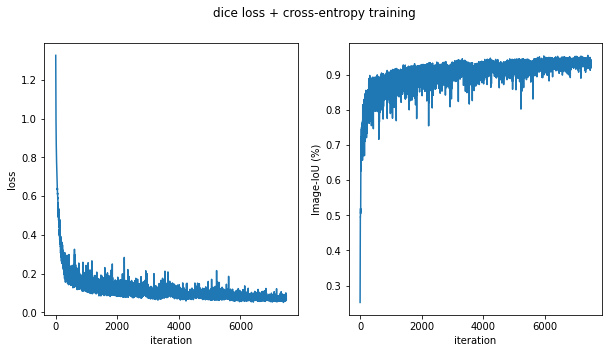

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.suptitle('dice loss + cross-entropy training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

In [11]:
torch.save(net.state_dict(), "result.pt")

In [12]:
torch.save(net.state_dict(), 
                    pjoin(cfg.WEIGHTS_SAVE_ROOT, "weights_ep_%d_%.3f_%.3f.pth" 
                            % (epoch, epoch_loss / epoch_size, epoch_miou / epoch_size)))